In [1]:
%load_ext autoreload
%autoreload 2

here the objective is to fit the logit graph model to multiple different graph domains and then visualize the original vs fitted graphs

In [2]:

import sys
import os

#Graph imports
sys.path.append('../')
import src.graph as graph
import src.logit_estimator as estimator
import src.utils as utils
import src.model_selection as model_selection
import src.gic as gic
import src.param_estimator as pe
import src.graph as graph
import src.model_selection as ms

from src.simulation import LogitGraphFitter, GraphModelComparator

# usual imports
import matplotlib.pyplot as plt
import pickle
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx
from numpy import errstate

from IPython.display import display
from pyvis.network import Network
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [3]:
data_directory = f'../data/misc/twitter'
os.listdir(data_directory)
ids = [int(f.split('.')[0]) for f in os.listdir(data_directory) if f.endswith('.edges')]
len(ids)

973

In [4]:
def load_twitter_graph(data_dir, graph_id):
    """
    Loads a Facebook graph from the specified directory and graph ID.

    Args:
        data_dir (str): The directory where the facebook data is stored.
        graph_id (int): The ID of the graph to load.

    Returns:
        networkx.Graph: The loaded graph as a networkx Graph object.
    """
    edge_file = os.path.join(data_dir, f"{graph_id}.edges")
    
    G = nx.Graph()
    
    with open(edge_file, 'r') as f:
        for line in f:
            # The files are space-separated, so we split the line
            # and convert the node IDs to integers.
            u, v = map(int, line.strip().split())
            G.add_edge(u, v)
            
    return G


graphs = []
graph_filepaths = {}
for graph_id in ids:
    graph = load_twitter_graph(data_directory, graph_id)
    if graph:
        graphs.append(graph)
        graph_filepaths[graph] = os.path.join(data_directory, f"{graph_id}.edges")
        print(f"Graph {graph_id} loaded successfully. Edges: {graph.number_of_edges()}, Nodes: {graph.number_of_nodes()}")



Graph 37170886 loaded successfully. Edges: 3364, Nodes: 212
Graph 16869298 loaded successfully. Edges: 1725, Nodes: 218
Graph 96907622 loaded successfully. Edges: 4649, Nodes: 187
Graph 54791004 loaded successfully. Edges: 710, Nodes: 80
Graph 111374622 loaded successfully. Edges: 2939, Nodes: 188
Graph 14045302 loaded successfully. Edges: 1483, Nodes: 142
Graph 17770689 loaded successfully. Edges: 314, Nodes: 83
Graph 240740059 loaded successfully. Edges: 3403, Nodes: 179
Graph 18486881 loaded successfully. Edges: 1693, Nodes: 145
Graph 18135029 loaded successfully. Edges: 552, Nodes: 55
Graph 11784842 loaded successfully. Edges: 463, Nodes: 84
Graph 374007416 loaded successfully. Edges: 479, Nodes: 126
Graph 39157827 loaded successfully. Edges: 304, Nodes: 84
Graph 117671022 loaded successfully. Edges: 2655, Nodes: 147
Graph 135895585 loaded successfully. Edges: 509, Nodes: 77
Graph 262310943 loaded successfully. Edges: 51, Nodes: 12
Graph 87798068 loaded successfully. Edges: 3072, N

### Fitting single graph

Loading the different graphs into a networkx graph

In [32]:
# Let's proceed with the first loaded graph if available
if not graphs:
    print("\nNo graphs were loaded. Exiting example.")
    exit()

target_graph = graphs[1]
target_filepath = graph_filepaths[target_graph]

# For a single fit, you need to specify a single `d`
fitter_params = {
    "d": 0,
    "n_iteration": 8000,
    "patience": 10,
    "er_p": 0.05,
    "edge_delta": 50,
    "min_gic_threshold": 0.1,
    "verbose": True
}

# Initialize the fitter with the parameters

lg_fitter = LogitGraphFitter(**fitter_params)
lg_fitter.fit(target_graph)



==================== Processing Graph ====================
Original graph - Nodes: 218, Edges: 1725
Running LG generation for d=0...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2121
   📈 Results Summary
   🏆 Best iteration found: 634
   📊 Best spectrum difference: 196.9655
   🔗 Edges in best graph: 1776 (Real graph edges: 1725)
Fitting successful - GIC: 0.2101, Best iteration: 634
Fitted graph - Nodes: 218, Edges: 1776


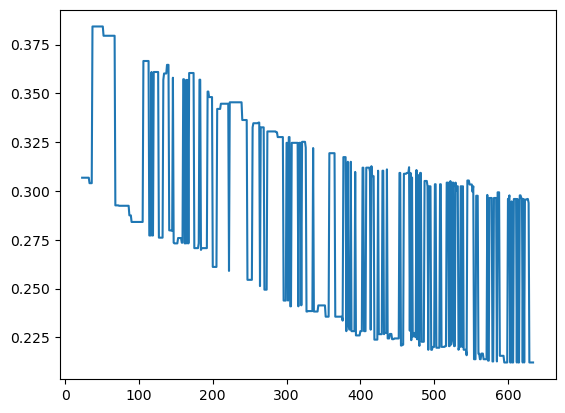

In [33]:
# Log the gic also with the spectrum digg and edges
plt.plot(lg_fitter.metadata['gic_values'])

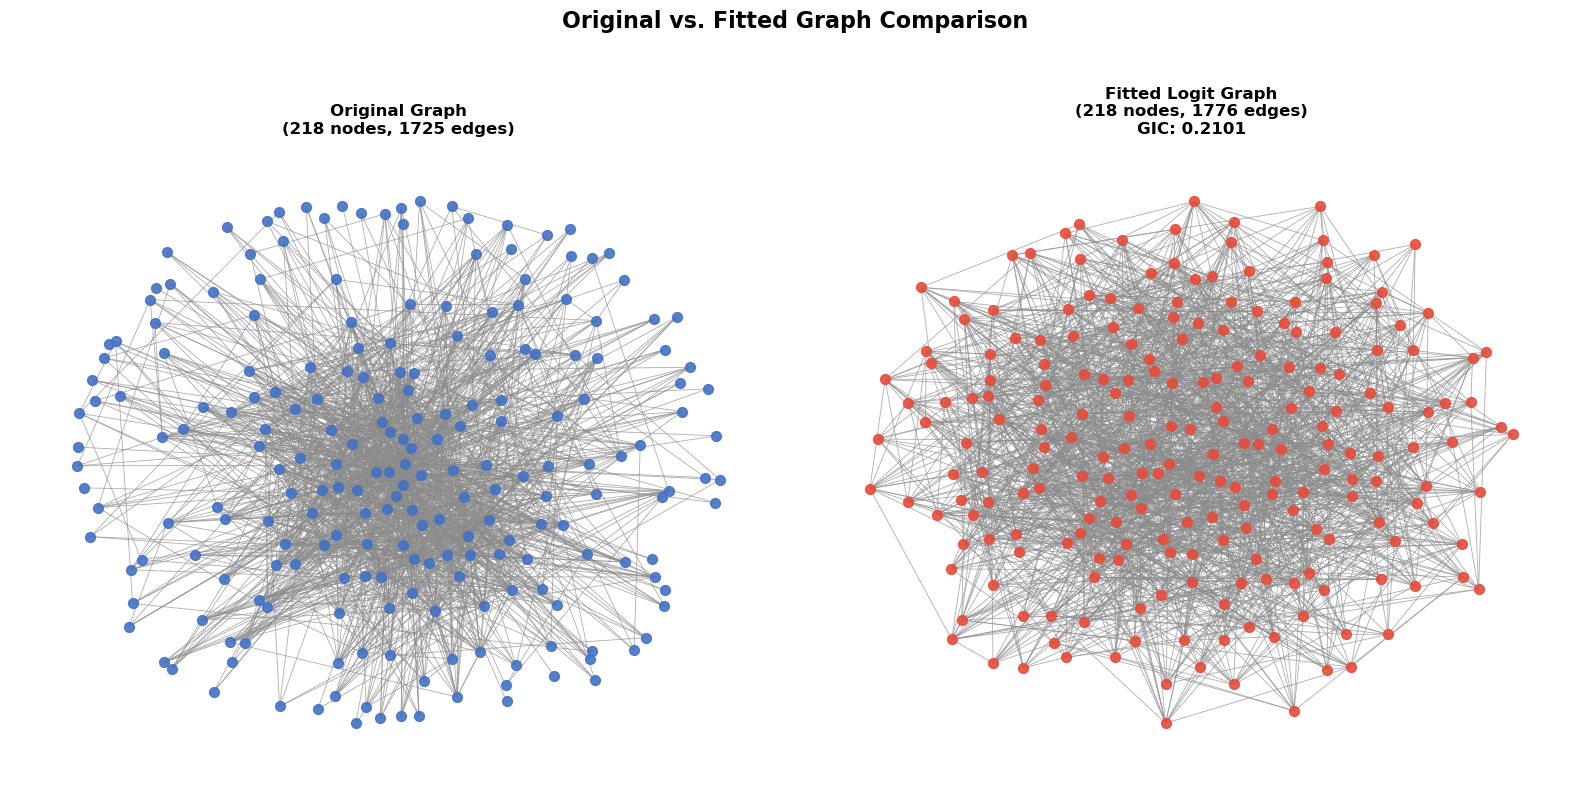

In [34]:
def compare_graphs_visually(original_graph, fitted_graph, metadata=None, figsize=(16, 8), node_size=50, edge_width=0.6):
    """
    Generates a side-by-side plot of the original and fitted graphs.

    Args:
        original_graph (nx.Graph): The original graph.
        fitted_graph (nx.Graph): The fitted graph (can be None if fitting failed).
        metadata (dict, optional): Fitting metadata to display in titles.
        figsize (tuple): The size of the matplotlib figure.
        node_size (int): The size of the nodes in the plot.
        edge_width (float): The width of the edges in the plot.

    Returns:
        matplotlib.figure.Figure: The figure object for the plot.
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Define colors and use a consistent layout for better comparison
    original_node_color = '#4472C4'
    fitted_node_color = '#E74C3C'
    edge_color = '#8B8B8B'
    
    # Calculate layout for original graph
    pos_orig = nx.spring_layout(original_graph, k=1, iterations=50, seed=42)
    
    # 1. Plot Original Graph
    ax_orig = axes[0]
    stats_orig = f"{original_graph.number_of_nodes()} nodes, {original_graph.number_of_edges()} edges"
    nx.draw_networkx_edges(original_graph, pos_orig, ax=ax_orig, edge_color=edge_color, width=edge_width, alpha=0.7)
    nx.draw_networkx_nodes(original_graph, pos_orig, ax=ax_orig, node_color=original_node_color, node_size=node_size, alpha=0.9)
    ax_orig.set_title(f'Original Graph\n({stats_orig})', fontweight='bold', pad=10)
    ax_orig.axis('off')

    # 2. Plot Fitted Graph
    ax_fitted = axes[1]
    title = 'Fitted Logit Graph'
    if fitted_graph and metadata and metadata.get('fit_success'):
        stats_fitted = f"{fitted_graph.number_of_nodes()} nodes, {fitted_graph.number_of_edges()} edges"
        gic_val = metadata.get('gic_value', 'N/A')
        gic_text = f"GIC: {gic_val:.4f}" if isinstance(gic_val, (int, float)) else f"GIC: {gic_val}"
        title = f'{title}\n({stats_fitted})\n{gic_text}'
        
        # Calculate separate layout for fitted graph to avoid position mismatch
        pos_fitted = nx.spring_layout(fitted_graph, k=1, iterations=50, seed=42)
        
        nx.draw_networkx_edges(fitted_graph, pos_fitted, ax=ax_fitted, edge_color=edge_color, width=edge_width, alpha=0.7)
        nx.draw_networkx_nodes(fitted_graph, pos_fitted, ax=ax_fitted, node_color=fitted_node_color, node_size=node_size, alpha=0.9)
    else:
        title = f'{title}\n(Fitting Failed)'
        ax_fitted.text(0.5, 0.5, 'Fitting Failed', horizontalalignment='center', verticalalignment='center', transform=ax_fitted.transAxes, fontsize=14, color='red')

    ax_fitted.set_title(title, fontweight='bold', pad=10)
    ax_fitted.axis('off')
    
    fig.suptitle('Original vs. Fitted Graph Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    return fig


# 5. Visualize the results
if lg_fitter.metadata['fit_success']:
    comparison_figure = compare_graphs_visually(target_graph, lg_fitter.fitted_graph, lg_fitter.metadata)
    plt.show()
else:
    print("Fitting failed. No visualization available.")


In [50]:
# Let's proceed with the first loaded graph if available
if not graphs:
    print("\nNo graphs were loaded. Exiting example.")
    exit()

target_graph = graphs[2]
target_filepath = graph_filepaths[target_graph]

# For a single fit, you need to specify a single `d`
sim_params = {
    "d_list": [0, 1, 2],
    "lg_params": {
        "max_iterations": 8000,
        "patience": 10,
        "gic_dist_type": 'KL',
        "er_p": 0.05,
        "min_gic_threshold": 0.1,
        "edge_delta": 50,
        "verbose": True,
    },
    "other_model_n_runs": 5,
    "other_model_params": [
        {'lo': 0.01, 'hi': 0.2},  # ER (probability)
        {'k': {'lo': 2, 'hi': 3, 'step': 1}, 'p': {'lo': 0.01, 'hi': 0.2}},  # WS
        {'lo': 1, 'hi': 3},      # GRG (alpha)
        {'lo': 3, 'hi': 5},     # BA (m)
    ],
    "verbose": True,
}



# Initialize the fitter with the parameters

comparator = GraphModelComparator(**sim_params)
comparator.compare(target_graph, target_filepath)



============================== Processing Graph: 96907622.edges ==============================

--- Fitting Logit Graph (LG) model ---
Running LG generation for d=0...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4346 (Target: ≤0.1) 📈 Best Spectrum Diff: 572.4733 ⏱️  Patience: 0/10 🔗 Edges: 1766 (Target: 4649)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3615 (Target: ≤0.1) 📈 Best Spectrum Diff: 474.1305 ⏱️  Patience: 0/10 🔗 Edges: 2633 (Target: 4649)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4667 (Target: ≤0.1) 📈 Best Spectrum Diff: 403.6383 ⏱️  Patience: 0/10 🔗 Edges: 3453 (Target: 4649)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2190 (Target: ≤0.1) 📈 Best Spectrum Diff: 358.5826 ⏱️  Patience: 0/10 🔗 Edges: 4234 (Target: 4649)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4033
   📈 Results Summary
   🏆 Best iteration found: 4,584
   📊 Best spectrum difference: 348.8605
   🔗 Edges in best graph: 4674 (Real graph edges: 4649)
d=0: GIC=0.2042, sigma=-5.4737
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4181 (Target: ≤0.1) 📈 Best Spectrum Diff: 566.4874 ⏱️  Patience: 0/10 🔗 Edges: 1813 (Target: 4649)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5644 (Target: ≤0.1) 📈 Best Spectrum Diff: 471.9589 ⏱️  Patience: 0/10 🔗 Edges: 2678 (Target: 4649)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4667 (Target: ≤0.1) 📈 Best Spectrum Diff: 400.6161 ⏱️  Patience: 0/10 🔗 Edges: 3511 (Target: 4649)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2135 (Target: ≤0.1) 📈 Best Spectrum Diff: 359.2674 ⏱️  Patience: 0/10 🔗 Edges: 4275 (Target: 4649)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4069
   📈 Results Summary
   🏆 Best iteration found: 4,528
   📊 Best spectrum difference: 351.4274
   🔗 Edges in best graph: 4660 (Real graph edges: 4649)
d=1: GIC=0.4069, sigma=-6.2316
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4336 (Target: ≤0.1) 📈 Best Spectrum Diff: 569.1227 ⏱️  Patience: 0/10 🔗 Edges: 1812 (Target: 4649)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5529 (Target: ≤0.1) 📈 Best Spectrum Diff: 471.6666 ⏱️  Patience: 0/10 🔗 Edges: 2689 (Target: 4649)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2589 (Target: ≤0.1) 📈 Best Spectrum Diff: 404.2305 ⏱️  Patience: 0/10 🔗 Edges: 3486 (Target: 4649)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2111 (Target: ≤0.1) 📈 Best Spectrum Diff: 364.2727 ⏱️  Patience: 0/10 🔗 Edges: 4277 (Target: 4649)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4048
   📈 Results Summary
   🏆 Best iteration found: 4,409
   📊 Best spectrum difference: 358.2911
   🔗 Edges in best graph: 4577 (Real graph edges: 4649)
d=2: GIC=0.2048, sigma=-80.5871
Best LG fit found with GIC: 0.2042

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.2723181008317491
Tes

In [52]:
comparator.summary_df

graph_filename     model  gic_value               param  fit_success  \
0  96907622.edges  Original        NaN                 N/A         True   
1  96907622.edges        LG   0.204187  d=0, sigma=-5.4737         True   
2  96907622.edges        ER   0.272318                 0.2         True   
3  96907622.edges        BA   0.721498                 5.0         True   
4  96907622.edges        WS   1.599264                20.2         True   
5  96907622.edges       GRG   2.135166                 1.0         True   

   nodes  edges   density  avg_clustering  avg_path_length  diameter  \
0    187   4649  0.267322        0.598147         1.749955         4   
1    187   4674  0.268760        0.269265         1.731240         2   
2    187   3385  0.194641        0.196904         1.806107         3   
3    187    910  0.052326        0.129281         2.433673         4   
4    187   4675  0.268817        0.266414         1.731183         2   
5    187  16891  0.971249        0.975021         1.028751         2   

   assortativity  num_components  largest_component_size  
0      -0.223390               2                     183  
1      -0.021158               1                     187  
2      -0.001703               1                     187  
3      -0.115371               1                     187  
4      -0.042454               1                     187  
5      -0.046187               1                     187

### Comparison other models

comparing multiple models

In [5]:
sim_params = {
    "d_list": [0, 1, 2],
    "lg_params": {
        "max_iterations": 8000,
        "patience": 10,
        "gic_dist_type": 'KL',
        "er_p": 0.05,
        "min_gic_threshold": 0.1,
        "edge_delta": 50,
        "verbose": True,
    },
    "other_model_n_runs": 5,
    "other_model_params": [
        {'lo': 0.01, 'hi': 0.2},  # ER (probability)
        {'k': {'lo': 2, 'hi': 3, 'step': 1}, 'p': {'lo': 0.01, 'hi': 0.2}},  # WS
        {'lo': 1, 'hi': 3},      # GRG (alpha)
        {'lo': 3, 'hi': 5},     # BA (m)
    ],
    "verbose": True,
}



graph_files = []
for id in ids:
    graph_files.append(f'../data/misc/twitter/{id}.edges')

min_nodes = 100  # Exclude graphs with less than 100 nodes
graph_files = sorted([f for f in graph_files if nx.read_edgelist(f, nodetype=int).number_of_nodes() >= min_nodes], 
                    key=lambda file: nx.read_edgelist(file, nodetype=int).number_of_nodes())


In [6]:
graph_files

['../data/misc/twitter/134208594.edges',
 '../data/misc/twitter/23503181.edges',
 '../data/misc/twitter/28628055.edges',
 '../data/misc/twitter/5773532.edges',
 '../data/misc/twitter/54226675.edges',
 '../data/misc/twitter/78391198.edges',
 '../data/misc/twitter/15099384.edges',
 '../data/misc/twitter/33080832.edges',
 '../data/misc/twitter/18687625.edges',
 '../data/misc/twitter/314038032.edges',
 '../data/misc/twitter/65185224.edges',
 '../data/misc/twitter/16606585.edges',
 '../data/misc/twitter/110755733.edges',
 '../data/misc/twitter/144211337.edges',
 '../data/misc/twitter/19658936.edges',
 '../data/misc/twitter/43003845.edges',
 '../data/misc/twitter/54695584.edges',
 '../data/misc/twitter/22751884.edges',
 '../data/misc/twitter/623623.edges',
 '../data/misc/twitter/189253902.edges',
 '../data/misc/twitter/4258591.edges',
 '../data/misc/twitter/179065820.edges',
 '../data/misc/twitter/18690700.edges',
 '../data/misc/twitter/4387041.edges',
 '../data/misc/twitter/49414491.edges',

In [7]:

comparators = []
folder_name = 'runs/fitted_graphs_comparison_twitter2'
os.makedirs(folder_name, exist_ok=True)

for graph_file in graph_files:
    try:
        print(f"Loading graph from: {graph_file}")
        original_graph = nx.read_edgelist(graph_file, nodetype=int)

        if original_graph.number_of_nodes() <= 100:
            n_iteration = 4000
        elif original_graph.number_of_nodes() > 100 and original_graph.number_of_nodes() <= 300:
            n_iteration = 8000
        elif original_graph.number_of_nodes() > 300 and original_graph.number_of_nodes() <= 500:
            n_iteration = 12000
        elif original_graph.number_of_nodes() > 700:
            n_iteration = 20000
        else:
            pass
        sim_params['lg_params']['max_iterations'] = n_iteration

        # Run the comparison
        comparator = GraphModelComparator(**sim_params)
        comparator.compare(original_graph, graph_file)
    except Exception as e:
        print(f"Error graph from {graph_file}: {e}")
        continue

    comparators.append(comparator)
    import pickle
    graph_name = graph_file.split('/')[-1].split('.')[0]
    with open(f'{folder_name}/comparators_{graph_name}.pkl', 'wb') as f:
        pickle.dump(comparators, f)



Loading graph from: ../data/misc/twitter/134208594.edges

============================== Processing Graph: 134208594.edges ==============================

--- Fitting Logit Graph (LG) model ---
Running LG generation for d=0...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3762 (Target: ≤0.1) 📈 Best Spectrum Diff: 156.9372 ⏱️  Patience: 0/10 🔗 Edges: 1106 (Target: 1677)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2215
   📈 Results Summary
   🏆 Best iteration found: 1,814
   📊 Best spectrum difference: 98.1972
   🔗 Edges in best graph: 1678 (Real graph edges: 1677)
d=0: GIC=0.2250, sigma=-4.7191
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5381 (Target: ≤0.1) 📈 Best Spectrum Diff: 151.1884 ⏱️  Patience: 0/10 🔗 Edges: 1131 (Target: 1677)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4119
   📈 Results Summary
   🏆 Best iteration found: 1,847
   📊 Best spectrum difference: 95.6150
   🔗 Edges in best graph: 1728 (Real graph edges: 1677)
d=1: GIC=0.2215, sigma=-5.0081
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/4000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3710 (Target: ≤0.1) 📈 Best Spectrum Diff: 154.3774 ⏱️  Patience: 0/10 🔗 Edges: 1112 (Target: 1677)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3986
   📈 Results Summary
   🏆 Best iteration found: 1,839
   📊 Best spectrum difference: 100.5068
   🔗 Edges in best graph: 1728 (Real graph edges: 1677)
d=2: GIC=0.3986, sigma=-51.9010
Best LG fit found with GIC: 0.2215

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4010874601959723
Testing the selected model for WS
WS gic: 1.488809134292459
Testing the selected model for GRG
GRG gic: 2.7902174317073243
Testing the selected model for BA
BA gic: 0.7260203733320818
ER fitting - GIC: 0.4011, Param: 0.2000
BA fitting - GIC: 0.7260, Param: 5.0000
WS fitting - GIC: 1.4888, Param: 20.1156
GRG fitting - GIC: 2.7902, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8794 (Target: ≤0.1) 📈 Best Spectrum Diff: 143.5473 ⏱️  Patience: 0/10 🔗 Edges: 1111 (Target: 1455)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5978
   📈 Results Summary
   🏆 Best iteration found: 1,494
   📊 Best spectrum difference: 121.7597
   🔗 Edges in best graph: 1483 (Real graph edges: 1455)
d=0: GIC=0.6072, sigma=-4.7309
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8793 (Target: ≤0.1) 📈 Best Spectrum Diff: 142.6609 ⏱️  Patience: 0/10 🔗 Edges: 1112 (Target: 1455)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7885
   📈 Results Summary
   🏆 Best iteration found: 1,501
   📊 Best spectrum difference: 119.0904
   🔗 Edges in best graph: 1489 (Real graph edges: 1455)
d=1: GIC=0.7905, sigma=-5.4724
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8765 (Target: ≤0.1) 📈 Best Spectrum Diff: 140.9121 ⏱️  Patience: 0/10 🔗 Edges: 1115 (Target: 1455)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5975
   📈 Results Summary
   🏆 Best iteration found: 1,507
   📊 Best spectrum difference: 116.2071
   🔗 Edges in best graph: 1503 (Real graph edges: 1455)
d=2: GIC=0.7862, sigma=-17.5718
Best LG fit found with GIC: 0.6072

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8957999201620742
Testing the selected model for WS
WS gic: 1.3575916693463093
Testing the selected model for GRG
GRG gic: 4.342646908506146
Testing the selected model for BA
BA gic: 0.793999982210294
BA fitting - GIC: 0.7940, Param: 5.0000
ER fitting - GIC: 0.8958, Param: 0.2000
WS fitting - GIC: 1.3576, Param: 20.2000
GRG fitting - GIC: 4.3426, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7897 (Target: ≤0.1) 📈 Best Spectrum Diff: 78.8026 ⏱️  Patience: 0/10 🔗 Edges: 1152 (Target: 1105)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7897
   📈 Results Summary
   🏆 Best iteration found: 962
   📊 Best spectrum difference: 78.8026
   🔗 Edges in best graph: 1120 (Real graph edges: 1105)
d=0: GIC=0.6021, sigma=-4.6035
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7897 (Target: ≤0.1) 📈 Best Spectrum Diff: 78.0419 ⏱️  Patience: 0/10 🔗 Edges: 1127 (Target: 1105)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7897
   📈 Results Summary
   🏆 Best iteration found: 935
   📊 Best spectrum difference: 78.0419
   🔗 Edges in best graph: 1080 (Real graph edges: 1105)
d=1: GIC=0.6181, sigma=-4.6528
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6048 (Target: ≤0.1) 📈 Best Spectrum Diff: 80.2394 ⏱️  Patience: 0/10 🔗 Edges: 1125 (Target: 1105)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7902
   📈 Results Summary
   🏆 Best iteration found: 1,004
   📊 Best spectrum difference: 80.0646
   🔗 Edges in best graph: 1129 (Real graph edges: 1105)
d=2: GIC=0.7946, sigma=-22.3509
Best LG fit found with GIC: 0.6021

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6239792741259685
Testing the selected model for WS
WS gic: 1.2532687170791472
Testing the selected model for GRG
GRG gic: 6.488222270514256
Testing the selected model for BA
BA gic: 0.4930384763764865
BA fitting - GIC: 0.4930, Param: 5.0000
ER fitting - GIC: 0.6240, Param: 0.2000
WS fitting - GIC: 1.2533, Param: 20.2000
GRG fitting - GIC: 6.4882, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fro

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6003
   📈 Results Summary
   🏆 Best iteration found: 740
   📊 Best spectrum difference: 46.3022
   🔗 Edges in best graph: 869 (Real graph edges: 841)
d=0: GIC=0.2169, sigma=-4.4367
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2162
   📈 Results Summary
   🏆 Best iteration found: 665
   📊 Best spectrum difference: 49.6496
   🔗 Edges in best graph: 838 (Real graph edges: 841)
d=1: GIC=0.2250, sigma=-4.0452
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6124
   📈 Results Summary
   🏆 Best iteration found: 678
   📊 Best spectrum difference: 47.6588
   🔗 Edges in best graph: 860 (Real graph edges: 841)
d=2: GIC=0.6118, sigma=-6.6857
Best LG fit found with GIC: 0.2169

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.787360563523426
Testing the selected model for WS
WS gic: 1.1091798224612996
Testing the selected model for GRG
GRG gic: 8.512283978756603
Testing the selected model for BA
BA gic: 0.39720185981027845
BA fitting - GIC: 0.3972, Param: 5.0000
ER fitting - GIC: 0.7874, Param: 0.2000
WS fitting - GIC: 1.1092, Param: 20.2000
GRG fitting - GIC: 8.5123, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/54226675.edges

============================== Processing Graph: 54226675.edges ==============================



🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8883
   📈 Results Summary
   🏆 Best iteration found: 802
   📊 Best spectrum difference: 139.0160
   🔗 Edges in best graph: 967 (Real graph edges: 953)
d=0: GIC=0.8788, sigma=-5.3267
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8840
   📈 Results Summary
   🏆 Best iteration found: 828
   📊 Best spectrum difference: 137.3633
   🔗 Edges in best graph: 1002 (Real graph edges: 953)
d=1: GIC=0.8935, sigma=-7.7021
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 732 (GIC: 0.0957)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 784
   📊 Best spectrum difference: 136.8968
   🔗 Edges in best graph: 954 (Real graph edges: 953)
d=2: GIC=0.8978, sigma=-105.0074
Best LG fit found with GIC: 0.8788

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8889119201115291
Testing the selected model for WS
WS gic: 1.301996106892885
Testing the selected model for GRG
GRG gic: 6.178167059926665
Testing the selected model for BA
BA gic: 0.26785811854664826
BA fitting - GIC: 0.2679, Param: 5.0000
ER fitting - GIC: 0.8889, Param: 0.2000
WS fitting - GIC: 1.3020, Param: 20.1578
GRG fitting - GIC: 6.1782, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/7

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4177
   📈 Results Summary
   🏆 Best iteration found: 278
   📊 Best spectrum difference: 61.5891
   🔗 Edges in best graph: 531 (Real graph edges: 517)
d=0: GIC=0.4397, sigma=-4.8333
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4121
   📈 Results Summary
   🏆 Best iteration found: 360
   📊 Best spectrum difference: 64.4103
   🔗 Edges in best graph: 566 (Real graph edges: 517)
d=1: GIC=0.4154, sigma=-5.5649
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4111
   📈 Results Summary
   🏆 Best iteration found: 248
   📊 Best spectrum difference: 58.5738
   🔗 Edges in best graph: 525 (Real graph edges: 517)
d=2: GIC=0.4440, sigma=-14.5260
Best LG fit found with GIC: 0.4154

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.39181272595734423
Testing the selected model for WS
WS gic: 0.9659463151852599
Testing the selected model for GRG
GRG gic: 10.630269760173087
Testing the selected model for BA
BA gic: 0.2546604283649316
BA fitting - GIC: 0.2547, Param: 5.0000
ER fitting - GIC: 0.3918, Param: 0.1367
WS fitting - GIC: 0.9659, Param: 20.2000
GRG fitting - GIC: 10.6303, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/15099384.edges

============================== Processing Graph: 15099384.edges ============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5976
   📈 Results Summary
   🏆 Best iteration found: 455
   📊 Best spectrum difference: 75.1638
   🔗 Edges in best graph: 699 (Real graph edges: 664)
d=0: GIC=0.6057, sigma=-4.4765
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5914
   📈 Results Summary
   🏆 Best iteration found: 454
   📊 Best spectrum difference: 73.7027
   🔗 Edges in best graph: 660 (Real graph edges: 664)
d=1: GIC=0.6035, sigma=-5.3389
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4041
   📈 Results Summary
   🏆 Best iteration found: 489
   📊 Best spectrum difference: 76.6816
   🔗 Edges in best graph: 711 (Real graph edges: 664)
d=2: GIC=0.4041, sigma=-17.9093
Best LG fit found with GIC: 0.4041

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4224557583139604
Testing the selected model for WS
WS gic: 0.9648184405841652
Testing the selected model for GRG
GRG gic: 10.367349048244588
Testing the selected model for BA
BA gic: 0.4781446553277483
ER fitting - GIC: 0.4225, Param: 0.1578
BA fitting - GIC: 0.4781, Param: 5.0000
WS fitting - GIC: 0.9648, Param: 20.2000
GRG fitting - GIC: 10.3673, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/33080832.edges

============================== Processing Graph: 33080832.edges =============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7031
   📈 Results Summary
   🏆 Best iteration found: 0
   📊 Best spectrum difference: 20.7019
   🔗 Edges in best graph: 269 (Real graph edges: 243)
d=0: GIC=0.6519, sigma=-5.0223
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 3 (GIC: 0.0811)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 14
   📊 Best spectrum difference: 18.5742
   🔗 Edges in best graph: 265 (Real graph edges: 243)
d=1: GIC=1.8514, sigma=-4.6351
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6920
   📈 Results Summary
   🏆 Best iteration found: 26
   📊 Best spectrum difference: 20.0757
   🔗 Edges in best graph: 256 (Real graph edges: 243)
d=2: GIC=0.6926, sigma=-5.3940
Best LG fit found with GIC: 0.6519

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6994450193115963
Testing the selected model for WS
WS gic: 0.3139603224441912
Testing the selected model for GRG
GRG gic: 14.13758091952244
Testing the selected model for BA
BA gic: 0.7530854323003378
WS fitting - GIC: 0.3140, Param: 20.2000
ER fitting - GIC: 0.6994, Param: 0.0522
BA fitting - GIC: 0.7531, Param: 3.0000
GRG fitting - GIC: 14.1376, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/18687625.edges

============================== Processing Graph: 18687625.edges ==============================



🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 71 (GIC: 0.0845)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 110
   📊 Best spectrum difference: 50.7806
   🔗 Edges in best graph: 360 (Real graph edges: 367)
d=0: GIC=0.4364, sigma=-4.5824
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 18 (GIC: 0.0988)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 48
   📊 Best spectrum difference: 50.6058
   🔗 Edges in best graph: 323 (Real graph edges: 367)
d=1: GIC=0.0741, sigma=-5.7674
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 63 (GIC: 0.0946)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Edge count difference exceeded delta (50).
   📈 Results Summary
   🏆 Best iteration found: 178
   📊 Best spectrum difference: 48.3696
   🔗 Edges in best graph: 413 (Real graph edges: 367)
d=2: GIC=0.0351, sigma=-10.6364
Best LG fit found with GIC: 0.0351

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6271317766107792
Testing the selected model for WS
WS gic: 0.7080482373606533
Testing the selected model for GRG
GRG gic: 12.932854117917314
Testing the selected model for BA
BA gic: 0.04347542269228274
BA fitting - GIC: 0.0435, Param: 4.5556
ER fitting - GIC: 0.6271, Param: 0.0944
WS fitting - GIC: 0.7080, Param: 20.1156
GRG fitting - GIC: 12.9329, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/31403

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5652
   📈 Results Summary
   🏆 Best iteration found: 907
   📊 Best spectrum difference: 77.9088
   🔗 Edges in best graph: 1032 (Real graph edges: 1019)
d=0: GIC=0.3824, sigma=-4.5344
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5595
   📈 Results Summary
   🏆 Best iteration found: 926
   📊 Best spectrum difference: 82.2575
   🔗 Edges in best graph: 1051 (Real graph edges: 1019)
d=1: GIC=0.5630, sigma=-4.6401
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5652
   📈 Results Summary
   🏆 Best iteration found: 933
   📊 Best spectrum difference: 79.1817
   🔗 Edges in best graph: 1066 (Real graph edges: 1019)
d=2: GIC=0.5630, sigma=-26.1922
Best LG fit found with GIC: 0.3824

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.39245115265178243
Testing the selected model for WS
WS gic: 1.2586618710943343
Testing the selected model for GRG
GRG gic: 7.734301245494795
Testing the selected model for BA
BA gic: 0.4537644326914295
ER fitting - GIC: 0.3925, Param: 0.2000
BA fitting - GIC: 0.4538, Param: 5.0000
WS fitting - GIC: 1.2587, Param: 20.1578
GRG fitting - GIC: 7.7343, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/65185224.edges

============================== Processing Graph: 65185224.edges ============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8172
   📈 Results Summary
   🏆 Best iteration found: 414
   📊 Best spectrum difference: 88.4435
   🔗 Edges in best graph: 636 (Real graph edges: 610)
d=0: GIC=0.8242, sigma=-4.5265
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1894
   📈 Results Summary
   🏆 Best iteration found: 437
   📊 Best spectrum difference: 88.8326
   🔗 Edges in best graph: 653 (Real graph edges: 610)
d=1: GIC=0.8207, sigma=-5.6486
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1965
   📈 Results Summary
   🏆 Best iteration found: 421
   📊 Best spectrum difference: 87.8899
   🔗 Edges in best graph: 651 (Real graph edges: 610)
d=2: GIC=1.1965, sigma=-7.3391
Best LG fit found with GIC: 0.8207

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8267566609357758
Testing the selected model for WS
WS gic: 0.8546290266323856
Testing the selected model for GRG
GRG gic: 9.208683775112812
Testing the selected model for BA
BA gic: 0.8757733836922517
ER fitting - GIC: 0.8268, Param: 0.1156
WS fitting - GIC: 0.8546, Param: 20.0944
BA fitting - GIC: 0.8758, Param: 5.0000
GRG fitting - GIC: 9.2087, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/16606585.edges

============================== Processing Graph: 16606585.edges ==============================



🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0328
   📈 Results Summary
   🏆 Best iteration found: 673
   📊 Best spectrum difference: 81.6987
   🔗 Edges in best graph: 891 (Real graph edges: 871)
d=0: GIC=1.0300, sigma=-5.0050
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.7846
   📈 Results Summary
   🏆 Best iteration found: 742
   📊 Best spectrum difference: 85.0798
   🔗 Edges in best graph: 919 (Real graph edges: 871)
d=1: GIC=1.6012, sigma=-4.6780
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8370
   📈 Results Summary
   🏆 Best iteration found: 716
   📊 Best spectrum difference: 83.7548
   🔗 Edges in best graph: 916 (Real graph edges: 871)
d=2: GIC=0.8370, sigma=-13.9649
Best LG fit found with GIC: 0.8370

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.1633560049994722
Testing the selected model for WS
WS gic: 1.0070615251973727
Testing the selected model for GRG
GRG gic: 8.05058674978976
Testing the selected model for BA
BA gic: 0.9255126185848928
BA fitting - GIC: 0.9255, Param: 5.0000
WS fitting - GIC: 1.0071, Param: 20.2000
ER fitting - GIC: 2.1634, Param: 0.2000
GRG fitting - GIC: 8.0506, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/110755733.edges

============================== Processing Graph: 110755733.edges ==============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 109 (GIC: 0.0969)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 309
   📊 Best spectrum difference: 70.8960
   🔗 Edges in best graph: 530 (Real graph edges: 573)
d=0: GIC=1.3607, sigma=-5.1208
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 68 (GIC: 0.0836)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 311
   📊 Best spectrum difference: 70.0672
   🔗 Edges in best graph: 591 (Real graph edges: 573)
d=1: GIC=1.3616, sigma=-5.0967
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 57 (GIC: 0.0961)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 321
   📊 Best spectrum difference: 70.4396
   🔗 Edges in best graph: 579 (Real graph edges: 573)
d=2: GIC=1.3767, sigma=-11.3062
Best LG fit found with GIC: 1.3607

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.1809871148788271
Testing the selected model for WS
WS gic: 0.7537735140669445
Testing the selected model for GRG
GRG gic: 11.333135034894951
Testing the selected model for BA
BA gic: 1.1893665444849444
WS fitting - GIC: 0.7538, Param: 20.2000
ER fitting - GIC: 1.1810, Param: 0.1156
BA fitting - GIC: 1.1894, Param: 5.0000
GRG fitting - GIC: 11.3331, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/14

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8991 (Target: ≤0.1) 📈 Best Spectrum Diff: 164.6056 ⏱️  Patience: 0/10 🔗 Edges: 1140 (Target: 1644)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5898
   📈 Results Summary
   🏆 Best iteration found: 1,754
   📊 Best spectrum difference: 121.9493
   🔗 Edges in best graph: 1677 (Real graph edges: 1644)
d=0: GIC=0.7724, sigma=-5.0385
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8804 (Target: ≤0.1) 📈 Best Spectrum Diff: 165.1539 ⏱️  Patience: 0/10 🔗 Edges: 1148 (Target: 1644)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7727
   📈 Results Summary
   🏆 Best iteration found: 1,685
   📊 Best spectrum difference: 127.8883
   🔗 Edges in best graph: 1658 (Real graph edges: 1644)
d=1: GIC=0.5987, sigma=-5.4697
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7140 (Target: ≤0.1) 📈 Best Spectrum Diff: 161.3991 ⏱️  Patience: 0/10 🔗 Edges: 1171 (Target: 1644)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7712
   📈 Results Summary
   🏆 Best iteration found: 1,659
   📊 Best spectrum difference: 123.9411
   🔗 Edges in best graph: 1669 (Real graph edges: 1644)
d=2: GIC=0.5902, sigma=-34.2800
Best LG fit found with GIC: 0.5902

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.563669773789524
Testing the selected model for WS
WS gic: 1.4176756470707388
Testing the selected model for GRG
GRG gic: 3.4826995829528973
Testing the selected model for BA
BA gic: 0.4367790496993493
BA fitting - GIC: 0.4368, Param: 5.0000
ER fitting - GIC: 0.5637, Param: 0.2000
WS fitting - GIC: 1.4177, Param: 20.1789
GRG fitting - GIC: 3.4827, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8704 (Target: ≤0.1) 📈 Best Spectrum Diff: 148.3785 ⏱️  Patience: 0/10 🔗 Edges: 1146 (Target: 1653)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6746
   📈 Results Summary
   🏆 Best iteration found: 1,749
   📊 Best spectrum difference: 104.3966
   🔗 Edges in best graph: 1679 (Real graph edges: 1653)
d=0: GIC=0.6746, sigma=-4.6114
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8583 (Target: ≤0.1) 📈 Best Spectrum Diff: 146.8016 ⏱️  Patience: 0/10 🔗 Edges: 1158 (Target: 1653)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6791
   📈 Results Summary
   🏆 Best iteration found: 1,731
   📊 Best spectrum difference: 101.4474
   🔗 Edges in best graph: 1694 (Real graph edges: 1653)
d=1: GIC=0.6698, sigma=-4.4214
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8535 (Target: ≤0.1) 📈 Best Spectrum Diff: 146.5578 ⏱️  Patience: 0/10 🔗 Edges: 1154 (Target: 1653)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6775
   📈 Results Summary
   🏆 Best iteration found: 1,724
   📊 Best spectrum difference: 104.7493
   🔗 Edges in best graph: 1688 (Real graph edges: 1653)
d=2: GIC=0.6919, sigma=-11.0009
Best LG fit found with GIC: 0.6698

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8896594611131267
Testing the selected model for WS
WS gic: 1.6713953557895433
Testing the selected model for GRG
GRG gic: 2.018430302106104
Testing the selected model for BA
BA gic: 1.055876973012691
ER fitting - GIC: 0.8897, Param: 0.2000
BA fitting - GIC: 1.0559, Param: 5.0000
WS fitting - GIC: 1.6714, Param: 20.1156
GRG fitting - GIC: 2.0184, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4477 (Target: ≤0.1) 📈 Best Spectrum Diff: 296.0419 ⏱️  Patience: 0/10 🔗 Edges: 1172 (Target: 2377)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2323 (Target: ≤0.1) 📈 Best Spectrum Diff: 194.1060 ⏱️  Patience: 0/10 🔗 Edges: 1881 (Target: 2377)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3815
   📈 Results Summary
   🏆 Best iteration found: 2,898
   📊 Best spectrum difference: 166.8298
   🔗 Edges in best graph: 2412 (Real graph edges: 2377)
d=0: GIC=0.9446, sigma=-6.1008
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6286 (Target: ≤0.1) 📈 Best Spectrum Diff: 303.4671 ⏱️  Patience: 0/10 🔗 Edges: 1140 (Target: 2377)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4088 (Target: ≤0.1) 📈 Best Spectrum Diff: 201.0734 ⏱️  Patience: 0/10 🔗 Edges: 1863 (Target: 2377)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3836
   📈 Results Summary
   🏆 Best iteration found: 2,684
   📊 Best spectrum difference: 174.1860
   🔗 Edges in best graph: 2270 (Real graph edges: 2377)
d=1: GIC=0.3699, sigma=-6.3173
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6043 (Target: ≤0.1) 📈 Best Spectrum Diff: 299.7765 ⏱️  Patience: 0/10 🔗 Edges: 1155 (Target: 2377)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4101 (Target: ≤0.1) 📈 Best Spectrum Diff: 195.4639 ⏱️  Patience: 0/10 🔗 Edges: 1875 (Target: 2377)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3830
   📈 Results Summary
   🏆 Best iteration found: 2,915
   📊 Best spectrum difference: 167.2870
   🔗 Edges in best graph: 2428 (Real graph edges: 2377)
d=2: GIC=0.3830, sigma=-127.0275
Best LG fit found with GIC: 0.3699

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.46915192363249913
Testing the selected model for WS
WS gic: 1.6015780309981094
Testing the selected model for GRG
GRG gic: 1.8597560566034774
Testing the selected model for BA
BA gic: 0.6440096353875755
ER fitting - GIC: 0.4692, Param: 0.2000
BA fitting - GIC: 0.6440, Param: 5.0000


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8177
   📈 Results Summary
   🏆 Best iteration found: 815
   📊 Best spectrum difference: 70.8997
   🔗 Edges in best graph: 1006 (Real graph edges: 957)
d=0: GIC=1.6398, sigma=-4.6603
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7722
   📈 Results Summary
   🏆 Best iteration found: 839
   📊 Best spectrum difference: 72.8993
   🔗 Edges in best graph: 990 (Real graph edges: 957)
d=1: GIC=2.7722, sigma=-4.5828
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8257
   📈 Results Summary
   🏆 Best iteration found: 755
   📊 Best spectrum difference: 74.6325
   🔗 Edges in best graph: 945 (Real graph edges: 957)
d=2: GIC=1.8222, sigma=-10.6960
Best LG fit found with GIC: 1.6398

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.7516500328272846
Testing the selected model for WS
WS gic: 0.9911185923016146
Testing the selected model for GRG
GRG gic: 7.519473944721298
Testing the selected model for BA
BA gic: 0.7148759957857197
BA fitting - GIC: 0.7149, Param: 5.0000
WS fitting - GIC: 0.9911, Param: 20.1367
ER fitting - GIC: 2.7517, Param: 0.2000
GRG fitting - GIC: 7.5195, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/22751884.edges

============================== Processing Graph: 22751884.edges ==============================


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 73 (GIC: 0.0965)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 111
   📊 Best spectrum difference: 35.5281
   🔗 Edges in best graph: 349 (Real graph edges: 355)
d=0: GIC=1.0119, sigma=-4.5828
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 13 (GIC: 0.0991)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 97
   📊 Best spectrum difference: 37.9196
   🔗 Edges in best graph: 352 (Real graph edges: 355)
d=1: GIC=0.0882, sigma=-4.7289
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 39 (GIC: 0.0934)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 85
   📊 Best spectrum difference: 35.1441
   🔗 Edges in best graph: 363 (Real graph edges: 355)
d=2: GIC=0.0842, sigma=-5.5128
Best LG fit found with GIC: 0.0842

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.6664558907401101
Testing the selected model for WS
WS gic: 0.5714190748949859
Testing the selected model for GRG
GRG gic: 12.70702819681304
Testing the selected model for BA
BA gic: 0.10900190360137738
BA fitting - GIC: 0.1090, Param: 4.3333
WS fitting - GIC: 0.5714, Param: 20.1367
ER fitting - GIC: 1.6665, Param: 0.0944
GRG fitting - GIC: 12.7070, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/6236

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 99 (GIC: 0.0965)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 177
   📊 Best spectrum difference: 47.2131
   🔗 Edges in best graph: 428 (Real graph edges: 438)
d=0: GIC=0.3011, sigma=-4.8099
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 105 (GIC: 0.0943)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 193
   📊 Best spectrum difference: 48.7602
   🔗 Edges in best graph: 453 (Real graph edges: 438)
d=1: GIC=1.4190, sigma=-4.9250
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 85 (GIC: 0.0988)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 199
   📊 Best spectrum difference: 47.4750
   🔗 Edges in best graph: 440 (Real graph edges: 438)
d=2: GIC=1.4279, sigma=-8.1152
Best LG fit found with GIC: 0.3011

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.4043164010105067
Testing the selected model for WS
WS gic: 0.7516060806026919
Testing the selected model for GRG
GRG gic: 11.874006626354737
Testing the selected model for BA
BA gic: 1.4058074532981164
WS fitting - GIC: 0.7516, Param: 20.1367
ER fitting - GIC: 1.4043, Param: 0.0944
BA fitting - GIC: 1.4058, Param: 5.0000
GRG fitting - GIC: 11.8740, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/189

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3656 (Target: ≤0.1) 📈 Best Spectrum Diff: 211.6562 ⏱️  Patience: 0/10 🔗 Edges: 1142 (Target: 1860)
📊 Iteration 2,000: 🎯 GIC (KL): 0.1989 (Target: ≤0.1) 📈 Best Spectrum Diff: 150.0544 ⏱️  Patience: 0/10 🔗 Edges: 1866 (Target: 1860)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1946
   📈 Results Summary
   🏆 Best iteration found: 2,020
   📊 Best spectrum difference: 149.6520
   🔗 Edges in best graph: 1878 (Real graph edges: 1860)
d=0: GIC=0.1990, sigma=-5.4055
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3633 (Target: ≤0.1) 📈 Best Spectrum Diff: 210.1972 ⏱️  Patience: 0/10 🔗 Edges: 1150 (Target: 1860)
📊 Iteration 2,000: 🎯 GIC (KL): 0.1982 (Target: ≤0.1) 📈 Best Spectrum Diff: 150.9203 ⏱️  Patience: 0/10 🔗 Edges: 1863 (Target: 1860)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1993
   📈 Results Summary
   🏆 Best iteration found: 1,880
   📊 Best spectrum difference: 150.9203
   🔗 Edges in best graph: 1792 (Real graph edges: 1860)
d=1: GIC=0.2090, sigma=-6.6081
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3876 (Target: ≤0.1) 📈 Best Spectrum Diff: 214.8489 ⏱️  Patience: 0/10 🔗 Edges: 1116 (Target: 1860)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2036 (Target: ≤0.1) 📈 Best Spectrum Diff: 146.2979 ⏱️  Patience: 0/10 🔗 Edges: 1841 (Target: 1860)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2004
   📈 Results Summary
   🏆 Best iteration found: 2,012
   📊 Best spectrum difference: 145.8258
   🔗 Edges in best graph: 1850 (Real graph edges: 1860)
d=2: GIC=0.2174, sigma=-54.4239
Best LG fit found with GIC: 0.1990

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.37720203372281924
Testing the selected model for WS
WS gic: 1.5850255822201333
Testing the selected model for GRG
GRG gic: 2.7226358830095583
Testing the selected model for BA
BA gic: 0.5455836393731214
ER fitting - GIC: 0.3772, Param: 0.2000
BA fitting - GIC: 0.5456, Param: 5.0000
W

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1926
   📈 Results Summary
   🏆 Best iteration found: 407
   📊 Best spectrum difference: 77.9018
   🔗 Edges in best graph: 654 (Real graph edges: 626)
d=0: GIC=2.2009, sigma=-5.1758
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1914
   📈 Results Summary
   🏆 Best iteration found: 427
   📊 Best spectrum difference: 76.8840
   🔗 Edges in best graph: 670 (Real graph edges: 626)
d=1: GIC=2.9390, sigma=-4.9383
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9362
   📈 Results Summary
   🏆 Best iteration found: 415
   📊 Best spectrum difference: 74.4640
   🔗 Edges in best graph: 652 (Real graph edges: 626)
d=2: GIC=2.9401, sigma=-7.9136
Best LG fit found with GIC: 2.2009

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.181313126149832
Testing the selected model for WS
WS gic: 0.6698481818865439
Testing the selected model for GRG
GRG gic: 10.005658189548646
Testing the selected model for BA
BA gic: 2.24650951859773
WS fitting - GIC: 0.6698, Param: 20.1578
ER fitting - GIC: 2.1813, Param: 0.1367
BA fitting - GIC: 2.2465, Param: 5.0000
GRG fitting - GIC: 10.0057, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/179065820.edges

============================== Processing Graph: 179065820.edges ==============================


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5617
   📈 Results Summary
   🏆 Best iteration found: 429
   📊 Best spectrum difference: 43.4612
   🔗 Edges in best graph: 679 (Real graph edges: 663)
d=0: GIC=0.2023, sigma=-4.6370
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2022
   📈 Results Summary
   🏆 Best iteration found: 441
   📊 Best spectrum difference: 38.7729
   🔗 Edges in best graph: 691 (Real graph edges: 663)
d=1: GIC=0.5659, sigma=-4.5142
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1972
   📈 Results Summary
   🏆 Best iteration found: 417
   📊 Best spectrum difference: 38.2733
   🔗 Edges in best graph: 678 (Real graph edges: 663)
d=2: GIC=0.5619, sigma=-5.6186
Best LG fit found with GIC: 0.2023

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.20003636473108422
Testing the selected model for WS
WS gic: 0.9294498495562586
Testing the selected model for GRG
GRG gic: 10.243397430629873
Testing the selected model for BA
BA gic: 0.2643586962751032
ER fitting - GIC: 0.2000, Param: 0.1367
BA fitting - GIC: 0.2644, Param: 5.0000
WS fitting - GIC: 0.9294, Param: 20.1789
GRG fitting - GIC: 10.2434, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/18690700.edges

============================== Processing Graph: 18690700.edges =============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0993
   📈 Results Summary
   🏆 Best iteration found: 9
   📊 Best spectrum difference: 33.3795
   🔗 Edges in best graph: 293 (Real graph edges: 294)
d=0: GIC=2.2124, sigma=-4.8762
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2150
   📈 Results Summary
   🏆 Best iteration found: 42
   📊 Best spectrum difference: 30.6794
   🔗 Edges in best graph: 299 (Real graph edges: 294)
d=1: GIC=2.2093, sigma=-4.7802
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0862
   📈 Results Summary
   🏆 Best iteration found: 49
   📊 Best spectrum difference: 33.6910
   🔗 Edges in best graph: 318 (Real graph edges: 294)
d=2: GIC=2.2093, sigma=-5.3777
Best LG fit found with GIC: 2.2093

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.0853859603495182
Testing the selected model for WS
WS gic: 0.3059868210271868
Testing the selected model for GRG
GRG gic: 13.345744247458699
Testing the selected model for BA
BA gic: 1.0827594073287317
WS fitting - GIC: 0.3060, Param: 20.1367
BA fitting - GIC: 1.0828, Param: 3.4444
ER fitting - GIC: 1.0854, Param: 0.0522
GRG fitting - GIC: 13.3457, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/4387041.edges

============================== Processing Graph: 4387041.edges ==============================

-

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4985
   📈 Results Summary
   🏆 Best iteration found: 172
   📊 Best spectrum difference: 17.9836
   🔗 Edges in best graph: 451 (Real graph edges: 444)
d=0: GIC=1.1564, sigma=-4.8857
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4943
   📈 Results Summary
   🏆 Best iteration found: 166
   📊 Best spectrum difference: 20.0646
   🔗 Edges in best graph: 473 (Real graph edges: 444)
d=1: GIC=2.4409, sigma=-4.7602
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4295
   📈 Results Summary
   🏆 Best iteration found: 210
   📊 Best spectrum difference: 22.3443
   🔗 Edges in best graph: 473 (Real graph edges: 444)
d=2: GIC=1.1300, sigma=-4.8320
Best LG fit found with GIC: 1.1300

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.4207129798707783
Testing the selected model for WS
WS gic: 0.7453214845687349
Testing the selected model for GRG
GRG gic: 10.128347246450026
Testing the selected model for BA
BA gic: 1.4949681379391153
WS fitting - GIC: 0.7453, Param: 20.0733
ER fitting - GIC: 1.4207, Param: 0.1367
BA fitting - GIC: 1.4950, Param: 5.0000
GRG fitting - GIC: 10.1283, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/49414491.edges

============================== Processing Graph: 49414491.edges ==============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: inf
   📈 Results Summary
   🏆 Best iteration found: 0
   📊 Best spectrum difference: inf
   🔗 Edges in best graph: 306 (Real graph edges: 225)
d=0: GIC=0.2650, sigma=-4.5506
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: inf
   📈 Results Summary
   🏆 Best iteration found: 0
   📊 Best spectrum difference: inf
   🔗 Edges in best graph: 302 (Real graph edges: 225)
d=1: GIC=0.2550, sigma=-5.1559
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: inf
   📈 Results Summary
   🏆 Best iteration found: 0
   📊 Best spectrum difference: inf
   🔗 Edges in best graph: 282 (Real graph edges: 225)
d=2: GIC=1.2101, sigma=-5.7164
Best LG fit found with GIC: 0.2550

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.28124723246003436
Testing the selected model for WS
WS gic: 0.4296630164877796
Testing the selected model for GRG
GRG gic: 13.133352359184615
Testing the selected model for BA
BA gic: 0.28787899046297527
ER fitting - GIC: 0.2812, Param: 0.0522
BA fitting - GIC: 0.2879, Param: 3.6667
WS fitting - GIC: 0.4297, Param: 20.0733
GRG fitting - GIC: 13.1334, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/199483163.edges

============================== Processing Graph: 199483163.edges ==============================

---

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3063
   📈 Results Summary
   🏆 Best iteration found: 561
   📊 Best spectrum difference: 54.4629
   🔗 Edges in best graph: 778 (Real graph edges: 729)
d=0: GIC=0.7703, sigma=-4.4275
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7746
   📈 Results Summary
   🏆 Best iteration found: 540
   📊 Best spectrum difference: 52.0001
   🔗 Edges in best graph: 773 (Real graph edges: 729)
d=1: GIC=0.7802, sigma=-4.3519
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3148
   📈 Results Summary
   🏆 Best iteration found: 488
   📊 Best spectrum difference: 53.1198
   🔗 Edges in best graph: 768 (Real graph edges: 729)
d=2: GIC=1.3133, sigma=-5.8870
Best LG fit found with GIC: 0.7703

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7806442508662779
Testing the selected model for WS
WS gic: 0.8578150666026889
Testing the selected model for GRG
GRG gic: 9.335097018348982
Testing the selected model for BA
BA gic: 0.8601707568244443
ER fitting - GIC: 0.7806, Param: 0.1367
WS fitting - GIC: 0.8578, Param: 20.2000
BA fitting - GIC: 0.8602, Param: 5.0000
GRG fitting - GIC: 9.3351, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/24903302.edges

============================== Processing Graph: 24903302.edges ==============================



🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2696
   📈 Results Summary
   🏆 Best iteration found: 432
   📊 Best spectrum difference: 49.7642
   🔗 Edges in best graph: 662 (Real graph edges: 628)
d=0: GIC=1.5503, sigma=-4.7539
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2659
   📈 Results Summary
   🏆 Best iteration found: 382
   📊 Best spectrum difference: 52.3324
   🔗 Edges in best graph: 673 (Real graph edges: 628)
d=1: GIC=1.5419, sigma=-4.1951
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2711
   📈 Results Summary
   🏆 Best iteration found: 374
   📊 Best spectrum difference: 52.1598
   🔗 Edges in best graph: 653 (Real graph edges: 628)
d=2: GIC=2.2696, sigma=-4.6514
Best LG fit found with GIC: 1.5419

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.5736132584727391
Testing the selected model for WS
WS gic: 0.6892209855052888
Testing the selected model for GRG
GRG gic: 10.59811056334177
Testing the selected model for BA
BA gic: 1.6084773889388968
WS fitting - GIC: 0.6892, Param: 20.1578
ER fitting - GIC: 1.5736, Param: 0.1156
BA fitting - GIC: 1.6085, Param: 5.0000
GRG fitting - GIC: 10.5981, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/81938351.edges

============================== Processing Graph: 81938351.edges ==============================


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9030
   📈 Results Summary
   🏆 Best iteration found: 229
   📊 Best spectrum difference: 33.0682
   🔗 Edges in best graph: 490 (Real graph edges: 454)
d=0: GIC=1.9030, sigma=-4.8989
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3587
   📈 Results Summary
   🏆 Best iteration found: 205
   📊 Best spectrum difference: 38.1215
   🔗 Edges in best graph: 465 (Real graph edges: 454)
d=1: GIC=0.9933, sigma=-5.0000
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9044
   📈 Results Summary
   🏆 Best iteration found: 225
   📊 Best spectrum difference: 37.7914
   🔗 Edges in best graph: 498 (Real graph edges: 454)
d=2: GIC=1.9090, sigma=-7.7768
Best LG fit found with GIC: 0.9933

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.407336860217
Testing the selected model for WS
WS gic: 0.5895752293853964
Testing the selected model for GRG
GRG gic: 12.243500982701782
Testing the selected model for BA
BA gic: 1.9011098091606502
WS fitting - GIC: 0.5896, Param: 20.1789
ER fitting - GIC: 1.4073, Param: 0.0944
BA fitting - GIC: 1.9011, Param: 5.0000
GRG fitting - GIC: 12.2435, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/265077741.edges

============================== Processing Graph: 265077741.edges ==============================



🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5513 (Target: ≤0.1) 📈 Best Spectrum Diff: 244.6133 ⏱️  Patience: 0/10 🔗 Edges: 1165 (Target: 2023)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3789 (Target: ≤0.1) 📈 Best Spectrum Diff: 167.9619 ⏱️  Patience: 0/10 🔗 Edges: 1900 (Target: 2023)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3785
   📈 Results Summary
   🏆 Best iteration found: 2,219
   📊 Best spectrum difference: 163.3935
   🔗 Edges in best graph: 2043 (Real graph edges: 2023)
d=0: GIC=0.3817, sigma=-5.8809
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5430 (Target: ≤0.1) 📈 Best Spectrum Diff: 244.0283 ⏱️  Patience: 0/10 🔗 Edges: 1169 (Target: 2023)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3789 (Target: ≤0.1) 📈 Best Spectrum Diff: 173.2689 ⏱️  Patience: 0/10 🔗 Edges: 1904 (Target: 2023)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3639
   📈 Results Summary
   🏆 Best iteration found: 2,228
   📊 Best spectrum difference: 171.1982
   🔗 Edges in best graph: 2056 (Real graph edges: 2023)
d=1: GIC=0.3666, sigma=-5.9796
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5603 (Target: ≤0.1) 📈 Best Spectrum Diff: 248.1883 ⏱️  Patience: 0/10 🔗 Edges: 1153 (Target: 2023)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3820 (Target: ≤0.1) 📈 Best Spectrum Diff: 173.7693 ⏱️  Patience: 0/10 🔗 Edges: 1871 (Target: 2023)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3730
   📈 Results Summary
   🏆 Best iteration found: 2,206
   📊 Best spectrum difference: 170.9101
   🔗 Edges in best graph: 2011 (Real graph edges: 2023)
d=2: GIC=0.3666, sigma=-26.8422
Best LG fit found with GIC: 0.3666

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5475740162296874
Testing the selected model for WS
WS gic: 1.5631831091309185
Testing the selected model for GRG
GRG gic: 2.8137892569530107
Testing the selected model for BA
BA gic: 0.7316055433766624
ER fitting - GIC: 0.5476, Param: 0.2000
BA fitting - GIC: 0.7316, Param: 5.0000
WS

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 82 (GIC: 0.0963)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 379
   📊 Best spectrum difference: 55.7735
   🔗 Edges in best graph: 645 (Real graph edges: 621)
d=0: GIC=1.7319, sigma=-4.8943
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 104 (GIC: 0.0993)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 345
   📊 Best spectrum difference: 57.8684
   🔗 Edges in best graph: 607 (Real graph edges: 621)
d=1: GIC=1.7361, sigma=-4.1788
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 43 (GIC: 0.0987)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 397
   📊 Best spectrum difference: 53.4655
   🔗 Edges in best graph: 651 (Real graph edges: 621)
d=2: GIC=1.7402, sigma=-4.4761
Best LG fit found with GIC: 1.7319

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.7592498536978645
Testing the selected model for WS
WS gic: 0.6768481197928713
Testing the selected model for GRG
GRG gic: 10.732658525529976
Testing the selected model for BA
BA gic: 1.7700885474189043
WS fitting - GIC: 0.6768, Param: 20.2000
ER fitting - GIC: 1.7592, Param: 0.1156
BA fitting - GIC: 1.7701, Param: 5.0000
GRG fitting - GIC: 10.7327, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/158

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3841 (Target: ≤0.1) 📈 Best Spectrum Diff: 288.8760 ⏱️  Patience: 0/10 🔗 Edges: 1155 (Target: 2263)
📊 Iteration 2,000: 🎯 GIC (KL): 0.1928 (Target: ≤0.1) 📈 Best Spectrum Diff: 193.4945 ⏱️  Patience: 0/10 🔗 Edges: 1920 (Target: 2263)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3616
   📈 Results Summary
   🏆 Best iteration found: 2,597
   📊 Best spectrum difference: 179.7777
   🔗 Edges in best graph: 2314 (Real graph edges: 2263)
d=0: GIC=0.3616, sigma=-6.2718
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5183 (Target: ≤0.1) 📈 Best Spectrum Diff: 278.3921 ⏱️  Patience: 0/10 🔗 Edges: 1232 (Target: 2263)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3594 (Target: ≤0.1) 📈 Best Spectrum Diff: 197.1769 ⏱️  Patience: 0/10 🔗 Edges: 1969 (Target: 2263)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1779
   📈 Results Summary
   🏆 Best iteration found: 2,546
   📊 Best spectrum difference: 185.0608
   🔗 Edges in best graph: 2314 (Real graph edges: 2263)
d=1: GIC=0.3535, sigma=-6.4968
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3720 (Target: ≤0.1) 📈 Best Spectrum Diff: 286.3327 ⏱️  Patience: 0/10 🔗 Edges: 1163 (Target: 2263)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3734 (Target: ≤0.1) 📈 Best Spectrum Diff: 194.5303 ⏱️  Patience: 0/10 🔗 Edges: 1935 (Target: 2263)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3597
   📈 Results Summary
   🏆 Best iteration found: 2,525
   📊 Best spectrum difference: 180.7984
   🔗 Edges in best graph: 2260 (Real graph edges: 2263)
d=2: GIC=0.3575, sigma=-68.6823
Best LG fit found with GIC: 0.3535

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3589524268087698
Testing the selected model for WS
WS gic: 1.5656553785819174
Testing the selected model for GRG
GRG gic: 2.8820533120077974
Testing the selected model for BA
BA gic: 0.5315317283511145
ER fitting - GIC: 0.3590, Param: 0.2000
BA fitting - GIC: 0.5315, Param: 5.0000
WS

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 7 (GIC: 0.0980)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 104
   📊 Best spectrum difference: 25.9602
   🔗 Edges in best graph: 373 (Real graph edges: 354)
d=0: GIC=0.0789, sigma=-4.7261
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 17 (GIC: 0.0766)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 73
   📊 Best spectrum difference: 25.5987
   🔗 Edges in best graph: 360 (Real graph edges: 354)
d=1: GIC=0.0667, sigma=-5.1587
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 3 (GIC: 0.0813)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 55
   📊 Best spectrum difference: 28.6586
   🔗 Edges in best graph: 362 (Real graph edges: 354)
d=2: GIC=0.4227, sigma=-5.1567
Best LG fit found with GIC: 0.0667

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.3302649988845094
Testing the selected model for WS
WS gic: 0.6093346769872185
Testing the selected model for GRG
GRG gic: 12.401501456556101
Testing the selected model for BA
BA gic: 0.059524455965920334
BA fitting - GIC: 0.0595, Param: 3.0000
WS fitting - GIC: 0.6093, Param: 20.1367
ER fitting - GIC: 2.3303, Param: 0.0944
GRG fitting - GIC: 12.4015, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/125

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 70 (GIC: 0.0763)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 332
   📊 Best spectrum difference: 66.6054
   🔗 Edges in best graph: 627 (Real graph edges: 635)
d=0: GIC=0.7376, sigma=-4.6365
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 131 (GIC: 0.0716)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 315
   📊 Best spectrum difference: 67.1881
   🔗 Edges in best graph: 590 (Real graph edges: 635)
d=1: GIC=0.9137, sigma=-4.8757
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 94 (GIC: 0.0939)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 319
   📊 Best spectrum difference: 68.8951
   🔗 Edges in best graph: 599 (Real graph edges: 635)
d=2: GIC=0.9155, sigma=-6.6389
Best LG fit found with GIC: 0.7376

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7470368114769121
Testing the selected model for WS
WS gic: 0.7942653775738141
Testing the selected model for GRG
GRG gic: 11.839005247150437
Testing the selected model for BA
BA gic: 0.7514129009775907
ER fitting - GIC: 0.7470, Param: 0.1156
BA fitting - GIC: 0.7514, Param: 5.0000
WS fitting - GIC: 0.7943, Param: 20.1789
GRG fitting - GIC: 11.8390, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/276

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.0054 (Target: ≤0.1) 📈 Best Spectrum Diff: 159.5467 ⏱️  Patience: 0/10 🔗 Edges: 1177 (Target: 1601)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9023
   📈 Results Summary
   🏆 Best iteration found: 1,595
   📊 Best spectrum difference: 130.5635
   🔗 Edges in best graph: 1633 (Real graph edges: 1601)
d=0: GIC=0.9043, sigma=-5.0209
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.0079 (Target: ≤0.1) 📈 Best Spectrum Diff: 157.6253 ⏱️  Patience: 0/10 🔗 Edges: 1179 (Target: 1601)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9014
   📈 Results Summary
   🏆 Best iteration found: 1,557
   📊 Best spectrum difference: 127.0757
   🔗 Edges in best graph: 1607 (Real graph edges: 1601)
d=1: GIC=0.9248, sigma=-5.5609
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.0031 (Target: ≤0.1) 📈 Best Spectrum Diff: 160.6744 ⏱️  Patience: 0/10 🔗 Edges: 1164 (Target: 1601)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9023
   📈 Results Summary
   🏆 Best iteration found: 1,576
   📊 Best spectrum difference: 131.5933
   🔗 Edges in best graph: 1624 (Real graph edges: 1601)
d=2: GIC=0.9110, sigma=-41.0537
Best LG fit found with GIC: 0.9043

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9876104120803562
Testing the selected model for WS
WS gic: 1.3718219077067262
Testing the selected model for GRG
GRG gic: 4.286660383965305
Testing the selected model for BA
BA gic: 0.7534869922528538
BA fitting - GIC: 0.7535, Param: 5.0000
ER fitting - GIC: 0.9876, Param: 0.2000
WS fitting - GIC: 1.3718, Param: 20.1789
GRG fitting - GIC: 4.2867, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6939
   📈 Results Summary
   🏆 Best iteration found: 966
   📊 Best spectrum difference: 97.7434
   🔗 Edges in best graph: 1147 (Real graph edges: 1120)
d=0: GIC=0.6994, sigma=-4.7180
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5250 (Target: ≤0.1) 📈 Best Spectrum Diff: 103.2151 ⏱️  Patience: 0/10 🔗 Edges: 1162 (Target: 1120)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5231
   📈 Results Summary
   🏆 Best iteration found: 1,009
   📊 Best spectrum difference: 103.1090
   🔗 Edges in best graph: 1171 (Real graph edges: 1120)
d=1: GIC=0.6939, sigma=-4.8782
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6939
   📈 Results Summary
   🏆 Best iteration found: 902
   📊 Best spectrum difference: 102.0136
   🔗 Edges in best graph: 1132 (Real graph edges: 1120)
d=2: GIC=0.6966, sigma=-14.8026
Best LG fit found with GIC: 0.6939

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5245992381340268
Testing the selected model for WS
WS gic: 1.1906055256160273
Testing the selected model for GRG
GRG gic: 7.58053046246026
Testing the selected model for BA
BA gic: 0.4025509905694331
BA fitting - GIC: 0.4026, Param: 5.0000
ER fitting - GIC: 0.5246, Param: 0.2000
WS fitting - GIC: 1.1906, Param: 20.1578
GRG fitting - GIC: 7.5805, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/40564708.edges

============================== Processing Graph: 40564708.edges =============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 78 (GIC: 0.0882)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 185
   📊 Best spectrum difference: 29.0467
   🔗 Edges in best graph: 446 (Real graph edges: 437)
d=0: GIC=0.4115, sigma=-4.6452
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 87 (GIC: 0.0739)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 98
   📊 Best spectrum difference: 27.7386
   🔗 Edges in best graph: 400 (Real graph edges: 437)
d=1: GIC=0.0633, sigma=-4.6587
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 41 (GIC: 0.0997)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 127
   📊 Best spectrum difference: 27.6111
   🔗 Edges in best graph: 416 (Real graph edges: 437)
d=2: GIC=0.0643, sigma=-5.7207
Best LG fit found with GIC: 0.0633

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.1370921668020668
Testing the selected model for WS
WS gic: 0.7124671205904188
Testing the selected model for GRG
GRG gic: 12.109913000164914
Testing the selected model for BA
BA gic: 1.1254255327423355
WS fitting - GIC: 0.7125, Param: 20.1578
BA fitting - GIC: 1.1254, Param: 5.0000
ER fitting - GIC: 1.1371, Param: 0.1156
GRG fitting - GIC: 12.1099, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/494

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9157
   📈 Results Summary
   🏆 Best iteration found: 252
   📊 Best spectrum difference: 59.2943
   🔗 Edges in best graph: 531 (Real graph edges: 520)
d=0: GIC=0.9244, sigma=-4.6822
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9127
   📈 Results Summary
   🏆 Best iteration found: 243
   📊 Best spectrum difference: 59.2356
   🔗 Edges in best graph: 553 (Real graph edges: 520)
d=1: GIC=0.9166, sigma=-5.2240
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9140
   📈 Results Summary
   🏆 Best iteration found: 237
   📊 Best spectrum difference: 58.9595
   🔗 Edges in best graph: 551 (Real graph edges: 520)
d=2: GIC=0.9252, sigma=-10.7330
Best LG fit found with GIC: 0.9166

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.909778386555088
Testing the selected model for WS
WS gic: 0.7980101919245792
Testing the selected model for GRG
GRG gic: 11.943834286257665
Testing the selected model for BA
BA gic: 0.9154314019218744
WS fitting - GIC: 0.7980, Param: 20.1789
ER fitting - GIC: 0.9098, Param: 0.0944
BA fitting - GIC: 0.9154, Param: 5.0000
GRG fitting - GIC: 11.9438, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/14120151.edges

============================== Processing Graph: 14120151.edges ==============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3425 (Target: ≤0.1) 📈 Best Spectrum Diff: 367.6013 ⏱️  Patience: 0/10 🔗 Edges: 1216 (Target: 2781)
📊 Iteration 2,000: 🎯 GIC (KL): 0.1154 (Target: ≤0.1) 📈 Best Spectrum Diff: 258.5348 ⏱️  Patience: 0/10 🔗 Edges: 1959 (Target: 2781)
🎉 GIC threshold 0.1 reached at iteration 2,169 (GIC: 0.0994)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 2,698
   📊 Best spectrum difference: 212.4122
   🔗 Edges in best graph: 2420 (Real graph edges: 2781)
d=0: GIC=0.0484, sigma=-6.8012
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3904 (Target: ≤0.1) 📈 Best Spectrum Diff: 373.0027 ⏱️  Patience: 0/10 🔗 Edges: 1175 (Target: 2781)
📊 Iteration 2,000: 🎯 GIC (KL): 0.1327 (Target: ≤0.1) 📈 Best Spectrum Diff: 260.3415 ⏱️  Patience: 0/10 🔗 Edges: 1926 (Target: 2781)
🎉 GIC threshold 0.1 reached at iteration 2,140 (GIC: 0.0933)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 2,758
   📊 Best spectrum difference: 210.4335
   🔗 Edges in best graph: 2416 (Real graph edges: 2781)
d=1: GIC=0.0578, sigma=-8.0412
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3629 (Target: ≤0.1) 📈 Best Spectrum Diff: 367.6866 ⏱️  Patience: 0/10 🔗 Edges: 1201 (Target: 2781)
📊 Iteration 2,000: 🎯 GIC (KL): 0.1040 (Target: ≤0.1) 📈 Best Spectrum Diff: 256.4027 ⏱️  Patience: 0/10 🔗 Edges: 1953 (Target: 2781)
🎉 GIC threshold 0.1 reached at iteration 2,128 (GIC: 0.0904)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 2,911
   📊 Best spectrum difference: 202.0472
   🔗 Edges in best graph: 2545 (Real graph edges: 2781)
d=2: GIC=0.0309, sigma=-99.3069
Best LG fit found with GIC: 0.0309

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.33725269398010305
Testing the selected model for WS
WS gic: 1.8494386911485636
Testing the selected model for GRG
GRG gic: 1.1210423598402022
Testing the selected model for B

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4554 (Target: ≤0.1) 📈 Best Spectrum Diff: 139.0531 ⏱️  Patience: 0/10 🔗 Edges: 1165 (Target: 1577)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7109
   📈 Results Summary
   🏆 Best iteration found: 1,534
   📊 Best spectrum difference: 107.3818
   🔗 Edges in best graph: 1593 (Real graph edges: 1577)
d=0: GIC=0.7135, sigma=-4.6969
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6137 (Target: ≤0.1) 📈 Best Spectrum Diff: 136.9080 ⏱️  Patience: 0/10 🔗 Edges: 1182 (Target: 1577)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7109
   📈 Results Summary
   🏆 Best iteration found: 1,523
   📊 Best spectrum difference: 107.1508
   🔗 Edges in best graph: 1599 (Real graph edges: 1577)
d=1: GIC=0.5397, sigma=-5.0701
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6090 (Target: ≤0.1) 📈 Best Spectrum Diff: 134.1312 ⏱️  Patience: 0/10 🔗 Edges: 1185 (Target: 1577)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5352
   📈 Results Summary
   🏆 Best iteration found: 1,477
   📊 Best spectrum difference: 105.5227
   🔗 Edges in best graph: 1572 (Real graph edges: 1577)
d=2: GIC=0.5533, sigma=-17.1138
Best LG fit found with GIC: 0.5397

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6103954634050168
Testing the selected model for WS
WS gic: 1.369567880211551
Testing the selected model for GRG
GRG gic: 4.395578485794088
Testing the selected model for BA
BA gic: 0.5708133675445106
BA fitting - GIC: 0.5708, Param: 5.0000
ER fitting - GIC: 0.6104, Param: 0.2000
WS fitting - GIC: 1.3696, Param: 20.1789
GRG fitting - GIC: 4.3956, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 1 (GIC: 0.0430)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 55
   📊 Best spectrum difference: 26.4025
   🔗 Edges in best graph: 367 (Real graph edges: 367)
d=0: GIC=0.0393, sigma=-4.8230
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 7 (GIC: 0.0329)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 37
   📊 Best spectrum difference: 28.4157
   🔗 Edges in best graph: 343 (Real graph edges: 367)
d=1: GIC=0.1910, sigma=-4.9840
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 31 (GIC: 0.0257)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 28
   📊 Best spectrum difference: 25.7727
   🔗 Edges in best graph: 362 (Real graph edges: 367)
d=2: GIC=0.1931, sigma=-6.8881
Best LG fit found with GIC: 0.0393

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.08539253908036358
Testing the selected model for WS
WS gic: 0.6198406373463767
Testing the selected model for GRG
GRG gic: 14.10075965592571
Testing the selected model for BA
BA gic: 0.03199096793418568
BA fitting - GIC: 0.0320, Param: 3.2222
ER fitting - GIC: 0.0854, Param: 0.0733
WS fitting - GIC: 0.6198, Param: 20.2000
GRG fitting - GIC: 14.1008, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/834

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7216
   📈 Results Summary
   🏆 Best iteration found: 548
   📊 Best spectrum difference: 94.8577
   🔗 Edges in best graph: 830 (Real graph edges: 817)
d=0: GIC=0.7152, sigma=-5.1147
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7287
   📈 Results Summary
   🏆 Best iteration found: 586
   📊 Best spectrum difference: 95.6076
   🔗 Edges in best graph: 868 (Real graph edges: 817)
d=1: GIC=0.8996, sigma=-5.1110
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8971
   📈 Results Summary
   🏆 Best iteration found: 592
   📊 Best spectrum difference: 90.4837
   🔗 Edges in best graph: 862 (Real graph edges: 817)
d=2: GIC=0.7262, sigma=-8.4833
Best LG fit found with GIC: 0.7152

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7166987168119857
Testing the selected model for WS
WS gic: 0.8307446168698795
Testing the selected model for GRG
GRG gic: 10.5920142283358
Testing the selected model for BA
BA gic: 0.7498702980601627
ER fitting - GIC: 0.7167, Param: 0.1156
BA fitting - GIC: 0.7499, Param: 5.0000
WS fitting - GIC: 0.8307, Param: 20.1578
GRG fitting - GIC: 10.5920, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/229425177.edges

============================== Processing Graph: 229425177.edges ==============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4978 (Target: ≤0.1) 📈 Best Spectrum Diff: 459.6212 ⏱️  Patience: 0/10 🔗 Edges: 1184 (Target: 3330)
📊 Iteration 2,000: 🎯 GIC (KL): 0.1165 (Target: ≤0.1) 📈 Best Spectrum Diff: 333.6826 ⏱️  Patience: 0/10 🔗 Edges: 1936 (Target: 3330)
🎉 GIC threshold 0.1 reached at iteration 2,046 (GIC: 0.0898)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 3,000: 🎯 GIC (KL): 0.0898 (Target: ≤0.1) 📈 Best Spectrum Diff: 242.3602 ⏱️  Patience: 3/10 🔗 Edges: 2584 (Target: 3330)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 3,207
   📊 Best spectrum difference: 227.5297
   🔗 Edges in best graph: 2709 (Real graph edges: 3330)
d=0: GIC=0.1949, sigma=-6.9300
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3246 (Target: ≤0.1) 📈 Best Spectrum Diff: 451.7433 ⏱️  Patience: 0/10 🔗 Edges: 1217 (Target: 3330)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2698 (Target: ≤0.1) 📈 Best Spectrum Diff: 330.0005 ⏱️  Patience: 0/10 🔗 Edges: 1956 (Target: 3330)
🎉 GIC threshold 0.1 reached at iteration 2,106 (GIC: 0.0923)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 3,000: 🎯 GIC (KL): 0.0923 (Target: ≤0.1) 📈 Best Spectrum Diff: 244.6305 ⏱️  Patience: 0/10 🔗 Edges: 2599 (Target: 3330)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 3,520
   📊 Best spectrum difference: 215.4008
   🔗 Edges in best graph: 2908 (Real graph edges: 3330)
d=1: GIC=0.8845, sigma=-7.1361
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5326 (Target: ≤0.1) 📈 Best Spectrum Diff: 468.4799 ⏱️  Patience: 0/10 🔗 Edges: 1122 (Target: 3330)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2839 (Target: ≤0.1) 📈 Best Spectrum Diff: 336.8412 ⏱️  Patience: 0/10 🔗 Edges: 1893 (Target: 3330)
🎉 GIC threshold 0.1 reached at iteration 2,118 (GIC: 0.0968)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 3,000: 🎯 GIC (KL): 0.0968 (Target: ≤0.1) 📈 Best Spectrum Diff: 245.7916 ⏱️  Patience: 2/10 🔗 Edges: 2554 (Target: 3330)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 3,192
   📊 Best spectrum difference: 235.7868
   🔗 Edges in best graph: 2648 (Real graph edges: 3330)
d=2: GIC=0.7192, sigma=-406.7145
Best LG fit found with GIC: 0.1949

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3144712060923816
Testing the selected mod

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 18 (GIC: 0.0796)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 269
   📊 Best spectrum difference: 47.5477
   🔗 Edges in best graph: 574 (Real graph edges: 569)
d=0: GIC=1.2661, sigma=-4.7297
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 64 (GIC: 0.0617)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 255
   📊 Best spectrum difference: 46.5757
   🔗 Edges in best graph: 556 (Real graph edges: 569)
d=1: GIC=1.2755, sigma=-4.7995
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 14 (GIC: 0.0881)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 247
   📊 Best spectrum difference: 46.7757
   🔗 Edges in best graph: 563 (Real graph edges: 569)
d=2: GIC=1.2743, sigma=-8.6970
Best LG fit found with GIC: 1.2661

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.2679347935008263
Testing the selected model for WS
WS gic: 0.7855385888695844
Testing the selected model for GRG
GRG gic: 12.972156843339683
Testing the selected model for BA
BA gic: 1.268778244769151
WS fitting - GIC: 0.7855, Param: 20.1789
ER fitting - GIC: 1.2679, Param: 0.0944
BA fitting - GIC: 1.2688, Param: 5.0000
GRG fitting - GIC: 12.9722, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/6825

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.6910 (Target: ≤0.1) 📈 Best Spectrum Diff: 141.9279 ⏱️  Patience: 0/10 🔗 Edges: 1173 (Target: 1253)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6791
   📈 Results Summary
   🏆 Best iteration found: 1,137
   📊 Best spectrum difference: 139.0201
   🔗 Edges in best graph: 1282 (Real graph edges: 1253)
d=0: GIC=2.3812, sigma=-5.5801
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.6958 (Target: ≤0.1) 📈 Best Spectrum Diff: 136.9601 ⏱️  Patience: 0/10 🔗 Edges: 1166 (Target: 1253)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3750
   📈 Results Summary
   🏆 Best iteration found: 1,109
   📊 Best spectrum difference: 135.6701
   🔗 Edges in best graph: 1250 (Real graph edges: 1253)
d=1: GIC=1.6776, sigma=-5.6594
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.6997 (Target: ≤0.1) 📈 Best Spectrum Diff: 140.5852 ⏱️  Patience: 0/10 🔗 Edges: 1237 (Target: 1253)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6674
   📈 Results Summary
   🏆 Best iteration found: 1,063
   📊 Best spectrum difference: 139.6625
   🔗 Edges in best graph: 1289 (Real graph edges: 1253)
d=2: GIC=2.3762, sigma=-8.5204
Best LG fit found with GIC: 1.6776

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.6893772596311396
Testing the selected model for WS
WS gic: 0.9956325552101246
Testing the selected model for GRG
GRG gic: 6.711979739276906
Testing the selected model for BA
BA gic: 0.7941332556396066
BA fitting - GIC: 0.7941, Param: 5.0000
WS fitting - GIC: 0.9956, Param: 20.2000
ER fitting - GIC: 1.6894, Param: 0.2000
GRG fitting - GIC: 6.7120, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2274
   📈 Results Summary
   🏆 Best iteration found: 914
   📊 Best spectrum difference: 73.5586
   🔗 Edges in best graph: 1139 (Real graph edges: 1118)
d=0: GIC=1.0640, sigma=-4.5474
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2267
   📈 Results Summary
   🏆 Best iteration found: 956
   📊 Best spectrum difference: 76.2525
   🔗 Edges in best graph: 1165 (Real graph edges: 1118)
d=1: GIC=1.0604, sigma=-4.4915
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8849
   📈 Results Summary
   🏆 Best iteration found: 927
   📊 Best spectrum difference: 72.1663
   🔗 Edges in best graph: 1166 (Real graph edges: 1118)
d=2: GIC=0.8849, sigma=-19.7176
Best LG fit found with GIC: 0.8849

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.0567738721187125
Testing the selected model for WS
WS gic: 1.1647875717415077
Testing the selected model for GRG
GRG gic: 7.678159593795884
Testing the selected model for BA
BA gic: 0.3720911795551864
BA fitting - GIC: 0.3721, Param: 5.0000
ER fitting - GIC: 1.0568, Param: 0.2000
WS fitting - GIC: 1.1648, Param: 20.1367
GRG fitting - GIC: 7.6782, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/75343905.edges

============================== Processing Graph: 75343905.edges =============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4489
   📈 Results Summary
   🏆 Best iteration found: 89
   📊 Best spectrum difference: 33.9553
   🔗 Edges in best graph: 391 (Real graph edges: 345)
d=0: GIC=1.3166, sigma=-4.9012
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4403
   📈 Results Summary
   🏆 Best iteration found: 61
   📊 Best spectrum difference: 33.5575
   🔗 Edges in best graph: 393 (Real graph edges: 345)
d=1: GIC=0.4426, sigma=-4.9376
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3243
   📈 Results Summary
   🏆 Best iteration found: 33
   📊 Best spectrum difference: 33.3528
   🔗 Edges in best graph: 364 (Real graph edges: 345)
d=2: GIC=1.3115, sigma=-6.5069
Best LG fit found with GIC: 0.4426

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4344870573581358
Testing the selected model for WS
WS gic: 0.4386299384574103
Testing the selected model for GRG
GRG gic: 12.533999540167486
Testing the selected model for BA
BA gic: 0.4874630500357555
ER fitting - GIC: 0.4345, Param: 0.0522
WS fitting - GIC: 0.4386, Param: 20.1789
BA fitting - GIC: 0.4875, Param: 3.4444
GRG fitting - GIC: 12.5340, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/25755158.edges

============================== Processing Graph: 25755158.edges ==============================


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.3910 (Target: ≤0.1) 📈 Best Spectrum Diff: 133.7240 ⏱️  Patience: 0/10 🔗 Edges: 1204 (Target: 1338)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0314
   📈 Results Summary
   🏆 Best iteration found: 1,208
   📊 Best spectrum difference: 127.7562
   🔗 Edges in best graph: 1368 (Real graph edges: 1338)
d=0: GIC=1.3713, sigma=-4.9770
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.0528 (Target: ≤0.1) 📈 Best Spectrum Diff: 130.5485 ⏱️  Patience: 0/10 🔗 Edges: 1192 (Target: 1338)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3713
   📈 Results Summary
   🏆 Best iteration found: 1,148
   📊 Best spectrum difference: 126.3847
   🔗 Edges in best graph: 1311 (Real graph edges: 1338)
d=1: GIC=1.3745, sigma=-5.5011
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.0413 (Target: ≤0.1) 📈 Best Spectrum Diff: 130.2750 ⏱️  Patience: 0/10 🔗 Edges: 1229 (Target: 1338)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3655
   📈 Results Summary
   🏆 Best iteration found: 1,194
   📊 Best spectrum difference: 127.1598
   🔗 Edges in best graph: 1384 (Real graph edges: 1338)
d=2: GIC=1.0277, sigma=-7.7217
Best LG fit found with GIC: 1.0277

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.0511203543942895
Testing the selected model for WS
WS gic: 1.1340714935213807
Testing the selected model for GRG
GRG gic: 6.628741582649353
Testing the selected model for BA
BA gic: 0.7761613450008533
BA fitting - GIC: 0.7762, Param: 5.0000
ER fitting - GIC: 1.0511, Param: 0.2000
WS fitting - GIC: 1.1341, Param: 20.2000
GRG fitting - GIC: 6.6287, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7535 (Target: ≤0.1) 📈 Best Spectrum Diff: 137.6574 ⏱️  Patience: 0/10 🔗 Edges: 1193 (Target: 1518)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5309
   📈 Results Summary
   🏆 Best iteration found: 1,467
   📊 Best spectrum difference: 115.8563
   🔗 Edges in best graph: 1558 (Real graph edges: 1518)
d=0: GIC=0.6954, sigma=-4.6688
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5726 (Target: ≤0.1) 📈 Best Spectrum Diff: 139.5381 ⏱️  Patience: 0/10 🔗 Edges: 1205 (Target: 1518)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6868
   📈 Results Summary
   🏆 Best iteration found: 1,461
   📊 Best spectrum difference: 121.2997
   🔗 Edges in best graph: 1569 (Real graph edges: 1518)
d=1: GIC=0.6868, sigma=-5.1301
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5841 (Target: ≤0.1) 📈 Best Spectrum Diff: 132.3935 ⏱️  Patience: 0/10 🔗 Edges: 1224 (Target: 1518)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5223
   📈 Results Summary
   🏆 Best iteration found: 1,437
   📊 Best spectrum difference: 115.1346
   🔗 Edges in best graph: 1565 (Real graph edges: 1518)
d=2: GIC=0.5208, sigma=-20.0907
Best LG fit found with GIC: 0.5208

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5593781198516263
Testing the selected model for WS
WS gic: 1.3194048991593346
Testing the selected model for GRG
GRG gic: 5.302204364085156
Testing the selected model for BA
BA gic: 0.9074508169610831
ER fitting - GIC: 0.5594, Param: 0.2000
BA fitting - GIC: 0.9075, Param: 5.0000
WS fitting - GIC: 1.3194, Param: 20.0944
GRG fitting - GIC: 5.3022, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 107 (GIC: 0.0941)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 226
   📊 Best spectrum difference: 49.3751
   🔗 Edges in best graph: 542 (Real graph edges: 547)
d=0: GIC=1.1224, sigma=-4.4746
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6085
   📈 Results Summary
   🏆 Best iteration found: 244
   📊 Best spectrum difference: 48.1818
   🔗 Edges in best graph: 539 (Real graph edges: 547)
d=1: GIC=1.1244, sigma=-4.8790
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1004
   📈 Results Summary
   🏆 Best iteration found: 286
   📊 Best spectrum difference: 51.5556
   🔗 Edges in best graph: 550 (Real graph edges: 547)
d=2: GIC=1.1158, sigma=-6.9293
Best LG fit found with GIC: 1.1158

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.0970398789945062
Testing the selected model for WS
WS gic: 0.7537503415692234
Testing the selected model for GRG
GRG gic: 11.632619667380425
Testing the selected model for BA
BA gic: 1.1184854585067852
WS fitting - GIC: 0.7538, Param: 20.2000
ER fitting - GIC: 1.0970, Param: 0.1156
BA fitting - GIC: 1.1185, Param: 5.0000
GRG fitting - GIC: 11.6326, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/15419775.edges

============================== Processing Graph: 15419775.edges ==============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8880
   📈 Results Summary
   🏆 Best iteration found: 540
   📊 Best spectrum difference: 73.0082
   🔗 Edges in best graph: 804 (Real graph edges: 763)
d=0: GIC=0.7203, sigma=-4.9491
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9022
   📈 Results Summary
   🏆 Best iteration found: 472
   📊 Best spectrum difference: 74.6113
   🔗 Edges in best graph: 790 (Real graph edges: 763)
d=1: GIC=0.9006, sigma=-4.5774
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7149
   📈 Results Summary
   🏆 Best iteration found: 540
   📊 Best spectrum difference: 71.2004
   🔗 Edges in best graph: 814 (Real graph edges: 763)
d=2: GIC=0.7213, sigma=-10.1729
Best LG fit found with GIC: 0.7203

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7328414163505386
Testing the selected model for WS
WS gic: 0.9035667271813624
Testing the selected model for GRG
GRG gic: 10.301787437456369
Testing the selected model for BA
BA gic: 0.7662945968789275
ER fitting - GIC: 0.7328, Param: 0.1367
BA fitting - GIC: 0.7663, Param: 5.0000
WS fitting - GIC: 0.9036, Param: 20.1789
GRG fitting - GIC: 10.3018, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/17797990.edges

============================== Processing Graph: 17797990.edges =============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4114 (Target: ≤0.1) 📈 Best Spectrum Diff: 497.3858 ⏱️  Patience: 0/10 🔗 Edges: 1199 (Target: 3679)
📊 Iteration 2,000: 🎯 GIC (KL): 0.1667 (Target: ≤0.1) 📈 Best Spectrum Diff: 363.4921 ⏱️  Patience: 0/10 🔗 Edges: 1956 (Target: 3679)
🎉 GIC threshold 0.1 reached at iteration 2,293 (GIC: 0.0949)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 3,000: 🎯 GIC (KL): 0.0949 (Target: ≤0.1) 📈 Best Spectrum Diff: 262.4849 ⏱️  Patience: 0/10 🔗 Edges: 2597 (Target: 3679)
📊 Iteration 4,000: 🎯 GIC (KL): 0.0949 (Target: ≤0.1) 📈 Best Spectrum Diff: 192.7427 ⏱️  Patience: 0/10 🔗 Edges: 3175 (Target: 3679)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 4,026
   📊 Best spectrum difference: 191.8916
   🔗 Edges in best graph: 3188 (Real graph edges: 3679)
d=0: GIC=0.5142, sigma=-6.3291
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4319 (Target: ≤0.1) 📈 Best Spectrum Diff: 499.8956 ⏱️  Patience: 0/10 🔗 Edges: 1188 (Target: 3679)
📊 Iteration 2,000: 🎯 GIC (KL): 0.1420 (Target: ≤0.1) 📈 Best Spectrum Diff: 365.7307 ⏱️  Patience: 0/10 🔗 Edges: 1954 (Target: 3679)
🎉 GIC threshold 0.1 reached at iteration 2,304 (GIC: 0.0976)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 3,000: 🎯 GIC (KL): 0.0976 (Target: ≤0.1) 📈 Best Spectrum Diff: 260.8582 ⏱️  Patience: 1/10 🔗 Edges: 2603 (Target: 3679)
📊 Iteration 4,000: 🎯 GIC (KL): 0.0976 (Target: ≤0.1) 📈 Best Spectrum Diff: 189.1717 ⏱️  Patience: 3/10 🔗 Edges: 3169 (Target: 3679)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 4,477
   📊 Best spectrum difference: 170.5815
   🔗 Edges in best graph: 3418 (Real graph edges: 3679)
d=1: GIC=0.5120, sigma=-7.1079
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4268 (Target: ≤0.1) 📈 Best Spectrum Diff: 493.9975 ⏱️  Patience: 0/10 🔗 Edges: 1219 (Target: 3679)
📊 Iteration 2,000: 🎯 GIC (KL): 0.1350 (Target: ≤0.1) 📈 Best Spectrum Diff: 357.6492 ⏱️  Patience: 0/10 🔗 Edges: 2003 (Target: 3679)
🎉 GIC threshold 0.1 reached at iteration 2,210 (GIC: 0.0976)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 2,441
   📊 Best spectrum difference: 307.4217
   🔗 Edges in best graph: 2315 (Real graph edges: 3679)
d=2: GIC=0.0695, sigma=-269.0040
Best LG fit found with GIC: 0.0695

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.36102955674399406
Testing the selected model for WS
WS gic: 1.9041671204219008
Testing the selected model for GRG
GRG gic: 0.8178517573428574
Testing the selected model for 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0367
   📈 Results Summary
   🏆 Best iteration found: 569
   📊 Best spectrum difference: 77.2457
   🔗 Edges in best graph: 825 (Real graph edges: 782)
d=0: GIC=0.8734, sigma=-4.6478
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8761
   📈 Results Summary
   🏆 Best iteration found: 552
   📊 Best spectrum difference: 78.7859
   🔗 Edges in best graph: 826 (Real graph edges: 782)
d=1: GIC=1.0408, sigma=-4.7881
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8789
   📈 Results Summary
   🏆 Best iteration found: 566
   📊 Best spectrum difference: 77.8733
   🔗 Edges in best graph: 831 (Real graph edges: 782)
d=2: GIC=1.0377, sigma=-11.2890
Best LG fit found with GIC: 0.8734

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8763437226542068
Testing the selected model for WS
WS gic: 0.8568757938948458
Testing the selected model for GRG
GRG gic: 10.243587776586399
Testing the selected model for BA
BA gic: 0.9408568159208857
WS fitting - GIC: 0.8569, Param: 20.1156
ER fitting - GIC: 0.8763, Param: 0.1367
BA fitting - GIC: 0.9409, Param: 5.0000
GRG fitting - GIC: 10.2436, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/229741646.edges

============================== Processing Graph: 229741646.edges ===========================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5524 (Target: ≤0.1) 📈 Best Spectrum Diff: 269.3782 ⏱️  Patience: 0/10 🔗 Edges: 1217 (Target: 2294)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3839 (Target: ≤0.1) 📈 Best Spectrum Diff: 184.5496 ⏱️  Patience: 0/10 🔗 Edges: 1964 (Target: 2294)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3393
   📈 Results Summary
   🏆 Best iteration found: 2,588
   📊 Best spectrum difference: 170.1364
   🔗 Edges in best graph: 2345 (Real graph edges: 2294)
d=0: GIC=0.3432, sigma=-5.4477
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5818 (Target: ≤0.1) 📈 Best Spectrum Diff: 268.0977 ⏱️  Patience: 0/10 🔗 Edges: 1223 (Target: 2294)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3754 (Target: ≤0.1) 📈 Best Spectrum Diff: 177.9160 ⏱️  Patience: 0/10 🔗 Edges: 1985 (Target: 2294)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3507
   📈 Results Summary
   🏆 Best iteration found: 2,495
   📊 Best spectrum difference: 167.4174
   🔗 Edges in best graph: 2318 (Real graph edges: 2294)
d=1: GIC=0.3559, sigma=-6.1852
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5565 (Target: ≤0.1) 📈 Best Spectrum Diff: 271.8423 ⏱️  Patience: 0/10 🔗 Edges: 1212 (Target: 2294)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3808 (Target: ≤0.1) 📈 Best Spectrum Diff: 185.3137 ⏱️  Patience: 0/10 🔗 Edges: 1950 (Target: 2294)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3544
   📈 Results Summary
   🏆 Best iteration found: 2,528
   📊 Best spectrum difference: 169.9375
   🔗 Edges in best graph: 2322 (Real graph edges: 2294)
d=2: GIC=0.3438, sigma=-53.4183
Best LG fit found with GIC: 0.3432

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5074843814305832
Testing the selected model for WS
WS gic: 1.5843474661547359
Testing the selected model for GRG
GRG gic: 2.683898568153216
Testing the selected model for BA
BA gic: 0.736206714770378
ER fitting - GIC: 0.5075, Param: 0.2000
BA fitting - GIC: 0.7362, Param: 5.0000
WS f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5762
   📈 Results Summary
   🏆 Best iteration found: 710
   📊 Best spectrum difference: 117.6536
   🔗 Edges in best graph: 977 (Real graph edges: 975)
d=0: GIC=2.0309, sigma=-5.5290
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.4501
   📈 Results Summary
   🏆 Best iteration found: 758
   📊 Best spectrum difference: 114.6921
   🔗 Edges in best graph: 1026 (Real graph edges: 975)
d=1: GIC=3.4501, sigma=-5.3148
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0850
   📈 Results Summary
   🏆 Best iteration found: 742
   📊 Best spectrum difference: 117.8589
   🔗 Edges in best graph: 1025 (Real graph edges: 975)
d=2: GIC=2.0894, sigma=-7.4655
Best LG fit found with GIC: 2.0309

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.4672125611281914
Testing the selected model for WS
WS gic: 0.7330587792743687
Testing the selected model for GRG
GRG gic: 9.14781469290835
Testing the selected model for BA
BA gic: 1.5309662188933488
WS fitting - GIC: 0.7331, Param: 20.2000
ER fitting - GIC: 1.4672, Param: 0.1156
BA fitting - GIC: 1.5310, Param: 5.0000
GRG fitting - GIC: 9.1478, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/40981798.edges

============================== Processing Graph: 40981798.edges ==============================


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3077 (Target: ≤0.1) 📈 Best Spectrum Diff: 237.3567 ⏱️  Patience: 0/10 🔗 Edges: 1212 (Target: 2032)
📊 Iteration 2,000: 🎯 GIC (KL): 0.1752 (Target: ≤0.1) 📈 Best Spectrum Diff: 169.0211 ⏱️  Patience: 0/10 🔗 Edges: 1982 (Target: 2032)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1678
   📈 Results Summary
   🏆 Best iteration found: 2,083
   📊 Best spectrum difference: 166.7319
   🔗 Edges in best graph: 2034 (Real graph edges: 2032)
d=0: GIC=0.1776, sigma=-5.4708
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3081 (Target: ≤0.1) 📈 Best Spectrum Diff: 242.0359 ⏱️  Patience: 0/10 🔗 Edges: 1182 (Target: 2032)
📊 Iteration 2,000: 🎯 GIC (KL): 0.1732 (Target: ≤0.1) 📈 Best Spectrum Diff: 172.7512 ⏱️  Patience: 0/10 🔗 Edges: 1952 (Target: 2032)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1691
   📈 Results Summary
   🏆 Best iteration found: 2,178
   📊 Best spectrum difference: 171.7413
   🔗 Edges in best graph: 2078 (Real graph edges: 2032)
d=1: GIC=0.1713, sigma=-5.3859
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3163 (Target: ≤0.1) 📈 Best Spectrum Diff: 236.2016 ⏱️  Patience: 0/10 🔗 Edges: 1222 (Target: 2032)
📊 Iteration 2,000: 🎯 GIC (KL): 0.1716 (Target: ≤0.1) 📈 Best Spectrum Diff: 167.8901 ⏱️  Patience: 0/10 🔗 Edges: 1993 (Target: 2032)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1798
   📈 Results Summary
   🏆 Best iteration found: 2,116
   📊 Best spectrum difference: 166.1393
   🔗 Edges in best graph: 2078 (Real graph edges: 2032)
d=2: GIC=0.1691, sigma=-44.1994
Best LG fit found with GIC: 0.1691

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.2501976376454772
Testing the selected model for WS
WS gic: 1.5458989920872916
Testing the selected model for GRG
GRG gic: 3.9828562255652997
Testing the selected model for BA
BA gic: 0.45288573159206136
ER fitting - GIC: 0.2502, Param: 0.2000
BA fitting - GIC: 0.4529, Param: 5.0000
W

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.8301 (Target: ≤0.1) 📈 Best Spectrum Diff: 196.0525 ⏱️  Patience: 0/10 🔗 Edges: 1210 (Target: 1617)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.7432
   📈 Results Summary
   🏆 Best iteration found: 1,547
   📊 Best spectrum difference: 173.8883
   🔗 Edges in best graph: 1651 (Real graph edges: 1617)
d=0: GIC=1.7475, sigma=-5.8637
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.8185 (Target: ≤0.1) 📈 Best Spectrum Diff: 191.4567 ⏱️  Patience: 0/10 🔗 Edges: 1240 (Target: 1617)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.7516
   📈 Results Summary
   🏆 Best iteration found: 1,488
   📊 Best spectrum difference: 170.8590
   🔗 Edges in best graph: 1613 (Real graph edges: 1617)
d=1: GIC=1.7544, sigma=-6.0506
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.8185 (Target: ≤0.1) 📈 Best Spectrum Diff: 194.6250 ⏱️  Patience: 0/10 🔗 Edges: 1226 (Target: 1617)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.7541
   📈 Results Summary
   🏆 Best iteration found: 1,517
   📊 Best spectrum difference: 174.8278
   🔗 Edges in best graph: 1626 (Real graph edges: 1617)
d=2: GIC=1.7572, sigma=-12.1860
Best LG fit found with GIC: 1.7475

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.800081535755153
Testing the selected model for WS
WS gic: 1.231971776548903
Testing the selected model for GRG
GRG gic: 5.534800103248279
Testing the selected model for BA
BA gic: 0.8372805114457396
BA fitting - GIC: 0.8373, Param: 5.0000
WS fitting - GIC: 1.2320, Param: 20.1367
ER fitting - GIC: 1.8001, Param: 0.2000
GRG fitting - GIC: 5.5348, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fro

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2663 (Target: ≤0.1) 📈 Best Spectrum Diff: 137.1938 ⏱️  Patience: 0/10 🔗 Edges: 1199 (Target: 1520)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3498
   📈 Results Summary
   🏆 Best iteration found: 1,485
   📊 Best spectrum difference: 117.3768
   🔗 Edges in best graph: 1564 (Real graph edges: 1520)
d=0: GIC=0.3616, sigma=-4.5285
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4167 (Target: ≤0.1) 📈 Best Spectrum Diff: 134.9726 ⏱️  Patience: 0/10 🔗 Edges: 1238 (Target: 1520)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3681
   📈 Results Summary
   🏆 Best iteration found: 1,386
   📊 Best spectrum difference: 117.9550
   🔗 Edges in best graph: 1546 (Real graph edges: 1520)
d=1: GIC=0.3596, sigma=-4.9114
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4222 (Target: ≤0.1) 📈 Best Spectrum Diff: 135.4944 ⏱️  Patience: 0/10 🔗 Edges: 1218 (Target: 1520)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3579
   📈 Results Summary
   🏆 Best iteration found: 1,374
   📊 Best spectrum difference: 118.3811
   🔗 Edges in best graph: 1529 (Real graph edges: 1520)
d=2: GIC=0.3681, sigma=-23.0812
Best LG fit found with GIC: 0.3596

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.38529361223877107
Testing the selected model for WS
WS gic: 1.4393575025685585
Testing the selected model for GRG
GRG gic: 4.750266971354378
Testing the selected model for BA
BA gic: 0.5663125340688292
ER fitting - GIC: 0.3853, Param: 0.2000
BA fitting - GIC: 0.5663, Param: 5.0000
WS fitting - GIC: 1.4394, Param: 20.1578
GRG fitting - GIC: 4.7503, Param: 1.0000

--- Calculating graph attributes ---
Loading graph 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5925 (Target: ≤0.1) 📈 Best Spectrum Diff: 165.6638 ⏱️  Patience: 0/10 🔗 Edges: 1218 (Target: 1550)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5277
   📈 Results Summary
   🏆 Best iteration found: 1,480
   📊 Best spectrum difference: 146.1338
   🔗 Edges in best graph: 1594 (Real graph edges: 1550)
d=0: GIC=0.5277, sigma=-5.1172
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5849 (Target: ≤0.1) 📈 Best Spectrum Diff: 167.9921 ⏱️  Patience: 0/10 🔗 Edges: 1222 (Target: 1550)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5107
   📈 Results Summary
   🏆 Best iteration found: 1,484
   📊 Best spectrum difference: 150.1787
   🔗 Edges in best graph: 1599 (Real graph edges: 1550)
d=1: GIC=0.5107, sigma=-5.6285
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4268 (Target: ≤0.1) 📈 Best Spectrum Diff: 162.0082 ⏱️  Patience: 0/10 🔗 Edges: 1232 (Target: 1550)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5384
   📈 Results Summary
   🏆 Best iteration found: 1,409
   📊 Best spectrum difference: 147.4471
   🔗 Edges in best graph: 1558 (Real graph edges: 1550)
d=2: GIC=0.5291, sigma=-49.5882
Best LG fit found with GIC: 0.5107

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.561391551218527
Testing the selected model for WS
WS gic: 1.350341955540409
Testing the selected model for GRG
GRG gic: 4.734620891617933
Testing the selected model for BA
BA gic: 0.5363368823264869
BA fitting - GIC: 0.5363, Param: 5.0000
ER fitting - GIC: 0.5614, Param: 0.2000
WS fitting - GIC: 1.3503, Param: 20.0944
GRG fitting - GIC: 4.7346, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fro

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4051
   📈 Results Summary
   🏆 Best iteration found: 798
   📊 Best spectrum difference: 92.5899
   🔗 Edges in best graph: 1036 (Real graph edges: 1000)
d=0: GIC=0.2528, sigma=-4.6480
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4394
   📈 Results Summary
   🏆 Best iteration found: 779
   📊 Best spectrum difference: 96.7826
   🔗 Edges in best graph: 1043 (Real graph edges: 1000)
d=1: GIC=0.4381, sigma=-5.0206
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2603
   📈 Results Summary
   🏆 Best iteration found: 785
   📊 Best spectrum difference: 98.7768
   🔗 Edges in best graph: 1051 (Real graph edges: 1000)
d=2: GIC=0.2603, sigma=-17.1522
Best LG fit found with GIC: 0.2528

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.091702827467367
Testing the selected model for WS
WS gic: 1.0387018586728827
Testing the selected model for GRG
GRG gic: 8.563067455594833
Testing the selected model for BA
BA gic: 0.2726484695526934
BA fitting - GIC: 0.2726, Param: 5.0000
WS fitting - GIC: 1.0387, Param: 20.1156
ER fitting - GIC: 2.0917, Param: 0.2000
GRG fitting - GIC: 8.5631, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/103865085.edges

============================== Processing Graph: 103865085.edges ============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1120 (Target: ≤0.1) 📈 Best Spectrum Diff: 206.6606 ⏱️  Patience: 0/10 🔗 Edges: 1260 (Target: 1972)
🎉 GIC threshold 0.1 reached at iteration 1,044 (GIC: 0.0972)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 1,543
   📊 Best spectrum difference: 158.9112
   🔗 Edges in best graph: 1694 (Real graph edges: 1972)
d=0: GIC=0.1991, sigma=-4.9593
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2700 (Target: ≤0.1) 📈 Best Spectrum Diff: 209.8136 ⏱️  Patience: 0/10 🔗 Edges: 1242 (Target: 1972)
🎉 GIC threshold 0.1 reached at iteration 1,073 (GIC: 0.0953)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 1,639
   📊 Best spectrum difference: 157.1246
   🔗 Edges in best graph: 1755 (Real graph edges: 1972)
d=1: GIC=0.1850, sigma=-5.6313
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2976 (Target: ≤0.1) 📈 Best Spectrum Diff: 216.7113 ⏱️  Patience: 0/10 🔗 Edges: 1199 (Target: 1972)
🎉 GIC threshold 0.1 reached at iteration 1,134 (GIC: 0.0972)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 1,769
   📊 Best spectrum difference: 157.8957
   🔗 Edges in best graph: 1801 (Real graph edges: 1972)
d=2: GIC=0.0148, sigma=-75.0117
Best LG fit found with GIC: 0.0148

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.07937729071282151
Testing the selected model for WS
WS gic: 1.5037355383481676
Testing the selected model for GRG
GRG gic: 3.994489826847431
Testing the selected model for BA
BA gic: 0.47995642208784073
ER fitting - GIC: 0.0794, Param: 0.2000
BA fitting - GIC: 0.4800, Param: 5.0000
WS fitting - GIC: 1.503

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 2 (GIC: 0.0544)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Edge count difference exceeded delta (50).
   📈 Results Summary
   🏆 Best iteration found: 12
   📊 Best spectrum difference: 75.2556
   🔗 Edges in best graph: 379 (Real graph edges: 332)
d=0: GIC=0.2087, sigma=-4.7937
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 2 (GIC: 0.0731)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 7
   📊 Best spectrum difference: 76.8767
   🔗 Edges in best graph: 344 (Real graph edges: 332)
d=1: GIC=0.2329, sigma=-6.6626
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 6 (GIC: 0.0445)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 17
   📊 Best spectrum difference: 76.4875
   🔗 Edges in best graph: 369 (Real graph edges: 332)
d=2: GIC=0.0495, sigma=-9.0770
Best LG fit found with GIC: 0.0495

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.06335126073856062
Testing the selected model for WS
WS gic: 0.6586473899305255
Testing the selected model for GRG
GRG gic: 12.619103210702114
Testing the selected model for BA
BA gic: 0.050677907998842794
BA fitting - GIC: 0.0507, Param: 4.1111
ER fitting - GIC: 0.0634, Param: 0.0733
WS fitting - GIC: 0.6586, Param: 20.2000
GRG fitting - GIC: 12.6191, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/12

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 11 (GIC: 0.0574)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 56
   📊 Best spectrum difference: 40.1619
   🔗 Edges in best graph: 428 (Real graph edges: 458)
d=0: GIC=0.2030, sigma=-4.7835
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 42 (GIC: 0.0665)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 148
   📊 Best spectrum difference: 39.8782
   🔗 Edges in best graph: 449 (Real graph edges: 458)
d=1: GIC=0.0556, sigma=-4.9505
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 8 (GIC: 0.0556)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 149
   📊 Best spectrum difference: 35.4646
   🔗 Edges in best graph: 494 (Real graph edges: 458)
d=2: GIC=1.2807, sigma=-7.4779
Best LG fit found with GIC: 0.0556

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.9273537752885705
Testing the selected model for WS
WS gic: 0.674805072935319
Testing the selected model for GRG
GRG gic: 12.775910157383851
Testing the selected model for BA
BA gic: 0.036845304858236574
BA fitting - GIC: 0.0368, Param: 3.0000
WS fitting - GIC: 0.6748, Param: 20.1367
ER fitting - GIC: 1.9274, Param: 0.0944
GRG fitting - GIC: 12.7759, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/148

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3637
   📈 Results Summary
   🏆 Best iteration found: 284
   📊 Best spectrum difference: 69.0691
   🔗 Edges in best graph: 623 (Real graph edges: 594)
d=0: GIC=0.8815, sigma=-4.6999
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3673
   📈 Results Summary
   🏆 Best iteration found: 300
   📊 Best spectrum difference: 64.9581
   🔗 Edges in best graph: 645 (Real graph edges: 594)
d=1: GIC=0.8782, sigma=-5.0767
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3685
   📈 Results Summary
   🏆 Best iteration found: 318
   📊 Best spectrum difference: 69.8062
   🔗 Edges in best graph: 645 (Real graph edges: 594)
d=2: GIC=1.3685, sigma=-10.8983
Best LG fit found with GIC: 0.8782

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.3567172336193003
Testing the selected model for WS
WS gic: 0.7543885315956108
Testing the selected model for GRG
GRG gic: 10.50127701515353
Testing the selected model for BA
BA gic: 0.9285088947463007
WS fitting - GIC: 0.7544, Param: 20.1789
BA fitting - GIC: 0.9285, Param: 5.0000
ER fitting - GIC: 1.3567, Param: 0.1156
GRG fitting - GIC: 10.5013, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/20999409.edges

============================== Processing Graph: 20999409.edges ==============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9620
   📈 Results Summary
   🏆 Best iteration found: 328
   📊 Best spectrum difference: 63.4122
   🔗 Edges in best graph: 675 (Real graph edges: 624)
d=0: GIC=1.6213, sigma=-5.0139
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6176
   📈 Results Summary
   🏆 Best iteration found: 331
   📊 Best spectrum difference: 61.1859
   🔗 Edges in best graph: 656 (Real graph edges: 624)
d=1: GIC=1.9606, sigma=-4.5925
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6167
   📈 Results Summary
   🏆 Best iteration found: 342
   📊 Best spectrum difference: 60.5202
   🔗 Edges in best graph: 666 (Real graph edges: 624)
d=2: GIC=1.9635, sigma=-7.4087
Best LG fit found with GIC: 1.6213

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.6347015733591814
Testing the selected model for WS
WS gic: 0.6865265523382648
Testing the selected model for GRG
GRG gic: 11.672154981215565
Testing the selected model for BA
BA gic: 1.636195318700653
WS fitting - GIC: 0.6865, Param: 20.2000
ER fitting - GIC: 1.6347, Param: 0.0944
BA fitting - GIC: 1.6362, Param: 5.0000
GRG fitting - GIC: 11.6722, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/37899473.edges

============================== Processing Graph: 37899473.edges ==============================


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3911
   📈 Results Summary
   🏆 Best iteration found: 433
   📊 Best spectrum difference: 76.0343
   🔗 Edges in best graph: 772 (Real graph edges: 722)
d=0: GIC=1.3911, sigma=-5.1009
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.7282
   📈 Results Summary
   🏆 Best iteration found: 433
   📊 Best spectrum difference: 74.4766
   🔗 Edges in best graph: 766 (Real graph edges: 722)
d=1: GIC=1.7276, sigma=-5.0344
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.7150
   📈 Results Summary
   🏆 Best iteration found: 451
   📊 Best spectrum difference: 75.4760
   🔗 Edges in best graph: 772 (Real graph edges: 722)
d=2: GIC=1.7150, sigma=-9.8279
Best LG fit found with GIC: 1.3911

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.4066824585925561
Testing the selected model for WS
WS gic: 0.726188735679626
Testing the selected model for GRG
GRG gic: 10.717163157351145
Testing the selected model for BA
BA gic: 1.4132253554752743
WS fitting - GIC: 0.7262, Param: 20.2000
ER fitting - GIC: 1.4067, Param: 0.0944
BA fitting - GIC: 1.4132, Param: 5.0000
GRG fitting - GIC: 10.7172, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/37992666.edges

============================== Processing Graph: 37992666.edges ==============================


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3665
   📈 Results Summary
   🏆 Best iteration found: 769
   📊 Best spectrum difference: 60.4344
   🔗 Edges in best graph: 1002 (Real graph edges: 951)
d=0: GIC=0.3703, sigma=-4.6847
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3891
   📈 Results Summary
   🏆 Best iteration found: 703
   📊 Best spectrum difference: 63.9296
   🔗 Edges in best graph: 999 (Real graph edges: 951)
d=1: GIC=0.3891, sigma=-4.8991
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3729
   📈 Results Summary
   🏆 Best iteration found: 711
   📊 Best spectrum difference: 67.2845
   🔗 Edges in best graph: 1000 (Real graph edges: 951)
d=2: GIC=0.3729, sigma=-4.2423
Best LG fit found with GIC: 0.3703

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.5429413892958848
Testing the selected model for WS
WS gic: 1.0922507270886992
Testing the selected model for GRG
GRG gic: 8.125545044520408
Testing the selected model for BA
BA gic: 0.4894680420262049
BA fitting - GIC: 0.4895, Param: 5.0000
WS fitting - GIC: 1.0923, Param: 20.1578
ER fitting - GIC: 1.5429, Param: 0.2000
GRG fitting - GIC: 8.1255, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/17396702.edges

============================== Processing Graph: 17396702.edges ==============================


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3181 (Target: ≤0.1) 📈 Best Spectrum Diff: 503.6215 ⏱️  Patience: 0/10 🔗 Edges: 1218 (Target: 3594)
🎉 GIC threshold 0.1 reached at iteration 1,967 (GIC: 0.0959)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 2,000: 🎯 GIC (KL): 0.0959 (Target: ≤0.1) 📈 Best Spectrum Diff: 383.2321 ⏱️  Patience: 0/10 🔗 Edges: 1976 (Target: 3594)
📊 Iteration 3,000: 🎯 GIC (KL): 0.0959 (Target: ≤0.1) 📈 Best Spectrum Diff: 293.1242 ⏱️  Patience: 1/10 🔗 Edges: 2642 (Target: 3594)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 3,740
   📊 Best spectrum difference: 251.6643
   🔗 Edges in best graph: 3095 (Real graph edges: 3594)
d=0: GIC=0.5216, sigma=-7.3738
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3116 (Target: ≤0.1) 📈 Best Spectrum Diff: 501.3558 ⏱️  Patience: 0/10 🔗 Edges: 1241 (Target: 3594)
🎉 GIC threshold 0.1 reached at iteration 1,923 (GIC: 0.0982)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 2,000: 🎯 GIC (KL): 0.0982 (Target: ≤0.1) 📈 Best Spectrum Diff: 378.6214 ⏱️  Patience: 0/10 🔗 Edges: 2009 (Target: 3594)
📊 Iteration 3,000: 🎯 GIC (KL): 0.0982 (Target: ≤0.1) 📈 Best Spectrum Diff: 294.2242 ⏱️  Patience: 0/10 🔗 Edges: 2667 (Target: 3594)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 3,715
   📊 Best spectrum difference: 254.4934
   🔗 Edges in best graph: 3078 (Real graph edges: 3594)
d=1: GIC=0.5198, sigma=-7.7230
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2988 (Target: ≤0.1) 📈 Best Spectrum Diff: 500.7715 ⏱️  Patience: 0/10 🔗 Edges: 1247 (Target: 3594)
🎉 GIC threshold 0.1 reached at iteration 1,959 (GIC: 0.0894)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 2,000: 🎯 GIC (KL): 0.0894 (Target: ≤0.1) 📈 Best Spectrum Diff: 379.7037 ⏱️  Patience: 1/10 🔗 Edges: 1997 (Target: 3594)
📊 Iteration 3,000: 🎯 GIC (KL): 0.0894 (Target: ≤0.1) 📈 Best Spectrum Diff: 287.3891 ⏱️  Patience: 1/10 🔗 Edges: 2685 (Target: 3594)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 3,524
   📊 Best spectrum difference: 256.6620
   🔗 Edges in best graph: 2992 (Real graph edges: 3594)
d=2: GIC=0.5233, sigma=-71.8942
Best LG fit found with GIC: 0.5198

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.2530866959146977
Testing the selected mode

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3308 (Target: ≤0.1) 📈 Best Spectrum Diff: 263.8680 ⏱️  Patience: 0/10 🔗 Edges: 1237 (Target: 2213)
📊 Iteration 2,000: 🎯 GIC (KL): 0.1879 (Target: ≤0.1) 📈 Best Spectrum Diff: 183.4889 ⏱️  Patience: 0/10 🔗 Edges: 1995 (Target: 2213)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1732
   📈 Results Summary
   🏆 Best iteration found: 2,230
   📊 Best spectrum difference: 179.0078
   🔗 Edges in best graph: 2168 (Real graph edges: 2213)
d=0: GIC=0.1728, sigma=-5.4585
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3243 (Target: ≤0.1) 📈 Best Spectrum Diff: 260.1864 ⏱️  Patience: 0/10 🔗 Edges: 1269 (Target: 2213)
📊 Iteration 2,000: 🎯 GIC (KL): 0.1849 (Target: ≤0.1) 📈 Best Spectrum Diff: 185.2123 ⏱️  Patience: 0/10 🔗 Edges: 2023 (Target: 2213)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1628
   📈 Results Summary
   🏆 Best iteration found: 2,321
   📊 Best spectrum difference: 181.7636
   🔗 Edges in best graph: 2258 (Real graph edges: 2213)
d=1: GIC=0.1628, sigma=-6.2372
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3329 (Target: ≤0.1) 📈 Best Spectrum Diff: 266.2826 ⏱️  Patience: 0/10 🔗 Edges: 1227 (Target: 2213)
📊 Iteration 2,000: 🎯 GIC (KL): 0.1783 (Target: ≤0.1) 📈 Best Spectrum Diff: 187.0171 ⏱️  Patience: 0/10 🔗 Edges: 2007 (Target: 2213)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1635
   📈 Results Summary
   🏆 Best iteration found: 2,330
   📊 Best spectrum difference: 181.9220
   🔗 Edges in best graph: 2235 (Real graph edges: 2213)
d=2: GIC=0.1717, sigma=-115.5772
Best LG fit found with GIC: 0.1628

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.2911879590716923
Testing the selected model for WS
WS gic: 1.5531232480181332
Testing the selected model for GRG
GRG gic: 3.3290994582571614
Testing the selected model for BA
BA gic: 0.4970871719817012
ER fitting - GIC: 0.2912, Param: 0.2000
BA fitting - GIC: 0.4971, Param: 5.0000
W

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4233
   📈 Results Summary
   🏆 Best iteration found: 862
   📊 Best spectrum difference: 107.9929
   🔗 Edges in best graph: 1111 (Real graph edges: 1077)
d=0: GIC=1.4338, sigma=-5.0490
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4285
   📈 Results Summary
   🏆 Best iteration found: 817
   📊 Best spectrum difference: 113.1382
   🔗 Edges in best graph: 1082 (Real graph edges: 1077)
d=1: GIC=1.5764, sigma=-4.7369
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4106
   📈 Results Summary
   🏆 Best iteration found: 799
   📊 Best spectrum difference: 111.3996
   🔗 Edges in best graph: 1065 (Real graph edges: 1077)
d=2: GIC=0.7532, sigma=-5.9427
Best LG fit found with GIC: 0.7532

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.06934126500112
Testing the selected model for WS
WS gic: 1.0205700937574658
Testing the selected model for GRG
GRG gic: 7.504947698406076
Testing the selected model for BA
BA gic: 0.8482297406806685
BA fitting - GIC: 0.8482, Param: 5.0000
WS fitting - GIC: 1.0206, Param: 20.1578
ER fitting - GIC: 2.0693, Param: 0.2000
GRG fitting - GIC: 7.5049, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/115911638.edges

============================== Processing Graph: 115911638.edges =============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2460 (Target: ≤0.1) 📈 Best Spectrum Diff: 393.2986 ⏱️  Patience: 0/10 🔗 Edges: 1227 (Target: 2915)
🎉 GIC threshold 0.1 reached at iteration 1,600 (GIC: 0.0928)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 2,000: 🎯 GIC (KL): 0.0928 (Target: ≤0.1) 📈 Best Spectrum Diff: 288.3083 ⏱️  Patience: 1/10 🔗 Edges: 2001 (Target: 2915)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 2,598
   📊 Best spectrum difference: 247.3740
   🔗 Edges in best graph: 2407 (Real graph edges: 2915)
d=0: GIC=0.0225, sigma=-6.7789
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2372 (Target: ≤0.1) 📈 Best Spectrum Diff: 386.2501 ⏱️  Patience: 0/10 🔗 Edges: 1257 (Target: 2915)
🎉 GIC threshold 0.1 reached at iteration 1,646 (GIC: 0.0992)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 2,000: 🎯 GIC (KL): 0.0992 (Target: ≤0.1) 📈 Best Spectrum Diff: 281.1722 ⏱️  Patience: 0/10 🔗 Edges: 2007 (Target: 2915)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 2,807
   📊 Best spectrum difference: 232.4696
   🔗 Edges in best graph: 2568 (Real graph edges: 2915)
d=1: GIC=0.0200, sigma=-7.2071
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2343 (Target: ≤0.1) 📈 Best Spectrum Diff: 388.7490 ⏱️  Patience: 0/10 🔗 Edges: 1258 (Target: 2915)
🎉 GIC threshold 0.1 reached at iteration 1,587 (GIC: 0.0959)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 2,000: 🎯 GIC (KL): 0.0959 (Target: ≤0.1) 📈 Best Spectrum Diff: 285.2659 ⏱️  Patience: 0/10 🔗 Edges: 2021 (Target: 2915)
📊 Iteration 3,000: 🎯 GIC (KL): 0.0959 (Target: ≤0.1) 📈 Best Spectrum Diff: 230.9526 ⏱️  Patience: 2/10 🔗 Edges: 2678 (Target: 2915)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 3,016
   📊 Best spectrum difference: 230.1539
   🔗 Edges in best graph: 2689 (Real graph edges: 2915)
d=2: GIC=0.0235, sigma=-121.5014
Best LG fit found with GIC: 0.0200

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.16952839528997193
Testing the selected mo

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8760
   📈 Results Summary
   🏆 Best iteration found: 691
   📊 Best spectrum difference: 92.7352
   🔗 Edges in best graph: 979 (Real graph edges: 934)
d=0: GIC=0.7159, sigma=-4.8927
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6982
   📈 Results Summary
   🏆 Best iteration found: 655
   📊 Best spectrum difference: 94.7652
   🔗 Edges in best graph: 970 (Real graph edges: 934)
d=1: GIC=0.8624, sigma=-4.7324
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8774
   📈 Results Summary
   🏆 Best iteration found: 718
   📊 Best spectrum difference: 94.2413
   🔗 Edges in best graph: 984 (Real graph edges: 934)
d=2: GIC=0.8868, sigma=-11.1926
Best LG fit found with GIC: 0.7159

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.2360651415595543
Testing the selected model for WS
WS gic: 0.9484277489763402
Testing the selected model for GRG
GRG gic: 8.493412105334292
Testing the selected model for BA
BA gic: 0.8047593629753661
BA fitting - GIC: 0.8048, Param: 5.0000
WS fitting - GIC: 0.9484, Param: 20.1789
ER fitting - GIC: 2.2361, Param: 0.2000
GRG fitting - GIC: 8.4934, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/242013901.edges

============================== Processing Graph: 242013901.edges =============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.5274 (Target: ≤0.1) 📈 Best Spectrum Diff: 269.8465 ⏱️  Patience: 0/10 🔗 Edges: 1267 (Target: 2307)
📊 Iteration 2,000: 🎯 GIC (KL): 1.0410 (Target: ≤0.1) 📈 Best Spectrum Diff: 186.5390 ⏱️  Patience: 0/10 🔗 Edges: 2021 (Target: 2307)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0041
   📈 Results Summary
   🏆 Best iteration found: 2,486
   📊 Best spectrum difference: 177.3591
   🔗 Edges in best graph: 2356 (Real graph edges: 2307)
d=0: GIC=1.0041, sigma=-5.3593
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.2198 (Target: ≤0.1) 📈 Best Spectrum Diff: 274.6713 ⏱️  Patience: 0/10 🔗 Edges: 1235 (Target: 2307)
📊 Iteration 2,000: 🎯 GIC (KL): 1.3674 (Target: ≤0.1) 📈 Best Spectrum Diff: 188.4784 ⏱️  Patience: 0/10 🔗 Edges: 2017 (Target: 2307)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3141
   📈 Results Summary
   🏆 Best iteration found: 2,446
   📊 Best spectrum difference: 179.3974
   🔗 Edges in best graph: 2346 (Real graph edges: 2307)
d=1: GIC=1.3166, sigma=-4.7323
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.2198 (Target: ≤0.1) 📈 Best Spectrum Diff: 272.2833 ⏱️  Patience: 0/10 🔗 Edges: 1250 (Target: 2307)
📊 Iteration 2,000: 🎯 GIC (KL): 1.3674 (Target: ≤0.1) 📈 Best Spectrum Diff: 186.1637 ⏱️  Patience: 0/10 🔗 Edges: 2002 (Target: 2307)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9936
   📈 Results Summary
   🏆 Best iteration found: 2,460
   📊 Best spectrum difference: 176.1820
   🔗 Edges in best graph: 2330 (Real graph edges: 2307)
d=2: GIC=1.3257, sigma=-48.7858
Best LG fit found with GIC: 1.0041

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.1714410524091574
Testing the selected model for WS
WS gic: 1.4039621953491646
Testing the selected model for GRG
GRG gic: 2.977322959587975
Testing the selected model for BA
BA gic: 0.8136563791657329
BA fitting - GIC: 0.8137, Param: 5.0000
ER fitting - GIC: 1.1714, Param: 0.2000
WS 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2190
   📈 Results Summary
   🏆 Best iteration found: 545
   📊 Best spectrum difference: 85.6691
   🔗 Edges in best graph: 868 (Real graph edges: 827)
d=0: GIC=2.2137, sigma=-4.8442
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2021
   📈 Results Summary
   🏆 Best iteration found: 574
   📊 Best spectrum difference: 86.9530
   🔗 Edges in best graph: 873 (Real graph edges: 827)
d=1: GIC=1.3838, sigma=-4.2681
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2092
   📈 Results Summary
   🏆 Best iteration found: 555
   📊 Best spectrum difference: 85.9460
   🔗 Edges in best graph: 866 (Real graph edges: 827)
d=2: GIC=2.2086, sigma=-5.3915
Best LG fit found with GIC: 1.3838

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.4516379064263765
Testing the selected model for WS
WS gic: 0.6734691544840067
Testing the selected model for GRG
GRG gic: 9.841190503064784
Testing the selected model for BA
BA gic: 1.4521825487052955
WS fitting - GIC: 0.6735, Param: 20.2000
ER fitting - GIC: 1.4516, Param: 0.1156
BA fitting - GIC: 1.4522, Param: 5.0000
GRG fitting - GIC: 9.8412, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/301297627.edges

============================== Processing Graph: 301297627.edges ==============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3788 (Target: ≤0.1) 📈 Best Spectrum Diff: 507.8037 ⏱️  Patience: 0/10 🔗 Edges: 1266 (Target: 3776)
📊 Iteration 2,000: 🎯 GIC (KL): 0.1640 (Target: ≤0.1) 📈 Best Spectrum Diff: 377.7497 ⏱️  Patience: 0/10 🔗 Edges: 2050 (Target: 3776)
🎉 GIC threshold 0.1 reached at iteration 2,435 (GIC: 0.0956)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 3,000: 🎯 GIC (KL): 0.0956 (Target: ≤0.1) 📈 Best Spectrum Diff: 279.4481 ⏱️  Patience: 1/10 🔗 Edges: 2709 (Target: 3776)
📊 Iteration 4,000: 🎯 GIC (KL): 0.0956 (Target: ≤0.1) 📈 Best Spectrum Diff: 217.0208 ⏱️  Patience: 1/10 🔗 Edges: 3293 (Target: 3776)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 4,039
   📊 Best spectrum difference: 215.7033
   🔗 Edges in best graph: 3314 (Real graph edges: 3776)
d=0: GIC=0.4893, sigma=-6.4922
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4345 (Target: ≤0.1) 📈 Best Spectrum Diff: 513.1174 ⏱️  Patience: 0/10 🔗 Edges: 1248 (Target: 3776)
📊 Iteration 2,000: 🎯 GIC (KL): 0.1722 (Target: ≤0.1) 📈 Best Spectrum Diff: 383.4006 ⏱️  Patience: 0/10 🔗 Edges: 2021 (Target: 3776)
🎉 GIC threshold 0.1 reached at iteration 2,394 (GIC: 0.0929)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 3,000: 🎯 GIC (KL): 0.0929 (Target: ≤0.1) 📈 Best Spectrum Diff: 286.4449 ⏱️  Patience: 0/10 🔗 Edges: 2678 (Target: 3776)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 3,852
   📊 Best spectrum difference: 230.7335
   🔗 Edges in best graph: 3157 (Real graph edges: 3776)
d=1: GIC=0.3344, sigma=-7.7362
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4588 (Target: ≤0.1) 📈 Best Spectrum Diff: 512.8247 ⏱️  Patience: 0/10 🔗 Edges: 1240 (Target: 3776)
📊 Iteration 2,000: 🎯 GIC (KL): 0.1797 (Target: ≤0.1) 📈 Best Spectrum Diff: 382.2294 ⏱️  Patience: 0/10 🔗 Edges: 2010 (Target: 3776)
🎉 GIC threshold 0.1 reached at iteration 2,425 (GIC: 0.0956)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 3,000: 🎯 GIC (KL): 0.0956 (Target: ≤0.1) 📈 Best Spectrum Diff: 285.4183 ⏱️  Patience: 0/10 🔗 Edges: 2668 (Target: 3776)
📊 Iteration 4,000: 🎯 GIC (KL): 0.0956 (Target: ≤0.1) 📈 Best Spectrum Diff: 222.4529 ⏱️  Patience: 3/10 🔗 Edges: 3260 (Target: 3776)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 4,025
   📊 Best spectrum difference: 220.8420
   🔗 Edges in best graph: 3275 (Real graph edges: 3776)
d=2: GIC=0.3329, sigma=-67.6077
Best LG fit found with GIC: 0.33

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3227
   📈 Results Summary
   🏆 Best iteration found: 402
   📊 Best spectrum difference: 50.8891
   🔗 Edges in best graph: 723 (Real graph edges: 702)
d=0: GIC=1.3270, sigma=-4.5924
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0024
   📈 Results Summary
   🏆 Best iteration found: 383
   📊 Best spectrum difference: 52.3522
   🔗 Edges in best graph: 703 (Real graph edges: 702)
d=1: GIC=1.3266, sigma=-4.5425
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3216
   📈 Results Summary
   🏆 Best iteration found: 304
   📊 Best spectrum difference: 51.5494
   🔗 Edges in best graph: 698 (Real graph edges: 702)
d=2: GIC=1.3252, sigma=-7.3311
Best LG fit found with GIC: 1.3252

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.0166580127990756
Testing the selected model for WS
WS gic: 0.7702822929251479
Testing the selected model for GRG
GRG gic: 11.161705316198361
Testing the selected model for BA
BA gic: 1.0311449323062805
WS fitting - GIC: 0.7703, Param: 20.1367
ER fitting - GIC: 1.0167, Param: 0.1156
BA fitting - GIC: 1.0311, Param: 5.0000
GRG fitting - GIC: 11.1617, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/414334713.edges

============================== Processing Graph: 414334713.edges ============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4992
   📈 Results Summary
   🏆 Best iteration found: 687
   📊 Best spectrum difference: 62.7036
   🔗 Edges in best graph: 979 (Real graph edges: 969)
d=0: GIC=0.5019, sigma=-4.5248
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5036
   📈 Results Summary
   🏆 Best iteration found: 714
   📊 Best spectrum difference: 60.6095
   🔗 Edges in best graph: 1005 (Real graph edges: 969)
d=1: GIC=0.3526, sigma=-4.8468
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3452
   📈 Results Summary
   🏆 Best iteration found: 646
   📊 Best spectrum difference: 60.4576
   🔗 Edges in best graph: 950 (Real graph edges: 969)
d=2: GIC=0.5071, sigma=-9.6014
Best LG fit found with GIC: 0.3526

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8717305795448881
Testing the selected model for WS
WS gic: 1.064114347371426
Testing the selected model for GRG
GRG gic: 8.709709775517668
Testing the selected model for BA
BA gic: 0.48094914442434145
BA fitting - GIC: 0.4809, Param: 5.0000
ER fitting - GIC: 0.8717, Param: 0.1789
WS fitting - GIC: 1.0641, Param: 20.2000
GRG fitting - GIC: 8.7097, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/31631020.edges

============================== Processing Graph: 31631020.edges ==============================



🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4959
   📈 Results Summary
   🏆 Best iteration found: 926
   📊 Best spectrum difference: 110.4150
   🔗 Edges in best graph: 1201 (Real graph edges: 1177)
d=0: GIC=1.0090, sigma=-4.8739
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4987
   📈 Results Summary
   🏆 Best iteration found: 936
   📊 Best spectrum difference: 110.7645
   🔗 Edges in best graph: 1227 (Real graph edges: 1177)
d=1: GIC=1.5004, sigma=-4.7810
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0105
   📈 Results Summary
   🏆 Best iteration found: 936
   📊 Best spectrum difference: 108.4208
   🔗 Edges in best graph: 1225 (Real graph edges: 1177)
d=2: GIC=1.0027, sigma=-13.1645
Best LG fit found with GIC: 1.0027

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.487170099398867
Testing the selected model for WS
WS gic: 1.0711477439700132
Testing the selected model for GRG
GRG gic: 8.74943888398115
Testing the selected model for BA
BA gic: 0.486529492151225
BA fitting - GIC: 0.4865, Param: 5.0000
WS fitting - GIC: 1.0711, Param: 20.2000
ER fitting - GIC: 1.4872, Param: 0.2000
GRG fitting - GIC: 8.7494, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/15665127.edges

============================== Processing Graph: 15665127.edges ==============================


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.0966 (Target: ≤0.1) 📈 Best Spectrum Diff: 124.7133 ⏱️  Patience: 0/10 🔗 Edges: 1247 (Target: 1491)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7183
   📈 Results Summary
   🏆 Best iteration found: 1,298
   📊 Best spectrum difference: 110.5450
   🔗 Edges in best graph: 1494 (Real graph edges: 1491)
d=0: GIC=0.7349, sigma=-4.6711
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6078 (Target: ≤0.1) 📈 Best Spectrum Diff: 123.8807 ⏱️  Patience: 0/10 🔗 Edges: 1219 (Target: 1491)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7094
   📈 Results Summary
   🏆 Best iteration found: 1,388
   📊 Best spectrum difference: 108.9629
   🔗 Edges in best graph: 1525 (Real graph edges: 1491)
d=1: GIC=1.0252, sigma=-4.4205
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7563 (Target: ≤0.1) 📈 Best Spectrum Diff: 119.8933 ⏱️  Patience: 0/10 🔗 Edges: 1262 (Target: 1491)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0294
   📈 Results Summary
   🏆 Best iteration found: 1,296
   📊 Best spectrum difference: 110.0539
   🔗 Edges in best graph: 1499 (Real graph edges: 1491)
d=2: GIC=0.7099, sigma=-8.6262
Best LG fit found with GIC: 0.7099

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7314455945901723
Testing the selected model for WS
WS gic: 1.3117119626323885
Testing the selected model for GRG
GRG gic: 4.646147639763414
Testing the selected model for BA
BA gic: 0.36039952269043496
BA fitting - GIC: 0.3604, Param: 5.0000
ER fitting - GIC: 0.7314, Param: 0.2000
WS fitting - GIC: 1.3117, Param: 20.1367
GRG fitting - GIC: 4.6461, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4187
   📈 Results Summary
   🏆 Best iteration found: 918
   📊 Best spectrum difference: 114.6036
   🔗 Edges in best graph: 1207 (Real graph edges: 1156)
d=0: GIC=2.7346, sigma=-4.9030
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7247
   📈 Results Summary
   🏆 Best iteration found: 823
   📊 Best spectrum difference: 113.6865
   🔗 Edges in best graph: 1153 (Real graph edges: 1156)
d=1: GIC=1.9224, sigma=-4.9559
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4139
   📈 Results Summary
   🏆 Best iteration found: 917
   📊 Best spectrum difference: 113.0031
   🔗 Edges in best graph: 1192 (Real graph edges: 1156)
d=2: GIC=2.7346, sigma=-8.8570
Best LG fit found with GIC: 1.9224

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.3942588818836685
Testing the selected model for WS
WS gic: 0.9801213889184842
Testing the selected model for GRG
GRG gic: 7.303423189542561
Testing the selected model for BA
BA gic: 0.8338999961674498
BA fitting - GIC: 0.8339, Param: 5.0000
WS fitting - GIC: 0.9801, Param: 20.2000
ER fitting - GIC: 2.3943, Param: 0.2000
GRG fitting - GIC: 7.3034, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/40813518.edges

============================== Processing Graph: 40813518.edges =============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3109 (Target: ≤0.1) 📈 Best Spectrum Diff: 223.6175 ⏱️  Patience: 0/10 🔗 Edges: 1278 (Target: 2112)
📊 Iteration 2,000: 🎯 GIC (KL): 0.1831 (Target: ≤0.1) 📈 Best Spectrum Diff: 154.9306 ⏱️  Patience: 0/10 🔗 Edges: 2058 (Target: 2112)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1748
   📈 Results Summary
   🏆 Best iteration found: 2,110
   📊 Best spectrum difference: 153.5819
   🔗 Edges in best graph: 2139 (Real graph edges: 2112)
d=0: GIC=0.1728, sigma=-5.0265
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3048 (Target: ≤0.1) 📈 Best Spectrum Diff: 230.1756 ⏱️  Patience: 0/10 🔗 Edges: 1257 (Target: 2112)
📊 Iteration 2,000: 🎯 GIC (KL): 0.1705 (Target: ≤0.1) 📈 Best Spectrum Diff: 159.3840 ⏱️  Patience: 0/10 🔗 Edges: 2048 (Target: 2112)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1665
   📈 Results Summary
   🏆 Best iteration found: 2,149
   📊 Best spectrum difference: 157.4173
   🔗 Edges in best graph: 2160 (Real graph edges: 2112)
d=1: GIC=0.1747, sigma=-5.2405
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3198 (Target: ≤0.1) 📈 Best Spectrum Diff: 230.9590 ⏱️  Patience: 0/10 🔗 Edges: 1261 (Target: 2112)
📊 Iteration 2,000: 🎯 GIC (KL): 0.1724 (Target: ≤0.1) 📈 Best Spectrum Diff: 157.3313 ⏱️  Patience: 0/10 🔗 Edges: 2048 (Target: 2112)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1728
   📈 Results Summary
   🏆 Best iteration found: 2,053
   📊 Best spectrum difference: 155.9781
   🔗 Edges in best graph: 2089 (Real graph edges: 2112)
d=2: GIC=0.1806, sigma=-38.3255
Best LG fit found with GIC: 0.1728

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.24907060150231336
Testing the selected model for WS
WS gic: 1.5272012846405227
Testing the selected model for GRG
GRG gic: 3.839478636438095
Testing the selected model for BA
BA gic: 0.47742482234658745
ER fitting - GIC: 0.2491, Param: 0.2000
BA fitting - GIC: 0.4774, Param: 5.0000
W

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.2925 (Target: ≤0.1) 📈 Best Spectrum Diff: 267.2110 ⏱️  Patience: 0/10 🔗 Edges: 1259 (Target: 2138)
📊 Iteration 2,000: 🎯 GIC (KL): 1.4884 (Target: ≤0.1) 📈 Best Spectrum Diff: 200.6029 ⏱️  Patience: 0/10 🔗 Edges: 2055 (Target: 2138)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4810
   📈 Results Summary
   🏆 Best iteration found: 2,117
   📊 Best spectrum difference: 198.8043
   🔗 Edges in best graph: 2138 (Real graph edges: 2138)
d=0: GIC=1.4820, sigma=-6.2834
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.6216 (Target: ≤0.1) 📈 Best Spectrum Diff: 267.7030 ⏱️  Patience: 0/10 🔗 Edges: 1262 (Target: 2138)
📊 Iteration 2,000: 🎯 GIC (KL): 1.4964 (Target: ≤0.1) 📈 Best Spectrum Diff: 206.4088 ⏱️  Patience: 0/10 🔗 Edges: 2008 (Target: 2138)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4858
   📈 Results Summary
   🏆 Best iteration found: 2,257
   📊 Best spectrum difference: 203.5232
   🔗 Edges in best graph: 2184 (Real graph edges: 2138)
d=1: GIC=1.4858, sigma=-6.7642
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.6078 (Target: ≤0.1) 📈 Best Spectrum Diff: 272.3576 ⏱️  Patience: 0/10 🔗 Edges: 1261 (Target: 2138)
📊 Iteration 2,000: 🎯 GIC (KL): 1.4921 (Target: ≤0.1) 📈 Best Spectrum Diff: 206.6967 ⏱️  Patience: 0/10 🔗 Edges: 2046 (Target: 2138)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4858
   📈 Results Summary
   🏆 Best iteration found: 2,195
   📊 Best spectrum difference: 204.9230
   🔗 Edges in best graph: 2177 (Real graph edges: 2138)
d=2: GIC=1.4858, sigma=-42.9523
Best LG fit found with GIC: 1.4820

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.5675629293088147
Testing the selected model for WS
WS gic: 1.301112190991219
Testing the selected model for GRG
GRG gic: 4.537083705428771
Testing the selected model for BA
BA gic: 1.0239713964574033
BA fitting - GIC: 1.0240, Param: 5.0000
WS fitting - GIC: 1.3011, Param: 20.1578
ER 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.1947 (Target: ≤0.1) 📈 Best Spectrum Diff: 160.1205 ⏱️  Patience: 0/10 🔗 Edges: 1238 (Target: 1569)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4621
   📈 Results Summary
   🏆 Best iteration found: 1,466
   📊 Best spectrum difference: 142.6414
   🔗 Edges in best graph: 1608 (Real graph edges: 1569)
d=0: GIC=1.4621, sigma=-5.1113
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.1791 (Target: ≤0.1) 📈 Best Spectrum Diff: 159.3078 ⏱️  Patience: 0/10 🔗 Edges: 1274 (Target: 1569)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4568
   📈 Results Summary
   🏆 Best iteration found: 1,413
   📊 Best spectrum difference: 144.1610
   🔗 Edges in best graph: 1620 (Real graph edges: 1569)
d=1: GIC=1.4568, sigma=-5.1088
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.1816 (Target: ≤0.1) 📈 Best Spectrum Diff: 157.5095 ⏱️  Patience: 0/10 🔗 Edges: 1256 (Target: 1569)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4568
   📈 Results Summary
   🏆 Best iteration found: 1,447
   📊 Best spectrum difference: 139.4955
   🔗 Edges in best graph: 1618 (Real graph edges: 1569)
d=2: GIC=1.1393, sigma=-10.1778
Best LG fit found with GIC: 1.1393

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.1611500470618745
Testing the selected model for WS
WS gic: 1.136008631144726
Testing the selected model for GRG
GRG gic: 6.034880229339413
Testing the selected model for BA
BA gic: 0.7769234262090212
BA fitting - GIC: 0.7769, Param: 5.0000
WS fitting - GIC: 1.1360, Param: 20.1789
ER fitting - GIC: 1.1612, Param: 0.2000
GRG fitting - GIC: 6.0349, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6121 (Target: ≤0.1) 📈 Best Spectrum Diff: 322.3816 ⏱️  Patience: 0/10 🔗 Edges: 1213 (Target: 2543)
📊 Iteration 2,000: 🎯 GIC (KL): 0.8814 (Target: ≤0.1) 📈 Best Spectrum Diff: 225.0140 ⏱️  Patience: 0/10 🔗 Edges: 1988 (Target: 2543)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6593
   📈 Results Summary
   🏆 Best iteration found: 2,876
   📊 Best spectrum difference: 193.6527
   🔗 Edges in best graph: 2594 (Real graph edges: 2543)
d=0: GIC=0.6593, sigma=-5.7294
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7581 (Target: ≤0.1) 📈 Best Spectrum Diff: 320.3690 ⏱️  Patience: 0/10 🔗 Edges: 1241 (Target: 2543)
📊 Iteration 2,000: 🎯 GIC (KL): 0.8765 (Target: ≤0.1) 📈 Best Spectrum Diff: 226.5480 ⏱️  Patience: 0/10 🔗 Edges: 2017 (Target: 2543)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8140
   📈 Results Summary
   🏆 Best iteration found: 2,826
   📊 Best spectrum difference: 199.5326
   🔗 Edges in best graph: 2586 (Real graph edges: 2543)
d=1: GIC=0.6593, sigma=-5.7282
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9095 (Target: ≤0.1) 📈 Best Spectrum Diff: 316.6299 ⏱️  Patience: 0/10 🔗 Edges: 1267 (Target: 2543)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7387 (Target: ≤0.1) 📈 Best Spectrum Diff: 221.5495 ⏱️  Patience: 0/10 🔗 Edges: 2038 (Target: 2543)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8094
   📈 Results Summary
   🏆 Best iteration found: 2,722
   📊 Best spectrum difference: 197.2224
   🔗 Edges in best graph: 2571 (Real graph edges: 2543)
d=2: GIC=0.6548, sigma=-11.8313
Best LG fit found with GIC: 0.6548

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.0056096656780213
Testing the selected model for WS
WS gic: 1.5372721272816086
Testing the selected model for GRG
GRG gic: 2.4553350276122297
Testing the selected model for BA
BA gic: 0.9341775965231668
BA fitting - GIC: 0.9342, Param: 5.0000
ER fitting - GIC: 1.0056, Param: 0.2000
WS

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 1 (GIC: 0.0959)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 185
   📊 Best spectrum difference: 79.8110
   🔗 Edges in best graph: 546 (Real graph edges: 531)
d=0: GIC=0.0618, sigma=-4.9010
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 4 (GIC: 0.0931)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 160
   📊 Best spectrum difference: 81.6842
   🔗 Edges in best graph: 516 (Real graph edges: 531)
d=1: GIC=0.0783, sigma=-5.7154
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 1 (GIC: 0.0787)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 101
   📊 Best spectrum difference: 82.6530
   🔗 Edges in best graph: 473 (Real graph edges: 531)
d=2: GIC=0.0474, sigma=-10.8490
Best LG fit found with GIC: 0.0474

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.1919413335269948
Testing the selected model for WS
WS gic: 0.7797366287120905
Testing the selected model for GRG
GRG gic: 11.562284855774603
Testing the selected model for BA
BA gic: 0.5934623873658207
BA fitting - GIC: 0.5935, Param: 5.0000
WS fitting - GIC: 0.7797, Param: 20.1789
ER fitting - GIC: 1.1919, Param: 0.0944
GRG fitting - GIC: 11.5623, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/476

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3526
   📈 Results Summary
   🏆 Best iteration found: 746
   📊 Best spectrum difference: 91.2420
   🔗 Edges in best graph: 1045 (Real graph edges: 1006)
d=0: GIC=0.3614, sigma=-4.7288
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3891
   📈 Results Summary
   🏆 Best iteration found: 736
   📊 Best spectrum difference: 91.8991
   🔗 Edges in best graph: 1030 (Real graph edges: 1006)
d=1: GIC=0.3912, sigma=-4.7258
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3876
   📈 Results Summary
   🏆 Best iteration found: 771
   📊 Best spectrum difference: 91.1679
   🔗 Edges in best graph: 1056 (Real graph edges: 1006)
d=2: GIC=0.3796, sigma=-13.1753
Best LG fit found with GIC: 0.3614

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.005601327544006
Testing the selected model for WS
WS gic: 1.0650460773864567
Testing the selected model for GRG
GRG gic: 9.346777625293111
Testing the selected model for BA
BA gic: 0.42534971984051845
BA fitting - GIC: 0.4253, Param: 5.0000
WS fitting - GIC: 1.0650, Param: 20.1789
ER fitting - GIC: 2.0056, Param: 0.1789
GRG fitting - GIC: 9.3468, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/11681802.edges

============================== Processing Graph: 11681802.edges =============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0041
   📈 Results Summary
   🏆 Best iteration found: 450
   📊 Best spectrum difference: 77.2510
   🔗 Edges in best graph: 758 (Real graph edges: 718)
d=0: GIC=1.3623, sigma=-4.9496
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3574
   📈 Results Summary
   🏆 Best iteration found: 431
   📊 Best spectrum difference: 78.1913
   🔗 Edges in best graph: 769 (Real graph edges: 718)
d=1: GIC=1.3574, sigma=-4.4501
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3598
   📈 Results Summary
   🏆 Best iteration found: 410
   📊 Best spectrum difference: 74.3394
   🔗 Edges in best graph: 769 (Real graph edges: 718)
d=2: GIC=1.3598, sigma=-7.6276
Best LG fit found with GIC: 1.3574

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.3829358044624995
Testing the selected model for WS
WS gic: 0.6998953803487789
Testing the selected model for GRG
GRG gic: 10.044161240699914
Testing the selected model for BA
BA gic: 1.3892320688729876
WS fitting - GIC: 0.6999, Param: 20.1367
ER fitting - GIC: 1.3829, Param: 0.0944
BA fitting - GIC: 1.3892, Param: 5.0000
GRG fitting - GIC: 10.0442, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/17723880.edges

============================== Processing Graph: 17723880.edges ==============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.0269 (Target: ≤0.1) 📈 Best Spectrum Diff: 107.4375 ⏱️  Patience: 0/10 🔗 Edges: 1265 (Target: 1270)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3420
   📈 Results Summary
   🏆 Best iteration found: 1,056
   📊 Best spectrum difference: 107.2194
   🔗 Edges in best graph: 1315 (Real graph edges: 1270)
d=0: GIC=2.3420, sigma=-4.7567
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.3435 (Target: ≤0.1) 📈 Best Spectrum Diff: 107.4937 ⏱️  Patience: 0/10 🔗 Edges: 1256 (Target: 1270)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3253
   📈 Results Summary
   🏆 Best iteration found: 1,064
   📊 Best spectrum difference: 106.5108
   🔗 Edges in best graph: 1311 (Real graph edges: 1270)
d=1: GIC=2.3230, sigma=-4.4958
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.3967 (Target: ≤0.1) 📈 Best Spectrum Diff: 107.7467 ⏱️  Patience: 0/10 🔗 Edges: 1252 (Target: 1270)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0250
   📈 Results Summary
   🏆 Best iteration found: 1,080
   📊 Best spectrum difference: 105.9445
   🔗 Edges in best graph: 1317 (Real graph edges: 1270)
d=2: GIC=2.3442, sigma=-7.6725
Best LG fit found with GIC: 2.3230

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.0193172552968894
Testing the selected model for WS
WS gic: 1.0260223001106734
Testing the selected model for GRG
GRG gic: 6.862623132380632
Testing the selected model for BA
BA gic: 0.8752259136665301
BA fitting - GIC: 0.8752, Param: 5.0000
WS fitting - GIC: 1.0260, Param: 20.2000
ER fitting - GIC: 2.0193, Param: 0.2000
GRG fitting - GIC: 6.8626, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1905
   📈 Results Summary
   🏆 Best iteration found: 602
   📊 Best spectrum difference: 89.2504
   🔗 Edges in best graph: 927 (Real graph edges: 920)
d=0: GIC=0.8427, sigma=-4.7448
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1655
   📈 Results Summary
   🏆 Best iteration found: 620
   📊 Best spectrum difference: 91.6417
   🔗 Edges in best graph: 926 (Real graph edges: 920)
d=1: GIC=0.8361, sigma=-4.6806
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1615
   📈 Results Summary
   🏆 Best iteration found: 710
   📊 Best spectrum difference: 88.9200
   🔗 Edges in best graph: 969 (Real graph edges: 920)
d=2: GIC=1.1615, sigma=-8.4346
Best LG fit found with GIC: 0.8361

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8390163004571087
Testing the selected model for WS
WS gic: 0.8223898010250109
Testing the selected model for GRG
GRG gic: 9.790111915090122
Testing the selected model for BA
BA gic: 0.8673537671486369
WS fitting - GIC: 0.8224, Param: 20.2000
ER fitting - GIC: 0.8390, Param: 0.1156
BA fitting - GIC: 0.8674, Param: 5.0000
GRG fitting - GIC: 9.7901, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/16878507.edges

============================== Processing Graph: 16878507.edges ==============================



🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.3426 (Target: ≤0.1) 📈 Best Spectrum Diff: 121.8716 ⏱️  Patience: 0/10 🔗 Edges: 1277 (Target: 1484)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4646
   📈 Results Summary
   🏆 Best iteration found: 1,316
   📊 Best spectrum difference: 112.3876
   🔗 Edges in best graph: 1535 (Real graph edges: 1484)
d=0: GIC=1.4646, sigma=-4.6223
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.4930 (Target: ≤0.1) 📈 Best Spectrum Diff: 116.8807 ⏱️  Patience: 0/10 🔗 Edges: 1301 (Target: 1484)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4620
   📈 Results Summary
   🏆 Best iteration found: 1,251
   📊 Best spectrum difference: 108.1104
   🔗 Edges in best graph: 1510 (Real graph edges: 1484)
d=1: GIC=1.3167, sigma=-4.6329
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.4961 (Target: ≤0.1) 📈 Best Spectrum Diff: 119.4943 ⏱️  Patience: 0/10 🔗 Edges: 1274 (Target: 1484)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4614
   📈 Results Summary
   🏆 Best iteration found: 1,304
   📊 Best spectrum difference: 111.2617
   🔗 Edges in best graph: 1520 (Real graph edges: 1484)
d=2: GIC=1.4650, sigma=-11.8627
Best LG fit found with GIC: 1.3167

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.314243291387447
Testing the selected model for WS
WS gic: 1.1802959508800654
Testing the selected model for GRG
GRG gic: 6.245797147209387
Testing the selected model for BA
BA gic: 0.5714676540106216
BA fitting - GIC: 0.5715, Param: 5.0000
WS fitting - GIC: 1.1803, Param: 20.1367
ER fitting - GIC: 1.3142, Param: 0.2000
GRG fitting - GIC: 6.2458, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6526
   📈 Results Summary
   🏆 Best iteration found: 449
   📊 Best spectrum difference: 65.2220
   🔗 Edges in best graph: 818 (Real graph edges: 774)
d=0: GIC=1.6526, sigma=-4.5875
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6576
   📈 Results Summary
   🏆 Best iteration found: 477
   📊 Best spectrum difference: 65.6072
   🔗 Edges in best graph: 796 (Real graph edges: 774)
d=1: GIC=1.6640, sigma=-4.2760
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8570
   📈 Results Summary
   🏆 Best iteration found: 433
   📊 Best spectrum difference: 66.2084
   🔗 Edges in best graph: 795 (Real graph edges: 774)
d=2: GIC=0.8682, sigma=-6.0613
Best LG fit found with GIC: 0.8682

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8909593089474976
Testing the selected model for WS
WS gic: 0.7691123099330953
Testing the selected model for GRG
GRG gic: 9.745981067592373
Testing the selected model for BA
BA gic: 0.9282621408936249
WS fitting - GIC: 0.7691, Param: 20.1789
ER fitting - GIC: 0.8910, Param: 0.1156
BA fitting - GIC: 0.9283, Param: 5.0000
GRG fitting - GIC: 9.7460, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/93906304.edges

============================== Processing Graph: 93906304.edges ==============================



🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8266
   📈 Results Summary
   🏆 Best iteration found: 954
   📊 Best spectrum difference: 109.7738
   🔗 Edges in best graph: 1243 (Real graph edges: 1214)
d=0: GIC=0.8317, sigma=-4.6641
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4614
   📈 Results Summary
   🏆 Best iteration found: 959
   📊 Best spectrum difference: 104.4569
   🔗 Edges in best graph: 1243 (Real graph edges: 1214)
d=1: GIC=1.1525, sigma=-4.7967
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4655
   📈 Results Summary
   🏆 Best iteration found: 976
   📊 Best spectrum difference: 105.9873
   🔗 Edges in best graph: 1264 (Real graph edges: 1214)
d=2: GIC=1.4655, sigma=-18.0794
Best LG fit found with GIC: 0.8317

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.443375896746472
Testing the selected model for WS
WS gic: 1.1203561939787559
Testing the selected model for GRG
GRG gic: 8.09071705156064
Testing the selected model for BA
BA gic: 0.657409949807169
BA fitting - GIC: 0.6574, Param: 5.0000
WS fitting - GIC: 1.1204, Param: 20.1367
ER fitting - GIC: 1.4434, Param: 0.2000
GRG fitting - GIC: 8.0907, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/18957524.edges

============================== Processing Graph: 18957524.edges ==============================


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3778
   📈 Results Summary
   🏆 Best iteration found: 753
   📊 Best spectrum difference: 85.0857
   🔗 Edges in best graph: 1076 (Real graph edges: 1058)
d=0: GIC=0.3835, sigma=-4.5606
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3990
   📈 Results Summary
   🏆 Best iteration found: 759
   📊 Best spectrum difference: 81.9986
   🔗 Edges in best graph: 1099 (Real graph edges: 1058)
d=1: GIC=0.3756, sigma=-4.3987
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3948
   📈 Results Summary
   🏆 Best iteration found: 823
   📊 Best spectrum difference: 79.5442
   🔗 Edges in best graph: 1105 (Real graph edges: 1058)
d=2: GIC=0.4060, sigma=-10.6924
Best LG fit found with GIC: 0.3756

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.8093636159337463
Testing the selected model for WS
WS gic: 1.1036118439607498
Testing the selected model for GRG
GRG gic: 8.664643549279727
Testing the selected model for BA
BA gic: 0.46605135619760857
BA fitting - GIC: 0.4661, Param: 5.0000
WS fitting - GIC: 1.1036, Param: 20.1578
ER fitting - GIC: 1.8094, Param: 0.2000
GRG fitting - GIC: 8.6646, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/235219400.edges

============================== Processing Graph: 235219400.edges ==========================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8611 (Target: ≤0.1) 📈 Best Spectrum Diff: 135.6716 ⏱️  Patience: 0/10 🔗 Edges: 1295 (Target: 1537)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8169
   📈 Results Summary
   🏆 Best iteration found: 1,338
   📊 Best spectrum difference: 124.6664
   🔗 Edges in best graph: 1567 (Real graph edges: 1537)
d=0: GIC=0.8158, sigma=-4.8503
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7105 (Target: ≤0.1) 📈 Best Spectrum Diff: 136.5213 ⏱️  Patience: 0/10 🔗 Edges: 1288 (Target: 1537)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8177
   📈 Results Summary
   🏆 Best iteration found: 1,356
   📊 Best spectrum difference: 124.6996
   🔗 Edges in best graph: 1588 (Real graph edges: 1537)
d=1: GIC=0.8177, sigma=-4.6982
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8670 (Target: ≤0.1) 📈 Best Spectrum Diff: 135.4923 ⏱️  Patience: 0/10 🔗 Edges: 1267 (Target: 1537)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8301
   📈 Results Summary
   🏆 Best iteration found: 1,356
   📊 Best spectrum difference: 120.6296
   🔗 Edges in best graph: 1564 (Real graph edges: 1537)
d=2: GIC=0.8246, sigma=-12.4558
Best LG fit found with GIC: 0.8158

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8238645731253488
Testing the selected model for WS
WS gic: 1.2949650150963068
Testing the selected model for GRG
GRG gic: 5.865584195650106
Testing the selected model for BA
BA gic: 0.4516587562391377
BA fitting - GIC: 0.4517, Param: 5.0000
ER fitting - GIC: 0.8239, Param: 0.2000
WS fitting - GIC: 1.2950, Param: 20.0944
GRG fitting - GIC: 5.8656, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0431
   📈 Results Summary
   🏆 Best iteration found: 133
   📊 Best spectrum difference: 30.7416
   🔗 Edges in best graph: 516 (Real graph edges: 479)
d=0: GIC=1.0159, sigma=-4.9333
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2495
   📈 Results Summary
   🏆 Best iteration found: 100
   📊 Best spectrum difference: 31.4244
   🔗 Edges in best graph: 499 (Real graph edges: 479)
d=1: GIC=0.2592, sigma=-4.8721
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0160
   📈 Results Summary
   🏆 Best iteration found: 93
   📊 Best spectrum difference: 29.3002
   🔗 Edges in best graph: 514 (Real graph edges: 479)
d=2: GIC=0.2319, sigma=-5.8161
Best LG fit found with GIC: 0.2319

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.5142211497424358
Testing the selected model for WS
WS gic: 0.5889789080095134
Testing the selected model for GRG
GRG gic: 12.85292099599767
Testing the selected model for BA
BA gic: 1.5045510880481956
WS fitting - GIC: 0.5890, Param: 20.1578
BA fitting - GIC: 1.5046, Param: 5.0000
ER fitting - GIC: 1.5142, Param: 0.0944
GRG fitting - GIC: 12.8529, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/356963.edges

============================== Processing Graph: 356963.edges ==============================

--- 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1090
   📈 Results Summary
   🏆 Best iteration found: 65
   📊 Best spectrum difference: 52.4707
   🔗 Edges in best graph: 482 (Real graph edges: 495)
d=0: GIC=1.0142, sigma=-4.7908
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6812
   📈 Results Summary
   🏆 Best iteration found: 147
   📊 Best spectrum difference: 52.9970
   🔗 Edges in best graph: 500 (Real graph edges: 495)
d=1: GIC=1.0605, sigma=-4.8705
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4646
   📈 Results Summary
   🏆 Best iteration found: 142
   📊 Best spectrum difference: 54.5872
   🔗 Edges in best graph: 535 (Real graph edges: 495)
d=2: GIC=1.0837, sigma=-6.5664
Best LG fit found with GIC: 1.0142

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3904415308115323
Testing the selected model for WS
WS gic: 0.49996698999204015
Testing the selected model for GRG
GRG gic: 12.25743425902641
Testing the selected model for BA
BA gic: 0.3906048087129077
ER fitting - GIC: 0.3904, Param: 0.0522
BA fitting - GIC: 0.3906, Param: 3.2222
WS fitting - GIC: 0.5000, Param: 20.1578
GRG fitting - GIC: 12.2574, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/82726142.edges

============================== Processing Graph: 82726142.edges ==============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3789
   📈 Results Summary
   🏆 Best iteration found: 687
   📊 Best spectrum difference: 94.1785
   🔗 Edges in best graph: 1021 (Real graph edges: 995)
d=0: GIC=0.3520, sigma=-4.7520
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6781
   📈 Results Summary
   🏆 Best iteration found: 692
   📊 Best spectrum difference: 93.3180
   🔗 Edges in best graph: 1028 (Real graph edges: 995)
d=1: GIC=0.3715, sigma=-4.6672
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6828
   📈 Results Summary
   🏆 Best iteration found: 706
   📊 Best spectrum difference: 89.6353
   🔗 Edges in best graph: 1029 (Real graph edges: 995)
d=2: GIC=0.6768, sigma=-13.7949
Best LG fit found with GIC: 0.3520

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3566854634223815
Testing the selected model for WS
WS gic: 0.9165020802225651
Testing the selected model for GRG
GRG gic: 9.492195704544953
Testing the selected model for BA
BA gic: 0.39437424710370483
ER fitting - GIC: 0.3567, Param: 0.1156
BA fitting - GIC: 0.3944, Param: 5.0000
WS fitting - GIC: 0.9165, Param: 20.2000
GRG fitting - GIC: 9.4922, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/16734718.edges

============================== Processing Graph: 16734718.edges =============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9390 (Target: ≤0.1) 📈 Best Spectrum Diff: 199.4014 ⏱️  Patience: 0/10 🔗 Edges: 1293 (Target: 1827)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4566
   📈 Results Summary
   🏆 Best iteration found: 1,719
   📊 Best spectrum difference: 165.5888
   🔗 Edges in best graph: 1875 (Real graph edges: 1827)
d=0: GIC=1.4588, sigma=-5.1283
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.5670 (Target: ≤0.1) 📈 Best Spectrum Diff: 203.2698 ⏱️  Patience: 0/10 🔗 Edges: 1274 (Target: 1827)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4624
   📈 Results Summary
   🏆 Best iteration found: 1,671
   📊 Best spectrum difference: 168.1194
   🔗 Edges in best graph: 1825 (Real graph edges: 1827)
d=1: GIC=0.8499, sigma=-4.8741
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9562 (Target: ≤0.1) 📈 Best Spectrum Diff: 199.2529 ⏱️  Patience: 0/10 🔗 Edges: 1294 (Target: 1827)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4529
   📈 Results Summary
   🏆 Best iteration found: 1,718
   📊 Best spectrum difference: 168.7492
   🔗 Edges in best graph: 1866 (Real graph edges: 1827)
d=2: GIC=1.4566, sigma=-4.2256
Best LG fit found with GIC: 0.8499

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.897360644210453
Testing the selected model for WS
WS gic: 1.2152641085207636
Testing the selected model for GRG
GRG gic: 4.275743037149352
Testing the selected model for BA
BA gic: 0.9086286346093204
ER fitting - GIC: 0.8974, Param: 0.2000
BA fitting - GIC: 0.9086, Param: 5.0000
WS fitting - GIC: 1.2153, Param: 20.2000
GRG fitting - GIC: 4.2757, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fro

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1859
   📈 Results Summary
   🏆 Best iteration found: 883
   📊 Best spectrum difference: 106.3558
   🔗 Edges in best graph: 1180 (Real graph edges: 1142)
d=0: GIC=2.3087, sigma=-5.0132
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2441
   📈 Results Summary
   🏆 Best iteration found: 897
   📊 Best spectrum difference: 111.8690
   🔗 Edges in best graph: 1183 (Real graph edges: 1142)
d=1: GIC=1.3974, sigma=-4.9240
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1800
   📈 Results Summary
   🏆 Best iteration found: 832
   📊 Best spectrum difference: 109.3642
   🔗 Edges in best graph: 1190 (Real graph edges: 1142)
d=2: GIC=2.3301, sigma=-10.3111
Best LG fit found with GIC: 1.3974

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 3.103604456908748
Testing the selected model for WS
WS gic: 0.8822059146699789
Testing the selected model for GRG
GRG gic: 9.23897486795368
Testing the selected model for BA
BA gic: 1.2259908832246658
WS fitting - GIC: 0.8822, Param: 20.1156
BA fitting - GIC: 1.2260, Param: 5.0000
ER fitting - GIC: 3.1036, Param: 0.2000
GRG fitting - GIC: 9.2390, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/2841151.edges

============================== Processing Graph: 2841151.edges ==============================



🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1573
   📈 Results Summary
   🏆 Best iteration found: 579
   📊 Best spectrum difference: 91.8388
   🔗 Edges in best graph: 925 (Real graph edges: 880)
d=0: GIC=1.1499, sigma=-5.0164
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1692
   📈 Results Summary
   🏆 Best iteration found: 590
   📊 Best spectrum difference: 88.3585
   🔗 Edges in best graph: 931 (Real graph edges: 880)
d=1: GIC=1.1681, sigma=-4.8380
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1639
   📈 Results Summary
   🏆 Best iteration found: 623
   📊 Best spectrum difference: 90.4219
   🔗 Edges in best graph: 929 (Real graph edges: 880)
d=2: GIC=1.1639, sigma=-10.2967
Best LG fit found with GIC: 1.1499

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.1589842702404787
Testing the selected model for WS
WS gic: 0.863071374903962
Testing the selected model for GRG
GRG gic: 10.635610231430705
Testing the selected model for BA
BA gic: 1.199594823070224
WS fitting - GIC: 0.8631, Param: 20.1789
ER fitting - GIC: 1.1590, Param: 0.1156
BA fitting - GIC: 1.1996, Param: 5.0000
GRG fitting - GIC: 10.6356, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/14848513.edges

============================== Processing Graph: 14848513.edges ==============================


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4142 (Target: ≤0.1) 📈 Best Spectrum Diff: 173.6770 ⏱️  Patience: 0/10 🔗 Edges: 1284 (Target: 1822)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1756
   📈 Results Summary
   🏆 Best iteration found: 1,714
   📊 Best spectrum difference: 134.0391
   🔗 Edges in best graph: 1872 (Real graph edges: 1822)
d=0: GIC=0.3237, sigma=-4.7021
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4238 (Target: ≤0.1) 📈 Best Spectrum Diff: 167.4910 ⏱️  Patience: 0/10 🔗 Edges: 1330 (Target: 1822)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3264
   📈 Results Summary
   🏆 Best iteration found: 1,672
   📊 Best spectrum difference: 136.0639
   🔗 Edges in best graph: 1873 (Real graph edges: 1822)
d=1: GIC=0.1784, sigma=-4.8280
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4172 (Target: ≤0.1) 📈 Best Spectrum Diff: 167.9666 ⏱️  Patience: 0/10 🔗 Edges: 1320 (Target: 1822)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1806
   📈 Results Summary
   🏆 Best iteration found: 1,586
   📊 Best spectrum difference: 136.4954
   🔗 Edges in best graph: 1817 (Real graph edges: 1822)
d=2: GIC=0.3362, sigma=-15.1277
Best LG fit found with GIC: 0.1784

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.21324470256233719
Testing the selected model for WS
WS gic: 1.4533542002809208
Testing the selected model for GRG
GRG gic: 4.303304249005487
Testing the selected model for BA
BA gic: 0.6021967287063721
ER fitting - GIC: 0.2132, Param: 0.2000
BA fitting - GIC: 0.6022, Param: 5.0000
WS fitting - GIC: 1.4534, Param: 20.0733
GRG fitting - GIC: 4.3033, Param: 1.0000

--- Calculating graph attributes ---
Loading graph 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2989 (Target: ≤0.1) 📈 Best Spectrum Diff: 356.9805 ⏱️  Patience: 0/10 🔗 Edges: 1331 (Target: 2940)
🎉 GIC threshold 0.1 reached at iteration 1,918 (GIC: 0.0983)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 2,000: 🎯 GIC (KL): 0.0983 (Target: ≤0.1) 📈 Best Spectrum Diff: 250.5052 ⏱️  Patience: 0/10 🔗 Edges: 2110 (Target: 2940)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 2,729
   📊 Best spectrum difference: 201.6164
   🔗 Edges in best graph: 2645 (Real graph edges: 2940)
d=0: GIC=0.1602, sigma=-5.3400
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4374 (Target: ≤0.1) 📈 Best Spectrum Diff: 357.3121 ⏱️  Patience: 0/10 🔗 Edges: 1322 (Target: 2940)
🎉 GIC threshold 0.1 reached at iteration 1,910 (GIC: 0.0953)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 2,000: 🎯 GIC (KL): 0.0953 (Target: ≤0.1) 📈 Best Spectrum Diff: 249.1500 ⏱️  Patience: 0/10 🔗 Edges: 2118 (Target: 2940)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 2,539
   📊 Best spectrum difference: 209.8229
   🔗 Edges in best graph: 2515 (Real graph edges: 2940)
d=1: GIC=0.1769, sigma=-5.8530
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4429 (Target: ≤0.1) 📈 Best Spectrum Diff: 356.2850 ⏱️  Patience: 0/10 🔗 Edges: 1335 (Target: 2940)
🎉 GIC threshold 0.1 reached at iteration 1,894 (GIC: 0.0953)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 2,000: 🎯 GIC (KL): 0.0953 (Target: ≤0.1) 📈 Best Spectrum Diff: 249.2411 ⏱️  Patience: 0/10 🔗 Edges: 2122 (Target: 2940)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 2,494
   📊 Best spectrum difference: 215.2470
   🔗 Edges in best graph: 2472 (Real graph edges: 2940)
d=2: GIC=0.1864, sigma=-229.0034
Best LG fit found with GIC: 0.1602

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.20086000661393452
Testing the selected model for WS
WS gic: 1.718596402222617
Testing the selected model for GRG
GRG gic: 1.8004533604787778
Testing the selected model for B

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9777
   📈 Results Summary
   🏆 Best iteration found: 444
   📊 Best spectrum difference: 73.5347
   🔗 Edges in best graph: 802 (Real graph edges: 794)
d=0: GIC=0.9885, sigma=-4.8409
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2950
   📈 Results Summary
   🏆 Best iteration found: 463
   📊 Best spectrum difference: 75.8975
   🔗 Edges in best graph: 836 (Real graph edges: 794)
d=1: GIC=0.9905, sigma=-5.0601
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2947
   📈 Results Summary
   🏆 Best iteration found: 474
   📊 Best spectrum difference: 76.0906
   🔗 Edges in best graph: 835 (Real graph edges: 794)
d=2: GIC=1.2985, sigma=-10.9846
Best LG fit found with GIC: 0.9885

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.0050110037756366
Testing the selected model for WS
WS gic: 0.852761197238935
Testing the selected model for GRG
GRG gic: 10.032621609858163
Testing the selected model for BA
BA gic: 1.0531667263772353
WS fitting - GIC: 0.8528, Param: 20.0944
ER fitting - GIC: 1.0050, Param: 0.1156
BA fitting - GIC: 1.0532, Param: 5.0000
GRG fitting - GIC: 10.0326, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/152388029.edges

============================== Processing Graph: 152388029.edges ============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7037 (Target: ≤0.1) 📈 Best Spectrum Diff: 186.4849 ⏱️  Patience: 0/10 🔗 Edges: 1300 (Target: 1733)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6409
   📈 Results Summary
   🏆 Best iteration found: 1,593
   📊 Best spectrum difference: 162.4241
   🔗 Edges in best graph: 1763 (Real graph edges: 1733)
d=0: GIC=0.6421, sigma=-4.9519
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7184 (Target: ≤0.1) 📈 Best Spectrum Diff: 184.7372 ⏱️  Patience: 0/10 🔗 Edges: 1303 (Target: 1733)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6344
   📈 Results Summary
   🏆 Best iteration found: 1,597
   📊 Best spectrum difference: 158.7813
   🔗 Edges in best graph: 1781 (Real graph edges: 1733)
d=1: GIC=0.7814, sigma=-5.3218
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 928 (GIC: 0.0983)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 1,000: 🎯 GIC (KL): 0.0983 (Target: ≤0.1) 📈 Best Spectrum Diff: 187.1927 ⏱️  Patience: 1/10 🔗 Edges: 1291 (Target: 1733)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 1,459
   📊 Best spectrum difference: 160.8826
   🔗 Edges in best graph: 1678 (Real graph edges: 1733)
d=2: GIC=0.6483, sigma=-19.8395
Best LG fit found with GIC: 0.6421

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.653394827130581
Testing the selected model for WS
WS gic: 1.3015146276459464
Testing the selected model for GRG
GRG gic: 5.134028755462381
Testing the selected model for BA
BA gic: 0.32187242656910164
BA fitting - GIC: 0.3219, Param: 5.0000
ER fitting - GIC: 0.6534, Param: 0.2000
WS fitting - GIC: 1.3015, P

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6508
   📈 Results Summary
   🏆 Best iteration found: 758
   📊 Best spectrum difference: 150.5366
   🔗 Edges in best graph: 1108 (Real graph edges: 1057)
d=0: GIC=0.6564, sigma=-6.2462
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8021
   📈 Results Summary
   🏆 Best iteration found: 723
   📊 Best spectrum difference: 150.3842
   🔗 Edges in best graph: 1101 (Real graph edges: 1057)
d=1: GIC=0.6518, sigma=-6.7894
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8040
   📈 Results Summary
   🏆 Best iteration found: 720
   📊 Best spectrum difference: 151.0478
   🔗 Edges in best graph: 1078 (Real graph edges: 1057)
d=2: GIC=0.6530, sigma=-42.1607
Best LG fit found with GIC: 0.6518

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.2475361390646291
Testing the selected model for WS
WS gic: 1.07933964419216
Testing the selected model for GRG
GRG gic: 8.153831800950583
Testing the selected model for BA
BA gic: 0.8261533686222908
BA fitting - GIC: 0.8262, Param: 5.0000
WS fitting - GIC: 1.0793, Param: 20.1789
ER fitting - GIC: 1.2475, Param: 0.2000
GRG fitting - GIC: 8.1538, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/90072587.edges

============================== Processing Graph: 90072587.edges ==============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0185
   📈 Results Summary
   🏆 Best iteration found: 978
   📊 Best spectrum difference: 128.5271
   🔗 Edges in best graph: 1253 (Real graph edges: 1217)
d=0: GIC=1.7227, sigma=-4.8392
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2516
   📈 Results Summary
   🏆 Best iteration found: 968
   📊 Best spectrum difference: 124.9918
   🔗 Edges in best graph: 1268 (Real graph edges: 1217)
d=1: GIC=1.5539, sigma=-5.1684
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5605
   📈 Results Summary
   🏆 Best iteration found: 930
   📊 Best spectrum difference: 130.5246
   🔗 Edges in best graph: 1246 (Real graph edges: 1217)
d=2: GIC=1.2651, sigma=-13.8318
Best LG fit found with GIC: 1.2651

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.70137012937376
Testing the selected model for WS
WS gic: 1.003455143772348
Testing the selected model for GRG
GRG gic: 7.953235369496864
Testing the selected model for BA
BA gic: 1.1295509286672596
WS fitting - GIC: 1.0035, Param: 20.1789
BA fitting - GIC: 1.1296, Param: 5.0000
ER fitting - GIC: 1.7014, Param: 0.2000
GRG fitting - GIC: 7.9532, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/38703025.edges

============================== Processing Graph: 38703025.edges ==============================


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9569
   📈 Results Summary
   🏆 Best iteration found: 532
   📊 Best spectrum difference: 88.4574
   🔗 Edges in best graph: 914 (Real graph edges: 915)
d=0: GIC=1.2617, sigma=-4.8022
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2656
   📈 Results Summary
   🏆 Best iteration found: 556
   📊 Best spectrum difference: 86.0848
   🔗 Edges in best graph: 940 (Real graph edges: 915)
d=1: GIC=1.2628, sigma=-4.5216
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9631
   📈 Results Summary
   🏆 Best iteration found: 599
   📊 Best spectrum difference: 87.1247
   🔗 Edges in best graph: 953 (Real graph edges: 915)
d=2: GIC=0.9638, sigma=-9.7377
Best LG fit found with GIC: 0.9638

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.881989328447702
Testing the selected model for WS
WS gic: 0.8488394727533629
Testing the selected model for GRG
GRG gic: 9.675820819672259
Testing the selected model for BA
BA gic: 1.0326072865669296
WS fitting - GIC: 0.8488, Param: 20.1789
BA fitting - GIC: 1.0326, Param: 5.0000
ER fitting - GIC: 2.8820, Param: 0.1789
GRG fitting - GIC: 9.6758, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/16652550.edges

============================== Processing Graph: 16652550.edges ==============================

-

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3983
   📈 Results Summary
   🏆 Best iteration found: 899
   📊 Best spectrum difference: 122.6728
   🔗 Edges in best graph: 1238 (Real graph edges: 1220)
d=0: GIC=1.2564, sigma=-4.5662
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3955
   📈 Results Summary
   🏆 Best iteration found: 969
   📊 Best spectrum difference: 126.4791
   🔗 Edges in best graph: 1268 (Real graph edges: 1220)
d=1: GIC=1.4003, sigma=-5.4319
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9546
   📈 Results Summary
   🏆 Best iteration found: 955
   📊 Best spectrum difference: 122.7785
   🔗 Edges in best graph: 1265 (Real graph edges: 1220)
d=2: GIC=0.9546, sigma=-18.1588
Best LG fit found with GIC: 0.9546

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.0826706238151393
Testing the selected model for WS
WS gic: 1.0911671643950134
Testing the selected model for GRG
GRG gic: 7.510483233395404
Testing the selected model for BA
BA gic: 0.4990066882833244
BA fitting - GIC: 0.4990, Param: 5.0000
ER fitting - GIC: 1.0827, Param: 0.2000
WS fitting - GIC: 1.0912, Param: 20.1156
GRG fitting - GIC: 7.5105, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/170167167.edges

============================== Processing Graph: 170167167.edges ==========================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.4657 (Target: ≤0.1) 📈 Best Spectrum Diff: 195.2712 ⏱️  Patience: 0/10 🔗 Edges: 1342 (Target: 1892)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3908
   📈 Results Summary
   🏆 Best iteration found: 1,742
   📊 Best spectrum difference: 160.9293
   🔗 Edges in best graph: 1941 (Real graph edges: 1892)
d=0: GIC=1.3908, sigma=-4.9728
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.0295 (Target: ≤0.1) 📈 Best Spectrum Diff: 202.3026 ⏱️  Patience: 0/10 🔗 Edges: 1283 (Target: 1892)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4021
   📈 Results Summary
   🏆 Best iteration found: 1,794
   📊 Best spectrum difference: 160.2080
   🔗 Edges in best graph: 1928 (Real graph edges: 1892)
d=1: GIC=1.2575, sigma=-4.7637
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8836 (Target: ≤0.1) 📈 Best Spectrum Diff: 201.4976 ⏱️  Patience: 0/10 🔗 Edges: 1267 (Target: 1892)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3927
   📈 Results Summary
   🏆 Best iteration found: 1,859
   📊 Best spectrum difference: 154.7078
   🔗 Edges in best graph: 1939 (Real graph edges: 1892)
d=2: GIC=1.2466, sigma=-16.6374
Best LG fit found with GIC: 1.2466

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.2801138627026174
Testing the selected model for WS
WS gic: 1.2118463307388276
Testing the selected model for GRG
GRG gic: 5.665177795832433
Testing the selected model for BA
BA gic: 0.41884639336099755
BA fitting - GIC: 0.4188, Param: 5.0000
WS fitting - GIC: 1.2118, Param: 20.2000
ER fitting - GIC: 1.2801, Param: 0.2000
GRG fitting - GIC: 5.6652, Param: 1.0000

--- Calculating graph attributes ---
Loading graph 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5899 (Target: ≤0.1) 📈 Best Spectrum Diff: 217.2953 ⏱️  Patience: 0/10 🔗 Edges: 1326 (Target: 2186)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3249 (Target: ≤0.1) 📈 Best Spectrum Diff: 145.2000 ⏱️  Patience: 0/10 🔗 Edges: 2122 (Target: 2186)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4615
   📈 Results Summary
   🏆 Best iteration found: 2,159
   📊 Best spectrum difference: 142.8960
   🔗 Edges in best graph: 2237 (Real graph edges: 2186)
d=0: GIC=0.4615, sigma=-4.6723
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6320 (Target: ≤0.1) 📈 Best Spectrum Diff: 226.2475 ⏱️  Patience: 0/10 🔗 Edges: 1287 (Target: 2186)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4754 (Target: ≤0.1) 📈 Best Spectrum Diff: 148.3712 ⏱️  Patience: 0/10 🔗 Edges: 2075 (Target: 2186)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3148
   📈 Results Summary
   🏆 Best iteration found: 2,162
   📊 Best spectrum difference: 143.0803
   🔗 Edges in best graph: 2193 (Real graph edges: 2186)
d=1: GIC=0.4654, sigma=-4.9476
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4666 (Target: ≤0.1) 📈 Best Spectrum Diff: 223.4598 ⏱️  Patience: 0/10 🔗 Edges: 1298 (Target: 2186)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3225 (Target: ≤0.1) 📈 Best Spectrum Diff: 148.7813 ⏱️  Patience: 0/10 🔗 Edges: 2095 (Target: 2186)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4665
   📈 Results Summary
   🏆 Best iteration found: 2,177
   📊 Best spectrum difference: 145.3062
   🔗 Edges in best graph: 2228 (Real graph edges: 2186)
d=2: GIC=0.4665, sigma=-50.0711
Best LG fit found with GIC: 0.4615

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3828894054176467
Testing the selected model for WS
WS gic: 1.4310283531597123
Testing the selected model for GRG
GRG gic: 3.7461477348680923
Testing the selected model for BA
BA gic: 0.46553397832680166
ER fitting - GIC: 0.3829, Param: 0.2000
BA fitting - GIC: 0.4655, Param: 5.0000
W

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5375 (Target: ≤0.1) 📈 Best Spectrum Diff: 850.5514 ⏱️  Patience: 0/10 🔗 Edges: 1270 (Target: 5857)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2422 (Target: ≤0.1) 📈 Best Spectrum Diff: 712.4059 ⏱️  Patience: 0/10 🔗 Edges: 2071 (Target: 5857)
🎉 GIC threshold 0.1 reached at iteration 2,964 (GIC: 0.0986)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 3,000: 🎯 GIC (KL): 0.0986 (Target: ≤0.1) 📈 Best Spectrum Diff: 591.1399 ⏱️  Patience: 1/10 🔗 Edges: 2791 (Target: 5857)
📊 Iteration 4,000: 🎯 GIC (KL): 0.0986 (Target: ≤0.1) 📈 Best Spectrum Diff: 490.0066 ⏱️  Patience: 2/10 🔗 Edges: 3420 (Target: 5857)
📊 Iteration 5,000: 🎯 GIC (KL): 0.0986 (Target: ≤0.1) 📈 Best Spectrum Diff: 406.1883 ⏱️  Patience: 2/10 🔗 Edges: 3971 (Target: 5857)
📊 Iteration 6,000: 🎯 GIC (KL): 0.0986 (Target: ≤0.1) 📈 Best Spectrum Diff: 333.9747 ⏱️  Patience: 0/10 🔗 Edges: 4489 (Target: 5857)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum differen

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4777 (Target: ≤0.1) 📈 Best Spectrum Diff: 837.2208 ⏱️  Patience: 0/10 🔗 Edges: 1343 (Target: 5857)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2435 (Target: ≤0.1) 📈 Best Spectrum Diff: 700.6320 ⏱️  Patience: 0/10 🔗 Edges: 2136 (Target: 5857)
📊 Iteration 3,000: 🎯 GIC (KL): 0.1055 (Target: ≤0.1) 📈 Best Spectrum Diff: 584.1062 ⏱️  Patience: 0/10 🔗 Edges: 2838 (Target: 5857)
🎉 GIC threshold 0.1 reached at iteration 3,055 (GIC: 0.0999)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 4,000: 🎯 GIC (KL): 0.0999 (Target: ≤0.1) 📈 Best Spectrum Diff: 482.6986 ⏱️  Patience: 0/10 🔗 Edges: 3462 (Target: 5857)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 4,203
   📊 Best spectrum difference: 464.6152
   🔗 Edges in best graph: 3575 (Real graph edges: 5857)
d=1: GIC=0.1904, sigma=-13.1179
Running LG generation for d=2...

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5110 (Target: ≤0.1) 📈 Best Spectrum Diff: 846.8637 ⏱️  Patience: 0/10 🔗 Edges: 1288 (Target: 5857)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2610 (Target: ≤0.1) 📈 Best Spectrum Diff: 713.8500 ⏱️  Patience: 0/10 🔗 Edges: 2059 (Target: 5857)
📊 Iteration 3,000: 🎯 GIC (KL): 0.1208 (Target: ≤0.1) 📈 Best Spectrum Diff: 599.7858 ⏱️  Patience: 0/10 🔗 Edges: 2742 (Target: 5857)
🎉 GIC threshold 0.1 reached at iteration 3,061 (GIC: 0.0983)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 4,000: 🎯 GIC (KL): 0.0983 (Target: ≤0.1) 📈 Best Spectrum Diff: 495.0215 ⏱️  Patience: 0/10 🔗 Edges: 3388 (Target: 5857)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 4,657
   📊 Best spectrum difference: 438.2553
   🔗 Edges in best graph: 3747 (Real graph edges: 5857)
d=2: GIC=0.1859, sigma=-178.1817
Best LG fit found with GIC: 0.1

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 101 (GIC: 0.0954)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 250
   📊 Best spectrum difference: 46.6675
   🔗 Edges in best graph: 627 (Real graph edges: 621)
d=0: GIC=0.8127, sigma=-4.8063
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 77 (GIC: 0.0953)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 239
   📊 Best spectrum difference: 45.3981
   🔗 Edges in best graph: 646 (Real graph edges: 621)
d=1: GIC=0.6676, sigma=-4.9774
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 105 (GIC: 0.0854)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 188
   📊 Best spectrum difference: 48.1100
   🔗 Edges in best graph: 608 (Real graph edges: 621)
d=2: GIC=0.6686, sigma=-8.2752
Best LG fit found with GIC: 0.6676

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6487303417438349
Testing the selected model for WS
WS gic: 0.8469367371111857
Testing the selected model for GRG
GRG gic: 11.65050297583595
Testing the selected model for BA
BA gic: 0.6601596049261322
ER fitting - GIC: 0.6487, Param: 0.0944
BA fitting - GIC: 0.6602, Param: 5.0000
WS fitting - GIC: 0.8469, Param: 20.1789
GRG fitting - GIC: 11.6505, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/127

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.3867 (Target: ≤0.1) 📈 Best Spectrum Diff: 111.9768 ⏱️  Patience: 0/10 🔗 Edges: 1317 (Target: 1290)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3859
   📈 Results Summary
   🏆 Best iteration found: 1,026
   📊 Best spectrum difference: 110.9481
   🔗 Edges in best graph: 1341 (Real graph edges: 1290)
d=0: GIC=1.3859, sigma=-4.9556
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9390 (Target: ≤0.1) 📈 Best Spectrum Diff: 114.5375 ⏱️  Patience: 0/10 🔗 Edges: 1296 (Target: 1290)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3901
   📈 Results Summary
   🏆 Best iteration found: 1,033
   📊 Best spectrum difference: 113.8234
   🔗 Edges in best graph: 1323 (Real graph edges: 1290)
d=1: GIC=1.2440, sigma=-4.8712
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9326 (Target: ≤0.1) 📈 Best Spectrum Diff: 111.9762 ⏱️  Patience: 0/10 🔗 Edges: 1302 (Target: 1290)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9326
   📈 Results Summary
   🏆 Best iteration found: 1,024
   📊 Best spectrum difference: 110.9213
   🔗 Edges in best graph: 1323 (Real graph edges: 1290)
d=2: GIC=0.7868, sigma=-19.2120
Best LG fit found with GIC: 0.7868

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.2233025695156503
Testing the selected model for WS
WS gic: 1.1094024717205744
Testing the selected model for GRG
GRG gic: 7.624753311521304
Testing the selected model for BA
BA gic: 0.4815279519453655
BA fitting - GIC: 0.4815, Param: 5.0000
WS fitting - GIC: 1.1094, Param: 20.1367
ER fitting - GIC: 1.2233, Param: 0.2000
GRG fitting - GIC: 7.6248, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1291
   📈 Results Summary
   🏆 Best iteration found: 237
   📊 Best spectrum difference: 41.8770
   🔗 Edges in best graph: 650 (Real graph edges: 617)
d=0: GIC=1.1327, sigma=-4.6941
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5807
   📈 Results Summary
   🏆 Best iteration found: 266
   📊 Best spectrum difference: 42.4607
   🔗 Edges in best graph: 656 (Real graph edges: 617)
d=1: GIC=1.5843, sigma=-4.5463
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1321
   📈 Results Summary
   🏆 Best iteration found: 267
   📊 Best spectrum difference: 42.3473
   🔗 Edges in best graph: 650 (Real graph edges: 617)
d=2: GIC=1.1358, sigma=-5.5482
Best LG fit found with GIC: 1.1327

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.5629191525797737
Testing the selected model for WS
WS gic: 0.7219757303220415
Testing the selected model for GRG
GRG gic: 11.748000791897855
Testing the selected model for BA
BA gic: 1.140712778375121
WS fitting - GIC: 0.7220, Param: 20.1789
BA fitting - GIC: 1.1407, Param: 5.0000
ER fitting - GIC: 1.5629, Param: 0.0944
GRG fitting - GIC: 11.7480, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/16591188.edges

============================== Processing Graph: 16591188.edges ==============================


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6763
   📈 Results Summary
   🏆 Best iteration found: 661
   📊 Best spectrum difference: 81.5251
   🔗 Edges in best graph: 1008 (Real graph edges: 971)
d=0: GIC=1.4294, sigma=-4.8332
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4329
   📈 Results Summary
   🏆 Best iteration found: 657
   📊 Best spectrum difference: 84.0996
   🔗 Edges in best graph: 1003 (Real graph edges: 971)
d=1: GIC=1.4265, sigma=-4.1537
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6696
   📈 Results Summary
   🏆 Best iteration found: 577
   📊 Best spectrum difference: 81.5882
   🔗 Edges in best graph: 985 (Real graph edges: 971)
d=2: GIC=0.6814, sigma=-5.2763
Best LG fit found with GIC: 0.6814

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.070670480140192
Testing the selected model for WS
WS gic: 0.8843369583376065
Testing the selected model for GRG
GRG gic: 8.409970170115812
Testing the selected model for BA
BA gic: 0.7874771941875451
BA fitting - GIC: 0.7875, Param: 5.0000
WS fitting - GIC: 0.8843, Param: 20.2000
ER fitting - GIC: 2.0707, Param: 0.2000
GRG fitting - GIC: 8.4100, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/179138862.edges

============================== Processing Graph: 179138862.edges ==============================


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.8737 (Target: ≤0.1) 📈 Best Spectrum Diff: 148.0737 ⏱️  Patience: 0/10 🔗 Edges: 1328 (Target: 1426)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8529
   📈 Results Summary
   🏆 Best iteration found: 1,155
   📊 Best spectrum difference: 146.1386
   🔗 Edges in best graph: 1456 (Real graph edges: 1426)
d=0: GIC=1.7140, sigma=-4.8908
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.2599 (Target: ≤0.1) 📈 Best Spectrum Diff: 148.2046 ⏱️  Patience: 0/10 🔗 Edges: 1335 (Target: 1426)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.7136
   📈 Results Summary
   🏆 Best iteration found: 1,151
   📊 Best spectrum difference: 146.9736
   🔗 Edges in best graph: 1458 (Real graph edges: 1426)
d=1: GIC=1.8589, sigma=-5.3546
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.1227 (Target: ≤0.1) 📈 Best Spectrum Diff: 155.1170 ⏱️  Patience: 0/10 🔗 Edges: 1292 (Target: 1426)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8550
   📈 Results Summary
   🏆 Best iteration found: 1,213
   📊 Best spectrum difference: 149.5759
   🔗 Edges in best graph: 1471 (Real graph edges: 1426)
d=2: GIC=1.7078, sigma=-9.2230
Best LG fit found with GIC: 1.7078

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.6944568831171491
Testing the selected model for WS
WS gic: 1.0588784278690198
Testing the selected model for GRG
GRG gic: 7.324033004980987
Testing the selected model for BA
BA gic: 0.7999478730205623
BA fitting - GIC: 0.7999, Param: 5.0000
WS fitting - GIC: 1.0589, Param: 20.2000
ER fitting - GIC: 1.6945, Param: 0.2000
GRG fitting - GIC: 7.3240, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3385 (Target: ≤0.1) 📈 Best Spectrum Diff: 284.8287 ⏱️  Patience: 0/10 🔗 Edges: 1297 (Target: 2344)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4789 (Target: ≤0.1) 📈 Best Spectrum Diff: 211.9576 ⏱️  Patience: 0/10 🔗 Edges: 2103 (Target: 2344)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4655
   📈 Results Summary
   🏆 Best iteration found: 2,310
   📊 Best spectrum difference: 202.2662
   🔗 Edges in best graph: 2344 (Real graph edges: 2344)
d=0: GIC=0.4614, sigma=-5.4552
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6499 (Target: ≤0.1) 📈 Best Spectrum Diff: 282.6201 ⏱️  Patience: 0/10 🔗 Edges: 1316 (Target: 2344)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4825 (Target: ≤0.1) 📈 Best Spectrum Diff: 206.4868 ⏱️  Patience: 0/10 🔗 Edges: 2107 (Target: 2344)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4529
   📈 Results Summary
   🏆 Best iteration found: 2,319
   📊 Best spectrum difference: 200.5242
   🔗 Edges in best graph: 2337 (Real graph edges: 2344)
d=1: GIC=0.4641, sigma=-5.9909
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6430 (Target: ≤0.1) 📈 Best Spectrum Diff: 280.0022 ⏱️  Patience: 0/10 🔗 Edges: 1304 (Target: 2344)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4808 (Target: ≤0.1) 📈 Best Spectrum Diff: 208.9051 ⏱️  Patience: 0/10 🔗 Edges: 2107 (Target: 2344)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4566
   📈 Results Summary
   🏆 Best iteration found: 2,351
   📊 Best spectrum difference: 200.6863
   🔗 Edges in best graph: 2360 (Real graph edges: 2344)
d=2: GIC=0.4592, sigma=-91.8572
Best LG fit found with GIC: 0.4592

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5449195550382671
Testing the selected model for WS
WS gic: 1.4853323871064243
Testing the selected model for GRG
GRG gic: 3.575720259009146
Testing the selected model for BA
BA gic: 0.6111388924502518
ER fitting - GIC: 0.5449, Param: 0.2000
BA fitting - GIC: 0.6111, Param: 5.0000
WS 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.8946 (Target: ≤0.1) 📈 Best Spectrum Diff: 140.2640 ⏱️  Patience: 0/10 🔗 Edges: 1335 (Target: 1327)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5910
   📈 Results Summary
   🏆 Best iteration found: 1,046
   📊 Best spectrum difference: 139.9443
   🔗 Edges in best graph: 1377 (Real graph edges: 1327)
d=0: GIC=1.5910, sigma=-4.9690
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9926 (Target: ≤0.1) 📈 Best Spectrum Diff: 136.4597 ⏱️  Patience: 0/10 🔗 Edges: 1323 (Target: 1327)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8875
   📈 Results Summary
   🏆 Best iteration found: 1,071
   📊 Best spectrum difference: 134.9893
   🔗 Edges in best graph: 1378 (Real graph edges: 1327)
d=1: GIC=1.5905, sigma=-4.7353
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.8946 (Target: ≤0.1) 📈 Best Spectrum Diff: 139.6405 ⏱️  Patience: 0/10 🔗 Edges: 1335 (Target: 1327)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8900
   📈 Results Summary
   🏆 Best iteration found: 1,031
   📊 Best spectrum difference: 139.5597
   🔗 Edges in best graph: 1363 (Real graph edges: 1327)
d=2: GIC=1.5975, sigma=-5.0481
Best LG fit found with GIC: 1.5905

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.5765851634363717
Testing the selected model for WS
WS gic: 1.0824407259120754
Testing the selected model for GRG
GRG gic: 7.415016745305239
Testing the selected model for BA
BA gic: 0.3333490647431636
BA fitting - GIC: 0.3333, Param: 5.0000
WS fitting - GIC: 1.0824, Param: 20.2000
ER fitting - GIC: 1.5766, Param: 0.2000
GRG fitting - GIC: 7.4150, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5311 (Target: ≤0.1) 📈 Best Spectrum Diff: 191.3368 ⏱️  Patience: 0/10 🔗 Edges: 1322 (Target: 2070)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4942
   📈 Results Summary
   🏆 Best iteration found: 1,976
   📊 Best spectrum difference: 123.8990
   🔗 Edges in best graph: 2113 (Real graph edges: 2070)
d=0: GIC=0.3489, sigma=-4.5877
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6504 (Target: ≤0.1) 📈 Best Spectrum Diff: 181.6549 ⏱️  Patience: 0/10 🔗 Edges: 1353 (Target: 2070)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4858
   📈 Results Summary
   🏆 Best iteration found: 1,923
   📊 Best spectrum difference: 117.6122
   🔗 Edges in best graph: 2096 (Real graph edges: 2070)
d=1: GIC=0.4942, sigma=-4.4073
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6625 (Target: ≤0.1) 📈 Best Spectrum Diff: 192.9864 ⏱️  Patience: 0/10 🔗 Edges: 1299 (Target: 2070)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4950 (Target: ≤0.1) 📈 Best Spectrum Diff: 126.5366 ⏱️  Patience: 0/10 🔗 Edges: 2090 (Target: 2070)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4912
   📈 Results Summary
   🏆 Best iteration found: 2,001
   📊 Best spectrum difference: 126.4821
   🔗 Edges in best graph: 2092 (Real graph edges: 2070)
d=2: GIC=0.4922, sigma=-18.9273
Best LG fit found with GIC: 0.3489

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4138820292073412
Testing the selected model for WS
WS gic: 1.5068555276480855
Testing the selected model for GRG
GRG gic: 3.0293299241394247
Testing the selected model for BA
BA gic: 0.8549118635568849
ER fitting - GIC: 0.4139, Param: 0.2000
BA fitting - GIC: 0.8549, Param: 5.0000
WS

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8559 (Target: ≤0.1) 📈 Best Spectrum Diff: 338.7494 ⏱️  Patience: 0/10 🔗 Edges: 1318 (Target: 2704)
📊 Iteration 2,000: 🎯 GIC (KL): 0.9779 (Target: ≤0.1) 📈 Best Spectrum Diff: 246.3006 ⏱️  Patience: 0/10 🔗 Edges: 2125 (Target: 2704)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2053
   📈 Results Summary
   🏆 Best iteration found: 2,874
   📊 Best spectrum difference: 219.7552
   🔗 Edges in best graph: 2754 (Real graph edges: 2704)
d=0: GIC=1.2053, sigma=-5.6983
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8536 (Target: ≤0.1) 📈 Best Spectrum Diff: 338.4240 ⏱️  Patience: 0/10 🔗 Edges: 1308 (Target: 2704)
📊 Iteration 2,000: 🎯 GIC (KL): 1.2771 (Target: ≤0.1) 📈 Best Spectrum Diff: 247.9112 ⏱️  Patience: 0/10 🔗 Edges: 2079 (Target: 2704)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2023
   📈 Results Summary
   🏆 Best iteration found: 2,833
   📊 Best spectrum difference: 217.1664
   🔗 Edges in best graph: 2677 (Real graph edges: 2704)
d=1: GIC=1.2071, sigma=-6.4146
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.4315 (Target: ≤0.1) 📈 Best Spectrum Diff: 336.7053 ⏱️  Patience: 0/10 🔗 Edges: 1323 (Target: 2704)
📊 Iteration 2,000: 🎯 GIC (KL): 1.2633 (Target: ≤0.1) 📈 Best Spectrum Diff: 246.9777 ⏱️  Patience: 0/10 🔗 Edges: 2117 (Target: 2704)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9085
   📈 Results Summary
   🏆 Best iteration found: 2,827
   📊 Best spectrum difference: 216.7287
   🔗 Edges in best graph: 2755 (Real graph edges: 2704)
d=2: GIC=0.9085, sigma=-10.3879
Best LG fit found with GIC: 0.9085

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.0609740711950502
Testing the selected model for WS
WS gic: 1.4449413632009038
Testing the selected model for GRG
GRG gic: 2.983184516612569
Testing the selected model for BA
BA gic: 0.6416822826671067
BA fitting - GIC: 0.6417, Param: 5.0000
ER fitting - GIC: 1.0610, Param: 0.2000
WS 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4542
   📈 Results Summary
   🏆 Best iteration found: 261
   📊 Best spectrum difference: 82.4953
   🔗 Edges in best graph: 649 (Real graph edges: 598)
d=0: GIC=1.4542, sigma=-4.9475
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6027
   📈 Results Summary
   🏆 Best iteration found: 230
   📊 Best spectrum difference: 81.6545
   🔗 Edges in best graph: 613 (Real graph edges: 598)
d=1: GIC=1.6211, sigma=-5.5108
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4620
   📈 Results Summary
   🏆 Best iteration found: 203
   📊 Best spectrum difference: 84.4434
   🔗 Edges in best graph: 624 (Real graph edges: 598)
d=2: GIC=1.3109, sigma=-13.5087
Best LG fit found with GIC: 1.3109

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.4238495551271138
Testing the selected model for WS
WS gic: 0.8016726197392916
Testing the selected model for GRG
GRG gic: 10.270918832950452
Testing the selected model for BA
BA gic: 1.4533925334612188
WS fitting - GIC: 0.8017, Param: 20.2000
ER fitting - GIC: 1.4238, Param: 0.1156
BA fitting - GIC: 1.4534, Param: 5.0000
GRG fitting - GIC: 10.2709, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/16305227.edges

============================== Processing Graph: 16305227.edges =============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2483
   📈 Results Summary
   🏆 Best iteration found: 271
   📊 Best spectrum difference: 38.7714
   🔗 Edges in best graph: 684 (Real graph edges: 639)
d=0: GIC=1.2483, sigma=-4.9656
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6960
   📈 Results Summary
   🏆 Best iteration found: 224
   📊 Best spectrum difference: 40.4916
   🔗 Edges in best graph: 669 (Real graph edges: 639)
d=1: GIC=1.2538, sigma=-4.2350
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2461
   📈 Results Summary
   🏆 Best iteration found: 260
   📊 Best spectrum difference: 39.5743
   🔗 Edges in best graph: 684 (Real graph edges: 639)
d=2: GIC=1.6986, sigma=-5.3112
Best LG fit found with GIC: 1.2483

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.257340290372705
Testing the selected model for WS
WS gic: 0.678442787167565
Testing the selected model for GRG
GRG gic: 11.317542803353835
Testing the selected model for BA
BA gic: 1.265732628965102
WS fitting - GIC: 0.6784, Param: 20.1156
ER fitting - GIC: 1.2573, Param: 0.0944
BA fitting - GIC: 1.2657, Param: 5.0000
GRG fitting - GIC: 11.3175, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/37723441.edges

============================== Processing Graph: 37723441.edges ==============================

-

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.3897 (Target: ≤0.1) 📈 Best Spectrum Diff: 123.0745 ⏱️  Patience: 0/10 🔗 Edges: 1339 (Target: 1322)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5247
   📈 Results Summary
   🏆 Best iteration found: 1,045
   📊 Best spectrum difference: 122.5327
   🔗 Edges in best graph: 1373 (Real graph edges: 1322)
d=0: GIC=1.5247, sigma=-5.0516
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.3890 (Target: ≤0.1) 📈 Best Spectrum Diff: 122.0939 ⏱️  Patience: 0/10 🔗 Edges: 1314 (Target: 1322)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9641
   📈 Results Summary
   🏆 Best iteration found: 1,063
   📊 Best spectrum difference: 120.5010
   🔗 Edges in best graph: 1366 (Real graph edges: 1322)
d=1: GIC=1.9675, sigma=-5.1385
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.5343 (Target: ≤0.1) 📈 Best Spectrum Diff: 124.2267 ⏱️  Patience: 0/10 🔗 Edges: 1311 (Target: 1322)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8234
   📈 Results Summary
   🏆 Best iteration found: 1,053
   📊 Best spectrum difference: 123.7992
   🔗 Edges in best graph: 1360 (Real graph edges: 1322)
d=2: GIC=1.9675, sigma=-21.7579
Best LG fit found with GIC: 1.5247

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.7996074121272392
Testing the selected model for WS
WS gic: 1.059449486167133
Testing the selected model for GRG
GRG gic: 7.873561599223736
Testing the selected model for BA
BA gic: 0.9216438838579016
BA fitting - GIC: 0.9216, Param: 5.0000
WS fitting - GIC: 1.0594, Param: 20.2000
ER fitting - GIC: 1.7996, Param: 0.2000
GRG fitting - GIC: 7.8736, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.3380 (Target: ≤0.1) 📈 Best Spectrum Diff: 114.1119 ⏱️  Patience: 0/10 🔗 Edges: 1353 (Target: 1302)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3380
   📈 Results Summary
   🏆 Best iteration found: 976
   📊 Best spectrum difference: 114.1119
   🔗 Edges in best graph: 1331 (Real graph edges: 1302)
d=0: GIC=1.3377, sigma=-4.7789
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1955
   📈 Results Summary
   🏆 Best iteration found: 978
   📊 Best spectrum difference: 114.7782
   🔗 Edges in best graph: 1349 (Real graph edges: 1302)
d=1: GIC=1.1955, sigma=-4.6634
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9066 (Target: ≤0.1) 📈 Best Spectrum Diff: 115.0964 ⏱️  Patience: 0/10 🔗 Edges: 1323 (Target: 1302)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1964
   📈 Results Summary
   🏆 Best iteration found: 1,018
   📊 Best spectrum difference: 114.7857
   🔗 Edges in best graph: 1339 (Real graph edges: 1302)
d=2: GIC=1.1948, sigma=-11.6283
Best LG fit found with GIC: 1.1948

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.038251552052709
Testing the selected model for WS
WS gic: 1.0659828005165075
Testing the selected model for GRG
GRG gic: 8.114732146107194
Testing the selected model for BA
BA gic: 0.6496058806950151
BA fitting - GIC: 0.6496, Param: 5.0000
ER fitting - GIC: 1.0383, Param: 0.1789
WS fitting - GIC: 1.0660, Param: 20.2000
GRG fitting - GIC: 8.1147, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6401 (Target: ≤0.1) 📈 Best Spectrum Diff: 183.2181 ⏱️  Patience: 0/10 🔗 Edges: 1315 (Target: 2081)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4788 (Target: ≤0.1) 📈 Best Spectrum Diff: 113.9786 ⏱️  Patience: 0/10 🔗 Edges: 2129 (Target: 2081)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4711
   📈 Results Summary
   🏆 Best iteration found: 1,987
   📊 Best spectrum difference: 113.9786
   🔗 Edges in best graph: 2121 (Real graph edges: 2081)
d=0: GIC=0.6185, sigma=-4.4379
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7563 (Target: ≤0.1) 📈 Best Spectrum Diff: 177.4013 ⏱️  Patience: 0/10 🔗 Edges: 1367 (Target: 2081)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6266
   📈 Results Summary
   🏆 Best iteration found: 1,916
   📊 Best spectrum difference: 116.4781
   🔗 Edges in best graph: 2108 (Real graph edges: 2081)
d=1: GIC=0.4816, sigma=-4.0088
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6068 (Target: ≤0.1) 📈 Best Spectrum Diff: 182.9462 ⏱️  Patience: 0/10 🔗 Edges: 1328 (Target: 2081)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6110 (Target: ≤0.1) 📈 Best Spectrum Diff: 116.2978 ⏱️  Patience: 0/10 🔗 Edges: 2132 (Target: 2081)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6110
   📈 Results Summary
   🏆 Best iteration found: 1,886
   📊 Best spectrum difference: 116.2978
   🔗 Edges in best graph: 2045 (Real graph edges: 2081)
d=2: GIC=0.4764, sigma=-8.5316
Best LG fit found with GIC: 0.4764

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5387629087080921
Testing the selected model for WS
WS gic: 1.4543361079874535
Testing the selected model for GRG
GRG gic: 3.5856413838353394
Testing the selected model for BA
BA gic: 0.4402226878613708
BA fitting - GIC: 0.4402, Param: 5.0000
ER fitting - GIC: 0.5388, Param: 0.2000
WS 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4501
   📈 Results Summary
   🏆 Best iteration found: 890
   📊 Best spectrum difference: 118.2459
   🔗 Edges in best graph: 1248 (Real graph edges: 1201)
d=0: GIC=1.4475, sigma=-4.9770
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4220
   📈 Results Summary
   🏆 Best iteration found: 860
   📊 Best spectrum difference: 118.4125
   🔗 Edges in best graph: 1252 (Real graph edges: 1201)
d=1: GIC=1.8605, sigma=-5.1477
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8545
   📈 Results Summary
   🏆 Best iteration found: 887
   📊 Best spectrum difference: 120.7702
   🔗 Edges in best graph: 1240 (Real graph edges: 1201)
d=2: GIC=0.9716, sigma=-9.4523
Best LG fit found with GIC: 0.9716

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.149190898015492
Testing the selected model for WS
WS gic: 0.9687255663995256
Testing the selected model for GRG
GRG gic: 7.8311696121354935
Testing the selected model for BA
BA gic: 1.0985270770032032
WS fitting - GIC: 0.9687, Param: 20.1156
BA fitting - GIC: 1.0985, Param: 5.0000
ER fitting - GIC: 2.1492, Param: 0.2000
GRG fitting - GIC: 7.8312, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/66136244.edges

============================== Processing Graph: 66136244.edges =============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9143 (Target: ≤0.1) 📈 Best Spectrum Diff: 228.5540 ⏱️  Patience: 0/10 🔗 Edges: 1331 (Target: 2163)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7702 (Target: ≤0.1) 📈 Best Spectrum Diff: 166.9547 ⏱️  Patience: 0/10 🔗 Edges: 2130 (Target: 2163)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7769
   📈 Results Summary
   🏆 Best iteration found: 2,068
   📊 Best spectrum difference: 165.5227
   🔗 Edges in best graph: 2181 (Real graph edges: 2163)
d=0: GIC=0.7702, sigma=-4.9670
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6008 (Target: ≤0.1) 📈 Best Spectrum Diff: 230.0060 ⏱️  Patience: 0/10 🔗 Edges: 1350 (Target: 2163)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7775 (Target: ≤0.1) 📈 Best Spectrum Diff: 166.0427 ⏱️  Patience: 0/10 🔗 Edges: 2131 (Target: 2163)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7632
   📈 Results Summary
   🏆 Best iteration found: 2,072
   📊 Best spectrum difference: 165.2235
   🔗 Edges in best graph: 2183 (Real graph edges: 2163)
d=1: GIC=0.7632, sigma=-5.0854
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4532 (Target: ≤0.1) 📈 Best Spectrum Diff: 233.5017 ⏱️  Patience: 0/10 🔗 Edges: 1321 (Target: 2163)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7769 (Target: ≤0.1) 📈 Best Spectrum Diff: 167.8534 ⏱️  Patience: 0/10 🔗 Edges: 2123 (Target: 2163)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7769
   📈 Results Summary
   🏆 Best iteration found: 2,052
   📊 Best spectrum difference: 167.1619
   🔗 Edges in best graph: 2166 (Real graph edges: 2163)
d=2: GIC=0.7696, sigma=-41.5795
Best LG fit found with GIC: 0.7632

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8182827671300377
Testing the selected model for WS
WS gic: 1.397127034824728
Testing the selected model for GRG
GRG gic: 4.439576487133403
Testing the selected model for BA
BA gic: 0.37512921306359864
BA fitting - GIC: 0.3751, Param: 5.0000
ER fitting - GIC: 0.8183, Param: 0.2000
WS 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7572
   📈 Results Summary
   🏆 Best iteration found: 329
   📊 Best spectrum difference: 48.8247
   🔗 Edges in best graph: 778 (Real graph edges: 738)
d=0: GIC=0.6178, sigma=-4.9731
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7581
   📈 Results Summary
   🏆 Best iteration found: 350
   📊 Best spectrum difference: 50.2784
   🔗 Edges in best graph: 742 (Real graph edges: 738)
d=1: GIC=0.6240, sigma=-5.1591
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 159 (GIC: 0.0998)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 282
   📊 Best spectrum difference: 52.2534
   🔗 Edges in best graph: 676 (Real graph edges: 738)
d=2: GIC=0.6500, sigma=-6.9641
Best LG fit found with GIC: 0.6178

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6207372333330363
Testing the selected model for WS
WS gic: 0.8942232341122823
Testing the selected model for GRG
GRG gic: 10.812694389688595
Testing the selected model for BA
BA gic: 0.6470737532103011
ER fitting - GIC: 0.6207, Param: 0.1156
BA fitting - GIC: 0.6471, Param: 5.0000
WS fitting - GIC: 0.8942, Param: 20.1156
GRG fitting - GIC: 10.8127, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/14

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6529 (Target: ≤0.1) 📈 Best Spectrum Diff: 397.0200 ⏱️  Patience: 0/10 🔗 Edges: 1320 (Target: 3198)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4313 (Target: ≤0.1) 📈 Best Spectrum Diff: 284.7615 ⏱️  Patience: 0/10 🔗 Edges: 2128 (Target: 3198)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3230 (Target: ≤0.1) 📈 Best Spectrum Diff: 220.9542 ⏱️  Patience: 0/10 🔗 Edges: 2839 (Target: 3198)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3170
   📈 Results Summary
   🏆 Best iteration found: 3,578
   📊 Best spectrum difference: 206.7852
   🔗 Edges in best graph: 3235 (Real graph edges: 3198)
d=0: GIC=0.3056, sigma=-5.2138
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6854 (Target: ≤0.1) 📈 Best Spectrum Diff: 402.0273 ⏱️  Patience: 0/10 🔗 Edges: 1302 (Target: 3198)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4420 (Target: ≤0.1) 📈 Best Spectrum Diff: 289.4973 ⏱️  Patience: 0/10 🔗 Edges: 2104 (Target: 3198)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3395 (Target: ≤0.1) 📈 Best Spectrum Diff: 220.9673 ⏱️  Patience: 0/10 🔗 Edges: 2820 (Target: 3198)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3096
   📈 Results Summary
   🏆 Best iteration found: 3,608
   📊 Best spectrum difference: 205.6180
   🔗 Edges in best graph: 3227 (Real graph edges: 3198)
d=1: GIC=0.3170, sigma=-5.3372
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6280 (Target: ≤0.1) 📈 Best Spectrum Diff: 391.9087 ⏱️  Patience: 0/10 🔗 Edges: 1369 (Target: 3198)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4120 (Target: ≤0.1) 📈 Best Spectrum Diff: 280.6842 ⏱️  Patience: 0/10 🔗 Edges: 2156 (Target: 3198)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3219 (Target: ≤0.1) 📈 Best Spectrum Diff: 215.7105 ⏱️  Patience: 0/10 🔗 Edges: 2839 (Target: 3198)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3045
   📈 Results Summary
   🏆 Best iteration found: 3,392
   📊 Best spectrum difference: 203.8843
   🔗 Edges in best graph: 3103 (Real graph edges: 3198)
d=2: GIC=0.3054, sigma=-98.3521
Best LG fit found with GIC: 0.3054

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5168279391598923
Testing the selected model for WS
WS gic: 1.7256801438958718
Testing the selected model for GRG
GRG gic: 1.6890108479753716
Testing the

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.4917 (Target: ≤0.1) 📈 Best Spectrum Diff: 117.1979 ⏱️  Patience: 0/10 🔗 Edges: 1346 (Target: 1512)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2043
   📈 Results Summary
   🏆 Best iteration found: 1,200
   📊 Best spectrum difference: 108.6454
   🔗 Edges in best graph: 1512 (Real graph edges: 1512)
d=0: GIC=2.3523, sigma=-4.6274
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.4926 (Target: ≤0.1) 📈 Best Spectrum Diff: 112.5635 ⏱️  Patience: 0/10 🔗 Edges: 1355 (Target: 1512)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1999
   📈 Results Summary
   🏆 Best iteration found: 1,187
   📊 Best spectrum difference: 106.9014
   🔗 Edges in best graph: 1517 (Real graph edges: 1512)
d=1: GIC=2.3435, sigma=-4.4042
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.6428 (Target: ≤0.1) 📈 Best Spectrum Diff: 111.9942 ⏱️  Patience: 0/10 🔗 Edges: 1331 (Target: 1512)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3485
   📈 Results Summary
   🏆 Best iteration found: 1,221
   📊 Best spectrum difference: 102.9954
   🔗 Edges in best graph: 1514 (Real graph edges: 1512)
d=2: GIC=2.3650, sigma=-7.5336
Best LG fit found with GIC: 2.3435

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.184091126709348
Testing the selected model for WS
WS gic: 1.1427474466311434
Testing the selected model for GRG
GRG gic: 6.297075431817198
Testing the selected model for BA
BA gic: 0.6674297075969449
BA fitting - GIC: 0.6674, Param: 5.0000
WS fitting - GIC: 1.1427, Param: 20.2000
ER fitting - GIC: 2.1841, Param: 0.2000
GRG fitting - GIC: 6.2971, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fro

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8885 (Target: ≤0.1) 📈 Best Spectrum Diff: 219.2304 ⏱️  Patience: 0/10 🔗 Edges: 1342 (Target: 1914)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9315
   📈 Results Summary
   🏆 Best iteration found: 1,771
   📊 Best spectrum difference: 182.0749
   🔗 Edges in best graph: 1965 (Real graph edges: 1914)
d=0: GIC=0.9244, sigma=-5.0314
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.0168 (Target: ≤0.1) 📈 Best Spectrum Diff: 216.7346 ⏱️  Patience: 0/10 🔗 Edges: 1347 (Target: 1914)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9267
   📈 Results Summary
   🏆 Best iteration found: 1,767
   📊 Best spectrum difference: 181.1049
   🔗 Edges in best graph: 1963 (Real graph edges: 1914)
d=1: GIC=0.9267, sigma=-5.7641
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8795 (Target: ≤0.1) 📈 Best Spectrum Diff: 212.0221 ⏱️  Patience: 0/10 🔗 Edges: 1367 (Target: 1914)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9315
   📈 Results Summary
   🏆 Best iteration found: 1,722
   📊 Best spectrum difference: 181.7444
   🔗 Edges in best graph: 1957 (Real graph edges: 1914)
d=2: GIC=0.9331, sigma=-34.9117
Best LG fit found with GIC: 0.9244

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.939088255905465
Testing the selected model for WS
WS gic: 1.360926966124708
Testing the selected model for GRG
GRG gic: 4.888279257753277
Testing the selected model for BA
BA gic: 0.500476692654229
BA fitting - GIC: 0.5005, Param: 5.0000
ER fitting - GIC: 0.9391, Param: 0.2000
WS fitting - GIC: 1.3609, Param: 20.0733
GRG fitting - GIC: 4.8883, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.3011 (Target: ≤0.1) 📈 Best Spectrum Diff: 169.1463 ⏱️  Patience: 0/10 🔗 Edges: 1297 (Target: 1663)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5197
   📈 Results Summary
   🏆 Best iteration found: 1,484
   📊 Best spectrum difference: 149.2155
   🔗 Edges in best graph: 1703 (Real graph edges: 1663)
d=0: GIC=1.5197, sigma=-4.9844
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.1374 (Target: ≤0.1) 📈 Best Spectrum Diff: 167.7168 ⏱️  Patience: 0/10 🔗 Edges: 1328 (Target: 1663)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5165
   📈 Results Summary
   🏆 Best iteration found: 1,440
   📊 Best spectrum difference: 151.2050
   🔗 Edges in best graph: 1705 (Real graph edges: 1663)
d=1: GIC=1.0796, sigma=-4.8136
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8407 (Target: ≤0.1) 📈 Best Spectrum Diff: 165.2959 ⏱️  Patience: 0/10 🔗 Edges: 1343 (Target: 1663)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0775
   📈 Results Summary
   🏆 Best iteration found: 1,440
   📊 Best spectrum difference: 147.7032
   🔗 Edges in best graph: 1714 (Real graph edges: 1663)
d=2: GIC=1.0775, sigma=-5.3482
Best LG fit found with GIC: 1.0775

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.0868115364668245
Testing the selected model for WS
WS gic: 1.1555037164231932
Testing the selected model for GRG
GRG gic: 5.176980504123826
Testing the selected model for BA
BA gic: 0.9490840993961916
BA fitting - GIC: 0.9491, Param: 5.0000
ER fitting - GIC: 1.0868, Param: 0.2000
WS fitting - GIC: 1.1555, Param: 20.2000
GRG fitting - GIC: 5.1770, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4561
   📈 Results Summary
   🏆 Best iteration found: 834
   📊 Best spectrum difference: 122.0559
   🔗 Edges in best graph: 1219 (Real graph edges: 1170)
d=0: GIC=1.4561, sigma=-5.2019
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0260
   📈 Results Summary
   🏆 Best iteration found: 882
   📊 Best spectrum difference: 123.1531
   🔗 Edges in best graph: 1218 (Real graph edges: 1170)
d=1: GIC=1.4630, sigma=-4.9665
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0259
   📈 Results Summary
   🏆 Best iteration found: 865
   📊 Best spectrum difference: 120.4750
   🔗 Edges in best graph: 1219 (Real graph edges: 1170)
d=2: GIC=1.0134, sigma=-10.0509
Best LG fit found with GIC: 1.0134

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 3.111971633404732
Testing the selected model for WS
WS gic: 0.7973434220383521
Testing the selected model for GRG
GRG gic: 8.774766690804462
Testing the selected model for BA
BA gic: 1.0135821547320603
WS fitting - GIC: 0.7973, Param: 20.1789
BA fitting - GIC: 1.0136, Param: 5.0000
ER fitting - GIC: 3.1120, Param: 0.1789
GRG fitting - GIC: 8.7748, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/14191254.edges

============================== Processing Graph: 14191254.edges =============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 414 (GIC: 0.0945)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 718
   📊 Best spectrum difference: 134.1989
   🔗 Edges in best graph: 1091 (Real graph edges: 1138)
d=0: GIC=0.0494, sigma=-5.3424
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 384 (GIC: 0.0965)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 721
   📊 Best spectrum difference: 137.4813
   🔗 Edges in best graph: 1101 (Real graph edges: 1138)
d=1: GIC=0.1880, sigma=-5.7092
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 436 (GIC: 0.0980)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 634
   📊 Best spectrum difference: 134.4694
   🔗 Edges in best graph: 1027 (Real graph edges: 1138)
d=2: GIC=0.1904, sigma=-32.2810
Best LG fit found with GIC: 0.0494

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.369233467010724
Testing the selected model for WS
WS gic: 1.1376710930441725
Testing the selected model for GRG
GRG gic: 8.096143404889684
Testing the selected model for BA
BA gic: 0.15556892226384877
BA fitting - GIC: 0.1556, Param: 5.0000
WS fitting - GIC: 1.1377, Param: 20.1156
ER fitting - GIC: 1.3692, Param: 0.2000
GRG fitting - GIC: 8.0961, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9534 (Target: ≤0.1) 📈 Best Spectrum Diff: 137.9523 ⏱️  Patience: 0/10 🔗 Edges: 1345 (Target: 1501)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2236
   📈 Results Summary
   🏆 Best iteration found: 1,155
   📊 Best spectrum difference: 132.2848
   🔗 Edges in best graph: 1477 (Real graph edges: 1501)
d=0: GIC=1.2315, sigma=-4.8572
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.2434 (Target: ≤0.1) 📈 Best Spectrum Diff: 137.6014 ⏱️  Patience: 0/10 🔗 Edges: 1353 (Target: 1501)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2265
   📈 Results Summary
   🏆 Best iteration found: 1,223
   📊 Best spectrum difference: 133.3342
   🔗 Edges in best graph: 1547 (Real graph edges: 1501)
d=1: GIC=1.2194, sigma=-4.7862
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.2570 (Target: ≤0.1) 📈 Best Spectrum Diff: 138.4170 ⏱️  Patience: 0/10 🔗 Edges: 1361 (Target: 1501)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2254
   📈 Results Summary
   🏆 Best iteration found: 1,234
   📊 Best spectrum difference: 132.5005
   🔗 Edges in best graph: 1552 (Real graph edges: 1501)
d=2: GIC=1.2183, sigma=-23.4984
Best LG fit found with GIC: 1.2183

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.1967147364074966
Testing the selected model for WS
WS gic: 1.2200042986863453
Testing the selected model for GRG
GRG gic: 6.200531365508283
Testing the selected model for BA
BA gic: 0.8751965529981627
BA fitting - GIC: 0.8752, Param: 5.0000
ER fitting - GIC: 1.1967, Param: 0.2000
WS fitting - GIC: 1.2200, Param: 20.1789
GRG fitting - GIC: 6.2005, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7155 (Target: ≤0.1) 📈 Best Spectrum Diff: 246.2331 ⏱️  Patience: 0/10 🔗 Edges: 1343 (Target: 2108)
📊 Iteration 2,000: 🎯 GIC (KL): 1.0597 (Target: ≤0.1) 📈 Best Spectrum Diff: 196.3334 ⏱️  Patience: 0/10 🔗 Edges: 2132 (Target: 2108)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0660
   📈 Results Summary
   🏆 Best iteration found: 2,003
   📊 Best spectrum difference: 196.1901
   🔗 Edges in best graph: 2136 (Real graph edges: 2108)
d=0: GIC=1.0589, sigma=-5.3749
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7210 (Target: ≤0.1) 📈 Best Spectrum Diff: 247.1951 ⏱️  Patience: 0/10 🔗 Edges: 1344 (Target: 2108)
📊 Iteration 2,000: 🎯 GIC (KL): 1.0629 (Target: ≤0.1) 📈 Best Spectrum Diff: 193.6059 ⏱️  Patience: 0/10 🔗 Edges: 2142 (Target: 2108)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0701
   📈 Results Summary
   🏆 Best iteration found: 1,969
   📊 Best spectrum difference: 193.6059
   🔗 Edges in best graph: 2121 (Real graph edges: 2108)
d=1: GIC=1.0621, sigma=-5.2849
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.1613 (Target: ≤0.1) 📈 Best Spectrum Diff: 244.3276 ⏱️  Patience: 0/10 🔗 Edges: 1352 (Target: 2108)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0680
   📈 Results Summary
   🏆 Best iteration found: 1,983
   📊 Best spectrum difference: 194.8388
   🔗 Edges in best graph: 2150 (Real graph edges: 2108)
d=2: GIC=1.0680, sigma=-29.4869
Best LG fit found with GIC: 1.0589

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.0929614907910465
Testing the selected model for WS
WS gic: 1.3453848497961056
Testing the selected model for GRG
GRG gic: 5.44342136263467
Testing the selected model for BA
BA gic: 0.28220130312132297
BA fitting - GIC: 0.2822, Param: 5.0000
ER fitting - GIC: 1.0930, Param: 0.2000
WS fitting - GIC: 1.3454, Param: 20.1578
GRG fitting - GIC: 5.4434, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 684 (GIC: 0.0989)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 1,000: 🎯 GIC (KL): 0.0989 (Target: ≤0.1) 📈 Best Spectrum Diff: 171.7631 ⏱️  Patience: 0/10 🔗 Edges: 1356 (Target: 1847)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 1,412
   📊 Best spectrum difference: 145.9066
   🔗 Edges in best graph: 1699 (Real graph edges: 1847)
d=0: GIC=1.3790, sigma=-4.8562
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9824 (Target: ≤0.1) 📈 Best Spectrum Diff: 175.0209 ⏱️  Patience: 0/10 🔗 Edges: 1355 (Target: 1847)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3630
   📈 Results Summary
   🏆 Best iteration found: 1,668
   📊 Best spectrum difference: 142.3569
   🔗 Edges in best graph: 1891 (Real graph edges: 1847)
d=1: GIC=1.3644, sigma=-4.9727
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 615 (GIC: 0.0997)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 1,000: 🎯 GIC (KL): 0.0997 (Target: ≤0.1) 📈 Best Spectrum Diff: 176.8187 ⏱️  Patience: 1/10 🔗 Edges: 1349 (Target: 1847)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 1,506
   📊 Best spectrum difference: 144.9186
   🔗 Edges in best graph: 1785 (Real graph edges: 1847)
d=2: GIC=1.0791, sigma=-13.8363
Best LG fit found with GIC: 1.0791

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.0847928142778018
Testing the selected model for WS
WS gic: 1.230723679448114
Testing the selected model for GRG
GRG gic: 5.961410373430249
Testing the selected model for BA
BA gic: 0.2548513938510113
BA fitting - GIC: 0.2549, Param: 5.0000
ER fitting - GIC: 1.0848, Param: 0.2000
WS fitting - GIC: 1.2307, Pa

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.6318 (Target: ≤0.1) 📈 Best Spectrum Diff: 181.8004 ⏱️  Patience: 0/10 🔗 Edges: 1350 (Target: 1607)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1832
   📈 Results Summary
   🏆 Best iteration found: 1,325
   📊 Best spectrum difference: 171.0060
   🔗 Edges in best graph: 1628 (Real graph edges: 1607)
d=0: GIC=3.1834, sigma=-5.6186
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.6266 (Target: ≤0.1) 📈 Best Spectrum Diff: 183.4096 ⏱️  Patience: 0/10 🔗 Edges: 1347 (Target: 1607)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6121
   📈 Results Summary
   🏆 Best iteration found: 1,386
   📊 Best spectrum difference: 171.1553
   🔗 Edges in best graph: 1656 (Real graph edges: 1607)
d=1: GIC=3.1879, sigma=-5.2756
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 3.2196 (Target: ≤0.1) 📈 Best Spectrum Diff: 182.3840 ⏱️  Patience: 0/10 🔗 Edges: 1363 (Target: 1607)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6051
   📈 Results Summary
   🏆 Best iteration found: 1,347
   📊 Best spectrum difference: 172.0200
   🔗 Edges in best graph: 1658 (Real graph edges: 1607)
d=2: GIC=2.6051, sigma=-6.2835
Best LG fit found with GIC: 2.6051

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.6087443531467596
Testing the selected model for WS
WS gic: 0.9300420897238763
Testing the selected model for GRG
GRG gic: 7.39414581465012
Testing the selected model for BA
BA gic: 0.9254596138904745
BA fitting - GIC: 0.9255, Param: 5.0000
WS fitting - GIC: 0.9300, Param: 20.0944
ER fitting - GIC: 2.6087, Param: 0.2000
GRG fitting - GIC: 7.3941, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fro

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 7 (GIC: 0.0943)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 258
   📊 Best spectrum difference: 66.2147
   🔗 Edges in best graph: 691 (Real graph edges: 697)
d=0: GIC=0.6053, sigma=-4.6510
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 8 (GIC: 0.0860)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 236
   📊 Best spectrum difference: 66.3198
   🔗 Edges in best graph: 660 (Real graph edges: 697)
d=1: GIC=0.6049, sigma=-4.8778
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 30 (GIC: 0.0747)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 244
   📊 Best spectrum difference: 67.8763
   🔗 Edges in best graph: 659 (Real graph edges: 697)
d=2: GIC=0.6069, sigma=-9.4248
Best LG fit found with GIC: 0.6049

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6074403867901692
Testing the selected model for WS
WS gic: 0.8151928849703598
Testing the selected model for GRG
GRG gic: 12.107475907967546
Testing the selected model for BA
BA gic: 0.6048700458390406
BA fitting - GIC: 0.6049, Param: 5.0000
ER fitting - GIC: 0.6074, Param: 0.0944
WS fitting - GIC: 0.8152, Param: 20.2000
GRG fitting - GIC: 12.1075, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/125

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2214
   📈 Results Summary
   🏆 Best iteration found: 712
   📊 Best spectrum difference: 63.5310
   🔗 Edges in best graph: 1119 (Real graph edges: 1079)
d=0: GIC=1.2214, sigma=-4.6070
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7848
   📈 Results Summary
   🏆 Best iteration found: 712
   📊 Best spectrum difference: 71.1321
   🔗 Edges in best graph: 1107 (Real graph edges: 1079)
d=1: GIC=0.7812, sigma=-4.4439
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2214
   📈 Results Summary
   🏆 Best iteration found: 745
   📊 Best spectrum difference: 66.6021
   🔗 Edges in best graph: 1125 (Real graph edges: 1079)
d=2: GIC=1.2214, sigma=-8.1063
Best LG fit found with GIC: 0.7812

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.6434425251906448
Testing the selected model for WS
WS gic: 0.988905850465922
Testing the selected model for GRG
GRG gic: 8.368503011196317
Testing the selected model for BA
BA gic: 0.9351870422950972
BA fitting - GIC: 0.9352, Param: 5.0000
WS fitting - GIC: 0.9889, Param: 20.1578
ER fitting - GIC: 1.6434, Param: 0.1789
GRG fitting - GIC: 8.3685, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/249829509.edges

============================== Processing Graph: 249829509.edges =============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7779 (Target: ≤0.1) 📈 Best Spectrum Diff: 151.4705 ⏱️  Patience: 0/10 🔗 Edges: 1359 (Target: 1627)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8870
   📈 Results Summary
   🏆 Best iteration found: 1,366
   📊 Best spectrum difference: 138.3061
   🔗 Edges in best graph: 1656 (Real graph edges: 1627)
d=0: GIC=0.8829, sigma=-4.7014
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9192 (Target: ≤0.1) 📈 Best Spectrum Diff: 154.8486 ⏱️  Patience: 0/10 🔗 Edges: 1364 (Target: 1627)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8805
   📈 Results Summary
   🏆 Best iteration found: 1,368
   📊 Best spectrum difference: 141.2813
   🔗 Edges in best graph: 1672 (Real graph edges: 1627)
d=1: GIC=0.8805, sigma=-5.0895
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6294 (Target: ≤0.1) 📈 Best Spectrum Diff: 156.9163 ⏱️  Patience: 0/10 🔗 Edges: 1375 (Target: 1627)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7447
   📈 Results Summary
   🏆 Best iteration found: 1,312
   📊 Best spectrum difference: 145.4322
   🔗 Edges in best graph: 1638 (Real graph edges: 1627)
d=2: GIC=0.8870, sigma=-29.6190
Best LG fit found with GIC: 0.8805

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.740079478419122
Testing the selected model for WS
WS gic: 1.2274173053916768
Testing the selected model for GRG
GRG gic: 6.526572846440426
Testing the selected model for BA
BA gic: 0.41105437025466895
BA fitting - GIC: 0.4111, Param: 5.0000
ER fitting - GIC: 0.7401, Param: 0.2000
WS fitting - GIC: 1.2274, Param: 20.1578
GRG fitting - GIC: 6.5266, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5300
   📈 Results Summary
   🏆 Best iteration found: 715
   📊 Best spectrum difference: 78.7780
   🔗 Edges in best graph: 1102 (Real graph edges: 1068)
d=0: GIC=0.6428, sigma=-4.4619
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4810
   📈 Results Summary
   🏆 Best iteration found: 738
   📊 Best spectrum difference: 82.3036
   🔗 Edges in best graph: 1098 (Real graph edges: 1068)
d=1: GIC=0.6167, sigma=-4.6262
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6184
   📈 Results Summary
   🏆 Best iteration found: 634
   📊 Best spectrum difference: 82.5235
   🔗 Edges in best graph: 1061 (Real graph edges: 1068)
d=2: GIC=0.4873, sigma=-12.2242
Best LG fit found with GIC: 0.4873

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.8233447910828362
Testing the selected model for WS
WS gic: 1.0431111808906957
Testing the selected model for GRG
GRG gic: 9.173458395501754
Testing the selected model for BA
BA gic: 0.5807087419960911
BA fitting - GIC: 0.5807, Param: 5.0000
WS fitting - GIC: 1.0431, Param: 20.0944
ER fitting - GIC: 1.8233, Param: 0.1789
GRG fitting - GIC: 9.1735, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/14313005.edges

============================== Processing Graph: 14313005.edges =============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2652 (Target: ≤0.1) 📈 Best Spectrum Diff: 251.2887 ⏱️  Patience: 0/10 🔗 Edges: 1327 (Target: 2105)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2908 (Target: ≤0.1) 📈 Best Spectrum Diff: 204.6770 ⏱️  Patience: 0/10 🔗 Edges: 2120 (Target: 2105)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4276
   📈 Results Summary
   🏆 Best iteration found: 2,009
   📊 Best spectrum difference: 204.4556
   🔗 Edges in best graph: 2127 (Real graph edges: 2105)
d=0: GIC=0.2908, sigma=-5.4641
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3956 (Target: ≤0.1) 📈 Best Spectrum Diff: 252.9709 ⏱️  Patience: 0/10 🔗 Edges: 1324 (Target: 2105)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4264 (Target: ≤0.1) 📈 Best Spectrum Diff: 198.8200 ⏱️  Patience: 0/10 🔗 Edges: 2134 (Target: 2105)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4264
   📈 Results Summary
   🏆 Best iteration found: 2,026
   📊 Best spectrum difference: 198.3546
   🔗 Edges in best graph: 2154 (Real graph edges: 2105)
d=1: GIC=0.4264, sigma=-6.1221
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3984 (Target: ≤0.1) 📈 Best Spectrum Diff: 250.1575 ⏱️  Patience: 0/10 🔗 Edges: 1381 (Target: 2105)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4235
   📈 Results Summary
   🏆 Best iteration found: 1,971
   📊 Best spectrum difference: 203.5339
   🔗 Edges in best graph: 2141 (Real graph edges: 2105)
d=2: GIC=0.4282, sigma=-59.8445
Best LG fit found with GIC: 0.2908

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.320736869254447
Testing the selected model for WS
WS gic: 1.4123258764689444
Testing the selected model for GRG
GRG gic: 4.405425712490303
Testing the selected model for BA
BA gic: 0.5585761076005276
ER fitting - GIC: 0.3207, Param: 0.2000
BA fitting - GIC: 0.5586, Param: 5.0000
WS fitting - GIC: 1.4123, Param: 20.1578
GRG fitting - GIC: 4.4054, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8030
   📈 Results Summary
   🏆 Best iteration found: 339
   📊 Best spectrum difference: 63.7638
   🔗 Edges in best graph: 787 (Real graph edges: 747)
d=0: GIC=1.8043, sigma=-5.0772
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2302
   📈 Results Summary
   🏆 Best iteration found: 363
   📊 Best spectrum difference: 63.9691
   🔗 Edges in best graph: 796 (Real graph edges: 747)
d=1: GIC=1.8013, sigma=-4.3036
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2327
   📈 Results Summary
   🏆 Best iteration found: 365
   📊 Best spectrum difference: 61.6720
   🔗 Edges in best graph: 795 (Real graph edges: 747)
d=2: GIC=1.8060, sigma=-5.1868
Best LG fit found with GIC: 1.8013

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.2606175000949205
Testing the selected model for WS
WS gic: 0.7057357639911405
Testing the selected model for GRG
GRG gic: 10.43443477945628
Testing the selected model for BA
BA gic: 1.2557235099827957
WS fitting - GIC: 0.7057, Param: 20.1578
BA fitting - GIC: 1.2557, Param: 5.0000
ER fitting - GIC: 1.2606, Param: 0.0944
GRG fitting - GIC: 10.4344, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/96843721.edges

============================== Processing Graph: 96843721.edges ==============================


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.0105 (Target: ≤0.1) 📈 Best Spectrum Diff: 181.9939 ⏱️  Patience: 0/10 🔗 Edges: 1394 (Target: 1783)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8167
   📈 Results Summary
   🏆 Best iteration found: 1,518
   📊 Best spectrum difference: 160.6345
   🔗 Edges in best graph: 1816 (Real graph edges: 1783)
d=0: GIC=1.8227, sigma=-5.1354
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.0041 (Target: ≤0.1) 📈 Best Spectrum Diff: 181.9695 ⏱️  Patience: 0/10 🔗 Edges: 1386 (Target: 1783)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9534
   📈 Results Summary
   🏆 Best iteration found: 1,544
   📊 Best spectrum difference: 161.3369
   🔗 Edges in best graph: 1834 (Real graph edges: 1783)
d=1: GIC=1.9534, sigma=-4.6810
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4175 (Target: ≤0.1) 📈 Best Spectrum Diff: 185.3541 ⏱️  Patience: 0/10 🔗 Edges: 1345 (Target: 1783)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9545
   📈 Results Summary
   🏆 Best iteration found: 1,526
   📊 Best spectrum difference: 160.5990
   🔗 Edges in best graph: 1789 (Real graph edges: 1783)
d=2: GIC=1.9534, sigma=-13.5872
Best LG fit found with GIC: 1.8227

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.9521646938442045
Testing the selected model for WS
WS gic: 1.1330814070522954
Testing the selected model for GRG
GRG gic: 6.353247168163696
Testing the selected model for BA
BA gic: 0.5056793379711214
BA fitting - GIC: 0.5057, Param: 5.0000
WS fitting - GIC: 1.1331, Param: 20.1367
ER fitting - GIC: 1.9522, Param: 0.2000
GRG fitting - GIC: 6.3532, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5916 (Target: ≤0.1) 📈 Best Spectrum Diff: 240.9500 ⏱️  Patience: 0/10 🔗 Edges: 1369 (Target: 2247)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5971 (Target: ≤0.1) 📈 Best Spectrum Diff: 172.6358 ⏱️  Patience: 0/10 🔗 Edges: 2165 (Target: 2247)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5802
   📈 Results Summary
   🏆 Best iteration found: 2,152
   📊 Best spectrum difference: 169.7849
   🔗 Edges in best graph: 2284 (Real graph edges: 2247)
d=0: GIC=0.7206, sigma=-4.8048
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8677 (Target: ≤0.1) 📈 Best Spectrum Diff: 242.3654 ⏱️  Patience: 0/10 🔗 Edges: 1378 (Target: 2247)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7315 (Target: ≤0.1) 📈 Best Spectrum Diff: 178.3222 ⏱️  Patience: 0/10 🔗 Edges: 2191 (Target: 2247)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5829
   📈 Results Summary
   🏆 Best iteration found: 2,120
   📊 Best spectrum difference: 176.4465
   🔗 Edges in best graph: 2295 (Real graph edges: 2247)
d=1: GIC=0.5829, sigma=-5.0510
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8745 (Target: ≤0.1) 📈 Best Spectrum Diff: 236.7241 ⏱️  Patience: 0/10 🔗 Edges: 1385 (Target: 2247)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5921 (Target: ≤0.1) 📈 Best Spectrum Diff: 174.0931 ⏱️  Patience: 0/10 🔗 Edges: 2199 (Target: 2247)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5809
   📈 Results Summary
   🏆 Best iteration found: 2,129
   📊 Best spectrum difference: 173.3940
   🔗 Edges in best graph: 2297 (Real graph edges: 2247)
d=2: GIC=0.5809, sigma=-56.5581
Best LG fit found with GIC: 0.5809

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6326939422288218
Testing the selected model for WS
WS gic: 1.3848202194713526
Testing the selected model for GRG
GRG gic: 3.6690473965746757
Testing the selected model for BA
BA gic: 0.7422116546662162
ER fitting - GIC: 0.6327, Param: 0.2000
BA fitting - GIC: 0.7422, Param: 5.0000
WS

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2529
   📈 Results Summary
   🏆 Best iteration found: 414
   📊 Best spectrum difference: 65.4841
   🔗 Edges in best graph: 913 (Real graph edges: 874)
d=0: GIC=1.6964, sigma=-4.9518
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2594
   📈 Results Summary
   🏆 Best iteration found: 471
   📊 Best spectrum difference: 66.0216
   🔗 Edges in best graph: 917 (Real graph edges: 874)
d=1: GIC=1.2629, sigma=-4.6254
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2620
   📈 Results Summary
   🏆 Best iteration found: 504
   📊 Best spectrum difference: 66.0065
   🔗 Edges in best graph: 924 (Real graph edges: 874)
d=2: GIC=1.7017, sigma=-5.7273
Best LG fit found with GIC: 1.2629

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.259641447975038
Testing the selected model for WS
WS gic: 0.7989662220445592
Testing the selected model for GRG
GRG gic: 9.51606277152484
Testing the selected model for BA
BA gic: 1.339432366685918
WS fitting - GIC: 0.7990, Param: 20.1367
ER fitting - GIC: 1.2596, Param: 0.1156
BA fitting - GIC: 1.3394, Param: 5.0000
GRG fitting - GIC: 9.5161, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/197577781.edges

============================== Processing Graph: 197577781.edges ==============================

-

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.2873 (Target: ≤0.1) 📈 Best Spectrum Diff: 173.1336 ⏱️  Patience: 0/10 🔗 Edges: 1388 (Target: 1868)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6399
   📈 Results Summary
   🏆 Best iteration found: 1,626
   📊 Best spectrum difference: 147.4859
   🔗 Edges in best graph: 1918 (Real graph edges: 1868)
d=0: GIC=1.7755, sigma=-4.8443
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.8573 (Target: ≤0.1) 📈 Best Spectrum Diff: 177.2293 ⏱️  Patience: 0/10 🔗 Edges: 1362 (Target: 1868)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.7739
   📈 Results Summary
   🏆 Best iteration found: 1,633
   📊 Best spectrum difference: 146.2599
   🔗 Edges in best graph: 1886 (Real graph edges: 1868)
d=1: GIC=1.7789, sigma=-4.8282
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.3026 (Target: ≤0.1) 📈 Best Spectrum Diff: 182.4885 ⏱️  Patience: 0/10 🔗 Edges: 1356 (Target: 1868)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6420
   📈 Results Summary
   🏆 Best iteration found: 1,668
   📊 Best spectrum difference: 148.1289
   🔗 Edges in best graph: 1919 (Real graph edges: 1868)
d=2: GIC=1.6420, sigma=-8.6591
Best LG fit found with GIC: 1.6420

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.6426480672157617
Testing the selected model for WS
WS gic: 1.1813025878897983
Testing the selected model for GRG
GRG gic: 5.498553066509265
Testing the selected model for BA
BA gic: 1.038420803380938
BA fitting - GIC: 1.0384, Param: 5.0000
WS fitting - GIC: 1.1813, Param: 20.1789
ER fitting - GIC: 1.6426, Param: 0.2000
GRG fitting - GIC: 5.4986, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fro

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4742
   📈 Results Summary
   🏆 Best iteration found: 0
   📊 Best spectrum difference: 109.5892
   🔗 Edges in best graph: 475 (Real graph edges: 441)
d=0: GIC=0.4989, sigma=-4.5602
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5678
   📈 Results Summary
   🏆 Best iteration found: 0
   📊 Best spectrum difference: 110.9550
   🔗 Edges in best graph: 490 (Real graph edges: 441)
d=1: GIC=0.4373, sigma=-6.9660
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4626
   📈 Results Summary
   🏆 Best iteration found: 27
   📊 Best spectrum difference: 110.1064
   🔗 Edges in best graph: 488 (Real graph edges: 441)
d=2: GIC=0.4919, sigma=-12.9157
Best LG fit found with GIC: 0.4373

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.56862548970244
Testing the selected model for WS
WS gic: 1.0235977038819477
Testing the selected model for GRG
GRG gic: 6.626777777877805
Testing the selected model for BA
BA gic: 0.9524988192394288
BA fitting - GIC: 0.9525, Param: 5.0000
WS fitting - GIC: 1.0236, Param: 20.1789
ER fitting - GIC: 2.5686, Param: 0.2000
GRG fitting - GIC: 6.6268, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/298038575.edges

============================== Processing Graph: 298038575.edges ==============================


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.1650 (Target: ≤0.1) 📈 Best Spectrum Diff: 205.7096 ⏱️  Patience: 0/10 🔗 Edges: 1393 (Target: 1845)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0931
   📈 Results Summary
   🏆 Best iteration found: 1,589
   📊 Best spectrum difference: 184.0181
   🔗 Edges in best graph: 1875 (Real graph edges: 1845)
d=0: GIC=1.8120, sigma=-5.2593
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.1618 (Target: ≤0.1) 📈 Best Spectrum Diff: 206.1679 ⏱️  Patience: 0/10 🔗 Edges: 1364 (Target: 1845)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0931
   📈 Results Summary
   🏆 Best iteration found: 1,644
   📊 Best spectrum difference: 177.5180
   🔗 Edges in best graph: 1876 (Real graph edges: 1845)
d=1: GIC=2.0969, sigma=-5.2185
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.1471 (Target: ≤0.1) 📈 Best Spectrum Diff: 206.0454 ⏱️  Patience: 0/10 🔗 Edges: 1386 (Target: 1845)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1037
   📈 Results Summary
   🏆 Best iteration found: 1,622
   📊 Best spectrum difference: 182.7789
   🔗 Edges in best graph: 1890 (Real graph edges: 1845)
d=2: GIC=2.1037, sigma=-8.7297
Best LG fit found with GIC: 1.8120

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.8240361145326784
Testing the selected model for WS
WS gic: 1.146952591150444
Testing the selected model for GRG
GRG gic: 5.998832446628769
Testing the selected model for BA
BA gic: 0.382145834655623
BA fitting - GIC: 0.3821, Param: 5.0000
WS fitting - GIC: 1.1470, Param: 20.1789
ER fitting - GIC: 1.8240, Param: 0.2000
GRG fitting - GIC: 5.9988, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9152 (Target: ≤0.1) 📈 Best Spectrum Diff: 187.1288 ⏱️  Patience: 0/10 🔗 Edges: 1348 (Target: 1639)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2983
   📈 Results Summary
   🏆 Best iteration found: 1,363
   📊 Best spectrum difference: 174.3018
   🔗 Edges in best graph: 1653 (Real graph edges: 1639)
d=0: GIC=1.1623, sigma=-4.9024
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4822 (Target: ≤0.1) 📈 Best Spectrum Diff: 187.1779 ⏱️  Patience: 0/10 🔗 Edges: 1351 (Target: 1639)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1539
   📈 Results Summary
   🏆 Best iteration found: 1,409
   📊 Best spectrum difference: 175.7605
   🔗 Edges in best graph: 1684 (Real graph edges: 1639)
d=1: GIC=1.1539, sigma=-5.9460
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.0366 (Target: ≤0.1) 📈 Best Spectrum Diff: 184.7792 ⏱️  Patience: 0/10 🔗 Edges: 1385 (Target: 1639)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2933
   📈 Results Summary
   🏆 Best iteration found: 1,309
   📊 Best spectrum difference: 173.5574
   🔗 Edges in best graph: 1658 (Real graph edges: 1639)
d=2: GIC=1.1573, sigma=-32.9578
Best LG fit found with GIC: 1.1539

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.14367177630714
Testing the selected model for WS
WS gic: 1.1558662693937516
Testing the selected model for GRG
GRG gic: 6.80122162240879
Testing the selected model for BA
BA gic: 0.5053591965979942
BA fitting - GIC: 0.5054, Param: 5.0000
ER fitting - GIC: 1.1437, Param: 0.2000
WS fitting - GIC: 1.1559, Param: 20.1578
GRG fitting - GIC: 6.8012, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4962
   📈 Results Summary
   🏆 Best iteration found: 430
   📊 Best spectrum difference: 74.2926
   🔗 Edges in best graph: 879 (Real graph edges: 834)
d=0: GIC=1.2184, sigma=-4.9821
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2155
   📈 Results Summary
   🏆 Best iteration found: 420
   📊 Best spectrum difference: 74.9581
   🔗 Edges in best graph: 874 (Real graph edges: 834)
d=1: GIC=1.5000, sigma=-4.4913
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5035
   📈 Results Summary
   🏆 Best iteration found: 393
   📊 Best spectrum difference: 76.3088
   🔗 Edges in best graph: 882 (Real graph edges: 834)
d=2: GIC=1.4991, sigma=-6.8867
Best LG fit found with GIC: 1.2184

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.2205918488123413
Testing the selected model for WS
WS gic: 0.7567628467031902
Testing the selected model for GRG
GRG gic: 10.776314712611946
Testing the selected model for BA
BA gic: 1.2367356168652688
WS fitting - GIC: 0.7568, Param: 20.1156
ER fitting - GIC: 1.2206, Param: 0.0944
BA fitting - GIC: 1.2367, Param: 5.0000
GRG fitting - GIC: 10.7763, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/12152402.edges

============================== Processing Graph: 12152402.edges ==============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3210
   📈 Results Summary
   🏆 Best iteration found: 828
   📊 Best spectrum difference: 129.7743
   🔗 Edges in best graph: 1204 (Real graph edges: 1154)
d=0: GIC=0.3265, sigma=-4.8060
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3211
   📈 Results Summary
   🏆 Best iteration found: 795
   📊 Best spectrum difference: 127.7160
   🔗 Edges in best graph: 1205 (Real graph edges: 1154)
d=1: GIC=0.3211, sigma=-5.4239
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3278
   📈 Results Summary
   🏆 Best iteration found: 783
   📊 Best spectrum difference: 129.1094
   🔗 Edges in best graph: 1205 (Real graph edges: 1154)
d=2: GIC=0.3349, sigma=-18.4400
Best LG fit found with GIC: 0.3211

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.750002182570723
Testing the selected model for WS
WS gic: 1.0946642179958868
Testing the selected model for GRG
GRG gic: 8.232959321161879
Testing the selected model for BA
BA gic: 0.41810272291196254
BA fitting - GIC: 0.4181, Param: 5.0000
WS fitting - GIC: 1.0947, Param: 20.1789
ER fitting - GIC: 1.7500, Param: 0.2000
GRG fitting - GIC: 8.2330, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/59676554.edges

============================== Processing Graph: 59676554.edges ============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5004
   📈 Results Summary
   🏆 Best iteration found: 294
   📊 Best spectrum difference: 57.6267
   🔗 Edges in best graph: 756 (Real graph edges: 708)
d=0: GIC=1.2215, sigma=-4.8723
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2209
   📈 Results Summary
   🏆 Best iteration found: 278
   📊 Best spectrum difference: 57.0179
   🔗 Edges in best graph: 755 (Real graph edges: 708)
d=1: GIC=1.5008, sigma=-4.5718
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2145
   📈 Results Summary
   🏆 Best iteration found: 267
   📊 Best spectrum difference: 55.5645
   🔗 Edges in best graph: 749 (Real graph edges: 708)
d=2: GIC=1.4883, sigma=-6.8170
Best LG fit found with GIC: 1.2215

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.2066372651210266
Testing the selected model for WS
WS gic: 0.7825777759832584
Testing the selected model for GRG
GRG gic: 11.50033295193343
Testing the selected model for BA
BA gic: 1.2280590477622706
WS fitting - GIC: 0.7826, Param: 20.2000
ER fitting - GIC: 1.2066, Param: 0.0944
BA fitting - GIC: 1.2281, Param: 5.0000
GRG fitting - GIC: 11.5003, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/224581852.edges

============================== Processing Graph: 224581852.edges =============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5345 (Target: ≤0.1) 📈 Best Spectrum Diff: 349.5145 ⏱️  Patience: 0/10 🔗 Edges: 1439 (Target: 3090)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3586 (Target: ≤0.1) 📈 Best Spectrum Diff: 242.2593 ⏱️  Patience: 0/10 🔗 Edges: 2256 (Target: 3090)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2968 (Target: ≤0.1) 📈 Best Spectrum Diff: 188.3856 ⏱️  Patience: 0/10 🔗 Edges: 2964 (Target: 3090)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2901
   📈 Results Summary
   🏆 Best iteration found: 3,133
   📊 Best spectrum difference: 186.3533
   🔗 Edges in best graph: 3069 (Real graph edges: 3090)
d=0: GIC=0.2938, sigma=-4.7691
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2911 (Target: ≤0.1) 📈 Best Spectrum Diff: 362.4083 ⏱️  Patience: 0/10 🔗 Edges: 1355 (Target: 3090)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3706 (Target: ≤0.1) 📈 Best Spectrum Diff: 248.4111 ⏱️  Patience: 0/10 🔗 Edges: 2186 (Target: 3090)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3067 (Target: ≤0.1) 📈 Best Spectrum Diff: 189.4418 ⏱️  Patience: 0/10 🔗 Edges: 2917 (Target: 3090)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3015
   📈 Results Summary
   🏆 Best iteration found: 3,269
   📊 Best spectrum difference: 186.0325
   🔗 Edges in best graph: 3115 (Real graph edges: 3090)
d=1: GIC=0.2985, sigma=-5.1097
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5832 (Target: ≤0.1) 📈 Best Spectrum Diff: 362.7766 ⏱️  Patience: 0/10 🔗 Edges: 1355 (Target: 3090)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3724 (Target: ≤0.1) 📈 Best Spectrum Diff: 255.7202 ⏱️  Patience: 0/10 🔗 Edges: 2155 (Target: 3090)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3062 (Target: ≤0.1) 📈 Best Spectrum Diff: 196.5030 ⏱️  Patience: 0/10 🔗 Edges: 2890 (Target: 3090)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2953
   📈 Results Summary
   🏆 Best iteration found: 3,350
   📊 Best spectrum difference: 190.7922
   🔗 Edges in best graph: 3134 (Real graph edges: 3090)
d=2: GIC=0.2937, sigma=-55.4942
Best LG fit found with GIC: 0.2937

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4225434048244491
Testing the selected model for WS
WS gic: 1.652215907648013
Testing the selected model for GRG
GRG gic: 2.551415351971805
Testing the s

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4463 (Target: ≤0.1) 📈 Best Spectrum Diff: 291.0682 ⏱️  Patience: 0/10 🔗 Edges: 1355 (Target: 2649)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3782 (Target: ≤0.1) 📈 Best Spectrum Diff: 197.0019 ⏱️  Patience: 0/10 🔗 Edges: 2174 (Target: 2649)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1681
   📈 Results Summary
   🏆 Best iteration found: 2,696
   📊 Best spectrum difference: 172.5401
   🔗 Edges in best graph: 2700 (Real graph edges: 2649)
d=0: GIC=0.3017, sigma=-4.8306
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4054 (Target: ≤0.1) 📈 Best Spectrum Diff: 281.5418 ⏱️  Patience: 0/10 🔗 Edges: 1416 (Target: 2649)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3675 (Target: ≤0.1) 📈 Best Spectrum Diff: 192.3208 ⏱️  Patience: 0/10 🔗 Edges: 2254 (Target: 2649)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1702
   📈 Results Summary
   🏆 Best iteration found: 2,579
   📊 Best spectrum difference: 171.9746
   🔗 Edges in best graph: 2684 (Real graph edges: 2649)
d=1: GIC=0.1681, sigma=-4.9718
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5575 (Target: ≤0.1) 📈 Best Spectrum Diff: 289.0283 ⏱️  Patience: 0/10 🔗 Edges: 1386 (Target: 2649)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2391 (Target: ≤0.1) 📈 Best Spectrum Diff: 197.0168 ⏱️  Patience: 0/10 🔗 Edges: 2188 (Target: 2649)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3125
   📈 Results Summary
   🏆 Best iteration found: 2,660
   📊 Best spectrum difference: 175.2254
   🔗 Edges in best graph: 2699 (Real graph edges: 2649)
d=2: GIC=0.1789, sigma=-31.8252
Best LG fit found with GIC: 0.1681

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.2829727461155704
Testing the selected model for WS
WS gic: 1.6221569324465912
Testing the selected model for GRG
GRG gic: 2.245958615353323
Testing the selected model for BA
BA gic: 0.7755045793501372
ER fitting - GIC: 0.2830, Param: 0.2000
BA fitting - GIC: 0.7755, Param: 5.0000
WS 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.0818 (Target: ≤0.1) 📈 Best Spectrum Diff: 229.0950 ⏱️  Patience: 0/10 🔗 Edges: 1387 (Target: 2111)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4062
   📈 Results Summary
   🏆 Best iteration found: 1,959
   📊 Best spectrum difference: 181.6924
   🔗 Edges in best graph: 2158 (Real graph edges: 2111)
d=0: GIC=1.4062, sigma=-4.8468
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.5002 (Target: ≤0.1) 📈 Best Spectrum Diff: 226.5174 ⏱️  Patience: 0/10 🔗 Edges: 1409 (Target: 2111)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1299
   📈 Results Summary
   🏆 Best iteration found: 1,847
   📊 Best spectrum difference: 180.0842
   🔗 Edges in best graph: 2105 (Real graph edges: 2111)
d=1: GIC=1.4092, sigma=-4.4588
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.0938 (Target: ≤0.1) 📈 Best Spectrum Diff: 228.6575 ⏱️  Patience: 0/10 🔗 Edges: 1379 (Target: 2111)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4046
   📈 Results Summary
   🏆 Best iteration found: 1,904
   📊 Best spectrum difference: 180.0662
   🔗 Edges in best graph: 2115 (Real graph edges: 2111)
d=2: GIC=1.4079, sigma=-8.9577
Best LG fit found with GIC: 1.4062

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.1647476861791486
Testing the selected model for WS
WS gic: 1.2162532320570938
Testing the selected model for GRG
GRG gic: 5.244845973844752
Testing the selected model for BA
BA gic: 0.7485027393827413
BA fitting - GIC: 0.7485, Param: 5.0000
ER fitting - GIC: 1.1647, Param: 0.2000
WS fitting - GIC: 1.2163, Param: 20.1367
GRG fitting - GIC: 5.2448, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0164
   📈 Results Summary
   🏆 Best iteration found: 382
   📊 Best spectrum difference: 59.2906
   🔗 Edges in best graph: 825 (Real graph edges: 814)
d=0: GIC=1.0188, sigma=-4.8190
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2939
   📈 Results Summary
   🏆 Best iteration found: 420
   📊 Best spectrum difference: 59.2308
   🔗 Edges in best graph: 855 (Real graph edges: 814)
d=1: GIC=1.2956, sigma=-4.9289
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2930
   📈 Results Summary
   🏆 Best iteration found: 352
   📊 Best spectrum difference: 59.8117
   🔗 Edges in best graph: 856 (Real graph edges: 814)
d=2: GIC=1.2950, sigma=-8.2832
Best LG fit found with GIC: 1.0188

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.0267796956580995
Testing the selected model for WS
WS gic: 0.8161889063109038
Testing the selected model for GRG
GRG gic: 11.082000766802881
Testing the selected model for BA
BA gic: 1.0512499421594672
WS fitting - GIC: 0.8162, Param: 20.2000
ER fitting - GIC: 1.0268, Param: 0.0944
BA fitting - GIC: 1.0512, Param: 5.0000
GRG fitting - GIC: 11.0820, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/242073660.edges

============================== Processing Graph: 242073660.edges ============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4951 (Target: ≤0.1) 📈 Best Spectrum Diff: 170.3387 ⏱️  Patience: 0/10 🔗 Edges: 1408 (Target: 1902)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6958
   📈 Results Summary
   🏆 Best iteration found: 1,645
   📊 Best spectrum difference: 139.5780
   🔗 Edges in best graph: 1944 (Real graph edges: 1902)
d=0: GIC=0.6946, sigma=-4.6781
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7791 (Target: ≤0.1) 📈 Best Spectrum Diff: 169.8233 ⏱️  Patience: 0/10 🔗 Edges: 1404 (Target: 1902)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4229
   📈 Results Summary
   🏆 Best iteration found: 1,585
   📊 Best spectrum difference: 138.8214
   🔗 Edges in best graph: 1899 (Real graph edges: 1902)
d=1: GIC=0.6978, sigma=-4.4929
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7594 (Target: ≤0.1) 📈 Best Spectrum Diff: 168.2172 ⏱️  Patience: 0/10 🔗 Edges: 1438 (Target: 1902)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4170
   📈 Results Summary
   🏆 Best iteration found: 1,593
   📊 Best spectrum difference: 140.0060
   🔗 Edges in best graph: 1940 (Real graph edges: 1902)
d=2: GIC=0.4159, sigma=-10.5579
Best LG fit found with GIC: 0.4159

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4326893085984703
Testing the selected model for WS
WS gic: 1.2796286630992408
Testing the selected model for GRG
GRG gic: 5.3807816126138555
Testing the selected model for BA
BA gic: 0.6373137793765227
ER fitting - GIC: 0.4327, Param: 0.2000
BA fitting - GIC: 0.6373, Param: 5.0000
WS fitting - GIC: 1.2796, Param: 20.1789
GRG fitting - GIC: 5.3808, Param: 1.0000

--- Calculating graph attributes ---
Loading graph 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.6404 (Target: ≤0.1) 📈 Best Spectrum Diff: 185.2515 ⏱️  Patience: 0/10 🔗 Edges: 1368 (Target: 1783)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5819
   📈 Results Summary
   🏆 Best iteration found: 1,539
   📊 Best spectrum difference: 163.2196
   🔗 Edges in best graph: 1818 (Real graph edges: 1783)
d=0: GIC=1.5853, sigma=-5.0465
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.2234 (Target: ≤0.1) 📈 Best Spectrum Diff: 180.7282 ⏱️  Patience: 0/10 🔗 Edges: 1407 (Target: 1783)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5743
   📈 Results Summary
   🏆 Best iteration found: 1,448
   📊 Best spectrum difference: 163.4816
   🔗 Edges in best graph: 1777 (Real graph edges: 1783)
d=1: GIC=1.5884, sigma=-5.4274
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.2178 (Target: ≤0.1) 📈 Best Spectrum Diff: 181.4051 ⏱️  Patience: 0/10 🔗 Edges: 1430 (Target: 1783)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5893
   📈 Results Summary
   🏆 Best iteration found: 1,463
   📊 Best spectrum difference: 164.4802
   🔗 Edges in best graph: 1826 (Real graph edges: 1783)
d=2: GIC=1.5815, sigma=-22.8394
Best LG fit found with GIC: 1.5815

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.5730655282061716
Testing the selected model for WS
WS gic: 1.197003486165118
Testing the selected model for GRG
GRG gic: 6.3262456623641965
Testing the selected model for BA
BA gic: 0.9575013911148267
BA fitting - GIC: 0.9575, Param: 5.0000
WS fitting - GIC: 1.1970, Param: 20.2000
ER fitting - GIC: 1.5731, Param: 0.2000
GRG fitting - GIC: 6.3262, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1299 (Target: ≤0.1) 📈 Best Spectrum Diff: 221.0542 ⏱️  Patience: 0/10 🔗 Edges: 1367 (Target: 2158)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4404 (Target: ≤0.1) 📈 Best Spectrum Diff: 165.1397 ⏱️  Patience: 0/10 🔗 Edges: 2178 (Target: 2158)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4383
   📈 Results Summary
   🏆 Best iteration found: 2,033
   📊 Best spectrum difference: 164.3903
   🔗 Edges in best graph: 2207 (Real graph edges: 2158)
d=0: GIC=0.4313, sigma=-4.8478
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5341 (Target: ≤0.1) 📈 Best Spectrum Diff: 218.9495 ⏱️  Patience: 0/10 🔗 Edges: 1382 (Target: 2158)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4307 (Target: ≤0.1) 📈 Best Spectrum Diff: 161.1203 ⏱️  Patience: 0/10 🔗 Edges: 2196 (Target: 2158)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4377
   📈 Results Summary
   🏆 Best iteration found: 1,972
   📊 Best spectrum difference: 161.1203
   🔗 Edges in best graph: 2177 (Real graph edges: 2158)
d=1: GIC=0.4323, sigma=-4.9421
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5236 (Target: ≤0.1) 📈 Best Spectrum Diff: 214.3160 ⏱️  Patience: 0/10 🔗 Edges: 1424 (Target: 2158)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4388
   📈 Results Summary
   🏆 Best iteration found: 1,964
   📊 Best spectrum difference: 162.9214
   🔗 Edges in best graph: 2208 (Real graph edges: 2158)
d=2: GIC=0.4404, sigma=-41.5598
Best LG fit found with GIC: 0.4313

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.44582707271411587
Testing the selected model for WS
WS gic: 1.3596562935733727
Testing the selected model for GRG
GRG gic: 5.387451334831808
Testing the selected model for BA
BA gic: 0.3426232825795964
BA fitting - GIC: 0.3426, Param: 5.0000
ER fitting - GIC: 0.4458, Param: 0.2000
WS fitting - GIC: 1.3597, Param: 20.1789
GRG fitting - GIC: 5.3875, Param: 1.0000

--- Calculating graph attributes ---
Loading graph 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5887
   📈 Results Summary
   🏆 Best iteration found: 318
   📊 Best spectrum difference: 56.1119
   🔗 Edges in best graph: 800 (Real graph edges: 759)
d=0: GIC=1.5914, sigma=-4.9366
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3074
   📈 Results Summary
   🏆 Best iteration found: 348
   📊 Best spectrum difference: 61.1737
   🔗 Edges in best graph: 809 (Real graph edges: 759)
d=1: GIC=1.3074, sigma=-4.6597
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3108
   📈 Results Summary
   🏆 Best iteration found: 330
   📊 Best spectrum difference: 59.0970
   🔗 Edges in best graph: 808 (Real graph edges: 759)
d=2: GIC=1.3126, sigma=-6.0372
Best LG fit found with GIC: 1.3074

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.3122096504829313
Testing the selected model for WS
WS gic: 0.6926362423705527
Testing the selected model for GRG
GRG gic: 11.279541517982162
Testing the selected model for BA
BA gic: 1.3308386873545759
WS fitting - GIC: 0.6926, Param: 20.1789
ER fitting - GIC: 1.3122, Param: 0.0944
BA fitting - GIC: 1.3308, Param: 5.0000
GRG fitting - GIC: 11.2795, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/14045302.edges

============================== Processing Graph: 14045302.edges ==============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7817 (Target: ≤0.1) 📈 Best Spectrum Diff: 136.5938 ⏱️  Patience: 0/10 🔗 Edges: 1422 (Target: 1483)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2925
   📈 Results Summary
   🏆 Best iteration found: 1,118
   📊 Best spectrum difference: 133.7428
   🔗 Edges in best graph: 1522 (Real graph edges: 1483)
d=0: GIC=2.1572, sigma=-4.8430
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.2985 (Target: ≤0.1) 📈 Best Spectrum Diff: 137.0489 ⏱️  Patience: 0/10 🔗 Edges: 1456 (Target: 1483)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1576
   📈 Results Summary
   🏆 Best iteration found: 1,084
   📊 Best spectrum difference: 136.1988
   🔗 Edges in best graph: 1533 (Real graph edges: 1483)
d=1: GIC=2.1576, sigma=-4.6766
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.6125 (Target: ≤0.1) 📈 Best Spectrum Diff: 138.3654 ⏱️  Patience: 0/10 🔗 Edges: 1402 (Target: 1483)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2897
   📈 Results Summary
   🏆 Best iteration found: 1,102
   📊 Best spectrum difference: 136.9349
   🔗 Edges in best graph: 1489 (Real graph edges: 1483)
d=2: GIC=2.1639, sigma=-9.8048
Best LG fit found with GIC: 2.1572

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.136067801351277
Testing the selected model for WS
WS gic: 0.9829842051961375
Testing the selected model for GRG
GRG gic: 7.974821102006455
Testing the selected model for BA
BA gic: 0.8480797093078953
BA fitting - GIC: 0.8481, Param: 5.0000
WS fitting - GIC: 0.9830, Param: 20.1578
ER fitting - GIC: 2.1361, Param: 0.2000
GRG fitting - GIC: 7.9748, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fro

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5811
   📈 Results Summary
   🏆 Best iteration found: 368
   📊 Best spectrum difference: 71.5138
   🔗 Edges in best graph: 874 (Real graph edges: 887)
d=0: GIC=1.5917, sigma=-4.8065
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5870
   📈 Results Summary
   🏆 Best iteration found: 414
   📊 Best spectrum difference: 71.5676
   🔗 Edges in best graph: 903 (Real graph edges: 887)
d=1: GIC=1.0427, sigma=-4.5463
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5811
   📈 Results Summary
   🏆 Best iteration found: 466
   📊 Best spectrum difference: 72.4991
   🔗 Edges in best graph: 932 (Real graph edges: 887)
d=2: GIC=1.0357, sigma=-6.0852
Best LG fit found with GIC: 1.0357

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.0321957559112624
Testing the selected model for WS
WS gic: 0.807726271554255
Testing the selected model for GRG
GRG gic: 10.02693135391684
Testing the selected model for BA
BA gic: 1.0815557483491256
WS fitting - GIC: 0.8077, Param: 20.1578
ER fitting - GIC: 1.0322, Param: 0.0944
BA fitting - GIC: 1.0816, Param: 5.0000
GRG fitting - GIC: 10.0269, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/14791232.edges

============================== Processing Graph: 14791232.edges ==============================



🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3182 (Target: ≤0.1) 📈 Best Spectrum Diff: 332.9521 ⏱️  Patience: 0/10 🔗 Edges: 1429 (Target: 2785)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3091 (Target: ≤0.1) 📈 Best Spectrum Diff: 244.4591 ⏱️  Patience: 0/10 🔗 Edges: 2251 (Target: 2785)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2703
   📈 Results Summary
   🏆 Best iteration found: 2,777
   📊 Best spectrum difference: 219.6576
   🔗 Edges in best graph: 2828 (Real graph edges: 2785)
d=0: GIC=0.2772, sigma=-5.2080
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3506 (Target: ≤0.1) 📈 Best Spectrum Diff: 333.9838 ⏱️  Patience: 0/10 🔗 Edges: 1397 (Target: 2785)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3252 (Target: ≤0.1) 📈 Best Spectrum Diff: 248.0197 ⏱️  Patience: 0/10 🔗 Edges: 2213 (Target: 2785)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2694
   📈 Results Summary
   🏆 Best iteration found: 2,795
   📊 Best spectrum difference: 218.0193
   🔗 Edges in best graph: 2812 (Real graph edges: 2785)
d=1: GIC=0.2694, sigma=-5.8238
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3560 (Target: ≤0.1) 📈 Best Spectrum Diff: 343.1337 ⏱️  Patience: 0/10 🔗 Edges: 1367 (Target: 2785)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3152 (Target: ≤0.1) 📈 Best Spectrum Diff: 250.0351 ⏱️  Patience: 0/10 🔗 Edges: 2191 (Target: 2785)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2687
   📈 Results Summary
   🏆 Best iteration found: 2,862
   📊 Best spectrum difference: 224.1431
   🔗 Edges in best graph: 2836 (Real graph edges: 2785)
d=2: GIC=0.2764, sigma=-124.4651
Best LG fit found with GIC: 0.2694

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3476662564342017
Testing the selected model for WS
WS gic: 1.5455014588913498
Testing the selected model for GRG
GRG gic: 3.3381822620357067
Testing the selected model for BA
BA gic: 0.4926567975015262
ER fitting - GIC: 0.3477, Param: 0.2000
BA fitting - GIC: 0.4927, Param: 5.0000
W

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8209 (Target: ≤0.1) 📈 Best Spectrum Diff: 216.9501 ⏱️  Patience: 0/10 🔗 Edges: 1435 (Target: 2204)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6879
   📈 Results Summary
   🏆 Best iteration found: 1,961
   📊 Best spectrum difference: 161.6162
   🔗 Edges in best graph: 2246 (Real graph edges: 2204)
d=0: GIC=0.6894, sigma=-4.7057
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5491 (Target: ≤0.1) 📈 Best Spectrum Diff: 218.7937 ⏱️  Patience: 0/10 🔗 Edges: 1435 (Target: 2204)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6820
   📈 Results Summary
   🏆 Best iteration found: 1,978
   📊 Best spectrum difference: 161.0790
   🔗 Edges in best graph: 2245 (Real graph edges: 2204)
d=1: GIC=0.6843, sigma=-4.5452
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2653 (Target: ≤0.1) 📈 Best Spectrum Diff: 218.2414 ⏱️  Patience: 0/10 🔗 Edges: 1420 (Target: 2204)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5549 (Target: ≤0.1) 📈 Best Spectrum Diff: 159.0679 ⏱️  Patience: 0/10 🔗 Edges: 2240 (Target: 2204)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5566
   📈 Results Summary
   🏆 Best iteration found: 1,983
   📊 Best spectrum difference: 159.0679
   🔗 Edges in best graph: 2224 (Real graph edges: 2204)
d=2: GIC=0.5612, sigma=-31.1284
Best LG fit found with GIC: 0.5612

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5791458666413528
Testing the selected model for WS
WS gic: 1.3831222297438426
Testing the selected model for GRG
GRG gic: 4.2856587859180495
Testing the selected model for BA
BA gic: 0.5169940816585585
BA fitting - GIC: 0.5170, Param: 5.0000
ER fitting - GIC: 0.5791, Param: 0.2000
WS

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4083
   📈 Results Summary
   🏆 Best iteration found: 516
   📊 Best spectrum difference: 97.5959
   🔗 Edges in best graph: 1012 (Real graph edges: 982)
d=0: GIC=2.4039, sigma=-5.0538
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6720
   📈 Results Summary
   🏆 Best iteration found: 528
   📊 Best spectrum difference: 100.4787
   🔗 Edges in best graph: 1033 (Real graph edges: 982)
d=1: GIC=2.6720, sigma=-5.1299
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6691
   📈 Results Summary
   🏆 Best iteration found: 530
   📊 Best spectrum difference: 97.5958
   🔗 Edges in best graph: 1033 (Real graph edges: 982)
d=2: GIC=2.3953, sigma=-8.9018
Best LG fit found with GIC: 2.3953

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.406968865877139
Testing the selected model for WS
WS gic: 0.6849488961713833
Testing the selected model for GRG
GRG gic: 10.52189232943749
Testing the selected model for BA
BA gic: 2.4644314508519307
WS fitting - GIC: 0.6849, Param: 20.1789
ER fitting - GIC: 2.4070, Param: 0.0944
BA fitting - GIC: 2.4644, Param: 5.0000
GRG fitting - GIC: 10.5219, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/190138306.edges

============================== Processing Graph: 190138306.edges =============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5055 (Target: ≤0.1) 📈 Best Spectrum Diff: 194.2271 ⏱️  Patience: 0/10 🔗 Edges: 1429 (Target: 2059)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4196
   📈 Results Summary
   🏆 Best iteration found: 1,810
   📊 Best spectrum difference: 152.1654
   🔗 Edges in best graph: 2108 (Real graph edges: 2059)
d=0: GIC=0.4264, sigma=-4.6847
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5267 (Target: ≤0.1) 📈 Best Spectrum Diff: 200.8386 ⏱️  Patience: 0/10 🔗 Edges: 1362 (Target: 2059)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4231
   📈 Results Summary
   🏆 Best iteration found: 1,830
   📊 Best spectrum difference: 150.7378
   🔗 Edges in best graph: 2046 (Real graph edges: 2059)
d=1: GIC=0.4349, sigma=-4.3967
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5243 (Target: ≤0.1) 📈 Best Spectrum Diff: 197.0599 ⏱️  Patience: 0/10 🔗 Edges: 1409 (Target: 2059)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4202
   📈 Results Summary
   🏆 Best iteration found: 1,812
   📊 Best spectrum difference: 150.6193
   🔗 Edges in best graph: 2085 (Real graph edges: 2059)
d=2: GIC=0.4218, sigma=-22.2379
Best LG fit found with GIC: 0.4218

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.42493637933971834
Testing the selected model for WS
WS gic: 1.3902950370607878
Testing the selected model for GRG
GRG gic: 5.252981030791693
Testing the selected model for BA
BA gic: 0.6617334592681965
ER fitting - GIC: 0.4249, Param: 0.2000
BA fitting - GIC: 0.6617, Param: 5.0000
WS fitting - GIC: 1.3903, Param: 20.2000
GRG fitting - GIC: 5.2530, Param: 1.0000

--- Calculating graph attributes ---
Loading graph 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.0673 (Target: ≤0.1) 📈 Best Spectrum Diff: 223.7452 ⏱️  Patience: 0/10 🔗 Edges: 1402 (Target: 1936)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6925
   📈 Results Summary
   🏆 Best iteration found: 1,654
   📊 Best spectrum difference: 196.8908
   🔗 Edges in best graph: 1946 (Real graph edges: 1936)
d=0: GIC=1.6925, sigma=-5.4436
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8019 (Target: ≤0.1) 📈 Best Spectrum Diff: 217.4521 ⏱️  Patience: 0/10 🔗 Edges: 1414 (Target: 1936)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4200
   📈 Results Summary
   🏆 Best iteration found: 1,676
   📊 Best spectrum difference: 194.4873
   🔗 Edges in best graph: 1981 (Real graph edges: 1936)
d=1: GIC=1.4204, sigma=-5.7473
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.0669 (Target: ≤0.1) 📈 Best Spectrum Diff: 222.5381 ⏱️  Patience: 0/10 🔗 Edges: 1413 (Target: 1936)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4219
   📈 Results Summary
   🏆 Best iteration found: 1,704
   📊 Best spectrum difference: 192.7267
   🔗 Edges in best graph: 1987 (Real graph edges: 1936)
d=2: GIC=1.6925, sigma=-7.4512
Best LG fit found with GIC: 1.4204

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.6885990913934101
Testing the selected model for WS
WS gic: 1.1615784173662242
Testing the selected model for GRG
GRG gic: 6.097642897890145
Testing the selected model for BA
BA gic: 0.5172363035208426
BA fitting - GIC: 0.5172, Param: 5.0000
WS fitting - GIC: 1.1616, Param: 20.1789
ER fitting - GIC: 1.6886, Param: 0.2000
GRG fitting - GIC: 6.0976, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7242 (Target: ≤0.1) 📈 Best Spectrum Diff: 349.1854 ⏱️  Patience: 0/10 🔗 Edges: 1401 (Target: 2897)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7060 (Target: ≤0.1) 📈 Best Spectrum Diff: 251.7324 ⏱️  Patience: 0/10 🔗 Edges: 2223 (Target: 2897)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5415
   📈 Results Summary
   🏆 Best iteration found: 2,917
   📊 Best spectrum difference: 217.8495
   🔗 Edges in best graph: 2903 (Real graph edges: 2897)
d=0: GIC=0.6707, sigma=-5.1330
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7019 (Target: ≤0.1) 📈 Best Spectrum Diff: 344.9863 ⏱️  Patience: 0/10 🔗 Edges: 1419 (Target: 2897)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7095 (Target: ≤0.1) 📈 Best Spectrum Diff: 252.5078 ⏱️  Patience: 0/10 🔗 Edges: 2234 (Target: 2897)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6689
   📈 Results Summary
   🏆 Best iteration found: 2,905
   📊 Best spectrum difference: 220.6439
   🔗 Edges in best graph: 2938 (Real graph edges: 2897)
d=1: GIC=0.6676, sigma=-4.7466
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7174 (Target: ≤0.1) 📈 Best Spectrum Diff: 343.7657 ⏱️  Patience: 0/10 🔗 Edges: 1438 (Target: 2897)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5631 (Target: ≤0.1) 📈 Best Spectrum Diff: 251.6026 ⏱️  Patience: 0/10 🔗 Edges: 2270 (Target: 2897)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5390
   📈 Results Summary
   🏆 Best iteration found: 2,864
   📊 Best spectrum difference: 219.6900
   🔗 Edges in best graph: 2928 (Real graph edges: 2897)
d=2: GIC=0.6698, sigma=-10.0180
Best LG fit found with GIC: 0.6676

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5949624975719656
Testing the selected model for WS
WS gic: 1.3908618392907706
Testing the selected model for GRG
GRG gic: 3.806012549865919
Testing the selected model for BA
BA gic: 0.5562970134865088
BA fitting - GIC: 0.5563, Param: 5.0000
ER fitting - GIC: 0.5950, Param: 0.2000
WS 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 599 (GIC: 0.0922)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 924
   📊 Best spectrum difference: 110.4421
   🔗 Edges in best graph: 1379 (Real graph edges: 1502)
d=0: GIC=0.4511, sigma=-4.4426
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 612 (GIC: 0.0946)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 1,000: 🎯 GIC (KL): 0.0946 (Target: ≤0.1) 📈 Best Spectrum Diff: 105.6507 ⏱️  Patience: 0/10 🔗 Edges: 1409 (Target: 1502)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 1,028
   📊 Best spectrum difference: 104.9872
   🔗 Edges in best graph: 1435 (Real graph edges: 1502)
d=1: GIC=0.5789, sigma=-4.9040
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 640 (GIC: 0.0978)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 1,000: 🎯 GIC (KL): 0.0978 (Target: ≤0.1) 📈 Best Spectrum Diff: 106.5616 ⏱️  Patience: 1/10 🔗 Edges: 1417 (Target: 1502)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 1,097
   📊 Best spectrum difference: 102.6402
   🔗 Edges in best graph: 1500 (Real graph edges: 1502)
d=2: GIC=0.7009, sigma=-7.1516
Best LG fit found with GIC: 0.4511

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4149889948575537
Testing the selected model for WS
WS gic: 1.2357734517728813
Testing the selected model for GRG
GRG gic: 6.820066192130279
Testing the selected model for BA
BA gic: 0.27488005004029914
BA fitting - GIC: 0.2749, Param: 5.0000
ER fitting - GIC: 0.4150, Param: 0.2000
WS fitting - GIC: 1.2358, P

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8106 (Target: ≤0.1) 📈 Best Spectrum Diff: 283.7522 ⏱️  Patience: 0/10 🔗 Edges: 1429 (Target: 2446)
📊 Iteration 2,000: 🎯 GIC (KL): 0.8513 (Target: ≤0.1) 📈 Best Spectrum Diff: 215.0741 ⏱️  Patience: 0/10 🔗 Edges: 2243 (Target: 2446)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8351
   📈 Results Summary
   🏆 Best iteration found: 2,241
   📊 Best spectrum difference: 210.6656
   🔗 Edges in best graph: 2434 (Real graph edges: 2446)
d=0: GIC=0.9680, sigma=-5.3901
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6911 (Target: ≤0.1) 📈 Best Spectrum Diff: 284.9867 ⏱️  Patience: 0/10 🔗 Edges: 1389 (Target: 2446)
📊 Iteration 2,000: 🎯 GIC (KL): 0.9821 (Target: ≤0.1) 📈 Best Spectrum Diff: 211.4832 ⏱️  Patience: 0/10 🔗 Edges: 2224 (Target: 2446)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9658
   📈 Results Summary
   🏆 Best iteration found: 2,331
   📊 Best spectrum difference: 205.3024
   🔗 Edges in best graph: 2486 (Real graph edges: 2446)
d=1: GIC=0.9658, sigma=-4.9289
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6911 (Target: ≤0.1) 📈 Best Spectrum Diff: 286.3075 ⏱️  Patience: 0/10 🔗 Edges: 1408 (Target: 2446)
📊 Iteration 2,000: 🎯 GIC (KL): 0.8519 (Target: ≤0.1) 📈 Best Spectrum Diff: 219.4095 ⏱️  Patience: 0/10 🔗 Edges: 2226 (Target: 2446)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9666
   📈 Results Summary
   🏆 Best iteration found: 2,317
   📊 Best spectrum difference: 212.9670
   🔗 Edges in best graph: 2482 (Real graph edges: 2446)
d=2: GIC=0.8321, sigma=-21.4775
Best LG fit found with GIC: 0.8321

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8731632412828433
Testing the selected model for WS
WS gic: 1.311640810921175
Testing the selected model for GRG
GRG gic: 4.7756429298614975
Testing the selected model for BA
BA gic: 0.6283303249191555
BA fitting - GIC: 0.6283, Param: 5.0000
ER fitting - GIC: 0.8732, Param: 0.2000
WS 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7515 (Target: ≤0.1) 📈 Best Spectrum Diff: 125.2590 ⏱️  Patience: 0/10 🔗 Edges: 1417 (Target: 1625)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8604
   📈 Results Summary
   🏆 Best iteration found: 1,286
   📊 Best spectrum difference: 115.8199
   🔗 Edges in best graph: 1668 (Real graph edges: 1625)
d=0: GIC=0.8579, sigma=-4.6385
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7440 (Target: ≤0.1) 📈 Best Spectrum Diff: 124.6082 ⏱️  Patience: 0/10 🔗 Edges: 1436 (Target: 1625)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8511
   📈 Results Summary
   🏆 Best iteration found: 1,288
   📊 Best spectrum difference: 116.7264
   🔗 Edges in best graph: 1675 (Real graph edges: 1625)
d=1: GIC=0.8511, sigma=-4.4644
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3415 (Target: ≤0.1) 📈 Best Spectrum Diff: 130.9773 ⏱️  Patience: 0/10 🔗 Edges: 1388 (Target: 1625)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8604
   📈 Results Summary
   🏆 Best iteration found: 1,324
   📊 Best spectrum difference: 120.2410
   🔗 Edges in best graph: 1665 (Real graph edges: 1625)
d=2: GIC=0.8648, sigma=-7.5641
Best LG fit found with GIC: 0.8511

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6994426259054697
Testing the selected model for WS
WS gic: 1.228885023516805
Testing the selected model for GRG
GRG gic: 6.127097900531399
Testing the selected model for BA
BA gic: 0.42962046211486493
BA fitting - GIC: 0.4296, Param: 5.0000
ER fitting - GIC: 0.6994, Param: 0.2000
WS fitting - GIC: 1.2289, Param: 20.1789
GRG fitting - GIC: 6.1271, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6683 (Target: ≤0.1) 📈 Best Spectrum Diff: 346.3138 ⏱️  Patience: 0/10 🔗 Edges: 1421 (Target: 2738)
📊 Iteration 2,000: 🎯 GIC (KL): 1.0514 (Target: ≤0.1) 📈 Best Spectrum Diff: 268.7761 ⏱️  Patience: 0/10 🔗 Edges: 2234 (Target: 2738)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8640
   📈 Results Summary
   🏆 Best iteration found: 2,704
   📊 Best spectrum difference: 249.1510
   🔗 Edges in best graph: 2770 (Real graph edges: 2738)
d=0: GIC=0.8712, sigma=-5.8194
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.2146 (Target: ≤0.1) 📈 Best Spectrum Diff: 346.9419 ⏱️  Patience: 0/10 🔗 Edges: 1433 (Target: 2738)
📊 Iteration 2,000: 🎯 GIC (KL): 1.0566 (Target: ≤0.1) 📈 Best Spectrum Diff: 267.9731 ⏱️  Patience: 0/10 🔗 Edges: 2249 (Target: 2738)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8612
   📈 Results Summary
   🏆 Best iteration found: 2,664
   📊 Best spectrum difference: 248.5451
   🔗 Edges in best graph: 2759 (Real graph edges: 2738)
d=1: GIC=0.9937, sigma=-6.0530
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.2323 (Target: ≤0.1) 📈 Best Spectrum Diff: 342.6551 ⏱️  Patience: 0/10 🔗 Edges: 1442 (Target: 2738)
📊 Iteration 2,000: 🎯 GIC (KL): 0.9307 (Target: ≤0.1) 📈 Best Spectrum Diff: 264.8313 ⏱️  Patience: 0/10 🔗 Edges: 2252 (Target: 2738)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8683
   📈 Results Summary
   🏆 Best iteration found: 2,675
   📊 Best spectrum difference: 244.0571
   🔗 Edges in best graph: 2759 (Real graph edges: 2738)
d=2: GIC=0.9975, sigma=-5.8764
Best LG fit found with GIC: 0.8712

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.0821632826807543
Testing the selected model for WS
WS gic: 1.5051275622612963
Testing the selected model for GRG
GRG gic: 3.0219660366836383
Testing the selected model for BA
BA gic: 0.4947786133635592
BA fitting - GIC: 0.4948, Param: 5.0000
ER fitting - GIC: 1.0822, Param: 0.2000
WS 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5017 (Target: ≤0.1) 📈 Best Spectrum Diff: 473.9114 ⏱️  Patience: 0/10 🔗 Edges: 1421 (Target: 3821)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2880 (Target: ≤0.1) 📈 Best Spectrum Diff: 357.6297 ⏱️  Patience: 0/10 🔗 Edges: 2235 (Target: 3821)
📊 Iteration 3,000: 🎯 GIC (KL): 0.1646 (Target: ≤0.1) 📈 Best Spectrum Diff: 267.8758 ⏱️  Patience: 0/10 🔗 Edges: 2988 (Target: 3821)
📊 Iteration 4,000: 🎯 GIC (KL): 0.1355 (Target: ≤0.1) 📈 Best Spectrum Diff: 227.0598 ⏱️  Patience: 0/10 🔗 Edges: 3646 (Target: 3821)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1603
   📈 Results Summary
   🏆 Best iteration found: 4,111
   📊 Best spectrum difference: 224.9770
   🔗 Edges in best graph: 3719 (Real graph edges: 3821)
d=0: GIC=0.1482, sigma=-5.1280
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4897 (Target: ≤0.1) 📈 Best Spectrum Diff: 477.3267 ⏱️  Patience: 0/10 🔗 Edges: 1406 (Target: 3821)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2832 (Target: ≤0.1) 📈 Best Spectrum Diff: 359.8613 ⏱️  Patience: 0/10 🔗 Edges: 2221 (Target: 3821)
📊 Iteration 3,000: 🎯 GIC (KL): 0.1840 (Target: ≤0.1) 📈 Best Spectrum Diff: 271.6892 ⏱️  Patience: 0/10 🔗 Edges: 2970 (Target: 3821)
📊 Iteration 4,000: 🎯 GIC (KL): 0.1394 (Target: ≤0.1) 📈 Best Spectrum Diff: 228.9795 ⏱️  Patience: 0/10 🔗 Edges: 3654 (Target: 3821)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1546
   📈 Results Summary
   🏆 Best iteration found: 4,231
   📊 Best spectrum difference: 224.6207
   🔗 Edges in best graph: 3805 (Real graph edges: 3821)
d=1: GIC=0.1540, sigma=-5.2888
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3504 (Target: ≤0.1) 📈 Best Spectrum Diff: 473.6158 ⏱️  Patience: 0/10 🔗 Edges: 1423 (Target: 3821)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2784 (Target: ≤0.1) 📈 Best Spectrum Diff: 354.1924 ⏱️  Patience: 0/10 🔗 Edges: 2244 (Target: 3821)
📊 Iteration 3,000: 🎯 GIC (KL): 0.1693 (Target: ≤0.1) 📈 Best Spectrum Diff: 266.8308 ⏱️  Patience: 0/10 🔗 Edges: 2981 (Target: 3821)
📊 Iteration 4,000: 🎯 GIC (KL): 0.1476 (Target: ≤0.1) 📈 Best Spectrum Diff: 224.0918 ⏱️  Patience: 0/10 🔗 Edges: 3655 (Target: 3821)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7028
   📈 Results Summary
   🏆 Best iteration found: 4,305
   📊 Best spectrum difference: 219.7637
   🔗 Edges in best graph: 3841 (Real graph edges: 3821)
d=2: GIC=0.7055, sigma=-161.9927
Best LG fit found with GIC: 0.1482

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3174755423533324
Te

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7425
   📈 Results Summary
   🏆 Best iteration found: 607
   📊 Best spectrum difference: 65.9742
   🔗 Edges in best graph: 1063 (Real graph edges: 1033)
d=0: GIC=1.2859, sigma=-4.6395
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7497
   📈 Results Summary
   🏆 Best iteration found: 624
   📊 Best spectrum difference: 70.1799
   🔗 Edges in best graph: 1075 (Real graph edges: 1033)
d=1: GIC=0.7462, sigma=-4.2631
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2904
   📈 Results Summary
   🏆 Best iteration found: 592
   📊 Best spectrum difference: 69.7849
   🔗 Edges in best graph: 1054 (Real graph edges: 1033)
d=2: GIC=1.2837, sigma=-5.1537
Best LG fit found with GIC: 0.7462

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 3.11226606797935
Testing the selected model for WS
WS gic: 0.8791037951000089
Testing the selected model for GRG
GRG gic: 8.903879365118636
Testing the selected model for BA
BA gic: 0.8473807760951888
BA fitting - GIC: 0.8474, Param: 5.0000
WS fitting - GIC: 0.8791, Param: 20.1578
ER fitting - GIC: 3.1123, Param: 0.1789
GRG fitting - GIC: 8.9039, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/18486881.edges

============================== Processing Graph: 18486881.edges ==============================



🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 786 (GIC: 0.0962)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 1,000: 🎯 GIC (KL): 0.0962 (Target: ≤0.1) 📈 Best Spectrum Diff: 182.1831 ⏱️  Patience: 0/10 🔗 Edges: 1456 (Target: 1693)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 1,110
   📊 Best spectrum difference: 178.6567
   🔗 Edges in best graph: 1550 (Real graph edges: 1693)
d=0: GIC=0.8868, sigma=-4.8048
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 853 (GIC: 0.0990)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 1,000: 🎯 GIC (KL): 0.0990 (Target: ≤0.1) 📈 Best Spectrum Diff: 185.9994 ⏱️  Patience: 0/10 🔗 Edges: 1390 (Target: 1693)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 1,195
   📊 Best spectrum difference: 177.5035
   🔗 Edges in best graph: 1568 (Real graph edges: 1693)
d=1: GIC=0.8681, sigma=-5.3746
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 769 (GIC: 0.0990)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 1,000: 🎯 GIC (KL): 0.0990 (Target: ≤0.1) 📈 Best Spectrum Diff: 180.7611 ⏱️  Patience: 2/10 🔗 Edges: 1460 (Target: 1693)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 1,075
   📊 Best spectrum difference: 176.9433
   🔗 Edges in best graph: 1527 (Real graph edges: 1693)
d=2: GIC=0.8811, sigma=-54.4793
Best LG fit found with GIC: 0.8681

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7089358376788518
Testing the selected model for WS
WS gic: 1.284217484649835
Testing the selected model for GRG
GRG gic: 6.536632521164148
Testing the selected model for BA
BA gic: 0.28380320024926664
BA fitting - GIC: 0.2838, Param: 5.0000
ER fitting - GIC: 0.7089, Param: 0.2000
WS fitting - GIC: 1.2842, P

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8686
   📈 Results Summary
   🏆 Best iteration found: 573
   📊 Best spectrum difference: 101.7971
   🔗 Edges in best graph: 1079 (Real graph edges: 1031)
d=0: GIC=0.9972, sigma=-4.7810
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9999
   📈 Results Summary
   🏆 Best iteration found: 599
   📊 Best spectrum difference: 103.3659
   🔗 Edges in best graph: 1082 (Real graph edges: 1031)
d=1: GIC=1.0037, sigma=-4.3954
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0043
   📈 Results Summary
   🏆 Best iteration found: 546
   📊 Best spectrum difference: 102.4996
   🔗 Edges in best graph: 1062 (Real graph edges: 1031)
d=2: GIC=0.8773, sigma=-7.9105
Best LG fit found with GIC: 0.8773

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8724055801589145
Testing the selected model for WS
WS gic: 0.9227323846207884
Testing the selected model for GRG
GRG gic: 9.691435805352272
Testing the selected model for BA
BA gic: 0.9142291206672899
ER fitting - GIC: 0.8724, Param: 0.0944
BA fitting - GIC: 0.9142, Param: 5.0000
WS fitting - GIC: 0.9227, Param: 20.2000
GRG fitting - GIC: 9.6914, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/114885421.edges

============================== Processing Graph: 114885421.edges ===========================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3977 (Target: ≤0.1) 📈 Best Spectrum Diff: 285.1491 ⏱️  Patience: 0/10 🔗 Edges: 1407 (Target: 2734)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3388 (Target: ≤0.1) 📈 Best Spectrum Diff: 190.4727 ⏱️  Patience: 0/10 🔗 Edges: 2222 (Target: 2734)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2808
   📈 Results Summary
   🏆 Best iteration found: 2,687
   📊 Best spectrum difference: 163.9421
   🔗 Edges in best graph: 2752 (Real graph edges: 2734)
d=0: GIC=0.2822, sigma=-4.4921
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5089 (Target: ≤0.1) 📈 Best Spectrum Diff: 276.4606 ⏱️  Patience: 0/10 🔗 Edges: 1463 (Target: 2734)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3255 (Target: ≤0.1) 📈 Best Spectrum Diff: 177.3986 ⏱️  Patience: 0/10 🔗 Edges: 2313 (Target: 2734)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2942
   📈 Results Summary
   🏆 Best iteration found: 2,608
   📊 Best spectrum difference: 158.7701
   🔗 Edges in best graph: 2781 (Real graph edges: 2734)
d=1: GIC=0.2873, sigma=-4.6445
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3673 (Target: ≤0.1) 📈 Best Spectrum Diff: 281.0490 ⏱️  Patience: 0/10 🔗 Edges: 1427 (Target: 2734)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3404 (Target: ≤0.1) 📈 Best Spectrum Diff: 184.0745 ⏱️  Patience: 0/10 🔗 Edges: 2244 (Target: 2734)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2793
   📈 Results Summary
   🏆 Best iteration found: 2,685
   📊 Best spectrum difference: 156.6527
   🔗 Edges in best graph: 2765 (Real graph edges: 2734)
d=2: GIC=0.2905, sigma=-28.5513
Best LG fit found with GIC: 0.2822

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.36313300369573676
Testing the selected model for WS
WS gic: 1.5396924127399587
Testing the selected model for GRG
GRG gic: 2.7829727906548043
Testing the selected model for BA
BA gic: 0.681922978925171
ER fitting - GIC: 0.3631, Param: 0.2000
BA fitting - GIC: 0.6819, Param: 5.0000
WS

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 20 (GIC: 0.0914)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 142
   📊 Best spectrum difference: 45.7360
   🔗 Edges in best graph: 651 (Real graph edges: 641)
d=0: GIC=0.4525, sigma=-4.5596
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 22 (GIC: 0.0956)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 121
   📊 Best spectrum difference: 51.4022
   🔗 Edges in best graph: 626 (Real graph edges: 641)
d=1: GIC=0.0618, sigma=-4.8703
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 14 (GIC: 0.0884)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 92
   📊 Best spectrum difference: 52.5345
   🔗 Edges in best graph: 620 (Real graph edges: 641)
d=2: GIC=0.0729, sigma=-6.0204
Best LG fit found with GIC: 0.0618

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.46199984256281906
Testing the selected model for WS
WS gic: 0.7937281091962861
Testing the selected model for GRG
GRG gic: 11.83894210542281
Testing the selected model for BA
BA gic: 0.45234902745347133
BA fitting - GIC: 0.4523, Param: 5.0000
ER fitting - GIC: 0.4620, Param: 0.0733
WS fitting - GIC: 0.7937, Param: 20.1156
GRG fitting - GIC: 11.8389, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/161

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3187
   📈 Results Summary
   🏆 Best iteration found: 395
   📊 Best spectrum difference: 63.4545
   🔗 Edges in best graph: 921 (Real graph edges: 903)
d=0: GIC=0.7313, sigma=-4.4623
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7198
   📈 Results Summary
   🏆 Best iteration found: 393
   📊 Best spectrum difference: 65.9593
   🔗 Edges in best graph: 944 (Real graph edges: 903)
d=1: GIC=0.3198, sigma=-4.4055
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7222
   📈 Results Summary
   🏆 Best iteration found: 431
   📊 Best spectrum difference: 68.8774
   🔗 Edges in best graph: 953 (Real graph edges: 903)
d=2: GIC=0.3193, sigma=-5.7881
Best LG fit found with GIC: 0.3193

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.33107938213180793
Testing the selected model for WS
WS gic: 0.9246553632310633
Testing the selected model for GRG
GRG gic: 9.701978574313863
Testing the selected model for BA
BA gic: 0.3672980406768301
ER fitting - GIC: 0.3311, Param: 0.0944
BA fitting - GIC: 0.3673, Param: 5.0000
WS fitting - GIC: 0.9247, Param: 20.1789
GRG fitting - GIC: 9.7020, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/21391704.edges

============================== Processing Graph: 21391704.edges ==============================


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.2974 (Target: ≤0.1) 📈 Best Spectrum Diff: 103.8140 ⏱️  Patience: 0/10 🔗 Edges: 1450 (Target: 1451)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9672
   📈 Results Summary
   🏆 Best iteration found: 1,062
   📊 Best spectrum difference: 102.3318
   🔗 Edges in best graph: 1501 (Real graph edges: 1451)
d=0: GIC=2.9672, sigma=-4.6625
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.3016 (Target: ≤0.1) 📈 Best Spectrum Diff: 106.9693 ⏱️  Patience: 0/10 🔗 Edges: 1440 (Target: 1451)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2872
   📈 Results Summary
   🏆 Best iteration found: 1,043
   📊 Best spectrum difference: 105.9395
   🔗 Edges in best graph: 1482 (Real graph edges: 1451)
d=1: GIC=1.7599, sigma=-4.3321
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.9729 (Target: ≤0.1) 📈 Best Spectrum Diff: 108.2961 ⏱️  Patience: 0/10 🔗 Edges: 1425 (Target: 1451)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9543
   📈 Results Summary
   🏆 Best iteration found: 1,088
   📊 Best spectrum difference: 107.6091
   🔗 Edges in best graph: 1502 (Real graph edges: 1451)
d=2: GIC=2.4218, sigma=-5.8644
Best LG fit found with GIC: 1.7599

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.378912654833772
Testing the selected model for WS
WS gic: 0.9550353538043829
Testing the selected model for GRG
GRG gic: 6.782184121911087
Testing the selected model for BA
BA gic: 1.2053870651621106
WS fitting - GIC: 0.9550, Param: 20.1367
BA fitting - GIC: 1.2054, Param: 5.0000
ER fitting - GIC: 2.3789, Param: 0.2000
GRG fitting - GIC: 6.7822, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fro

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6150
   📈 Results Summary
   🏆 Best iteration found: 842
   📊 Best spectrum difference: 122.2912
   🔗 Edges in best graph: 1309 (Real graph edges: 1285)
d=0: GIC=0.6134, sigma=-4.6816
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8704
   📈 Results Summary
   🏆 Best iteration found: 862
   📊 Best spectrum difference: 116.6073
   🔗 Edges in best graph: 1335 (Real graph edges: 1285)
d=1: GIC=0.8740, sigma=-4.8833
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8721
   📈 Results Summary
   🏆 Best iteration found: 838
   📊 Best spectrum difference: 123.5159
   🔗 Edges in best graph: 1333 (Real graph edges: 1285)
d=2: GIC=0.8761, sigma=-9.8474
Best LG fit found with GIC: 0.6134

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.664905339673817
Testing the selected model for WS
WS gic: 1.0598358821702423
Testing the selected model for GRG
GRG gic: 7.389933920028833
Testing the selected model for BA
BA gic: 0.7359088618412142
BA fitting - GIC: 0.7359, Param: 5.0000
WS fitting - GIC: 1.0598, Param: 20.1367
ER fitting - GIC: 1.6649, Param: 0.2000
GRG fitting - GIC: 7.3899, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/196926575.edges

============================== Processing Graph: 196926575.edges ============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8940
   📈 Results Summary
   🏆 Best iteration found: 810
   📊 Best spectrum difference: 89.8722
   🔗 Edges in best graph: 1210 (Real graph edges: 1160)
d=0: GIC=0.8902, sigma=-4.7121
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9867
   📈 Results Summary
   🏆 Best iteration found: 787
   📊 Best spectrum difference: 92.0688
   🔗 Edges in best graph: 1209 (Real graph edges: 1160)
d=1: GIC=0.9848, sigma=-4.1181
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9976
   📈 Results Summary
   🏆 Best iteration found: 680
   📊 Best spectrum difference: 85.1813
   🔗 Edges in best graph: 1184 (Real graph edges: 1160)
d=2: GIC=0.8731, sigma=-6.7703
Best LG fit found with GIC: 0.8731

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.38781069188059
Testing the selected model for WS
WS gic: 0.9421298673320089
Testing the selected model for GRG
GRG gic: 8.88515370020577
Testing the selected model for BA
BA gic: 0.9463822110751017
WS fitting - GIC: 0.9421, Param: 20.1789
BA fitting - GIC: 0.9464, Param: 5.0000
ER fitting - GIC: 2.3878, Param: 0.1789
GRG fitting - GIC: 8.8852, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/33617320.edges

============================== Processing Graph: 33617320.edges ==============================

-

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5119 (Target: ≤0.1) 📈 Best Spectrum Diff: 187.9886 ⏱️  Patience: 0/10 🔗 Edges: 1443 (Target: 1932)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4245
   📈 Results Summary
   🏆 Best iteration found: 1,558
   📊 Best spectrum difference: 162.5423
   🔗 Edges in best graph: 1914 (Real graph edges: 1932)
d=0: GIC=0.4352, sigma=-4.7775
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3673 (Target: ≤0.1) 📈 Best Spectrum Diff: 183.4098 ⏱️  Patience: 0/10 🔗 Edges: 1476 (Target: 1932)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4330
   📈 Results Summary
   🏆 Best iteration found: 1,603
   📊 Best spectrum difference: 157.8678
   🔗 Edges in best graph: 1978 (Real graph edges: 1932)
d=1: GIC=0.4330, sigma=-5.2252
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1061 (Target: ≤0.1) 📈 Best Spectrum Diff: 190.5700 ⏱️  Patience: 0/10 🔗 Edges: 1423 (Target: 1932)
🎉 GIC threshold 0.1 reached at iteration 1,025 (GIC: 0.1000)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 1,501
   📊 Best spectrum difference: 163.7814
   🔗 Edges in best graph: 1854 (Real graph edges: 1932)
d=2: GIC=0.4393, sigma=-48.0869
Best LG fit found with GIC: 0.4330

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.41852999869734286
Testing the selected model for WS
WS gic: 1.419939124245788
Testing the selected model for GRG
GRG gic: 5.055172287477632
Testing the selected model for BA
BA gic: 0.3447228948633812
BA fitting - GIC: 0.3447, Param: 5.0000
ER fitting - GIC: 0.4185, Param: 0.2000
WS fitting - GIC: 1.4199,

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1496
   📈 Results Summary
   🏆 Best iteration found: 687
   📊 Best spectrum difference: 101.7333
   🔗 Edges in best graph: 1161 (Real graph edges: 1110)
d=0: GIC=0.1496, sigma=-4.6174
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1555
   📈 Results Summary
   🏆 Best iteration found: 698
   📊 Best spectrum difference: 105.3186
   🔗 Edges in best graph: 1156 (Real graph edges: 1110)
d=1: GIC=0.1487, sigma=-5.4726
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1558
   📈 Results Summary
   🏆 Best iteration found: 639
   📊 Best spectrum difference: 108.5448
   🔗 Edges in best graph: 1157 (Real graph edges: 1110)
d=2: GIC=0.1590, sigma=-17.5615
Best LG fit found with GIC: 0.1487

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.3879907919828631
Testing the selected model for WS
WS gic: 1.1162622807534328
Testing the selected model for GRG
GRG gic: 9.151659758935823
Testing the selected model for BA
BA gic: 0.25999850314705947
BA fitting - GIC: 0.2600, Param: 5.0000
WS fitting - GIC: 1.1163, Param: 20.1578
ER fitting - GIC: 1.3880, Param: 0.1578
GRG fitting - GIC: 9.1517, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/117671022.edges

============================== Processing Graph: 117671022.edges =========================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5635 (Target: ≤0.1) 📈 Best Spectrum Diff: 318.1352 ⏱️  Patience: 0/10 🔗 Edges: 1416 (Target: 2655)
📊 Iteration 2,000: 🎯 GIC (KL): 1.1048 (Target: ≤0.1) 📈 Best Spectrum Diff: 242.9579 ⏱️  Patience: 0/10 🔗 Edges: 2252 (Target: 2655)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0797
   📈 Results Summary
   🏆 Best iteration found: 2,527
   📊 Best spectrum difference: 227.2460
   🔗 Edges in best graph: 2671 (Real graph edges: 2655)
d=0: GIC=1.2070, sigma=-5.4153
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.0897 (Target: ≤0.1) 📈 Best Spectrum Diff: 316.3394 ⏱️  Patience: 0/10 🔗 Edges: 1443 (Target: 2655)
📊 Iteration 2,000: 🎯 GIC (KL): 1.1022 (Target: ≤0.1) 📈 Best Spectrum Diff: 239.5401 ⏱️  Patience: 0/10 🔗 Edges: 2276 (Target: 2655)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0779
   📈 Results Summary
   🏆 Best iteration found: 2,533
   📊 Best spectrum difference: 223.7057
   🔗 Edges in best graph: 2693 (Real graph edges: 2655)
d=1: GIC=1.2056, sigma=-5.3248
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5309 (Target: ≤0.1) 📈 Best Spectrum Diff: 321.7977 ⏱️  Patience: 0/10 🔗 Edges: 1415 (Target: 2655)
📊 Iteration 2,000: 🎯 GIC (KL): 1.1051 (Target: ≤0.1) 📈 Best Spectrum Diff: 244.9631 ⏱️  Patience: 0/10 🔗 Edges: 2247 (Target: 2655)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0772
   📈 Results Summary
   🏆 Best iteration found: 2,503
   📊 Best spectrum difference: 228.0746
   🔗 Edges in best graph: 2633 (Real graph edges: 2655)
d=2: GIC=1.0811, sigma=-32.9279
Best LG fit found with GIC: 1.0811

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.115088957816657
Testing the selected model for WS
WS gic: 1.2910810971314006
Testing the selected model for GRG
GRG gic: 4.741216324232357
Testing the selected model for BA
BA gic: 0.613470598003755
BA fitting - GIC: 0.6135, Param: 5.0000
ER fitting - GIC: 1.1151, Param: 0.2000
WS fi

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3088
   📈 Results Summary
   🏆 Best iteration found: 116
   📊 Best spectrum difference: 47.5070
   🔗 Edges in best graph: 616 (Real graph edges: 581)
d=0: GIC=0.3034, sigma=-4.9907
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3334
   📈 Results Summary
   🏆 Best iteration found: 74
   📊 Best spectrum difference: 48.2299
   🔗 Edges in best graph: 627 (Real graph edges: 581)
d=1: GIC=0.5978, sigma=-5.0738
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3238
   📈 Results Summary
   🏆 Best iteration found: 53
   📊 Best spectrum difference: 48.9312
   🔗 Edges in best graph: 613 (Real graph edges: 581)
d=2: GIC=0.3281, sigma=-7.7817
Best LG fit found with GIC: 0.3034

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.5419458035069555
Testing the selected model for WS
WS gic: 0.6132265672402317
Testing the selected model for GRG
GRG gic: 13.321598085987995
Testing the selected model for BA
BA gic: 0.31394175582685263
BA fitting - GIC: 0.3139, Param: 4.5556
WS fitting - GIC: 0.6132, Param: 20.2000
ER fitting - GIC: 1.5419, Param: 0.0733
GRG fitting - GIC: 13.3216, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/3253671.edges

============================== Processing Graph: 3253671.edges ==============================



🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.6405 (Target: ≤0.1) 📈 Best Spectrum Diff: 309.1580 ⏱️  Patience: 0/10 🔗 Edges: 1454 (Target: 2572)
📊 Iteration 2,000: 🎯 GIC (KL): 1.8735 (Target: ≤0.1) 📈 Best Spectrum Diff: 238.3672 ⏱️  Patience: 0/10 🔗 Edges: 2281 (Target: 2572)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8282
   📈 Results Summary
   🏆 Best iteration found: 2,374
   📊 Best spectrum difference: 228.6176
   🔗 Edges in best graph: 2563 (Real graph edges: 2572)
d=0: GIC=1.8394, sigma=-5.3808
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.0569 (Target: ≤0.1) 📈 Best Spectrum Diff: 307.7694 ⏱️  Patience: 0/10 🔗 Edges: 1450 (Target: 2572)
📊 Iteration 2,000: 🎯 GIC (KL): 1.8832 (Target: ≤0.1) 📈 Best Spectrum Diff: 233.9218 ⏱️  Patience: 0/10 🔗 Edges: 2284 (Target: 2572)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8282
   📈 Results Summary
   🏆 Best iteration found: 2,434
   📊 Best spectrum difference: 224.3453
   🔗 Edges in best graph: 2623 (Real graph edges: 2572)
d=1: GIC=1.8345, sigma=-5.6623
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.6405 (Target: ≤0.1) 📈 Best Spectrum Diff: 306.9034 ⏱️  Patience: 0/10 🔗 Edges: 1475 (Target: 2572)
📊 Iteration 2,000: 🎯 GIC (KL): 1.8832 (Target: ≤0.1) 📈 Best Spectrum Diff: 234.8766 ⏱️  Patience: 0/10 🔗 Edges: 2288 (Target: 2572)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8342
   📈 Results Summary
   🏆 Best iteration found: 2,419
   📊 Best spectrum difference: 226.5950
   🔗 Edges in best graph: 2622 (Real graph edges: 2572)
d=2: GIC=1.8404, sigma=-22.8173
Best LG fit found with GIC: 1.8345

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.8972084583532864
Testing the selected model for WS
WS gic: 1.3308804718243992
Testing the selected model for GRG
GRG gic: 3.7401556885674574
Testing the selected model for BA
BA gic: 1.5698731148379053
WS fitting - GIC: 1.3309, Param: 20.1789
BA fitting - GIC: 1.5699, Param: 5.0000
E

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8410
   📈 Results Summary
   🏆 Best iteration found: 864
   📊 Best spectrum difference: 112.5730
   🔗 Edges in best graph: 1340 (Real graph edges: 1350)
d=0: GIC=0.3150, sigma=-4.6193
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7182
   📈 Results Summary
   🏆 Best iteration found: 909
   📊 Best spectrum difference: 112.3779
   🔗 Edges in best graph: 1379 (Real graph edges: 1350)
d=1: GIC=0.7182, sigma=-4.8603
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3198
   📈 Results Summary
   🏆 Best iteration found: 918
   📊 Best spectrum difference: 117.6471
   🔗 Edges in best graph: 1354 (Real graph edges: 1350)
d=2: GIC=0.4508, sigma=-9.1852
Best LG fit found with GIC: 0.3150

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.0859105942667096
Testing the selected model for WS
WS gic: 1.1663470508893785
Testing the selected model for GRG
GRG gic: 7.585838163227269
Testing the selected model for BA
BA gic: 0.4781250263635885
BA fitting - GIC: 0.4781, Param: 5.0000
ER fitting - GIC: 1.0859, Param: 0.2000
WS fitting - GIC: 1.1663, Param: 20.1789
GRG fitting - GIC: 7.5858, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/30031265.edges

============================== Processing Graph: 30031265.edges =============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5674
   📈 Results Summary
   🏆 Best iteration found: 722
   📊 Best spectrum difference: 103.4757
   🔗 Edges in best graph: 1222 (Real graph edges: 1183)
d=0: GIC=0.6948, sigma=-4.9025
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6890
   📈 Results Summary
   🏆 Best iteration found: 752
   📊 Best spectrum difference: 102.6288
   🔗 Edges in best graph: 1199 (Real graph edges: 1183)
d=1: GIC=0.5554, sigma=-4.6385
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6860
   📈 Results Summary
   🏆 Best iteration found: 709
   📊 Best spectrum difference: 97.1350
   🔗 Edges in best graph: 1234 (Real graph edges: 1183)
d=2: GIC=0.6860, sigma=-9.8647
Best LG fit found with GIC: 0.5554

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5577556019348805
Testing the selected model for WS
WS gic: 0.9673649743617521
Testing the selected model for GRG
GRG gic: 9.854989522557497
Testing the selected model for BA
BA gic: 0.6207574544999896
ER fitting - GIC: 0.5578, Param: 0.1156
BA fitting - GIC: 0.6208, Param: 5.0000
WS fitting - GIC: 0.9674, Param: 20.2000
GRG fitting - GIC: 9.8550, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/18788502.edges

============================== Processing Graph: 18788502.edges ==============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 589 (GIC: 0.0922)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 1,000: 🎯 GIC (KL): 0.0922 (Target: ≤0.1) 📈 Best Spectrum Diff: 154.4582 ⏱️  Patience: 2/10 🔗 Edges: 1403 (Target: 1630)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 1,088
   📊 Best spectrum difference: 151.3780
   🔗 Edges in best graph: 1475 (Real graph edges: 1630)
d=0: GIC=0.7007, sigma=-4.7279
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 517 (GIC: 0.0971)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 1,000: 🎯 GIC (KL): 0.0971 (Target: ≤0.1) 📈 Best Spectrum Diff: 149.6665 ⏱️  Patience: 1/10 🔗 Edges: 1456 (Target: 1630)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 1,043
   📊 Best spectrum difference: 148.1271
   🔗 Edges in best graph: 1490 (Real graph edges: 1630)
d=1: GIC=0.8290, sigma=-5.1889
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 638 (GIC: 0.0827)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 1,000: 🎯 GIC (KL): 0.0827 (Target: ≤0.1) 📈 Best Spectrum Diff: 152.9132 ⏱️  Patience: 1/10 🔗 Edges: 1435 (Target: 1630)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 1,149
   📊 Best spectrum difference: 147.6334
   🔗 Edges in best graph: 1567 (Real graph edges: 1630)
d=2: GIC=0.8169, sigma=-32.5152
Best LG fit found with GIC: 0.7007

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6770014750418375
Testing the selected model for WS
WS gic: 1.236563784940457
Testing the selected model for GRG
GRG gic: 7.382248236918768
Testing the selected model for BA
BA gic: 0.2261719722241119
BA fitting - GIC: 0.2262, Param: 5.0000
ER fitting - GIC: 0.6770, Param: 0.2000
WS fitting - GIC: 1.2366, Pa

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0276
   📈 Results Summary
   🏆 Best iteration found: 910
   📊 Best spectrum difference: 142.1136
   🔗 Edges in best graph: 1360 (Real graph edges: 1344)
d=0: GIC=1.0342, sigma=-5.0748
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5994
   📈 Results Summary
   🏆 Best iteration found: 945
   📊 Best spectrum difference: 145.2608
   🔗 Edges in best graph: 1377 (Real graph edges: 1344)
d=1: GIC=1.5707, sigma=-4.5699
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0276
   📈 Results Summary
   🏆 Best iteration found: 850
   📊 Best spectrum difference: 143.3059
   🔗 Edges in best graph: 1394 (Real graph edges: 1344)
d=2: GIC=1.0260, sigma=-11.2364
Best LG fit found with GIC: 1.0260

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.493320747436648
Testing the selected model for WS
WS gic: 0.9537010723084859
Testing the selected model for GRG
GRG gic: 8.389735804049938
Testing the selected model for BA
BA gic: 0.9484368385015151
BA fitting - GIC: 0.9484, Param: 5.0000
WS fitting - GIC: 0.9537, Param: 20.1578
ER fitting - GIC: 2.4933, Param: 0.1789
GRG fitting - GIC: 8.3897, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/18895362.edges

============================== Processing Graph: 18895362.edges =============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9898 (Target: ≤0.1) 📈 Best Spectrum Diff: 136.2254 ⏱️  Patience: 0/10 🔗 Edges: 1465 (Target: 1593)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2347
   📈 Results Summary
   🏆 Best iteration found: 1,204
   📊 Best spectrum difference: 130.6896
   🔗 Edges in best graph: 1641 (Real graph edges: 1593)
d=0: GIC=1.2347, sigma=-4.6836
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3266 (Target: ≤0.1) 📈 Best Spectrum Diff: 132.2883 ⏱️  Patience: 0/10 🔗 Edges: 1449 (Target: 1593)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2343
   📈 Results Summary
   🏆 Best iteration found: 1,206
   📊 Best spectrum difference: 127.0353
   🔗 Edges in best graph: 1625 (Real graph edges: 1593)
d=1: GIC=1.2406, sigma=-4.8443
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9774 (Target: ≤0.1) 📈 Best Spectrum Diff: 133.9407 ⏱️  Patience: 0/10 🔗 Edges: 1445 (Target: 1593)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2343
   📈 Results Summary
   🏆 Best iteration found: 1,212
   📊 Best spectrum difference: 128.0819
   🔗 Edges in best graph: 1621 (Real graph edges: 1593)
d=2: GIC=1.2380, sigma=-16.3568
Best LG fit found with GIC: 1.2347

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.2129424611809365
Testing the selected model for WS
WS gic: 1.1779973958236332
Testing the selected model for GRG
GRG gic: 7.296501714777619
Testing the selected model for BA
BA gic: 0.4666124980017723
BA fitting - GIC: 0.4666, Param: 5.0000
WS fitting - GIC: 1.1780, Param: 20.1789
ER fitting - GIC: 1.2129, Param: 0.2000
GRG fitting - GIC: 7.2965, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8016 (Target: ≤0.1) 📈 Best Spectrum Diff: 226.3571 ⏱️  Patience: 0/10 🔗 Edges: 1433 (Target: 1940)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2423
   📈 Results Summary
   🏆 Best iteration found: 1,612
   📊 Best spectrum difference: 199.0083
   🔗 Edges in best graph: 1962 (Real graph edges: 1940)
d=0: GIC=1.2390, sigma=-5.2412
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7968 (Target: ≤0.1) 📈 Best Spectrum Diff: 223.8436 ⏱️  Patience: 0/10 🔗 Edges: 1463 (Target: 1940)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2389
   📈 Results Summary
   🏆 Best iteration found: 1,609
   📊 Best spectrum difference: 200.7592
   🔗 Edges in best graph: 1985 (Real graph edges: 1940)
d=1: GIC=1.2389, sigma=-5.9500
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.0671 (Target: ≤0.1) 📈 Best Spectrum Diff: 223.6420 ⏱️  Patience: 0/10 🔗 Edges: 1438 (Target: 1940)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2427
   📈 Results Summary
   🏆 Best iteration found: 1,640
   📊 Best spectrum difference: 195.6532
   🔗 Edges in best graph: 1973 (Real graph edges: 1940)
d=2: GIC=1.2363, sigma=-26.1821
Best LG fit found with GIC: 1.2363

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.2221059580975586
Testing the selected model for WS
WS gic: 1.2540939188436095
Testing the selected model for GRG
GRG gic: 5.389909550526484
Testing the selected model for BA
BA gic: 1.0005159246005477
BA fitting - GIC: 1.0005, Param: 5.0000
ER fitting - GIC: 1.2221, Param: 0.2000
WS fitting - GIC: 1.2541, Param: 20.2000
GRG fitting - GIC: 5.3899, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2309
   📈 Results Summary
   🏆 Best iteration found: 267
   📊 Best spectrum difference: 67.9275
   🔗 Edges in best graph: 810 (Real graph edges: 789)
d=0: GIC=0.8322, sigma=-4.9106
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2269
   📈 Results Summary
   🏆 Best iteration found: 288
   📊 Best spectrum difference: 68.9903
   🔗 Edges in best graph: 823 (Real graph edges: 789)
d=1: GIC=1.2292, sigma=-4.6820
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8283
   📈 Results Summary
   🏆 Best iteration found: 265
   📊 Best spectrum difference: 68.3782
   🔗 Edges in best graph: 817 (Real graph edges: 789)
d=2: GIC=1.2249, sigma=-7.2297
Best LG fit found with GIC: 0.8322

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.848387575520601
Testing the selected model for WS
WS gic: 0.7542767875396692
Testing the selected model for GRG
GRG gic: 11.625471228936298
Testing the selected model for BA
BA gic: 0.8499971155014299
WS fitting - GIC: 0.7543, Param: 20.1578
ER fitting - GIC: 0.8484, Param: 0.0733
BA fitting - GIC: 0.8500, Param: 5.0000
GRG fitting - GIC: 11.6255, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/18069824.edges

============================== Processing Graph: 18069824.edges ==============================


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8077
   📈 Results Summary
   🏆 Best iteration found: 565
   📊 Best spectrum difference: 95.0016
   🔗 Edges in best graph: 1039 (Real graph edges: 989)
d=0: GIC=0.8077, sigma=-4.7763
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6866
   📈 Results Summary
   🏆 Best iteration found: 497
   📊 Best spectrum difference: 95.2771
   🔗 Edges in best graph: 1035 (Real graph edges: 989)
d=1: GIC=0.6851, sigma=-4.6494
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8122
   📈 Results Summary
   🏆 Best iteration found: 559
   📊 Best spectrum difference: 94.5574
   🔗 Edges in best graph: 1032 (Real graph edges: 989)
d=2: GIC=0.6836, sigma=-7.6163
Best LG fit found with GIC: 0.6836

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6844978748289858
Testing the selected model for WS
WS gic: 0.9031860492526128
Testing the selected model for GRG
GRG gic: 10.10694862220886
Testing the selected model for BA
BA gic: 0.7311505429743137
ER fitting - GIC: 0.6845, Param: 0.0944
BA fitting - GIC: 0.7312, Param: 5.0000
WS fitting - GIC: 0.9032, Param: 20.2000
GRG fitting - GIC: 10.1069, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/250900294.edges

============================== Processing Graph: 250900294.edges ============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4604
   📈 Results Summary
   🏆 Best iteration found: 590
   📊 Best spectrum difference: 83.5940
   🔗 Edges in best graph: 1082 (Real graph edges: 1037)
d=0: GIC=0.9920, sigma=-4.8265
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4716
   📈 Results Summary
   🏆 Best iteration found: 589
   📊 Best spectrum difference: 84.7827
   🔗 Edges in best graph: 1087 (Real graph edges: 1037)
d=1: GIC=0.4716, sigma=-4.2368
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4743
   📈 Results Summary
   🏆 Best iteration found: 539
   📊 Best spectrum difference: 87.3803
   🔗 Edges in best graph: 1059 (Real graph edges: 1037)
d=2: GIC=1.0050, sigma=-4.6130
Best LG fit found with GIC: 0.4716

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.584692292012419
Testing the selected model for WS
WS gic: 0.8937556265059048
Testing the selected model for GRG
GRG gic: 8.674623995733377
Testing the selected model for BA
BA gic: 0.5257530313974823
BA fitting - GIC: 0.5258, Param: 5.0000
WS fitting - GIC: 0.8938, Param: 20.2000
ER fitting - GIC: 2.5847, Param: 0.1578
GRG fitting - GIC: 8.6746, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/44257374.edges

============================== Processing Graph: 44257374.edges ==============================


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7680 (Target: ≤0.1) 📈 Best Spectrum Diff: 158.8687 ⏱️  Patience: 0/10 🔗 Edges: 1514 (Target: 1847)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9656
   📈 Results Summary
   🏆 Best iteration found: 1,390
   📊 Best spectrum difference: 141.8919
   🔗 Edges in best graph: 1847 (Real graph edges: 1847)
d=0: GIC=0.9784, sigma=-4.4993
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7944 (Target: ≤0.1) 📈 Best Spectrum Diff: 160.6626 ⏱️  Patience: 0/10 🔗 Edges: 1461 (Target: 1847)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8439
   📈 Results Summary
   🏆 Best iteration found: 1,486
   📊 Best spectrum difference: 137.7736
   🔗 Edges in best graph: 1880 (Real graph edges: 1847)
d=1: GIC=0.9771, sigma=-4.6868
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9415 (Target: ≤0.1) 📈 Best Spectrum Diff: 165.1126 ⏱️  Patience: 0/10 🔗 Edges: 1407 (Target: 1847)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8477
   📈 Results Summary
   🏆 Best iteration found: 1,575
   📊 Best spectrum difference: 139.9413
   🔗 Edges in best graph: 1886 (Real graph edges: 1847)
d=2: GIC=0.9739, sigma=-16.5687
Best LG fit found with GIC: 0.9739

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8148516255913049
Testing the selected model for WS
WS gic: 1.2941724967461967
Testing the selected model for GRG
GRG gic: 5.0299889666102455
Testing the selected model for BA
BA gic: 0.766700921356144
BA fitting - GIC: 0.7667, Param: 5.0000
ER fitting - GIC: 0.8149, Param: 0.2000
WS fitting - GIC: 1.2942, Param: 20.1578
GRG fitting - GIC: 5.0300, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.7385 (Target: ≤0.1) 📈 Best Spectrum Diff: 238.0077 ⏱️  Patience: 0/10 🔗 Edges: 1448 (Target: 2030)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0720
   📈 Results Summary
   🏆 Best iteration found: 1,777
   📊 Best spectrum difference: 207.9826
   🔗 Edges in best graph: 2081 (Real graph edges: 2030)
d=0: GIC=2.2014, sigma=-5.3006
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.7347 (Target: ≤0.1) 📈 Best Spectrum Diff: 239.8992 ⏱️  Patience: 0/10 🔗 Edges: 1498 (Target: 2030)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0743
   📈 Results Summary
   🏆 Best iteration found: 1,696
   📊 Best spectrum difference: 212.3798
   🔗 Edges in best graph: 2079 (Real graph edges: 2030)
d=1: GIC=2.2037, sigma=-5.1166
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.1953 (Target: ≤0.1) 📈 Best Spectrum Diff: 242.1184 ⏱️  Patience: 0/10 🔗 Edges: 1441 (Target: 2030)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1985
   📈 Results Summary
   🏆 Best iteration found: 1,714
   📊 Best spectrum difference: 210.1854
   🔗 Edges in best graph: 2054 (Real graph edges: 2030)
d=2: GIC=2.0700, sigma=-10.7217
Best LG fit found with GIC: 2.0700

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.201253138144516
Testing the selected model for WS
WS gic: 1.0414517967189034
Testing the selected model for GRG
GRG gic: 6.501693639569222
Testing the selected model for BA
BA gic: 1.1900161749593323
WS fitting - GIC: 1.0415, Param: 20.1578
BA fitting - GIC: 1.1900, Param: 5.0000
ER fitting - GIC: 2.2013, Param: 0.2000
GRG fitting - GIC: 6.5017, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6857 (Target: ≤0.1) 📈 Best Spectrum Diff: 207.9325 ⏱️  Patience: 0/10 🔗 Edges: 1458 (Target: 2063)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9866
   📈 Results Summary
   🏆 Best iteration found: 1,752
   📊 Best spectrum difference: 172.2983
   🔗 Edges in best graph: 2082 (Real graph edges: 2063)
d=0: GIC=0.7275, sigma=-4.8011
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9508 (Target: ≤0.1) 📈 Best Spectrum Diff: 204.4837 ⏱️  Patience: 0/10 🔗 Edges: 1462 (Target: 2063)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9796
   📈 Results Summary
   🏆 Best iteration found: 1,769
   📊 Best spectrum difference: 170.0562
   🔗 Edges in best graph: 2108 (Real graph edges: 2063)
d=1: GIC=0.7170, sigma=-4.4102
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4058 (Target: ≤0.1) 📈 Best Spectrum Diff: 206.9949 ⏱️  Patience: 0/10 🔗 Edges: 1415 (Target: 2063)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7208
   📈 Results Summary
   🏆 Best iteration found: 1,814
   📊 Best spectrum difference: 166.0486
   🔗 Edges in best graph: 2099 (Real graph edges: 2063)
d=2: GIC=0.7240, sigma=-8.4318
Best LG fit found with GIC: 0.7170

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7233632375856328
Testing the selected model for WS
WS gic: 1.3246546678359796
Testing the selected model for GRG
GRG gic: 4.823414511469485
Testing the selected model for BA
BA gic: 0.3638160787396163
BA fitting - GIC: 0.3638, Param: 5.0000
ER fitting - GIC: 0.7234, Param: 0.2000
WS fitting - GIC: 1.3247, Param: 20.2000
GRG fitting - GIC: 4.8234, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.3236 (Target: ≤0.1) 📈 Best Spectrum Diff: 143.3894 ⏱️  Patience: 0/10 🔗 Edges: 1467 (Target: 1590)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0778
   📈 Results Summary
   🏆 Best iteration found: 1,200
   📊 Best spectrum difference: 139.1578
   🔗 Edges in best graph: 1639 (Real graph edges: 1590)
d=0: GIC=2.0804, sigma=-4.6811
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.3268 (Target: ≤0.1) 📈 Best Spectrum Diff: 147.6769 ⏱️  Patience: 0/10 🔗 Edges: 1438 (Target: 1590)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0832
   📈 Results Summary
   🏆 Best iteration found: 1,232
   📊 Best spectrum difference: 142.1446
   🔗 Edges in best graph: 1636 (Real graph edges: 1590)
d=1: GIC=2.0832, sigma=-4.6728
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5281 (Target: ≤0.1) 📈 Best Spectrum Diff: 142.2343 ⏱️  Patience: 0/10 🔗 Edges: 1455 (Target: 1590)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0832
   📈 Results Summary
   🏆 Best iteration found: 1,152
   📊 Best spectrum difference: 139.1123
   🔗 Edges in best graph: 1590 (Real graph edges: 1590)
d=2: GIC=1.9620, sigma=-13.1589
Best LG fit found with GIC: 1.9620

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.9199852284490517
Testing the selected model for WS
WS gic: 1.099711217060061
Testing the selected model for GRG
GRG gic: 7.084322676584245
Testing the selected model for BA
BA gic: 0.5939058782065508
BA fitting - GIC: 0.5939, Param: 5.0000
WS fitting - GIC: 1.0997, Param: 20.1578
ER fitting - GIC: 1.9200, Param: 0.2000
GRG fitting - GIC: 7.0843, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.1689 (Target: ≤0.1) 📈 Best Spectrum Diff: 268.2227 ⏱️  Patience: 0/10 🔗 Edges: 1476 (Target: 2354)
📊 Iteration 2,000: 🎯 GIC (KL): 1.4749 (Target: ≤0.1) 📈 Best Spectrum Diff: 212.8002 ⏱️  Patience: 0/10 🔗 Edges: 2307 (Target: 2354)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5938
   📈 Results Summary
   🏆 Best iteration found: 2,123
   📊 Best spectrum difference: 210.9503
   🔗 Edges in best graph: 2405 (Real graph edges: 2354)
d=0: GIC=1.5938, sigma=-5.3013
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7678 (Target: ≤0.1) 📈 Best Spectrum Diff: 272.8801 ⏱️  Patience: 0/10 🔗 Edges: 1457 (Target: 2354)
📊 Iteration 2,000: 🎯 GIC (KL): 1.4768 (Target: ≤0.1) 📈 Best Spectrum Diff: 214.4720 ⏱️  Patience: 0/10 🔗 Edges: 2312 (Target: 2354)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4744
   📈 Results Summary
   🏆 Best iteration found: 2,117
   📊 Best spectrum difference: 213.3944
   🔗 Edges in best graph: 2403 (Real graph edges: 2354)
d=1: GIC=1.6000, sigma=-5.0095
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.3028 (Target: ≤0.1) 📈 Best Spectrum Diff: 271.5940 ⏱️  Patience: 0/10 🔗 Edges: 1472 (Target: 2354)
📊 Iteration 2,000: 🎯 GIC (KL): 1.4733 (Target: ≤0.1) 📈 Best Spectrum Diff: 215.8175 ⏱️  Patience: 0/10 🔗 Edges: 2298 (Target: 2354)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5968
   📈 Results Summary
   🏆 Best iteration found: 2,134
   📊 Best spectrum difference: 213.7866
   🔗 Edges in best graph: 2405 (Real graph edges: 2354)
d=2: GIC=1.4699, sigma=-10.2359
Best LG fit found with GIC: 1.4699

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.4874468760145112
Testing the selected model for WS
WS gic: 1.1973462575690463
Testing the selected model for GRG
GRG gic: 5.756517561674793
Testing the selected model for BA
BA gic: 0.8053905203380829
BA fitting - GIC: 0.8054, Param: 5.0000
WS fitting - GIC: 1.1973, Param: 20.2000
ER

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7173
   📈 Results Summary
   🏆 Best iteration found: 259
   📊 Best spectrum difference: 73.8713
   🔗 Edges in best graph: 818 (Real graph edges: 770)
d=0: GIC=0.7173, sigma=-4.8217
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0997
   📈 Results Summary
   🏆 Best iteration found: 265
   📊 Best spectrum difference: 74.4220
   🔗 Edges in best graph: 814 (Real graph edges: 770)
d=1: GIC=0.7091, sigma=-5.2033
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1041
   📈 Results Summary
   🏆 Best iteration found: 178
   📊 Best spectrum difference: 75.1519
   🔗 Edges in best graph: 737 (Real graph edges: 770)
d=2: GIC=1.1258, sigma=-8.3438
Best LG fit found with GIC: 0.7091

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7078046390784821
Testing the selected model for WS
WS gic: 0.821855178616606
Testing the selected model for GRG
GRG gic: 10.09625053973777
Testing the selected model for BA
BA gic: 0.7419115855749794
ER fitting - GIC: 0.7078, Param: 0.0944
BA fitting - GIC: 0.7419, Param: 5.0000
WS fitting - GIC: 0.8219, Param: 20.1578
GRG fitting - GIC: 10.0963, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/242024994.edges

============================== Processing Graph: 242024994.edges ==============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6539 (Target: ≤0.1) 📈 Best Spectrum Diff: 378.9511 ⏱️  Patience: 0/10 🔗 Edges: 1450 (Target: 3173)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6098 (Target: ≤0.1) 📈 Best Spectrum Diff: 280.7255 ⏱️  Patience: 0/10 🔗 Edges: 2277 (Target: 3173)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4034 (Target: ≤0.1) 📈 Best Spectrum Diff: 229.9063 ⏱️  Patience: 0/10 🔗 Edges: 3059 (Target: 3173)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3949
   📈 Results Summary
   🏆 Best iteration found: 3,197
   📊 Best spectrum difference: 227.8898
   🔗 Edges in best graph: 3199 (Real graph edges: 3173)
d=0: GIC=0.5276, sigma=-5.2062
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6450 (Target: ≤0.1) 📈 Best Spectrum Diff: 377.0110 ⏱️  Patience: 0/10 🔗 Edges: 1473 (Target: 3173)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6025 (Target: ≤0.1) 📈 Best Spectrum Diff: 276.3957 ⏱️  Patience: 0/10 🔗 Edges: 2315 (Target: 3173)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4016 (Target: ≤0.1) 📈 Best Spectrum Diff: 228.5169 ⏱️  Patience: 0/10 🔗 Edges: 3086 (Target: 3173)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3967
   📈 Results Summary
   🏆 Best iteration found: 3,173
   📊 Best spectrum difference: 227.2960
   🔗 Edges in best graph: 3207 (Real graph edges: 3173)
d=1: GIC=0.3944, sigma=-4.7715
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6574 (Target: ≤0.1) 📈 Best Spectrum Diff: 378.5906 ⏱️  Patience: 0/10 🔗 Edges: 1475 (Target: 3173)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5998 (Target: ≤0.1) 📈 Best Spectrum Diff: 281.5636 ⏱️  Patience: 0/10 🔗 Edges: 2299 (Target: 3173)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5277 (Target: ≤0.1) 📈 Best Spectrum Diff: 232.1220 ⏱️  Patience: 0/10 🔗 Edges: 3044 (Target: 3173)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5244
   📈 Results Summary
   🏆 Best iteration found: 3,111
   📊 Best spectrum difference: 230.9468
   🔗 Edges in best graph: 3124 (Real graph edges: 3173)
d=2: GIC=0.4015, sigma=-18.9475
Best LG fit found with GIC: 0.3944

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.48986494206596076
Testing the selected model for WS
WS gic: 1.5223935505036217
Testing the selected model for GRG
GRG gic: 2.6537866513120107
Testing th

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.1502 (Target: ≤0.1) 📈 Best Spectrum Diff: 122.5567 ⏱️  Patience: 0/10 🔗 Edges: 1468 (Target: 1747)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2414
   📈 Results Summary
   🏆 Best iteration found: 1,389
   📊 Best spectrum difference: 107.4137
   🔗 Edges in best graph: 1796 (Real graph edges: 1747)
d=0: GIC=1.3699, sigma=-4.6169
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.2949 (Target: ≤0.1) 📈 Best Spectrum Diff: 121.2112 ⏱️  Patience: 0/10 🔗 Edges: 1504 (Target: 1747)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3733
   📈 Results Summary
   🏆 Best iteration found: 1,276
   📊 Best spectrum difference: 110.4828
   🔗 Edges in best graph: 1742 (Real graph edges: 1747)
d=1: GIC=1.3877, sigma=-4.5861
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7523 (Target: ≤0.1) 📈 Best Spectrum Diff: 119.7981 ⏱️  Patience: 0/10 🔗 Edges: 1504 (Target: 1747)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2422
   📈 Results Summary
   🏆 Best iteration found: 1,335
   📊 Best spectrum difference: 107.9094
   🔗 Edges in best graph: 1793 (Real graph edges: 1747)
d=2: GIC=1.3699, sigma=-6.8773
Best LG fit found with GIC: 1.3699

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.2121084117885765
Testing the selected model for WS
WS gic: 1.218681897262624
Testing the selected model for GRG
GRG gic: 5.929422837866247
Testing the selected model for BA
BA gic: 0.5313339236208496
BA fitting - GIC: 0.5313, Param: 5.0000
ER fitting - GIC: 1.2121, Param: 0.2000
WS fitting - GIC: 1.2187, Param: 20.0944
GRG fitting - GIC: 5.9294, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fro

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5488 (Target: ≤0.1) 📈 Best Spectrum Diff: 269.8109 ⏱️  Patience: 0/10 🔗 Edges: 1476 (Target: 2551)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5430 (Target: ≤0.1) 📈 Best Spectrum Diff: 197.6537 ⏱️  Patience: 0/10 🔗 Edges: 2292 (Target: 2551)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5171
   📈 Results Summary
   🏆 Best iteration found: 2,384
   📊 Best spectrum difference: 187.7008
   🔗 Edges in best graph: 2600 (Real graph edges: 2551)
d=0: GIC=0.3954, sigma=-4.7406
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6624 (Target: ≤0.1) 📈 Best Spectrum Diff: 265.8920 ⏱️  Patience: 0/10 🔗 Edges: 1498 (Target: 2551)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5384 (Target: ≤0.1) 📈 Best Spectrum Diff: 191.4861 ⏱️  Patience: 0/10 🔗 Edges: 2318 (Target: 2551)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5136
   📈 Results Summary
   🏆 Best iteration found: 2,272
   📊 Best spectrum difference: 184.4147
   🔗 Edges in best graph: 2538 (Real graph edges: 2551)
d=1: GIC=0.3931, sigma=-4.7167
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4113 (Target: ≤0.1) 📈 Best Spectrum Diff: 271.6593 ⏱️  Patience: 0/10 🔗 Edges: 1456 (Target: 2551)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4249 (Target: ≤0.1) 📈 Best Spectrum Diff: 195.0068 ⏱️  Patience: 0/10 🔗 Edges: 2299 (Target: 2551)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5182
   📈 Results Summary
   🏆 Best iteration found: 2,314
   📊 Best spectrum difference: 187.0397
   🔗 Edges in best graph: 2550 (Real graph edges: 2551)
d=2: GIC=0.3952, sigma=-21.0936
Best LG fit found with GIC: 0.3931

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4222641925890261
Testing the selected model for WS
WS gic: 1.4012855244767337
Testing the selected model for GRG
GRG gic: 3.994056316177651
Testing the selected model for BA
BA gic: 0.7085898206794139
ER fitting - GIC: 0.4223, Param: 0.2000
BA fitting - GIC: 0.7086, Param: 5.0000
WS 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5625 (Target: ≤0.1) 📈 Best Spectrum Diff: 344.7792 ⏱️  Patience: 0/10 🔗 Edges: 1447 (Target: 3157)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3719 (Target: ≤0.1) 📈 Best Spectrum Diff: 231.7717 ⏱️  Patience: 0/10 🔗 Edges: 2296 (Target: 3157)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2678 (Target: ≤0.1) 📈 Best Spectrum Diff: 177.8305 ⏱️  Patience: 0/10 🔗 Edges: 3056 (Target: 3157)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2643
   📈 Results Summary
   🏆 Best iteration found: 3,095
   📊 Best spectrum difference: 175.6547
   🔗 Edges in best graph: 3126 (Real graph edges: 3157)
d=0: GIC=0.2760, sigma=-4.4595
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4216 (Target: ≤0.1) 📈 Best Spectrum Diff: 343.7352 ⏱️  Patience: 0/10 🔗 Edges: 1451 (Target: 3157)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3752 (Target: ≤0.1) 📈 Best Spectrum Diff: 234.0544 ⏱️  Patience: 0/10 🔗 Edges: 2277 (Target: 3157)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2694 (Target: ≤0.1) 📈 Best Spectrum Diff: 178.9111 ⏱️  Patience: 0/10 🔗 Edges: 3055 (Target: 3157)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2643
   📈 Results Summary
   🏆 Best iteration found: 3,203
   📊 Best spectrum difference: 174.9521
   🔗 Edges in best graph: 3200 (Real graph edges: 3157)
d=1: GIC=0.2643, sigma=-4.2630
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5493 (Target: ≤0.1) 📈 Best Spectrum Diff: 341.9361 ⏱️  Patience: 0/10 🔗 Edges: 1463 (Target: 3157)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3625 (Target: ≤0.1) 📈 Best Spectrum Diff: 235.8889 ⏱️  Patience: 0/10 🔗 Edges: 2286 (Target: 3157)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2793 (Target: ≤0.1) 📈 Best Spectrum Diff: 179.4717 ⏱️  Patience: 0/10 🔗 Edges: 3051 (Target: 3157)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2680
   📈 Results Summary
   🏆 Best iteration found: 3,226
   📊 Best spectrum difference: 178.3345
   🔗 Edges in best graph: 3208 (Real graph edges: 3157)
d=2: GIC=0.2746, sigma=-21.8063
Best LG fit found with GIC: 0.2643

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3771132442265996
Testing the selected model for WS
WS gic: 1.6106178113526723
Testing the selected model for GRG
GRG gic: 2.3709314860595003
Testing the

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2763 (Target: ≤0.1) 📈 Best Spectrum Diff: 342.7076 ⏱️  Patience: 0/10 🔗 Edges: 1479 (Target: 2918)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2141 (Target: ≤0.1) 📈 Best Spectrum Diff: 258.6892 ⏱️  Patience: 0/10 🔗 Edges: 2309 (Target: 2918)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1442
   📈 Results Summary
   🏆 Best iteration found: 2,793
   📊 Best spectrum difference: 233.9079
   🔗 Edges in best graph: 2911 (Real graph edges: 2918)
d=0: GIC=0.1459, sigma=-4.7079
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2514 (Target: ≤0.1) 📈 Best Spectrum Diff: 345.6518 ⏱️  Patience: 0/10 🔗 Edges: 1470 (Target: 2918)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2093 (Target: ≤0.1) 📈 Best Spectrum Diff: 259.6350 ⏱️  Patience: 0/10 🔗 Edges: 2312 (Target: 2918)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2670
   📈 Results Summary
   🏆 Best iteration found: 2,780
   📊 Best spectrum difference: 228.4908
   🔗 Edges in best graph: 2927 (Real graph edges: 2918)
d=1: GIC=0.2724, sigma=-6.0191
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5207 (Target: ≤0.1) 📈 Best Spectrum Diff: 345.6352 ⏱️  Patience: 0/10 🔗 Edges: 1474 (Target: 2918)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3412 (Target: ≤0.1) 📈 Best Spectrum Diff: 260.4629 ⏱️  Patience: 0/10 🔗 Edges: 2285 (Target: 2918)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2733
   📈 Results Summary
   🏆 Best iteration found: 2,844
   📊 Best spectrum difference: 230.2334
   🔗 Edges in best graph: 2917 (Real graph edges: 2918)
d=2: GIC=0.2779, sigma=-122.2395
Best LG fit found with GIC: 0.1459

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.23537836725620273
Testing the selected model for WS
WS gic: 1.6228241252892066
Testing the selected model for GRG
GRG gic: 2.4361558266474157
Testing the selected model for BA
BA gic: 0.5923958339501829
ER fitting - GIC: 0.2354, Param: 0.2000
BA fitting - GIC: 0.5924, Param: 5.0000


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6997
   📈 Results Summary
   🏆 Best iteration found: 913
   📊 Best spectrum difference: 122.6902
   🔗 Edges in best graph: 1402 (Real graph edges: 1351)
d=0: GIC=0.6997, sigma=-4.7084
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5154
   📈 Results Summary
   🏆 Best iteration found: 907
   📊 Best spectrum difference: 120.2695
   🔗 Edges in best graph: 1397 (Real graph edges: 1351)
d=1: GIC=1.5018, sigma=-5.0620
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6011
   📈 Results Summary
   🏆 Best iteration found: 907
   📊 Best spectrum difference: 123.3659
   🔗 Edges in best graph: 1381 (Real graph edges: 1351)
d=2: GIC=0.7255, sigma=-15.2527
Best LG fit found with GIC: 0.6997

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.8695420189171652
Testing the selected model for WS
WS gic: 1.0703594587918623
Testing the selected model for GRG
GRG gic: 7.91447642426802
Testing the selected model for BA
BA gic: 0.6846655738906252
BA fitting - GIC: 0.6847, Param: 5.0000
WS fitting - GIC: 1.0704, Param: 20.1156
ER fitting - GIC: 1.8695, Param: 0.1789
GRG fitting - GIC: 7.9145, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/188102842.edges

============================== Processing Graph: 188102842.edges ===========================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4829 (Target: ≤0.1) 📈 Best Spectrum Diff: 438.4064 ⏱️  Patience: 0/10 🔗 Edges: 1476 (Target: 3591)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3906 (Target: ≤0.1) 📈 Best Spectrum Diff: 332.6943 ⏱️  Patience: 0/10 🔗 Edges: 2297 (Target: 3591)
📊 Iteration 3,000: 🎯 GIC (KL): 0.1724 (Target: ≤0.1) 📈 Best Spectrum Diff: 263.3607 ⏱️  Patience: 0/10 🔗 Edges: 3062 (Target: 3591)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2610
   📈 Results Summary
   🏆 Best iteration found: 3,831
   📊 Best spectrum difference: 241.0505
   🔗 Edges in best graph: 3642 (Real graph edges: 3591)
d=0: GIC=0.2621, sigma=-5.0687
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4889 (Target: ≤0.1) 📈 Best Spectrum Diff: 437.7386 ⏱️  Patience: 0/10 🔗 Edges: 1463 (Target: 3591)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3934 (Target: ≤0.1) 📈 Best Spectrum Diff: 330.1829 ⏱️  Patience: 0/10 🔗 Edges: 2300 (Target: 3591)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2865 (Target: ≤0.1) 📈 Best Spectrum Diff: 260.5847 ⏱️  Patience: 0/10 🔗 Edges: 3082 (Target: 3591)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1310
   📈 Results Summary
   🏆 Best iteration found: 3,697
   📊 Best spectrum difference: 241.1502
   🔗 Edges in best graph: 3569 (Real graph edges: 3591)
d=1: GIC=0.2569, sigma=-5.8535
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6114 (Target: ≤0.1) 📈 Best Spectrum Diff: 440.0290 ⏱️  Patience: 0/10 🔗 Edges: 1468 (Target: 3591)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2846 (Target: ≤0.1) 📈 Best Spectrum Diff: 333.8166 ⏱️  Patience: 0/10 🔗 Edges: 2280 (Target: 3591)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2912 (Target: ≤0.1) 📈 Best Spectrum Diff: 263.2197 ⏱️  Patience: 0/10 🔗 Edges: 3043 (Target: 3591)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1270
   📈 Results Summary
   🏆 Best iteration found: 3,849
   📊 Best spectrum difference: 244.5403
   🔗 Edges in best graph: 3620 (Real graph edges: 3591)
d=2: GIC=0.1277, sigma=-108.5214
Best LG fit found with GIC: 0.1277

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.2743411025812796
Testing the selected model for WS
WS gic: 1.7175901352435985
Testing the selected model for GRG
GRG gic: 1.7275195530913146
Testing th

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1606 (Target: ≤0.1) 📈 Best Spectrum Diff: 255.6214 ⏱️  Patience: 0/10 🔗 Edges: 1438 (Target: 2352)
📊 Iteration 2,000: 🎯 GIC (KL): 0.9365 (Target: ≤0.1) 📈 Best Spectrum Diff: 192.0844 ⏱️  Patience: 0/10 🔗 Edges: 2285 (Target: 2352)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9296
   📈 Results Summary
   🏆 Best iteration found: 2,077
   📊 Best spectrum difference: 191.1769
   🔗 Edges in best graph: 2351 (Real graph edges: 2352)
d=0: GIC=0.9308, sigma=-4.9010
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2798 (Target: ≤0.1) 📈 Best Spectrum Diff: 252.6529 ⏱️  Patience: 0/10 🔗 Edges: 1474 (Target: 2352)
📊 Iteration 2,000: 🎯 GIC (KL): 0.9481 (Target: ≤0.1) 📈 Best Spectrum Diff: 192.7276 ⏱️  Patience: 0/10 🔗 Edges: 2286 (Target: 2352)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8076
   📈 Results Summary
   🏆 Best iteration found: 2,135
   📊 Best spectrum difference: 190.4925
   🔗 Edges in best graph: 2403 (Real graph edges: 2352)
d=1: GIC=0.9311, sigma=-5.1495
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2916 (Target: ≤0.1) 📈 Best Spectrum Diff: 252.5395 ⏱️  Patience: 0/10 🔗 Edges: 1456 (Target: 2352)
📊 Iteration 2,000: 🎯 GIC (KL): 0.9404 (Target: ≤0.1) 📈 Best Spectrum Diff: 190.0073 ⏱️  Patience: 0/10 🔗 Edges: 2274 (Target: 2352)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9339
   📈 Results Summary
   🏆 Best iteration found: 2,047
   📊 Best spectrum difference: 189.6137
   🔗 Edges in best graph: 2306 (Real graph edges: 2352)
d=2: GIC=0.8225, sigma=-54.1538
Best LG fit found with GIC: 0.8225

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8184339800148053
Testing the selected model for WS
WS gic: 1.35896830601585
Testing the selected model for GRG
GRG gic: 4.625515271609869
Testing the selected model for BA
BA gic: 0.33999475126006085
BA fitting - GIC: 0.3400, Param: 5.0000
ER fitting - GIC: 0.8184, Param: 0.2000
WS f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2827 (Target: ≤0.1) 📈 Best Spectrum Diff: 256.4922 ⏱️  Patience: 0/10 🔗 Edges: 1458 (Target: 2416)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6697 (Target: ≤0.1) 📈 Best Spectrum Diff: 189.7264 ⏱️  Patience: 0/10 🔗 Edges: 2296 (Target: 2416)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5332
   📈 Results Summary
   🏆 Best iteration found: 2,199
   📊 Best spectrum difference: 186.2819
   🔗 Edges in best graph: 2461 (Real graph edges: 2416)
d=0: GIC=0.5332, sigma=-4.6979
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5468 (Target: ≤0.1) 📈 Best Spectrum Diff: 260.9226 ⏱️  Patience: 0/10 🔗 Edges: 1432 (Target: 2416)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5501 (Target: ≤0.1) 📈 Best Spectrum Diff: 192.4681 ⏱️  Patience: 0/10 🔗 Edges: 2257 (Target: 2416)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5322
   📈 Results Summary
   🏆 Best iteration found: 2,254
   📊 Best spectrum difference: 186.7632
   🔗 Edges in best graph: 2456 (Real graph edges: 2416)
d=1: GIC=0.5332, sigma=-5.0889
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2664 (Target: ≤0.1) 📈 Best Spectrum Diff: 257.4761 ⏱️  Patience: 0/10 🔗 Edges: 1463 (Target: 2416)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5504 (Target: ≤0.1) 📈 Best Spectrum Diff: 191.7840 ⏱️  Patience: 0/10 🔗 Edges: 2285 (Target: 2416)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5342
   📈 Results Summary
   🏆 Best iteration found: 2,233
   📊 Best spectrum difference: 188.4346
   🔗 Edges in best graph: 2467 (Real graph edges: 2416)
d=2: GIC=0.6577, sigma=-52.3172
Best LG fit found with GIC: 0.5332

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5516817829795038
Testing the selected model for WS
WS gic: 1.367379390654418
Testing the selected model for GRG
GRG gic: 4.387203497963537
Testing the selected model for BA
BA gic: 0.3820806859359469
BA fitting - GIC: 0.3821, Param: 5.0000
ER fitting - GIC: 0.5517, Param: 0.2000
WS f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4824 (Target: ≤0.1) 📈 Best Spectrum Diff: 422.3345 ⏱️  Patience: 0/10 🔗 Edges: 1496 (Target: 3309)
📊 Iteration 2,000: 🎯 GIC (KL): 0.9732 (Target: ≤0.1) 📈 Best Spectrum Diff: 331.1648 ⏱️  Patience: 0/10 🔗 Edges: 2314 (Target: 3309)
📊 Iteration 3,000: 🎯 GIC (KL): 0.9124 (Target: ≤0.1) 📈 Best Spectrum Diff: 280.9922 ⏱️  Patience: 0/10 🔗 Edges: 3074 (Target: 3309)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9080
   📈 Results Summary
   🏆 Best iteration found: 3,395
   📊 Best spectrum difference: 274.2448
   🔗 Edges in best graph: 3347 (Real graph edges: 3309)
d=0: GIC=0.9072, sigma=-5.8309
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7456 (Target: ≤0.1) 📈 Best Spectrum Diff: 418.0266 ⏱️  Patience: 0/10 🔗 Edges: 1506 (Target: 3309)
📊 Iteration 2,000: 🎯 GIC (KL): 1.2227 (Target: ≤0.1) 📈 Best Spectrum Diff: 327.6225 ⏱️  Patience: 0/10 🔗 Edges: 2328 (Target: 3309)
📊 Iteration 3,000: 🎯 GIC (KL): 0.9141 (Target: ≤0.1) 📈 Best Spectrum Diff: 279.8911 ⏱️  Patience: 0/10 🔗 Edges: 3097 (Target: 3309)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9105
   📈 Results Summary
   🏆 Best iteration found: 3,351
   📊 Best spectrum difference: 275.4122
   🔗 Edges in best graph: 3346 (Real graph edges: 3309)
d=1: GIC=0.9105, sigma=-5.8625
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.1377 (Target: ≤0.1) 📈 Best Spectrum Diff: 418.6162 ⏱️  Patience: 0/10 🔗 Edges: 1502 (Target: 3309)
📊 Iteration 2,000: 🎯 GIC (KL): 0.9827 (Target: ≤0.1) 📈 Best Spectrum Diff: 324.5910 ⏱️  Patience: 0/10 🔗 Edges: 2343 (Target: 3309)
📊 Iteration 3,000: 🎯 GIC (KL): 0.9162 (Target: ≤0.1) 📈 Best Spectrum Diff: 280.6820 ⏱️  Patience: 0/10 🔗 Edges: 3093 (Target: 3309)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9121
   📈 Results Summary
   🏆 Best iteration found: 3,354
   📊 Best spectrum difference: 277.4606
   🔗 Edges in best graph: 3350 (Real graph edges: 3309)
d=2: GIC=0.9121, sigma=-19.6165
Best LG fit found with GIC: 0.9072

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9901629326918586
Testing the selected model for WS
WS gic: 1.373694108878356
Testing the selected model for GRG
GRG gic: 3.417995499190312
Testing the s

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1384
   📈 Results Summary
   🏆 Best iteration found: 257
   📊 Best spectrum difference: 66.8599
   🔗 Edges in best graph: 768 (Real graph edges: 742)
d=0: GIC=1.9173, sigma=-4.6478
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1395
   📈 Results Summary
   🏆 Best iteration found: 206
   📊 Best spectrum difference: 65.6365
   🔗 Edges in best graph: 770 (Real graph edges: 742)
d=1: GIC=1.9092, sigma=-4.9239
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9053
   📈 Results Summary
   🏆 Best iteration found: 215
   📊 Best spectrum difference: 67.8790
   🔗 Edges in best graph: 784 (Real graph edges: 742)
d=2: GIC=1.9088, sigma=-5.2802
Best LG fit found with GIC: 1.9088

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.1473784311664863
Testing the selected model for WS
WS gic: 0.6998455425927781
Testing the selected model for GRG
GRG gic: 10.240494548942795
Testing the selected model for BA
BA gic: 1.1607512708561338
WS fitting - GIC: 0.6998, Param: 20.2000
ER fitting - GIC: 1.1474, Param: 0.0944
BA fitting - GIC: 1.1608, Param: 5.0000
GRG fitting - GIC: 10.2405, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/267383914.edges

============================== Processing Graph: 267383914.edges ============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5401 (Target: ≤0.1) 📈 Best Spectrum Diff: 280.2837 ⏱️  Patience: 0/10 🔗 Edges: 1505 (Target: 2520)
📊 Iteration 2,000: 🎯 GIC (KL): 1.0573 (Target: ≤0.1) 📈 Best Spectrum Diff: 215.0231 ⏱️  Patience: 0/10 🔗 Edges: 2345 (Target: 2520)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0404
   📈 Results Summary
   🏆 Best iteration found: 2,226
   📊 Best spectrum difference: 210.8049
   🔗 Edges in best graph: 2512 (Real graph edges: 2520)
d=0: GIC=0.7933, sigma=-5.0556
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2776 (Target: ≤0.1) 📈 Best Spectrum Diff: 284.5586 ⏱️  Patience: 0/10 🔗 Edges: 1455 (Target: 2520)
📊 Iteration 2,000: 🎯 GIC (KL): 0.8051 (Target: ≤0.1) 📈 Best Spectrum Diff: 214.3239 ⏱️  Patience: 0/10 🔗 Edges: 2306 (Target: 2520)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0394
   📈 Results Summary
   🏆 Best iteration found: 2,279
   📊 Best spectrum difference: 208.9860
   🔗 Edges in best graph: 2522 (Real graph edges: 2520)
d=1: GIC=1.0434, sigma=-5.1084
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2839 (Target: ≤0.1) 📈 Best Spectrum Diff: 287.9344 ⏱️  Patience: 0/10 🔗 Edges: 1441 (Target: 2520)
📊 Iteration 2,000: 🎯 GIC (KL): 0.8207 (Target: ≤0.1) 📈 Best Spectrum Diff: 216.1472 ⏱️  Patience: 0/10 🔗 Edges: 2253 (Target: 2520)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0417
   📈 Results Summary
   🏆 Best iteration found: 2,342
   📊 Best spectrum difference: 209.9973
   🔗 Edges in best graph: 2512 (Real graph edges: 2520)
d=2: GIC=1.0462, sigma=-8.6164
Best LG fit found with GIC: 0.7933

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8060619404675035
Testing the selected model for WS
WS gic: 1.3134862964171956
Testing the selected model for GRG
GRG gic: 4.513884805385621
Testing the selected model for BA
BA gic: 0.4858072571546495
BA fitting - GIC: 0.4858, Param: 5.0000
ER fitting - GIC: 0.8061, Param: 0.2000
WS f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.0699 (Target: ≤0.1) 📈 Best Spectrum Diff: 120.7510 ⏱️  Patience: 0/10 🔗 Edges: 1486 (Target: 1467)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9436
   📈 Results Summary
   🏆 Best iteration found: 1,035
   📊 Best spectrum difference: 120.5938
   🔗 Edges in best graph: 1516 (Real graph edges: 1467)
d=0: GIC=0.9436, sigma=-4.7656
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5424 (Target: ≤0.1) 📈 Best Spectrum Diff: 121.2016 ⏱️  Patience: 0/10 🔗 Edges: 1458 (Target: 1467)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0624
   📈 Results Summary
   🏆 Best iteration found: 1,064
   📊 Best spectrum difference: 120.2038
   🔗 Edges in best graph: 1513 (Real graph edges: 1467)
d=1: GIC=0.9405, sigma=-4.9396
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9412 (Target: ≤0.1) 📈 Best Spectrum Diff: 119.3193 ⏱️  Patience: 0/10 🔗 Edges: 1513 (Target: 1467)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9412
   📈 Results Summary
   🏆 Best iteration found: 964
   📊 Best spectrum difference: 119.3193
   🔗 Edges in best graph: 1485 (Real graph edges: 1467)
d=2: GIC=1.0699, sigma=-12.4460
Best LG fit found with GIC: 0.9405

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.3088592526200338
Testing the selected model for WS
WS gic: 1.0853459396655325
Testing the selected model for GRG
GRG gic: 8.147626982355954
Testing the selected model for BA
BA gic: 0.5576691667995513
BA fitting - GIC: 0.5577, Param: 5.0000
WS fitting - GIC: 1.0853, Param: 20.1789
ER fitting - GIC: 1.3089, Param: 0.1789
GRG fitting - GIC: 8.1476, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fro

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.0144 (Target: ≤0.1) 📈 Best Spectrum Diff: 138.9669 ⏱️  Patience: 0/10 🔗 Edges: 1487 (Target: 1793)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4820
   📈 Results Summary
   🏆 Best iteration found: 1,412
   📊 Best spectrum difference: 126.5112
   🔗 Edges in best graph: 1839 (Real graph edges: 1793)
d=0: GIC=1.4897, sigma=-4.6222
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.1507 (Target: ≤0.1) 📈 Best Spectrum Diff: 142.5716 ⏱️  Patience: 0/10 🔗 Edges: 1503 (Target: 1793)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3658
   📈 Results Summary
   🏆 Best iteration found: 1,410
   📊 Best spectrum difference: 127.0985
   🔗 Edges in best graph: 1841 (Real graph edges: 1793)
d=1: GIC=1.3636, sigma=-4.1842
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5117 (Target: ≤0.1) 📈 Best Spectrum Diff: 141.0775 ⏱️  Patience: 0/10 🔗 Edges: 1464 (Target: 1793)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4977
   📈 Results Summary
   🏆 Best iteration found: 1,414
   📊 Best spectrum difference: 124.0274
   🔗 Edges in best graph: 1827 (Real graph edges: 1793)
d=2: GIC=1.3773, sigma=-4.2011
Best LG fit found with GIC: 1.3636

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.3304365395481905
Testing the selected model for WS
WS gic: 1.2213596523301922
Testing the selected model for GRG
GRG gic: 5.720810862129124
Testing the selected model for BA
BA gic: 0.5339813502913202
BA fitting - GIC: 0.5340, Param: 5.0000
WS fitting - GIC: 1.2214, Param: 20.1789
ER fitting - GIC: 1.3304, Param: 0.2000
GRG fitting - GIC: 5.7208, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 686 (GIC: 0.0898)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 1,000: 🎯 GIC (KL): 0.0898 (Target: ≤0.1) 📈 Best Spectrum Diff: 161.8547 ⏱️  Patience: 0/10 🔗 Edges: 1506 (Target: 1839)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 1,336
   📊 Best spectrum difference: 147.5397
   🔗 Edges in best graph: 1794 (Real graph edges: 1839)
d=0: GIC=0.6795, sigma=-4.7513
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 820 (GIC: 0.0957)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 1,000: 🎯 GIC (KL): 0.0957 (Target: ≤0.1) 📈 Best Spectrum Diff: 162.9995 ⏱️  Patience: 2/10 🔗 Edges: 1478 (Target: 1839)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 1,253
   📊 Best spectrum difference: 150.3186
   🔗 Edges in best graph: 1704 (Real graph edges: 1839)
d=1: GIC=0.8075, sigma=-4.6805
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 657 (GIC: 0.0982)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 1,000: 🎯 GIC (KL): 0.0982 (Target: ≤0.1) 📈 Best Spectrum Diff: 162.0442 ⏱️  Patience: 0/10 🔗 Edges: 1502 (Target: 1839)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 1,311
   📊 Best spectrum difference: 148.7604
   🔗 Edges in best graph: 1774 (Real graph edges: 1839)
d=2: GIC=0.6755, sigma=-9.3801
Best LG fit found with GIC: 0.6755

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6580847882283096
Testing the selected model for WS
WS gic: 1.2611588440326615
Testing the selected model for GRG
GRG gic: 6.571549103177513
Testing the selected model for BA
BA gic: 0.2578832970585272
BA fitting - GIC: 0.2579, Param: 5.0000
ER fitting - GIC: 0.6581, Param: 0.2000
WS fitting - GIC: 1.2612, Pa

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2394
   📈 Results Summary
   🏆 Best iteration found: 200
   📊 Best spectrum difference: 53.0406
   🔗 Edges in best graph: 731 (Real graph edges: 709)
d=0: GIC=0.5963, sigma=-4.8048
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5859
   📈 Results Summary
   🏆 Best iteration found: 125
   📊 Best spectrum difference: 54.4970
   🔗 Edges in best graph: 758 (Real graph edges: 709)
d=1: GIC=1.2297, sigma=-4.8984
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2280
   📈 Results Summary
   🏆 Best iteration found: 210
   📊 Best spectrum difference: 57.5371
   🔗 Edges in best graph: 741 (Real graph edges: 709)
d=2: GIC=0.5903, sigma=-6.4722
Best LG fit found with GIC: 0.5903

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5826512015803615
Testing the selected model for WS
WS gic: 0.7662082489120278
Testing the selected model for GRG
GRG gic: 11.068155384459303
Testing the selected model for BA
BA gic: 0.5988042760416641
ER fitting - GIC: 0.5827, Param: 0.0733
BA fitting - GIC: 0.5988, Param: 5.0000
WS fitting - GIC: 0.7662, Param: 20.1156
GRG fitting - GIC: 11.0682, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/143661263.edges

============================== Processing Graph: 143661263.edges ============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.1497 (Target: ≤0.1) 📈 Best Spectrum Diff: 238.1259 ⏱️  Patience: 0/10 🔗 Edges: 1511 (Target: 2179)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0465
   📈 Results Summary
   🏆 Best iteration found: 1,852
   📊 Best spectrum difference: 199.7561
   🔗 Edges in best graph: 2228 (Real graph edges: 2179)
d=0: GIC=1.0497, sigma=-5.2354
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9983 (Target: ≤0.1) 📈 Best Spectrum Diff: 240.8803 ⏱️  Patience: 0/10 🔗 Edges: 1518 (Target: 2179)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2974
   📈 Results Summary
   🏆 Best iteration found: 1,840
   📊 Best spectrum difference: 202.5899
   🔗 Edges in best graph: 2229 (Real graph edges: 2179)
d=1: GIC=1.0473, sigma=-5.4871
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6112 (Target: ≤0.1) 📈 Best Spectrum Diff: 244.8335 ⏱️  Patience: 0/10 🔗 Edges: 1464 (Target: 2179)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2963
   📈 Results Summary
   🏆 Best iteration found: 1,861
   📊 Best spectrum difference: 204.2900
   🔗 Edges in best graph: 2204 (Real graph edges: 2179)
d=2: GIC=1.0497, sigma=-9.2842
Best LG fit found with GIC: 1.0473

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.0427859275556577
Testing the selected model for WS
WS gic: 1.2302731523097206
Testing the selected model for GRG
GRG gic: 5.1619511577123545
Testing the selected model for BA
BA gic: 0.5580613601219215
BA fitting - GIC: 0.5581, Param: 5.0000
ER fitting - GIC: 1.0428, Param: 0.2000
WS fitting - GIC: 1.2303, Param: 20.0733
GRG fitting - GIC: 5.1620, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 24 (GIC: 0.0607)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 285
   📊 Best spectrum difference: 65.8793
   🔗 Edges in best graph: 840 (Real graph edges: 823)
d=0: GIC=0.6579, sigma=-4.8906
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 1 (GIC: 0.0623)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 162
   📊 Best spectrum difference: 70.9314
   🔗 Edges in best graph: 790 (Real graph edges: 823)
d=1: GIC=0.9157, sigma=-4.8070
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 16 (GIC: 0.0577)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 142
   📊 Best spectrum difference: 71.6167
   🔗 Edges in best graph: 738 (Real graph edges: 823)
d=2: GIC=0.6760, sigma=-7.7177
Best LG fit found with GIC: 0.6579

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.674788370971406
Testing the selected model for WS
WS gic: 0.8063898018162301
Testing the selected model for GRG
GRG gic: 11.882744972694509
Testing the selected model for BA
BA gic: 0.6817432904750302
ER fitting - GIC: 0.6748, Param: 0.0733
BA fitting - GIC: 0.6817, Param: 5.0000
WS fitting - GIC: 0.8064, Param: 20.2000
GRG fitting - GIC: 11.8827, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/1825

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6521 (Target: ≤0.1) 📈 Best Spectrum Diff: 314.9121 ⏱️  Patience: 0/10 🔗 Edges: 1482 (Target: 2790)
📊 Iteration 2,000: 🎯 GIC (KL): 0.9164 (Target: ≤0.1) 📈 Best Spectrum Diff: 231.1162 ⏱️  Patience: 0/10 🔗 Edges: 2319 (Target: 2790)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8833
   📈 Results Summary
   🏆 Best iteration found: 2,661
   📊 Best spectrum difference: 211.5140
   🔗 Edges in best graph: 2841 (Real graph edges: 2790)
d=0: GIC=0.8840, sigma=-4.9260
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6508 (Target: ≤0.1) 📈 Best Spectrum Diff: 309.3897 ⏱️  Patience: 0/10 🔗 Edges: 1498 (Target: 2790)
📊 Iteration 2,000: 🎯 GIC (KL): 1.1657 (Target: ≤0.1) 📈 Best Spectrum Diff: 228.9532 ⏱️  Patience: 0/10 🔗 Edges: 2308 (Target: 2790)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8819
   📈 Results Summary
   🏆 Best iteration found: 2,628
   📊 Best spectrum difference: 209.4714
   🔗 Edges in best graph: 2813 (Real graph edges: 2790)
d=1: GIC=1.1348, sigma=-4.9294
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7696 (Target: ≤0.1) 📈 Best Spectrum Diff: 310.0687 ⏱️  Patience: 0/10 🔗 Edges: 1503 (Target: 2790)
📊 Iteration 2,000: 🎯 GIC (KL): 1.1705 (Target: ≤0.1) 📈 Best Spectrum Diff: 228.2123 ⏱️  Patience: 0/10 🔗 Edges: 2339 (Target: 2790)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8862
   📈 Results Summary
   🏆 Best iteration found: 2,597
   📊 Best spectrum difference: 211.5422
   🔗 Edges in best graph: 2811 (Real graph edges: 2790)
d=2: GIC=1.1378, sigma=-23.5454
Best LG fit found with GIC: 0.8840

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9245229343165976
Testing the selected model for WS
WS gic: 1.2674208974570276
Testing the selected model for GRG
GRG gic: 4.337691574789927
Testing the selected model for BA
BA gic: 0.9145772517490998
BA fitting - GIC: 0.9146, Param: 5.0000
ER fitting - GIC: 0.9245, Param: 0.2000
WS 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8316 (Target: ≤0.1) 📈 Best Spectrum Diff: 487.0232 ⏱️  Patience: 0/10 🔗 Edges: 1513 (Target: 3878)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6262 (Target: ≤0.1) 📈 Best Spectrum Diff: 379.8295 ⏱️  Patience: 0/10 🔗 Edges: 2354 (Target: 3878)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5268 (Target: ≤0.1) 📈 Best Spectrum Diff: 304.9986 ⏱️  Patience: 0/10 🔗 Edges: 3124 (Target: 3878)
📊 Iteration 4,000: 🎯 GIC (KL): 0.4937 (Target: ≤0.1) 📈 Best Spectrum Diff: 275.6657 ⏱️  Patience: 0/10 🔗 Edges: 3824 (Target: 3878)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5119
   📈 Results Summary
   🏆 Best iteration found: 3,949
   📊 Best spectrum difference: 275.6657
   🔗 Edges in best graph: 3793 (Real graph edges: 3878)
d=0: GIC=0.4937, sigma=-5.4408
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6706 (Target: ≤0.1) 📈 Best Spectrum Diff: 485.2732 ⏱️  Patience: 0/10 🔗 Edges: 1529 (Target: 3878)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6121 (Target: ≤0.1) 📈 Best Spectrum Diff: 379.4169 ⏱️  Patience: 0/10 🔗 Edges: 2363 (Target: 3878)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5174 (Target: ≤0.1) 📈 Best Spectrum Diff: 306.2942 ⏱️  Patience: 0/10 🔗 Edges: 3127 (Target: 3878)
📊 Iteration 4,000: 🎯 GIC (KL): 0.4947 (Target: ≤0.1) 📈 Best Spectrum Diff: 275.8510 ⏱️  Patience: 0/10 🔗 Edges: 3842 (Target: 3878)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4989
   📈 Results Summary
   🏆 Best iteration found: 4,058
   📊 Best spectrum difference: 275.7493
   🔗 Edges in best graph: 3886 (Real graph edges: 3878)
d=1: GIC=0.4989, sigma=-5.8684
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5691 (Target: ≤0.1) 📈 Best Spectrum Diff: 497.0385 ⏱️  Patience: 0/10 🔗 Edges: 1452 (Target: 3878)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6236 (Target: ≤0.1) 📈 Best Spectrum Diff: 389.5842 ⏱️  Patience: 0/10 🔗 Edges: 2292 (Target: 3878)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5330 (Target: ≤0.1) 📈 Best Spectrum Diff: 309.0413 ⏱️  Patience: 0/10 🔗 Edges: 3086 (Target: 3878)
📊 Iteration 4,000: 🎯 GIC (KL): 0.5032 (Target: ≤0.1) 📈 Best Spectrum Diff: 279.0390 ⏱️  Patience: 0/10 🔗 Edges: 3807 (Target: 3878)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5119
   📈 Results Summary
   🏆 Best iteration found: 4,120
   📊 Best spectrum difference: 276.6503
   🔗 Edges in best graph: 3893 (Real graph edges: 3878)
d=2: GIC=0.5142, sigma=-58.1010
Best LG fit found with GIC: 0.4937

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6195996388050155
Tes

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5389
   📈 Results Summary
   🏆 Best iteration found: 645
   📊 Best spectrum difference: 112.9552
   🔗 Edges in best graph: 1234 (Real graph edges: 1186)
d=0: GIC=0.5389, sigma=-5.2686
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5518
   📈 Results Summary
   🏆 Best iteration found: 644
   📊 Best spectrum difference: 116.4971
   🔗 Edges in best graph: 1189 (Real graph edges: 1186)
d=1: GIC=0.5501, sigma=-4.8374
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5394
   📈 Results Summary
   🏆 Best iteration found: 667
   📊 Best spectrum difference: 113.6107
   🔗 Edges in best graph: 1236 (Real graph edges: 1186)
d=2: GIC=0.5394, sigma=-8.0965
Best LG fit found with GIC: 0.5389

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.7019238960239735
Testing the selected model for WS
WS gic: 1.0511852305934184
Testing the selected model for GRG
GRG gic: 8.304805889672522
Testing the selected model for BA
BA gic: 0.532289085286391
BA fitting - GIC: 0.5323, Param: 5.0000
WS fitting - GIC: 1.0512, Param: 20.1367
ER fitting - GIC: 1.7019, Param: 0.1789
GRG fitting - GIC: 8.3048, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/16212913.edges

============================== Processing Graph: 16212913.edges ==============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6586
   📈 Results Summary
   🏆 Best iteration found: 335
   📊 Best spectrum difference: 83.9178
   🔗 Edges in best graph: 917 (Real graph edges: 890)
d=0: GIC=0.4135, sigma=-4.5759
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 130 (GIC: 0.0976)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 298
   📊 Best spectrum difference: 85.4826
   🔗 Edges in best graph: 847 (Real graph edges: 890)
d=1: GIC=0.4273, sigma=-4.8837
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4131
   📈 Results Summary
   🏆 Best iteration found: 393
   📊 Best spectrum difference: 80.3933
   🔗 Edges in best graph: 941 (Real graph edges: 890)
d=2: GIC=0.4103, sigma=-7.9522
Best LG fit found with GIC: 0.4103

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.40979977801871653
Testing the selected model for WS
WS gic: 0.9095322327228259
Testing the selected model for GRG
GRG gic: 10.435620746199124
Testing the selected model for BA
BA gic: 0.449402304034921
ER fitting - GIC: 0.4098, Param: 0.0944
BA fitting - GIC: 0.4494, Param: 5.0000
WS fitting - GIC: 0.9095, Param: 20.2000
GRG fitting - GIC: 10.4356, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/14893314.edges

============================== Processing Graph: 14893314.edges ==============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8074
   📈 Results Summary
   🏆 Best iteration found: 537
   📊 Best spectrum difference: 69.5658
   🔗 Edges in best graph: 1078 (Real graph edges: 1044)
d=0: GIC=0.6876, sigma=-4.6624
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8029
   📈 Results Summary
   🏆 Best iteration found: 500
   📊 Best spectrum difference: 66.3014
   🔗 Edges in best graph: 1073 (Real graph edges: 1044)
d=1: GIC=0.8077, sigma=-4.7791
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6775
   📈 Results Summary
   🏆 Best iteration found: 521
   📊 Best spectrum difference: 68.5642
   🔗 Edges in best graph: 1075 (Real graph edges: 1044)
d=2: GIC=0.6832, sigma=-8.0288
Best LG fit found with GIC: 0.6832

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6912604592839365
Testing the selected model for WS
WS gic: 0.9619945655765884
Testing the selected model for GRG
GRG gic: 10.001426548382296
Testing the selected model for BA
BA gic: 0.7680262595394798
ER fitting - GIC: 0.6913, Param: 0.1156
BA fitting - GIC: 0.7680, Param: 5.0000
WS fitting - GIC: 0.9620, Param: 20.2000
GRG fitting - GIC: 10.0014, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/17384099.edges

============================== Processing Graph: 17384099.edges ============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4177 (Target: ≤0.1) 📈 Best Spectrum Diff: 276.9297 ⏱️  Patience: 0/10 🔗 Edges: 1509 (Target: 2584)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2861 (Target: ≤0.1) 📈 Best Spectrum Diff: 204.0316 ⏱️  Patience: 0/10 🔗 Edges: 2354 (Target: 2584)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2667
   📈 Results Summary
   🏆 Best iteration found: 2,259
   📊 Best spectrum difference: 198.8877
   🔗 Edges in best graph: 2559 (Real graph edges: 2584)
d=0: GIC=0.2658, sigma=-4.7995
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4312 (Target: ≤0.1) 📈 Best Spectrum Diff: 284.4221 ⏱️  Patience: 0/10 🔗 Edges: 1468 (Target: 2584)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2886 (Target: ≤0.1) 📈 Best Spectrum Diff: 209.8468 ⏱️  Patience: 0/10 🔗 Edges: 2309 (Target: 2584)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2627
   📈 Results Summary
   🏆 Best iteration found: 2,315
   📊 Best spectrum difference: 201.8114
   🔗 Edges in best graph: 2565 (Real graph edges: 2584)
d=1: GIC=0.2640, sigma=-5.4505
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4279 (Target: ≤0.1) 📈 Best Spectrum Diff: 282.1197 ⏱️  Patience: 0/10 🔗 Edges: 1480 (Target: 2584)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2927 (Target: ≤0.1) 📈 Best Spectrum Diff: 208.8348 ⏱️  Patience: 0/10 🔗 Edges: 2296 (Target: 2584)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2703
   📈 Results Summary
   🏆 Best iteration found: 2,400
   📊 Best spectrum difference: 199.7897
   🔗 Edges in best graph: 2625 (Real graph edges: 2584)
d=2: GIC=0.2704, sigma=-51.8741
Best LG fit found with GIC: 0.2640

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.28446185535600593
Testing the selected model for WS
WS gic: 1.4933182808344947
Testing the selected model for GRG
GRG gic: 4.189446642183612
Testing the selected model for BA
BA gic: 0.4331942984018859
ER fitting - GIC: 0.2845, Param: 0.2000
BA fitting - GIC: 0.4332, Param: 5.0000
WS

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5613 (Target: ≤0.1) 📈 Best Spectrum Diff: 196.8978 ⏱️  Patience: 0/10 🔗 Edges: 1504 (Target: 1929)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7569
   📈 Results Summary
   🏆 Best iteration found: 1,553
   📊 Best spectrum difference: 175.6553
   🔗 Edges in best graph: 1976 (Real graph edges: 1929)
d=0: GIC=0.8783, sigma=-4.7656
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7981 (Target: ≤0.1) 📈 Best Spectrum Diff: 197.0869 ⏱️  Patience: 0/10 🔗 Edges: 1532 (Target: 1929)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8752
   📈 Results Summary
   🏆 Best iteration found: 1,502
   📊 Best spectrum difference: 178.4204
   🔗 Edges in best graph: 1973 (Real graph edges: 1929)
d=1: GIC=0.8752, sigma=-5.5017
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6816 (Target: ≤0.1) 📈 Best Spectrum Diff: 197.5509 ⏱️  Patience: 0/10 🔗 Edges: 1531 (Target: 1929)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8704
   📈 Results Summary
   🏆 Best iteration found: 1,530
   📊 Best spectrum difference: 179.9962
   🔗 Edges in best graph: 1978 (Real graph edges: 1929)
d=2: GIC=0.8728, sigma=-43.4470
Best LG fit found with GIC: 0.8728

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7391266172929644
Testing the selected model for WS
WS gic: 1.2246197849538152
Testing the selected model for GRG
GRG gic: 6.195532771457338
Testing the selected model for BA
BA gic: 0.6632414570916431
BA fitting - GIC: 0.6632, Param: 5.0000
ER fitting - GIC: 0.7391, Param: 0.2000
WS fitting - GIC: 1.2246, Param: 20.2000
GRG fitting - GIC: 6.1955, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4912
   📈 Results Summary
   🏆 Best iteration found: 814
   📊 Best spectrum difference: 133.9195
   🔗 Edges in best graph: 1360 (Real graph edges: 1330)
d=0: GIC=1.2435, sigma=-5.1268
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2486
   📈 Results Summary
   🏆 Best iteration found: 826
   📊 Best spectrum difference: 133.6483
   🔗 Edges in best graph: 1377 (Real graph edges: 1330)
d=1: GIC=1.5015, sigma=-4.6681
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4970
   📈 Results Summary
   🏆 Best iteration found: 815
   📊 Best spectrum difference: 130.1864
   🔗 Edges in best graph: 1378 (Real graph edges: 1330)
d=2: GIC=1.2456, sigma=-5.4832
Best LG fit found with GIC: 1.2435

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 3.084409889198637
Testing the selected model for WS
WS gic: 0.8821566018918131
Testing the selected model for GRG
GRG gic: 9.041844561613656
Testing the selected model for BA
BA gic: 1.3002902574371276
WS fitting - GIC: 0.8822, Param: 20.1578
BA fitting - GIC: 1.3003, Param: 5.0000
ER fitting - GIC: 3.0844, Param: 0.1578
GRG fitting - GIC: 9.0418, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/250447400.edges

============================== Processing Graph: 250447400.edges ============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3642 (Target: ≤0.1) 📈 Best Spectrum Diff: 377.5733 ⏱️  Patience: 0/10 🔗 Edges: 1491 (Target: 3257)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3242 (Target: ≤0.1) 📈 Best Spectrum Diff: 282.1584 ⏱️  Patience: 0/10 🔗 Edges: 2328 (Target: 3257)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2657 (Target: ≤0.1) 📈 Best Spectrum Diff: 231.6978 ⏱️  Patience: 0/10 🔗 Edges: 3101 (Target: 3257)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2596
   📈 Results Summary
   🏆 Best iteration found: 3,275
   📊 Best spectrum difference: 227.7864
   🔗 Edges in best graph: 3308 (Real graph edges: 3257)
d=0: GIC=0.2596, sigma=-4.8668
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2379 (Target: ≤0.1) 📈 Best Spectrum Diff: 382.3634 ⏱️  Patience: 0/10 🔗 Edges: 1469 (Target: 3257)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3279 (Target: ≤0.1) 📈 Best Spectrum Diff: 282.9091 ⏱️  Patience: 0/10 🔗 Edges: 2314 (Target: 3257)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2644 (Target: ≤0.1) 📈 Best Spectrum Diff: 231.0670 ⏱️  Patience: 0/10 🔗 Edges: 3087 (Target: 3257)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3748
   📈 Results Summary
   🏆 Best iteration found: 3,205
   📊 Best spectrum difference: 228.5513
   🔗 Edges in best graph: 3240 (Real graph edges: 3257)
d=1: GIC=0.3770, sigma=-5.0040
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2446 (Target: ≤0.1) 📈 Best Spectrum Diff: 379.8264 ⏱️  Patience: 0/10 🔗 Edges: 1487 (Target: 3257)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4472 (Target: ≤0.1) 📈 Best Spectrum Diff: 283.8354 ⏱️  Patience: 0/10 🔗 Edges: 2321 (Target: 3257)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2572 (Target: ≤0.1) 📈 Best Spectrum Diff: 231.3241 ⏱️  Patience: 0/10 🔗 Edges: 3116 (Target: 3257)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2530
   📈 Results Summary
   🏆 Best iteration found: 3,267
   📊 Best spectrum difference: 229.7146
   🔗 Edges in best graph: 3308 (Real graph edges: 3257)
d=2: GIC=0.2530, sigma=-70.5297
Best LG fit found with GIC: 0.2530

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3160136778855625
Testing the selected model for WS
WS gic: 1.5245597812266591
Testing the selected model for GRG
GRG gic: 3.13664703452672
Testing the s

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3133 (Target: ≤0.1) 📈 Best Spectrum Diff: 447.3365 ⏱️  Patience: 0/10 🔗 Edges: 1545 (Target: 3552)
📊 Iteration 2,000: 🎯 GIC (KL): 0.1200 (Target: ≤0.1) 📈 Best Spectrum Diff: 350.2547 ⏱️  Patience: 0/10 🔗 Edges: 2402 (Target: 3552)
🎉 GIC threshold 0.1 reached at iteration 2,173 (GIC: 0.0963)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 2,852
   📊 Best spectrum difference: 301.0589
   🔗 Edges in best graph: 3051 (Real graph edges: 3552)
d=0: GIC=0.0441, sigma=-5.4528
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3304 (Target: ≤0.1) 📈 Best Spectrum Diff: 456.9929 ⏱️  Patience: 0/10 🔗 Edges: 1473 (Target: 3552)
📊 Iteration 2,000: 🎯 GIC (KL): 0.1326 (Target: ≤0.1) 📈 Best Spectrum Diff: 359.7284 ⏱️  Patience: 0/10 🔗 Edges: 2319 (Target: 3552)
🎉 GIC threshold 0.1 reached at iteration 2,289 (GIC: 0.0940)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 2,966
   📊 Best spectrum difference: 300.8842
   🔗 Edges in best graph: 3081 (Real graph edges: 3552)
d=1: GIC=0.0488, sigma=-6.4962
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3227 (Target: ≤0.1) 📈 Best Spectrum Diff: 451.5963 ⏱️  Patience: 0/10 🔗 Edges: 1510 (Target: 3552)
📊 Iteration 2,000: 🎯 GIC (KL): 0.1302 (Target: ≤0.1) 📈 Best Spectrum Diff: 354.0920 ⏱️  Patience: 0/10 🔗 Edges: 2356 (Target: 3552)
🎉 GIC threshold 0.1 reached at iteration 2,195 (GIC: 0.0982)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 2,954
   📊 Best spectrum difference: 298.9742
   🔗 Edges in best graph: 3097 (Real graph edges: 3552)
d=2: GIC=0.0424, sigma=-238.0348
Best LG fit found with GIC: 0.0424

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.12188597548006673
Testing the selected model for WS
WS gic: 1.7329950346944045
Testing the selected model for GRG
GRG gic: 1.9832490147267448
Testing the selected model for 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4615
   📈 Results Summary
   🏆 Best iteration found: 405
   📊 Best spectrum difference: 103.5103
   🔗 Edges in best graph: 984 (Real graph edges: 942)
d=0: GIC=1.4696, sigma=-4.8364
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2017
   📈 Results Summary
   🏆 Best iteration found: 312
   📊 Best spectrum difference: 103.7865
   🔗 Edges in best graph: 912 (Real graph edges: 942)
d=1: GIC=1.2107, sigma=-5.0105
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1996
   📈 Results Summary
   🏆 Best iteration found: 440
   📊 Best spectrum difference: 105.3867
   🔗 Edges in best graph: 992 (Real graph edges: 942)
d=2: GIC=1.4465, sigma=-6.6477
Best LG fit found with GIC: 1.2107

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.2143645418621005
Testing the selected model for WS
WS gic: 0.7823828653644771
Testing the selected model for GRG
GRG gic: 9.922258122436043
Testing the selected model for BA
BA gic: 1.236337990889066
WS fitting - GIC: 0.7824, Param: 20.1367
ER fitting - GIC: 1.2144, Param: 0.0944
BA fitting - GIC: 1.2363, Param: 5.0000
GRG fitting - GIC: 9.9223, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/22106463.edges

============================== Processing Graph: 22106463.edges ==============================



🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2150
   📈 Results Summary
   🏆 Best iteration found: 967
   📊 Best spectrum difference: 94.9190
   🔗 Edges in best graph: 1451 (Real graph edges: 1404)
d=0: GIC=0.4582, sigma=-4.5835
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2357
   📈 Results Summary
   🏆 Best iteration found: 868
   📊 Best spectrum difference: 92.8954
   🔗 Edges in best graph: 1434 (Real graph edges: 1404)
d=1: GIC=1.2338, sigma=-4.3307
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2164
   📈 Results Summary
   🏆 Best iteration found: 964
   📊 Best spectrum difference: 93.9597
   🔗 Edges in best graph: 1447 (Real graph edges: 1404)
d=2: GIC=0.4652, sigma=-5.8383
Best LG fit found with GIC: 0.4582

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.5864954628947179
Testing the selected model for WS
WS gic: 1.09519441511435
Testing the selected model for GRG
GRG gic: 7.600798582832354
Testing the selected model for BA
BA gic: 0.29140592353043016
BA fitting - GIC: 0.2914, Param: 5.0000
WS fitting - GIC: 1.0952, Param: 20.1789
ER fitting - GIC: 1.5865, Param: 0.1789
GRG fitting - GIC: 7.6008, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/30313925.edges

============================== Processing Graph: 30313925.edges ==============================


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2006 (Target: ≤0.1) 📈 Best Spectrum Diff: 383.7662 ⏱️  Patience: 0/10 🔗 Edges: 1552 (Target: 3170)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4300 (Target: ≤0.1) 📈 Best Spectrum Diff: 294.9574 ⏱️  Patience: 0/10 🔗 Edges: 2384 (Target: 3170)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3870 (Target: ≤0.1) 📈 Best Spectrum Diff: 257.0715 ⏱️  Patience: 0/10 🔗 Edges: 3154 (Target: 3170)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3763
   📈 Results Summary
   🏆 Best iteration found: 2,995
   📊 Best spectrum difference: 257.0715
   🔗 Edges in best graph: 3151 (Real graph edges: 3170)
d=0: GIC=0.3807, sigma=-5.1682
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2147 (Target: ≤0.1) 📈 Best Spectrum Diff: 387.4846 ⏱️  Patience: 0/10 🔗 Edges: 1481 (Target: 3170)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4421 (Target: ≤0.1) 📈 Best Spectrum Diff: 297.2925 ⏱️  Patience: 0/10 🔗 Edges: 2325 (Target: 3170)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3821 (Target: ≤0.1) 📈 Best Spectrum Diff: 253.1965 ⏱️  Patience: 0/10 🔗 Edges: 3097 (Target: 3170)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3762
   📈 Results Summary
   🏆 Best iteration found: 3,141
   📊 Best spectrum difference: 251.2468
   🔗 Edges in best graph: 3203 (Real graph edges: 3170)
d=1: GIC=0.3840, sigma=-5.6684
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4582 (Target: ≤0.1) 📈 Best Spectrum Diff: 378.0855 ⏱️  Patience: 0/10 🔗 Edges: 1548 (Target: 3170)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4393 (Target: ≤0.1) 📈 Best Spectrum Diff: 292.4262 ⏱️  Patience: 0/10 🔗 Edges: 2391 (Target: 3170)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3840 (Target: ≤0.1) 📈 Best Spectrum Diff: 256.8768 ⏱️  Patience: 0/10 🔗 Edges: 3188 (Target: 3170)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3840
   📈 Results Summary
   🏆 Best iteration found: 3,030
   📊 Best spectrum difference: 256.2336
   🔗 Edges in best graph: 3214 (Real graph edges: 3170)
d=2: GIC=0.3840, sigma=-50.8063
Best LG fit found with GIC: 0.3807

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.42897975754099005
Testing the selected model for WS
WS gic: 1.5584846607688672
Testing the selected model for GRG
GRG gic: 3.4065158245356417
Testing th

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 3 (GIC: 0.0632)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 161
   📊 Best spectrum difference: 73.9339
   🔗 Edges in best graph: 788 (Real graph edges: 803)
d=0: GIC=1.3035, sigma=-4.9258
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 7 (GIC: 0.0615)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 189
   📊 Best spectrum difference: 76.1811
   🔗 Edges in best graph: 778 (Real graph edges: 803)
d=1: GIC=1.3055, sigma=-5.0525
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 4 (GIC: 0.0684)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 209
   📊 Best spectrum difference: 70.3820
   🔗 Edges in best graph: 833 (Real graph edges: 803)
d=2: GIC=1.4157, sigma=-8.1194
Best LG fit found with GIC: 1.3035

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.2943639251511525
Testing the selected model for WS
WS gic: 0.7481566057127469
Testing the selected model for GRG
GRG gic: 11.945618101316434
Testing the selected model for BA
BA gic: 1.3029715539614761
WS fitting - GIC: 0.7482, Param: 20.1578
ER fitting - GIC: 1.2944, Param: 0.0733
BA fitting - GIC: 1.3030, Param: 5.0000
GRG fitting - GIC: 11.9456, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/5240

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.1466 (Target: ≤0.1) 📈 Best Spectrum Diff: 282.1087 ⏱️  Patience: 0/10 🔗 Edges: 1556 (Target: 2755)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7821 (Target: ≤0.1) 📈 Best Spectrum Diff: 204.1988 ⏱️  Patience: 0/10 🔗 Edges: 2358 (Target: 2755)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9883
   📈 Results Summary
   🏆 Best iteration found: 2,534
   📊 Best spectrum difference: 189.0112
   🔗 Edges in best graph: 2789 (Real graph edges: 2755)
d=0: GIC=0.9856, sigma=-4.8031
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5354 (Target: ≤0.1) 📈 Best Spectrum Diff: 289.2057 ⏱️  Patience: 0/10 🔗 Edges: 1515 (Target: 2755)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7773 (Target: ≤0.1) 📈 Best Spectrum Diff: 205.4740 ⏱️  Patience: 0/10 🔗 Edges: 2367 (Target: 2755)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7415
   📈 Results Summary
   🏆 Best iteration found: 2,545
   📊 Best spectrum difference: 187.6936
   🔗 Edges in best graph: 2803 (Real graph edges: 2755)
d=1: GIC=0.7415, sigma=-4.9111
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5330 (Target: ≤0.1) 📈 Best Spectrum Diff: 285.3387 ⏱️  Patience: 0/10 🔗 Edges: 1549 (Target: 2755)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7763 (Target: ≤0.1) 📈 Best Spectrum Diff: 203.6445 ⏱️  Patience: 0/10 🔗 Edges: 2390 (Target: 2755)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9886
   📈 Results Summary
   🏆 Best iteration found: 2,496
   📊 Best spectrum difference: 187.5467
   🔗 Edges in best graph: 2792 (Real graph edges: 2755)
d=2: GIC=0.7482, sigma=-32.0798
Best LG fit found with GIC: 0.7415

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.0070029366238404
Testing the selected model for WS
WS gic: 1.3392570998039133
Testing the selected model for GRG
GRG gic: 4.144437753503994
Testing the selected model for BA
BA gic: 0.7852812412446986
BA fitting - GIC: 0.7853, Param: 5.0000
ER fitting - GIC: 1.0070, Param: 0.2000
WS 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5030 (Target: ≤0.1) 📈 Best Spectrum Diff: 446.0599 ⏱️  Patience: 0/10 🔗 Edges: 1495 (Target: 3778)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2973 (Target: ≤0.1) 📈 Best Spectrum Diff: 332.4572 ⏱️  Patience: 0/10 🔗 Edges: 2340 (Target: 3778)
📊 Iteration 3,000: 🎯 GIC (KL): 0.1772 (Target: ≤0.1) 📈 Best Spectrum Diff: 252.0973 ⏱️  Patience: 0/10 🔗 Edges: 3142 (Target: 3778)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1285
   📈 Results Summary
   🏆 Best iteration found: 3,940
   📊 Best spectrum difference: 223.1975
   🔗 Edges in best graph: 3827 (Real graph edges: 3778)
d=0: GIC=0.2453, sigma=-4.7768
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5691 (Target: ≤0.1) 📈 Best Spectrum Diff: 427.1735 ⏱️  Patience: 0/10 🔗 Edges: 1604 (Target: 3778)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2724 (Target: ≤0.1) 📈 Best Spectrum Diff: 322.1791 ⏱️  Patience: 0/10 🔗 Edges: 2423 (Target: 3778)
📊 Iteration 3,000: 🎯 GIC (KL): 0.1663 (Target: ≤0.1) 📈 Best Spectrum Diff: 253.6093 ⏱️  Patience: 0/10 🔗 Edges: 3173 (Target: 3778)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2476
   📈 Results Summary
   🏆 Best iteration found: 3,863
   📊 Best spectrum difference: 227.6263
   🔗 Edges in best graph: 3819 (Real graph edges: 3778)
d=1: GIC=0.1308, sigma=-5.1662
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4913 (Target: ≤0.1) 📈 Best Spectrum Diff: 439.9721 ⏱️  Patience: 0/10 🔗 Edges: 1529 (Target: 3778)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4002 (Target: ≤0.1) 📈 Best Spectrum Diff: 332.1957 ⏱️  Patience: 0/10 🔗 Edges: 2378 (Target: 3778)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2890 (Target: ≤0.1) 📈 Best Spectrum Diff: 255.6534 ⏱️  Patience: 0/10 🔗 Edges: 3163 (Target: 3778)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1271
   📈 Results Summary
   🏆 Best iteration found: 3,842
   📊 Best spectrum difference: 229.5442
   🔗 Edges in best graph: 3783 (Real graph edges: 3778)
d=2: GIC=0.2476, sigma=-58.8827
Best LG fit found with GIC: 0.1308

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.2669872107404816
Testing the selected model for WS
WS gic: 1.7152503487616635
Testing the selected model for GRG
GRG gic: 1.6335076069453442
Testing the

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4597 (Target: ≤0.1) 📈 Best Spectrum Diff: 322.4460 ⏱️  Patience: 0/10 🔗 Edges: 1541 (Target: 2932)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4430 (Target: ≤0.1) 📈 Best Spectrum Diff: 238.9399 ⏱️  Patience: 0/10 🔗 Edges: 2363 (Target: 2932)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3810
   📈 Results Summary
   🏆 Best iteration found: 2,781
   📊 Best spectrum difference: 212.5390
   🔗 Edges in best graph: 2983 (Real graph edges: 2932)
d=0: GIC=0.5007, sigma=-4.7027
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4702 (Target: ≤0.1) 📈 Best Spectrum Diff: 322.2397 ⏱️  Patience: 0/10 🔗 Edges: 1545 (Target: 2932)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4454 (Target: ≤0.1) 📈 Best Spectrum Diff: 237.4436 ⏱️  Patience: 0/10 🔗 Edges: 2398 (Target: 2932)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3827
   📈 Results Summary
   🏆 Best iteration found: 2,710
   📊 Best spectrum difference: 216.5328
   🔗 Edges in best graph: 2971 (Real graph edges: 2932)
d=1: GIC=0.3827, sigma=-5.0140
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3720 (Target: ≤0.1) 📈 Best Spectrum Diff: 326.4416 ⏱️  Patience: 0/10 🔗 Edges: 1518 (Target: 2932)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5581 (Target: ≤0.1) 📈 Best Spectrum Diff: 240.8907 ⏱️  Patience: 0/10 🔗 Edges: 2351 (Target: 2932)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5007
   📈 Results Summary
   🏆 Best iteration found: 2,727
   📊 Best spectrum difference: 214.7484
   🔗 Edges in best graph: 2942 (Real graph edges: 2932)
d=2: GIC=0.3901, sigma=-57.0239
Best LG fit found with GIC: 0.3827

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4217393752361716
Testing the selected model for WS
WS gic: 1.5326842302237311
Testing the selected model for GRG
GRG gic: 3.0829252500705957
Testing the selected model for BA
BA gic: 0.6363581626858321
ER fitting - GIC: 0.4217, Param: 0.2000
BA fitting - GIC: 0.6364, Param: 5.0000
WS

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8248 (Target: ≤0.1) 📈 Best Spectrum Diff: 281.4603 ⏱️  Patience: 0/10 🔗 Edges: 1532 (Target: 2451)
📊 Iteration 2,000: 🎯 GIC (KL): 1.9287 (Target: ≤0.1) 📈 Best Spectrum Diff: 227.4890 ⏱️  Patience: 0/10 🔗 Edges: 2400 (Target: 2451)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9190
   📈 Results Summary
   🏆 Best iteration found: 2,123
   📊 Best spectrum difference: 226.6909
   🔗 Edges in best graph: 2502 (Real graph edges: 2451)
d=0: GIC=2.1595, sigma=-5.1814
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.6625 (Target: ≤0.1) 📈 Best Spectrum Diff: 284.6991 ⏱️  Patience: 0/10 🔗 Edges: 1530 (Target: 2451)
📊 Iteration 2,000: 🎯 GIC (KL): 1.9271 (Target: ≤0.1) 📈 Best Spectrum Diff: 232.1888 ⏱️  Patience: 0/10 🔗 Edges: 2378 (Target: 2451)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1581
   📈 Results Summary
   🏆 Best iteration found: 2,123
   📊 Best spectrum difference: 230.1550
   🔗 Edges in best graph: 2477 (Real graph edges: 2451)
d=1: GIC=1.9202, sigma=-5.7421
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.4416 (Target: ≤0.1) 📈 Best Spectrum Diff: 281.5953 ⏱️  Patience: 0/10 🔗 Edges: 1558 (Target: 2451)
📊 Iteration 2,000: 🎯 GIC (KL): 1.9315 (Target: ≤0.1) 📈 Best Spectrum Diff: 232.0326 ⏱️  Patience: 0/10 🔗 Edges: 2415 (Target: 2451)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9250
   📈 Results Summary
   🏆 Best iteration found: 2,091
   📊 Best spectrum difference: 230.5403
   🔗 Edges in best graph: 2492 (Real graph edges: 2451)
d=2: GIC=2.1640, sigma=-6.7802
Best LG fit found with GIC: 1.9202

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.9305767840644488
Testing the selected model for WS
WS gic: 1.1561243990069219
Testing the selected model for GRG
GRG gic: 5.11444011469831
Testing the selected model for BA
BA gic: 0.9369904286353076
BA fitting - GIC: 0.9370, Param: 5.0000
WS fitting - GIC: 1.1561, Param: 20.2000
ER f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2013 (Target: ≤0.1) 📈 Best Spectrum Diff: 381.4996 ⏱️  Patience: 0/10 🔗 Edges: 1489 (Target: 3105)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3112 (Target: ≤0.1) 📈 Best Spectrum Diff: 298.9570 ⏱️  Patience: 0/10 🔗 Edges: 2323 (Target: 3105)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2445 (Target: ≤0.1) 📈 Best Spectrum Diff: 262.3336 ⏱️  Patience: 0/10 🔗 Edges: 3091 (Target: 3105)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2432
   📈 Results Summary
   🏆 Best iteration found: 3,082
   📊 Best spectrum difference: 261.3257
   🔗 Edges in best graph: 3146 (Real graph edges: 3105)
d=0: GIC=0.2420, sigma=-5.2234
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1967 (Target: ≤0.1) 📈 Best Spectrum Diff: 377.1354 ⏱️  Patience: 0/10 🔗 Edges: 1526 (Target: 3105)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2961 (Target: ≤0.1) 📈 Best Spectrum Diff: 290.4897 ⏱️  Patience: 0/10 🔗 Edges: 2377 (Target: 3105)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2392
   📈 Results Summary
   🏆 Best iteration found: 2,977
   📊 Best spectrum difference: 260.0115
   🔗 Edges in best graph: 3154 (Real graph edges: 3105)
d=1: GIC=0.2392, sigma=-5.9203
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1792 (Target: ≤0.1) 📈 Best Spectrum Diff: 371.1362 ⏱️  Patience: 0/10 🔗 Edges: 1582 (Target: 3105)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2936 (Target: ≤0.1) 📈 Best Spectrum Diff: 288.0719 ⏱️  Patience: 0/10 🔗 Edges: 2420 (Target: 3105)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2385
   📈 Results Summary
   🏆 Best iteration found: 2,934
   📊 Best spectrum difference: 257.8661
   🔗 Edges in best graph: 3150 (Real graph edges: 3105)
d=2: GIC=0.2385, sigma=-78.0913
Best LG fit found with GIC: 0.2385

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.2794325008147363
Testing the selected model for WS
WS gic: 1.530528021037104
Testing the selected model for GRG
GRG gic: 3.520587039344754
Testing the selected model for BA
BA gic: 0.4683695578814218
ER fitting - GIC: 0.2794, Param: 0.2000
BA fitting - GIC: 0.4684, Param: 5.0000
WS f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 668 (GIC: 0.0989)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 1,000: 🎯 GIC (KL): 0.0989 (Target: ≤0.1) 📈 Best Spectrum Diff: 135.8218 ⏱️  Patience: 5/10 🔗 Edges: 1535 (Target: 1744)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 1,050
   📊 Best spectrum difference: 132.5424
   🔗 Edges in best graph: 1582 (Real graph edges: 1744)
d=0: GIC=1.2176, sigma=-4.5491
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 675 (GIC: 0.0899)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 972
   📊 Best spectrum difference: 134.4022
   🔗 Edges in best graph: 1517 (Real graph edges: 1744)
d=1: GIC=0.3680, sigma=-4.9466
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 698 (GIC: 0.0957)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 937
   📊 Best spectrum difference: 139.5466
   🔗 Edges in best graph: 1496 (Real graph edges: 1744)
d=2: GIC=0.0951, sigma=-10.7384
Best LG fit found with GIC: 0.0951

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.2931808066858048
Testing the selected model for WS
WS gic: 1.1883975552572157
Testing the selected model for GRG
GRG gic: 6.76743064448383
Testing the selected model for BA
BA gic: 0.2262889798596758
BA fitting - GIC: 0.2263, Param: 5.0000
WS fitting - GIC: 1.1884, Param: 20.2000
ER fitting - GIC: 1.2932, Param: 0.2000
GRG fitting - GIC: 6.7674, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/3

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2164 (Target: ≤0.1) 📈 Best Spectrum Diff: 180.7871 ⏱️  Patience: 0/10 🔗 Edges: 1563 (Target: 2190)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5297
   📈 Results Summary
   🏆 Best iteration found: 1,766
   📊 Best spectrum difference: 140.1661
   🔗 Edges in best graph: 2219 (Real graph edges: 2190)
d=0: GIC=0.5328, sigma=-4.6057
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6150 (Target: ≤0.1) 📈 Best Spectrum Diff: 182.9071 ⏱️  Patience: 0/10 🔗 Edges: 1547 (Target: 2190)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5253
   📈 Results Summary
   🏆 Best iteration found: 1,807
   📊 Best spectrum difference: 138.4976
   🔗 Edges in best graph: 2233 (Real graph edges: 2190)
d=1: GIC=0.5265, sigma=-4.0644
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1092 (Target: ≤0.1) 📈 Best Spectrum Diff: 181.7928 ⏱️  Patience: 0/10 🔗 Edges: 1569 (Target: 2190)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5249
   📈 Results Summary
   🏆 Best iteration found: 1,782
   📊 Best spectrum difference: 143.6649
   🔗 Edges in best graph: 2240 (Real graph edges: 2190)
d=2: GIC=0.5221, sigma=-5.4853
Best LG fit found with GIC: 0.5221

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3913180509049986
Testing the selected model for WS
WS gic: 1.3632012387050905
Testing the selected model for GRG
GRG gic: 5.024441016167061
Testing the selected model for BA
BA gic: 0.36878265986090397
BA fitting - GIC: 0.3688, Param: 5.0000
ER fitting - GIC: 0.3913, Param: 0.2000
WS fitting - GIC: 1.3632, Param: 20.2000
GRG fitting - GIC: 5.0244, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8077
   📈 Results Summary
   🏆 Best iteration found: 167
   📊 Best spectrum difference: 56.5307
   🔗 Edges in best graph: 842 (Real graph edges: 796)
d=0: GIC=0.8092, sigma=-4.9511
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8075
   📈 Results Summary
   🏆 Best iteration found: 170
   📊 Best spectrum difference: 57.7590
   🔗 Edges in best graph: 798 (Real graph edges: 796)
d=1: GIC=1.4351, sigma=-5.0590
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8100
   📈 Results Summary
   🏆 Best iteration found: 243
   📊 Best spectrum difference: 56.1482
   🔗 Edges in best graph: 846 (Real graph edges: 796)
d=2: GIC=1.4195, sigma=-5.7894
Best LG fit found with GIC: 0.8092

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7972044120997154
Testing the selected model for WS
WS gic: 0.7701875340900276
Testing the selected model for GRG
GRG gic: 10.91454541457088
Testing the selected model for BA
BA gic: 0.8247870154932171
WS fitting - GIC: 0.7702, Param: 20.1367
ER fitting - GIC: 0.7972, Param: 0.0944
BA fitting - GIC: 0.8248, Param: 5.0000
GRG fitting - GIC: 10.9145, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/18734310.edges

============================== Processing Graph: 18734310.edges ==============================


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4944 (Target: ≤0.1) 📈 Best Spectrum Diff: 403.9189 ⏱️  Patience: 0/10 🔗 Edges: 1515 (Target: 3428)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2806 (Target: ≤0.1) 📈 Best Spectrum Diff: 305.6036 ⏱️  Patience: 0/10 🔗 Edges: 2359 (Target: 3428)
📊 Iteration 3,000: 🎯 GIC (KL): 0.1692 (Target: ≤0.1) 📈 Best Spectrum Diff: 246.7766 ⏱️  Patience: 0/10 🔗 Edges: 3146 (Target: 3428)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1499
   📈 Results Summary
   🏆 Best iteration found: 3,416
   📊 Best spectrum difference: 238.7866
   🔗 Edges in best graph: 3461 (Real graph edges: 3428)
d=0: GIC=0.1499, sigma=-4.7294
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4613 (Target: ≤0.1) 📈 Best Spectrum Diff: 398.3310 ⏱️  Patience: 0/10 🔗 Edges: 1567 (Target: 3428)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2897 (Target: ≤0.1) 📈 Best Spectrum Diff: 292.8966 ⏱️  Patience: 0/10 🔗 Edges: 2441 (Target: 3428)
📊 Iteration 3,000: 🎯 GIC (KL): 0.1692 (Target: ≤0.1) 📈 Best Spectrum Diff: 241.9565 ⏱️  Patience: 0/10 🔗 Edges: 3224 (Target: 3428)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1512
   📈 Results Summary
   🏆 Best iteration found: 3,336
   📊 Best spectrum difference: 235.8546
   🔗 Edges in best graph: 3477 (Real graph edges: 3428)
d=1: GIC=0.1512, sigma=-5.6500
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5022 (Target: ≤0.1) 📈 Best Spectrum Diff: 404.2421 ⏱️  Patience: 0/10 🔗 Edges: 1514 (Target: 3428)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2977 (Target: ≤0.1) 📈 Best Spectrum Diff: 305.5977 ⏱️  Patience: 0/10 🔗 Edges: 2353 (Target: 3428)
📊 Iteration 3,000: 🎯 GIC (KL): 0.1762 (Target: ≤0.1) 📈 Best Spectrum Diff: 249.0634 ⏱️  Patience: 0/10 🔗 Edges: 3136 (Target: 3428)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1437
   📈 Results Summary
   🏆 Best iteration found: 3,455
   📊 Best spectrum difference: 239.6844
   🔗 Edges in best graph: 3469 (Real graph edges: 3428)
d=2: GIC=0.1499, sigma=-36.0898
Best LG fit found with GIC: 0.1499

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.26111048156229266
Testing the selected model for WS
WS gic: 1.714827248640856
Testing the selected model for GRG
GRG gic: 1.635249439481937
Testing the 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7831
   📈 Results Summary
   🏆 Best iteration found: 836
   📊 Best spectrum difference: 105.5547
   🔗 Edges in best graph: 1408 (Real graph edges: 1358)
d=0: GIC=0.7771, sigma=-4.9314
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7696
   📈 Results Summary
   🏆 Best iteration found: 800
   📊 Best spectrum difference: 107.4864
   🔗 Edges in best graph: 1379 (Real graph edges: 1358)
d=1: GIC=0.7674, sigma=-4.7096
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7796
   📈 Results Summary
   🏆 Best iteration found: 788
   📊 Best spectrum difference: 107.9938
   🔗 Edges in best graph: 1382 (Real graph edges: 1358)
d=2: GIC=0.7666, sigma=-10.9630
Best LG fit found with GIC: 0.7666

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.8903560053661563
Testing the selected model for WS
WS gic: 1.0369414641370256
Testing the selected model for GRG
GRG gic: 9.249517284308942
Testing the selected model for BA
BA gic: 0.890424733052217
BA fitting - GIC: 0.8904, Param: 5.0000
WS fitting - GIC: 1.0369, Param: 20.2000
ER fitting - GIC: 1.8904, Param: 0.1578
GRG fitting - GIC: 9.2495, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/21061498.edges

============================== Processing Graph: 21061498.edges =============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.0821 (Target: ≤0.1) 📈 Best Spectrum Diff: 138.4858 ⏱️  Patience: 0/10 🔗 Edges: 1564 (Target: 1856)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2844
   📈 Results Summary
   🏆 Best iteration found: 1,398
   📊 Best spectrum difference: 123.8780
   🔗 Edges in best graph: 1905 (Real graph edges: 1856)
d=0: GIC=1.2844, sigma=-4.6018
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9623 (Target: ≤0.1) 📈 Best Spectrum Diff: 144.7502 ⏱️  Patience: 0/10 🔗 Edges: 1526 (Target: 1856)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4061
   📈 Results Summary
   🏆 Best iteration found: 1,432
   📊 Best spectrum difference: 126.8081
   🔗 Edges in best graph: 1901 (Real graph edges: 1856)
d=1: GIC=1.2916, sigma=-4.2865
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4685 (Target: ≤0.1) 📈 Best Spectrum Diff: 140.8177 ⏱️  Patience: 0/10 🔗 Edges: 1547 (Target: 1856)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4104
   📈 Results Summary
   🏆 Best iteration found: 1,390
   📊 Best spectrum difference: 126.9735
   🔗 Edges in best graph: 1877 (Real graph edges: 1856)
d=2: GIC=1.4153, sigma=-10.6582
Best LG fit found with GIC: 1.2844

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.26159984826863
Testing the selected model for WS
WS gic: 1.2164245604726711
Testing the selected model for GRG
GRG gic: 6.4231659062242485
Testing the selected model for BA
BA gic: 0.4895824519206089
BA fitting - GIC: 0.4896, Param: 5.0000
WS fitting - GIC: 1.2164, Param: 20.0944
ER fitting - GIC: 1.2616, Param: 0.2000
GRG fitting - GIC: 6.4232, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3748 (Target: ≤0.1) 📈 Best Spectrum Diff: 658.3981 ⏱️  Patience: 0/10 🔗 Edges: 1517 (Target: 4990)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4074 (Target: ≤0.1) 📈 Best Spectrum Diff: 541.5158 ⏱️  Patience: 0/10 🔗 Edges: 2370 (Target: 4990)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3059 (Target: ≤0.1) 📈 Best Spectrum Diff: 445.4109 ⏱️  Patience: 0/10 🔗 Edges: 3153 (Target: 4990)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2602 (Target: ≤0.1) 📈 Best Spectrum Diff: 374.0754 ⏱️  Patience: 0/10 🔗 Edges: 3879 (Target: 4990)
📊 Iteration 5,000: 🎯 GIC (KL): 0.7534 (Target: ≤0.1) 📈 Best Spectrum Diff: 334.8120 ⏱️  Patience: 0/10 🔗 Edges: 4566 (Target: 4990)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3908
   📈 Results Summary
   🏆 Best iteration found: 5,700
   📊 Best spectrum difference: 324.8999
   🔗 Edges in best graph: 5007 (Real graph edges: 4990)
d=0: GIC=1.3908, sigma=-5.8161
Running LG 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6040 (Target: ≤0.1) 📈 Best Spectrum Diff: 650.0668 ⏱️  Patience: 0/10 🔗 Edges: 1574 (Target: 4990)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4041 (Target: ≤0.1) 📈 Best Spectrum Diff: 533.3720 ⏱️  Patience: 0/10 🔗 Edges: 2426 (Target: 4990)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2963 (Target: ≤0.1) 📈 Best Spectrum Diff: 443.0499 ⏱️  Patience: 0/10 🔗 Edges: 3181 (Target: 4990)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2573 (Target: ≤0.1) 📈 Best Spectrum Diff: 373.1985 ⏱️  Patience: 0/10 🔗 Edges: 3878 (Target: 4990)
📊 Iteration 5,000: 🎯 GIC (KL): 0.2801 (Target: ≤0.1) 📈 Best Spectrum Diff: 329.1852 ⏱️  Patience: 0/10 🔗 Edges: 4582 (Target: 4990)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3920
   📈 Results Summary
   🏆 Best iteration found: 5,589
   📊 Best spectrum difference: 322.7871
   🔗 Edges in best graph: 4937 (Real graph edges: 4990)
d=1: GIC=1.3920, sigma=-5.8335
Running LG 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3698 (Target: ≤0.1) 📈 Best Spectrum Diff: 651.3533 ⏱️  Patience: 0/10 🔗 Edges: 1567 (Target: 4990)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4117 (Target: ≤0.1) 📈 Best Spectrum Diff: 534.3873 ⏱️  Patience: 0/10 🔗 Edges: 2413 (Target: 4990)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3081 (Target: ≤0.1) 📈 Best Spectrum Diff: 440.1915 ⏱️  Patience: 0/10 🔗 Edges: 3190 (Target: 4990)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2512 (Target: ≤0.1) 📈 Best Spectrum Diff: 368.9567 ⏱️  Patience: 0/10 🔗 Edges: 3905 (Target: 4990)
📊 Iteration 5,000: 🎯 GIC (KL): 0.7608 (Target: ≤0.1) 📈 Best Spectrum Diff: 328.4972 ⏱️  Patience: 0/10 🔗 Edges: 4580 (Target: 4990)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3850
   📈 Results Summary
   🏆 Best iteration found: 5,740
   📊 Best spectrum difference: 320.1709
   🔗 Edges in best graph: 5040 (Real graph edges: 4990)
d=2: GIC=1.3908, sigma=-80.4644
Best LG fi

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0089
   📈 Results Summary
   🏆 Best iteration found: 864
   📊 Best spectrum difference: 117.1863
   🔗 Edges in best graph: 1465 (Real graph edges: 1414)
d=0: GIC=0.6491, sigma=-4.9118
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0159
   📈 Results Summary
   🏆 Best iteration found: 901
   📊 Best spectrum difference: 123.7945
   🔗 Edges in best graph: 1452 (Real graph edges: 1414)
d=1: GIC=1.0109, sigma=-4.7118
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0052
   📈 Results Summary
   🏆 Best iteration found: 893
   📊 Best spectrum difference: 120.3106
   🔗 Edges in best graph: 1465 (Real graph edges: 1414)
d=2: GIC=0.6468, sigma=-6.9701
Best LG fit found with GIC: 0.6468

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6229265893235226
Testing the selected model for WS
WS gic: 0.8831684561530037
Testing the selected model for GRG
GRG gic: 9.658719120231098
Testing the selected model for BA
BA gic: 0.7137305535855873
ER fitting - GIC: 0.6229, Param: 0.0944
BA fitting - GIC: 0.7137, Param: 5.0000
WS fitting - GIC: 0.8832, Param: 20.2000
GRG fitting - GIC: 9.6587, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/31317273.edges

============================== Processing Graph: 31317273.edges =============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 701 (GIC: 0.0994)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 1,000: 🎯 GIC (KL): 0.0994 (Target: ≤0.1) 📈 Best Spectrum Diff: 194.6137 ⏱️  Patience: 0/10 🔗 Edges: 1578 (Target: 1762)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 1,017
   📊 Best spectrum difference: 193.5706
   🔗 Edges in best graph: 1592 (Real graph edges: 1762)
d=0: GIC=0.3006, sigma=-4.8831
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 642 (GIC: 0.0991)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 956
   📊 Best spectrum difference: 197.9650
   🔗 Edges in best graph: 1538 (Real graph edges: 1762)
d=1: GIC=0.2927, sigma=-5.6983
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 761 (GIC: 0.0994)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 1,000: 🎯 GIC (KL): 0.0994 (Target: ≤0.1) 📈 Best Spectrum Diff: 196.7056 ⏱️  Patience: 7/10 🔗 Edges: 1501 (Target: 1762)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 992
   📊 Best spectrum difference: 196.7056
   🔗 Edges in best graph: 1495 (Real graph edges: 1762)
d=2: GIC=0.0658, sigma=-38.4453
Best LG fit found with GIC: 0.0658

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.36085224499983404
Testing the selected model for WS
WS gic: 1.3419073708500908
Testing the selected model for GRG
GRG gic: 6.31111116591997
Testing the selected model for BA
BA gic: 0.28937994180124527
BA fitting - GIC: 0.2894, Param: 5.0000
ER fitting - GIC: 0.3609, Param: 0.2000
WS fitting - GIC: 1.3419, Pa

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1383 (Target: ≤0.1) 📈 Best Spectrum Diff: 264.0525 ⏱️  Patience: 0/10 🔗 Edges: 1553 (Target: 2520)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2653 (Target: ≤0.1) 📈 Best Spectrum Diff: 200.7651 ⏱️  Patience: 0/10 🔗 Edges: 2412 (Target: 2520)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2630
   📈 Results Summary
   🏆 Best iteration found: 2,158
   📊 Best spectrum difference: 197.0203
   🔗 Edges in best graph: 2543 (Real graph edges: 2520)
d=0: GIC=0.2578, sigma=-4.5902
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3830 (Target: ≤0.1) 📈 Best Spectrum Diff: 260.4495 ⏱️  Patience: 0/10 🔗 Edges: 1558 (Target: 2520)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2746 (Target: ≤0.1) 📈 Best Spectrum Diff: 202.1819 ⏱️  Patience: 0/10 🔗 Edges: 2399 (Target: 2520)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2622
   📈 Results Summary
   🏆 Best iteration found: 2,166
   📊 Best spectrum difference: 199.7370
   🔗 Edges in best graph: 2530 (Real graph edges: 2520)
d=1: GIC=0.2560, sigma=-5.1027
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1327 (Target: ≤0.1) 📈 Best Spectrum Diff: 265.5170 ⏱️  Patience: 0/10 🔗 Edges: 1558 (Target: 2520)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2644 (Target: ≤0.1) 📈 Best Spectrum Diff: 203.4426 ⏱️  Patience: 0/10 🔗 Edges: 2382 (Target: 2520)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2585
   📈 Results Summary
   🏆 Best iteration found: 2,223
   📊 Best spectrum difference: 198.8361
   🔗 Edges in best graph: 2570 (Real graph edges: 2520)
d=2: GIC=0.2519, sigma=-26.0350
Best LG fit found with GIC: 0.2519

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.25593764847033157
Testing the selected model for WS
WS gic: 1.4447666852829737
Testing the selected model for GRG
GRG gic: 4.626720944788065
Testing the selected model for BA
BA gic: 0.4046049086671658
ER fitting - GIC: 0.2559, Param: 0.2000
BA fitting - GIC: 0.4046, Param: 5.0000
WS

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7707
   📈 Results Summary
   🏆 Best iteration found: 651
   📊 Best spectrum difference: 66.5721
   🔗 Edges in best graph: 1245 (Real graph edges: 1196)
d=0: GIC=0.6538, sigma=-4.7320
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6518
   📈 Results Summary
   🏆 Best iteration found: 622
   📊 Best spectrum difference: 67.6521
   🔗 Edges in best graph: 1224 (Real graph edges: 1196)
d=1: GIC=0.7728, sigma=-4.4815
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7670
   📈 Results Summary
   🏆 Best iteration found: 635
   📊 Best spectrum difference: 66.9563
   🔗 Edges in best graph: 1231 (Real graph edges: 1196)
d=2: GIC=0.7698, sigma=-5.0380
Best LG fit found with GIC: 0.6538

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.546725706255165
Testing the selected model for WS
WS gic: 0.9788966168307308
Testing the selected model for GRG
GRG gic: 9.085278678291699
Testing the selected model for BA
BA gic: 0.722423627569334
BA fitting - GIC: 0.7224, Param: 5.0000
WS fitting - GIC: 0.9789, Param: 20.1156
ER fitting - GIC: 2.5467, Param: 0.1578
GRG fitting - GIC: 9.0853, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/15164892.edges

============================== Processing Graph: 15164892.edges ==============================



🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3685
   📈 Results Summary
   🏆 Best iteration found: 392
   📊 Best spectrum difference: 88.3583
   🔗 Edges in best graph: 996 (Real graph edges: 951)
d=0: GIC=1.3692, sigma=-4.8976
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6481
   📈 Results Summary
   🏆 Best iteration found: 382
   📊 Best spectrum difference: 88.1613
   🔗 Edges in best graph: 999 (Real graph edges: 951)
d=1: GIC=1.3709, sigma=-4.5612
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6478
   📈 Results Summary
   🏆 Best iteration found: 381
   📊 Best spectrum difference: 87.4211
   🔗 Edges in best graph: 984 (Real graph edges: 951)
d=2: GIC=1.3714, sigma=-5.6337
Best LG fit found with GIC: 1.3692

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6588813982245769
Testing the selected model for WS
WS gic: 0.7326106164190269
Testing the selected model for GRG
GRG gic: 11.147057841410442
Testing the selected model for BA
BA gic: 0.7019541643689338
ER fitting - GIC: 0.6589, Param: 0.0733
BA fitting - GIC: 0.7020, Param: 5.0000
WS fitting - GIC: 0.7326, Param: 20.1789
GRG fitting - GIC: 11.1471, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/180540375.edges

============================== Processing Graph: 180540375.edges ============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2542
   📈 Results Summary
   🏆 Best iteration found: 615
   📊 Best spectrum difference: 93.4638
   🔗 Edges in best graph: 1183 (Real graph edges: 1149)
d=0: GIC=0.2501, sigma=-4.7213
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2518
   📈 Results Summary
   🏆 Best iteration found: 606
   📊 Best spectrum difference: 93.8382
   🔗 Edges in best graph: 1197 (Real graph edges: 1149)
d=1: GIC=0.2582, sigma=-4.7197
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 66 (GIC: 0.0908)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 393
   📊 Best spectrum difference: 98.3554
   🔗 Edges in best graph: 1022 (Real graph edges: 1149)
d=2: GIC=0.2527, sigma=-10.8989
Best LG fit found with GIC: 0.2501

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.2595760667678226
Testing the selected model for WS
WS gic: 0.9795263229673294
Testing the selected model for GRG
GRG gic: 10.999693741327778
Testing the selected model for BA
BA gic: 0.2866621450412523
ER fitting - GIC: 0.2596, Param: 0.0944
BA fitting - GIC: 0.2867, Param: 5.0000
WS fitting - GIC: 0.9795, Param: 20.2000
GRG fitting - GIC: 10.9997, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4452 (Target: ≤0.1) 📈 Best Spectrum Diff: 546.6703 ⏱️  Patience: 0/10 🔗 Edges: 1544 (Target: 4234)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6242 (Target: ≤0.1) 📈 Best Spectrum Diff: 438.7351 ⏱️  Patience: 0/10 🔗 Edges: 2411 (Target: 4234)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5103 (Target: ≤0.1) 📈 Best Spectrum Diff: 358.8286 ⏱️  Patience: 0/10 🔗 Edges: 3193 (Target: 4234)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2353 (Target: ≤0.1) 📈 Best Spectrum Diff: 317.3621 ⏱️  Patience: 0/10 🔗 Edges: 3930 (Target: 4234)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4774
   📈 Results Summary
   🏆 Best iteration found: 4,467
   📊 Best spectrum difference: 309.2237
   🔗 Edges in best graph: 4252 (Real graph edges: 4234)
d=0: GIC=0.2421, sigma=-5.8122
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6893 (Target: ≤0.1) 📈 Best Spectrum Diff: 546.2324 ⏱️  Patience: 0/10 🔗 Edges: 1545 (Target: 4234)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6225 (Target: ≤0.1) 📈 Best Spectrum Diff: 439.5099 ⏱️  Patience: 0/10 🔗 Edges: 2381 (Target: 4234)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5142 (Target: ≤0.1) 📈 Best Spectrum Diff: 356.7922 ⏱️  Patience: 0/10 🔗 Edges: 3169 (Target: 4234)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2369 (Target: ≤0.1) 📈 Best Spectrum Diff: 311.0249 ⏱️  Patience: 0/10 🔗 Edges: 3927 (Target: 4234)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2729
   📈 Results Summary
   🏆 Best iteration found: 4,306
   📊 Best spectrum difference: 307.4037
   🔗 Edges in best graph: 4134 (Real graph edges: 4234)
d=1: GIC=0.4785, sigma=-6.0193
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4403 (Target: ≤0.1) 📈 Best Spectrum Diff: 539.9253 ⏱️  Patience: 0/10 🔗 Edges: 1584 (Target: 4234)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3761 (Target: ≤0.1) 📈 Best Spectrum Diff: 436.3098 ⏱️  Patience: 0/10 🔗 Edges: 2410 (Target: 4234)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5157 (Target: ≤0.1) 📈 Best Spectrum Diff: 356.4335 ⏱️  Patience: 0/10 🔗 Edges: 3204 (Target: 4234)
📊 Iteration 4,000: 🎯 GIC (KL): 0.4774 (Target: ≤0.1) 📈 Best Spectrum Diff: 314.4565 ⏱️  Patience: 0/10 🔗 Edges: 3944 (Target: 4234)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4873
   📈 Results Summary
   🏆 Best iteration found: 4,501
   📊 Best spectrum difference: 307.8928
   🔗 Edges in best graph: 4279 (Real graph edges: 4234)
d=2: GIC=0.4873, sigma=-134.2854
Best LG fit found with GIC: 0.2421

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3482438347528405
Te

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4012
   📈 Results Summary
   🏆 Best iteration found: 988
   📊 Best spectrum difference: 174.8330
   🔗 Edges in best graph: 1570 (Real graph edges: 1525)
d=0: GIC=0.8049, sigma=-5.2722
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.4039 (Target: ≤0.1) 📈 Best Spectrum Diff: 174.2261 ⏱️  Patience: 0/10 🔗 Edges: 1552 (Target: 1525)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4027
   📈 Results Summary
   🏆 Best iteration found: 969
   📊 Best spectrum difference: 174.2261
   🔗 Edges in best graph: 1524 (Real graph edges: 1525)
d=1: GIC=0.7891, sigma=-5.4689
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.4613 (Target: ≤0.1) 📈 Best Spectrum Diff: 179.1275 ⏱️  Patience: 0/10 🔗 Edges: 1549 (Target: 1525)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4613
   📈 Results Summary
   🏆 Best iteration found: 985
   📊 Best spectrum difference: 179.1275
   🔗 Edges in best graph: 1535 (Real graph edges: 1525)
d=2: GIC=1.4664, sigma=-6.8054
Best LG fit found with GIC: 0.7891

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 3.3581082309971633
Testing the selected model for WS
WS gic: 0.8383603039467008
Testing the selected model for GRG
GRG gic: 8.528958948225238
Testing the selected model for BA
BA gic: 0.7200763852232605
BA fitting - GIC: 0.7201, Param: 5.0000
WS fitting - GIC: 0.8384, Param: 20.1789
ER fitting - GIC: 3.3581, Param: 0.1789
GRG fitting - GIC: 8.5290, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2998 (Target: ≤0.1) 📈 Best Spectrum Diff: 283.2265 ⏱️  Patience: 0/10 🔗 Edges: 1533 (Target: 2553)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2707 (Target: ≤0.1) 📈 Best Spectrum Diff: 221.4234 ⏱️  Patience: 0/10 🔗 Edges: 2359 (Target: 2553)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2493
   📈 Results Summary
   🏆 Best iteration found: 2,304
   📊 Best spectrum difference: 216.3558
   🔗 Edges in best graph: 2603 (Real graph edges: 2553)
d=0: GIC=0.2564, sigma=-4.7656
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3815 (Target: ≤0.1) 📈 Best Spectrum Diff: 276.0299 ⏱️  Patience: 0/10 🔗 Edges: 1597 (Target: 2553)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2674 (Target: ≤0.1) 📈 Best Spectrum Diff: 221.5345 ⏱️  Patience: 0/10 🔗 Edges: 2435 (Target: 2553)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2539
   📈 Results Summary
   🏆 Best iteration found: 2,177
   📊 Best spectrum difference: 217.8777
   🔗 Edges in best graph: 2578 (Real graph edges: 2553)
d=1: GIC=0.2539, sigma=-5.0995
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3876 (Target: ≤0.1) 📈 Best Spectrum Diff: 274.7819 ⏱️  Patience: 0/10 🔗 Edges: 1602 (Target: 2553)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2670 (Target: ≤0.1) 📈 Best Spectrum Diff: 221.8306 ⏱️  Patience: 0/10 🔗 Edges: 2438 (Target: 2553)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2586
   📈 Results Summary
   🏆 Best iteration found: 2,198
   📊 Best spectrum difference: 218.2870
   🔗 Edges in best graph: 2601 (Real graph edges: 2553)
d=2: GIC=0.2525, sigma=-40.2095
Best LG fit found with GIC: 0.2525

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.25208778632714746
Testing the selected model for WS
WS gic: 1.4555920315613673
Testing the selected model for GRG
GRG gic: 4.284775879605565
Testing the selected model for BA
BA gic: 0.5597357068732551
ER fitting - GIC: 0.2521, Param: 0.2000
BA fitting - GIC: 0.5597, Param: 5.0000
WS

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5543
   📈 Results Summary
   🏆 Best iteration found: 952
   📊 Best spectrum difference: 135.1460
   🔗 Edges in best graph: 1522 (Real graph edges: 1471)
d=0: GIC=0.5543, sigma=-4.7433
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4479
   📈 Results Summary
   🏆 Best iteration found: 861
   📊 Best spectrum difference: 137.2815
   🔗 Edges in best graph: 1494 (Real graph edges: 1471)
d=1: GIC=0.5210, sigma=-4.8863
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5652
   📈 Results Summary
   🏆 Best iteration found: 902
   📊 Best spectrum difference: 133.9802
   🔗 Edges in best graph: 1516 (Real graph edges: 1471)
d=2: GIC=0.5670, sigma=-16.0659
Best LG fit found with GIC: 0.5210

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.105847050277852
Testing the selected model for WS
WS gic: 0.9974780887295375
Testing the selected model for GRG
GRG gic: 8.975934733111547
Testing the selected model for BA
BA gic: 0.46571556431384564
BA fitting - GIC: 0.4657, Param: 5.0000
WS fitting - GIC: 0.9975, Param: 20.1578
ER fitting - GIC: 2.1058, Param: 0.1578
GRG fitting - GIC: 8.9759, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/14365883.edges

============================== Processing Graph: 14365883.edges ============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5627
   📈 Results Summary
   🏆 Best iteration found: 320
   📊 Best spectrum difference: 59.9326
   🔗 Edges in best graph: 987 (Real graph edges: 943)
d=0: GIC=1.5699, sigma=-4.7198
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0824
   📈 Results Summary
   🏆 Best iteration found: 360
   📊 Best spectrum difference: 60.7293
   🔗 Edges in best graph: 991 (Real graph edges: 943)
d=1: GIC=1.0889, sigma=-4.4807
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0919
   📈 Results Summary
   🏆 Best iteration found: 327
   📊 Best spectrum difference: 59.7725
   🔗 Edges in best graph: 980 (Real graph edges: 943)
d=2: GIC=1.5681, sigma=-5.3341
Best LG fit found with GIC: 1.0889

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.6806683649424965
Testing the selected model for WS
WS gic: 0.875261410658497
Testing the selected model for GRG
GRG gic: 9.070684047743375
Testing the selected model for BA
BA gic: 1.6046872218814932
WS fitting - GIC: 0.8753, Param: 20.0733
BA fitting - GIC: 1.6047, Param: 5.0000
ER fitting - GIC: 2.6807, Param: 0.1578
GRG fitting - GIC: 9.0707, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/163491360.edges

============================== Processing Graph: 163491360.edges ==============================


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.1166 (Target: ≤0.1) 📈 Best Spectrum Diff: 277.5984 ⏱️  Patience: 0/10 🔗 Edges: 1600 (Target: 2272)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0245
   📈 Results Summary
   🏆 Best iteration found: 1,816
   📊 Best spectrum difference: 247.6687
   🔗 Edges in best graph: 2323 (Real graph edges: 2272)
d=0: GIC=1.6675, sigma=-5.7218
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6693 (Target: ≤0.1) 📈 Best Spectrum Diff: 272.4233 ⏱️  Patience: 0/10 🔗 Edges: 1644 (Target: 2272)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6682
   📈 Results Summary
   🏆 Best iteration found: 1,805
   📊 Best spectrum difference: 241.5718
   🔗 Edges in best graph: 2318 (Real graph edges: 2272)
d=1: GIC=1.6717, sigma=-5.3165
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.1494 (Target: ≤0.1) 📈 Best Spectrum Diff: 280.0830 ⏱️  Patience: 0/10 🔗 Edges: 1598 (Target: 2272)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6694
   📈 Results Summary
   🏆 Best iteration found: 1,855
   📊 Best spectrum difference: 246.7461
   🔗 Edges in best graph: 2314 (Real graph edges: 2272)
d=2: GIC=1.6682, sigma=-7.2161
Best LG fit found with GIC: 1.6675

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.6635155936443815
Testing the selected model for WS
WS gic: 1.1564006588053863
Testing the selected model for GRG
GRG gic: 5.990413758935979
Testing the selected model for BA
BA gic: 0.3864759255152104
BA fitting - GIC: 0.3865, Param: 5.0000
WS fitting - GIC: 1.1564, Param: 20.2000
ER fitting - GIC: 1.6635, Param: 0.2000
GRG fitting - GIC: 5.9904, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2958
   📈 Results Summary
   🏆 Best iteration found: 767
   📊 Best spectrum difference: 106.3704
   🔗 Edges in best graph: 1359 (Real graph edges: 1315)
d=0: GIC=1.2950, sigma=-4.9979
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2941
   📈 Results Summary
   🏆 Best iteration found: 749
   📊 Best spectrum difference: 106.1592
   🔗 Edges in best graph: 1344 (Real graph edges: 1315)
d=1: GIC=1.6502, sigma=-4.8368
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6596
   📈 Results Summary
   🏆 Best iteration found: 776
   📊 Best spectrum difference: 106.6115
   🔗 Edges in best graph: 1366 (Real graph edges: 1315)
d=2: GIC=1.6596, sigma=-8.0458
Best LG fit found with GIC: 1.2950

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 3.3049856238002286
Testing the selected model for WS
WS gic: 0.7989035618242663
Testing the selected model for GRG
GRG gic: 9.239118001973853
Testing the selected model for BA
BA gic: 1.3507103584628863
WS fitting - GIC: 0.7989, Param: 20.2000
BA fitting - GIC: 1.3507, Param: 5.0000
ER fitting - GIC: 3.3050, Param: 0.1578
GRG fitting - GIC: 9.2391, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/16285517.edges

============================== Processing Graph: 16285517.edges =============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1249
   📈 Results Summary
   🏆 Best iteration found: 777
   📊 Best spectrum difference: 132.9928
   🔗 Edges in best graph: 1398 (Real graph edges: 1347)
d=0: GIC=1.1281, sigma=-4.6306
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7691
   📈 Results Summary
   🏆 Best iteration found: 755
   📊 Best spectrum difference: 132.2711
   🔗 Edges in best graph: 1398 (Real graph edges: 1347)
d=1: GIC=0.7691, sigma=-4.8198
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1244
   📈 Results Summary
   🏆 Best iteration found: 788
   📊 Best spectrum difference: 133.3592
   🔗 Edges in best graph: 1398 (Real graph edges: 1347)
d=2: GIC=1.1244, sigma=-9.8010
Best LG fit found with GIC: 0.7691

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.258620270148194
Testing the selected model for WS
WS gic: 0.955075098482016
Testing the selected model for GRG
GRG gic: 8.60619633831516
Testing the selected model for BA
BA gic: 0.8677660396671003
BA fitting - GIC: 0.8678, Param: 5.0000
WS fitting - GIC: 0.9551, Param: 20.0944
ER fitting - GIC: 2.2586, Param: 0.1578
GRG fitting - GIC: 8.6062, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/17822419.edges

============================== Processing Graph: 17822419.edges ==============================



🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6498 (Target: ≤0.1) 📈 Best Spectrum Diff: 206.4397 ⏱️  Patience: 0/10 🔗 Edges: 1559 (Target: 2284)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4782
   📈 Results Summary
   🏆 Best iteration found: 1,910
   📊 Best spectrum difference: 155.3483
   🔗 Edges in best graph: 2330 (Real graph edges: 2284)
d=0: GIC=1.4824, sigma=-4.6711
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9915 (Target: ≤0.1) 📈 Best Spectrum Diff: 202.7356 ⏱️  Patience: 0/10 🔗 Edges: 1583 (Target: 2284)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4827
   📈 Results Summary
   🏆 Best iteration found: 1,876
   📊 Best spectrum difference: 159.8583
   🔗 Edges in best graph: 2332 (Real graph edges: 2284)
d=1: GIC=1.1272, sigma=-4.8686
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.1105 (Target: ≤0.1) 📈 Best Spectrum Diff: 200.4630 ⏱️  Patience: 0/10 🔗 Edges: 1603 (Target: 2284)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4692
   📈 Results Summary
   🏆 Best iteration found: 1,860
   📊 Best spectrum difference: 158.6073
   🔗 Edges in best graph: 2333 (Real graph edges: 2284)
d=2: GIC=1.1204, sigma=-9.4107
Best LG fit found with GIC: 1.1204

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.4565920707602835
Testing the selected model for WS
WS gic: 1.2116655072043225
Testing the selected model for GRG
GRG gic: 4.747589670850087
Testing the selected model for BA
BA gic: 0.8436241044998192
BA fitting - GIC: 0.8436, Param: 5.0000
WS fitting - GIC: 1.2117, Param: 20.2000
ER fitting - GIC: 1.4566, Param: 0.2000
GRG fitting - GIC: 4.7476, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4080 (Target: ≤0.1) 📈 Best Spectrum Diff: 504.5869 ⏱️  Patience: 0/10 🔗 Edges: 1618 (Target: 3957)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3491 (Target: ≤0.1) 📈 Best Spectrum Diff: 407.7349 ⏱️  Patience: 0/10 🔗 Edges: 2467 (Target: 3957)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2706 (Target: ≤0.1) 📈 Best Spectrum Diff: 341.9727 ⏱️  Patience: 0/10 🔗 Edges: 3259 (Target: 3957)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2429 (Target: ≤0.1) 📈 Best Spectrum Diff: 318.4814 ⏱️  Patience: 0/10 🔗 Edges: 3992 (Target: 3957)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2419
   📈 Results Summary
   🏆 Best iteration found: 4,015
   📊 Best spectrum difference: 318.4379
   🔗 Edges in best graph: 4004 (Real graph edges: 3957)
d=0: GIC=0.3557, sigma=-5.8688
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3912 (Target: ≤0.1) 📈 Best Spectrum Diff: 507.9894 ⏱️  Patience: 0/10 🔗 Edges: 1594 (Target: 3957)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3557 (Target: ≤0.1) 📈 Best Spectrum Diff: 410.7560 ⏱️  Patience: 0/10 🔗 Edges: 2452 (Target: 3957)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3806 (Target: ≤0.1) 📈 Best Spectrum Diff: 341.5442 ⏱️  Patience: 0/10 🔗 Edges: 3246 (Target: 3957)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2451 (Target: ≤0.1) 📈 Best Spectrum Diff: 317.1637 ⏱️  Patience: 0/10 🔗 Edges: 3975 (Target: 3957)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3589
   📈 Results Summary
   🏆 Best iteration found: 4,008
   📊 Best spectrum difference: 316.9830
   🔗 Edges in best graph: 3978 (Real graph edges: 3957)
d=1: GIC=0.3589, sigma=-6.6800
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3054 (Target: ≤0.1) 📈 Best Spectrum Diff: 510.9881 ⏱️  Patience: 0/10 🔗 Edges: 1551 (Target: 3957)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3675 (Target: ≤0.1) 📈 Best Spectrum Diff: 412.6695 ⏱️  Patience: 0/10 🔗 Edges: 2388 (Target: 3957)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2732 (Target: ≤0.1) 📈 Best Spectrum Diff: 339.5985 ⏱️  Patience: 0/10 🔗 Edges: 3206 (Target: 3957)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2387 (Target: ≤0.1) 📈 Best Spectrum Diff: 311.9150 ⏱️  Patience: 0/10 🔗 Edges: 3946 (Target: 3957)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3568
   📈 Results Summary
   🏆 Best iteration found: 4,077
   📊 Best spectrum difference: 311.8761
   🔗 Edges in best graph: 4005 (Real graph edges: 3957)
d=2: GIC=0.3560, sigma=-45.2521
Best LG fit found with GIC: 0.3557

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3227179170032069
Tes

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4716 (Target: ≤0.1) 📈 Best Spectrum Diff: 274.0842 ⏱️  Patience: 0/10 🔗 Edges: 1607 (Target: 2673)
📊 Iteration 2,000: 🎯 GIC (KL): 0.8456 (Target: ≤0.1) 📈 Best Spectrum Diff: 206.8050 ⏱️  Patience: 0/10 🔗 Edges: 2463 (Target: 2673)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8267
   📈 Results Summary
   🏆 Best iteration found: 2,317
   📊 Best spectrum difference: 199.6394
   🔗 Edges in best graph: 2723 (Real graph edges: 2673)
d=0: GIC=0.8267, sigma=-4.7634
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4854 (Target: ≤0.1) 📈 Best Spectrum Diff: 277.3676 ⏱️  Patience: 0/10 🔗 Edges: 1596 (Target: 2673)
📊 Iteration 2,000: 🎯 GIC (KL): 0.8437 (Target: ≤0.1) 📈 Best Spectrum Diff: 211.7592 ⏱️  Patience: 0/10 🔗 Edges: 2435 (Target: 2673)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8298
   📈 Results Summary
   🏆 Best iteration found: 2,310
   📊 Best spectrum difference: 204.9635
   🔗 Edges in best graph: 2691 (Real graph edges: 2673)
d=1: GIC=0.7203, sigma=-4.8243
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6023 (Target: ≤0.1) 📈 Best Spectrum Diff: 279.7522 ⏱️  Patience: 0/10 🔗 Edges: 1586 (Target: 2673)
📊 Iteration 2,000: 🎯 GIC (KL): 0.8474 (Target: ≤0.1) 📈 Best Spectrum Diff: 210.5445 ⏱️  Patience: 0/10 🔗 Edges: 2442 (Target: 2673)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7252
   📈 Results Summary
   🏆 Best iteration found: 2,338
   📊 Best spectrum difference: 202.2406
   🔗 Edges in best graph: 2717 (Real graph edges: 2673)
d=2: GIC=0.7223, sigma=-27.6005
Best LG fit found with GIC: 0.7203

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7241571232574326
Testing the selected model for WS
WS gic: 1.3498173697978466
Testing the selected model for GRG
GRG gic: 5.016248032525494
Testing the selected model for BA
BA gic: 0.7244413993871905
ER fitting - GIC: 0.7242, Param: 0.2000
BA fitting - GIC: 0.7244, Param: 5.0000
WS 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3587
   📈 Results Summary
   🏆 Best iteration found: 93
   📊 Best spectrum difference: 61.1557
   🔗 Edges in best graph: 771 (Real graph edges: 735)
d=0: GIC=1.0158, sigma=-4.9576
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0079
   📈 Results Summary
   🏆 Best iteration found: 89
   📊 Best spectrum difference: 59.0874
   🔗 Edges in best graph: 773 (Real graph edges: 735)
d=1: GIC=1.3619, sigma=-5.0412
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3624
   📈 Results Summary
   🏆 Best iteration found: 142
   📊 Best spectrum difference: 60.6256
   🔗 Edges in best graph: 783 (Real graph edges: 735)
d=2: GIC=1.0063, sigma=-5.8337
Best LG fit found with GIC: 1.0063

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9890936159921604
Testing the selected model for WS
WS gic: 0.7361504293873574
Testing the selected model for GRG
GRG gic: 11.630792908829548
Testing the selected model for BA
BA gic: 0.9999975956256637
WS fitting - GIC: 0.7362, Param: 20.2000
ER fitting - GIC: 0.9891, Param: 0.0733
BA fitting - GIC: 1.0000, Param: 5.0000
GRG fitting - GIC: 11.6308, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/263224927.edges

============================== Processing Graph: 263224927.edges ============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4056
   📈 Results Summary
   🏆 Best iteration found: 941
   📊 Best spectrum difference: 141.7652
   🔗 Edges in best graph: 1545 (Real graph edges: 1536)
d=0: GIC=0.5783, sigma=-4.8079
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8080
   📈 Results Summary
   🏆 Best iteration found: 911
   📊 Best spectrum difference: 140.6503
   🔗 Edges in best graph: 1523 (Real graph edges: 1536)
d=1: GIC=0.8060, sigma=-4.4426
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5988 (Target: ≤0.1) 📈 Best Spectrum Diff: 141.9679 ⏱️  Patience: 0/10 🔗 Edges: 1571 (Target: 1536)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5939
   📈 Results Summary
   🏆 Best iteration found: 1,003
   📊 Best spectrum difference: 141.8434
   🔗 Edges in best graph: 1575 (Real graph edges: 1536)
d=2: GIC=0.8311, sigma=-7.3583
Best LG fit found with GIC: 0.5783

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.1177377556111905
Testing the selected model for WS
WS gic: 0.967079135702919
Testing the selected model for GRG
GRG gic: 8.486427223200138
Testing the selected model for BA
BA gic: 0.614658354058367
BA fitting - GIC: 0.6147, Param: 5.0000
WS fitting - GIC: 0.9671, Param: 20.1789
ER fitting - GIC: 2.1177, Param: 0.1578
GRG fitting - GIC: 8.4864, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9194 (Target: ≤0.1) 📈 Best Spectrum Diff: 373.5704 ⏱️  Patience: 0/10 🔗 Edges: 1637 (Target: 3281)
📊 Iteration 2,000: 🎯 GIC (KL): 1.0281 (Target: ≤0.1) 📈 Best Spectrum Diff: 285.8582 ⏱️  Patience: 0/10 🔗 Edges: 2499 (Target: 3281)
📊 Iteration 3,000: 🎯 GIC (KL): 0.9693 (Target: ≤0.1) 📈 Best Spectrum Diff: 246.0274 ⏱️  Patience: 0/10 🔗 Edges: 3268 (Target: 3281)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9715
   📈 Results Summary
   🏆 Best iteration found: 2,976
   📊 Best spectrum difference: 246.0274
   🔗 Edges in best graph: 3253 (Real graph edges: 3281)
d=0: GIC=0.9760, sigma=-4.9675
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3288 (Target: ≤0.1) 📈 Best Spectrum Diff: 373.4852 ⏱️  Patience: 0/10 🔗 Edges: 1617 (Target: 3281)
📊 Iteration 2,000: 🎯 GIC (KL): 1.0306 (Target: ≤0.1) 📈 Best Spectrum Diff: 283.6714 ⏱️  Patience: 0/10 🔗 Edges: 2451 (Target: 3281)
📊 Iteration 3,000: 🎯 GIC (KL): 0.9735 (Target: ≤0.1) 📈 Best Spectrum Diff: 246.8723 ⏱️  Patience: 0/10 🔗 Edges: 3229 (Target: 3281)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9789
   📈 Results Summary
   🏆 Best iteration found: 3,081
   📊 Best spectrum difference: 244.4152
   🔗 Edges in best graph: 3293 (Real graph edges: 3281)
d=1: GIC=0.9789, sigma=-4.7907
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9231 (Target: ≤0.1) 📈 Best Spectrum Diff: 369.9718 ⏱️  Patience: 0/10 🔗 Edges: 1641 (Target: 3281)
📊 Iteration 2,000: 🎯 GIC (KL): 1.0281 (Target: ≤0.1) 📈 Best Spectrum Diff: 281.3469 ⏱️  Patience: 0/10 🔗 Edges: 2503 (Target: 3281)
📊 Iteration 3,000: 🎯 GIC (KL): 0.9810 (Target: ≤0.1) 📈 Best Spectrum Diff: 244.5887 ⏱️  Patience: 0/10 🔗 Edges: 3280 (Target: 3281)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9749
   📈 Results Summary
   🏆 Best iteration found: 3,067
   📊 Best spectrum difference: 243.4476
   🔗 Edges in best graph: 3328 (Real graph edges: 3281)
d=2: GIC=0.9769, sigma=-27.8209
Best LG fit found with GIC: 0.9760

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.0057189948681207
Testing the selected model for WS
WS gic: 1.4038341623765314
Testing the selected model for GRG
GRG gic: 4.119143790606709
Testing the 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3758
   📈 Results Summary
   🏆 Best iteration found: 601
   📊 Best spectrum difference: 115.2519
   🔗 Edges in best graph: 1274 (Real graph edges: 1223)
d=0: GIC=1.7974, sigma=-5.0173
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3815
   📈 Results Summary
   🏆 Best iteration found: 618
   📊 Best spectrum difference: 115.3394
   🔗 Edges in best graph: 1266 (Real graph edges: 1223)
d=1: GIC=2.3815, sigma=-4.5721
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3992
   📈 Results Summary
   🏆 Best iteration found: 611
   📊 Best spectrum difference: 113.3258
   🔗 Edges in best graph: 1273 (Real graph edges: 1223)
d=2: GIC=1.8145, sigma=-6.1738
Best LG fit found with GIC: 1.7974

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 4.298345529618946
Testing the selected model for WS
WS gic: 0.7038870475202277
Testing the selected model for GRG
GRG gic: 8.956570533000871
Testing the selected model for BA
BA gic: 1.8439286223553324
WS fitting - GIC: 0.7039, Param: 20.1578
BA fitting - GIC: 1.8439, Param: 5.0000
ER fitting - GIC: 4.2983, Param: 0.1578
GRG fitting - GIC: 8.9566, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/32547856.edges

============================== Processing Graph: 32547856.edges ==============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.6549 (Target: ≤0.1) 📈 Best Spectrum Diff: 174.8833 ⏱️  Patience: 0/10 🔗 Edges: 1641 (Target: 1806)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4579
   📈 Results Summary
   🏆 Best iteration found: 1,243
   📊 Best spectrum difference: 169.2285
   🔗 Edges in best graph: 1850 (Real graph edges: 1806)
d=0: GIC=2.2310, sigma=-4.9530
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.0610 (Target: ≤0.1) 📈 Best Spectrum Diff: 178.5372 ⏱️  Patience: 0/10 🔗 Edges: 1552 (Target: 1806)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4641
   📈 Results Summary
   🏆 Best iteration found: 1,336
   📊 Best spectrum difference: 169.7308
   🔗 Edges in best graph: 1841 (Real graph edges: 1806)
d=1: GIC=2.2341, sigma=-4.7551
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.0469 (Target: ≤0.1) 📈 Best Spectrum Diff: 177.1196 ⏱️  Patience: 0/10 🔗 Edges: 1588 (Target: 1806)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8710
   📈 Results Summary
   🏆 Best iteration found: 1,303
   📊 Best spectrum difference: 169.4408
   🔗 Edges in best graph: 1856 (Real graph edges: 1806)
d=2: GIC=1.8710, sigma=-10.1730
Best LG fit found with GIC: 1.8710

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.1999967945374004
Testing the selected model for WS
WS gic: 1.0150296090914543
Testing the selected model for GRG
GRG gic: 7.185120080221592
Testing the selected model for BA
BA gic: 1.171583616133891
WS fitting - GIC: 1.0150, Param: 20.1789
BA fitting - GIC: 1.1716, Param: 5.0000
ER fitting - GIC: 2.2000, Param: 0.1789
GRG fitting - GIC: 7.1851, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2977 (Target: ≤0.1) 📈 Best Spectrum Diff: 298.1816 ⏱️  Patience: 0/10 🔗 Edges: 1615 (Target: 2747)
📊 Iteration 2,000: 🎯 GIC (KL): 0.1646 (Target: ≤0.1) 📈 Best Spectrum Diff: 231.2173 ⏱️  Patience: 0/10 🔗 Edges: 2465 (Target: 2747)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1394
   📈 Results Summary
   🏆 Best iteration found: 2,407
   📊 Best spectrum difference: 222.9124
   🔗 Edges in best graph: 2793 (Real graph edges: 2747)
d=0: GIC=0.1394, sigma=-4.8070
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2787 (Target: ≤0.1) 📈 Best Spectrum Diff: 292.4096 ⏱️  Patience: 0/10 🔗 Edges: 1657 (Target: 2747)
📊 Iteration 2,000: 🎯 GIC (KL): 0.1549 (Target: ≤0.1) 📈 Best Spectrum Diff: 230.9751 ⏱️  Patience: 0/10 🔗 Edges: 2509 (Target: 2747)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1336
   📈 Results Summary
   🏆 Best iteration found: 2,373
   📊 Best spectrum difference: 224.5110
   🔗 Edges in best graph: 2797 (Real graph edges: 2747)
d=1: GIC=0.1336, sigma=-5.3700
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3081 (Target: ≤0.1) 📈 Best Spectrum Diff: 295.7770 ⏱️  Patience: 0/10 🔗 Edges: 1595 (Target: 2747)
📊 Iteration 2,000: 🎯 GIC (KL): 0.1651 (Target: ≤0.1) 📈 Best Spectrum Diff: 229.0938 ⏱️  Patience: 0/10 🔗 Edges: 2425 (Target: 2747)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1364
   📈 Results Summary
   🏆 Best iteration found: 2,431
   📊 Best spectrum difference: 218.6862
   🔗 Edges in best graph: 2765 (Real graph edges: 2747)
d=2: GIC=0.1323, sigma=-52.9809
Best LG fit found with GIC: 0.1323

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.1385034561628976
Testing the selected model for WS
WS gic: 1.499775565536239
Testing the selected model for GRG
GRG gic: 3.9555978107162
Testing the selected model for BA
BA gic: 0.5924048704028002
ER fitting - GIC: 0.1385, Param: 0.2000
BA fitting - GIC: 0.5924, Param: 5.0000
WS fit

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8152 (Target: ≤0.1) 📈 Best Spectrum Diff: 459.6803 ⏱️  Patience: 0/10 🔗 Edges: 1611 (Target: 3650)
📊 Iteration 2,000: 🎯 GIC (KL): 1.2692 (Target: ≤0.1) 📈 Best Spectrum Diff: 370.7173 ⏱️  Patience: 0/10 🔗 Edges: 2462 (Target: 3650)
📊 Iteration 3,000: 🎯 GIC (KL): 1.2077 (Target: ≤0.1) 📈 Best Spectrum Diff: 318.6184 ⏱️  Patience: 0/10 🔗 Edges: 3252 (Target: 3650)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4286
   📈 Results Summary
   🏆 Best iteration found: 3,604
   📊 Best spectrum difference: 308.5724
   🔗 Edges in best graph: 3691 (Real graph edges: 3650)
d=0: GIC=1.4287, sigma=-5.8747
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8007 (Target: ≤0.1) 📈 Best Spectrum Diff: 465.1202 ⏱️  Patience: 0/10 🔗 Edges: 1607 (Target: 3650)
📊 Iteration 2,000: 🎯 GIC (KL): 1.5038 (Target: ≤0.1) 📈 Best Spectrum Diff: 373.3174 ⏱️  Patience: 0/10 🔗 Edges: 2460 (Target: 3650)
📊 Iteration 3,000: 🎯 GIC (KL): 1.2057 (Target: ≤0.1) 📈 Best Spectrum Diff: 322.3332 ⏱️  Patience: 0/10 🔗 Edges: 3249 (Target: 3650)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1952
   📈 Results Summary
   🏆 Best iteration found: 3,563
   📊 Best spectrum difference: 310.6399
   🔗 Edges in best graph: 3658 (Real graph edges: 3650)
d=1: GIC=1.1967, sigma=-6.5129
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8136 (Target: ≤0.1) 📈 Best Spectrum Diff: 465.2103 ⏱️  Patience: 0/10 🔗 Edges: 1587 (Target: 3650)
📊 Iteration 2,000: 🎯 GIC (KL): 1.5028 (Target: ≤0.1) 📈 Best Spectrum Diff: 371.1361 ⏱️  Patience: 0/10 🔗 Edges: 2441 (Target: 3650)
📊 Iteration 3,000: 🎯 GIC (KL): 1.2092 (Target: ≤0.1) 📈 Best Spectrum Diff: 319.6559 ⏱️  Patience: 0/10 🔗 Edges: 3206 (Target: 3650)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4266
   📈 Results Summary
   🏆 Best iteration found: 3,508
   📊 Best spectrum difference: 308.4321
   🔗 Edges in best graph: 3589 (Real graph edges: 3650)
d=2: GIC=1.4285, sigma=-10.2077
Best LG fit found with GIC: 1.1967

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.249807959108438
Testing the selected model for WS
WS gic: 1.3373541044117723
Testing the selected model for GRG
GRG gic: 3.841124101013356
Testing the s

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3711 (Target: ≤0.1) 📈 Best Spectrum Diff: 429.7974 ⏱️  Patience: 0/10 🔗 Edges: 1648 (Target: 3610)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3328 (Target: ≤0.1) 📈 Best Spectrum Diff: 337.8802 ⏱️  Patience: 0/10 🔗 Edges: 2498 (Target: 3610)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2603 (Target: ≤0.1) 📈 Best Spectrum Diff: 289.5199 ⏱️  Patience: 0/10 🔗 Edges: 3270 (Target: 3610)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3524
   📈 Results Summary
   🏆 Best iteration found: 3,449
   📊 Best spectrum difference: 282.7759
   🔗 Edges in best graph: 3627 (Real graph edges: 3610)
d=0: GIC=0.3555, sigma=-5.1744
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5037 (Target: ≤0.1) 📈 Best Spectrum Diff: 440.4320 ⏱️  Patience: 0/10 🔗 Edges: 1621 (Target: 3610)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3438 (Target: ≤0.1) 📈 Best Spectrum Diff: 344.8333 ⏱️  Patience: 0/10 🔗 Edges: 2481 (Target: 3610)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2575 (Target: ≤0.1) 📈 Best Spectrum Diff: 293.0405 ⏱️  Patience: 0/10 🔗 Edges: 3276 (Target: 3610)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3515
   📈 Results Summary
   🏆 Best iteration found: 3,373
   📊 Best spectrum difference: 286.6711
   🔗 Edges in best graph: 3559 (Real graph edges: 3610)
d=1: GIC=0.3515, sigma=-5.9550
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5037 (Target: ≤0.1) 📈 Best Spectrum Diff: 442.3465 ⏱️  Patience: 0/10 🔗 Edges: 1608 (Target: 3610)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3397 (Target: ≤0.1) 📈 Best Spectrum Diff: 344.2109 ⏱️  Patience: 0/10 🔗 Edges: 2480 (Target: 3610)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2630 (Target: ≤0.1) 📈 Best Spectrum Diff: 294.3013 ⏱️  Patience: 0/10 🔗 Edges: 3267 (Target: 3610)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2375
   📈 Results Summary
   🏆 Best iteration found: 3,516
   📊 Best spectrum difference: 282.2480
   🔗 Edges in best graph: 3653 (Real graph edges: 3610)
d=2: GIC=0.2375, sigma=-123.3683
Best LG fit found with GIC: 0.2375

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3052568053972235
Testing the selected model for WS
WS gic: 1.586071416742824
Testing the selected model for GRG
GRG gic: 2.413816881408362
Testing the 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5305 (Target: ≤0.1) 📈 Best Spectrum Diff: 125.7592 ⏱️  Patience: 0/10 🔗 Edges: 1576 (Target: 1727)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9841
   📈 Results Summary
   🏆 Best iteration found: 1,189
   📊 Best spectrum difference: 120.3404
   🔗 Edges in best graph: 1747 (Real graph edges: 1727)
d=0: GIC=0.9869, sigma=-4.6164
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9986 (Target: ≤0.1) 📈 Best Spectrum Diff: 126.7645 ⏱️  Patience: 0/10 🔗 Edges: 1601 (Target: 1727)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3303
   📈 Results Summary
   🏆 Best iteration found: 1,188
   📊 Best spectrum difference: 122.6362
   🔗 Edges in best graph: 1772 (Real graph edges: 1727)
d=1: GIC=1.3344, sigma=-4.5131
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9978 (Target: ≤0.1) 📈 Best Spectrum Diff: 125.1121 ⏱️  Patience: 0/10 🔗 Edges: 1657 (Target: 1727)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6392
   📈 Results Summary
   🏆 Best iteration found: 1,126
   📊 Best spectrum difference: 122.6074
   🔗 Edges in best graph: 1769 (Real graph edges: 1727)
d=2: GIC=0.9840, sigma=-8.0588
Best LG fit found with GIC: 0.9840

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9573643215317886
Testing the selected model for WS
WS gic: 1.1330613923109512
Testing the selected model for GRG
GRG gic: 7.001901729450937
Testing the selected model for BA
BA gic: 0.3375382752562456
BA fitting - GIC: 0.3375, Param: 5.0000
ER fitting - GIC: 0.9574, Param: 0.1789
WS fitting - GIC: 1.1331, Param: 20.1789
GRG fitting - GIC: 7.0019, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4825 (Target: ≤0.1) 📈 Best Spectrum Diff: 329.5576 ⏱️  Patience: 0/10 🔗 Edges: 1627 (Target: 2859)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7224 (Target: ≤0.1) 📈 Best Spectrum Diff: 260.3225 ⏱️  Patience: 0/10 🔗 Edges: 2480 (Target: 2859)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8049
   📈 Results Summary
   🏆 Best iteration found: 2,526
   📊 Best spectrum difference: 246.9183
   🔗 Edges in best graph: 2901 (Real graph edges: 2859)
d=0: GIC=0.8049, sigma=-5.0580
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3490 (Target: ≤0.1) 📈 Best Spectrum Diff: 332.4738 ⏱️  Patience: 0/10 🔗 Edges: 1630 (Target: 2859)
📊 Iteration 2,000: 🎯 GIC (KL): 0.8273 (Target: ≤0.1) 📈 Best Spectrum Diff: 261.8338 ⏱️  Patience: 0/10 🔗 Edges: 2494 (Target: 2859)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6946
   📈 Results Summary
   🏆 Best iteration found: 2,481
   📊 Best spectrum difference: 251.5942
   🔗 Edges in best graph: 2883 (Real graph edges: 2859)
d=1: GIC=0.8057, sigma=-5.8200
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5800 (Target: ≤0.1) 📈 Best Spectrum Diff: 329.3840 ⏱️  Patience: 0/10 🔗 Edges: 1658 (Target: 2859)
📊 Iteration 2,000: 🎯 GIC (KL): 0.8239 (Target: ≤0.1) 📈 Best Spectrum Diff: 261.4955 ⏱️  Patience: 0/10 🔗 Edges: 2509 (Target: 2859)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6954
   📈 Results Summary
   🏆 Best iteration found: 2,522
   📊 Best spectrum difference: 251.9982
   🔗 Edges in best graph: 2909 (Real graph edges: 2859)
d=2: GIC=0.6954, sigma=-31.5809
Best LG fit found with GIC: 0.6954

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6957446855978818
Testing the selected model for WS
WS gic: 1.3044096626060542
Testing the selected model for GRG
GRG gic: 4.7255641429779205
Testing the selected model for BA
BA gic: 0.5859417654955523
BA fitting - GIC: 0.5859, Param: 5.0000
ER fitting - GIC: 0.6957, Param: 0.2000
WS

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: inf
   📈 Results Summary
   🏆 Best iteration found: 0
   📊 Best spectrum difference: inf
   🔗 Edges in best graph: 725 (Real graph edges: 557)
d=0: GIC=0.5792, sigma=-5.1553
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: inf
   📈 Results Summary
   🏆 Best iteration found: 0
   📊 Best spectrum difference: inf
   🔗 Edges in best graph: 723 (Real graph edges: 557)
d=1: GIC=0.5639, sigma=-5.2617
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: inf
   📈 Results Summary
   🏆 Best iteration found: 0
   📊 Best spectrum difference: inf
   🔗 Edges in best graph: 688 (Real graph edges: 557)
d=2: GIC=0.5110, sigma=-7.1636
Best LG fit found with GIC: 0.5110

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6221638064005446
Testing the selected model for WS
WS gic: 0.47644059207354617
Testing the selected model for GRG
GRG gic: 13.88312842655133
Testing the selected model for BA
BA gic: 0.5141983802388314
WS fitting - GIC: 0.4764, Param: 20.2000
BA fitting - GIC: 0.5142, Param: 3.8889
ER fitting - GIC: 0.6222, Param: 0.0522
GRG fitting - GIC: 13.8831, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/312284236.edges

============================== Processing Graph: 312284236.edges ==============================

--- F

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2702 (Target: ≤0.1) 📈 Best Spectrum Diff: 266.8646 ⏱️  Patience: 0/10 🔗 Edges: 1598 (Target: 2607)
📊 Iteration 2,000: 🎯 GIC (KL): 0.8339 (Target: ≤0.1) 📈 Best Spectrum Diff: 207.6976 ⏱️  Patience: 0/10 🔗 Edges: 2460 (Target: 2607)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5931
   📈 Results Summary
   🏆 Best iteration found: 2,224
   📊 Best spectrum difference: 202.4610
   🔗 Edges in best graph: 2656 (Real graph edges: 2607)
d=0: GIC=0.5931, sigma=-4.5636
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2472 (Target: ≤0.1) 📈 Best Spectrum Diff: 261.6630 ⏱️  Patience: 0/10 🔗 Edges: 1640 (Target: 2607)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6023 (Target: ≤0.1) 📈 Best Spectrum Diff: 204.2091 ⏱️  Patience: 0/10 🔗 Edges: 2500 (Target: 2607)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5961
   📈 Results Summary
   🏆 Best iteration found: 2,159
   📊 Best spectrum difference: 202.1453
   🔗 Edges in best graph: 2628 (Real graph edges: 2607)
d=1: GIC=0.8226, sigma=-4.5199
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4700 (Target: ≤0.1) 📈 Best Spectrum Diff: 260.3832 ⏱️  Patience: 0/10 🔗 Edges: 1650 (Target: 2607)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6037 (Target: ≤0.1) 📈 Best Spectrum Diff: 201.2208 ⏱️  Patience: 0/10 🔗 Edges: 2509 (Target: 2607)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8247
   📈 Results Summary
   🏆 Best iteration found: 2,186
   📊 Best spectrum difference: 199.1179
   🔗 Edges in best graph: 2652 (Real graph edges: 2607)
d=2: GIC=0.8247, sigma=-8.0632
Best LG fit found with GIC: 0.5931

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5938262551959091
Testing the selected model for WS
WS gic: 1.3192450447979067
Testing the selected model for GRG
GRG gic: 4.552316815768313
Testing the selected model for BA
BA gic: 0.48564165454812536
BA fitting - GIC: 0.4856, Param: 5.0000
ER fitting - GIC: 0.5938, Param: 0.2000
WS 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5752 (Target: ≤0.1) 📈 Best Spectrum Diff: 244.0103 ⏱️  Patience: 0/10 🔗 Edges: 1639 (Target: 2471)
📊 Iteration 2,000: 🎯 GIC (KL): 1.1754 (Target: ≤0.1) 📈 Best Spectrum Diff: 192.3777 ⏱️  Patience: 0/10 🔗 Edges: 2503 (Target: 2471)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5113
   📈 Results Summary
   🏆 Best iteration found: 1,994
   📊 Best spectrum difference: 192.3777
   🔗 Edges in best graph: 2499 (Real graph edges: 2471)
d=0: GIC=1.5140, sigma=-4.8598
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.0380 (Target: ≤0.1) 📈 Best Spectrum Diff: 243.1217 ⏱️  Patience: 0/10 🔗 Edges: 1671 (Target: 2471)
📊 Iteration 2,000: 🎯 GIC (KL): 1.5121 (Target: ≤0.1) 📈 Best Spectrum Diff: 196.0334 ⏱️  Patience: 0/10 🔗 Edges: 2520 (Target: 2471)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5121
   📈 Results Summary
   🏆 Best iteration found: 1,951
   📊 Best spectrum difference: 196.0334
   🔗 Edges in best graph: 2485 (Real graph edges: 2471)
d=1: GIC=1.1733, sigma=-5.0523
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9401 (Target: ≤0.1) 📈 Best Spectrum Diff: 242.8803 ⏱️  Patience: 0/10 🔗 Edges: 1624 (Target: 2471)
📊 Iteration 2,000: 🎯 GIC (KL): 1.5176 (Target: ≤0.1) 📈 Best Spectrum Diff: 189.3976 ⏱️  Patience: 0/10 🔗 Edges: 2451 (Target: 2471)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5121
   📈 Results Summary
   🏆 Best iteration found: 2,067
   📊 Best spectrum difference: 188.9042
   🔗 Edges in best graph: 2513 (Real graph edges: 2471)
d=2: GIC=1.1735, sigma=-25.3418
Best LG fit found with GIC: 1.1733

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.1592016834782062
Testing the selected model for WS
WS gic: 1.1632891243395513
Testing the selected model for GRG
GRG gic: 5.306045104399183
Testing the selected model for BA
BA gic: 0.7754828717305975
BA fitting - GIC: 0.7755, Param: 5.0000
ER fitting - GIC: 1.1592, Param: 0.2000
WS 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2759 (Target: ≤0.1) 📈 Best Spectrum Diff: 144.6128 ⏱️  Patience: 0/10 🔗 Edges: 1614 (Target: 1721)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7374
   📈 Results Summary
   🏆 Best iteration found: 1,171
   📊 Best spectrum difference: 140.3988
   🔗 Edges in best graph: 1761 (Real graph edges: 1721)
d=0: GIC=0.7374, sigma=-4.8572
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2897 (Target: ≤0.1) 📈 Best Spectrum Diff: 140.8711 ⏱️  Patience: 0/10 🔗 Edges: 1668 (Target: 1721)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1948
   📈 Results Summary
   🏆 Best iteration found: 1,044
   📊 Best spectrum difference: 140.4123
   🔗 Edges in best graph: 1712 (Real graph edges: 1721)
d=1: GIC=0.7353, sigma=-4.8082
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2654 (Target: ≤0.1) 📈 Best Spectrum Diff: 140.2565 ⏱️  Patience: 0/10 🔗 Edges: 1640 (Target: 1721)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7339
   📈 Results Summary
   🏆 Best iteration found: 1,152
   📊 Best spectrum difference: 138.1102
   🔗 Edges in best graph: 1771 (Real graph edges: 1721)
d=2: GIC=0.7396, sigma=-16.4909
Best LG fit found with GIC: 0.7353

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.1782845377225886
Testing the selected model for WS
WS gic: 1.174470667196051
Testing the selected model for GRG
GRG gic: 8.071132187092438
Testing the selected model for BA
BA gic: 0.40352611593834453
BA fitting - GIC: 0.4035, Param: 5.0000
WS fitting - GIC: 1.1745, Param: 20.2000
ER fitting - GIC: 1.1783, Param: 0.1578
GRG fitting - GIC: 8.0711, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3600 (Target: ≤0.1) 📈 Best Spectrum Diff: 387.8557 ⏱️  Patience: 0/10 🔗 Edges: 1591 (Target: 3496)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4196 (Target: ≤0.1) 📈 Best Spectrum Diff: 289.0465 ⏱️  Patience: 0/10 🔗 Edges: 2453 (Target: 3496)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2352 (Target: ≤0.1) 📈 Best Spectrum Diff: 236.2433 ⏱️  Patience: 0/10 🔗 Edges: 3254 (Target: 3496)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2249
   📈 Results Summary
   🏆 Best iteration found: 3,341
   📊 Best spectrum difference: 229.8404
   🔗 Edges in best graph: 3511 (Real graph edges: 3496)
d=0: GIC=0.2255, sigma=-4.7684
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3582 (Target: ≤0.1) 📈 Best Spectrum Diff: 384.4359 ⏱️  Patience: 0/10 🔗 Edges: 1633 (Target: 3496)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3087 (Target: ≤0.1) 📈 Best Spectrum Diff: 289.0465 ⏱️  Patience: 0/10 🔗 Edges: 2491 (Target: 3496)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2397 (Target: ≤0.1) 📈 Best Spectrum Diff: 237.6871 ⏱️  Patience: 0/10 🔗 Edges: 3277 (Target: 3496)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3395
   📈 Results Summary
   🏆 Best iteration found: 3,276
   📊 Best spectrum difference: 232.5662
   🔗 Edges in best graph: 3485 (Real graph edges: 3496)
d=1: GIC=0.3380, sigma=-4.7284
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3439 (Target: ≤0.1) 📈 Best Spectrum Diff: 383.0381 ⏱️  Patience: 0/10 🔗 Edges: 1633 (Target: 3496)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4118 (Target: ≤0.1) 📈 Best Spectrum Diff: 284.9803 ⏱️  Patience: 0/10 🔗 Edges: 2491 (Target: 3496)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3503 (Target: ≤0.1) 📈 Best Spectrum Diff: 236.4109 ⏱️  Patience: 0/10 🔗 Edges: 3284 (Target: 3496)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3395
   📈 Results Summary
   🏆 Best iteration found: 3,345
   📊 Best spectrum difference: 231.5993
   🔗 Edges in best graph: 3547 (Real graph edges: 3496)
d=2: GIC=0.3372, sigma=-44.6068
Best LG fit found with GIC: 0.2255

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.269545370829669
Testing the selected model for WS
WS gic: 1.5696948415832535
Testing the selected model for GRG
GRG gic: 3.0404343534182354
Testing the 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2008 (Target: ≤0.1) 📈 Best Spectrum Diff: 230.9117 ⏱️  Patience: 0/10 🔗 Edges: 1653 (Target: 2368)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9352
   📈 Results Summary
   🏆 Best iteration found: 1,851
   📊 Best spectrum difference: 190.7964
   🔗 Edges in best graph: 2383 (Real graph edges: 2368)
d=0: GIC=0.9398, sigma=-4.8085
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2113 (Target: ≤0.1) 📈 Best Spectrum Diff: 234.8377 ⏱️  Patience: 0/10 🔗 Edges: 1618 (Target: 2368)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0481
   📈 Results Summary
   🏆 Best iteration found: 1,921
   📊 Best spectrum difference: 193.3700
   🔗 Edges in best graph: 2418 (Real graph edges: 2368)
d=1: GIC=1.0481, sigma=-5.0225
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3151 (Target: ≤0.1) 📈 Best Spectrum Diff: 234.6186 ⏱️  Patience: 0/10 🔗 Edges: 1642 (Target: 2368)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9394
   📈 Results Summary
   🏆 Best iteration found: 1,889
   📊 Best spectrum difference: 194.8403
   🔗 Edges in best graph: 2409 (Real graph edges: 2368)
d=2: GIC=0.9380, sigma=-18.0712
Best LG fit found with GIC: 0.9380

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.928644920071169
Testing the selected model for WS
WS gic: 1.2435182072800943
Testing the selected model for GRG
GRG gic: 6.083526165524555
Testing the selected model for BA
BA gic: 0.37567320910723045
BA fitting - GIC: 0.3757, Param: 5.0000
ER fitting - GIC: 0.9286, Param: 0.2000
WS fitting - GIC: 1.2435, Param: 20.1789
GRG fitting - GIC: 6.0835, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3393 (Target: ≤0.1) 📈 Best Spectrum Diff: 538.5269 ⏱️  Patience: 0/10 🔗 Edges: 1624 (Target: 4367)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2702 (Target: ≤0.1) 📈 Best Spectrum Diff: 432.8331 ⏱️  Patience: 0/10 🔗 Edges: 2479 (Target: 4367)
📊 Iteration 3,000: 🎯 GIC (KL): 0.1669 (Target: ≤0.1) 📈 Best Spectrum Diff: 351.9509 ⏱️  Patience: 0/10 🔗 Edges: 3275 (Target: 4367)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2316 (Target: ≤0.1) 📈 Best Spectrum Diff: 309.6162 ⏱️  Patience: 0/10 🔗 Edges: 3977 (Target: 4367)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1215
   📈 Results Summary
   🏆 Best iteration found: 4,461
   📊 Best spectrum difference: 301.1457
   🔗 Edges in best graph: 4304 (Real graph edges: 4367)
d=0: GIC=0.2331, sigma=-5.3921
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3018 (Target: ≤0.1) 📈 Best Spectrum Diff: 533.0113 ⏱️  Patience: 0/10 🔗 Edges: 1661 (Target: 4367)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3630 (Target: ≤0.1) 📈 Best Spectrum Diff: 427.2786 ⏱️  Patience: 0/10 🔗 Edges: 2515 (Target: 4367)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2650 (Target: ≤0.1) 📈 Best Spectrum Diff: 349.3655 ⏱️  Patience: 0/10 🔗 Edges: 3324 (Target: 4367)
📊 Iteration 4,000: 🎯 GIC (KL): 0.1259 (Target: ≤0.1) 📈 Best Spectrum Diff: 311.7760 ⏱️  Patience: 0/10 🔗 Edges: 4071 (Target: 4367)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2403
   📈 Results Summary
   🏆 Best iteration found: 4,520
   📊 Best spectrum difference: 306.4538
   🔗 Edges in best graph: 4418 (Real graph edges: 4367)
d=1: GIC=0.2403, sigma=-5.5731
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4135 (Target: ≤0.1) 📈 Best Spectrum Diff: 533.2414 ⏱️  Patience: 0/10 🔗 Edges: 1661 (Target: 4367)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3688 (Target: ≤0.1) 📈 Best Spectrum Diff: 427.4240 ⏱️  Patience: 0/10 🔗 Edges: 2504 (Target: 4367)
📊 Iteration 3,000: 🎯 GIC (KL): 0.1626 (Target: ≤0.1) 📈 Best Spectrum Diff: 349.1113 ⏱️  Patience: 0/10 🔗 Edges: 3291 (Target: 4367)
📊 Iteration 4,000: 🎯 GIC (KL): 0.1183 (Target: ≤0.1) 📈 Best Spectrum Diff: 306.7555 ⏱️  Patience: 0/10 🔗 Edges: 4035 (Target: 4367)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2304
   📈 Results Summary
   🏆 Best iteration found: 4,522
   📊 Best spectrum difference: 298.3577
   🔗 Edges in best graph: 4396 (Real graph edges: 4367)
d=2: GIC=0.1215, sigma=-90.9224
Best LG fit found with GIC: 0.1215

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.2039013948958677
Tes

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2476
   📈 Results Summary
   🏆 Best iteration found: 763
   📊 Best spectrum difference: 141.2714
   🔗 Edges in best graph: 1474 (Real graph edges: 1440)
d=0: GIC=0.2494, sigma=-4.5858
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2564
   📈 Results Summary
   🏆 Best iteration found: 870
   📊 Best spectrum difference: 140.6633
   🔗 Edges in best graph: 1481 (Real graph edges: 1440)
d=1: GIC=0.2540, sigma=-4.8464
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2494
   📈 Results Summary
   🏆 Best iteration found: 785
   📊 Best spectrum difference: 136.8566
   🔗 Edges in best graph: 1486 (Real graph edges: 1440)
d=2: GIC=0.2510, sigma=-16.6226
Best LG fit found with GIC: 0.2494

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.8095429550989184
Testing the selected model for WS
WS gic: 1.0354221529289414
Testing the selected model for GRG
GRG gic: 9.458421163290497
Testing the selected model for BA
BA gic: 0.33209977300016946
BA fitting - GIC: 0.3321, Param: 5.0000
WS fitting - GIC: 1.0354, Param: 20.2000
ER fitting - GIC: 1.8095, Param: 0.1367
GRG fitting - GIC: 9.4584, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/105918870.edges

============================== Processing Graph: 105918870.edges =========================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3337 (Target: ≤0.1) 📈 Best Spectrum Diff: 216.3864 ⏱️  Patience: 0/10 🔗 Edges: 1671 (Target: 2173)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6091
   📈 Results Summary
   🏆 Best iteration found: 1,646
   📊 Best spectrum difference: 193.3707
   🔗 Edges in best graph: 2221 (Real graph edges: 2173)
d=0: GIC=0.7181, sigma=-4.7435
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4534 (Target: ≤0.1) 📈 Best Spectrum Diff: 222.5078 ⏱️  Patience: 0/10 🔗 Edges: 1628 (Target: 2173)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7179
   📈 Results Summary
   🏆 Best iteration found: 1,654
   📊 Best spectrum difference: 194.2857
   🔗 Edges in best graph: 2190 (Real graph edges: 2173)
d=1: GIC=0.6108, sigma=-5.0243
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4502 (Target: ≤0.1) 📈 Best Spectrum Diff: 223.0444 ⏱️  Patience: 0/10 🔗 Edges: 1582 (Target: 2173)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6137
   📈 Results Summary
   🏆 Best iteration found: 1,647
   📊 Best spectrum difference: 194.3356
   🔗 Edges in best graph: 2159 (Real graph edges: 2173)
d=2: GIC=0.7239, sigma=-32.8829
Best LG fit found with GIC: 0.6108

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5784283334939668
Testing the selected model for WS
WS gic: 1.33997547227243
Testing the selected model for GRG
GRG gic: 5.438171459671782
Testing the selected model for BA
BA gic: 0.5866437712839908
ER fitting - GIC: 0.5784, Param: 0.2000
BA fitting - GIC: 0.5866, Param: 5.0000
WS fitting - GIC: 1.3400, Param: 20.1789
GRG fitting - GIC: 5.4382, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fro

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9507 (Target: ≤0.1) 📈 Best Spectrum Diff: 207.0263 ⏱️  Patience: 0/10 🔗 Edges: 1678 (Target: 1816)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4205
   📈 Results Summary
   🏆 Best iteration found: 1,220
   📊 Best spectrum difference: 200.8951
   🔗 Edges in best graph: 1864 (Real graph edges: 1816)
d=0: GIC=2.4234, sigma=-5.4147
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.1884 (Target: ≤0.1) 📈 Best Spectrum Diff: 205.9058 ⏱️  Patience: 0/10 🔗 Edges: 1666 (Target: 1816)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8742
   📈 Results Summary
   🏆 Best iteration found: 1,227
   📊 Best spectrum difference: 202.0175
   🔗 Edges in best graph: 1865 (Real graph edges: 1816)
d=1: GIC=2.8772, sigma=-5.4969
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9196 (Target: ≤0.1) 📈 Best Spectrum Diff: 209.8177 ⏱️  Patience: 0/10 🔗 Edges: 1595 (Target: 1816)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8763
   📈 Results Summary
   🏆 Best iteration found: 1,303
   📊 Best spectrum difference: 202.2496
   🔗 Edges in best graph: 1866 (Real graph edges: 1816)
d=2: GIC=2.8763, sigma=-7.4695
Best LG fit found with GIC: 2.4234

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.405140677934196
Testing the selected model for WS
WS gic: 0.936362026460483
Testing the selected model for GRG
GRG gic: 7.670766991155333
Testing the selected model for BA
BA gic: 0.992924885668172
WS fitting - GIC: 0.9364, Param: 20.1156
BA fitting - GIC: 0.9929, Param: 5.0000
ER fitting - GIC: 2.4051, Param: 0.1789
GRG fitting - GIC: 7.6708, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from:

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3215 (Target: ≤0.1) 📈 Best Spectrum Diff: 209.2270 ⏱️  Patience: 0/10 🔗 Edges: 1655 (Target: 2109)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3088
   📈 Results Summary
   🏆 Best iteration found: 1,562
   📊 Best spectrum difference: 189.4706
   🔗 Edges in best graph: 2154 (Real graph edges: 2109)
d=0: GIC=1.3088, sigma=-4.9994
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9976 (Target: ≤0.1) 📈 Best Spectrum Diff: 198.8087 ⏱️  Patience: 0/10 🔗 Edges: 1732 (Target: 2109)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3060
   📈 Results Summary
   🏆 Best iteration found: 1,496
   📊 Best spectrum difference: 183.8609
   🔗 Edges in best graph: 2159 (Real graph edges: 2109)
d=1: GIC=1.3060, sigma=-4.8120
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3181 (Target: ≤0.1) 📈 Best Spectrum Diff: 208.4262 ⏱️  Patience: 0/10 🔗 Edges: 1625 (Target: 2109)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4161
   📈 Results Summary
   🏆 Best iteration found: 1,557
   📊 Best spectrum difference: 188.2155
   🔗 Edges in best graph: 2123 (Real graph edges: 2109)
d=2: GIC=1.4199, sigma=-19.9133
Best LG fit found with GIC: 1.3060

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.3001075539110094
Testing the selected model for WS
WS gic: 1.1718166747690235
Testing the selected model for GRG
GRG gic: 7.0433958501444245
Testing the selected model for BA
BA gic: 0.3128005693574667
BA fitting - GIC: 0.3128, Param: 5.0000
WS fitting - GIC: 1.1718, Param: 20.1156
ER fitting - GIC: 1.3001, Param: 0.1789
GRG fitting - GIC: 7.0434, Param: 1.0000

--- Calculating graph attributes ---
Loading graph 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9058 (Target: ≤0.1) 📈 Best Spectrum Diff: 372.2258 ⏱️  Patience: 0/10 🔗 Edges: 1672 (Target: 3023)
📊 Iteration 2,000: 🎯 GIC (KL): 1.6070 (Target: ≤0.1) 📈 Best Spectrum Diff: 305.9028 ⏱️  Patience: 0/10 🔗 Edges: 2521 (Target: 3023)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5724
   📈 Results Summary
   🏆 Best iteration found: 2,621
   📊 Best spectrum difference: 287.7515
   🔗 Edges in best graph: 3032 (Real graph edges: 3023)
d=0: GIC=2.0286, sigma=-5.6610
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4112 (Target: ≤0.1) 📈 Best Spectrum Diff: 369.3743 ⏱️  Patience: 0/10 🔗 Edges: 1660 (Target: 3023)
📊 Iteration 2,000: 🎯 GIC (KL): 2.0586 (Target: ≤0.1) 📈 Best Spectrum Diff: 302.3900 ⏱️  Patience: 0/10 🔗 Edges: 2513 (Target: 3023)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0233
   📈 Results Summary
   🏆 Best iteration found: 2,683
   📊 Best spectrum difference: 285.3561
   🔗 Edges in best graph: 3060 (Real graph edges: 3023)
d=1: GIC=1.5674, sigma=-5.4164
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4501 (Target: ≤0.1) 📈 Best Spectrum Diff: 373.5934 ⏱️  Patience: 0/10 🔗 Edges: 1650 (Target: 3023)
📊 Iteration 2,000: 🎯 GIC (KL): 2.0687 (Target: ≤0.1) 📈 Best Spectrum Diff: 304.8802 ⏱️  Patience: 0/10 🔗 Edges: 2490 (Target: 3023)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0269
   📈 Results Summary
   🏆 Best iteration found: 2,693
   📊 Best spectrum difference: 287.0827
   🔗 Edges in best graph: 3047 (Real graph edges: 3023)
d=2: GIC=2.0306, sigma=-7.4026
Best LG fit found with GIC: 1.5674

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.5880867444458218
Testing the selected model for WS
WS gic: 1.1662242386311878
Testing the selected model for GRG
GRG gic: 4.851255262667932
Testing the selected model for BA
BA gic: 0.5725008514322638
BA fitting - GIC: 0.5725, Param: 5.0000
WS fitting - GIC: 1.1662, Param: 20.1789
ER 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.1541 (Target: ≤0.1) 📈 Best Spectrum Diff: 387.0228 ⏱️  Patience: 0/10 🔗 Edges: 1680 (Target: 3433)
📊 Iteration 2,000: 🎯 GIC (KL): 1.0045 (Target: ≤0.1) 📈 Best Spectrum Diff: 297.6675 ⏱️  Patience: 0/10 🔗 Edges: 2536 (Target: 3433)
📊 Iteration 3,000: 🎯 GIC (KL): 0.9286 (Target: ≤0.1) 📈 Best Spectrum Diff: 254.1521 ⏱️  Patience: 0/10 🔗 Edges: 3339 (Target: 3433)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9182
   📈 Results Summary
   🏆 Best iteration found: 3,194
   📊 Best spectrum difference: 251.6473
   🔗 Edges in best graph: 3481 (Real graph edges: 3433)
d=0: GIC=0.5835, sigma=-4.8820
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8279 (Target: ≤0.1) 📈 Best Spectrum Diff: 395.4280 ⏱️  Patience: 0/10 🔗 Edges: 1617 (Target: 3433)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6706 (Target: ≤0.1) 📈 Best Spectrum Diff: 305.1051 ⏱️  Patience: 0/10 🔗 Edges: 2473 (Target: 3433)
📊 Iteration 3,000: 🎯 GIC (KL): 0.9322 (Target: ≤0.1) 📈 Best Spectrum Diff: 257.2725 ⏱️  Patience: 0/10 🔗 Edges: 3263 (Target: 3433)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9195
   📈 Results Summary
   🏆 Best iteration found: 3,293
   📊 Best spectrum difference: 255.7610
   🔗 Edges in best graph: 3484 (Real graph edges: 3433)
d=1: GIC=0.9195, sigma=-5.4239
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8197 (Target: ≤0.1) 📈 Best Spectrum Diff: 392.5098 ⏱️  Patience: 0/10 🔗 Edges: 1647 (Target: 3433)
📊 Iteration 2,000: 🎯 GIC (KL): 1.0044 (Target: ≤0.1) 📈 Best Spectrum Diff: 301.1058 ⏱️  Patience: 0/10 🔗 Edges: 2522 (Target: 3433)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5916 (Target: ≤0.1) 📈 Best Spectrum Diff: 258.1557 ⏱️  Patience: 0/10 🔗 Edges: 3326 (Target: 3433)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5853
   📈 Results Summary
   🏆 Best iteration found: 3,204
   📊 Best spectrum difference: 256.1624
   🔗 Edges in best graph: 3483 (Real graph edges: 3433)
d=2: GIC=0.5853, sigma=-14.5826
Best LG fit found with GIC: 0.5835

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6327877303786902
Testing the selected model for WS
WS gic: 1.4100799715994077
Testing the selected model for GRG
GRG gic: 2.9881641290858183
Testing the

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3211 (Target: ≤0.1) 📈 Best Spectrum Diff: 527.2616 ⏱️  Patience: 0/10 🔗 Edges: 1638 (Target: 4157)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3579 (Target: ≤0.1) 📈 Best Spectrum Diff: 427.4161 ⏱️  Patience: 0/10 🔗 Edges: 2483 (Target: 4157)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2617 (Target: ≤0.1) 📈 Best Spectrum Diff: 355.9398 ⏱️  Patience: 0/10 🔗 Edges: 3298 (Target: 4157)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2224 (Target: ≤0.1) 📈 Best Spectrum Diff: 324.6563 ⏱️  Patience: 0/10 🔗 Edges: 4044 (Target: 4157)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2243
   📈 Results Summary
   🏆 Best iteration found: 4,191
   📊 Best spectrum difference: 321.6147
   🔗 Edges in best graph: 4178 (Real graph edges: 4157)
d=0: GIC=0.2232, sigma=-5.2228
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4424 (Target: ≤0.1) 📈 Best Spectrum Diff: 515.8628 ⏱️  Patience: 0/10 🔗 Edges: 1688 (Target: 4157)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3579 (Target: ≤0.1) 📈 Best Spectrum Diff: 420.8420 ⏱️  Patience: 0/10 🔗 Edges: 2544 (Target: 4157)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2707 (Target: ≤0.1) 📈 Best Spectrum Diff: 353.6249 ⏱️  Patience: 0/10 🔗 Edges: 3305 (Target: 4157)
📊 Iteration 4,000: 🎯 GIC (KL): 0.1169 (Target: ≤0.1) 📈 Best Spectrum Diff: 322.2702 ⏱️  Patience: 0/10 🔗 Edges: 4041 (Target: 4157)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2260
   📈 Results Summary
   🏆 Best iteration found: 4,133
   📊 Best spectrum difference: 321.6410
   🔗 Edges in best graph: 4145 (Real graph edges: 4157)
d=1: GIC=0.1169, sigma=-6.3963
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4339 (Target: ≤0.1) 📈 Best Spectrum Diff: 524.0213 ⏱️  Patience: 0/10 🔗 Edges: 1636 (Target: 4157)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2548 (Target: ≤0.1) 📈 Best Spectrum Diff: 431.3668 ⏱️  Patience: 0/10 🔗 Edges: 2473 (Target: 4157)
📊 Iteration 3,000: 🎯 GIC (KL): 0.1585 (Target: ≤0.1) 📈 Best Spectrum Diff: 361.2682 ⏱️  Patience: 0/10 🔗 Edges: 3252 (Target: 4157)
📊 Iteration 4,000: 🎯 GIC (KL): 0.1192 (Target: ≤0.1) 📈 Best Spectrum Diff: 325.6703 ⏱️  Patience: 0/10 🔗 Edges: 4006 (Target: 4157)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1151
   📈 Results Summary
   🏆 Best iteration found: 4,123
   📊 Best spectrum difference: 324.3026
   🔗 Edges in best graph: 4094 (Real graph edges: 4157)
d=2: GIC=0.2272, sigma=-213.7957
Best LG fit found with GIC: 0.1169

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3047791401914947
Te

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5883 (Target: ≤0.1) 📈 Best Spectrum Diff: 249.4782 ⏱️  Patience: 0/10 🔗 Edges: 1638 (Target: 2414)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5189
   📈 Results Summary
   🏆 Best iteration found: 1,927
   📊 Best spectrum difference: 205.8076
   🔗 Edges in best graph: 2428 (Real graph edges: 2414)
d=0: GIC=1.5184, sigma=-5.0169
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5677 (Target: ≤0.1) 📈 Best Spectrum Diff: 249.0666 ⏱️  Patience: 0/10 🔗 Edges: 1649 (Target: 2414)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5245
   📈 Results Summary
   🏆 Best iteration found: 1,933
   📊 Best spectrum difference: 206.4925
   🔗 Edges in best graph: 2447 (Real graph edges: 2414)
d=1: GIC=1.5286, sigma=-4.8598
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5535 (Target: ≤0.1) 📈 Best Spectrum Diff: 246.6717 ⏱️  Patience: 0/10 🔗 Edges: 1679 (Target: 2414)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5254
   📈 Results Summary
   🏆 Best iteration found: 1,889
   📊 Best spectrum difference: 209.2532
   🔗 Edges in best graph: 2455 (Real graph edges: 2414)
d=2: GIC=1.5242, sigma=-18.9437
Best LG fit found with GIC: 1.5184

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.5149268193027385
Testing the selected model for WS
WS gic: 1.1945270291461194
Testing the selected model for GRG
GRG gic: 6.623610911218488
Testing the selected model for BA
BA gic: 0.6891486635606504
BA fitting - GIC: 0.6891, Param: 5.0000
WS fitting - GIC: 1.1945, Param: 20.1789
ER fitting - GIC: 1.5149, Param: 0.2000
GRG fitting - GIC: 6.6236, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1556 (Target: ≤0.1) 📈 Best Spectrum Diff: 118.5018 ⏱️  Patience: 0/10 🔗 Edges: 1666 (Target: 1641)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5068
   📈 Results Summary
   🏆 Best iteration found: 1,028
   📊 Best spectrum difference: 118.2486
   🔗 Edges in best graph: 1691 (Real graph edges: 1641)
d=0: GIC=0.1692, sigma=-4.5509
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4994 (Target: ≤0.1) 📈 Best Spectrum Diff: 116.7028 ⏱️  Patience: 0/10 🔗 Edges: 1671 (Target: 1641)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6211
   📈 Results Summary
   🏆 Best iteration found: 1,021
   📊 Best spectrum difference: 116.1764
   🔗 Edges in best graph: 1692 (Real graph edges: 1641)
d=1: GIC=0.9556, sigma=-4.7028
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6273 (Target: ≤0.1) 📈 Best Spectrum Diff: 118.8558 ⏱️  Patience: 0/10 🔗 Edges: 1633 (Target: 1641)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6273
   📈 Results Summary
   🏆 Best iteration found: 1,066
   📊 Best spectrum difference: 117.9630
   🔗 Edges in best graph: 1692 (Real graph edges: 1641)
d=2: GIC=0.9637, sigma=-7.5329
Best LG fit found with GIC: 0.1692

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9596823491308597
Testing the selected model for WS
WS gic: 1.1135317490443992
Testing the selected model for GRG
GRG gic: 7.984623677530019
Testing the selected model for BA
BA gic: 0.32353037814044994
BA fitting - GIC: 0.3235, Param: 5.0000
ER fitting - GIC: 0.9597, Param: 0.1578
WS fitting - GIC: 1.1135, Param: 20.1789
GRG fitting - GIC: 7.9846, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.2580 (Target: ≤0.1) 📈 Best Spectrum Diff: 160.6792 ⏱️  Patience: 0/10 🔗 Edges: 1696 (Target: 1782)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1512
   📈 Results Summary
   🏆 Best iteration found: 1,151
   📊 Best spectrum difference: 156.3148
   🔗 Edges in best graph: 1833 (Real graph edges: 1782)
d=0: GIC=2.1512, sigma=-4.9890
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7744 (Target: ≤0.1) 📈 Best Spectrum Diff: 161.7209 ⏱️  Patience: 0/10 🔗 Edges: 1662 (Target: 1782)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2463
   📈 Results Summary
   🏆 Best iteration found: 1,166
   📊 Best spectrum difference: 157.9797
   🔗 Edges in best graph: 1813 (Real graph edges: 1782)
d=1: GIC=1.4689, sigma=-4.6936
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5343 (Target: ≤0.1) 📈 Best Spectrum Diff: 161.7122 ⏱️  Patience: 0/10 🔗 Edges: 1661 (Target: 1782)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3785
   📈 Results Summary
   🏆 Best iteration found: 1,139
   📊 Best spectrum difference: 157.7481
   🔗 Edges in best graph: 1786 (Real graph edges: 1782)
d=2: GIC=2.3811, sigma=-8.2182
Best LG fit found with GIC: 1.4689

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.1480722668328998
Testing the selected model for WS
WS gic: 1.0002054778104734
Testing the selected model for GRG
GRG gic: 8.1888559935866
Testing the selected model for BA
BA gic: 0.583753784832099
BA fitting - GIC: 0.5838, Param: 5.0000
WS fitting - GIC: 1.0002, Param: 20.1156
ER fitting - GIC: 2.1481, Param: 0.1578
GRG fitting - GIC: 8.1889, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from:

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7209
   📈 Results Summary
   🏆 Best iteration found: 468
   📊 Best spectrum difference: 110.8319
   🔗 Edges in best graph: 1186 (Real graph edges: 1163)
d=0: GIC=0.7153, sigma=-4.6439
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7104
   📈 Results Summary
   🏆 Best iteration found: 535
   📊 Best spectrum difference: 114.6490
   🔗 Edges in best graph: 1209 (Real graph edges: 1163)
d=1: GIC=0.7176, sigma=-4.9214
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7192
   📈 Results Summary
   🏆 Best iteration found: 510
   📊 Best spectrum difference: 109.2760
   🔗 Edges in best graph: 1211 (Real graph edges: 1163)
d=2: GIC=0.7265, sigma=-8.8872
Best LG fit found with GIC: 0.7153

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7222514971841293
Testing the selected model for WS
WS gic: 0.9344944193316477
Testing the selected model for GRG
GRG gic: 10.648202154988441
Testing the selected model for BA
BA gic: 0.7553340235728294
ER fitting - GIC: 0.7223, Param: 0.0733
BA fitting - GIC: 0.7553, Param: 5.0000
WS fitting - GIC: 0.9345, Param: 20.1156
GRG fitting - GIC: 10.6482, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/171202083.edges

============================== Processing Graph: 171202083.edges =========================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5542 (Target: ≤0.1) 📈 Best Spectrum Diff: 451.3105 ⏱️  Patience: 0/10 🔗 Edges: 1642 (Target: 3718)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6352 (Target: ≤0.1) 📈 Best Spectrum Diff: 356.8110 ⏱️  Patience: 0/10 🔗 Edges: 2494 (Target: 3718)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5653 (Target: ≤0.1) 📈 Best Spectrum Diff: 303.6979 ⏱️  Patience: 0/10 🔗 Edges: 3284 (Target: 3718)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4395
   📈 Results Summary
   🏆 Best iteration found: 3,603
   📊 Best spectrum difference: 291.8086
   🔗 Edges in best graph: 3750 (Real graph edges: 3718)
d=0: GIC=0.4410, sigma=-5.2605
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5653 (Target: ≤0.1) 📈 Best Spectrum Diff: 448.3343 ⏱️  Patience: 0/10 🔗 Edges: 1682 (Target: 3718)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6329 (Target: ≤0.1) 📈 Best Spectrum Diff: 358.5068 ⏱️  Patience: 0/10 🔗 Edges: 2529 (Target: 3718)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5613 (Target: ≤0.1) 📈 Best Spectrum Diff: 307.4501 ⏱️  Patience: 0/10 🔗 Edges: 3334 (Target: 3718)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4378
   📈 Results Summary
   🏆 Best iteration found: 3,546
   📊 Best spectrum difference: 298.1046
   🔗 Edges in best graph: 3766 (Real graph edges: 3718)
d=1: GIC=0.5448, sigma=-5.6928
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5666 (Target: ≤0.1) 📈 Best Spectrum Diff: 445.5482 ⏱️  Patience: 0/10 🔗 Edges: 1672 (Target: 3718)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6240 (Target: ≤0.1) 📈 Best Spectrum Diff: 354.1388 ⏱️  Patience: 0/10 🔗 Edges: 2540 (Target: 3718)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5601 (Target: ≤0.1) 📈 Best Spectrum Diff: 299.2571 ⏱️  Patience: 0/10 🔗 Edges: 3350 (Target: 3718)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4389
   📈 Results Summary
   🏆 Best iteration found: 3,511
   📊 Best spectrum difference: 290.3689
   🔗 Edges in best graph: 3738 (Real graph edges: 3718)
d=2: GIC=0.4402, sigma=-75.1873
Best LG fit found with GIC: 0.4402

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.48787407177880493
Testing the selected model for WS
WS gic: 1.4881047397529361
Testing the selected model for GRG
GRG gic: 3.135057134125167
Testing the

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.3270 (Target: ≤0.1) 📈 Best Spectrum Diff: 370.6515 ⏱️  Patience: 0/10 🔗 Edges: 1681 (Target: 3043)
📊 Iteration 2,000: 🎯 GIC (KL): 2.1368 (Target: ≤0.1) 📈 Best Spectrum Diff: 303.9119 ⏱️  Patience: 0/10 🔗 Edges: 2544 (Target: 3043)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5542
   📈 Results Summary
   🏆 Best iteration found: 2,658
   📊 Best spectrum difference: 290.6657
   🔗 Edges in best graph: 3090 (Real graph edges: 3043)
d=0: GIC=2.1104, sigma=-5.4833
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.2867 (Target: ≤0.1) 📈 Best Spectrum Diff: 373.3105 ⏱️  Patience: 0/10 🔗 Edges: 1660 (Target: 3043)
📊 Iteration 2,000: 🎯 GIC (KL): 2.1336 (Target: ≤0.1) 📈 Best Spectrum Diff: 307.3438 ⏱️  Patience: 0/10 🔗 Edges: 2520 (Target: 3043)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5543
   📈 Results Summary
   🏆 Best iteration found: 2,682
   📊 Best spectrum difference: 288.5977
   🔗 Edges in best graph: 3078 (Real graph edges: 3043)
d=1: GIC=2.1090, sigma=-5.1165
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.6862 (Target: ≤0.1) 📈 Best Spectrum Diff: 368.8113 ⏱️  Patience: 0/10 🔗 Edges: 1689 (Target: 3043)
📊 Iteration 2,000: 🎯 GIC (KL): 2.5792 (Target: ≤0.1) 📈 Best Spectrum Diff: 303.8385 ⏱️  Patience: 0/10 🔗 Edges: 2546 (Target: 3043)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1110
   📈 Results Summary
   🏆 Best iteration found: 2,658
   📊 Best spectrum difference: 285.7374
   🔗 Edges in best graph: 3082 (Real graph edges: 3043)
d=2: GIC=2.1099, sigma=-9.6340
Best LG fit found with GIC: 2.1090

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.117743603410584
Testing the selected model for WS
WS gic: 1.0245581072189318
Testing the selected model for GRG
GRG gic: 5.889288531102867
Testing the selected model for BA
BA gic: 0.9558306383853922
BA fitting - GIC: 0.9558, Param: 5.0000
WS fitting - GIC: 1.0246, Param: 20.2000
ER f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7398
   📈 Results Summary
   🏆 Best iteration found: 781
   📊 Best spectrum difference: 114.9965
   🔗 Edges in best graph: 1485 (Real graph edges: 1440)
d=0: GIC=0.7398, sigma=-4.9385
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7140
   📈 Results Summary
   🏆 Best iteration found: 821
   📊 Best spectrum difference: 113.6297
   🔗 Edges in best graph: 1491 (Real graph edges: 1440)
d=1: GIC=1.0466, sigma=-4.9135
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0585
   📈 Results Summary
   🏆 Best iteration found: 793
   📊 Best spectrum difference: 113.9704
   🔗 Edges in best graph: 1480 (Real graph edges: 1440)
d=2: GIC=0.7226, sigma=-9.3723
Best LG fit found with GIC: 0.7226

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.236536560098871
Testing the selected model for WS
WS gic: 0.9190753690881484
Testing the selected model for GRG
GRG gic: 9.05170299562879
Testing the selected model for BA
BA gic: 0.8062921845493781
BA fitting - GIC: 0.8063, Param: 5.0000
WS fitting - GIC: 0.9191, Param: 20.1156
ER fitting - GIC: 2.2365, Param: 0.1367
GRG fitting - GIC: 9.0517, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/152062126.edges

============================== Processing Graph: 152062126.edges =============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9444
   📈 Results Summary
   🏆 Best iteration found: 866
   📊 Best spectrum difference: 131.5109
   🔗 Edges in best graph: 1512 (Real graph edges: 1465)
d=0: GIC=0.9423, sigma=-4.8134
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7225
   📈 Results Summary
   🏆 Best iteration found: 812
   📊 Best spectrum difference: 131.7235
   🔗 Edges in best graph: 1506 (Real graph edges: 1465)
d=1: GIC=0.9487, sigma=-4.7065
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7390
   📈 Results Summary
   🏆 Best iteration found: 846
   📊 Best spectrum difference: 133.3438
   🔗 Edges in best graph: 1492 (Real graph edges: 1465)
d=2: GIC=0.9399, sigma=-8.4884
Best LG fit found with GIC: 0.9399

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.350310098855369
Testing the selected model for WS
WS gic: 0.9474666290742437
Testing the selected model for GRG
GRG gic: 8.950517278609565
Testing the selected model for BA
BA gic: 0.7985925296131721
BA fitting - GIC: 0.7986, Param: 5.0000
WS fitting - GIC: 0.9475, Param: 20.1367
ER fitting - GIC: 2.3503, Param: 0.1367
GRG fitting - GIC: 8.9505, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/372765570.edges

============================== Processing Graph: 372765570.edges ============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0155
   📈 Results Summary
   🏆 Best iteration found: 137
   📊 Best spectrum difference: 70.7334
   🔗 Edges in best graph: 890 (Real graph edges: 842)
d=0: GIC=1.5703, sigma=-4.8338
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5665
   📈 Results Summary
   🏆 Best iteration found: 96
   📊 Best spectrum difference: 69.6568
   🔗 Edges in best graph: 841 (Real graph edges: 842)
d=1: GIC=2.0228, sigma=-4.7901
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5688
   📈 Results Summary
   🏆 Best iteration found: 131
   📊 Best spectrum difference: 71.6491
   🔗 Edges in best graph: 888 (Real graph edges: 842)
d=2: GIC=2.0177, sigma=-6.4403
Best LG fit found with GIC: 1.5703

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.5513874467461304
Testing the selected model for WS
WS gic: 0.6717464484986572
Testing the selected model for GRG
GRG gic: 11.60705427519244
Testing the selected model for BA
BA gic: 1.5797352343763504
WS fitting - GIC: 0.6717, Param: 20.2000
ER fitting - GIC: 1.5514, Param: 0.0733
BA fitting - GIC: 1.5797, Param: 5.0000
GRG fitting - GIC: 11.6071, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/13649212.edges

============================== Processing Graph: 13649212.edges ==============================


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5526 (Target: ≤0.1) 📈 Best Spectrum Diff: 179.1561 ⏱️  Patience: 0/10 🔗 Edges: 1652 (Target: 1746)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3698
   📈 Results Summary
   🏆 Best iteration found: 1,155
   📊 Best spectrum difference: 177.4371
   🔗 Edges in best graph: 1792 (Real graph edges: 1746)
d=0: GIC=1.5952, sigma=-5.0331
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8122 (Target: ≤0.1) 📈 Best Spectrum Diff: 176.4930 ⏱️  Patience: 0/10 🔗 Edges: 1690 (Target: 1746)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3727
   📈 Results Summary
   🏆 Best iteration found: 1,113
   📊 Best spectrum difference: 173.6580
   🔗 Edges in best graph: 1791 (Real graph edges: 1746)
d=1: GIC=1.3750, sigma=-5.3980
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.3604 (Target: ≤0.1) 📈 Best Spectrum Diff: 178.9160 ⏱️  Patience: 0/10 🔗 Edges: 1657 (Target: 1746)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3707
   📈 Results Summary
   🏆 Best iteration found: 1,155
   📊 Best spectrum difference: 176.7726
   🔗 Edges in best graph: 1797 (Real graph edges: 1746)
d=2: GIC=1.5932, sigma=-19.4361
Best LG fit found with GIC: 1.3750

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.142121410980949
Testing the selected model for WS
WS gic: 0.9709244704246177
Testing the selected model for GRG
GRG gic: 8.065718760485407
Testing the selected model for BA
BA gic: 0.5979838496519742
BA fitting - GIC: 0.5980, Param: 5.0000
WS fitting - GIC: 0.9709, Param: 20.2000
ER fitting - GIC: 2.1421, Param: 0.1578
GRG fitting - GIC: 8.0657, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4003 (Target: ≤0.1) 📈 Best Spectrum Diff: 606.9887 ⏱️  Patience: 0/10 🔗 Edges: 1672 (Target: 4928)
📊 Iteration 2,000: 🎯 GIC (KL): 0.1884 (Target: ≤0.1) 📈 Best Spectrum Diff: 497.0231 ⏱️  Patience: 0/10 🔗 Edges: 2532 (Target: 4928)
🎉 GIC threshold 0.1 reached at iteration 2,736 (GIC: 0.0993)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 3,000: 🎯 GIC (KL): 0.0993 (Target: ≤0.1) 📈 Best Spectrum Diff: 410.2502 ⏱️  Patience: 0/10 🔗 Edges: 3324 (Target: 4928)
📊 Iteration 4,000: 🎯 GIC (KL): 0.0993 (Target: ≤0.1) 📈 Best Spectrum Diff: 345.3288 ⏱️  Patience: 0/10 🔗 Edges: 4081 (Target: 4928)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 4,500
   📊 Best spectrum difference: 324.6732
   🔗 Edges in best graph: 4452 (Real graph edges: 4928)
d=0: GIC=0.0146, sigma=-5.1824
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3962 (Target: ≤0.1) 📈 Best Spectrum Diff: 612.6496 ⏱️  Patience: 0/10 🔗 Edges: 1640 (Target: 4928)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2154 (Target: ≤0.1) 📈 Best Spectrum Diff: 503.6990 ⏱️  Patience: 0/10 🔗 Edges: 2486 (Target: 4928)
🎉 GIC threshold 0.1 reached at iteration 2,723 (GIC: 0.0993)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 3,000: 🎯 GIC (KL): 0.0993 (Target: ≤0.1) 📈 Best Spectrum Diff: 413.1109 ⏱️  Patience: 0/10 🔗 Edges: 3282 (Target: 4928)
📊 Iteration 4,000: 🎯 GIC (KL): 0.0993 (Target: ≤0.1) 📈 Best Spectrum Diff: 347.8909 ⏱️  Patience: 2/10 🔗 Edges: 4032 (Target: 4928)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 4,164
   📊 Best spectrum difference: 340.1306
   🔗 Edges in best graph: 4158 (Real graph edges: 4928)
d=1: GIC=0.0169, sigma=-5.4562
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4051 (Target: ≤0.1) 📈 Best Spectrum Diff: 613.4591 ⏱️  Patience: 0/10 🔗 Edges: 1632 (Target: 4928)
📊 Iteration 2,000: 🎯 GIC (KL): 0.1878 (Target: ≤0.1) 📈 Best Spectrum Diff: 499.2354 ⏱️  Patience: 0/10 🔗 Edges: 2500 (Target: 4928)
🎉 GIC threshold 0.1 reached at iteration 2,836 (GIC: 0.0961)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 3,000: 🎯 GIC (KL): 0.0961 (Target: ≤0.1) 📈 Best Spectrum Diff: 412.3872 ⏱️  Patience: 1/10 🔗 Edges: 3297 (Target: 4928)
📊 Iteration 4,000: 🎯 GIC (KL): 0.0961 (Target: ≤0.1) 📈 Best Spectrum Diff: 348.4281 ⏱️  Patience: 0/10 🔗 Edges: 4044 (Target: 4928)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 4,553
   📊 Best spectrum difference: 324.1992
   🔗 Edges in best graph: 4433 (Real graph edges: 4928)
d=2: GIC=0.0072, sigma=-111.5268
Best LG fit found with GIC: 0.0

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5948 (Target: ≤0.1) 📈 Best Spectrum Diff: 307.2378 ⏱️  Patience: 0/10 🔗 Edges: 1742 (Target: 2975)
📊 Iteration 2,000: 🎯 GIC (KL): 0.8266 (Target: ≤0.1) 📈 Best Spectrum Diff: 239.1300 ⏱️  Patience: 0/10 🔗 Edges: 2586 (Target: 2975)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7960
   📈 Results Summary
   🏆 Best iteration found: 2,428
   📊 Best spectrum difference: 224.9087
   🔗 Edges in best graph: 2930 (Real graph edges: 2975)
d=0: GIC=1.0204, sigma=-4.7991
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3648 (Target: ≤0.1) 📈 Best Spectrum Diff: 312.4401 ⏱️  Patience: 0/10 🔗 Edges: 1663 (Target: 2975)
📊 Iteration 2,000: 🎯 GIC (KL): 1.0500 (Target: ≤0.1) 📈 Best Spectrum Diff: 238.9451 ⏱️  Patience: 0/10 🔗 Edges: 2526 (Target: 2975)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7947
   📈 Results Summary
   🏆 Best iteration found: 2,606
   📊 Best spectrum difference: 222.9334
   🔗 Edges in best graph: 3023 (Real graph edges: 2975)
d=1: GIC=0.7947, sigma=-4.6737
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6054 (Target: ≤0.1) 📈 Best Spectrum Diff: 317.5258 ⏱️  Patience: 0/10 🔗 Edges: 1631 (Target: 2975)
📊 Iteration 2,000: 🎯 GIC (KL): 0.8310 (Target: ≤0.1) 📈 Best Spectrum Diff: 243.9021 ⏱️  Patience: 0/10 🔗 Edges: 2500 (Target: 2975)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0213
   📈 Results Summary
   🏆 Best iteration found: 2,651
   📊 Best spectrum difference: 223.0652
   🔗 Edges in best graph: 3022 (Real graph edges: 2975)
d=2: GIC=0.8003, sigma=-25.8405
Best LG fit found with GIC: 0.7947

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7983352234847187
Testing the selected model for WS
WS gic: 1.2856288081847769
Testing the selected model for GRG
GRG gic: 4.551527135906003
Testing the selected model for BA
BA gic: 0.5865896643208718
BA fitting - GIC: 0.5866, Param: 5.0000
ER fitting - GIC: 0.7983, Param: 0.2000
WS 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4980 (Target: ≤0.1) 📈 Best Spectrum Diff: 406.8812 ⏱️  Patience: 0/10 🔗 Edges: 1663 (Target: 3487)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7297 (Target: ≤0.1) 📈 Best Spectrum Diff: 315.7899 ⏱️  Patience: 0/10 🔗 Edges: 2540 (Target: 3487)
📊 Iteration 3,000: 🎯 GIC (KL): 0.8974 (Target: ≤0.1) 📈 Best Spectrum Diff: 273.8401 ⏱️  Patience: 0/10 🔗 Edges: 3336 (Target: 3487)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8955
   📈 Results Summary
   🏆 Best iteration found: 3,257
   📊 Best spectrum difference: 269.6704
   🔗 Edges in best graph: 3535 (Real graph edges: 3487)
d=0: GIC=0.6780, sigma=-5.1376
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5079 (Target: ≤0.1) 📈 Best Spectrum Diff: 400.3758 ⏱️  Patience: 0/10 🔗 Edges: 1715 (Target: 3487)
📊 Iteration 2,000: 🎯 GIC (KL): 0.9436 (Target: ≤0.1) 📈 Best Spectrum Diff: 315.1114 ⏱️  Patience: 0/10 🔗 Edges: 2573 (Target: 3487)
📊 Iteration 3,000: 🎯 GIC (KL): 0.8957 (Target: ≤0.1) 📈 Best Spectrum Diff: 272.3241 ⏱️  Patience: 0/10 🔗 Edges: 3388 (Target: 3487)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8924
   📈 Results Summary
   🏆 Best iteration found: 3,150
   📊 Best spectrum difference: 270.6296
   🔗 Edges in best graph: 3510 (Real graph edges: 3487)
d=1: GIC=0.8947, sigma=-4.8546
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6318 (Target: ≤0.1) 📈 Best Spectrum Diff: 400.9267 ⏱️  Patience: 0/10 🔗 Edges: 1715 (Target: 3487)
📊 Iteration 2,000: 🎯 GIC (KL): 0.9427 (Target: ≤0.1) 📈 Best Spectrum Diff: 313.5350 ⏱️  Patience: 0/10 🔗 Edges: 2563 (Target: 3487)
📊 Iteration 3,000: 🎯 GIC (KL): 0.8978 (Target: ≤0.1) 📈 Best Spectrum Diff: 271.7504 ⏱️  Patience: 0/10 🔗 Edges: 3379 (Target: 3487)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8939
   📈 Results Summary
   🏆 Best iteration found: 3,144
   📊 Best spectrum difference: 271.0008
   🔗 Edges in best graph: 3494 (Real graph edges: 3487)
d=2: GIC=0.6760, sigma=-12.3338
Best LG fit found with GIC: 0.6760

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7007587390694356
Testing the selected model for WS
WS gic: 1.3825101246770732
Testing the selected model for GRG
GRG gic: 4.126344481284205
Testing the 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1361
   📈 Results Summary
   🏆 Best iteration found: 642
   📊 Best spectrum difference: 129.8914
   🔗 Edges in best graph: 1355 (Real graph edges: 1318)
d=0: GIC=1.4620, sigma=-5.0904
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1269
   📈 Results Summary
   🏆 Best iteration found: 671
   📊 Best spectrum difference: 131.1668
   🔗 Edges in best graph: 1359 (Real graph edges: 1318)
d=1: GIC=2.1225, sigma=-4.3593
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4559
   📈 Results Summary
   🏆 Best iteration found: 689
   📊 Best spectrum difference: 129.2335
   🔗 Edges in best graph: 1369 (Real graph edges: 1318)
d=2: GIC=2.1223, sigma=-7.2802
Best LG fit found with GIC: 1.4620

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 3.5979157449050905
Testing the selected model for WS
WS gic: 0.7194154388223204
Testing the selected model for GRG
GRG gic: 9.391783036639602
Testing the selected model for BA
BA gic: 1.520647061841451
WS fitting - GIC: 0.7194, Param: 20.1156
BA fitting - GIC: 1.5206, Param: 5.0000
ER fitting - GIC: 3.5979, Param: 0.1367
GRG fitting - GIC: 9.3918, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/107418464.edges

============================== Processing Graph: 107418464.edges ============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3744
   📈 Results Summary
   🏆 Best iteration found: 728
   📊 Best spectrum difference: 119.0622
   🔗 Edges in best graph: 1453 (Real graph edges: 1405)
d=0: GIC=0.3739, sigma=-4.7883
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3696
   📈 Results Summary
   🏆 Best iteration found: 686
   📊 Best spectrum difference: 118.5181
   🔗 Edges in best graph: 1456 (Real graph edges: 1405)
d=1: GIC=0.3696, sigma=-4.9329
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4813
   📈 Results Summary
   🏆 Best iteration found: 771
   📊 Best spectrum difference: 119.7780
   🔗 Edges in best graph: 1454 (Real graph edges: 1405)
d=2: GIC=0.3855, sigma=-11.7111
Best LG fit found with GIC: 0.3696

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.6263059251326055
Testing the selected model for WS
WS gic: 1.0734484920590284
Testing the selected model for GRG
GRG gic: 9.182552796812917
Testing the selected model for BA
BA gic: 0.48289082344014805
BA fitting - GIC: 0.4829, Param: 5.0000
WS fitting - GIC: 1.0734, Param: 20.2000
ER fitting - GIC: 1.6263, Param: 0.1367
GRG fitting - GIC: 9.1826, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/22879382.edges

============================== Processing Graph: 22879382.edges ===========================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2540
   📈 Results Summary
   🏆 Best iteration found: 671
   📊 Best spectrum difference: 99.8339
   🔗 Edges in best graph: 1386 (Real graph edges: 1344)
d=0: GIC=0.3609, sigma=-4.7221
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2536
   📈 Results Summary
   🏆 Best iteration found: 680
   📊 Best spectrum difference: 103.2487
   🔗 Edges in best graph: 1394 (Real graph edges: 1344)
d=1: GIC=0.3577, sigma=-4.6269
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2544
   📈 Results Summary
   🏆 Best iteration found: 651
   📊 Best spectrum difference: 105.5418
   🔗 Edges in best graph: 1345 (Real graph edges: 1344)
d=2: GIC=0.3567, sigma=-5.1983
Best LG fit found with GIC: 0.3567

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.254387786630754
Testing the selected model for WS
WS gic: 1.0202090309969636
Testing the selected model for GRG
GRG gic: 9.251683386935294
Testing the selected model for BA
BA gic: 0.314140912605905
BA fitting - GIC: 0.3141, Param: 5.0000
WS fitting - GIC: 1.0202, Param: 20.2000
ER fitting - GIC: 2.2544, Param: 0.1367
GRG fitting - GIC: 9.2517, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/313359626.edges

============================== Processing Graph: 313359626.edges =============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7215
   📈 Results Summary
   🏆 Best iteration found: 627
   📊 Best spectrum difference: 98.5734
   🔗 Edges in best graph: 1309 (Real graph edges: 1259)
d=0: GIC=0.7270, sigma=-4.5755
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7186
   📈 Results Summary
   🏆 Best iteration found: 555
   📊 Best spectrum difference: 97.6707
   🔗 Edges in best graph: 1306 (Real graph edges: 1259)
d=1: GIC=0.7095, sigma=-4.7371
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7170
   📈 Results Summary
   🏆 Best iteration found: 535
   📊 Best spectrum difference: 98.6926
   🔗 Edges in best graph: 1304 (Real graph edges: 1259)
d=2: GIC=0.7211, sigma=-10.0190
Best LG fit found with GIC: 0.7095

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.473447237947546
Testing the selected model for WS
WS gic: 0.9944857143288232
Testing the selected model for GRG
GRG gic: 9.836750837181215
Testing the selected model for BA
BA gic: 0.7920784614777775
BA fitting - GIC: 0.7921, Param: 5.0000
WS fitting - GIC: 0.9945, Param: 20.1367
ER fitting - GIC: 2.4734, Param: 0.1367
GRG fitting - GIC: 9.8368, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/222090651.edges

============================== Processing Graph: 222090651.edges ============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2976 (Target: ≤0.1) 📈 Best Spectrum Diff: 314.1684 ⏱️  Patience: 0/10 🔗 Edges: 1722 (Target: 3025)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2644 (Target: ≤0.1) 📈 Best Spectrum Diff: 236.9861 ⏱️  Patience: 0/10 🔗 Edges: 2601 (Target: 3025)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2305
   📈 Results Summary
   🏆 Best iteration found: 2,503
   📊 Best spectrum difference: 223.0136
   🔗 Edges in best graph: 3019 (Real graph edges: 3025)
d=0: GIC=0.2321, sigma=-4.4392
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3972 (Target: ≤0.1) 📈 Best Spectrum Diff: 312.8422 ⏱️  Patience: 0/10 🔗 Edges: 1711 (Target: 3025)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2713 (Target: ≤0.1) 📈 Best Spectrum Diff: 242.9018 ⏱️  Patience: 0/10 🔗 Edges: 2566 (Target: 3025)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2254
   📈 Results Summary
   🏆 Best iteration found: 2,628
   📊 Best spectrum difference: 226.4117
   🔗 Edges in best graph: 3076 (Real graph edges: 3025)
d=1: GIC=0.2254, sigma=-5.0166
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2829 (Target: ≤0.1) 📈 Best Spectrum Diff: 314.9889 ⏱️  Patience: 0/10 🔗 Edges: 1707 (Target: 3025)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2679 (Target: ≤0.1) 📈 Best Spectrum Diff: 240.3356 ⏱️  Patience: 0/10 🔗 Edges: 2568 (Target: 3025)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2266
   📈 Results Summary
   🏆 Best iteration found: 2,659
   📊 Best spectrum difference: 224.0526
   🔗 Edges in best graph: 3064 (Real graph edges: 3025)
d=2: GIC=0.2323, sigma=-28.7170
Best LG fit found with GIC: 0.2254

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.23256809209754775
Testing the selected model for WS
WS gic: 1.4832363067497332
Testing the selected model for GRG
GRG gic: 3.8575655331917713
Testing the selected model for BA
BA gic: 0.585261390944177
ER fitting - GIC: 0.2326, Param: 0.2000
BA fitting - GIC: 0.5853, Param: 5.0000
WS

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4217 (Target: ≤0.1) 📈 Best Spectrum Diff: 181.9074 ⏱️  Patience: 0/10 🔗 Edges: 1701 (Target: 1929)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5033
   📈 Results Summary
   🏆 Best iteration found: 1,318
   📊 Best spectrum difference: 173.9292
   🔗 Edges in best graph: 1979 (Real graph edges: 1929)
d=0: GIC=1.5033, sigma=-4.8134
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2940 (Target: ≤0.1) 📈 Best Spectrum Diff: 182.4996 ⏱️  Patience: 0/10 🔗 Edges: 1703 (Target: 1929)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6074
   📈 Results Summary
   🏆 Best iteration found: 1,288
   📊 Best spectrum difference: 176.1409
   🔗 Edges in best graph: 1957 (Real graph edges: 1929)
d=1: GIC=1.5033, sigma=-5.1415
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3037 (Target: ≤0.1) 📈 Best Spectrum Diff: 185.1086 ⏱️  Patience: 0/10 🔗 Edges: 1696 (Target: 1929)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5006
   📈 Results Summary
   🏆 Best iteration found: 1,318
   📊 Best spectrum difference: 175.6824
   🔗 Edges in best graph: 1978 (Real graph edges: 1929)
d=2: GIC=1.5006, sigma=-18.9992
Best LG fit found with GIC: 1.5006

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.4861066187092655
Testing the selected model for WS
WS gic: 1.0840739990477077
Testing the selected model for GRG
GRG gic: 7.697208304086708
Testing the selected model for BA
BA gic: 0.390911072057315
BA fitting - GIC: 0.3909, Param: 5.0000
WS fitting - GIC: 1.0841, Param: 20.2000
ER fitting - GIC: 1.4861, Param: 0.1578
GRG fitting - GIC: 7.6972, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5261 (Target: ≤0.1) 📈 Best Spectrum Diff: 599.6905 ⏱️  Patience: 0/10 🔗 Edges: 1693 (Target: 4837)
📊 Iteration 2,000: 🎯 GIC (KL): 0.8048 (Target: ≤0.1) 📈 Best Spectrum Diff: 491.4830 ⏱️  Patience: 0/10 🔗 Edges: 2562 (Target: 4837)
📊 Iteration 3,000: 🎯 GIC (KL): 0.8193 (Target: ≤0.1) 📈 Best Spectrum Diff: 406.2955 ⏱️  Patience: 0/10 🔗 Edges: 3374 (Target: 4837)
📊 Iteration 4,000: 🎯 GIC (KL): 0.6651 (Target: ≤0.1) 📈 Best Spectrum Diff: 351.4660 ⏱️  Patience: 0/10 🔗 Edges: 4128 (Target: 4837)
📊 Iteration 5,000: 🎯 GIC (KL): 0.7099 (Target: ≤0.1) 📈 Best Spectrum Diff: 330.1977 ⏱️  Patience: 0/10 🔗 Edges: 4839 (Target: 4837)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6870
   📈 Results Summary
   🏆 Best iteration found: 5,054
   📊 Best spectrum difference: 329.3168
   🔗 Edges in best graph: 4883 (Real graph edges: 4837)
d=0: GIC=0.6870, sigma=-5.3394
Running LG 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5159 (Target: ≤0.1) 📈 Best Spectrum Diff: 602.9287 ⏱️  Patience: 0/10 🔗 Edges: 1671 (Target: 4837)
📊 Iteration 2,000: 🎯 GIC (KL): 0.9147 (Target: ≤0.1) 📈 Best Spectrum Diff: 494.5694 ⏱️  Patience: 0/10 🔗 Edges: 2556 (Target: 4837)
📊 Iteration 3,000: 🎯 GIC (KL): 0.8186 (Target: ≤0.1) 📈 Best Spectrum Diff: 412.0327 ⏱️  Patience: 0/10 🔗 Edges: 3333 (Target: 4837)
📊 Iteration 4,000: 🎯 GIC (KL): 0.6678 (Target: ≤0.1) 📈 Best Spectrum Diff: 354.2985 ⏱️  Patience: 0/10 🔗 Edges: 4104 (Target: 4837)
📊 Iteration 5,000: 🎯 GIC (KL): 0.6833 (Target: ≤0.1) 📈 Best Spectrum Diff: 331.6567 ⏱️  Patience: 0/10 🔗 Edges: 4819 (Target: 4837)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6861
   📈 Results Summary
   🏆 Best iteration found: 5,083
   📊 Best spectrum difference: 330.8412
   🔗 Edges in best graph: 4879 (Real graph edges: 4837)
d=1: GIC=0.6852, sigma=-5.8074
Running LG 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7231 (Target: ≤0.1) 📈 Best Spectrum Diff: 594.5222 ⏱️  Patience: 0/10 🔗 Edges: 1726 (Target: 4837)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7975 (Target: ≤0.1) 📈 Best Spectrum Diff: 488.5684 ⏱️  Patience: 0/10 🔗 Edges: 2572 (Target: 4837)
📊 Iteration 3,000: 🎯 GIC (KL): 0.8115 (Target: ≤0.1) 📈 Best Spectrum Diff: 403.7495 ⏱️  Patience: 0/10 🔗 Edges: 3387 (Target: 4837)
📊 Iteration 4,000: 🎯 GIC (KL): 0.6691 (Target: ≤0.1) 📈 Best Spectrum Diff: 343.6152 ⏱️  Patience: 0/10 🔗 Edges: 4148 (Target: 4837)
📊 Iteration 5,000: 🎯 GIC (KL): 0.7808 (Target: ≤0.1) 📈 Best Spectrum Diff: 322.0663 ⏱️  Patience: 0/10 🔗 Edges: 4867 (Target: 4837)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7921
   📈 Results Summary
   🏆 Best iteration found: 5,021
   📊 Best spectrum difference: 321.7417
   🔗 Edges in best graph: 4879 (Real graph edges: 4837)
d=2: GIC=0.6870, sigma=-36.9869
Best LG fi

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7720 (Target: ≤0.1) 📈 Best Spectrum Diff: 230.0485 ⏱️  Patience: 0/10 🔗 Edges: 1715 (Target: 2440)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9027
   📈 Results Summary
   🏆 Best iteration found: 1,843
   📊 Best spectrum difference: 192.4600
   🔗 Edges in best graph: 2448 (Real graph edges: 2440)
d=0: GIC=0.9058, sigma=-4.7663
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7644 (Target: ≤0.1) 📈 Best Spectrum Diff: 232.8811 ⏱️  Patience: 0/10 🔗 Edges: 1715 (Target: 2440)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9061
   📈 Results Summary
   🏆 Best iteration found: 1,884
   📊 Best spectrum difference: 193.0695
   🔗 Edges in best graph: 2480 (Real graph edges: 2440)
d=1: GIC=0.9061, sigma=-5.1416
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4457 (Target: ≤0.1) 📈 Best Spectrum Diff: 237.1974 ⏱️  Patience: 0/10 🔗 Edges: 1702 (Target: 2440)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9046
   📈 Results Summary
   🏆 Best iteration found: 1,917
   📊 Best spectrum difference: 196.8477
   🔗 Edges in best graph: 2489 (Real graph edges: 2440)
d=2: GIC=0.9034, sigma=-21.3261
Best LG fit found with GIC: 0.9034

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6667009685936502
Testing the selected model for WS
WS gic: 1.266265126249273
Testing the selected model for GRG
GRG gic: 5.420670754804396
Testing the selected model for BA
BA gic: 0.6727562116963389
ER fitting - GIC: 0.6667, Param: 0.2000
BA fitting - GIC: 0.6728, Param: 5.0000
WS fitting - GIC: 1.2663, Param: 20.0733
GRG fitting - GIC: 5.4207, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6529 (Target: ≤0.1) 📈 Best Spectrum Diff: 270.3071 ⏱️  Patience: 0/10 🔗 Edges: 1737 (Target: 2463)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.7002
   📈 Results Summary
   🏆 Best iteration found: 1,883
   📊 Best spectrum difference: 234.1730
   🔗 Edges in best graph: 2507 (Real graph edges: 2463)
d=0: GIC=1.7019, sigma=-5.1565
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6811 (Target: ≤0.1) 📈 Best Spectrum Diff: 273.7099 ⏱️  Patience: 0/10 🔗 Edges: 1689 (Target: 2463)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.7039
   📈 Results Summary
   🏆 Best iteration found: 1,952
   📊 Best spectrum difference: 236.7673
   🔗 Edges in best graph: 2508 (Real graph edges: 2463)
d=1: GIC=1.7053, sigma=-4.9409
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6328 (Target: ≤0.1) 📈 Best Spectrum Diff: 273.4188 ⏱️  Patience: 0/10 🔗 Edges: 1675 (Target: 2463)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.7027
   📈 Results Summary
   🏆 Best iteration found: 1,960
   📊 Best spectrum difference: 233.0735
   🔗 Edges in best graph: 2514 (Real graph edges: 2463)
d=2: GIC=1.7027, sigma=-8.8698
Best LG fit found with GIC: 1.7019

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.478711929417097
Testing the selected model for WS
WS gic: 1.1232473011578996
Testing the selected model for GRG
GRG gic: 6.433599235826969
Testing the selected model for BA
BA gic: 0.573652270908739
BA fitting - GIC: 0.5737, Param: 5.0000
WS fitting - GIC: 1.1232, Param: 20.1578
ER fitting - GIC: 1.4787, Param: 0.1789
GRG fitting - GIC: 6.4336, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1420
   📈 Results Summary
   🏆 Best iteration found: 541
   📊 Best spectrum difference: 115.9244
   🔗 Edges in best graph: 1312 (Real graph edges: 1261)
d=0: GIC=0.7026, sigma=-4.9063
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7001
   📈 Results Summary
   🏆 Best iteration found: 520
   📊 Best spectrum difference: 116.5453
   🔗 Edges in best graph: 1268 (Real graph edges: 1261)
d=1: GIC=0.7002, sigma=-4.9281
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1417
   📈 Results Summary
   🏆 Best iteration found: 581
   📊 Best spectrum difference: 119.8546
   🔗 Edges in best graph: 1311 (Real graph edges: 1261)
d=2: GIC=1.1417, sigma=-6.4042
Best LG fit found with GIC: 0.7002

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.5722037006184055
Testing the selected model for WS
WS gic: 0.8655892534100893
Testing the selected model for GRG
GRG gic: 9.27632945152905
Testing the selected model for BA
BA gic: 0.7960981285420897
BA fitting - GIC: 0.7961, Param: 5.0000
WS fitting - GIC: 0.8656, Param: 20.2000
ER fitting - GIC: 2.5722, Param: 0.1367
GRG fitting - GIC: 9.2763, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/278181157.edges

============================== Processing Graph: 278181157.edges ============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4462 (Target: ≤0.1) 📈 Best Spectrum Diff: 424.9264 ⏱️  Patience: 0/10 🔗 Edges: 1694 (Target: 3553)
📊 Iteration 2,000: 🎯 GIC (KL): 1.4262 (Target: ≤0.1) 📈 Best Spectrum Diff: 342.2465 ⏱️  Patience: 0/10 🔗 Edges: 2554 (Target: 3553)
📊 Iteration 3,000: 🎯 GIC (KL): 1.4765 (Target: ≤0.1) 📈 Best Spectrum Diff: 296.0154 ⏱️  Patience: 0/10 🔗 Edges: 3381 (Target: 3553)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4675
   📈 Results Summary
   🏆 Best iteration found: 3,268
   📊 Best spectrum difference: 291.4394
   🔗 Edges in best graph: 3596 (Real graph edges: 3553)
d=0: GIC=1.3616, sigma=-5.4772
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4391 (Target: ≤0.1) 📈 Best Spectrum Diff: 424.0471 ⏱️  Patience: 0/10 🔗 Edges: 1716 (Target: 3553)
📊 Iteration 2,000: 🎯 GIC (KL): 1.5348 (Target: ≤0.1) 📈 Best Spectrum Diff: 340.8546 ⏱️  Patience: 0/10 🔗 Edges: 2583 (Target: 3553)
📊 Iteration 3,000: 🎯 GIC (KL): 1.4778 (Target: ≤0.1) 📈 Best Spectrum Diff: 298.4166 ⏱️  Patience: 0/10 🔗 Edges: 3365 (Target: 3553)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3654
   📈 Results Summary
   🏆 Best iteration found: 3,237
   📊 Best spectrum difference: 295.6312
   🔗 Edges in best graph: 3553 (Real graph edges: 3553)
d=1: GIC=1.3649, sigma=-5.5814
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5331 (Target: ≤0.1) 📈 Best Spectrum Diff: 428.2254 ⏱️  Patience: 0/10 🔗 Edges: 1677 (Target: 3553)
📊 Iteration 2,000: 🎯 GIC (KL): 1.4315 (Target: ≤0.1) 📈 Best Spectrum Diff: 341.1047 ⏱️  Patience: 0/10 🔗 Edges: 2528 (Target: 3553)
📊 Iteration 3,000: 🎯 GIC (KL): 1.3731 (Target: ≤0.1) 📈 Best Spectrum Diff: 295.9516 ⏱️  Patience: 0/10 🔗 Edges: 3358 (Target: 3553)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4677
   📈 Results Summary
   🏆 Best iteration found: 3,320
   📊 Best spectrum difference: 291.7743
   🔗 Edges in best graph: 3603 (Real graph edges: 3553)
d=2: GIC=1.3624, sigma=-13.4809
Best LG fit found with GIC: 1.3616

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.3861649469926474
Testing the selected model for WS
WS gic: 1.3139783705585106
Testing the selected model for GRG
GRG gic: 4.196889095095867
Testing the 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2063 (Target: ≤0.1) 📈 Best Spectrum Diff: 394.1857 ⏱️  Patience: 0/10 🔗 Edges: 1687 (Target: 3420)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2862 (Target: ≤0.1) 📈 Best Spectrum Diff: 314.8829 ⏱️  Patience: 0/10 🔗 Edges: 2546 (Target: 3420)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2226 (Target: ≤0.1) 📈 Best Spectrum Diff: 278.0767 ⏱️  Patience: 0/10 🔗 Edges: 3349 (Target: 3420)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2284
   📈 Results Summary
   🏆 Best iteration found: 3,087
   📊 Best spectrum difference: 276.2348
   🔗 Edges in best graph: 3420 (Real graph edges: 3420)
d=0: GIC=0.2233, sigma=-4.8627
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2037 (Target: ≤0.1) 📈 Best Spectrum Diff: 394.2016 ⏱️  Patience: 0/10 🔗 Edges: 1739 (Target: 3420)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2882 (Target: ≤0.1) 📈 Best Spectrum Diff: 310.4821 ⏱️  Patience: 0/10 🔗 Edges: 2581 (Target: 3420)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2326 (Target: ≤0.1) 📈 Best Spectrum Diff: 273.2861 ⏱️  Patience: 0/10 🔗 Edges: 3376 (Target: 3420)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2282
   📈 Results Summary
   🏆 Best iteration found: 3,122
   📊 Best spectrum difference: 271.1068
   🔗 Edges in best graph: 3470 (Real graph edges: 3420)
d=1: GIC=0.2282, sigma=-5.2859
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1963 (Target: ≤0.1) 📈 Best Spectrum Diff: 393.0418 ⏱️  Patience: 0/10 🔗 Edges: 1710 (Target: 3420)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2826 (Target: ≤0.1) 📈 Best Spectrum Diff: 308.6224 ⏱️  Patience: 0/10 🔗 Edges: 2564 (Target: 3420)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2282 (Target: ≤0.1) 📈 Best Spectrum Diff: 272.1237 ⏱️  Patience: 0/10 🔗 Edges: 3364 (Target: 3420)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2244
   📈 Results Summary
   🏆 Best iteration found: 3,026
   📊 Best spectrum difference: 271.4448
   🔗 Edges in best graph: 3385 (Real graph edges: 3420)
d=2: GIC=0.2337, sigma=-68.7850
Best LG fit found with GIC: 0.2233

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.24257877260891364
Testing the selected model for WS
WS gic: 1.5308910969035856
Testing the selected model for GRG
GRG gic: 3.6698096445871133
Testing th

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3395 (Target: ≤0.1) 📈 Best Spectrum Diff: 512.9156 ⏱️  Patience: 0/10 🔗 Edges: 1683 (Target: 4073)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7262 (Target: ≤0.1) 📈 Best Spectrum Diff: 419.0842 ⏱️  Patience: 0/10 🔗 Edges: 2555 (Target: 4073)
📊 Iteration 3,000: 🎯 GIC (KL): 0.6178 (Target: ≤0.1) 📈 Best Spectrum Diff: 355.8808 ⏱️  Patience: 0/10 🔗 Edges: 3379 (Target: 4073)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5691
   📈 Results Summary
   🏆 Best iteration found: 3,928
   📊 Best spectrum difference: 334.3336
   🔗 Edges in best graph: 4074 (Real graph edges: 4073)
d=0: GIC=0.5632, sigma=-5.7546
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3466 (Target: ≤0.1) 📈 Best Spectrum Diff: 510.0396 ⏱️  Patience: 0/10 🔗 Edges: 1710 (Target: 4073)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7086 (Target: ≤0.1) 📈 Best Spectrum Diff: 416.3928 ⏱️  Patience: 0/10 🔗 Edges: 2581 (Target: 4073)
📊 Iteration 3,000: 🎯 GIC (KL): 0.6227 (Target: ≤0.1) 📈 Best Spectrum Diff: 358.7479 ⏱️  Patience: 0/10 🔗 Edges: 3384 (Target: 4073)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5655
   📈 Results Summary
   🏆 Best iteration found: 3,945
   📊 Best spectrum difference: 335.1305
   🔗 Edges in best graph: 4124 (Real graph edges: 4073)
d=1: GIC=0.5655, sigma=-6.5202
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3617 (Target: ≤0.1) 📈 Best Spectrum Diff: 514.4784 ⏱️  Patience: 0/10 🔗 Edges: 1676 (Target: 4073)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7220 (Target: ≤0.1) 📈 Best Spectrum Diff: 419.3327 ⏱️  Patience: 0/10 🔗 Edges: 2541 (Target: 4073)
📊 Iteration 3,000: 🎯 GIC (KL): 0.6286 (Target: ≤0.1) 📈 Best Spectrum Diff: 357.0986 ⏱️  Patience: 0/10 🔗 Edges: 3360 (Target: 4073)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5687
   📈 Results Summary
   🏆 Best iteration found: 3,962
   📊 Best spectrum difference: 332.9127
   🔗 Edges in best graph: 4117 (Real graph edges: 4073)
d=2: GIC=0.5632, sigma=-86.3132
Best LG fit found with GIC: 0.5632

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6466599264190843
Testing the selected model for WS
WS gic: 1.6234215964322578
Testing the selected model for GRG
GRG gic: 2.237252823734143
Testing the 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5190 (Target: ≤0.1) 📈 Best Spectrum Diff: 473.9803 ⏱️  Patience: 0/10 🔗 Edges: 1688 (Target: 4290)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5394 (Target: ≤0.1) 📈 Best Spectrum Diff: 366.2962 ⏱️  Patience: 0/10 🔗 Edges: 2560 (Target: 4290)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4194 (Target: ≤0.1) 📈 Best Spectrum Diff: 282.6369 ⏱️  Patience: 0/10 🔗 Edges: 3370 (Target: 4290)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3568 (Target: ≤0.1) 📈 Best Spectrum Diff: 242.6360 ⏱️  Patience: 0/10 🔗 Edges: 4132 (Target: 4290)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3492
   📈 Results Summary
   🏆 Best iteration found: 4,202
   📊 Best spectrum difference: 239.1388
   🔗 Edges in best graph: 4279 (Real graph edges: 4290)
d=0: GIC=0.3563, sigma=-4.5678
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5021 (Target: ≤0.1) 📈 Best Spectrum Diff: 477.6312 ⏱️  Patience: 0/10 🔗 Edges: 1668 (Target: 4290)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5424 (Target: ≤0.1) 📈 Best Spectrum Diff: 362.2154 ⏱️  Patience: 0/10 🔗 Edges: 2534 (Target: 4290)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4241 (Target: ≤0.1) 📈 Best Spectrum Diff: 275.0988 ⏱️  Patience: 0/10 🔗 Edges: 3352 (Target: 4290)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3613 (Target: ≤0.1) 📈 Best Spectrum Diff: 234.5177 ⏱️  Patience: 0/10 🔗 Edges: 4089 (Target: 4290)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3506
   📈 Results Summary
   🏆 Best iteration found: 4,270
   📊 Best spectrum difference: 230.0990
   🔗 Edges in best graph: 4297 (Real graph edges: 4290)
d=1: GIC=0.3477, sigma=-4.6310
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4858 (Target: ≤0.1) 📈 Best Spectrum Diff: 477.1945 ⏱️  Patience: 0/10 🔗 Edges: 1667 (Target: 4290)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5370 (Target: ≤0.1) 📈 Best Spectrum Diff: 366.3606 ⏱️  Patience: 0/10 🔗 Edges: 2538 (Target: 4290)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4311 (Target: ≤0.1) 📈 Best Spectrum Diff: 280.8382 ⏱️  Patience: 0/10 🔗 Edges: 3354 (Target: 4290)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3613 (Target: ≤0.1) 📈 Best Spectrum Diff: 240.2710 ⏱️  Patience: 0/10 🔗 Edges: 4109 (Target: 4290)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3550
   📈 Results Summary
   🏆 Best iteration found: 4,221
   📊 Best spectrum difference: 237.6010
   🔗 Edges in best graph: 4267 (Real graph edges: 4290)
d=2: GIC=0.3605, sigma=-46.9374
Best LG fit found with GIC: 0.3477

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4503268069732293
Tes

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5958
   📈 Results Summary
   🏆 Best iteration found: 421
   📊 Best spectrum difference: 86.6456
   🔗 Edges in best graph: 1233 (Real graph edges: 1189)
d=0: GIC=0.5941, sigma=-4.6820
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5930
   📈 Results Summary
   🏆 Best iteration found: 463
   📊 Best spectrum difference: 84.7780
   🔗 Edges in best graph: 1217 (Real graph edges: 1189)
d=1: GIC=0.8143, sigma=-4.6113
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5947
   📈 Results Summary
   🏆 Best iteration found: 509
   📊 Best spectrum difference: 84.5623
   🔗 Edges in best graph: 1234 (Real graph edges: 1189)
d=2: GIC=0.8102, sigma=-7.1036
Best LG fit found with GIC: 0.5941

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6054641446473032
Testing the selected model for WS
WS gic: 0.9749247574742392
Testing the selected model for GRG
GRG gic: 9.959508326743622
Testing the selected model for BA
BA gic: 0.6727324695707222
ER fitting - GIC: 0.6055, Param: 0.0944
BA fitting - GIC: 0.6727, Param: 5.0000
WS fitting - GIC: 0.9749, Param: 20.2000
GRG fitting - GIC: 9.9595, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/242479442.edges

============================== Processing Graph: 242479442.edges ============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8860 (Target: ≤0.1) 📈 Best Spectrum Diff: 271.8535 ⏱️  Patience: 0/10 🔗 Edges: 1698 (Target: 2469)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4701
   📈 Results Summary
   🏆 Best iteration found: 1,924
   📊 Best spectrum difference: 232.2759
   🔗 Edges in best graph: 2499 (Real graph edges: 2469)
d=0: GIC=1.6860, sigma=-5.1726
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8790 (Target: ≤0.1) 📈 Best Spectrum Diff: 271.8884 ⏱️  Patience: 0/10 🔗 Edges: 1675 (Target: 2469)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6880
   📈 Results Summary
   🏆 Best iteration found: 1,980
   📊 Best spectrum difference: 228.1859
   🔗 Edges in best graph: 2520 (Real graph edges: 2469)
d=1: GIC=1.4701, sigma=-4.8428
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.1001 (Target: ≤0.1) 📈 Best Spectrum Diff: 272.3310 ⏱️  Patience: 0/10 🔗 Edges: 1713 (Target: 2469)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4706
   📈 Results Summary
   🏆 Best iteration found: 1,939
   📊 Best spectrum difference: 233.8592
   🔗 Edges in best graph: 2511 (Real graph edges: 2469)
d=2: GIC=1.6865, sigma=-6.5650
Best LG fit found with GIC: 1.4701

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.4614652484258077
Testing the selected model for WS
WS gic: 1.1128311868607133
Testing the selected model for GRG
GRG gic: 6.3947196877315
Testing the selected model for BA
BA gic: 1.071472949070177
BA fitting - GIC: 1.0715, Param: 5.0000
WS fitting - GIC: 1.1128, Param: 20.2000
ER fitting - GIC: 1.4615, Param: 0.1789
GRG fitting - GIC: 6.3947, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from:

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1051
   📈 Results Summary
   🏆 Best iteration found: 924
   📊 Best spectrum difference: 145.9016
   🔗 Edges in best graph: 1604 (Real graph edges: 1554)
d=0: GIC=1.3420, sigma=-5.0058
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0890
   📈 Results Summary
   🏆 Best iteration found: 918
   📊 Best spectrum difference: 140.2157
   🔗 Edges in best graph: 1601 (Real graph edges: 1554)
d=1: GIC=1.3245, sigma=-4.5790
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3657
   📈 Results Summary
   🏆 Best iteration found: 872
   📊 Best spectrum difference: 143.9528
   🔗 Edges in best graph: 1604 (Real graph edges: 1554)
d=2: GIC=1.3682, sigma=-6.4605
Best LG fit found with GIC: 1.3245

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.6853558897387964
Testing the selected model for WS
WS gic: 0.7888973972592787
Testing the selected model for GRG
GRG gic: 8.5476202975251
Testing the selected model for BA
BA gic: 1.4316626463266522
WS fitting - GIC: 0.7889, Param: 20.1578
BA fitting - GIC: 1.4317, Param: 5.0000
ER fitting - GIC: 2.6854, Param: 0.1578
GRG fitting - GIC: 8.5476, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/165598423.edges

============================== Processing Graph: 165598423.edges =============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4933 (Target: ≤0.1) 📈 Best Spectrum Diff: 331.9812 ⏱️  Patience: 0/10 🔗 Edges: 1712 (Target: 3080)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5842 (Target: ≤0.1) 📈 Best Spectrum Diff: 257.2789 ⏱️  Patience: 0/10 🔗 Edges: 2565 (Target: 3080)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5449
   📈 Results Summary
   🏆 Best iteration found: 2,725
   📊 Best spectrum difference: 239.2197
   🔗 Edges in best graph: 3131 (Real graph edges: 3080)
d=0: GIC=0.3305, sigma=-4.7653
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2766 (Target: ≤0.1) 📈 Best Spectrum Diff: 338.4992 ⏱️  Patience: 0/10 🔗 Edges: 1666 (Target: 3080)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5830 (Target: ≤0.1) 📈 Best Spectrum Diff: 263.2445 ⏱️  Patience: 0/10 🔗 Edges: 2529 (Target: 3080)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5449
   📈 Results Summary
   🏆 Best iteration found: 2,740
   📊 Best spectrum difference: 241.6634
   🔗 Edges in best graph: 3113 (Real graph edges: 3080)
d=1: GIC=0.3322, sigma=-4.7237
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4817 (Target: ≤0.1) 📈 Best Spectrum Diff: 331.3661 ⏱️  Patience: 0/10 🔗 Edges: 1693 (Target: 3080)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5830 (Target: ≤0.1) 📈 Best Spectrum Diff: 252.2250 ⏱️  Patience: 0/10 🔗 Edges: 2566 (Target: 3080)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5473
   📈 Results Summary
   🏆 Best iteration found: 2,657
   📊 Best spectrum difference: 233.2926
   🔗 Edges in best graph: 3124 (Real graph edges: 3080)
d=2: GIC=0.3329, sigma=-14.2261
Best LG fit found with GIC: 0.3305

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3344981611220404
Testing the selected model for WS
WS gic: 1.3879212788278352
Testing the selected model for GRG
GRG gic: 3.9936817319669027
Testing the selected model for BA
BA gic: 0.5433876275465916
ER fitting - GIC: 0.3345, Param: 0.2000
BA fitting - GIC: 0.5434, Param: 5.0000
WS

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4504 (Target: ≤0.1) 📈 Best Spectrum Diff: 473.8340 ⏱️  Patience: 0/10 🔗 Edges: 1661 (Target: 3809)
📊 Iteration 2,000: 🎯 GIC (KL): 1.3277 (Target: ≤0.1) 📈 Best Spectrum Diff: 379.5150 ⏱️  Patience: 0/10 🔗 Edges: 2534 (Target: 3809)
📊 Iteration 3,000: 🎯 GIC (KL): 1.2648 (Target: ≤0.1) 📈 Best Spectrum Diff: 326.9447 ⏱️  Patience: 0/10 🔗 Edges: 3342 (Target: 3809)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2476
   📈 Results Summary
   🏆 Best iteration found: 3,638
   📊 Best spectrum difference: 316.1183
   🔗 Edges in best graph: 3853 (Real graph edges: 3809)
d=0: GIC=1.2455, sigma=-5.4893
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4649 (Target: ≤0.1) 📈 Best Spectrum Diff: 467.9253 ⏱️  Patience: 0/10 🔗 Edges: 1699 (Target: 3809)
📊 Iteration 2,000: 🎯 GIC (KL): 1.3212 (Target: ≤0.1) 📈 Best Spectrum Diff: 380.6069 ⏱️  Patience: 0/10 🔗 Edges: 2556 (Target: 3809)
📊 Iteration 3,000: 🎯 GIC (KL): 1.2526 (Target: ≤0.1) 📈 Best Spectrum Diff: 327.6907 ⏱️  Patience: 0/10 🔗 Edges: 3377 (Target: 3809)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2397
   📈 Results Summary
   🏆 Best iteration found: 3,609
   📊 Best spectrum difference: 317.5670
   🔗 Edges in best graph: 3850 (Real graph edges: 3809)
d=1: GIC=1.2397, sigma=-5.7229
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4739 (Target: ≤0.1) 📈 Best Spectrum Diff: 465.2459 ⏱️  Patience: 0/10 🔗 Edges: 1746 (Target: 3809)
📊 Iteration 2,000: 🎯 GIC (KL): 1.3229 (Target: ≤0.1) 📈 Best Spectrum Diff: 379.0718 ⏱️  Patience: 0/10 🔗 Edges: 2601 (Target: 3809)
📊 Iteration 3,000: 🎯 GIC (KL): 1.2549 (Target: ≤0.1) 📈 Best Spectrum Diff: 328.5826 ⏱️  Patience: 0/10 🔗 Edges: 3398 (Target: 3809)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2385
   📈 Results Summary
   🏆 Best iteration found: 3,536
   📊 Best spectrum difference: 314.3235
   🔗 Edges in best graph: 3803 (Real graph edges: 3809)
d=2: GIC=1.2476, sigma=-18.4004
Best LG fit found with GIC: 1.2397

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.2744884326533354
Testing the selected model for WS
WS gic: 1.4229359730016826
Testing the selected model for GRG
GRG gic: 3.9412384016897866
Testing the

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5464 (Target: ≤0.1) 📈 Best Spectrum Diff: 514.3573 ⏱️  Patience: 0/10 🔗 Edges: 1716 (Target: 4199)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4886 (Target: ≤0.1) 📈 Best Spectrum Diff: 422.2806 ⏱️  Patience: 0/10 🔗 Edges: 2543 (Target: 4199)
📊 Iteration 3,000: 🎯 GIC (KL): 0.7192 (Target: ≤0.1) 📈 Best Spectrum Diff: 355.7161 ⏱️  Patience: 0/10 🔗 Edges: 3346 (Target: 4199)
📊 Iteration 4,000: 🎯 GIC (KL): 0.6723 (Target: ≤0.1) 📈 Best Spectrum Diff: 322.9501 ⏱️  Patience: 0/10 🔗 Edges: 4119 (Target: 4199)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3362
   📈 Results Summary
   🏆 Best iteration found: 4,175
   📊 Best spectrum difference: 320.6858
   🔗 Edges in best graph: 4250 (Real graph edges: 4199)
d=0: GIC=0.6701, sigma=-5.6275
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8572 (Target: ≤0.1) 📈 Best Spectrum Diff: 514.7753 ⏱️  Patience: 0/10 🔗 Edges: 1728 (Target: 4199)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4737 (Target: ≤0.1) 📈 Best Spectrum Diff: 418.1557 ⏱️  Patience: 0/10 🔗 Edges: 2602 (Target: 4199)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3841 (Target: ≤0.1) 📈 Best Spectrum Diff: 352.3321 ⏱️  Patience: 0/10 🔗 Edges: 3398 (Target: 4199)
📊 Iteration 4,000: 🎯 GIC (KL): 0.6731 (Target: ≤0.1) 📈 Best Spectrum Diff: 322.5666 ⏱️  Patience: 0/10 🔗 Edges: 4154 (Target: 4199)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3342
   📈 Results Summary
   🏆 Best iteration found: 4,108
   📊 Best spectrum difference: 321.8580
   🔗 Edges in best graph: 4233 (Real graph edges: 4199)
d=1: GIC=0.6698, sigma=-6.2434
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8750 (Target: ≤0.1) 📈 Best Spectrum Diff: 519.7002 ⏱️  Patience: 0/10 🔗 Edges: 1682 (Target: 4199)
📊 Iteration 2,000: 🎯 GIC (KL): 0.8259 (Target: ≤0.1) 📈 Best Spectrum Diff: 424.5321 ⏱️  Patience: 0/10 🔗 Edges: 2539 (Target: 4199)
📊 Iteration 3,000: 🎯 GIC (KL): 0.7226 (Target: ≤0.1) 📈 Best Spectrum Diff: 358.4021 ⏱️  Patience: 0/10 🔗 Edges: 3341 (Target: 4199)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3386 (Target: ≤0.1) 📈 Best Spectrum Diff: 326.9950 ⏱️  Patience: 0/10 🔗 Edges: 4102 (Target: 4199)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3386
   📈 Results Summary
   🏆 Best iteration found: 4,146
   📊 Best spectrum difference: 324.5727
   🔗 Edges in best graph: 4221 (Real graph edges: 4199)
d=2: GIC=0.6698, sigma=-12.2575
Best LG fit found with GIC: 0.6698

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.41340111998386203
Te

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3137 (Target: ≤0.1) 📈 Best Spectrum Diff: 286.4860 ⏱️  Patience: 0/10 🔗 Edges: 1696 (Target: 2848)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7332 (Target: ≤0.1) 📈 Best Spectrum Diff: 217.0491 ⏱️  Patience: 0/10 🔗 Edges: 2568 (Target: 2848)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6986
   📈 Results Summary
   🏆 Best iteration found: 2,349
   📊 Best spectrum difference: 207.7567
   🔗 Edges in best graph: 2859 (Real graph edges: 2848)
d=0: GIC=0.7007, sigma=-4.5770
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3299 (Target: ≤0.1) 📈 Best Spectrum Diff: 287.4139 ⏱️  Patience: 0/10 🔗 Edges: 1671 (Target: 2848)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6310 (Target: ≤0.1) 📈 Best Spectrum Diff: 214.6671 ⏱️  Patience: 0/10 🔗 Edges: 2546 (Target: 2848)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6001
   📈 Results Summary
   🏆 Best iteration found: 2,376
   📊 Best spectrum difference: 203.8132
   🔗 Edges in best graph: 2859 (Real graph edges: 2848)
d=1: GIC=0.5956, sigma=-4.7396
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4158 (Target: ≤0.1) 📈 Best Spectrum Diff: 284.9157 ⏱️  Patience: 0/10 🔗 Edges: 1706 (Target: 2848)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7227 (Target: ≤0.1) 📈 Best Spectrum Diff: 215.1703 ⏱️  Patience: 0/10 🔗 Edges: 2588 (Target: 2848)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5892
   📈 Results Summary
   🏆 Best iteration found: 2,366
   📊 Best spectrum difference: 205.7263
   🔗 Edges in best graph: 2883 (Real graph edges: 2848)
d=2: GIC=0.6964, sigma=-13.6594
Best LG fit found with GIC: 0.5956

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.579608901469912
Testing the selected model for WS
WS gic: 1.424610686179571
Testing the selected model for GRG
GRG gic: 3.6880775774801773
Testing the selected model for BA
BA gic: 0.546409527161315
BA fitting - GIC: 0.5464, Param: 5.0000
ER fitting - GIC: 0.5796, Param: 0.2000
WS fi

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3694 (Target: ≤0.1) 📈 Best Spectrum Diff: 335.2240 ⏱️  Patience: 0/10 🔗 Edges: 1733 (Target: 3040)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6888 (Target: ≤0.1) 📈 Best Spectrum Diff: 264.6992 ⏱️  Patience: 0/10 🔗 Edges: 2608 (Target: 3040)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6682
   📈 Results Summary
   🏆 Best iteration found: 2,557
   📊 Best spectrum difference: 253.3850
   🔗 Edges in best graph: 3070 (Real graph edges: 3040)
d=0: GIC=0.6761, sigma=-5.0959
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3654 (Target: ≤0.1) 📈 Best Spectrum Diff: 344.0905 ⏱️  Patience: 0/10 🔗 Edges: 1690 (Target: 3040)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7082 (Target: ≤0.1) 📈 Best Spectrum Diff: 271.1611 ⏱️  Patience: 0/10 🔗 Edges: 2552 (Target: 3040)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6700
   📈 Results Summary
   🏆 Best iteration found: 2,661
   📊 Best spectrum difference: 252.3932
   🔗 Edges in best graph: 3091 (Real graph edges: 3040)
d=1: GIC=0.6700, sigma=-5.1122
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3686 (Target: ≤0.1) 📈 Best Spectrum Diff: 345.1410 ⏱️  Patience: 0/10 🔗 Edges: 1661 (Target: 3040)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7026 (Target: ≤0.1) 📈 Best Spectrum Diff: 276.6748 ⏱️  Patience: 0/10 🔗 Edges: 2514 (Target: 3040)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6730
   📈 Results Summary
   🏆 Best iteration found: 2,687
   📊 Best spectrum difference: 258.2251
   🔗 Edges in best graph: 3080 (Real graph edges: 3040)
d=2: GIC=0.6682, sigma=-27.8881
Best LG fit found with GIC: 0.6682

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6682501965142238
Testing the selected model for WS
WS gic: 1.381195314743475
Testing the selected model for GRG
GRG gic: 4.679471469928125
Testing the selected model for BA
BA gic: 0.5982582710635245
BA fitting - GIC: 0.5983, Param: 5.0000
ER fitting - GIC: 0.6683, Param: 0.2000
WS f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6013 (Target: ≤0.1) 📈 Best Spectrum Diff: 395.3180 ⏱️  Patience: 0/10 🔗 Edges: 1691 (Target: 3403)
📊 Iteration 2,000: 🎯 GIC (KL): 0.8105 (Target: ≤0.1) 📈 Best Spectrum Diff: 311.9728 ⏱️  Patience: 0/10 🔗 Edges: 2561 (Target: 3403)
📊 Iteration 3,000: 🎯 GIC (KL): 0.7633 (Target: ≤0.1) 📈 Best Spectrum Diff: 274.1346 ⏱️  Patience: 0/10 🔗 Edges: 3380 (Target: 3403)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7626
   📈 Results Summary
   🏆 Best iteration found: 3,078
   📊 Best spectrum difference: 272.8377
   🔗 Edges in best graph: 3445 (Real graph edges: 3403)
d=0: GIC=0.7572, sigma=-5.0842
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6023 (Target: ≤0.1) 📈 Best Spectrum Diff: 390.1893 ⏱️  Patience: 0/10 🔗 Edges: 1700 (Target: 3403)
📊 Iteration 2,000: 🎯 GIC (KL): 0.8130 (Target: ≤0.1) 📈 Best Spectrum Diff: 309.6696 ⏱️  Patience: 0/10 🔗 Edges: 2577 (Target: 3403)
📊 Iteration 3,000: 🎯 GIC (KL): 0.7628 (Target: ≤0.1) 📈 Best Spectrum Diff: 272.9939 ⏱️  Patience: 0/10 🔗 Edges: 3388 (Target: 3403)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7546
   📈 Results Summary
   🏆 Best iteration found: 3,054
   📊 Best spectrum difference: 272.4259
   🔗 Edges in best graph: 3433 (Real graph edges: 3403)
d=1: GIC=0.7546, sigma=-5.4373
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7139 (Target: ≤0.1) 📈 Best Spectrum Diff: 385.7228 ⏱️  Patience: 0/10 🔗 Edges: 1730 (Target: 3403)
📊 Iteration 2,000: 🎯 GIC (KL): 0.8147 (Target: ≤0.1) 📈 Best Spectrum Diff: 308.8326 ⏱️  Patience: 0/10 🔗 Edges: 2577 (Target: 3403)
📊 Iteration 3,000: 🎯 GIC (KL): 0.7661 (Target: ≤0.1) 📈 Best Spectrum Diff: 273.3868 ⏱️  Patience: 0/10 🔗 Edges: 3381 (Target: 3403)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7583
   📈 Results Summary
   🏆 Best iteration found: 3,051
   📊 Best spectrum difference: 271.9652
   🔗 Edges in best graph: 3420 (Real graph edges: 3403)
d=2: GIC=0.7591, sigma=-20.9979
Best LG fit found with GIC: 0.7546

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7681350952503418
Testing the selected model for WS
WS gic: 1.3889233424485827
Testing the selected model for GRG
GRG gic: 4.222349028499782
Testing the 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9836 (Target: ≤0.1) 📈 Best Spectrum Diff: 166.3697 ⏱️  Patience: 0/10 🔗 Edges: 1685 (Target: 1812)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6355
   📈 Results Summary
   🏆 Best iteration found: 1,207
   📊 Best spectrum difference: 162.0502
   🔗 Edges in best graph: 1862 (Real graph edges: 1812)
d=0: GIC=2.4231, sigma=-4.8432
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.0238 (Target: ≤0.1) 📈 Best Spectrum Diff: 164.3109 ⏱️  Patience: 0/10 🔗 Edges: 1716 (Target: 1812)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4196
   📈 Results Summary
   🏆 Best iteration found: 1,149
   📊 Best spectrum difference: 160.5872
   🔗 Edges in best graph: 1843 (Real graph edges: 1812)
d=1: GIC=2.4232, sigma=-4.7620
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9864 (Target: ≤0.1) 📈 Best Spectrum Diff: 162.1019 ⏱️  Patience: 0/10 🔗 Edges: 1691 (Target: 1812)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0059
   📈 Results Summary
   🏆 Best iteration found: 1,200
   📊 Best spectrum difference: 158.2115
   🔗 Edges in best graph: 1861 (Real graph edges: 1812)
d=2: GIC=1.0059, sigma=-8.8819
Best LG fit found with GIC: 1.0059

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.392834985834491
Testing the selected model for WS
WS gic: 0.9833649808206287
Testing the selected model for GRG
GRG gic: 7.895930407023613
Testing the selected model for BA
BA gic: 0.824081654082611
BA fitting - GIC: 0.8241, Param: 5.0000
WS fitting - GIC: 0.9834, Param: 20.1156
ER fitting - GIC: 2.3928, Param: 0.1578
GRG fitting - GIC: 7.8959, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7521 (Target: ≤0.1) 📈 Best Spectrum Diff: 208.2604 ⏱️  Patience: 0/10 🔗 Edges: 1773 (Target: 2049)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1575
   📈 Results Summary
   🏆 Best iteration found: 1,370
   📊 Best spectrum difference: 199.8142
   🔗 Edges in best graph: 2094 (Real graph edges: 2049)
d=0: GIC=1.9452, sigma=-4.9463
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5188 (Target: ≤0.1) 📈 Best Spectrum Diff: 214.6774 ⏱️  Patience: 0/10 🔗 Edges: 1646 (Target: 2049)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1610
   📈 Results Summary
   🏆 Best iteration found: 1,496
   📊 Best spectrum difference: 198.4384
   🔗 Edges in best graph: 2091 (Real graph edges: 2049)
d=1: GIC=1.9495, sigma=-5.0507
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5749 (Target: ≤0.1) 📈 Best Spectrum Diff: 207.0786 ⏱️  Patience: 0/10 🔗 Edges: 1718 (Target: 2049)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1549
   📈 Results Summary
   🏆 Best iteration found: 1,385
   📊 Best spectrum difference: 195.3580
   🔗 Edges in best graph: 2066 (Real graph edges: 2049)
d=2: GIC=2.1655, sigma=-10.4122
Best LG fit found with GIC: 1.9452

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.922410987758415
Testing the selected model for WS
WS gic: 1.0552735500118682
Testing the selected model for GRG
GRG gic: 7.17548499216986
Testing the selected model for BA
BA gic: 0.6168521117004699
BA fitting - GIC: 0.6169, Param: 5.0000
WS fitting - GIC: 1.0553, Param: 20.2000
ER fitting - GIC: 1.9224, Param: 0.1789
GRG fitting - GIC: 7.1755, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fro

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3817 (Target: ≤0.1) 📈 Best Spectrum Diff: 146.5373 ⏱️  Patience: 0/10 🔗 Edges: 1722 (Target: 1767)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0304
   📈 Results Summary
   🏆 Best iteration found: 1,102
   📊 Best spectrum difference: 145.7587
   🔗 Edges in best graph: 1816 (Real graph edges: 1767)
d=0: GIC=1.0358, sigma=-4.6976
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3734 (Target: ≤0.1) 📈 Best Spectrum Diff: 144.2923 ⏱️  Patience: 0/10 🔗 Edges: 1698 (Target: 1767)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3843
   📈 Results Summary
   🏆 Best iteration found: 1,114
   📊 Best spectrum difference: 142.0422
   🔗 Edges in best graph: 1805 (Real graph edges: 1767)
d=1: GIC=0.3843, sigma=-4.8830
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3586 (Target: ≤0.1) 📈 Best Spectrum Diff: 144.5632 ⏱️  Patience: 0/10 🔗 Edges: 1703 (Target: 1767)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3898
   📈 Results Summary
   🏆 Best iteration found: 1,094
   📊 Best spectrum difference: 143.1096
   🔗 Edges in best graph: 1788 (Real graph edges: 1767)
d=2: GIC=0.3857, sigma=-14.5901
Best LG fit found with GIC: 0.3843

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.3420350929284957
Testing the selected model for WS
WS gic: 1.1474233310212758
Testing the selected model for GRG
GRG gic: 8.035891534929595
Testing the selected model for BA
BA gic: 0.5089313810120246
BA fitting - GIC: 0.5089, Param: 5.0000
WS fitting - GIC: 1.1474, Param: 20.1789
ER fitting - GIC: 1.3420, Param: 0.1578
GRG fitting - GIC: 8.0359, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.0712 (Target: ≤0.1) 📈 Best Spectrum Diff: 163.9197 ⏱️  Patience: 0/10 🔗 Edges: 1715 (Target: 1674)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3004
   📈 Results Summary
   🏆 Best iteration found: 1,010
   📊 Best spectrum difference: 163.3414
   🔗 Edges in best graph: 1725 (Real graph edges: 1674)
d=0: GIC=1.3004, sigma=-4.9043
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.5839 (Target: ≤0.1) 📈 Best Spectrum Diff: 165.1723 ⏱️  Patience: 0/10 🔗 Edges: 1684 (Target: 1674)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5960
   📈 Results Summary
   🏆 Best iteration found: 1,044
   📊 Best spectrum difference: 164.5795
   🔗 Edges in best graph: 1725 (Real graph edges: 1674)
d=1: GIC=1.2697, sigma=-5.0712
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.5952 (Target: ≤0.1) 📈 Best Spectrum Diff: 162.7850 ⏱️  Patience: 0/10 🔗 Edges: 1699 (Target: 1674)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5983
   📈 Results Summary
   🏆 Best iteration found: 1,019
   📊 Best spectrum difference: 162.6575
   🔗 Edges in best graph: 1717 (Real graph edges: 1674)
d=2: GIC=1.2719, sigma=-10.4437
Best LG fit found with GIC: 1.2697

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 3.026280806992708
Testing the selected model for WS
WS gic: 0.8599950210367334
Testing the selected model for GRG
GRG gic: 8.383447029892794
Testing the selected model for BA
BA gic: 1.2907208537904964
WS fitting - GIC: 0.8600, Param: 20.1367
BA fitting - GIC: 1.2907, Param: 5.0000
ER fitting - GIC: 3.0263, Param: 0.1578
GRG fitting - GIC: 8.3834, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6168 (Target: ≤0.1) 📈 Best Spectrum Diff: 181.4619 ⏱️  Patience: 0/10 🔗 Edges: 1701 (Target: 2096)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5946
   📈 Results Summary
   🏆 Best iteration found: 1,476
   📊 Best spectrum difference: 165.5017
   🔗 Edges in best graph: 2113 (Real graph edges: 2096)
d=0: GIC=1.5940, sigma=-4.7546
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5305 (Target: ≤0.1) 📈 Best Spectrum Diff: 181.3256 ⏱️  Patience: 0/10 🔗 Edges: 1717 (Target: 2096)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6981
   📈 Results Summary
   🏆 Best iteration found: 1,500
   📊 Best spectrum difference: 164.8320
   🔗 Edges in best graph: 2147 (Real graph edges: 2096)
d=1: GIC=1.6981, sigma=-4.4383
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.1813 (Target: ≤0.1) 📈 Best Spectrum Diff: 176.5957 ⏱️  Patience: 0/10 🔗 Edges: 1741 (Target: 2096)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5940
   📈 Results Summary
   🏆 Best iteration found: 1,456
   📊 Best spectrum difference: 161.2280
   🔗 Edges in best graph: 2147 (Real graph edges: 2096)
d=2: GIC=1.6981, sigma=-8.5588
Best LG fit found with GIC: 1.5940

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.5704552098403894
Testing the selected model for WS
WS gic: 1.118829013400824
Testing the selected model for GRG
GRG gic: 7.054918986558806
Testing the selected model for BA
BA gic: 0.6383214071074477
BA fitting - GIC: 0.6383, Param: 5.0000
WS fitting - GIC: 1.1188, Param: 20.1156
ER fitting - GIC: 1.5705, Param: 0.1789
GRG fitting - GIC: 7.0549, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fro

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7457 (Target: ≤0.1) 📈 Best Spectrum Diff: 180.9796 ⏱️  Patience: 0/10 🔗 Edges: 1700 (Target: 1948)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0585
   📈 Results Summary
   🏆 Best iteration found: 1,345
   📊 Best spectrum difference: 172.2953
   🔗 Edges in best graph: 1999 (Real graph edges: 1948)
d=0: GIC=2.4882, sigma=-4.8860
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.1859 (Target: ≤0.1) 📈 Best Spectrum Diff: 175.4339 ⏱️  Patience: 0/10 🔗 Edges: 1701 (Target: 1948)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4876
   📈 Results Summary
   🏆 Best iteration found: 1,317
   📊 Best spectrum difference: 164.6509
   🔗 Edges in best graph: 1987 (Real graph edges: 1948)
d=1: GIC=2.0579, sigma=-4.6102
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.1656 (Target: ≤0.1) 📈 Best Spectrum Diff: 180.1765 ⏱️  Patience: 0/10 🔗 Edges: 1736 (Target: 1948)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4920
   📈 Results Summary
   🏆 Best iteration found: 1,254
   📊 Best spectrum difference: 174.1468
   🔗 Edges in best graph: 1953 (Real graph edges: 1948)
d=2: GIC=2.4943, sigma=-6.9524
Best LG fit found with GIC: 2.0579

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.0494757201456313
Testing the selected model for WS
WS gic: 0.9641386358454732
Testing the selected model for GRG
GRG gic: 7.433225561664539
Testing the selected model for BA
BA gic: 0.8399558798044324
BA fitting - GIC: 0.8400, Param: 5.0000
WS fitting - GIC: 0.9641, Param: 20.0944
ER fitting - GIC: 2.0495, Param: 0.1578
GRG fitting - GIC: 7.4332, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8216 (Target: ≤0.1) 📈 Best Spectrum Diff: 237.2602 ⏱️  Patience: 0/10 🔗 Edges: 1730 (Target: 2159)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1879
   📈 Results Summary
   🏆 Best iteration found: 1,534
   📊 Best spectrum difference: 218.3361
   🔗 Edges in best graph: 2207 (Real graph edges: 2159)
d=0: GIC=2.1879, sigma=-5.2497
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5803 (Target: ≤0.1) 📈 Best Spectrum Diff: 232.9103 ⏱️  Patience: 0/10 🔗 Edges: 1756 (Target: 2159)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1897
   📈 Results Summary
   🏆 Best iteration found: 1,488
   📊 Best spectrum difference: 219.9871
   🔗 Edges in best graph: 2171 (Real graph edges: 2159)
d=1: GIC=2.4062, sigma=-5.2833
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7927 (Target: ≤0.1) 📈 Best Spectrum Diff: 235.3410 ⏱️  Patience: 0/10 🔗 Edges: 1725 (Target: 2159)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1960
   📈 Results Summary
   🏆 Best iteration found: 1,532
   📊 Best spectrum difference: 219.3353
   🔗 Edges in best graph: 2195 (Real graph edges: 2159)
d=2: GIC=2.1934, sigma=-11.5240
Best LG fit found with GIC: 2.1879

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.164094239944359
Testing the selected model for WS
WS gic: 1.0499809368285054
Testing the selected model for GRG
GRG gic: 6.83693741558516
Testing the selected model for BA
BA gic: 0.6158999588385599
BA fitting - GIC: 0.6159, Param: 5.0000
WS fitting - GIC: 1.0500, Param: 20.1156
ER fitting - GIC: 2.1641, Param: 0.1789
GRG fitting - GIC: 6.8369, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fro

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6946
   📈 Results Summary
   🏆 Best iteration found: 58
   📊 Best spectrum difference: 101.8300
   🔗 Edges in best graph: 875 (Real graph edges: 825)
d=0: GIC=0.7979, sigma=-4.6524
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 1 (GIC: 0.0784)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 20
   📊 Best spectrum difference: 101.3056
   🔗 Edges in best graph: 766 (Real graph edges: 825)
d=1: GIC=0.1748, sigma=-5.6674
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 7 (GIC: 0.0528)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 12
   📊 Best spectrum difference: 101.5268
   🔗 Edges in best graph: 799 (Real graph edges: 825)
d=2: GIC=0.1559, sigma=-9.4467
Best LG fit found with GIC: 0.1559

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.778045623132617
Testing the selected model for WS
WS gic: 0.8240603320549368
Testing the selected model for GRG
GRG gic: 11.187060216643205
Testing the selected model for BA
BA gic: 0.6887467937596842
BA fitting - GIC: 0.6887, Param: 5.0000
ER fitting - GIC: 0.7780, Param: 0.0733
WS fitting - GIC: 0.8241, Param: 20.1789
GRG fitting - GIC: 11.1871, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/90998

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6471 (Target: ≤0.1) 📈 Best Spectrum Diff: 155.2687 ⏱️  Patience: 0/10 🔗 Edges: 1716 (Target: 1669)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6471
   📈 Results Summary
   🏆 Best iteration found: 983
   📊 Best spectrum difference: 155.2687
   🔗 Edges in best graph: 1701 (Real graph edges: 1669)
d=0: GIC=0.6064, sigma=-4.7439
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6157 (Target: ≤0.1) 📈 Best Spectrum Diff: 154.7778 ⏱️  Patience: 0/10 🔗 Edges: 1718 (Target: 1669)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6157
   📈 Results Summary
   🏆 Best iteration found: 968
   📊 Best spectrum difference: 154.7778
   🔗 Edges in best graph: 1690 (Real graph edges: 1669)
d=1: GIC=0.6144, sigma=-4.8760
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3934
   📈 Results Summary
   🏆 Best iteration found: 930
   📊 Best spectrum difference: 152.2914
   🔗 Edges in best graph: 1709 (Real graph edges: 1669)
d=2: GIC=1.3864, sigma=-12.6559
Best LG fit found with GIC: 0.6064

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.153519981300187
Testing the selected model for WS
WS gic: 1.0387863034642717
Testing the selected model for GRG
GRG gic: 8.981383478865915
Testing the selected model for BA
BA gic: 0.6683700146257041
BA fitting - GIC: 0.6684, Param: 5.0000
WS fitting - GIC: 1.0388, Param: 20.2000
ER fitting - GIC: 2.1535, Param: 0.1367
GRG fitting - GIC: 8.9814, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/5471892.edges

============================== Processing Graph: 5471892.edges ==============================


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6082
   📈 Results Summary
   🏆 Best iteration found: 804
   📊 Best spectrum difference: 129.0561
   🔗 Edges in best graph: 1537 (Real graph edges: 1491)
d=0: GIC=0.8198, sigma=-4.9378
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6130
   📈 Results Summary
   🏆 Best iteration found: 798
   📊 Best spectrum difference: 128.9646
   🔗 Edges in best graph: 1542 (Real graph edges: 1491)
d=1: GIC=0.8237, sigma=-4.6290
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8380
   📈 Results Summary
   🏆 Best iteration found: 807
   📊 Best spectrum difference: 130.6450
   🔗 Edges in best graph: 1542 (Real graph edges: 1491)
d=2: GIC=0.6252, sigma=-8.6217
Best LG fit found with GIC: 0.6252

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 3.1097495097282466
Testing the selected model for WS
WS gic: 0.9160319218513353
Testing the selected model for GRG
GRG gic: 9.311074531355079
Testing the selected model for BA
BA gic: 0.6272336231020231
BA fitting - GIC: 0.6272, Param: 5.0000
WS fitting - GIC: 0.9160, Param: 20.1789
ER fitting - GIC: 3.1097, Param: 0.1367
GRG fitting - GIC: 9.3111, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/14129601.edges

============================== Processing Graph: 14129601.edges =============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1668
   📈 Results Summary
   🏆 Best iteration found: 13
   📊 Best spectrum difference: 61.0365
   🔗 Edges in best graph: 855 (Real graph edges: 823)
d=0: GIC=1.6320, sigma=-5.1021
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6279
   📈 Results Summary
   🏆 Best iteration found: 46
   📊 Best spectrum difference: 61.1701
   🔗 Edges in best graph: 869 (Real graph edges: 823)
d=1: GIC=2.1648, sigma=-5.0330
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6305
   📈 Results Summary
   🏆 Best iteration found: 79
   📊 Best spectrum difference: 63.0568
   🔗 Edges in best graph: 872 (Real graph edges: 823)
d=2: GIC=1.6305, sigma=-6.9273
Best LG fit found with GIC: 1.6305

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.6515038657423209
Testing the selected model for WS
WS gic: 0.6328019831369163
Testing the selected model for GRG
GRG gic: 12.154242167148276
Testing the selected model for BA
BA gic: 1.6439094299681707
WS fitting - GIC: 0.6328, Param: 20.0944
BA fitting - GIC: 1.6439, Param: 5.0000
ER fitting - GIC: 1.6515, Param: 0.0733
GRG fitting - GIC: 12.1542, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/91067832.edges

============================== Processing Graph: 91067832.edges ==============================


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3797 (Target: ≤0.1) 📈 Best Spectrum Diff: 326.1141 ⏱️  Patience: 0/10 🔗 Edges: 1710 (Target: 2804)
📊 Iteration 2,000: 🎯 GIC (KL): 1.8437 (Target: ≤0.1) 📈 Best Spectrum Diff: 272.8444 ⏱️  Patience: 0/10 🔗 Edges: 2565 (Target: 2804)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8256
   📈 Results Summary
   🏆 Best iteration found: 2,309
   📊 Best spectrum difference: 268.0607
   🔗 Edges in best graph: 2832 (Real graph edges: 2804)
d=0: GIC=1.8256, sigma=-5.2551
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3806 (Target: ≤0.1) 📈 Best Spectrum Diff: 323.4647 ⏱️  Patience: 0/10 🔗 Edges: 1745 (Target: 2804)
📊 Iteration 2,000: 🎯 GIC (KL): 2.0538 (Target: ≤0.1) 📈 Best Spectrum Diff: 265.2172 ⏱️  Patience: 0/10 🔗 Edges: 2611 (Target: 2804)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0371
   📈 Results Summary
   🏆 Best iteration found: 2,290
   📊 Best spectrum difference: 262.0393
   🔗 Edges in best graph: 2849 (Real graph edges: 2804)
d=1: GIC=1.8238, sigma=-4.9047
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6284 (Target: ≤0.1) 📈 Best Spectrum Diff: 320.7573 ⏱️  Patience: 0/10 🔗 Edges: 1793 (Target: 2804)
📊 Iteration 2,000: 🎯 GIC (KL): 2.0508 (Target: ≤0.1) 📈 Best Spectrum Diff: 267.5837 ⏱️  Patience: 0/10 🔗 Edges: 2656 (Target: 2804)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0377
   📈 Results Summary
   🏆 Best iteration found: 2,239
   📊 Best spectrum difference: 264.9531
   🔗 Edges in best graph: 2855 (Real graph edges: 2804)
d=2: GIC=2.0377, sigma=-6.8631
Best LG fit found with GIC: 1.8238

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.8198339024646049
Testing the selected model for WS
WS gic: 1.1553006614051518
Testing the selected model for GRG
GRG gic: 5.709602449372637
Testing the selected model for BA
BA gic: 0.4625413996213235
BA fitting - GIC: 0.4625, Param: 5.0000
WS fitting - GIC: 1.1553, Param: 20.1789
ER 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4452 (Target: ≤0.1) 📈 Best Spectrum Diff: 492.3959 ⏱️  Patience: 0/10 🔗 Edges: 1696 (Target: 4293)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2690 (Target: ≤0.1) 📈 Best Spectrum Diff: 386.7057 ⏱️  Patience: 0/10 🔗 Edges: 2566 (Target: 4293)
📊 Iteration 3,000: 🎯 GIC (KL): 0.1734 (Target: ≤0.1) 📈 Best Spectrum Diff: 307.4093 ⏱️  Patience: 0/10 🔗 Edges: 3373 (Target: 4293)
📊 Iteration 4,000: 🎯 GIC (KL): 0.1291 (Target: ≤0.1) 📈 Best Spectrum Diff: 269.4324 ⏱️  Patience: 0/10 🔗 Edges: 4123 (Target: 4293)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1243
   📈 Results Summary
   🏆 Best iteration found: 4,293
   📊 Best spectrum difference: 265.1602
   🔗 Edges in best graph: 4342 (Real graph edges: 4293)
d=0: GIC=0.1243, sigma=-4.7650
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4292 (Target: ≤0.1) 📈 Best Spectrum Diff: 489.1211 ⏱️  Patience: 0/10 🔗 Edges: 1737 (Target: 4293)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2661 (Target: ≤0.1) 📈 Best Spectrum Diff: 386.1905 ⏱️  Patience: 0/10 🔗 Edges: 2591 (Target: 4293)
📊 Iteration 3,000: 🎯 GIC (KL): 0.1636 (Target: ≤0.1) 📈 Best Spectrum Diff: 313.0668 ⏱️  Patience: 0/10 🔗 Edges: 3385 (Target: 4293)
📊 Iteration 4,000: 🎯 GIC (KL): 0.1271 (Target: ≤0.1) 📈 Best Spectrum Diff: 276.0834 ⏱️  Patience: 0/10 🔗 Edges: 4134 (Target: 4293)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1156
   📈 Results Summary
   🏆 Best iteration found: 4,160
   📊 Best spectrum difference: 272.4629
   🔗 Edges in best graph: 4264 (Real graph edges: 4293)
d=1: GIC=0.1198, sigma=-4.9875
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3230 (Target: ≤0.1) 📈 Best Spectrum Diff: 485.7711 ⏱️  Patience: 0/10 🔗 Edges: 1749 (Target: 4293)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2661 (Target: ≤0.1) 📈 Best Spectrum Diff: 383.2951 ⏱️  Patience: 0/10 🔗 Edges: 2612 (Target: 4293)
📊 Iteration 3,000: 🎯 GIC (KL): 0.1691 (Target: ≤0.1) 📈 Best Spectrum Diff: 306.6042 ⏱️  Patience: 0/10 🔗 Edges: 3436 (Target: 4293)
📊 Iteration 4,000: 🎯 GIC (KL): 0.1207 (Target: ≤0.1) 📈 Best Spectrum Diff: 271.7426 ⏱️  Patience: 0/10 🔗 Edges: 4204 (Target: 4293)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1122
   📈 Results Summary
   🏆 Best iteration found: 4,117
   📊 Best spectrum difference: 270.1495
   🔗 Edges in best graph: 4292 (Real graph edges: 4293)
d=2: GIC=0.1152, sigma=-75.1590
Best LG fit found with GIC: 0.1152

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.1865102182171412
Tes

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2558 (Target: ≤0.1) 📈 Best Spectrum Diff: 212.1588 ⏱️  Patience: 0/10 🔗 Edges: 1742 (Target: 2382)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5906
   📈 Results Summary
   🏆 Best iteration found: 1,769
   📊 Best spectrum difference: 179.1167
   🔗 Edges in best graph: 2426 (Real graph edges: 2382)
d=0: GIC=0.5906, sigma=-4.5149
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2428 (Target: ≤0.1) 📈 Best Spectrum Diff: 215.4880 ⏱️  Patience: 0/10 🔗 Edges: 1705 (Target: 2382)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5930
   📈 Results Summary
   🏆 Best iteration found: 1,829
   📊 Best spectrum difference: 180.1140
   🔗 Edges in best graph: 2406 (Real graph edges: 2382)
d=1: GIC=0.6010, sigma=-4.9527
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2481 (Target: ≤0.1) 📈 Best Spectrum Diff: 210.1443 ⏱️  Patience: 0/10 🔗 Edges: 1728 (Target: 2382)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5895
   📈 Results Summary
   🏆 Best iteration found: 1,758
   📊 Best spectrum difference: 176.3233
   🔗 Edges in best graph: 2407 (Real graph edges: 2382)
d=2: GIC=0.5949, sigma=-22.5497
Best LG fit found with GIC: 0.5906

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5595297947593533
Testing the selected model for WS
WS gic: 1.4069159028087326
Testing the selected model for GRG
GRG gic: 5.155015619808056
Testing the selected model for BA
BA gic: 0.466190912116329
BA fitting - GIC: 0.4662, Param: 5.0000
ER fitting - GIC: 0.5595, Param: 0.2000
WS fitting - GIC: 1.4069, Param: 20.2000
GRG fitting - GIC: 5.1550, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5385 (Target: ≤0.1) 📈 Best Spectrum Diff: 161.7563 ⏱️  Patience: 0/10 🔗 Edges: 1760 (Target: 1959)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8337
   📈 Results Summary
   🏆 Best iteration found: 1,283
   📊 Best spectrum difference: 154.7897
   🔗 Edges in best graph: 2007 (Real graph edges: 1959)
d=0: GIC=1.8321, sigma=-4.7826
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7264 (Target: ≤0.1) 📈 Best Spectrum Diff: 164.0473 ⏱️  Patience: 0/10 🔗 Edges: 1710 (Target: 1959)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8278
   📈 Results Summary
   🏆 Best iteration found: 1,345
   📊 Best spectrum difference: 152.0572
   🔗 Edges in best graph: 2008 (Real graph edges: 1959)
d=1: GIC=1.1835, sigma=-4.2589
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5408 (Target: ≤0.1) 📈 Best Spectrum Diff: 160.2844 ⏱️  Patience: 0/10 🔗 Edges: 1735 (Target: 1959)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8306
   📈 Results Summary
   🏆 Best iteration found: 1,290
   📊 Best spectrum difference: 152.3005
   🔗 Edges in best graph: 1996 (Real graph edges: 1959)
d=2: GIC=2.0417, sigma=-5.4151
Best LG fit found with GIC: 1.1835

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.7935746521711042
Testing the selected model for WS
WS gic: 1.081430485894945
Testing the selected model for GRG
GRG gic: 6.9750590142955025
Testing the selected model for BA
BA gic: 0.6327182032658665
BA fitting - GIC: 0.6327, Param: 5.0000
WS fitting - GIC: 1.0814, Param: 20.1367
ER fitting - GIC: 1.7936, Param: 0.1789
GRG fitting - GIC: 6.9751, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0478
   📈 Results Summary
   🏆 Best iteration found: 490
   📊 Best spectrum difference: 87.3173
   🔗 Edges in best graph: 1287 (Real graph edges: 1236)
d=0: GIC=1.0456, sigma=-4.9700
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3705
   📈 Results Summary
   🏆 Best iteration found: 515
   📊 Best spectrum difference: 89.6682
   🔗 Edges in best graph: 1287 (Real graph edges: 1236)
d=1: GIC=1.3705, sigma=-4.3503
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0416
   📈 Results Summary
   🏆 Best iteration found: 500
   📊 Best spectrum difference: 90.6680
   🔗 Edges in best graph: 1286 (Real graph edges: 1236)
d=2: GIC=1.3634, sigma=-5.6017
Best LG fit found with GIC: 1.0456

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.967911283614174
Testing the selected model for WS
WS gic: 0.8502597647510941
Testing the selected model for GRG
GRG gic: 9.19489259111146
Testing the selected model for BA
BA gic: 1.1030413449831873
WS fitting - GIC: 0.8503, Param: 20.1578
BA fitting - GIC: 1.1030, Param: 5.0000
ER fitting - GIC: 2.9679, Param: 0.1367
GRG fitting - GIC: 9.1949, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/73024519.edges

============================== Processing Graph: 73024519.edges ==============================



🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3397 (Target: ≤0.1) 📈 Best Spectrum Diff: 349.8148 ⏱️  Patience: 0/10 🔗 Edges: 1727 (Target: 3076)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6665 (Target: ≤0.1) 📈 Best Spectrum Diff: 280.4388 ⏱️  Patience: 0/10 🔗 Edges: 2604 (Target: 3076)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6381
   📈 Results Summary
   🏆 Best iteration found: 2,571
   📊 Best spectrum difference: 265.9793
   🔗 Edges in best graph: 3087 (Real graph edges: 3076)
d=0: GIC=0.6390, sigma=-5.0571
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3417 (Target: ≤0.1) 📈 Best Spectrum Diff: 342.2432 ⏱️  Patience: 0/10 🔗 Edges: 1780 (Target: 3076)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6644 (Target: ≤0.1) 📈 Best Spectrum Diff: 275.9507 ⏱️  Patience: 0/10 🔗 Edges: 2651 (Target: 3076)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7410
   📈 Results Summary
   🏆 Best iteration found: 2,477
   📊 Best spectrum difference: 266.1904
   🔗 Edges in best graph: 3061 (Real graph edges: 3076)
d=1: GIC=0.7442, sigma=-5.6011
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3376 (Target: ≤0.1) 📈 Best Spectrum Diff: 349.7212 ⏱️  Patience: 0/10 🔗 Edges: 1722 (Target: 3076)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6665 (Target: ≤0.1) 📈 Best Spectrum Diff: 278.3133 ⏱️  Patience: 0/10 🔗 Edges: 2593 (Target: 3076)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6365
   📈 Results Summary
   🏆 Best iteration found: 2,619
   📊 Best spectrum difference: 261.7886
   🔗 Edges in best graph: 3116 (Real graph edges: 3076)
d=2: GIC=0.7410, sigma=-46.2528
Best LG fit found with GIC: 0.6390

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6360155479070968
Testing the selected model for WS
WS gic: 1.3257416698177016
Testing the selected model for GRG
GRG gic: 4.761685707370741
Testing the selected model for BA
BA gic: 0.5650195654151106
BA fitting - GIC: 0.5650, Param: 5.0000
ER fitting - GIC: 0.6360, Param: 0.2000
WS 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2581
   📈 Results Summary
   🏆 Best iteration found: 152
   📊 Best spectrum difference: 70.3683
   🔗 Edges in best graph: 955 (Real graph edges: 905)
d=0: GIC=1.2568, sigma=-4.9401
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5807
   📈 Results Summary
   🏆 Best iteration found: 125
   📊 Best spectrum difference: 70.3842
   🔗 Edges in best graph: 948 (Real graph edges: 905)
d=1: GIC=1.2617, sigma=-4.5289
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5751
   📈 Results Summary
   🏆 Best iteration found: 99
   📊 Best spectrum difference: 72.7957
   🔗 Edges in best graph: 930 (Real graph edges: 905)
d=2: GIC=1.2593, sigma=-6.0562
Best LG fit found with GIC: 1.2568

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.2671148354544433
Testing the selected model for WS
WS gic: 0.7237240808839711
Testing the selected model for GRG
GRG gic: 11.855001231373556
Testing the selected model for BA
BA gic: 1.268951206204779
WS fitting - GIC: 0.7237, Param: 20.2000
ER fitting - GIC: 1.2671, Param: 0.0733
BA fitting - GIC: 1.2690, Param: 5.0000
GRG fitting - GIC: 11.8550, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/333966373.edges

============================== Processing Graph: 333966373.edges ==============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4863
   📈 Results Summary
   🏆 Best iteration found: 120
   📊 Best spectrum difference: 98.4332
   🔗 Edges in best graph: 940 (Real graph edges: 899)
d=0: GIC=1.0714, sigma=-4.8352
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0590
   📈 Results Summary
   🏆 Best iteration found: 146
   📊 Best spectrum difference: 97.6988
   🔗 Edges in best graph: 950 (Real graph edges: 899)
d=1: GIC=1.0601, sigma=-5.1195
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0601
   📈 Results Summary
   🏆 Best iteration found: 111
   📊 Best spectrum difference: 97.9806
   🔗 Edges in best graph: 949 (Real graph edges: 899)
d=2: GIC=1.4830, sigma=-8.1158
Best LG fit found with GIC: 1.0601

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.038674453647132
Testing the selected model for WS
WS gic: 0.7850165927044024
Testing the selected model for GRG
GRG gic: 10.492764298207831
Testing the selected model for BA
BA gic: 1.0683575517269672
WS fitting - GIC: 0.7850, Param: 20.1789
ER fitting - GIC: 1.0387, Param: 0.0733
BA fitting - GIC: 1.0684, Param: 5.0000
GRG fitting - GIC: 10.4928, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/141341662.edges

============================== Processing Graph: 141341662.edges =============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0137
   📈 Results Summary
   🏆 Best iteration found: 61
   📊 Best spectrum difference: 123.9981
   🔗 Edges in best graph: 849 (Real graph edges: 836)
d=0: GIC=2.1238, sigma=-5.1297
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1195
   📈 Results Summary
   🏆 Best iteration found: 70
   📊 Best spectrum difference: 124.7650
   🔗 Edges in best graph: 858 (Real graph edges: 836)
d=1: GIC=1.1481, sigma=-6.3103
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4605
   📈 Results Summary
   🏆 Best iteration found: 44
   📊 Best spectrum difference: 127.1504
   🔗 Edges in best graph: 882 (Real graph edges: 836)
d=2: GIC=1.4626, sigma=-14.1876
Best LG fit found with GIC: 1.1481

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.9663763266268273
Testing the selected model for WS
WS gic: 0.7117196434740362
Testing the selected model for GRG
GRG gic: 11.057161353040485
Testing the selected model for BA
BA gic: 2.002211081145737
WS fitting - GIC: 0.7117, Param: 20.1789
ER fitting - GIC: 1.9664, Param: 0.0733
BA fitting - GIC: 2.0022, Param: 5.0000
GRG fitting - GIC: 11.0572, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/9298152.edges

============================== Processing Graph: 9298152.edges ==============================



🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6609
   📈 Results Summary
   🏆 Best iteration found: 909
   📊 Best spectrum difference: 162.5701
   🔗 Edges in best graph: 1693 (Real graph edges: 1647)
d=0: GIC=0.5573, sigma=-4.9035
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4982
   📈 Results Summary
   🏆 Best iteration found: 852
   📊 Best spectrum difference: 160.0824
   🔗 Edges in best graph: 1658 (Real graph edges: 1647)
d=1: GIC=0.4845, sigma=-4.8700
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5322
   📈 Results Summary
   🏆 Best iteration found: 931
   📊 Best spectrum difference: 160.1625
   🔗 Edges in best graph: 1678 (Real graph edges: 1647)
d=2: GIC=0.5962, sigma=-11.3159
Best LG fit found with GIC: 0.4845

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.238698225870753
Testing the selected model for WS
WS gic: 0.9966124323032896
Testing the selected model for GRG
GRG gic: 9.020115275201475
Testing the selected model for BA
BA gic: 0.5345796633795186
BA fitting - GIC: 0.5346, Param: 5.0000
WS fitting - GIC: 0.9966, Param: 20.1789
ER fitting - GIC: 2.2387, Param: 0.1367
GRG fitting - GIC: 9.0201, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/15477120.edges

============================== Processing Graph: 15477120.edges =============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2844 (Target: ≤0.1) 📈 Best Spectrum Diff: 210.9781 ⏱️  Patience: 0/10 🔗 Edges: 1809 (Target: 2483)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5290
   📈 Results Summary
   🏆 Best iteration found: 1,805
   📊 Best spectrum difference: 172.2465
   🔗 Edges in best graph: 2502 (Real graph edges: 2483)
d=0: GIC=0.7389, sigma=-4.5436
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2850 (Target: ≤0.1) 📈 Best Spectrum Diff: 217.6362 ⏱️  Patience: 0/10 🔗 Edges: 1710 (Target: 2483)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5326
   📈 Results Summary
   🏆 Best iteration found: 1,924
   📊 Best spectrum difference: 171.0918
   🔗 Edges in best graph: 2526 (Real graph edges: 2483)
d=1: GIC=0.7412, sigma=-4.5334
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6933 (Target: ≤0.1) 📈 Best Spectrum Diff: 210.9962 ⏱️  Patience: 0/10 🔗 Edges: 1829 (Target: 2483)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7352
   📈 Results Summary
   🏆 Best iteration found: 1,811
   📊 Best spectrum difference: 174.2525
   🔗 Edges in best graph: 2529 (Real graph edges: 2483)
d=2: GIC=0.5282, sigma=-10.7025
Best LG fit found with GIC: 0.5282

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5230712591841409
Testing the selected model for WS
WS gic: 1.270574810830462
Testing the selected model for GRG
GRG gic: 5.799832744731768
Testing the selected model for BA
BA gic: 0.5321199907666951
ER fitting - GIC: 0.5231, Param: 0.2000
BA fitting - GIC: 0.5321, Param: 5.0000
WS fitting - GIC: 1.2706, Param: 20.1578
GRG fitting - GIC: 5.7998, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1980 (Target: ≤0.1) 📈 Best Spectrum Diff: 376.7864 ⏱️  Patience: 0/10 🔗 Edges: 1739 (Target: 3417)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5895 (Target: ≤0.1) 📈 Best Spectrum Diff: 294.6432 ⏱️  Patience: 0/10 🔗 Edges: 2633 (Target: 3417)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5478 (Target: ≤0.1) 📈 Best Spectrum Diff: 263.1669 ⏱️  Patience: 0/10 🔗 Edges: 3459 (Target: 3417)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5531
   📈 Results Summary
   🏆 Best iteration found: 3,003
   📊 Best spectrum difference: 262.8517
   🔗 Edges in best graph: 3461 (Real graph edges: 3417)
d=0: GIC=0.5524, sigma=-4.7404
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1847 (Target: ≤0.1) 📈 Best Spectrum Diff: 374.6753 ⏱️  Patience: 0/10 🔗 Edges: 1769 (Target: 3417)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6060 (Target: ≤0.1) 📈 Best Spectrum Diff: 293.0447 ⏱️  Patience: 0/10 🔗 Edges: 2650 (Target: 3417)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5513 (Target: ≤0.1) 📈 Best Spectrum Diff: 260.6610 ⏱️  Patience: 0/10 🔗 Edges: 3460 (Target: 3417)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5478
   📈 Results Summary
   🏆 Best iteration found: 3,006
   📊 Best spectrum difference: 260.1825
   🔗 Edges in best graph: 3467 (Real graph edges: 3417)
d=1: GIC=0.5531, sigma=-5.1216
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1788 (Target: ≤0.1) 📈 Best Spectrum Diff: 365.9035 ⏱️  Patience: 0/10 🔗 Edges: 1809 (Target: 3417)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6036 (Target: ≤0.1) 📈 Best Spectrum Diff: 290.3364 ⏱️  Patience: 0/10 🔗 Edges: 2669 (Target: 3417)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5464
   📈 Results Summary
   🏆 Best iteration found: 2,911
   📊 Best spectrum difference: 261.4692
   🔗 Edges in best graph: 3402 (Real graph edges: 3417)
d=2: GIC=0.5491, sigma=-39.3559
Best LG fit found with GIC: 0.5491

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5531142988655441
Testing the selected model for WS
WS gic: 1.4518255608880946
Testing the selected model for GRG
GRG gic: 4.05884958240536
Testing the selected model for BA
BA gic: 0.4080769583351738
BA fitting - GIC: 0.4081, Param: 5.0000
ER fitting - GIC: 0.5531, Param: 0.2000
WS f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4282 (Target: ≤0.1) 📈 Best Spectrum Diff: 817.6863 ⏱️  Patience: 0/10 🔗 Edges: 1756 (Target: 6539)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3614 (Target: ≤0.1) 📈 Best Spectrum Diff: 700.4370 ⏱️  Patience: 0/10 🔗 Edges: 2621 (Target: 6539)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2305 (Target: ≤0.1) 📈 Best Spectrum Diff: 601.0594 ⏱️  Patience: 0/10 🔗 Edges: 3423 (Target: 6539)
📊 Iteration 4,000: 🎯 GIC (KL): 0.1541 (Target: ≤0.1) 📈 Best Spectrum Diff: 513.0922 ⏱️  Patience: 0/10 🔗 Edges: 4187 (Target: 6539)
📊 Iteration 5,000: 🎯 GIC (KL): 0.1140 (Target: ≤0.1) 📈 Best Spectrum Diff: 445.5340 ⏱️  Patience: 0/10 🔗 Edges: 4874 (Target: 6539)
📊 Iteration 6,000: 🎯 GIC (KL): 0.1105 (Target: ≤0.1) 📈 Best Spectrum Diff: 397.2258 ⏱️  Patience: 0/10 🔗 Edges: 5560 (Target: 6539)
📊 Iteration 7,000: 🎯 GIC (KL): 0.7525 (Target: ≤0.1) 📈 Best Spectrum Diff: 372.0489 ⏱️  Patience: 0/10 🔗 Edges: 6211 (Target: 6539)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason:

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4488 (Target: ≤0.1) 📈 Best Spectrum Diff: 818.8608 ⏱️  Patience: 0/10 🔗 Edges: 1752 (Target: 6539)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3446 (Target: ≤0.1) 📈 Best Spectrum Diff: 701.1177 ⏱️  Patience: 0/10 🔗 Edges: 2613 (Target: 6539)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2321 (Target: ≤0.1) 📈 Best Spectrum Diff: 595.3031 ⏱️  Patience: 0/10 🔗 Edges: 3459 (Target: 6539)
📊 Iteration 4,000: 🎯 GIC (KL): 0.1494 (Target: ≤0.1) 📈 Best Spectrum Diff: 509.9941 ⏱️  Patience: 0/10 🔗 Edges: 4206 (Target: 6539)
📊 Iteration 5,000: 🎯 GIC (KL): 0.1112 (Target: ≤0.1) 📈 Best Spectrum Diff: 436.9930 ⏱️  Patience: 0/10 🔗 Edges: 4969 (Target: 6539)
📊 Iteration 6,000: 🎯 GIC (KL): 0.4328 (Target: ≤0.1) 📈 Best Spectrum Diff: 387.3684 ⏱️  Patience: 0/10 🔗 Edges: 5648 (Target: 6539)
📊 Iteration 7,000: 🎯 GIC (KL): 0.7531 (Target: ≤0.1) 📈 Best Spectrum Diff: 362.6103 ⏱️  Patience: 0/10 🔗 Edges: 6288 (Target: 6539)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason:

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4344 (Target: ≤0.1) 📈 Best Spectrum Diff: 814.6835 ⏱️  Patience: 0/10 🔗 Edges: 1788 (Target: 6539)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3536 (Target: ≤0.1) 📈 Best Spectrum Diff: 700.6537 ⏱️  Patience: 0/10 🔗 Edges: 2642 (Target: 6539)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2247 (Target: ≤0.1) 📈 Best Spectrum Diff: 597.8269 ⏱️  Patience: 0/10 🔗 Edges: 3460 (Target: 6539)
📊 Iteration 4,000: 🎯 GIC (KL): 0.1506 (Target: ≤0.1) 📈 Best Spectrum Diff: 508.5430 ⏱️  Patience: 0/10 🔗 Edges: 4231 (Target: 6539)
📊 Iteration 5,000: 🎯 GIC (KL): 0.1117 (Target: ≤0.1) 📈 Best Spectrum Diff: 438.0303 ⏱️  Patience: 0/10 🔗 Edges: 4945 (Target: 6539)
📊 Iteration 6,000: 🎯 GIC (KL): 0.1121 (Target: ≤0.1) 📈 Best Spectrum Diff: 392.1116 ⏱️  Patience: 0/10 🔗 Edges: 5600 (Target: 6539)
📊 Iteration 7,000: 🎯 GIC (KL): 0.7525 (Target: ≤0.1) 📈 Best Spectrum Diff: 365.4582 ⏱️  Patience: 0/10 🔗 Edges: 6243 (Target: 6539)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason:

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2337 (Target: ≤0.1) 📈 Best Spectrum Diff: 269.3737 ⏱️  Patience: 0/10 🔗 Edges: 1773 (Target: 2564)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1096
   📈 Results Summary
   🏆 Best iteration found: 1,949
   📊 Best spectrum difference: 226.3632
   🔗 Edges in best graph: 2601 (Real graph edges: 2564)
d=0: GIC=1.1096, sigma=-4.8873
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2456 (Target: ≤0.1) 📈 Best Spectrum Diff: 269.6123 ⏱️  Patience: 0/10 🔗 Edges: 1742 (Target: 2564)
📊 Iteration 2,000: 🎯 GIC (KL): 1.0103 (Target: ≤0.1) 📈 Best Spectrum Diff: 225.8029 ⏱️  Patience: 0/10 🔗 Edges: 2613 (Target: 2564)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1119
   📈 Results Summary
   🏆 Best iteration found: 2,001
   📊 Best spectrum difference: 225.7493
   🔗 Edges in best graph: 2615 (Real graph edges: 2564)
d=1: GIC=1.0103, sigma=-5.1902
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2528 (Target: ≤0.1) 📈 Best Spectrum Diff: 272.1319 ⏱️  Patience: 0/10 🔗 Edges: 1750 (Target: 2564)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1106
   📈 Results Summary
   🏆 Best iteration found: 1,979
   📊 Best spectrum difference: 229.7021
   🔗 Edges in best graph: 2614 (Real graph edges: 2564)
d=2: GIC=1.1119, sigma=-14.3528
Best LG fit found with GIC: 1.0103

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9815516163277627
Testing the selected model for WS
WS gic: 1.273729184738823
Testing the selected model for GRG
GRG gic: 5.291179917538226
Testing the selected model for BA
BA gic: 0.4180888648945026
BA fitting - GIC: 0.4181, Param: 5.0000
ER fitting - GIC: 0.9816, Param: 0.2000
WS fitting - GIC: 1.2737, Param: 20.2000
GRG fitting - GIC: 5.2912, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4469 (Target: ≤0.1) 📈 Best Spectrum Diff: 256.6149 ⏱️  Patience: 0/10 🔗 Edges: 1736 (Target: 2528)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1045
   📈 Results Summary
   🏆 Best iteration found: 1,978
   📊 Best spectrum difference: 215.7661
   🔗 Edges in best graph: 2568 (Real graph edges: 2528)
d=0: GIC=1.1019, sigma=-4.8555
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4319 (Target: ≤0.1) 📈 Best Spectrum Diff: 254.2087 ⏱️  Patience: 0/10 🔗 Edges: 1758 (Target: 2528)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1099
   📈 Results Summary
   🏆 Best iteration found: 1,887
   📊 Best spectrum difference: 210.1464
   🔗 Edges in best graph: 2531 (Real graph edges: 2528)
d=1: GIC=1.1106, sigma=-5.1161
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4415 (Target: ≤0.1) 📈 Best Spectrum Diff: 255.4264 ⏱️  Patience: 0/10 🔗 Edges: 1735 (Target: 2528)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1099
   📈 Results Summary
   🏆 Best iteration found: 1,934
   📊 Best spectrum difference: 213.8064
   🔗 Edges in best graph: 2543 (Real graph edges: 2528)
d=2: GIC=1.1165, sigma=-28.2592
Best LG fit found with GIC: 1.1019

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.0760185296275284
Testing the selected model for WS
WS gic: 1.2854591869342389
Testing the selected model for GRG
GRG gic: 5.411393726228225
Testing the selected model for BA
BA gic: 0.622896564658614
BA fitting - GIC: 0.6229, Param: 5.0000
ER fitting - GIC: 1.0760, Param: 0.2000
WS fitting - GIC: 1.2855, Param: 20.0733
GRG fitting - GIC: 5.4114, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5915 (Target: ≤0.1) 📈 Best Spectrum Diff: 161.0134 ⏱️  Patience: 0/10 🔗 Edges: 1807 (Target: 1884)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6553
   📈 Results Summary
   🏆 Best iteration found: 1,143
   📊 Best spectrum difference: 157.5703
   🔗 Edges in best graph: 1934 (Real graph edges: 1884)
d=0: GIC=1.6553, sigma=-4.7906
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6061 (Target: ≤0.1) 📈 Best Spectrum Diff: 160.0861 ⏱️  Patience: 0/10 🔗 Edges: 1712 (Target: 1884)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1307
   📈 Results Summary
   🏆 Best iteration found: 1,233
   📊 Best spectrum difference: 153.3275
   🔗 Edges in best graph: 1925 (Real graph edges: 1884)
d=1: GIC=1.1342, sigma=-4.7277
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5991 (Target: ≤0.1) 📈 Best Spectrum Diff: 156.3842 ⏱️  Patience: 0/10 🔗 Edges: 1801 (Target: 1884)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6584
   📈 Results Summary
   🏆 Best iteration found: 1,148
   📊 Best spectrum difference: 154.5180
   🔗 Edges in best graph: 1935 (Real graph edges: 1884)
d=2: GIC=1.6584, sigma=-13.1331
Best LG fit found with GIC: 1.1342

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.631435775221664
Testing the selected model for WS
WS gic: 1.0865349624969074
Testing the selected model for GRG
GRG gic: 8.002209313613278
Testing the selected model for BA
BA gic: 0.7046480002027488
BA fitting - GIC: 0.7046, Param: 5.0000
WS fitting - GIC: 1.0865, Param: 20.1789
ER fitting - GIC: 1.6314, Param: 0.1578
GRG fitting - GIC: 8.0022, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9634 (Target: ≤0.1) 📈 Best Spectrum Diff: 239.8486 ⏱️  Patience: 0/10 🔗 Edges: 1755 (Target: 2126)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5621
   📈 Results Summary
   🏆 Best iteration found: 1,459
   📊 Best spectrum difference: 227.0042
   🔗 Edges in best graph: 2160 (Real graph edges: 2126)
d=0: GIC=2.5608, sigma=-5.4341
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.1017 (Target: ≤0.1) 📈 Best Spectrum Diff: 241.3160 ⏱️  Patience: 0/10 🔗 Edges: 1759 (Target: 2126)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5647
   📈 Results Summary
   🏆 Best iteration found: 1,458
   📊 Best spectrum difference: 228.5704
   🔗 Edges in best graph: 2162 (Real graph edges: 2126)
d=1: GIC=2.4625, sigma=-5.4596
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9882 (Target: ≤0.1) 📈 Best Spectrum Diff: 239.3432 ⏱️  Patience: 0/10 🔗 Edges: 1762 (Target: 2126)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.5646
   📈 Results Summary
   🏆 Best iteration found: 1,443
   📊 Best spectrum difference: 227.0332
   🔗 Edges in best graph: 2156 (Real graph edges: 2126)
d=2: GIC=2.4665, sigma=-16.3953
Best LG fit found with GIC: 2.4625

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.4344564059439766
Testing the selected model for WS
WS gic: 1.0542088057078074
Testing the selected model for GRG
GRG gic: 7.392745120742644
Testing the selected model for BA
BA gic: 1.0601561613066004
WS fitting - GIC: 1.0542, Param: 20.2000
BA fitting - GIC: 1.0602, Param: 5.0000
ER fitting - GIC: 2.4345, Param: 0.1789
GRG fitting - GIC: 7.3927, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5803 (Target: ≤0.1) 📈 Best Spectrum Diff: 1076.1799 ⏱️  Patience: 0/10 🔗 Edges: 1743 (Target: 8365)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2725 (Target: ≤0.1) 📈 Best Spectrum Diff: 953.5674 ⏱️  Patience: 0/10 🔗 Edges: 2614 (Target: 8365)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2503 (Target: ≤0.1) 📈 Best Spectrum Diff: 840.8436 ⏱️  Patience: 0/10 🔗 Edges: 3438 (Target: 8365)
🎉 GIC threshold 0.1 reached at iteration 3,507 (GIC: 0.0986)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 4,000: 🎯 GIC (KL): 0.0986 (Target: ≤0.1) 📈 Best Spectrum Diff: 739.7341 ⏱️  Patience: 0/10 🔗 Edges: 4216 (Target: 8365)
📊 Iteration 5,000: 🎯 GIC (KL): 0.0986 (Target: ≤0.1) 📈 Best Spectrum Diff: 648.7059 ⏱️  Patience: 0/10 🔗 Edges: 4952 (Target: 8365)
📊 Iteration 6,000: 🎯 GIC (KL): 0.0986 (Target: ≤0.1) 📈 Best Spectrum Diff: 570.4050 ⏱️  Patience: 0/10 🔗 Edges: 5633 (Target: 8365)
📊 Iteration 7,000: 🎯 GIC (KL): 0.0986 (Target: ≤0.1) 📈 Best Spectrum Diff

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4726 (Target: ≤0.1) 📈 Best Spectrum Diff: 1075.1043 ⏱️  Patience: 0/10 🔗 Edges: 1747 (Target: 8365)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2821 (Target: ≤0.1) 📈 Best Spectrum Diff: 953.9186 ⏱️  Patience: 0/10 🔗 Edges: 2604 (Target: 8365)
📊 Iteration 3,000: 🎯 GIC (KL): 0.1540 (Target: ≤0.1) 📈 Best Spectrum Diff: 842.7639 ⏱️  Patience: 0/10 🔗 Edges: 3422 (Target: 8365)
🎉 GIC threshold 0.1 reached at iteration 3,589 (GIC: 0.0958)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 4,000: 🎯 GIC (KL): 0.0958 (Target: ≤0.1) 📈 Best Spectrum Diff: 744.0958 ⏱️  Patience: 0/10 🔗 Edges: 4190 (Target: 8365)
📊 Iteration 5,000: 🎯 GIC (KL): 0.0958 (Target: ≤0.1) 📈 Best Spectrum Diff: 652.5657 ⏱️  Patience: 0/10 🔗 Edges: 4921 (Target: 8365)
📊 Iteration 6,000: 🎯 GIC (KL): 0.0958 (Target: ≤0.1) 📈 Best Spectrum Diff: 573.1420 ⏱️  Patience: 0/10 🔗 Edges: 5594 (Target: 8365)
📊 Iteration 7,000: 🎯 GIC (KL): 0.0958 (Target: ≤0.1) 📈 Best Spectrum Diff

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5615 (Target: ≤0.1) 📈 Best Spectrum Diff: 1062.2829 ⏱️  Patience: 0/10 🔗 Edges: 1825 (Target: 8365)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3678 (Target: ≤0.1) 📈 Best Spectrum Diff: 942.6183 ⏱️  Patience: 0/10 🔗 Edges: 2679 (Target: 8365)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2439 (Target: ≤0.1) 📈 Best Spectrum Diff: 834.2406 ⏱️  Patience: 0/10 🔗 Edges: 3489 (Target: 8365)
🎉 GIC threshold 0.1 reached at iteration 3,446 (GIC: 0.0986)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 4,000: 🎯 GIC (KL): 0.0986 (Target: ≤0.1) 📈 Best Spectrum Diff: 731.6291 ⏱️  Patience: 0/10 🔗 Edges: 4269 (Target: 8365)
📊 Iteration 5,000: 🎯 GIC (KL): 0.0986 (Target: ≤0.1) 📈 Best Spectrum Diff: 643.4194 ⏱️  Patience: 0/10 🔗 Edges: 4994 (Target: 8365)
📊 Iteration 6,000: 🎯 GIC (KL): 0.0986 (Target: ≤0.1) 📈 Best Spectrum Diff: 564.1892 ⏱️  Patience: 0/10 🔗 Edges: 5681 (Target: 8365)
📊 Iteration 7,000: 🎯 GIC (KL): 0.0986 (Target: ≤0.1) 📈 Best Spectrum Diff

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2635 (Target: ≤0.1) 📈 Best Spectrum Diff: 470.8907 ⏱️  Patience: 0/10 🔗 Edges: 1786 (Target: 4028)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7562 (Target: ≤0.1) 📈 Best Spectrum Diff: 383.2076 ⏱️  Patience: 0/10 🔗 Edges: 2648 (Target: 4028)
📊 Iteration 3,000: 🎯 GIC (KL): 0.6681 (Target: ≤0.1) 📈 Best Spectrum Diff: 325.5487 ⏱️  Patience: 0/10 🔗 Edges: 3473 (Target: 4028)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4292
   📈 Results Summary
   🏆 Best iteration found: 3,689
   📊 Best spectrum difference: 308.4383
   🔗 Edges in best graph: 4021 (Real graph edges: 4028)
d=0: GIC=0.6319, sigma=-5.1029
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2553 (Target: ≤0.1) 📈 Best Spectrum Diff: 468.9938 ⏱️  Patience: 0/10 🔗 Edges: 1795 (Target: 4028)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5328 (Target: ≤0.1) 📈 Best Spectrum Diff: 376.6188 ⏱️  Patience: 0/10 🔗 Edges: 2673 (Target: 4028)
📊 Iteration 3,000: 🎯 GIC (KL): 0.6660 (Target: ≤0.1) 📈 Best Spectrum Diff: 315.7113 ⏱️  Patience: 0/10 🔗 Edges: 3501 (Target: 4028)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4260
   📈 Results Summary
   🏆 Best iteration found: 3,642
   📊 Best spectrum difference: 299.2409
   🔗 Edges in best graph: 3983 (Real graph edges: 4028)
d=1: GIC=0.6332, sigma=-5.7314
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2762 (Target: ≤0.1) 📈 Best Spectrum Diff: 481.0060 ⏱️  Patience: 0/10 🔗 Edges: 1730 (Target: 4028)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7456 (Target: ≤0.1) 📈 Best Spectrum Diff: 388.3228 ⏱️  Patience: 0/10 🔗 Edges: 2600 (Target: 4028)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4612 (Target: ≤0.1) 📈 Best Spectrum Diff: 324.6330 ⏱️  Patience: 0/10 🔗 Edges: 3427 (Target: 4028)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4261
   📈 Results Summary
   🏆 Best iteration found: 3,810
   📊 Best spectrum difference: 305.7478
   🔗 Edges in best graph: 4073 (Real graph edges: 4028)
d=2: GIC=0.6319, sigma=-8.6416
Best LG fit found with GIC: 0.6319

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.46650838512575116
Testing the selected model for WS
WS gic: 1.5291575693607393
Testing the selected model for GRG
GRG gic: 2.813312401241883
Testing the 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1533 (Target: ≤0.1) 📈 Best Spectrum Diff: 197.2050 ⏱️  Patience: 0/10 🔗 Edges: 1780 (Target: 2022)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7713
   📈 Results Summary
   🏆 Best iteration found: 1,319
   📊 Best spectrum difference: 189.4883
   🔗 Edges in best graph: 2073 (Real graph edges: 2022)
d=0: GIC=0.7713, sigma=-4.5952
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1511 (Target: ≤0.1) 📈 Best Spectrum Diff: 196.7606 ⏱️  Patience: 0/10 🔗 Edges: 1756 (Target: 2022)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7713
   📈 Results Summary
   🏆 Best iteration found: 1,309
   📊 Best spectrum difference: 186.5733
   🔗 Edges in best graph: 2030 (Real graph edges: 2022)
d=1: GIC=0.7764, sigma=-5.0902
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1633 (Target: ≤0.1) 📈 Best Spectrum Diff: 193.4051 ⏱️  Patience: 0/10 🔗 Edges: 1801 (Target: 2022)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7734
   📈 Results Summary
   🏆 Best iteration found: 1,236
   📊 Best spectrum difference: 186.5859
   🔗 Edges in best graph: 2009 (Real graph edges: 2022)
d=2: GIC=0.7871, sigma=-18.4913
Best LG fit found with GIC: 0.7713

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7470127162245626
Testing the selected model for WS
WS gic: 1.2538471973148306
Testing the selected model for GRG
GRG gic: 6.906211321821193
Testing the selected model for BA
BA gic: 0.3460388716166342
BA fitting - GIC: 0.3460, Param: 5.0000
ER fitting - GIC: 0.7470, Param: 0.1578
WS fitting - GIC: 1.2538, Param: 20.1789
GRG fitting - GIC: 6.9062, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3827 (Target: ≤0.1) 📈 Best Spectrum Diff: 794.2196 ⏱️  Patience: 0/10 🔗 Edges: 1762 (Target: 6209)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4111 (Target: ≤0.1) 📈 Best Spectrum Diff: 681.7220 ⏱️  Patience: 0/10 🔗 Edges: 2630 (Target: 6209)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3059 (Target: ≤0.1) 📈 Best Spectrum Diff: 585.9504 ⏱️  Patience: 0/10 🔗 Edges: 3455 (Target: 6209)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2426 (Target: ≤0.1) 📈 Best Spectrum Diff: 508.9081 ⏱️  Patience: 0/10 🔗 Edges: 4211 (Target: 6209)
📊 Iteration 5,000: 🎯 GIC (KL): 0.2122 (Target: ≤0.1) 📈 Best Spectrum Diff: 449.2992 ⏱️  Patience: 0/10 🔗 Edges: 4966 (Target: 6209)
📊 Iteration 6,000: 🎯 GIC (KL): 0.7674 (Target: ≤0.1) 📈 Best Spectrum Diff: 415.6434 ⏱️  Patience: 0/10 🔗 Edges: 5664 (Target: 6209)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1909
   📈 Results Summary
   🏆 Best iteration found: 6,867
   📊 B

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3872 (Target: ≤0.1) 📈 Best Spectrum Diff: 792.3727 ⏱️  Patience: 0/10 🔗 Edges: 1776 (Target: 6209)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4124 (Target: ≤0.1) 📈 Best Spectrum Diff: 679.2228 ⏱️  Patience: 0/10 🔗 Edges: 2654 (Target: 6209)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3113 (Target: ≤0.1) 📈 Best Spectrum Diff: 579.5934 ⏱️  Patience: 0/10 🔗 Edges: 3483 (Target: 6209)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2335 (Target: ≤0.1) 📈 Best Spectrum Diff: 502.7207 ⏱️  Patience: 0/10 🔗 Edges: 4255 (Target: 6209)
📊 Iteration 5,000: 🎯 GIC (KL): 0.2132 (Target: ≤0.1) 📈 Best Spectrum Diff: 445.1439 ⏱️  Patience: 0/10 🔗 Edges: 4981 (Target: 6209)
📊 Iteration 6,000: 🎯 GIC (KL): 0.7570 (Target: ≤0.1) 📈 Best Spectrum Diff: 409.6116 ⏱️  Patience: 0/10 🔗 Edges: 5699 (Target: 6209)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1851
   📈 Results Summary
   🏆 Best iteration found: 6,830
   📊 B

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3881 (Target: ≤0.1) 📈 Best Spectrum Diff: 803.9445 ⏱️  Patience: 0/10 🔗 Edges: 1703 (Target: 6209)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4296 (Target: ≤0.1) 📈 Best Spectrum Diff: 692.7253 ⏱️  Patience: 0/10 🔗 Edges: 2576 (Target: 6209)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3218 (Target: ≤0.1) 📈 Best Spectrum Diff: 596.6036 ⏱️  Patience: 0/10 🔗 Edges: 3383 (Target: 6209)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2440 (Target: ≤0.1) 📈 Best Spectrum Diff: 513.8580 ⏱️  Patience: 0/10 🔗 Edges: 4165 (Target: 6209)
📊 Iteration 5,000: 🎯 GIC (KL): 0.2147 (Target: ≤0.1) 📈 Best Spectrum Diff: 451.1303 ⏱️  Patience: 0/10 🔗 Edges: 4904 (Target: 6209)
📊 Iteration 6,000: 🎯 GIC (KL): 0.2407 (Target: ≤0.1) 📈 Best Spectrum Diff: 413.2054 ⏱️  Patience: 0/10 🔗 Edges: 5610 (Target: 6209)
📊 Iteration 7,000: 🎯 GIC (KL): 1.1903 (Target: ≤0.1) 📈 Best Spectrum Diff: 401.7210 ⏱️  Patience: 0/10 🔗 Edges: 6254 (Target: 6209)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason:

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3953 (Target: ≤0.1) 📈 Best Spectrum Diff: 318.0042 ⏱️  Patience: 0/10 🔗 Edges: 1765 (Target: 3066)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7962 (Target: ≤0.1) 📈 Best Spectrum Diff: 247.6567 ⏱️  Patience: 0/10 🔗 Edges: 2627 (Target: 3066)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7627
   📈 Results Summary
   🏆 Best iteration found: 2,574
   📊 Best spectrum difference: 234.3821
   🔗 Edges in best graph: 3117 (Real graph edges: 3066)
d=0: GIC=0.7575, sigma=-4.8118
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3964 (Target: ≤0.1) 📈 Best Spectrum Diff: 315.3219 ⏱️  Patience: 0/10 🔗 Edges: 1761 (Target: 3066)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7934 (Target: ≤0.1) 📈 Best Spectrum Diff: 245.5282 ⏱️  Patience: 0/10 🔗 Edges: 2636 (Target: 3066)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7577
   📈 Results Summary
   🏆 Best iteration found: 2,547
   📊 Best spectrum difference: 230.1009
   🔗 Edges in best graph: 3091 (Real graph edges: 3066)
d=1: GIC=0.7569, sigma=-4.7805
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3720 (Target: ≤0.1) 📈 Best Spectrum Diff: 318.8634 ⏱️  Patience: 0/10 🔗 Edges: 1751 (Target: 3066)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7926 (Target: ≤0.1) 📈 Best Spectrum Diff: 244.6117 ⏱️  Patience: 0/10 🔗 Edges: 2630 (Target: 3066)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7651
   📈 Results Summary
   🏆 Best iteration found: 2,612
   📊 Best spectrum difference: 227.2184
   🔗 Edges in best graph: 3117 (Real graph edges: 3066)
d=2: GIC=0.7651, sigma=-20.0681
Best LG fit found with GIC: 0.7569

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7486460850089722
Testing the selected model for WS
WS gic: 1.3811469404390115
Testing the selected model for GRG
GRG gic: 4.42723907565397
Testing the selected model for BA
BA gic: 0.6026673713178207
BA fitting - GIC: 0.6027, Param: 5.0000
ER fitting - GIC: 0.7486, Param: 0.2000
WS f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4815 (Target: ≤0.1) 📈 Best Spectrum Diff: 149.0484 ⏱️  Patience: 0/10 🔗 Edges: 1746 (Target: 1938)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3175
   📈 Results Summary
   🏆 Best iteration found: 1,260
   📊 Best spectrum difference: 141.8709
   🔗 Edges in best graph: 1980 (Real graph edges: 1938)
d=0: GIC=1.6273, sigma=-4.7506
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4797 (Target: ≤0.1) 📈 Best Spectrum Diff: 145.5988 ⏱️  Patience: 0/10 🔗 Edges: 1789 (Target: 1938)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3174
   📈 Results Summary
   🏆 Best iteration found: 1,226
   📊 Best spectrum difference: 140.8064
   🔗 Edges in best graph: 1989 (Real graph edges: 1938)
d=1: GIC=1.0076, sigma=-4.2577
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4848 (Target: ≤0.1) 📈 Best Spectrum Diff: 143.3658 ⏱️  Patience: 0/10 🔗 Edges: 1776 (Target: 1938)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3201
   📈 Results Summary
   🏆 Best iteration found: 1,209
   📊 Best spectrum difference: 138.1067
   🔗 Edges in best graph: 1962 (Real graph edges: 1938)
d=2: GIC=1.6318, sigma=-7.7942
Best LG fit found with GIC: 1.0076

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.2979636759017832
Testing the selected model for WS
WS gic: 1.0909008963355433
Testing the selected model for GRG
GRG gic: 7.56597990262152
Testing the selected model for BA
BA gic: 0.6413994302285123
BA fitting - GIC: 0.6414, Param: 5.0000
WS fitting - GIC: 1.0909, Param: 20.0944
ER fitting - GIC: 1.2980, Param: 0.1578
GRG fitting - GIC: 7.5660, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fro

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2484 (Target: ≤0.1) 📈 Best Spectrum Diff: 319.6557 ⏱️  Patience: 0/10 🔗 Edges: 1744 (Target: 3012)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4695 (Target: ≤0.1) 📈 Best Spectrum Diff: 252.1011 ⏱️  Patience: 0/10 🔗 Edges: 2616 (Target: 3012)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4347
   📈 Results Summary
   🏆 Best iteration found: 2,496
   📊 Best spectrum difference: 240.1856
   🔗 Edges in best graph: 3032 (Real graph edges: 3012)
d=0: GIC=0.4323, sigma=-4.8382
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2594 (Target: ≤0.1) 📈 Best Spectrum Diff: 316.9683 ⏱️  Patience: 0/10 🔗 Edges: 1771 (Target: 3012)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4665 (Target: ≤0.1) 📈 Best Spectrum Diff: 251.3330 ⏱️  Patience: 0/10 🔗 Edges: 2642 (Target: 3012)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4306
   📈 Results Summary
   🏆 Best iteration found: 2,465
   📊 Best spectrum difference: 239.9119
   🔗 Edges in best graph: 3043 (Real graph edges: 3012)
d=1: GIC=0.4306, sigma=-4.9783
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2508 (Target: ≤0.1) 📈 Best Spectrum Diff: 310.1986 ⏱️  Patience: 0/10 🔗 Edges: 1800 (Target: 3012)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4597 (Target: ≤0.1) 📈 Best Spectrum Diff: 248.6674 ⏱️  Patience: 0/10 🔗 Edges: 2671 (Target: 3012)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4279
   📈 Results Summary
   🏆 Best iteration found: 2,447
   📊 Best spectrum difference: 239.2555
   🔗 Edges in best graph: 3049 (Real graph edges: 3012)
d=2: GIC=0.4279, sigma=-33.3094
Best LG fit found with GIC: 0.4279

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4191754052563761
Testing the selected model for WS
WS gic: 1.423108555180451
Testing the selected model for GRG
GRG gic: 4.2931353187347545
Testing the selected model for BA
BA gic: 0.5073400248908727
ER fitting - GIC: 0.4192, Param: 0.2000
BA fitting - GIC: 0.5073, Param: 5.0000
WS 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6131 (Target: ≤0.1) 📈 Best Spectrum Diff: 407.1188 ⏱️  Patience: 0/10 🔗 Edges: 1806 (Target: 3495)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5903 (Target: ≤0.1) 📈 Best Spectrum Diff: 333.6628 ⏱️  Patience: 0/10 🔗 Edges: 2674 (Target: 3495)
📊 Iteration 3,000: 🎯 GIC (KL): 0.6278 (Target: ≤0.1) 📈 Best Spectrum Diff: 306.0302 ⏱️  Patience: 0/10 🔗 Edges: 3506 (Target: 3495)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5280
   📈 Results Summary
   🏆 Best iteration found: 3,041
   📊 Best spectrum difference: 305.1912
   🔗 Edges in best graph: 3542 (Real graph edges: 3495)
d=0: GIC=0.6277, sigma=-4.9581
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8154 (Target: ≤0.1) 📈 Best Spectrum Diff: 406.3285 ⏱️  Patience: 0/10 🔗 Edges: 1812 (Target: 3495)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5937 (Target: ≤0.1) 📈 Best Spectrum Diff: 330.0696 ⏱️  Patience: 0/10 🔗 Edges: 2670 (Target: 3495)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5301 (Target: ≤0.1) 📈 Best Spectrum Diff: 295.7273 ⏱️  Patience: 0/10 🔗 Edges: 3491 (Target: 3495)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6277
   📈 Results Summary
   🏆 Best iteration found: 3,062
   📊 Best spectrum difference: 295.1202
   🔗 Edges in best graph: 3545 (Real graph edges: 3495)
d=1: GIC=0.6277, sigma=-6.0441
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5097 (Target: ≤0.1) 📈 Best Spectrum Diff: 410.9330 ⏱️  Patience: 0/10 🔗 Edges: 1772 (Target: 3495)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5892 (Target: ≤0.1) 📈 Best Spectrum Diff: 333.9056 ⏱️  Patience: 0/10 🔗 Edges: 2646 (Target: 3495)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5331 (Target: ≤0.1) 📈 Best Spectrum Diff: 302.3375 ⏱️  Patience: 0/10 🔗 Edges: 3462 (Target: 3495)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6316
   📈 Results Summary
   🏆 Best iteration found: 3,047
   📊 Best spectrum difference: 301.5090
   🔗 Edges in best graph: 3500 (Real graph edges: 3495)
d=2: GIC=0.5356, sigma=-42.0057
Best LG fit found with GIC: 0.5356

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5349610333237177
Testing the selected model for WS
WS gic: 1.4732581521304788
Testing the selected model for GRG
GRG gic: 3.570624931543477
Testing the 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4838 (Target: ≤0.1) 📈 Best Spectrum Diff: 169.3103 ⏱️  Patience: 0/10 🔗 Edges: 1821 (Target: 2147)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7589
   📈 Results Summary
   🏆 Best iteration found: 1,420
   📊 Best spectrum difference: 154.1918
   🔗 Edges in best graph: 2198 (Real graph edges: 2147)
d=0: GIC=0.7589, sigma=-4.6664
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4865 (Target: ≤0.1) 📈 Best Spectrum Diff: 167.7292 ⏱️  Patience: 0/10 🔗 Edges: 1797 (Target: 2147)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7537
   📈 Results Summary
   🏆 Best iteration found: 1,441
   📊 Best spectrum difference: 154.7653
   🔗 Edges in best graph: 2190 (Real graph edges: 2147)
d=1: GIC=0.7552, sigma=-4.8082
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4895 (Target: ≤0.1) 📈 Best Spectrum Diff: 171.3711 ⏱️  Patience: 0/10 🔗 Edges: 1763 (Target: 2147)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7629
   📈 Results Summary
   🏆 Best iteration found: 1,472
   📊 Best spectrum difference: 153.3256
   🔗 Edges in best graph: 2184 (Real graph edges: 2147)
d=2: GIC=0.7586, sigma=-15.9621
Best LG fit found with GIC: 0.7552

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7312656194708844
Testing the selected model for WS
WS gic: 1.2266782442161996
Testing the selected model for GRG
GRG gic: 6.6054253205686955
Testing the selected model for BA
BA gic: 0.7108726607029151
BA fitting - GIC: 0.7109, Param: 5.0000
ER fitting - GIC: 0.7313, Param: 0.1789
WS fitting - GIC: 1.2267, Param: 20.2000
GRG fitting - GIC: 6.6054, Param: 1.0000

--- Calculating graph attributes ---
Loading graph 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4806 (Target: ≤0.1) 📈 Best Spectrum Diff: 257.4983 ⏱️  Patience: 0/10 🔗 Edges: 1706 (Target: 2788)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6799 (Target: ≤0.1) 📈 Best Spectrum Diff: 191.7601 ⏱️  Patience: 0/10 🔗 Edges: 2573 (Target: 2788)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6591
   📈 Results Summary
   🏆 Best iteration found: 2,312
   📊 Best spectrum difference: 186.3007
   🔗 Edges in best graph: 2830 (Real graph edges: 2788)
d=0: GIC=0.6572, sigma=-4.3537
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3741 (Target: ≤0.1) 📈 Best Spectrum Diff: 252.6427 ⏱️  Patience: 0/10 🔗 Edges: 1785 (Target: 2788)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6689 (Target: ≤0.1) 📈 Best Spectrum Diff: 193.6975 ⏱️  Patience: 0/10 🔗 Edges: 2667 (Target: 2788)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5513
   📈 Results Summary
   🏆 Best iteration found: 2,189
   📊 Best spectrum difference: 189.0348
   🔗 Edges in best graph: 2834 (Real graph edges: 2788)
d=1: GIC=0.6533, sigma=-4.3802
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4760 (Target: ≤0.1) 📈 Best Spectrum Diff: 261.5400 ⏱️  Patience: 0/10 🔗 Edges: 1713 (Target: 2788)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6733 (Target: ≤0.1) 📈 Best Spectrum Diff: 199.3683 ⏱️  Patience: 0/10 🔗 Edges: 2576 (Target: 2788)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5586
   📈 Results Summary
   🏆 Best iteration found: 2,236
   📊 Best spectrum difference: 193.4335
   🔗 Edges in best graph: 2782 (Real graph edges: 2788)
d=2: GIC=0.6608, sigma=-10.5678
Best LG fit found with GIC: 0.6533

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5289415207144985
Testing the selected model for WS
WS gic: 1.3880175070587866
Testing the selected model for GRG
GRG gic: 4.387642261050152
Testing the selected model for BA
BA gic: 0.6134402860209642
ER fitting - GIC: 0.5289, Param: 0.2000
BA fitting - GIC: 0.6134, Param: 5.0000
WS 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3767 (Target: ≤0.1) 📈 Best Spectrum Diff: 188.7068 ⏱️  Patience: 0/10 🔗 Edges: 1810 (Target: 2035)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3162
   📈 Results Summary
   🏆 Best iteration found: 1,312
   📊 Best spectrum difference: 180.7675
   🔗 Edges in best graph: 2085 (Real graph edges: 2035)
d=0: GIC=1.5211, sigma=-4.9411
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3554 (Target: ≤0.1) 📈 Best Spectrum Diff: 192.5749 ⏱️  Patience: 0/10 🔗 Edges: 1770 (Target: 2035)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5197
   📈 Results Summary
   🏆 Best iteration found: 1,351
   📊 Best spectrum difference: 182.5893
   🔗 Edges in best graph: 2080 (Real graph edges: 2035)
d=1: GIC=1.3154, sigma=-5.2547
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.0160 (Target: ≤0.1) 📈 Best Spectrum Diff: 191.4895 ⏱️  Patience: 0/10 🔗 Edges: 1804 (Target: 2035)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5231
   📈 Results Summary
   🏆 Best iteration found: 1,265
   📊 Best spectrum difference: 183.9645
   🔗 Edges in best graph: 2039 (Real graph edges: 2035)
d=2: GIC=1.5237, sigma=-18.9584
Best LG fit found with GIC: 1.3154

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.309991140913807
Testing the selected model for WS
WS gic: 1.1149242528723518
Testing the selected model for GRG
GRG gic: 8.019504319891157
Testing the selected model for BA
BA gic: 0.2645958518445179
BA fitting - GIC: 0.2646, Param: 5.0000
WS fitting - GIC: 1.1149, Param: 20.1578
ER fitting - GIC: 1.3100, Param: 0.1578
GRG fitting - GIC: 8.0195, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6310 (Target: ≤0.1) 📈 Best Spectrum Diff: 281.2386 ⏱️  Patience: 0/10 🔗 Edges: 1761 (Target: 2521)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2976
   📈 Results Summary
   🏆 Best iteration found: 1,915
   📊 Best spectrum difference: 244.3985
   🔗 Edges in best graph: 2566 (Real graph edges: 2521)
d=0: GIC=1.2976, sigma=-5.0550
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6435 (Target: ≤0.1) 📈 Best Spectrum Diff: 279.9893 ⏱️  Patience: 0/10 🔗 Edges: 1786 (Target: 2521)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3966
   📈 Results Summary
   🏆 Best iteration found: 1,865
   📊 Best spectrum difference: 245.7111
   🔗 Edges in best graph: 2539 (Real graph edges: 2521)
d=1: GIC=1.2983, sigma=-5.4117
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6214 (Target: ≤0.1) 📈 Best Spectrum Diff: 283.1347 ⏱️  Patience: 0/10 🔗 Edges: 1778 (Target: 2521)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2958
   📈 Results Summary
   🏆 Best iteration found: 1,884
   📊 Best spectrum difference: 247.0492
   🔗 Edges in best graph: 2545 (Real graph edges: 2521)
d=2: GIC=1.3996, sigma=-12.9937
Best LG fit found with GIC: 1.2976

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.2720279374865413
Testing the selected model for WS
WS gic: 1.1885537867621707
Testing the selected model for GRG
GRG gic: 5.808955118978082
Testing the selected model for BA
BA gic: 0.8110423669731242
BA fitting - GIC: 0.8110, Param: 5.0000
WS fitting - GIC: 1.1886, Param: 20.0311
ER fitting - GIC: 1.2720, Param: 0.2000
GRG fitting - GIC: 5.8090, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4855 (Target: ≤0.1) 📈 Best Spectrum Diff: 193.3138 ⏱️  Patience: 0/10 🔗 Edges: 1769 (Target: 1967)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1083
   📈 Results Summary
   🏆 Best iteration found: 1,285
   📊 Best spectrum difference: 186.9432
   🔗 Edges in best graph: 2018 (Real graph edges: 1967)
d=0: GIC=2.1062, sigma=-5.1489
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4813 (Target: ≤0.1) 📈 Best Spectrum Diff: 191.4931 ⏱️  Patience: 0/10 🔗 Edges: 1782 (Target: 1967)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3669
   📈 Results Summary
   🏆 Best iteration found: 1,234
   📊 Best spectrum difference: 185.0013
   🔗 Edges in best graph: 1991 (Real graph edges: 1967)
d=1: GIC=1.2696, sigma=-5.1365
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5218 (Target: ≤0.1) 📈 Best Spectrum Diff: 196.6922 ⏱️  Patience: 0/10 🔗 Edges: 1769 (Target: 1967)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1023
   📈 Results Summary
   🏆 Best iteration found: 1,253
   📊 Best spectrum difference: 189.3953
   🔗 Edges in best graph: 1996 (Real graph edges: 1967)
d=2: GIC=2.2024, sigma=-10.1788
Best LG fit found with GIC: 1.2696

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.0877324906238726
Testing the selected model for WS
WS gic: 1.0252670262779973
Testing the selected model for GRG
GRG gic: 8.28276684576253
Testing the selected model for BA
BA gic: 0.43381639069807953
BA fitting - GIC: 0.4338, Param: 5.0000
WS fitting - GIC: 1.0253, Param: 20.2000
ER fitting - GIC: 2.0877, Param: 0.1578
GRG fitting - GIC: 8.2828, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6037 (Target: ≤0.1) 📈 Best Spectrum Diff: 184.4586 ⏱️  Patience: 0/10 🔗 Edges: 1844 (Target: 2182)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4087
   📈 Results Summary
   🏆 Best iteration found: 1,427
   📊 Best spectrum difference: 171.8497
   🔗 Edges in best graph: 2224 (Real graph edges: 2182)
d=0: GIC=1.3104, sigma=-4.6701
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7193 (Target: ≤0.1) 📈 Best Spectrum Diff: 185.7120 ⏱️  Patience: 0/10 🔗 Edges: 1786 (Target: 2182)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3156
   📈 Results Summary
   🏆 Best iteration found: 1,471
   📊 Best spectrum difference: 167.4213
   🔗 Edges in best graph: 2206 (Real graph edges: 2182)
d=1: GIC=1.3156, sigma=-4.5801
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7012 (Target: ≤0.1) 📈 Best Spectrum Diff: 188.8185 ⏱️  Patience: 0/10 🔗 Edges: 1793 (Target: 2182)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4116
   📈 Results Summary
   🏆 Best iteration found: 1,485
   📊 Best spectrum difference: 172.8366
   🔗 Edges in best graph: 2230 (Real graph edges: 2182)
d=2: GIC=1.3124, sigma=-9.4448
Best LG fit found with GIC: 1.3104

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.2881732194889854
Testing the selected model for WS
WS gic: 1.151528109372594
Testing the selected model for GRG
GRG gic: 6.58759187819379
Testing the selected model for BA
BA gic: 0.7784153195324971
BA fitting - GIC: 0.7784, Param: 5.0000
WS fitting - GIC: 1.1515, Param: 20.1789
ER fitting - GIC: 1.2882, Param: 0.1578
GRG fitting - GIC: 6.5876, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.1252 (Target: ≤0.1) 📈 Best Spectrum Diff: 152.0558 ⏱️  Patience: 0/10 🔗 Edges: 1819 (Target: 1780)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9231
   📈 Results Summary
   🏆 Best iteration found: 1,012
   📊 Best spectrum difference: 152.0529
   🔗 Edges in best graph: 1831 (Real graph edges: 1780)
d=0: GIC=0.9221, sigma=-4.7825
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1669 (Target: ≤0.1) 📈 Best Spectrum Diff: 154.3084 ⏱️  Patience: 0/10 🔗 Edges: 1751 (Target: 1780)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1882
   📈 Results Summary
   🏆 Best iteration found: 1,080
   📊 Best spectrum difference: 153.4383
   🔗 Edges in best graph: 1824 (Real graph edges: 1780)
d=1: GIC=0.3928, sigma=-4.9467
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1729 (Target: ≤0.1) 📈 Best Spectrum Diff: 152.9806 ⏱️  Patience: 0/10 🔗 Edges: 1817 (Target: 1780)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3951
   📈 Results Summary
   🏆 Best iteration found: 1,012
   📊 Best spectrum difference: 152.6563
   🔗 Edges in best graph: 1830 (Real graph edges: 1780)
d=2: GIC=0.3951, sigma=-11.7277
Best LG fit found with GIC: 0.3928

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.4219068487047175
Testing the selected model for WS
WS gic: 1.1158866158312903
Testing the selected model for GRG
GRG gic: 7.701131848470757
Testing the selected model for BA
BA gic: 0.2713892540095949
BA fitting - GIC: 0.2714, Param: 5.0000
WS fitting - GIC: 1.1159, Param: 20.1789
ER fitting - GIC: 1.4219, Param: 0.1578
GRG fitting - GIC: 7.7011, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4223 (Target: ≤0.1) 📈 Best Spectrum Diff: 338.4616 ⏱️  Patience: 0/10 🔗 Edges: 1822 (Target: 3009)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5366 (Target: ≤0.1) 📈 Best Spectrum Diff: 279.8329 ⏱️  Patience: 0/10 🔗 Edges: 2685 (Target: 3009)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6218
   📈 Results Summary
   🏆 Best iteration found: 2,421
   📊 Best spectrum difference: 269.3184
   🔗 Edges in best graph: 3046 (Real graph edges: 3009)
d=0: GIC=0.6218, sigma=-5.0216
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3105 (Target: ≤0.1) 📈 Best Spectrum Diff: 336.4569 ⏱️  Patience: 0/10 🔗 Edges: 1802 (Target: 3009)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6361 (Target: ≤0.1) 📈 Best Spectrum Diff: 274.9839 ⏱️  Patience: 0/10 🔗 Edges: 2655 (Target: 3009)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6198
   📈 Results Summary
   🏆 Best iteration found: 2,432
   📊 Best spectrum difference: 264.9878
   🔗 Edges in best graph: 3018 (Real graph edges: 3009)
d=1: GIC=0.6208, sigma=-5.2261
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3091 (Target: ≤0.1) 📈 Best Spectrum Diff: 340.1384 ⏱️  Patience: 0/10 🔗 Edges: 1763 (Target: 3009)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5432 (Target: ≤0.1) 📈 Best Spectrum Diff: 278.7131 ⏱️  Patience: 0/10 🔗 Edges: 2620 (Target: 3009)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6198
   📈 Results Summary
   🏆 Best iteration found: 2,486
   📊 Best spectrum difference: 268.9873
   🔗 Edges in best graph: 3028 (Real graph edges: 3009)
d=2: GIC=0.5207, sigma=-32.7868
Best LG fit found with GIC: 0.5207

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5161424515092518
Testing the selected model for WS
WS gic: 1.3481119085768403
Testing the selected model for GRG
GRG gic: 5.0902617576563
Testing the selected model for BA
BA gic: 0.4567065134003306
BA fitting - GIC: 0.4567, Param: 5.0000
ER fitting - GIC: 0.5161, Param: 0.2000
WS fi

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 371 (GIC: 0.0974)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 1,000: 🎯 GIC (KL): 0.0974 (Target: ≤0.1) 📈 Best Spectrum Diff: 160.6283 ⏱️  Patience: 1/10 🔗 Edges: 1806 (Target: 1935)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 1,084
   📊 Best spectrum difference: 158.3274
   🔗 Edges in best graph: 1879 (Real graph edges: 1935)
d=0: GIC=0.7969, sigma=-4.7433
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 330 (GIC: 0.0921)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 973
   📊 Best spectrum difference: 159.2846
   🔗 Edges in best graph: 1784 (Real graph edges: 1935)
d=1: GIC=0.0441, sigma=-4.8862
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 394 (GIC: 0.0937)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 1,000: 🎯 GIC (KL): 0.0937 (Target: ≤0.1) 📈 Best Spectrum Diff: 164.3497 ⏱️  Patience: 7/10 🔗 Edges: 1766 (Target: 1935)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 992
   📊 Best spectrum difference: 164.3497
   🔗 Edges in best graph: 1759 (Real graph edges: 1935)
d=2: GIC=0.0346, sigma=-20.9157
Best LG fit found with GIC: 0.0346

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9843723569156662
Testing the selected model for WS
WS gic: 1.1996104074454443
Testing the selected model for GRG
GRG gic: 8.402923936386136
Testing the selected model for BA
BA gic: 0.17524357072608282
BA fitting - GIC: 0.1752, Param: 5.0000
ER fitting - GIC: 0.9844, Param: 0.1367
WS fitting - GIC: 1.1996, Pa

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4091 (Target: ≤0.1) 📈 Best Spectrum Diff: 140.2999 ⏱️  Patience: 0/10 🔗 Edges: 1776 (Target: 1764)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4094
   📈 Results Summary
   🏆 Best iteration found: 1,041
   📊 Best spectrum difference: 139.7352
   🔗 Edges in best graph: 1814 (Real graph edges: 1764)
d=0: GIC=0.4087, sigma=-4.5299
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.1434 (Target: ≤0.1) 📈 Best Spectrum Diff: 142.9992 ⏱️  Patience: 0/10 🔗 Edges: 1793 (Target: 1764)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1356
   📈 Results Summary
   🏆 Best iteration found: 1,015
   📊 Best spectrum difference: 142.7786
   🔗 Edges in best graph: 1806 (Real graph edges: 1764)
d=1: GIC=1.1383, sigma=-4.7963
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4120 (Target: ≤0.1) 📈 Best Spectrum Diff: 140.5395 ⏱️  Patience: 0/10 🔗 Edges: 1772 (Target: 1764)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4224
   📈 Results Summary
   🏆 Best iteration found: 988
   📊 Best spectrum difference: 140.5395
   🔗 Edges in best graph: 1762 (Real graph edges: 1764)
d=2: GIC=0.4083, sigma=-12.1675
Best LG fit found with GIC: 0.4083

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.7562539915229012
Testing the selected model for WS
WS gic: 1.0938826795361443
Testing the selected model for GRG
GRG gic: 8.444402399903428
Testing the selected model for BA
BA gic: 0.46591033375658714
BA fitting - GIC: 0.4659, Param: 5.0000
WS fitting - GIC: 1.0939, Param: 20.0944
ER fitting - GIC: 1.7563, Param: 0.1367
GRG fitting - GIC: 8.4444, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6128 (Target: ≤0.1) 📈 Best Spectrum Diff: 574.4955 ⏱️  Patience: 0/10 🔗 Edges: 1765 (Target: 4649)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3678 (Target: ≤0.1) 📈 Best Spectrum Diff: 476.3176 ⏱️  Patience: 0/10 🔗 Edges: 2627 (Target: 4649)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4612 (Target: ≤0.1) 📈 Best Spectrum Diff: 403.1755 ⏱️  Patience: 0/10 🔗 Edges: 3470 (Target: 4649)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2143 (Target: ≤0.1) 📈 Best Spectrum Diff: 361.3136 ⏱️  Patience: 0/10 🔗 Edges: 4260 (Target: 4649)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4050
   📈 Results Summary
   🏆 Best iteration found: 4,547
   📊 Best spectrum difference: 350.6570
   🔗 Edges in best graph: 4651 (Real graph edges: 4649)
d=0: GIC=0.4047, sigma=-5.4737
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4039 (Target: ≤0.1) 📈 Best Spectrum Diff: 562.4320 ⏱️  Patience: 0/10 🔗 Edges: 1846 (Target: 4649)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3506 (Target: ≤0.1) 📈 Best Spectrum Diff: 465.4203 ⏱️  Patience: 0/10 🔗 Edges: 2719 (Target: 4649)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2542 (Target: ≤0.1) 📈 Best Spectrum Diff: 392.9433 ⏱️  Patience: 0/10 🔗 Edges: 3557 (Target: 4649)
📊 Iteration 4,000: 🎯 GIC (KL): 0.4126 (Target: ≤0.1) 📈 Best Spectrum Diff: 356.3836 ⏱️  Patience: 0/10 🔗 Edges: 4326 (Target: 4649)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2025
   📈 Results Summary
   🏆 Best iteration found: 4,499
   📊 Best spectrum difference: 349.5029
   🔗 Edges in best graph: 4692 (Real graph edges: 4649)
d=1: GIC=0.2025, sigma=-6.2316
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6379 (Target: ≤0.1) 📈 Best Spectrum Diff: 567.2192 ⏱️  Patience: 0/10 🔗 Edges: 1792 (Target: 4649)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3570 (Target: ≤0.1) 📈 Best Spectrum Diff: 471.8950 ⏱️  Patience: 0/10 🔗 Edges: 2650 (Target: 4649)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4654 (Target: ≤0.1) 📈 Best Spectrum Diff: 397.7214 ⏱️  Patience: 0/10 🔗 Edges: 3491 (Target: 4649)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2143 (Target: ≤0.1) 📈 Best Spectrum Diff: 355.5115 ⏱️  Patience: 0/10 🔗 Edges: 4265 (Target: 4649)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2046
   📈 Results Summary
   🏆 Best iteration found: 4,521
   📊 Best spectrum difference: 347.8568
   🔗 Edges in best graph: 4641 (Real graph edges: 4649)
d=2: GIC=0.4076, sigma=-80.5871
Best LG fit found with GIC: 0.2025

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.26999592279736795
Te

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.1670 (Target: ≤0.1) 📈 Best Spectrum Diff: 183.2249 ⏱️  Patience: 0/10 🔗 Edges: 1759 (Target: 1961)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7464
   📈 Results Summary
   🏆 Best iteration found: 1,275
   📊 Best spectrum difference: 174.7826
   🔗 Edges in best graph: 2010 (Real graph edges: 1961)
d=0: GIC=2.7464, sigma=-4.9933
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.0624 (Target: ≤0.1) 📈 Best Spectrum Diff: 183.0783 ⏱️  Patience: 0/10 🔗 Edges: 1798 (Target: 1961)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.6473
   📈 Results Summary
   🏆 Best iteration found: 1,230
   📊 Best spectrum difference: 178.4519
   🔗 Edges in best graph: 2002 (Real graph edges: 1961)
d=1: GIC=2.6473, sigma=-4.4725
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.1599 (Target: ≤0.1) 📈 Best Spectrum Diff: 179.1185 ⏱️  Patience: 0/10 🔗 Edges: 1819 (Target: 1961)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7464
   📈 Results Summary
   🏆 Best iteration found: 1,165
   📊 Best spectrum difference: 175.1820
   🔗 Edges in best graph: 1971 (Real graph edges: 1961)
d=2: GIC=2.6529, sigma=-9.6223
Best LG fit found with GIC: 2.6473

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.616414996908327
Testing the selected model for WS
WS gic: 0.9901071745066315
Testing the selected model for GRG
GRG gic: 8.00292899453642
Testing the selected model for BA
BA gic: 1.1240461758491185
WS fitting - GIC: 0.9901, Param: 20.0944
BA fitting - GIC: 1.1240, Param: 5.0000
ER fitting - GIC: 2.6164, Param: 0.1578
GRG fitting - GIC: 8.0029, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4844 (Target: ≤0.1) 📈 Best Spectrum Diff: 222.0936 ⏱️  Patience: 0/10 🔗 Edges: 1746 (Target: 2174)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5298
   📈 Results Summary
   🏆 Best iteration found: 1,518
   📊 Best spectrum difference: 205.4343
   🔗 Edges in best graph: 2219 (Real graph edges: 2174)
d=0: GIC=1.5278, sigma=-4.7165
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4875 (Target: ≤0.1) 📈 Best Spectrum Diff: 214.7080 ⏱️  Patience: 0/10 🔗 Edges: 1828 (Target: 2174)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5271
   📈 Results Summary
   🏆 Best iteration found: 1,449
   📊 Best spectrum difference: 203.9638
   🔗 Edges in best graph: 2223 (Real graph edges: 2174)
d=1: GIC=1.6265, sigma=-5.0199
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4037 (Target: ≤0.1) 📈 Best Spectrum Diff: 218.5668 ⏱️  Patience: 0/10 🔗 Edges: 1784 (Target: 2174)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5331
   📈 Results Summary
   🏆 Best iteration found: 1,441
   📊 Best spectrum difference: 204.8589
   🔗 Edges in best graph: 2185 (Real graph edges: 2174)
d=2: GIC=1.5331, sigma=-15.5218
Best LG fit found with GIC: 1.5278

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.5153149431180886
Testing the selected model for WS
WS gic: 1.1437306011935953
Testing the selected model for GRG
GRG gic: 7.3951466492410365
Testing the selected model for BA
BA gic: 0.5041437934025825
BA fitting - GIC: 0.5041, Param: 5.0000
WS fitting - GIC: 1.1437, Param: 20.1578
ER fitting - GIC: 1.5153, Param: 0.1578
GRG fitting - GIC: 7.3951, Param: 1.0000

--- Calculating graph attributes ---
Loading graph 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2353 (Target: ≤0.1) 📈 Best Spectrum Diff: 358.4666 ⏱️  Patience: 0/10 🔗 Edges: 1752 (Target: 3309)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7671 (Target: ≤0.1) 📈 Best Spectrum Diff: 278.6989 ⏱️  Patience: 0/10 🔗 Edges: 2631 (Target: 3309)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7329
   📈 Results Summary
   🏆 Best iteration found: 2,828
   📊 Best spectrum difference: 251.9495
   🔗 Edges in best graph: 3326 (Real graph edges: 3309)
d=0: GIC=0.8315, sigma=-4.8715
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2585 (Target: ≤0.1) 📈 Best Spectrum Diff: 354.8307 ⏱️  Patience: 0/10 🔗 Edges: 1773 (Target: 3309)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7767 (Target: ≤0.1) 📈 Best Spectrum Diff: 277.2979 ⏱️  Patience: 0/10 🔗 Edges: 2634 (Target: 3309)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8358
   📈 Results Summary
   🏆 Best iteration found: 2,874
   📊 Best spectrum difference: 250.2274
   🔗 Edges in best graph: 3355 (Real graph edges: 3309)
d=1: GIC=0.8358, sigma=-4.8493
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3314 (Target: ≤0.1) 📈 Best Spectrum Diff: 359.1660 ⏱️  Patience: 0/10 🔗 Edges: 1760 (Target: 3309)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7816 (Target: ≤0.1) 📈 Best Spectrum Diff: 283.0872 ⏱️  Patience: 0/10 🔗 Edges: 2643 (Target: 3309)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8359
   📈 Results Summary
   🏆 Best iteration found: 2,779
   📊 Best spectrum difference: 257.3789
   🔗 Edges in best graph: 3298 (Real graph edges: 3309)
d=2: GIC=0.7374, sigma=-36.2530
Best LG fit found with GIC: 0.7374

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7333146886785027
Testing the selected model for WS
WS gic: 1.3358288220916572
Testing the selected model for GRG
GRG gic: 4.708756961202566
Testing the selected model for BA
BA gic: 0.4489033301808518
BA fitting - GIC: 0.4489, Param: 5.0000
ER fitting - GIC: 0.7333, Param: 0.2000
WS 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1261 (Target: ≤0.1) 📈 Best Spectrum Diff: 340.6657 ⏱️  Patience: 0/10 🔗 Edges: 1787 (Target: 2939)
🎉 GIC threshold 0.1 reached at iteration 1,160 (GIC: 0.0995)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 1,846
   📊 Best spectrum difference: 289.6797
   🔗 Edges in best graph: 2522 (Real graph edges: 2939)
d=0: GIC=0.4556, sigma=-5.1103
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1328 (Target: ≤0.1) 📈 Best Spectrum Diff: 343.6804 ⏱️  Patience: 0/10 🔗 Edges: 1768 (Target: 2939)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4501 (Target: ≤0.1) 📈 Best Spectrum Diff: 286.7473 ⏱️  Patience: 0/10 🔗 Edges: 2644 (Target: 2939)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4326
   📈 Results Summary
   🏆 Best iteration found: 2,395
   📊 Best spectrum difference: 278.1474
   🔗 Edges in best graph: 2978 (Real graph edges: 2939)
d=1: GIC=0.4326, sigma=-5.8671
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1255 (Target: ≤0.1) 📈 Best Spectrum Diff: 339.3128 ⏱️  Patience: 0/10 🔗 Edges: 1812 (Target: 2939)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4511 (Target: ≤0.1) 📈 Best Spectrum Diff: 286.2878 ⏱️  Patience: 0/10 🔗 Edges: 2687 (Target: 2939)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4326
   📈 Results Summary
   🏆 Best iteration found: 2,347
   📊 Best spectrum difference: 279.4377
   🔗 Edges in best graph: 2974 (Real graph edges: 2939)
d=2: GIC=0.4265, sigma=-41.9183
Best LG fit found with GIC: 0.4265

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4128588157891496
Testing the selected model for WS
WS gic: 1.4131697996202854
Testing the selected model for GRG
GRG gic: 4.8379743615455055
Testing the selected model for BA
BA gic: 0.36086171248809296
BA fitting - GIC: 0.3609, Param: 5.0000
ER fitting - GIC: 0.4129, Param: 0.2000
W

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: inf
   📈 Results Summary
   🏆 Best iteration found: 0
   📊 Best spectrum difference: inf
   🔗 Edges in best graph: 896 (Real graph edges: 833)
d=0: GIC=1.5521, sigma=-5.1336
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5514
   📈 Results Summary
   🏆 Best iteration found: 13
   📊 Best spectrum difference: 68.1845
   🔗 Edges in best graph: 881 (Real graph edges: 833)
d=1: GIC=1.5514, sigma=-5.0204
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: inf
   📈 Results Summary
   🏆 Best iteration found: 0
   📊 Best spectrum difference: inf
   🔗 Edges in best graph: 890 (Real graph edges: 833)
d=2: GIC=0.7273, sigma=-7.0132
Best LG fit found with GIC: 0.7273

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.5488593707218583
Testing the selected model for WS
WS gic: 0.7270074100097504
Testing the selected model for GRG
GRG gic: 12.174885508815471
Testing the selected model for BA
BA gic: 1.5446862093317004
WS fitting - GIC: 0.7270, Param: 20.1789
BA fitting - GIC: 1.5447, Param: 5.0000
ER fitting - GIC: 1.5489, Param: 0.0522
GRG fitting - GIC: 12.1749, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/18718580.edges

============================== Processing Graph: 18718580.edges ==============================

--- Fit

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6393 (Target: ≤0.1) 📈 Best Spectrum Diff: 197.1533 ⏱️  Patience: 0/10 🔗 Edges: 1819 (Target: 2036)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4094
   📈 Results Summary
   🏆 Best iteration found: 1,288
   📊 Best spectrum difference: 189.6871
   🔗 Edges in best graph: 2080 (Real graph edges: 2036)
d=0: GIC=2.4127, sigma=-5.0357
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9556 (Target: ≤0.1) 📈 Best Spectrum Diff: 197.4785 ⏱️  Patience: 0/10 🔗 Edges: 1794 (Target: 2036)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0974
   📈 Results Summary
   🏆 Best iteration found: 1,269
   📊 Best spectrum difference: 190.6387
   🔗 Edges in best graph: 2035 (Real graph edges: 2036)
d=1: GIC=1.3845, sigma=-4.8486
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.6932 (Target: ≤0.1) 📈 Best Spectrum Diff: 194.6532 ⏱️  Patience: 0/10 🔗 Edges: 1842 (Target: 2036)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4094
   📈 Results Summary
   🏆 Best iteration found: 1,278
   📊 Best spectrum difference: 188.8806
   🔗 Edges in best graph: 2087 (Real graph edges: 2036)
d=2: GIC=2.4094, sigma=-10.5442
Best LG fit found with GIC: 1.3845

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.0682068135328207
Testing the selected model for WS
WS gic: 1.0439117023483167
Testing the selected model for GRG
GRG gic: 6.932497021479602
Testing the selected model for BA
BA gic: 0.7263131990936537
BA fitting - GIC: 0.7263, Param: 5.0000
WS fitting - GIC: 1.0439, Param: 20.2000
ER fitting - GIC: 2.0682, Param: 0.1789
GRG fitting - GIC: 6.9325, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4890 (Target: ≤0.1) 📈 Best Spectrum Diff: 534.6442 ⏱️  Patience: 0/10 🔗 Edges: 1832 (Target: 4507)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5526 (Target: ≤0.1) 📈 Best Spectrum Diff: 437.6436 ⏱️  Patience: 0/10 🔗 Edges: 2712 (Target: 4507)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3472 (Target: ≤0.1) 📈 Best Spectrum Diff: 369.8140 ⏱️  Patience: 0/10 🔗 Edges: 3554 (Target: 4507)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3017 (Target: ≤0.1) 📈 Best Spectrum Diff: 336.6112 ⏱️  Patience: 0/10 🔗 Edges: 4320 (Target: 4507)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3963
   📈 Results Summary
   🏆 Best iteration found: 4,306
   📊 Best spectrum difference: 333.5197
   🔗 Edges in best graph: 4558 (Real graph edges: 4507)
d=0: GIC=0.3963, sigma=-5.1293
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5995 (Target: ≤0.1) 📈 Best Spectrum Diff: 536.8974 ⏱️  Patience: 0/10 🔗 Edges: 1818 (Target: 4507)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5493 (Target: ≤0.1) 📈 Best Spectrum Diff: 439.3326 ⏱️  Patience: 0/10 🔗 Edges: 2688 (Target: 4507)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3493 (Target: ≤0.1) 📈 Best Spectrum Diff: 370.3126 ⏱️  Patience: 0/10 🔗 Edges: 3500 (Target: 4507)
📊 Iteration 4,000: 🎯 GIC (KL): 0.4032 (Target: ≤0.1) 📈 Best Spectrum Diff: 335.3970 ⏱️  Patience: 0/10 🔗 Edges: 4301 (Target: 4507)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2999
   📈 Results Summary
   🏆 Best iteration found: 4,327
   📊 Best spectrum difference: 332.0164
   🔗 Edges in best graph: 4558 (Real graph edges: 4507)
d=1: GIC=0.3979, sigma=-5.8997
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3908 (Target: ≤0.1) 📈 Best Spectrum Diff: 536.8875 ⏱️  Patience: 0/10 🔗 Edges: 1813 (Target: 4507)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4546 (Target: ≤0.1) 📈 Best Spectrum Diff: 442.1232 ⏱️  Patience: 0/10 🔗 Edges: 2675 (Target: 4507)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4496 (Target: ≤0.1) 📈 Best Spectrum Diff: 373.7305 ⏱️  Patience: 0/10 🔗 Edges: 3505 (Target: 4507)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3051 (Target: ≤0.1) 📈 Best Spectrum Diff: 343.7317 ⏱️  Patience: 0/10 🔗 Edges: 4299 (Target: 4507)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2993
   📈 Results Summary
   🏆 Best iteration found: 4,293
   📊 Best spectrum difference: 338.7870
   🔗 Edges in best graph: 4523 (Real graph edges: 4507)
d=2: GIC=0.2993, sigma=-85.2119
Best LG fit found with GIC: 0.2993

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.35682897481070364
Te

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1896 (Target: ≤0.1) 📈 Best Spectrum Diff: 215.0455 ⏱️  Patience: 0/10 🔗 Edges: 1815 (Target: 2429)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4091
   📈 Results Summary
   🏆 Best iteration found: 1,740
   📊 Best spectrum difference: 184.6783
   🔗 Edges in best graph: 2458 (Real graph edges: 2429)
d=0: GIC=1.4091, sigma=-4.6937
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3106 (Target: ≤0.1) 📈 Best Spectrum Diff: 214.3769 ⏱️  Patience: 0/10 🔗 Edges: 1835 (Target: 2429)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4047
   📈 Results Summary
   🏆 Best iteration found: 1,723
   📊 Best spectrum difference: 185.5153
   🔗 Edges in best graph: 2469 (Real graph edges: 2429)
d=1: GIC=1.4063, sigma=-4.8524
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2928 (Target: ≤0.1) 📈 Best Spectrum Diff: 214.3781 ⏱️  Patience: 0/10 🔗 Edges: 1785 (Target: 2429)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5013
   📈 Results Summary
   🏆 Best iteration found: 1,790
   📊 Best spectrum difference: 179.6822
   🔗 Edges in best graph: 2480 (Real graph edges: 2429)
d=2: GIC=1.5006, sigma=-20.0294
Best LG fit found with GIC: 1.4063

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.397856149110578
Testing the selected model for WS
WS gic: 1.1417797427889205
Testing the selected model for GRG
GRG gic: 6.876215014313858
Testing the selected model for BA
BA gic: 0.29624348415033447
BA fitting - GIC: 0.2962, Param: 5.0000
WS fitting - GIC: 1.1418, Param: 20.1367
ER fitting - GIC: 1.3979, Param: 0.1789
GRG fitting - GIC: 6.8762, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.2715 (Target: ≤0.1) 📈 Best Spectrum Diff: 222.6876 ⏱️  Patience: 0/10 🔗 Edges: 1830 (Target: 2203)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9668
   📈 Results Summary
   🏆 Best iteration found: 1,474
   📊 Best spectrum difference: 210.2019
   🔗 Edges in best graph: 2252 (Real graph edges: 2203)
d=0: GIC=2.1695, sigma=-5.1705
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5548 (Target: ≤0.1) 📈 Best Spectrum Diff: 220.0380 ⏱️  Patience: 0/10 🔗 Edges: 1843 (Target: 2203)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9656
   📈 Results Summary
   🏆 Best iteration found: 1,466
   📊 Best spectrum difference: 208.5618
   🔗 Edges in best graph: 2252 (Real graph edges: 2203)
d=1: GIC=2.1683, sigma=-5.2914
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4946 (Target: ≤0.1) 📈 Best Spectrum Diff: 224.5605 ⏱️  Patience: 0/10 🔗 Edges: 1777 (Target: 2203)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9643
   📈 Results Summary
   🏆 Best iteration found: 1,544
   📊 Best spectrum difference: 209.2759
   🔗 Edges in best graph: 2250 (Real graph edges: 2203)
d=2: GIC=2.1687, sigma=-11.5414
Best LG fit found with GIC: 2.1683

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.9493005802628443
Testing the selected model for WS
WS gic: 1.0551825256116947
Testing the selected model for GRG
GRG gic: 7.429734909028684
Testing the selected model for BA
BA gic: 0.3930269365212491
BA fitting - GIC: 0.3930, Param: 5.0000
WS fitting - GIC: 1.0552, Param: 20.2000
ER fitting - GIC: 1.9493, Param: 0.1578
GRG fitting - GIC: 7.4297, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7516 (Target: ≤0.1) 📈 Best Spectrum Diff: 407.4831 ⏱️  Patience: 0/10 🔗 Edges: 1813 (Target: 3571)
📊 Iteration 2,000: 🎯 GIC (KL): 1.7874 (Target: ≤0.1) 📈 Best Spectrum Diff: 328.7815 ⏱️  Patience: 0/10 🔗 Edges: 2687 (Target: 3571)
📊 Iteration 3,000: 🎯 GIC (KL): 1.7361 (Target: ≤0.1) 📈 Best Spectrum Diff: 293.3824 ⏱️  Patience: 0/10 🔗 Edges: 3499 (Target: 3571)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0351
   📈 Results Summary
   🏆 Best iteration found: 3,105
   📊 Best spectrum difference: 293.0596
   🔗 Edges in best graph: 3582 (Real graph edges: 3571)
d=0: GIC=2.0386, sigma=-5.1641
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.0794 (Target: ≤0.1) 📈 Best Spectrum Diff: 406.0514 ⏱️  Patience: 0/10 🔗 Edges: 1818 (Target: 3571)
📊 Iteration 2,000: 🎯 GIC (KL): 1.7945 (Target: ≤0.1) 📈 Best Spectrum Diff: 328.2629 ⏱️  Patience: 0/10 🔗 Edges: 2688 (Target: 3571)
📊 Iteration 3,000: 🎯 GIC (KL): 2.0382 (Target: ≤0.1) 📈 Best Spectrum Diff: 287.9883 ⏱️  Patience: 0/10 🔗 Edges: 3524 (Target: 3571)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0342
   📈 Results Summary
   🏆 Best iteration found: 3,101
   📊 Best spectrum difference: 287.0479
   🔗 Edges in best graph: 3615 (Real graph edges: 3571)
d=1: GIC=1.7284, sigma=-5.0316
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7469 (Target: ≤0.1) 📈 Best Spectrum Diff: 408.9505 ⏱️  Patience: 0/10 🔗 Edges: 1826 (Target: 3571)
📊 Iteration 2,000: 🎯 GIC (KL): 1.7925 (Target: ≤0.1) 📈 Best Spectrum Diff: 327.2953 ⏱️  Patience: 0/10 🔗 Edges: 2684 (Target: 3571)
📊 Iteration 3,000: 🎯 GIC (KL): 2.0376 (Target: ≤0.1) 📈 Best Spectrum Diff: 291.7183 ⏱️  Patience: 0/10 🔗 Edges: 3501 (Target: 3571)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.7265
   📈 Results Summary
   🏆 Best iteration found: 3,154
   📊 Best spectrum difference: 289.9425
   🔗 Edges in best graph: 3622 (Real graph edges: 3571)
d=2: GIC=2.0330, sigma=-10.0495
Best LG fit found with GIC: 1.7284

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.744393102086819
Testing the selected model for WS
WS gic: 1.1893376329161003
Testing the selected model for GRG
GRG gic: 4.754882040573404
Testing the s

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4385 (Target: ≤0.1) 📈 Best Spectrum Diff: 252.6658 ⏱️  Patience: 0/10 🔗 Edges: 1820 (Target: 2590)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1822
   📈 Results Summary
   🏆 Best iteration found: 1,951
   📊 Best spectrum difference: 213.0463
   🔗 Edges in best graph: 2636 (Real graph edges: 2590)
d=0: GIC=1.2804, sigma=-4.7887
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4221 (Target: ≤0.1) 📈 Best Spectrum Diff: 249.4025 ⏱️  Patience: 0/10 🔗 Edges: 1829 (Target: 2590)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2889
   📈 Results Summary
   🏆 Best iteration found: 1,939
   📊 Best spectrum difference: 203.8064
   🔗 Edges in best graph: 2640 (Real graph edges: 2590)
d=1: GIC=1.2889, sigma=-4.8716
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4329 (Target: ≤0.1) 📈 Best Spectrum Diff: 251.1471 ⏱️  Patience: 0/10 🔗 Edges: 1803 (Target: 2590)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1897
   📈 Results Summary
   🏆 Best iteration found: 1,950
   📊 Best spectrum difference: 209.6386
   🔗 Edges in best graph: 2641 (Real graph edges: 2590)
d=2: GIC=1.1880, sigma=-16.9345
Best LG fit found with GIC: 1.1880

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.1656552233259414
Testing the selected model for WS
WS gic: 1.2316724314372125
Testing the selected model for GRG
GRG gic: 5.668126607687721
Testing the selected model for BA
BA gic: 0.5928558026836521
BA fitting - GIC: 0.5929, Param: 5.0000
ER fitting - GIC: 1.1657, Param: 0.1789
WS fitting - GIC: 1.2317, Param: 20.1578
GRG fitting - GIC: 5.6681, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: inf
   📈 Results Summary
   🏆 Best iteration found: 1
   📊 Best spectrum difference: 57.6269
   🔗 Edges in best graph: 883 (Real graph edges: 832)
d=0: GIC=1.0828, sigma=-4.8946
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0816
   📈 Results Summary
   🏆 Best iteration found: 0
   📊 Best spectrum difference: 61.9280
   🔗 Edges in best graph: 870 (Real graph edges: 832)
d=1: GIC=1.0843, sigma=-4.7190
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: inf
   📈 Results Summary
   🏆 Best iteration found: 0
   📊 Best spectrum difference: inf
   🔗 Edges in best graph: 890 (Real graph edges: 832)
d=2: GIC=1.0825, sigma=-6.6074
Best LG fit found with GIC: 1.0825

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9889849488019397
Testing the selected model for WS
WS gic: 0.6908028688227283
Testing the selected model for GRG
GRG gic: 12.941719534896674
Testing the selected model for BA
BA gic: 0.985750626582773
WS fitting - GIC: 0.6908, Param: 20.1789
BA fitting - GIC: 0.9858, Param: 5.0000
ER fitting - GIC: 0.9890, Param: 0.0522
GRG fitting - GIC: 12.9417, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/189111957.edges

============================== Processing Graph: 189111957.edges ==============================

--- Fi

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4239 (Target: ≤0.1) 📈 Best Spectrum Diff: 264.1379 ⏱️  Patience: 0/10 🔗 Edges: 1814 (Target: 2552)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1805
   📈 Results Summary
   🏆 Best iteration found: 1,900
   📊 Best spectrum difference: 226.4265
   🔗 Edges in best graph: 2602 (Real graph edges: 2552)
d=0: GIC=1.2787, sigma=-4.9315
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3178 (Target: ≤0.1) 📈 Best Spectrum Diff: 262.3582 ⏱️  Patience: 0/10 🔗 Edges: 1822 (Target: 2552)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2810
   📈 Results Summary
   🏆 Best iteration found: 1,882
   📊 Best spectrum difference: 225.8354
   🔗 Edges in best graph: 2590 (Real graph edges: 2552)
d=1: GIC=1.2810, sigma=-5.1465
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3194 (Target: ≤0.1) 📈 Best Spectrum Diff: 263.0254 ⏱️  Patience: 0/10 🔗 Edges: 1792 (Target: 2552)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1802
   📈 Results Summary
   🏆 Best iteration found: 1,885
   📊 Best spectrum difference: 226.1196
   🔗 Edges in best graph: 2575 (Real graph edges: 2552)
d=2: GIC=1.2814, sigma=-16.0448
Best LG fit found with GIC: 1.2787

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.1681119553571777
Testing the selected model for WS
WS gic: 1.1941570370260153
Testing the selected model for GRG
GRG gic: 6.227916904126079
Testing the selected model for BA
BA gic: 0.4575559396053759
BA fitting - GIC: 0.4576, Param: 5.0000
ER fitting - GIC: 1.1681, Param: 0.1789
WS fitting - GIC: 1.1942, Param: 20.1789
GRG fitting - GIC: 6.2279, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2599 (Target: ≤0.1) 📈 Best Spectrum Diff: 379.2442 ⏱️  Patience: 0/10 🔗 Edges: 1763 (Target: 3330)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4671 (Target: ≤0.1) 📈 Best Spectrum Diff: 306.0965 ⏱️  Patience: 0/10 🔗 Edges: 2643 (Target: 3330)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7298
   📈 Results Summary
   🏆 Best iteration found: 2,876
   📊 Best spectrum difference: 277.7848
   🔗 Edges in best graph: 3380 (Real graph edges: 3330)
d=0: GIC=0.7298, sigma=-4.9907
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5618 (Target: ≤0.1) 📈 Best Spectrum Diff: 368.1795 ⏱️  Patience: 0/10 🔗 Edges: 1876 (Target: 3330)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7602 (Target: ≤0.1) 📈 Best Spectrum Diff: 300.2713 ⏱️  Patience: 0/10 🔗 Edges: 2749 (Target: 3330)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7290
   📈 Results Summary
   🏆 Best iteration found: 2,613
   📊 Best spectrum difference: 282.3601
   🔗 Edges in best graph: 3261 (Real graph edges: 3330)
d=1: GIC=0.4295, sigma=-5.2502
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2741 (Target: ≤0.1) 📈 Best Spectrum Diff: 378.5889 ⏱️  Patience: 0/10 🔗 Edges: 1784 (Target: 3330)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7692 (Target: ≤0.1) 📈 Best Spectrum Diff: 306.1237 ⏱️  Patience: 0/10 🔗 Edges: 2639 (Target: 3330)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7255
   📈 Results Summary
   🏆 Best iteration found: 2,799
   📊 Best spectrum difference: 281.2539
   🔗 Edges in best graph: 3299 (Real graph edges: 3330)
d=2: GIC=0.4252, sigma=-18.4730
Best LG fit found with GIC: 0.4252

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4225737443319547
Testing the selected model for WS
WS gic: 1.3552979092304276
Testing the selected model for GRG
GRG gic: 4.472503397668699
Testing the selected model for BA
BA gic: 0.8006528262625547
ER fitting - GIC: 0.4226, Param: 0.2000
BA fitting - GIC: 0.8007, Param: 5.0000
WS 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4885 (Target: ≤0.1) 📈 Best Spectrum Diff: 399.3457 ⏱️  Patience: 0/10 🔗 Edges: 1845 (Target: 3894)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4318 (Target: ≤0.1) 📈 Best Spectrum Diff: 305.0954 ⏱️  Patience: 0/10 🔗 Edges: 2717 (Target: 3894)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3529 (Target: ≤0.1) 📈 Best Spectrum Diff: 246.4188 ⏱️  Patience: 0/10 🔗 Edges: 3559 (Target: 3894)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3282
   📈 Results Summary
   🏆 Best iteration found: 3,494
   📊 Best spectrum difference: 237.0768
   🔗 Edges in best graph: 3939 (Real graph edges: 3894)
d=0: GIC=0.3320, sigma=-4.3973
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4956 (Target: ≤0.1) 📈 Best Spectrum Diff: 402.0718 ⏱️  Patience: 0/10 🔗 Edges: 1823 (Target: 3894)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4383 (Target: ≤0.1) 📈 Best Spectrum Diff: 306.4095 ⏱️  Patience: 0/10 🔗 Edges: 2703 (Target: 3894)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3547 (Target: ≤0.1) 📈 Best Spectrum Diff: 249.2396 ⏱️  Patience: 0/10 🔗 Edges: 3515 (Target: 3894)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3240
   📈 Results Summary
   🏆 Best iteration found: 3,553
   📊 Best spectrum difference: 239.5611
   🔗 Edges in best graph: 3945 (Real graph edges: 3894)
d=1: GIC=0.3240, sigma=-4.6279
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4798 (Target: ≤0.1) 📈 Best Spectrum Diff: 403.2563 ⏱️  Patience: 0/10 🔗 Edges: 1815 (Target: 3894)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4499 (Target: ≤0.1) 📈 Best Spectrum Diff: 308.1908 ⏱️  Patience: 0/10 🔗 Edges: 2698 (Target: 3894)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3523 (Target: ≤0.1) 📈 Best Spectrum Diff: 251.1430 ⏱️  Patience: 0/10 🔗 Edges: 3542 (Target: 3894)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3246
   📈 Results Summary
   🏆 Best iteration found: 3,438
   📊 Best spectrum difference: 240.7838
   🔗 Edges in best graph: 3893 (Real graph edges: 3894)
d=2: GIC=0.3261, sigma=-29.4330
Best LG fit found with GIC: 0.3240

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3517311400499576
Testing the selected model for WS
WS gic: 1.6046925763631952
Testing the selected model for GRG
GRG gic: 2.60218423071073
Testing the s

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3274 (Target: ≤0.1) 📈 Best Spectrum Diff: 376.0447 ⏱️  Patience: 0/10 🔗 Edges: 1847 (Target: 3402)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3025 (Target: ≤0.1) 📈 Best Spectrum Diff: 301.6866 ⏱️  Patience: 0/10 🔗 Edges: 2741 (Target: 3402)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2312
   📈 Results Summary
   🏆 Best iteration found: 2,841
   📊 Best spectrum difference: 276.2091
   🔗 Edges in best graph: 3452 (Real graph edges: 3402)
d=0: GIC=0.2365, sigma=-4.6712
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3472 (Target: ≤0.1) 📈 Best Spectrum Diff: 375.5351 ⏱️  Patience: 0/10 🔗 Edges: 1819 (Target: 3402)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2987 (Target: ≤0.1) 📈 Best Spectrum Diff: 301.0240 ⏱️  Patience: 0/10 🔗 Edges: 2703 (Target: 3402)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2365
   📈 Results Summary
   🏆 Best iteration found: 2,894
   📊 Best spectrum difference: 274.8392
   🔗 Edges in best graph: 3423 (Real graph edges: 3402)
d=1: GIC=0.2336, sigma=-5.5458
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3586 (Target: ≤0.1) 📈 Best Spectrum Diff: 384.4498 ⏱️  Patience: 0/10 🔗 Edges: 1770 (Target: 3402)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3157 (Target: ≤0.1) 📈 Best Spectrum Diff: 306.8067 ⏱️  Patience: 0/10 🔗 Edges: 2650 (Target: 3402)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2426
   📈 Results Summary
   🏆 Best iteration found: 2,983
   📊 Best spectrum difference: 280.0694
   🔗 Edges in best graph: 3453 (Real graph edges: 3402)
d=2: GIC=0.2426, sigma=-78.2131
Best LG fit found with GIC: 0.2336

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.2295537743942588
Testing the selected model for WS
WS gic: 1.5682478076573751
Testing the selected model for GRG
GRG gic: 2.9754984634738073
Testing the selected model for BA
BA gic: 0.6328174357850554
ER fitting - GIC: 0.2296, Param: 0.2000
BA fitting - GIC: 0.6328, Param: 5.0000
WS

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: inf
   📈 Results Summary
   🏆 Best iteration found: 0
   📊 Best spectrum difference: inf
   🔗 Edges in best graph: 889 (Real graph edges: 836)
d=0: GIC=1.9604, sigma=-5.0897
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.9862
   📈 Results Summary
   🏆 Best iteration found: 11
   📊 Best spectrum difference: 53.6196
   🔗 Edges in best graph: 874 (Real graph edges: 836)
d=1: GIC=2.2775, sigma=-4.7819
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4493
   📈 Results Summary
   🏆 Best iteration found: 10
   📊 Best spectrum difference: 52.3664
   🔗 Edges in best graph: 884 (Real graph edges: 836)
d=2: GIC=1.4502, sigma=-5.4831
Best LG fit found with GIC: 1.4502

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.2524077560660682
Testing the selected model for WS
WS gic: 0.5781703529023655
Testing the selected model for GRG
GRG gic: 11.458770836991294
Testing the selected model for BA
BA gic: 2.3082866082824567
WS fitting - GIC: 0.5782, Param: 20.1789
ER fitting - GIC: 2.2524, Param: 0.0733
BA fitting - GIC: 2.3083, Param: 5.0000
GRG fitting - GIC: 11.4588, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/17714569.edges

============================== Processing Graph: 17714569.edges ==============================


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.2110 (Target: ≤0.1) 📈 Best Spectrum Diff: 183.2837 ⏱️  Patience: 0/10 🔗 Edges: 1857 (Target: 2138)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6003
   📈 Results Summary
   🏆 Best iteration found: 1,342
   📊 Best spectrum difference: 171.8497
   🔗 Edges in best graph: 2156 (Real graph edges: 2138)
d=0: GIC=1.6065, sigma=-4.7192
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4763 (Target: ≤0.1) 📈 Best Spectrum Diff: 194.3740 ⏱️  Patience: 0/10 🔗 Edges: 1709 (Target: 2138)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6024
   📈 Results Summary
   🏆 Best iteration found: 1,519
   📊 Best spectrum difference: 176.0643
   🔗 Edges in best graph: 2177 (Real graph edges: 2138)
d=1: GIC=1.6041, sigma=-4.7069
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5093 (Target: ≤0.1) 📈 Best Spectrum Diff: 183.7822 ⏱️  Patience: 0/10 🔗 Edges: 1835 (Target: 2138)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6041
   📈 Results Summary
   🏆 Best iteration found: 1,392
   📊 Best spectrum difference: 173.0606
   🔗 Edges in best graph: 2189 (Real graph edges: 2138)
d=2: GIC=1.7013, sigma=-13.3002
Best LG fit found with GIC: 1.6041

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.5887259536825573
Testing the selected model for WS
WS gic: 1.0988066697494598
Testing the selected model for GRG
GRG gic: 7.7203449766143555
Testing the selected model for BA
BA gic: 0.5731128435234283
BA fitting - GIC: 0.5731, Param: 5.0000
WS fitting - GIC: 1.0988, Param: 20.1789
ER fitting - GIC: 1.5887, Param: 0.1578
GRG fitting - GIC: 7.7203, Param: 1.0000

--- Calculating graph attributes ---
Loading graph 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1220 (Target: ≤0.1) 📈 Best Spectrum Diff: 155.1364 ⏱️  Patience: 0/10 🔗 Edges: 1817 (Target: 2361)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4629
   📈 Results Summary
   🏆 Best iteration found: 1,673
   📊 Best spectrum difference: 122.6859
   🔗 Edges in best graph: 2412 (Real graph edges: 2361)
d=0: GIC=0.6568, sigma=-4.5325
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4172 (Target: ≤0.1) 📈 Best Spectrum Diff: 148.5879 ⏱️  Patience: 0/10 🔗 Edges: 1890 (Target: 2361)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6602
   📈 Results Summary
   🏆 Best iteration found: 1,605
   📊 Best spectrum difference: 122.5941
   🔗 Edges in best graph: 2408 (Real graph edges: 2361)
d=1: GIC=0.6657, sigma=-3.7787
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1286 (Target: ≤0.1) 📈 Best Spectrum Diff: 158.8141 ⏱️  Patience: 0/10 🔗 Edges: 1772 (Target: 2361)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6602
   📈 Results Summary
   🏆 Best iteration found: 1,720
   📊 Best spectrum difference: 122.8414
   🔗 Edges in best graph: 2395 (Real graph edges: 2361)
d=2: GIC=0.6602, sigma=-3.5309
Best LG fit found with GIC: 0.6568

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.42515509584437844
Testing the selected model for WS
WS gic: 1.3523622746137627
Testing the selected model for GRG
GRG gic: 5.1500138914998095
Testing the selected model for BA
BA gic: 0.3533293699707397
BA fitting - GIC: 0.3533, Param: 5.0000
ER fitting - GIC: 0.4252, Param: 0.1789
WS fitting - GIC: 1.3524, Param: 20.2000
GRG fitting - GIC: 5.1500, Param: 1.0000

--- Calculating graph attributes ---
Loading graph 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2322 (Target: ≤0.1) 📈 Best Spectrum Diff: 428.9622 ⏱️  Patience: 0/10 🔗 Edges: 1819 (Target: 3537)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3879 (Target: ≤0.1) 📈 Best Spectrum Diff: 356.9733 ⏱️  Patience: 0/10 🔗 Edges: 2681 (Target: 3537)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3282 (Target: ≤0.1) 📈 Best Spectrum Diff: 326.0084 ⏱️  Patience: 0/10 🔗 Edges: 3519 (Target: 3537)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3213
   📈 Results Summary
   🏆 Best iteration found: 3,078
   📊 Best spectrum difference: 325.6452
   🔗 Edges in best graph: 3587 (Real graph edges: 3537)
d=0: GIC=0.3161, sigma=-5.3297
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2187 (Target: ≤0.1) 📈 Best Spectrum Diff: 434.0662 ⏱️  Patience: 0/10 🔗 Edges: 1825 (Target: 3537)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3969 (Target: ≤0.1) 📈 Best Spectrum Diff: 361.3309 ⏱️  Patience: 0/10 🔗 Edges: 2690 (Target: 3537)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3231 (Target: ≤0.1) 📈 Best Spectrum Diff: 328.2879 ⏱️  Patience: 0/10 🔗 Edges: 3505 (Target: 3537)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3206
   📈 Results Summary
   🏆 Best iteration found: 3,091
   📊 Best spectrum difference: 326.6755
   🔗 Edges in best graph: 3576 (Real graph edges: 3537)
d=1: GIC=0.3231, sigma=-6.3132
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4166 (Target: ≤0.1) 📈 Best Spectrum Diff: 420.6941 ⏱️  Patience: 0/10 🔗 Edges: 1903 (Target: 3537)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3837 (Target: ≤0.1) 📈 Best Spectrum Diff: 352.8146 ⏱️  Patience: 0/10 🔗 Edges: 2776 (Target: 3537)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3234
   📈 Results Summary
   🏆 Best iteration found: 2,991
   📊 Best spectrum difference: 327.0097
   🔗 Edges in best graph: 3587 (Real graph edges: 3537)
d=2: GIC=0.3183, sigma=-78.0272
Best LG fit found with GIC: 0.3161

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3139093735754709
Testing the selected model for WS
WS gic: 1.514074446995245
Testing the selected model for GRG
GRG gic: 3.357280178824303
Testing the selected model for BA
BA gic: 0.49400953875559706
ER fitting - GIC: 0.3139, Param: 0.2000
BA fitting - GIC: 0.4940, Param: 5.0000
WS 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7224 (Target: ≤0.1) 📈 Best Spectrum Diff: 437.5748 ⏱️  Patience: 0/10 🔗 Edges: 1836 (Target: 3938)
📊 Iteration 2,000: 🎯 GIC (KL): 1.0109 (Target: ≤0.1) 📈 Best Spectrum Diff: 350.1430 ⏱️  Patience: 0/10 🔗 Edges: 2711 (Target: 3938)
📊 Iteration 3,000: 🎯 GIC (KL): 0.9447 (Target: ≤0.1) 📈 Best Spectrum Diff: 295.7110 ⏱️  Patience: 0/10 🔗 Edges: 3558 (Target: 3938)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9235
   📈 Results Summary
   🏆 Best iteration found: 3,546
   📊 Best spectrum difference: 287.3528
   🔗 Edges in best graph: 3989 (Real graph edges: 3938)
d=0: GIC=0.9235, sigma=-4.8193
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7318 (Target: ≤0.1) 📈 Best Spectrum Diff: 435.4546 ⏱️  Patience: 0/10 🔗 Edges: 1859 (Target: 3938)
📊 Iteration 2,000: 🎯 GIC (KL): 1.0049 (Target: ≤0.1) 📈 Best Spectrum Diff: 349.7607 ⏱️  Patience: 0/10 🔗 Edges: 2727 (Target: 3938)
📊 Iteration 3,000: 🎯 GIC (KL): 0.9433 (Target: ≤0.1) 📈 Best Spectrum Diff: 297.4908 ⏱️  Patience: 0/10 🔗 Edges: 3559 (Target: 3938)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9254
   📈 Results Summary
   🏆 Best iteration found: 3,475
   📊 Best spectrum difference: 285.8014
   🔗 Edges in best graph: 3942 (Real graph edges: 3938)
d=1: GIC=0.9276, sigma=-5.2766
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7456 (Target: ≤0.1) 📈 Best Spectrum Diff: 443.0729 ⏱️  Patience: 0/10 🔗 Edges: 1781 (Target: 3938)
📊 Iteration 2,000: 🎯 GIC (KL): 1.0212 (Target: ≤0.1) 📈 Best Spectrum Diff: 353.0118 ⏱️  Patience: 0/10 🔗 Edges: 2660 (Target: 3938)
📊 Iteration 3,000: 🎯 GIC (KL): 0.9483 (Target: ≤0.1) 📈 Best Spectrum Diff: 293.2651 ⏱️  Patience: 0/10 🔗 Edges: 3493 (Target: 3938)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9212
   📈 Results Summary
   🏆 Best iteration found: 3,621
   📊 Best spectrum difference: 281.8166
   🔗 Edges in best graph: 3984 (Real graph edges: 3938)
d=2: GIC=0.9262, sigma=-27.1902
Best LG fit found with GIC: 0.9235

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9417496767588109
Testing the selected model for WS
WS gic: 1.424630537772858
Testing the selected model for GRG
GRG gic: 3.7913603347545686
Testing the 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5120
   📈 Results Summary
   🏆 Best iteration found: 119
   📊 Best spectrum difference: 81.3300
   🔗 Edges in best graph: 1108 (Real graph edges: 1057)
d=0: GIC=1.5120, sigma=-5.0782
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5125
   📈 Results Summary
   🏆 Best iteration found: 183
   📊 Best spectrum difference: 83.7040
   🔗 Edges in best graph: 1106 (Real graph edges: 1057)
d=1: GIC=1.3123, sigma=-4.8973
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5132
   📈 Results Summary
   🏆 Best iteration found: 239
   📊 Best spectrum difference: 81.0459
   🔗 Edges in best graph: 1105 (Real graph edges: 1057)
d=2: GIC=1.3132, sigma=-6.9084
Best LG fit found with GIC: 1.3123

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.3114510983765957
Testing the selected model for WS
WS gic: 0.7680912584774611
Testing the selected model for GRG
GRG gic: 11.764872437129217
Testing the selected model for BA
BA gic: 1.3257634828811005
WS fitting - GIC: 0.7681, Param: 20.1156
ER fitting - GIC: 1.3115, Param: 0.0733
BA fitting - GIC: 1.3258, Param: 5.0000
GRG fitting - GIC: 11.7649, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/338017544.edges

============================== Processing Graph: 338017544.edges ==========================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6269 (Target: ≤0.1) 📈 Best Spectrum Diff: 325.3311 ⏱️  Patience: 0/10 🔗 Edges: 1863 (Target: 3038)
📊 Iteration 2,000: 🎯 GIC (KL): 0.8588 (Target: ≤0.1) 📈 Best Spectrum Diff: 265.5795 ⏱️  Patience: 0/10 🔗 Edges: 2728 (Target: 3038)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0395
   📈 Results Summary
   🏆 Best iteration found: 2,436
   📊 Best spectrum difference: 260.1643
   🔗 Edges in best graph: 3088 (Real graph edges: 3038)
d=0: GIC=1.0395, sigma=-4.9654
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1250 (Target: ≤0.1) 📈 Best Spectrum Diff: 328.8212 ⏱️  Patience: 0/10 🔗 Edges: 1831 (Target: 3038)
📊 Iteration 2,000: 🎯 GIC (KL): 1.0537 (Target: ≤0.1) 📈 Best Spectrum Diff: 267.0505 ⏱️  Patience: 0/10 🔗 Edges: 2705 (Target: 3038)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8417
   📈 Results Summary
   🏆 Best iteration found: 2,464
   📊 Best spectrum difference: 258.2293
   🔗 Edges in best graph: 3089 (Real graph edges: 3038)
d=1: GIC=0.8417, sigma=-4.8080
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3078 (Target: ≤0.1) 📈 Best Spectrum Diff: 329.7646 ⏱️  Patience: 0/10 🔗 Edges: 1832 (Target: 3038)
📊 Iteration 2,000: 🎯 GIC (KL): 0.8557 (Target: ≤0.1) 📈 Best Spectrum Diff: 270.9835 ⏱️  Patience: 0/10 🔗 Edges: 2720 (Target: 3038)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8426
   📈 Results Summary
   🏆 Best iteration found: 2,433
   📊 Best spectrum difference: 262.6041
   🔗 Edges in best graph: 3084 (Real graph edges: 3038)
d=2: GIC=0.8433, sigma=-9.5752
Best LG fit found with GIC: 0.8417

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8395068782457784
Testing the selected model for WS
WS gic: 1.2979431139183548
Testing the selected model for GRG
GRG gic: 5.553193582172314
Testing the selected model for BA
BA gic: 0.28819359380835374
BA fitting - GIC: 0.2882, Param: 5.0000
ER fitting - GIC: 0.8395, Param: 0.1789
WS 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3594 (Target: ≤0.1) 📈 Best Spectrum Diff: 347.5545 ⏱️  Patience: 0/10 🔗 Edges: 1869 (Target: 3190)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6490 (Target: ≤0.1) 📈 Best Spectrum Diff: 281.3869 ⏱️  Patience: 0/10 🔗 Edges: 2734 (Target: 3190)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5197
   📈 Results Summary
   🏆 Best iteration found: 2,594
   📊 Best spectrum difference: 269.7323
   🔗 Edges in best graph: 3238 (Real graph edges: 3190)
d=0: GIC=0.6161, sigma=-4.6114
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3393 (Target: ≤0.1) 📈 Best Spectrum Diff: 347.5764 ⏱️  Patience: 0/10 🔗 Edges: 1822 (Target: 3190)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5474 (Target: ≤0.1) 📈 Best Spectrum Diff: 281.5921 ⏱️  Patience: 0/10 🔗 Edges: 2684 (Target: 3190)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5121
   📈 Results Summary
   🏆 Best iteration found: 2,676
   📊 Best spectrum difference: 266.5398
   🔗 Edges in best graph: 3239 (Real graph edges: 3190)
d=1: GIC=0.6085, sigma=-5.0529
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4725 (Target: ≤0.1) 📈 Best Spectrum Diff: 353.7882 ⏱️  Patience: 0/10 🔗 Edges: 1792 (Target: 3190)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6518 (Target: ≤0.1) 📈 Best Spectrum Diff: 286.2463 ⏱️  Patience: 0/10 🔗 Edges: 2664 (Target: 3190)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5143
   📈 Results Summary
   🏆 Best iteration found: 2,672
   📊 Best spectrum difference: 267.8048
   🔗 Edges in best graph: 3233 (Real graph edges: 3190)
d=2: GIC=0.5143, sigma=-20.6617
Best LG fit found with GIC: 0.5143

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5040431353967986
Testing the selected model for WS
WS gic: 1.386920760430921
Testing the selected model for GRG
GRG gic: 4.488417649854256
Testing the selected model for BA
BA gic: 0.5936800482421236
ER fitting - GIC: 0.5040, Param: 0.2000
BA fitting - GIC: 0.5937, Param: 5.0000
WS f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5684 (Target: ≤0.1) 📈 Best Spectrum Diff: 434.4884 ⏱️  Patience: 0/10 🔗 Edges: 1811 (Target: 3999)
📊 Iteration 2,000: 🎯 GIC (KL): 0.9318 (Target: ≤0.1) 📈 Best Spectrum Diff: 341.7265 ⏱️  Patience: 0/10 🔗 Edges: 2687 (Target: 3999)
📊 Iteration 3,000: 🎯 GIC (KL): 0.8448 (Target: ≤0.1) 📈 Best Spectrum Diff: 280.1145 ⏱️  Patience: 0/10 🔗 Edges: 3516 (Target: 3999)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5159
   📈 Results Summary
   🏆 Best iteration found: 3,629
   📊 Best spectrum difference: 265.1283
   🔗 Edges in best graph: 3995 (Real graph edges: 3999)
d=0: GIC=0.5169, sigma=-4.7841
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5758 (Target: ≤0.1) 📈 Best Spectrum Diff: 430.7717 ⏱️  Patience: 0/10 🔗 Edges: 1820 (Target: 3999)
📊 Iteration 2,000: 🎯 GIC (KL): 0.9219 (Target: ≤0.1) 📈 Best Spectrum Diff: 336.8846 ⏱️  Patience: 0/10 🔗 Edges: 2700 (Target: 3999)
📊 Iteration 3,000: 🎯 GIC (KL): 0.8407 (Target: ≤0.1) 📈 Best Spectrum Diff: 276.8154 ⏱️  Patience: 0/10 🔗 Edges: 3529 (Target: 3999)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8153
   📈 Results Summary
   🏆 Best iteration found: 3,510
   📊 Best spectrum difference: 263.7323
   🔗 Edges in best graph: 3939 (Real graph edges: 3999)
d=1: GIC=0.5186, sigma=-4.6060
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5644 (Target: ≤0.1) 📈 Best Spectrum Diff: 432.5092 ⏱️  Patience: 0/10 🔗 Edges: 1807 (Target: 3999)
📊 Iteration 2,000: 🎯 GIC (KL): 0.9277 (Target: ≤0.1) 📈 Best Spectrum Diff: 338.3388 ⏱️  Patience: 0/10 🔗 Edges: 2689 (Target: 3999)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5481 (Target: ≤0.1) 📈 Best Spectrum Diff: 282.1176 ⏱️  Patience: 0/10 🔗 Edges: 3501 (Target: 3999)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8137
   📈 Results Summary
   🏆 Best iteration found: 3,693
   📊 Best spectrum difference: 267.1704
   🔗 Edges in best graph: 4043 (Real graph edges: 3999)
d=2: GIC=0.8137, sigma=-7.8351
Best LG fit found with GIC: 0.5169

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5475351051077463
Testing the selected model for WS
WS gic: 1.456355126129798
Testing the selected model for GRG
GRG gic: 2.887152592643037
Testing the se

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2766
   📈 Results Summary
   🏆 Best iteration found: 737
   📊 Best spectrum difference: 76.5279
   🔗 Edges in best graph: 1575 (Real graph edges: 1568)
d=0: GIC=0.5847, sigma=-4.8196
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2823
   📈 Results Summary
   🏆 Best iteration found: 759
   📊 Best spectrum difference: 74.2600
   🔗 Edges in best graph: 1591 (Real graph edges: 1568)
d=1: GIC=0.5791, sigma=-4.6593
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2739
   📈 Results Summary
   🏆 Best iteration found: 747
   📊 Best spectrum difference: 73.4897
   🔗 Edges in best graph: 1609 (Real graph edges: 1568)
d=2: GIC=0.5775, sigma=-3.7409
Best LG fit found with GIC: 0.5775

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.0571018100797964
Testing the selected model for WS
WS gic: 1.1368116652507971
Testing the selected model for GRG
GRG gic: 7.039200610887826
Testing the selected model for BA
BA gic: 0.4267970937442188
BA fitting - GIC: 0.4268, Param: 5.0000
ER fitting - GIC: 1.0571, Param: 0.1578
WS fitting - GIC: 1.1368, Param: 20.1367
GRG fitting - GIC: 7.0392, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/18594420.edges

============================== Processing Graph: 18594420.edges ==============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7710
   📈 Results Summary
   🏆 Best iteration found: 466
   📊 Best spectrum difference: 100.5094
   🔗 Edges in best graph: 1305 (Real graph edges: 1268)
d=0: GIC=1.1752, sigma=-4.9039
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7723
   📈 Results Summary
   🏆 Best iteration found: 404
   📊 Best spectrum difference: 98.0625
   🔗 Edges in best graph: 1318 (Real graph edges: 1268)
d=1: GIC=1.1754, sigma=-4.7663
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7721
   📈 Results Summary
   🏆 Best iteration found: 419
   📊 Best spectrum difference: 100.3941
   🔗 Edges in best graph: 1308 (Real graph edges: 1268)
d=2: GIC=1.1762, sigma=-7.8751
Best LG fit found with GIC: 1.1752

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7785916851905594
Testing the selected model for WS
WS gic: 0.8714678221626733
Testing the selected model for GRG
GRG gic: 9.829968841694116
Testing the selected model for BA
BA gic: 0.8334579607069781
ER fitting - GIC: 0.7786, Param: 0.0733
BA fitting - GIC: 0.8335, Param: 5.0000
WS fitting - GIC: 0.8715, Param: 20.1578
GRG fitting - GIC: 9.8300, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/159629146.edges

============================== Processing Graph: 159629146.edges ===========================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.0077 (Target: ≤0.1) 📈 Best Spectrum Diff: 348.8577 ⏱️  Patience: 0/10 🔗 Edges: 1876 (Target: 3406)
📊 Iteration 2,000: 🎯 GIC (KL): 0.9817 (Target: ≤0.1) 📈 Best Spectrum Diff: 270.3107 ⏱️  Patience: 0/10 🔗 Edges: 2736 (Target: 3406)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1328
   📈 Results Summary
   🏆 Best iteration found: 2,795
   📊 Best spectrum difference: 245.7040
   🔗 Edges in best graph: 3401 (Real graph edges: 3406)
d=0: GIC=1.1324, sigma=-4.7746
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8919 (Target: ≤0.1) 📈 Best Spectrum Diff: 353.4809 ⏱️  Patience: 0/10 🔗 Edges: 1830 (Target: 3406)
📊 Iteration 2,000: 🎯 GIC (KL): 1.1911 (Target: ≤0.1) 📈 Best Spectrum Diff: 273.2335 ⏱️  Patience: 0/10 🔗 Edges: 2708 (Target: 3406)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9317
   📈 Results Summary
   🏆 Best iteration found: 2,896
   📊 Best spectrum difference: 247.6692
   🔗 Edges in best graph: 3452 (Real graph edges: 3406)
d=1: GIC=0.9334, sigma=-4.5926
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8935 (Target: ≤0.1) 📈 Best Spectrum Diff: 356.7774 ⏱️  Patience: 0/10 🔗 Edges: 1797 (Target: 3406)
📊 Iteration 2,000: 🎯 GIC (KL): 1.1796 (Target: ≤0.1) 📈 Best Spectrum Diff: 275.3173 ⏱️  Patience: 0/10 🔗 Edges: 2676 (Target: 3406)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9312
   📈 Results Summary
   🏆 Best iteration found: 2,946
   📊 Best spectrum difference: 239.6678
   🔗 Edges in best graph: 3449 (Real graph edges: 3406)
d=2: GIC=1.1302, sigma=-12.0350
Best LG fit found with GIC: 0.9334

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9224011796463157
Testing the selected model for WS
WS gic: 1.3409229862738754
Testing the selected model for GRG
GRG gic: 4.0706427961027805
Testing the selected model for BA
BA gic: 0.9298750323114326
ER fitting - GIC: 0.9224, Param: 0.2000
BA fitting - GIC: 0.9299, Param: 5.0000
WS

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8128 (Target: ≤0.1) 📈 Best Spectrum Diff: 433.9751 ⏱️  Patience: 0/10 🔗 Edges: 1787 (Target: 3512)
📊 Iteration 2,000: 🎯 GIC (KL): 1.3192 (Target: ≤0.1) 📈 Best Spectrum Diff: 363.0922 ⏱️  Patience: 0/10 🔗 Edges: 2662 (Target: 3512)
📊 Iteration 3,000: 🎯 GIC (KL): 1.2491 (Target: ≤0.1) 📈 Best Spectrum Diff: 334.4948 ⏱️  Patience: 0/10 🔗 Edges: 3489 (Target: 3512)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2463
   📈 Results Summary
   🏆 Best iteration found: 3,095
   📊 Best spectrum difference: 334.3216
   🔗 Edges in best graph: 3563 (Real graph edges: 3512)
d=0: GIC=1.2463, sigma=-5.5284
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8172 (Target: ≤0.1) 📈 Best Spectrum Diff: 426.0944 ⏱️  Patience: 0/10 🔗 Edges: 1865 (Target: 3512)
📊 Iteration 2,000: 🎯 GIC (KL): 1.3087 (Target: ≤0.1) 📈 Best Spectrum Diff: 356.3234 ⏱️  Patience: 0/10 🔗 Edges: 2732 (Target: 3512)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2520
   📈 Results Summary
   🏆 Best iteration found: 2,942
   📊 Best spectrum difference: 325.9598
   🔗 Edges in best graph: 3519 (Real graph edges: 3512)
d=1: GIC=1.4482, sigma=-6.0453
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8176 (Target: ≤0.1) 📈 Best Spectrum Diff: 431.9302 ⏱️  Patience: 0/10 🔗 Edges: 1817 (Target: 3512)
📊 Iteration 2,000: 🎯 GIC (KL): 1.3146 (Target: ≤0.1) 📈 Best Spectrum Diff: 364.2987 ⏱️  Patience: 0/10 🔗 Edges: 2690 (Target: 3512)
📊 Iteration 3,000: 🎯 GIC (KL): 1.4475 (Target: ≤0.1) 📈 Best Spectrum Diff: 337.9929 ⏱️  Patience: 0/10 🔗 Edges: 3526 (Target: 3512)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2457
   📈 Results Summary
   🏆 Best iteration found: 3,042
   📊 Best spectrum difference: 337.6482
   🔗 Edges in best graph: 3560 (Real graph edges: 3512)
d=2: GIC=1.4429, sigma=-20.1006
Best LG fit found with GIC: 1.2463

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.245285888457951
Testing the selected model for WS
WS gic: 1.292405546564244
Testing the selected model for GRG
GRG gic: 4.125659806459987
Testing the se

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2149 (Target: ≤0.1) 📈 Best Spectrum Diff: 228.8199 ⏱️  Patience: 0/10 🔗 Edges: 1803 (Target: 2354)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3740
   📈 Results Summary
   🏆 Best iteration found: 1,680
   📊 Best spectrum difference: 206.7148
   🔗 Edges in best graph: 2404 (Real graph edges: 2354)
d=0: GIC=1.3740, sigma=-4.6317
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2850 (Target: ≤0.1) 📈 Best Spectrum Diff: 228.9379 ⏱️  Patience: 0/10 🔗 Edges: 1828 (Target: 2354)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3713
   📈 Results Summary
   🏆 Best iteration found: 1,562
   📊 Best spectrum difference: 207.0892
   🔗 Edges in best graph: 2334 (Real graph edges: 2354)
d=1: GIC=1.3749, sigma=-5.0166
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3162 (Target: ≤0.1) 📈 Best Spectrum Diff: 222.9907 ⏱️  Patience: 0/10 🔗 Edges: 1877 (Target: 2354)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3772
   📈 Results Summary
   🏆 Best iteration found: 1,573
   📊 Best spectrum difference: 204.2674
   🔗 Edges in best graph: 2394 (Real graph edges: 2354)
d=2: GIC=1.2800, sigma=-17.7410
Best LG fit found with GIC: 1.2800

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.2514537976899
Testing the selected model for WS
WS gic: 1.2200894161718303
Testing the selected model for GRG
GRG gic: 6.449099937363423
Testing the selected model for BA
BA gic: 0.3295190287446021
BA fitting - GIC: 0.3295, Param: 5.0000
WS fitting - GIC: 1.2201, Param: 20.1367
ER fitting - GIC: 1.2515, Param: 0.1789
GRG fitting - GIC: 6.4491, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5370 (Target: ≤0.1) 📈 Best Spectrum Diff: 277.3880 ⏱️  Patience: 0/10 🔗 Edges: 1830 (Target: 2595)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1177
   📈 Results Summary
   🏆 Best iteration found: 1,811
   📊 Best spectrum difference: 242.8921
   🔗 Edges in best graph: 2554 (Real graph edges: 2595)
d=0: GIC=1.2140, sigma=-5.0026
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5491 (Target: ≤0.1) 📈 Best Spectrum Diff: 282.7466 ⏱️  Patience: 0/10 🔗 Edges: 1786 (Target: 2595)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2121
   📈 Results Summary
   🏆 Best iteration found: 1,952
   📊 Best spectrum difference: 242.9683
   🔗 Edges in best graph: 2627 (Real graph edges: 2595)
d=1: GIC=1.1166, sigma=-5.3997
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5431 (Target: ≤0.1) 📈 Best Spectrum Diff: 278.2855 ⏱️  Patience: 0/10 🔗 Edges: 1828 (Target: 2595)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2114
   📈 Results Summary
   🏆 Best iteration found: 1,918
   📊 Best spectrum difference: 245.1895
   🔗 Edges in best graph: 2617 (Real graph edges: 2595)
d=2: GIC=1.2121, sigma=-28.9986
Best LG fit found with GIC: 1.1166

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.1193754106793614
Testing the selected model for WS
WS gic: 1.1552993661575144
Testing the selected model for GRG
GRG gic: 7.530851337568946
Testing the selected model for BA
BA gic: 0.6125071510382328
BA fitting - GIC: 0.6125, Param: 5.0000
ER fitting - GIC: 1.1194, Param: 0.1578
WS fitting - GIC: 1.1553, Param: 20.1789
GRG fitting - GIC: 7.5309, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2533 (Target: ≤0.1) 📈 Best Spectrum Diff: 347.9648 ⏱️  Patience: 0/10 🔗 Edges: 1894 (Target: 3413)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5410 (Target: ≤0.1) 📈 Best Spectrum Diff: 272.6736 ⏱️  Patience: 0/10 🔗 Edges: 2767 (Target: 3413)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4980
   📈 Results Summary
   🏆 Best iteration found: 2,837
   📊 Best spectrum difference: 246.5425
   🔗 Edges in best graph: 3464 (Real graph edges: 3413)
d=0: GIC=0.4027, sigma=-4.6096
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3455 (Target: ≤0.1) 📈 Best Spectrum Diff: 348.7436 ⏱️  Patience: 0/10 🔗 Edges: 1877 (Target: 3413)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4431 (Target: ≤0.1) 📈 Best Spectrum Diff: 272.4785 ⏱️  Patience: 0/10 🔗 Edges: 2748 (Target: 3413)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3968
   📈 Results Summary
   🏆 Best iteration found: 2,779
   📊 Best spectrum difference: 248.1297
   🔗 Edges in best graph: 3400 (Real graph edges: 3413)
d=1: GIC=0.4041, sigma=-4.8696
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2367 (Target: ≤0.1) 📈 Best Spectrum Diff: 349.8408 ⏱️  Patience: 0/10 🔗 Edges: 1901 (Target: 3413)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4377 (Target: ≤0.1) 📈 Best Spectrum Diff: 273.7108 ⏱️  Patience: 0/10 🔗 Edges: 2788 (Target: 3413)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4006
   📈 Results Summary
   🏆 Best iteration found: 2,815
   📊 Best spectrum difference: 249.8052
   🔗 Edges in best graph: 3463 (Real graph edges: 3413)
d=2: GIC=0.3994, sigma=-13.2767
Best LG fit found with GIC: 0.3994

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3999336502547438
Testing the selected model for WS
WS gic: 1.4237878968646767
Testing the selected model for GRG
GRG gic: 4.3558584706756776
Testing the selected model for BA
BA gic: 0.4922661776177458
ER fitting - GIC: 0.3999, Param: 0.2000
BA fitting - GIC: 0.4923, Param: 5.0000
WS

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4647 (Target: ≤0.1) 📈 Best Spectrum Diff: 725.6535 ⏱️  Patience: 0/10 🔗 Edges: 1799 (Target: 5843)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3991 (Target: ≤0.1) 📈 Best Spectrum Diff: 618.5551 ⏱️  Patience: 0/10 🔗 Edges: 2678 (Target: 5843)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2819 (Target: ≤0.1) 📈 Best Spectrum Diff: 528.5100 ⏱️  Patience: 0/10 🔗 Edges: 3494 (Target: 5843)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2301 (Target: ≤0.1) 📈 Best Spectrum Diff: 457.3745 ⏱️  Patience: 0/10 🔗 Edges: 4264 (Target: 5843)
📊 Iteration 5,000: 🎯 GIC (KL): 0.1976 (Target: ≤0.1) 📈 Best Spectrum Diff: 406.2826 ⏱️  Patience: 0/10 🔗 Edges: 5021 (Target: 5843)
📊 Iteration 6,000: 🎯 GIC (KL): 0.2318 (Target: ≤0.1) 📈 Best Spectrum Diff: 383.5820 ⏱️  Patience: 0/10 🔗 Edges: 5784 (Target: 5843)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2443
   📈 Results Summary
   🏆 Best iteration found: 6,126
   📊 B

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4506 (Target: ≤0.1) 📈 Best Spectrum Diff: 721.6299 ⏱️  Patience: 0/10 🔗 Edges: 1833 (Target: 5843)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3849 (Target: ≤0.1) 📈 Best Spectrum Diff: 613.6602 ⏱️  Patience: 0/10 🔗 Edges: 2721 (Target: 5843)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2858 (Target: ≤0.1) 📈 Best Spectrum Diff: 522.9467 ⏱️  Patience: 0/10 🔗 Edges: 3545 (Target: 5843)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2323 (Target: ≤0.1) 📈 Best Spectrum Diff: 451.9419 ⏱️  Patience: 0/10 🔗 Edges: 4312 (Target: 5843)
📊 Iteration 5,000: 🎯 GIC (KL): 0.2003 (Target: ≤0.1) 📈 Best Spectrum Diff: 405.4101 ⏱️  Patience: 0/10 🔗 Edges: 5052 (Target: 5843)
📊 Iteration 6,000: 🎯 GIC (KL): 0.2326 (Target: ≤0.1) 📈 Best Spectrum Diff: 380.0350 ⏱️  Patience: 0/10 🔗 Edges: 5760 (Target: 5843)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8460
   📈 Results Summary
   🏆 Best iteration found: 6,140
   📊 B

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4597 (Target: ≤0.1) 📈 Best Spectrum Diff: 722.6826 ⏱️  Patience: 0/10 🔗 Edges: 1818 (Target: 5843)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3980 (Target: ≤0.1) 📈 Best Spectrum Diff: 614.1285 ⏱️  Patience: 0/10 🔗 Edges: 2703 (Target: 5843)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2861 (Target: ≤0.1) 📈 Best Spectrum Diff: 522.9410 ⏱️  Patience: 0/10 🔗 Edges: 3540 (Target: 5843)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2329 (Target: ≤0.1) 📈 Best Spectrum Diff: 450.1968 ⏱️  Patience: 0/10 🔗 Edges: 4334 (Target: 5843)
📊 Iteration 5,000: 🎯 GIC (KL): 0.2010 (Target: ≤0.1) 📈 Best Spectrum Diff: 404.0815 ⏱️  Patience: 0/10 🔗 Edges: 5066 (Target: 5843)
📊 Iteration 6,000: 🎯 GIC (KL): 0.2378 (Target: ≤0.1) 📈 Best Spectrum Diff: 382.6810 ⏱️  Patience: 0/10 🔗 Edges: 5774 (Target: 5843)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2362
   📈 Results Summary
   🏆 Best iteration found: 6,172
   📊 B

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8073 (Target: ≤0.1) 📈 Best Spectrum Diff: 925.9499 ⏱️  Patience: 0/10 🔗 Edges: 1899 (Target: 7597)
📊 Iteration 2,000: 🎯 GIC (KL): 1.0388 (Target: ≤0.1) 📈 Best Spectrum Diff: 809.0127 ⏱️  Patience: 0/10 🔗 Edges: 2766 (Target: 7597)
📊 Iteration 3,000: 🎯 GIC (KL): 0.7420 (Target: ≤0.1) 📈 Best Spectrum Diff: 703.0304 ⏱️  Patience: 0/10 🔗 Edges: 3586 (Target: 7597)
📊 Iteration 4,000: 🎯 GIC (KL): 0.6633 (Target: ≤0.1) 📈 Best Spectrum Diff: 605.9090 ⏱️  Patience: 0/10 🔗 Edges: 4384 (Target: 7597)
📊 Iteration 5,000: 🎯 GIC (KL): 0.6172 (Target: ≤0.1) 📈 Best Spectrum Diff: 523.3587 ⏱️  Patience: 0/10 🔗 Edges: 5131 (Target: 7597)
📊 Iteration 6,000: 🎯 GIC (KL): 0.6137 (Target: ≤0.1) 📈 Best Spectrum Diff: 451.3464 ⏱️  Patience: 0/10 🔗 Edges: 5859 (Target: 7597)
📊 Iteration 7,000: 🎯 GIC (KL): 1.2113 (Target: ≤0.1) 📈 Best Spectrum Diff: 404.3712 ⏱️  Patience: 0/10 🔗 Edges: 6520 (Target: 7597)
📊 Iteration 8,000: 🎯 GIC (KL): 1.4073 (Target: ≤0.1) 📈 Best Spectrum Diff: 3

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8003 (Target: ≤0.1) 📈 Best Spectrum Diff: 930.6559 ⏱️  Patience: 0/10 🔗 Edges: 1855 (Target: 7597)
📊 Iteration 2,000: 🎯 GIC (KL): 0.8566 (Target: ≤0.1) 📈 Best Spectrum Diff: 811.2209 ⏱️  Patience: 0/10 🔗 Edges: 2733 (Target: 7597)
📊 Iteration 3,000: 🎯 GIC (KL): 0.7485 (Target: ≤0.1) 📈 Best Spectrum Diff: 705.8483 ⏱️  Patience: 0/10 🔗 Edges: 3550 (Target: 7597)
📊 Iteration 4,000: 🎯 GIC (KL): 0.8560 (Target: ≤0.1) 📈 Best Spectrum Diff: 607.2015 ⏱️  Patience: 0/10 🔗 Edges: 4350 (Target: 7597)
📊 Iteration 5,000: 🎯 GIC (KL): 0.8140 (Target: ≤0.1) 📈 Best Spectrum Diff: 522.5444 ⏱️  Patience: 0/10 🔗 Edges: 5105 (Target: 7597)
📊 Iteration 6,000: 🎯 GIC (KL): 0.6060 (Target: ≤0.1) 📈 Best Spectrum Diff: 454.5960 ⏱️  Patience: 0/10 🔗 Edges: 5840 (Target: 7597)
📊 Iteration 7,000: 🎯 GIC (KL): 1.0148 (Target: ≤0.1) 📈 Best Spectrum Diff: 407.2916 ⏱️  Patience: 0/10 🔗 Edges: 6489 (Target: 7597)
📊 Iteration 8,000: 🎯 GIC (KL): 1.2103 (Target: ≤0.1) 📈 Best Spectrum Diff: 3

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6193 (Target: ≤0.1) 📈 Best Spectrum Diff: 929.9809 ⏱️  Patience: 0/10 🔗 Edges: 1852 (Target: 7597)
📊 Iteration 2,000: 🎯 GIC (KL): 1.0538 (Target: ≤0.1) 📈 Best Spectrum Diff: 815.1166 ⏱️  Patience: 0/10 🔗 Edges: 2715 (Target: 7597)
📊 Iteration 3,000: 🎯 GIC (KL): 0.9410 (Target: ≤0.1) 📈 Best Spectrum Diff: 707.1152 ⏱️  Patience: 0/10 🔗 Edges: 3553 (Target: 7597)
📊 Iteration 4,000: 🎯 GIC (KL): 0.8560 (Target: ≤0.1) 📈 Best Spectrum Diff: 611.0811 ⏱️  Patience: 0/10 🔗 Edges: 4334 (Target: 7597)
📊 Iteration 5,000: 🎯 GIC (KL): 0.8182 (Target: ≤0.1) 📈 Best Spectrum Diff: 528.7705 ⏱️  Patience: 0/10 🔗 Edges: 5087 (Target: 7597)
📊 Iteration 6,000: 🎯 GIC (KL): 0.6187 (Target: ≤0.1) 📈 Best Spectrum Diff: 459.8391 ⏱️  Patience: 0/10 🔗 Edges: 5796 (Target: 7597)
📊 Iteration 7,000: 🎯 GIC (KL): 1.4065 (Target: ≤0.1) 📈 Best Spectrum Diff: 413.3239 ⏱️  Patience: 0/10 🔗 Edges: 6430 (Target: 7597)
📊 Iteration 8,000: 🎯 GIC (KL): 1.2103 (Target: ≤0.1) 📈 Best Spectrum Diff: 3

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4169 (Target: ≤0.1) 📈 Best Spectrum Diff: 610.0649 ⏱️  Patience: 0/10 🔗 Edges: 1908 (Target: 5216)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5616 (Target: ≤0.1) 📈 Best Spectrum Diff: 506.6088 ⏱️  Patience: 0/10 🔗 Edges: 2787 (Target: 5216)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3708 (Target: ≤0.1) 📈 Best Spectrum Diff: 425.0112 ⏱️  Patience: 0/10 🔗 Edges: 3617 (Target: 5216)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3248 (Target: ≤0.1) 📈 Best Spectrum Diff: 365.4335 ⏱️  Patience: 0/10 🔗 Edges: 4413 (Target: 5216)
📊 Iteration 5,000: 🎯 GIC (KL): 0.4045 (Target: ≤0.1) 📈 Best Spectrum Diff: 340.1644 ⏱️  Patience: 0/10 🔗 Edges: 5155 (Target: 5216)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3134
   📈 Results Summary
   🏆 Best iteration found: 5,150
   📊 Best spectrum difference: 339.2564
   🔗 Edges in best graph: 5262 (Real graph edges: 5216)
d=0: GIC=0.3134, sigma=-4.9060
Running LG 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3299 (Target: ≤0.1) 📈 Best Spectrum Diff: 616.6736 ⏱️  Patience: 0/10 🔗 Edges: 1857 (Target: 5216)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5777 (Target: ≤0.1) 📈 Best Spectrum Diff: 509.8708 ⏱️  Patience: 0/10 🔗 Edges: 2746 (Target: 5216)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3790 (Target: ≤0.1) 📈 Best Spectrum Diff: 424.0388 ⏱️  Patience: 0/10 🔗 Edges: 3597 (Target: 5216)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3218 (Target: ≤0.1) 📈 Best Spectrum Diff: 368.8292 ⏱️  Patience: 0/10 🔗 Edges: 4391 (Target: 5216)
📊 Iteration 5,000: 🎯 GIC (KL): 0.3097 (Target: ≤0.1) 📈 Best Spectrum Diff: 343.3297 ⏱️  Patience: 0/10 🔗 Edges: 5139 (Target: 5216)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4082
   📈 Results Summary
   🏆 Best iteration found: 5,166
   📊 Best spectrum difference: 342.3231
   🔗 Edges in best graph: 5259 (Real graph edges: 5216)
d=1: GIC=0.4082, sigma=-5.3195
Running LG 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3355 (Target: ≤0.1) 📈 Best Spectrum Diff: 612.0782 ⏱️  Patience: 0/10 🔗 Edges: 1895 (Target: 5216)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5663 (Target: ≤0.1) 📈 Best Spectrum Diff: 508.2730 ⏱️  Patience: 0/10 🔗 Edges: 2788 (Target: 5216)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4738 (Target: ≤0.1) 📈 Best Spectrum Diff: 426.4559 ⏱️  Patience: 0/10 🔗 Edges: 3610 (Target: 5216)
📊 Iteration 4,000: 🎯 GIC (KL): 0.4192 (Target: ≤0.1) 📈 Best Spectrum Diff: 369.9480 ⏱️  Patience: 0/10 🔗 Edges: 4398 (Target: 5216)
📊 Iteration 5,000: 🎯 GIC (KL): 0.4020 (Target: ≤0.1) 📈 Best Spectrum Diff: 342.8610 ⏱️  Patience: 0/10 🔗 Edges: 5167 (Target: 5216)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4070
   📈 Results Summary
   🏆 Best iteration found: 5,121
   📊 Best spectrum difference: 341.6331
   🔗 Edges in best graph: 5260 (Real graph edges: 5216)
d=2: GIC=0.4070, sigma=-34.7194
Best LG fi

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.2922 (Target: ≤0.1) 📈 Best Spectrum Diff: 187.0982 ⏱️  Patience: 0/10 🔗 Edges: 1887 (Target: 2152)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6708
   📈 Results Summary
   🏆 Best iteration found: 1,346
   📊 Best spectrum difference: 178.9232
   🔗 Edges in best graph: 2194 (Real graph edges: 2152)
d=0: GIC=1.6664, sigma=-4.8952
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.3041 (Target: ≤0.1) 📈 Best Spectrum Diff: 183.6981 ⏱️  Patience: 0/10 🔗 Edges: 1894 (Target: 2152)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2706
   📈 Results Summary
   🏆 Best iteration found: 1,340
   📊 Best spectrum difference: 174.4285
   🔗 Edges in best graph: 2202 (Real graph edges: 2152)
d=1: GIC=1.2706, sigma=-4.7977
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9186 (Target: ≤0.1) 📈 Best Spectrum Diff: 192.0004 ⏱️  Patience: 0/10 🔗 Edges: 1813 (Target: 2152)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6719
   📈 Results Summary
   🏆 Best iteration found: 1,443
   📊 Best spectrum difference: 176.8690
   🔗 Edges in best graph: 2200 (Real graph edges: 2152)
d=2: GIC=1.6719, sigma=-9.5503
Best LG fit found with GIC: 1.2706

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.2442003820408751
Testing the selected model for WS
WS gic: 1.0656239011161868
Testing the selected model for GRG
GRG gic: 6.4761196959710885
Testing the selected model for BA
BA gic: 1.13519794101261
WS fitting - GIC: 1.0656, Param: 20.2000
BA fitting - GIC: 1.1352, Param: 5.0000
ER fitting - GIC: 1.2442, Param: 0.1578
GRG fitting - GIC: 6.4761, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fro

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8600 (Target: ≤0.1) 📈 Best Spectrum Diff: 370.8101 ⏱️  Patience: 0/10 🔗 Edges: 1846 (Target: 3350)
📊 Iteration 2,000: 🎯 GIC (KL): 1.3754 (Target: ≤0.1) 📈 Best Spectrum Diff: 303.4518 ⏱️  Patience: 0/10 🔗 Edges: 2690 (Target: 3350)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9351
   📈 Results Summary
   🏆 Best iteration found: 2,826
   📊 Best spectrum difference: 278.3571
   🔗 Edges in best graph: 3401 (Real graph edges: 3350)
d=0: GIC=0.9351, sigma=-5.0339
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4593 (Target: ≤0.1) 📈 Best Spectrum Diff: 365.4701 ⏱️  Patience: 0/10 🔗 Edges: 1868 (Target: 3350)
📊 Iteration 2,000: 🎯 GIC (KL): 1.3777 (Target: ≤0.1) 📈 Best Spectrum Diff: 295.5301 ⏱️  Patience: 0/10 🔗 Edges: 2749 (Target: 3350)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3233
   📈 Results Summary
   🏆 Best iteration found: 2,653
   📊 Best spectrum difference: 278.4434
   🔗 Edges in best graph: 3297 (Real graph edges: 3350)
d=1: GIC=1.3276, sigma=-5.0279
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8614 (Target: ≤0.1) 📈 Best Spectrum Diff: 365.9515 ⏱️  Patience: 0/10 🔗 Edges: 1871 (Target: 3350)
📊 Iteration 2,000: 🎯 GIC (KL): 1.3735 (Target: ≤0.1) 📈 Best Spectrum Diff: 296.7421 ⏱️  Patience: 0/10 🔗 Edges: 2748 (Target: 3350)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9312
   📈 Results Summary
   🏆 Best iteration found: 2,722
   📊 Best spectrum difference: 277.1264
   🔗 Edges in best graph: 3356 (Real graph edges: 3350)
d=2: GIC=0.9331, sigma=-9.0583
Best LG fit found with GIC: 0.9331

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9361042090436988
Testing the selected model for WS
WS gic: 1.266123713042774
Testing the selected model for GRG
GRG gic: 4.283914138532746
Testing the selected model for BA
BA gic: 0.6831629122937899
BA fitting - GIC: 0.6832, Param: 5.0000
ER fitting - GIC: 0.9361, Param: 0.2000
WS fi

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4326 (Target: ≤0.1) 📈 Best Spectrum Diff: 792.2903 ⏱️  Patience: 0/10 🔗 Edges: 1833 (Target: 6253)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2521 (Target: ≤0.1) 📈 Best Spectrum Diff: 682.8158 ⏱️  Patience: 0/10 🔗 Edges: 2725 (Target: 6253)
📊 Iteration 3,000: 🎯 GIC (KL): 0.1186 (Target: ≤0.1) 📈 Best Spectrum Diff: 593.5146 ⏱️  Patience: 0/10 🔗 Edges: 3543 (Target: 6253)
🎉 GIC threshold 0.1 reached at iteration 3,166 (GIC: 0.0984)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 4,000: 🎯 GIC (KL): 0.0984 (Target: ≤0.1) 📈 Best Spectrum Diff: 521.5215 ⏱️  Patience: 0/10 🔗 Edges: 4333 (Target: 6253)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 4,929
   📊 Best spectrum difference: 471.3152
   🔗 Edges in best graph: 5017 (Real graph edges: 6253)
d=0: GIC=0.0177, sigma=-5.5846
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4146 (Target: ≤0.1) 📈 Best Spectrum Diff: 789.2123 ⏱️  Patience: 0/10 🔗 Edges: 1839 (Target: 6253)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2487 (Target: ≤0.1) 📈 Best Spectrum Diff: 684.3910 ⏱️  Patience: 0/10 🔗 Edges: 2713 (Target: 6253)
📊 Iteration 3,000: 🎯 GIC (KL): 0.1258 (Target: ≤0.1) 📈 Best Spectrum Diff: 592.4360 ⏱️  Patience: 0/10 🔗 Edges: 3526 (Target: 6253)
🎉 GIC threshold 0.1 reached at iteration 3,219 (GIC: 0.0992)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 4,000: 🎯 GIC (KL): 0.0992 (Target: ≤0.1) 📈 Best Spectrum Diff: 518.9437 ⏱️  Patience: 0/10 🔗 Edges: 4325 (Target: 6253)
📊 Iteration 5,000: 🎯 GIC (KL): 0.0992 (Target: ≤0.1) 📈 Best Spectrum Diff: 464.6540 ⏱️  Patience: 1/10 🔗 Edges: 5071 (Target: 6253)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 5,234
   📊 Best spectrum differenc

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4159 (Target: ≤0.1) 📈 Best Spectrum Diff: 783.4479 ⏱️  Patience: 0/10 🔗 Edges: 1889 (Target: 6253)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2254 (Target: ≤0.1) 📈 Best Spectrum Diff: 677.3315 ⏱️  Patience: 0/10 🔗 Edges: 2773 (Target: 6253)
📊 Iteration 3,000: 🎯 GIC (KL): 0.1156 (Target: ≤0.1) 📈 Best Spectrum Diff: 585.5276 ⏱️  Patience: 0/10 🔗 Edges: 3606 (Target: 6253)
🎉 GIC threshold 0.1 reached at iteration 3,170 (GIC: 0.0996)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 4,000: 🎯 GIC (KL): 0.0996 (Target: ≤0.1) 📈 Best Spectrum Diff: 511.4191 ⏱️  Patience: 0/10 🔗 Edges: 4405 (Target: 6253)
📊 Iteration 5,000: 🎯 GIC (KL): 0.0996 (Target: ≤0.1) 📈 Best Spectrum Diff: 457.4279 ⏱️  Patience: 2/10 🔗 Edges: 5145 (Target: 6253)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 5,564
   📊 Best spectrum differenc

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3416 (Target: ≤0.1) 📈 Best Spectrum Diff: 615.4800 ⏱️  Patience: 0/10 🔗 Edges: 1829 (Target: 5106)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3765 (Target: ≤0.1) 📈 Best Spectrum Diff: 515.6506 ⏱️  Patience: 0/10 🔗 Edges: 2701 (Target: 5106)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2805 (Target: ≤0.1) 📈 Best Spectrum Diff: 435.7647 ⏱️  Patience: 0/10 🔗 Edges: 3549 (Target: 5106)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2263 (Target: ≤0.1) 📈 Best Spectrum Diff: 383.3951 ⏱️  Patience: 0/10 🔗 Edges: 4327 (Target: 5106)
📊 Iteration 5,000: 🎯 GIC (KL): 0.1996 (Target: ≤0.1) 📈 Best Spectrum Diff: 359.7668 ⏱️  Patience: 0/10 🔗 Edges: 5065 (Target: 5106)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2018
   📈 Results Summary
   🏆 Best iteration found: 5,134
   📊 Best spectrum difference: 358.4624
   🔗 Edges in best graph: 5157 (Real graph edges: 5106)
d=0: GIC=0.2018, sigma=-5.0330
Running LG 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3435 (Target: ≤0.1) 📈 Best Spectrum Diff: 611.4592 ⏱️  Patience: 0/10 🔗 Edges: 1881 (Target: 5106)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3727 (Target: ≤0.1) 📈 Best Spectrum Diff: 510.7363 ⏱️  Patience: 0/10 🔗 Edges: 2752 (Target: 5106)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2706 (Target: ≤0.1) 📈 Best Spectrum Diff: 431.7954 ⏱️  Patience: 0/10 🔗 Edges: 3592 (Target: 5106)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2189 (Target: ≤0.1) 📈 Best Spectrum Diff: 380.4332 ⏱️  Patience: 0/10 🔗 Edges: 4387 (Target: 5106)
📊 Iteration 5,000: 🎯 GIC (KL): 0.2055 (Target: ≤0.1) 📈 Best Spectrum Diff: 358.6600 ⏱️  Patience: 0/10 🔗 Edges: 5135 (Target: 5106)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2045
   📈 Results Summary
   🏆 Best iteration found: 4,922
   📊 Best spectrum difference: 358.6600
   🔗 Edges in best graph: 5075 (Real graph edges: 5106)
d=1: GIC=0.2055, sigma=-5.8596
Running LG 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3277 (Target: ≤0.1) 📈 Best Spectrum Diff: 611.1470 ⏱️  Patience: 0/10 🔗 Edges: 1870 (Target: 5106)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3778 (Target: ≤0.1) 📈 Best Spectrum Diff: 510.0280 ⏱️  Patience: 0/10 🔗 Edges: 2757 (Target: 5106)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2813 (Target: ≤0.1) 📈 Best Spectrum Diff: 431.9954 ⏱️  Patience: 0/10 🔗 Edges: 3589 (Target: 5106)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2209 (Target: ≤0.1) 📈 Best Spectrum Diff: 380.6810 ⏱️  Patience: 0/10 🔗 Edges: 4397 (Target: 5106)
📊 Iteration 5,000: 🎯 GIC (KL): 0.2047 (Target: ≤0.1) 📈 Best Spectrum Diff: 362.7582 ⏱️  Patience: 0/10 🔗 Edges: 5118 (Target: 5106)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1989
   📈 Results Summary
   🏆 Best iteration found: 5,023
   📊 Best spectrum difference: 362.4906
   🔗 Edges in best graph: 5136 (Real graph edges: 5106)
d=2: GIC=0.2040, sigma=-55.7782
Best LG fi

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2261
   📈 Results Summary
   🏆 Best iteration found: 688
   📊 Best spectrum difference: 185.4727
   🔗 Edges in best graph: 1644 (Real graph edges: 1593)
d=0: GIC=0.2261, sigma=-4.7055
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2216
   📈 Results Summary
   🏆 Best iteration found: 670
   📊 Best spectrum difference: 185.4775
   🔗 Edges in best graph: 1639 (Real graph edges: 1593)
d=1: GIC=0.2182, sigma=-5.6023
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2247
   📈 Results Summary
   🏆 Best iteration found: 729
   📊 Best spectrum difference: 184.4616
   🔗 Edges in best graph: 1644 (Real graph edges: 1593)
d=2: GIC=0.2196, sigma=-23.6787
Best LG fit found with GIC: 0.2182

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.453191336194474
Testing the selected model for WS
WS gic: 1.1192047735634245
Testing the selected model for GRG
GRG gic: 9.067019826172867
Testing the selected model for BA
BA gic: 0.33850650316814257
BA fitting - GIC: 0.3385, Param: 5.0000
WS fitting - GIC: 1.1192, Param: 20.1156
ER fitting - GIC: 1.4532, Param: 0.1156
GRG fitting - GIC: 9.0670, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/85716069.edges

============================== Processing Graph: 85716069.edges ============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1588 (Target: ≤0.1) 📈 Best Spectrum Diff: 460.6728 ⏱️  Patience: 0/10 🔗 Edges: 1878 (Target: 3898)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6506 (Target: ≤0.1) 📈 Best Spectrum Diff: 379.1314 ⏱️  Patience: 0/10 🔗 Edges: 2740 (Target: 3898)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5983 (Target: ≤0.1) 📈 Best Spectrum Diff: 336.1031 ⏱️  Patience: 0/10 🔗 Edges: 3584 (Target: 3898)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5923
   📈 Results Summary
   🏆 Best iteration found: 3,359
   📊 Best spectrum difference: 330.3529
   🔗 Edges in best graph: 3882 (Real graph edges: 3898)
d=0: GIC=0.4984, sigma=-5.1822
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1568 (Target: ≤0.1) 📈 Best Spectrum Diff: 466.2896 ⏱️  Patience: 0/10 🔗 Edges: 1863 (Target: 3898)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5467 (Target: ≤0.1) 📈 Best Spectrum Diff: 388.4749 ⏱️  Patience: 0/10 🔗 Edges: 2738 (Target: 3898)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5046 (Target: ≤0.1) 📈 Best Spectrum Diff: 340.0372 ⏱️  Patience: 0/10 🔗 Edges: 3583 (Target: 3898)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4993
   📈 Results Summary
   🏆 Best iteration found: 3,438
   📊 Best spectrum difference: 333.2127
   🔗 Edges in best graph: 3935 (Real graph edges: 3898)
d=1: GIC=0.4984, sigma=-5.5694
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1478 (Target: ≤0.1) 📈 Best Spectrum Diff: 459.1203 ⏱️  Patience: 0/10 🔗 Edges: 1902 (Target: 3898)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5452 (Target: ≤0.1) 📈 Best Spectrum Diff: 378.8549 ⏱️  Patience: 0/10 🔗 Edges: 2793 (Target: 3898)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5971 (Target: ≤0.1) 📈 Best Spectrum Diff: 339.1247 ⏱️  Patience: 0/10 🔗 Edges: 3628 (Target: 3898)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5927
   📈 Results Summary
   🏆 Best iteration found: 3,386
   📊 Best spectrum difference: 334.8420
   🔗 Edges in best graph: 3929 (Real graph edges: 3898)
d=2: GIC=0.5927, sigma=-90.4854
Best LG fit found with GIC: 0.4984

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5044104303218544
Testing the selected model for WS
WS gic: 1.383301265487655
Testing the selected model for GRG
GRG gic: 4.508864876231188
Testing the s

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3187
   📈 Results Summary
   🏆 Best iteration found: 714
   📊 Best spectrum difference: 113.4738
   🔗 Edges in best graph: 1666 (Real graph edges: 1675)
d=0: GIC=0.3162, sigma=-4.6593
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3185
   📈 Results Summary
   🏆 Best iteration found: 869
   📊 Best spectrum difference: 113.5312
   🔗 Edges in best graph: 1725 (Real graph edges: 1675)
d=1: GIC=0.3185, sigma=-4.7030
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3268
   📈 Results Summary
   🏆 Best iteration found: 821
   📊 Best spectrum difference: 111.9218
   🔗 Edges in best graph: 1725 (Real graph edges: 1675)
d=2: GIC=0.3277, sigma=-9.0249
Best LG fit found with GIC: 0.3162

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.3481383687322448
Testing the selected model for WS
WS gic: 1.0881112053421165
Testing the selected model for GRG
GRG gic: 8.971920330487198
Testing the selected model for BA
BA gic: 0.44923376633956735
BA fitting - GIC: 0.4492, Param: 5.0000
WS fitting - GIC: 1.0881, Param: 20.2000
ER fitting - GIC: 1.3481, Param: 0.1367
GRG fitting - GIC: 8.9719, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/14836915.edges

============================== Processing Graph: 14836915.edges ============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3245 (Target: ≤0.1) 📈 Best Spectrum Diff: 537.6337 ⏱️  Patience: 0/10 🔗 Edges: 1882 (Target: 4682)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4626 (Target: ≤0.1) 📈 Best Spectrum Diff: 438.1431 ⏱️  Patience: 0/10 🔗 Edges: 2759 (Target: 4682)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3745 (Target: ≤0.1) 📈 Best Spectrum Diff: 362.8274 ⏱️  Patience: 0/10 🔗 Edges: 3584 (Target: 4682)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3189 (Target: ≤0.1) 📈 Best Spectrum Diff: 324.7082 ⏱️  Patience: 0/10 🔗 Edges: 4376 (Target: 4682)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2964
   📈 Results Summary
   🏆 Best iteration found: 4,281
   📊 Best spectrum difference: 319.8057
   🔗 Edges in best graph: 4580 (Real graph edges: 4682)
d=0: GIC=0.3022, sigma=-4.9290
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3460 (Target: ≤0.1) 📈 Best Spectrum Diff: 538.5906 ⏱️  Patience: 0/10 🔗 Edges: 1871 (Target: 4682)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4677 (Target: ≤0.1) 📈 Best Spectrum Diff: 443.6178 ⏱️  Patience: 0/10 🔗 Edges: 2745 (Target: 4682)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3720 (Target: ≤0.1) 📈 Best Spectrum Diff: 369.1449 ⏱️  Patience: 0/10 🔗 Edges: 3603 (Target: 4682)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3098 (Target: ≤0.1) 📈 Best Spectrum Diff: 327.9750 ⏱️  Patience: 0/10 🔗 Edges: 4402 (Target: 4682)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2970
   📈 Results Summary
   🏆 Best iteration found: 4,415
   📊 Best spectrum difference: 321.6055
   🔗 Edges in best graph: 4731 (Real graph edges: 4682)
d=1: GIC=0.3020, sigma=-5.6141
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3097 (Target: ≤0.1) 📈 Best Spectrum Diff: 539.8002 ⏱️  Patience: 0/10 🔗 Edges: 1870 (Target: 4682)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4739 (Target: ≤0.1) 📈 Best Spectrum Diff: 443.4164 ⏱️  Patience: 0/10 🔗 Edges: 2749 (Target: 4682)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3766 (Target: ≤0.1) 📈 Best Spectrum Diff: 367.5231 ⏱️  Patience: 0/10 🔗 Edges: 3574 (Target: 4682)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3137 (Target: ≤0.1) 📈 Best Spectrum Diff: 328.6672 ⏱️  Patience: 0/10 🔗 Edges: 4373 (Target: 4682)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3047
   📈 Results Summary
   🏆 Best iteration found: 4,438
   📊 Best spectrum difference: 322.6692
   🔗 Edges in best graph: 4702 (Real graph edges: 4682)
d=2: GIC=0.3020, sigma=-70.6320
Best LG fit found with GIC: 0.3020

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3464617049911336
Tes

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3040 (Target: ≤0.1) 📈 Best Spectrum Diff: 340.5452 ⏱️  Patience: 0/10 🔗 Edges: 1828 (Target: 2927)
📊 Iteration 2,000: 🎯 GIC (KL): 1.3551 (Target: ≤0.1) 📈 Best Spectrum Diff: 291.4517 ⏱️  Patience: 0/10 🔗 Edges: 2714 (Target: 2927)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3387
   📈 Results Summary
   🏆 Best iteration found: 2,300
   📊 Best spectrum difference: 285.4786
   🔗 Edges in best graph: 2967 (Real graph edges: 2927)
d=0: GIC=1.3382, sigma=-5.1420
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3427 (Target: ≤0.1) 📈 Best Spectrum Diff: 336.1204 ⏱️  Patience: 0/10 🔗 Edges: 1895 (Target: 2927)
📊 Iteration 2,000: 🎯 GIC (KL): 1.2592 (Target: ≤0.1) 📈 Best Spectrum Diff: 290.0478 ⏱️  Patience: 0/10 🔗 Edges: 2757 (Target: 2927)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3394
   📈 Results Summary
   🏆 Best iteration found: 2,256
   📊 Best spectrum difference: 285.9001
   🔗 Edges in best graph: 2973 (Real graph edges: 2927)
d=1: GIC=1.2435, sigma=-5.5214
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2559 (Target: ≤0.1) 📈 Best Spectrum Diff: 335.9126 ⏱️  Patience: 0/10 🔗 Edges: 1876 (Target: 2927)
📊 Iteration 2,000: 🎯 GIC (KL): 1.3507 (Target: ≤0.1) 📈 Best Spectrum Diff: 291.5159 ⏱️  Patience: 0/10 🔗 Edges: 2739 (Target: 2927)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3417
   📈 Results Summary
   🏆 Best iteration found: 2,287
   📊 Best spectrum difference: 288.3990
   🔗 Edges in best graph: 2974 (Real graph edges: 2927)
d=2: GIC=1.3417, sigma=-35.0369
Best LG fit found with GIC: 1.2435

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.23185238707178
Testing the selected model for WS
WS gic: 1.2576117093269967
Testing the selected model for GRG
GRG gic: 5.716959830105463
Testing the selected model for BA
BA gic: 0.36374386185322627
BA fitting - GIC: 0.3637, Param: 5.0000
ER fitting - GIC: 1.2319, Param: 0.1789
WS f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3388 (Target: ≤0.1) 📈 Best Spectrum Diff: 557.6678 ⏱️  Patience: 0/10 🔗 Edges: 1880 (Target: 4618)
📊 Iteration 2,000: 🎯 GIC (KL): 0.8022 (Target: ≤0.1) 📈 Best Spectrum Diff: 462.8476 ⏱️  Patience: 0/10 🔗 Edges: 2765 (Target: 4618)
📊 Iteration 3,000: 🎯 GIC (KL): 0.7279 (Target: ≤0.1) 📈 Best Spectrum Diff: 399.8621 ⏱️  Patience: 0/10 🔗 Edges: 3576 (Target: 4618)
📊 Iteration 4,000: 🎯 GIC (KL): 0.6969 (Target: ≤0.1) 📈 Best Spectrum Diff: 361.6941 ⏱️  Patience: 0/10 🔗 Edges: 4369 (Target: 4618)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7892
   📈 Results Summary
   🏆 Best iteration found: 4,403
   📊 Best spectrum difference: 358.6143
   🔗 Edges in best graph: 4664 (Real graph edges: 4618)
d=0: GIC=0.6954, sigma=-5.2787
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3360 (Target: ≤0.1) 📈 Best Spectrum Diff: 552.0738 ⏱️  Patience: 0/10 🔗 Edges: 1910 (Target: 4618)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7985 (Target: ≤0.1) 📈 Best Spectrum Diff: 462.0813 ⏱️  Patience: 0/10 🔗 Edges: 2792 (Target: 4618)
📊 Iteration 3,000: 🎯 GIC (KL): 0.7248 (Target: ≤0.1) 📈 Best Spectrum Diff: 400.5968 ⏱️  Patience: 0/10 🔗 Edges: 3607 (Target: 4618)
📊 Iteration 4,000: 🎯 GIC (KL): 0.6969 (Target: ≤0.1) 📈 Best Spectrum Diff: 366.2694 ⏱️  Patience: 0/10 🔗 Edges: 4382 (Target: 4618)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6918
   📈 Results Summary
   🏆 Best iteration found: 4,376
   📊 Best spectrum difference: 361.8602
   🔗 Edges in best graph: 4669 (Real graph edges: 4618)
d=1: GIC=0.7856, sigma=-5.5617
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4234 (Target: ≤0.1) 📈 Best Spectrum Diff: 551.0150 ⏱️  Patience: 0/10 🔗 Edges: 1923 (Target: 4618)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7985 (Target: ≤0.1) 📈 Best Spectrum Diff: 458.0161 ⏱️  Patience: 0/10 🔗 Edges: 2815 (Target: 4618)
📊 Iteration 3,000: 🎯 GIC (KL): 0.8242 (Target: ≤0.1) 📈 Best Spectrum Diff: 395.7279 ⏱️  Patience: 0/10 🔗 Edges: 3646 (Target: 4618)
📊 Iteration 4,000: 🎯 GIC (KL): 0.6960 (Target: ≤0.1) 📈 Best Spectrum Diff: 365.4788 ⏱️  Patience: 0/10 🔗 Edges: 4436 (Target: 4618)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6967
   📈 Results Summary
   🏆 Best iteration found: 4,247
   📊 Best spectrum difference: 361.8018
   🔗 Edges in best graph: 4620 (Real graph edges: 4618)
d=2: GIC=0.7905, sigma=-51.5131
Best LG fit found with GIC: 0.6954

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7150731988195633
Tes

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3264 (Target: ≤0.1) 📈 Best Spectrum Diff: 409.7529 ⏱️  Patience: 0/10 🔗 Edges: 1842 (Target: 3703)
📊 Iteration 2,000: 🎯 GIC (KL): 0.8398 (Target: ≤0.1) 📈 Best Spectrum Diff: 330.4139 ⏱️  Patience: 0/10 🔗 Edges: 2700 (Target: 3703)
📊 Iteration 3,000: 🎯 GIC (KL): 0.7008 (Target: ≤0.1) 📈 Best Spectrum Diff: 286.9290 ⏱️  Patience: 0/10 🔗 Edges: 3547 (Target: 3703)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7882
   📈 Results Summary
   🏆 Best iteration found: 3,279
   📊 Best spectrum difference: 283.9088
   🔗 Edges in best graph: 3753 (Real graph edges: 3703)
d=0: GIC=0.7895, sigma=-5.0810
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3321 (Target: ≤0.1) 📈 Best Spectrum Diff: 407.2544 ⏱️  Patience: 0/10 🔗 Edges: 1882 (Target: 3703)
📊 Iteration 2,000: 🎯 GIC (KL): 0.8317 (Target: ≤0.1) 📈 Best Spectrum Diff: 325.4079 ⏱️  Patience: 0/10 🔗 Edges: 2753 (Target: 3703)
📊 Iteration 3,000: 🎯 GIC (KL): 0.7901 (Target: ≤0.1) 📈 Best Spectrum Diff: 287.1628 ⏱️  Patience: 0/10 🔗 Edges: 3587 (Target: 3703)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7875
   📈 Results Summary
   🏆 Best iteration found: 3,174
   📊 Best spectrum difference: 284.3093
   🔗 Edges in best graph: 3722 (Real graph edges: 3703)
d=1: GIC=0.7881, sigma=-5.2733
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2299 (Target: ≤0.1) 📈 Best Spectrum Diff: 406.5021 ⏱️  Patience: 0/10 🔗 Edges: 1871 (Target: 3703)
📊 Iteration 2,000: 🎯 GIC (KL): 0.8289 (Target: ≤0.1) 📈 Best Spectrum Diff: 321.1147 ⏱️  Patience: 0/10 🔗 Edges: 2754 (Target: 3703)
📊 Iteration 3,000: 🎯 GIC (KL): 0.7892 (Target: ≤0.1) 📈 Best Spectrum Diff: 281.4762 ⏱️  Patience: 0/10 🔗 Edges: 3586 (Target: 3703)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7874
   📈 Results Summary
   🏆 Best iteration found: 3,205
   📊 Best spectrum difference: 279.4071
   🔗 Edges in best graph: 3753 (Real graph edges: 3703)
d=2: GIC=0.6935, sigma=-25.1495
Best LG fit found with GIC: 0.6935

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6946158332237767
Testing the selected model for WS
WS gic: 1.3612071822336569
Testing the selected model for GRG
GRG gic: 4.623710246039556
Testing the 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 722 (GIC: 0.0991)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 1,000: 🎯 GIC (KL): 0.0991 (Target: ≤0.1) 📈 Best Spectrum Diff: 237.7747 ⏱️  Patience: 1/10 🔗 Edges: 1896 (Target: 2596)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 1,616
   📊 Best spectrum difference: 207.2335
   🔗 Edges in best graph: 2433 (Real graph edges: 2596)
d=0: GIC=0.8360, sigma=-4.5061
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 699 (GIC: 0.0961)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 1,000: 🎯 GIC (KL): 0.0961 (Target: ≤0.1) 📈 Best Spectrum Diff: 237.5389 ⏱️  Patience: 0/10 🔗 Edges: 1906 (Target: 2596)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 1,570
   📊 Best spectrum difference: 211.2867
   🔗 Edges in best graph: 2408 (Real graph edges: 2596)
d=1: GIC=0.9314, sigma=-4.9129
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 692 (GIC: 0.0997)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 1,000: 🎯 GIC (KL): 0.0997 (Target: ≤0.1) 📈 Best Spectrum Diff: 234.6668 ⏱️  Patience: 0/10 🔗 Edges: 1921 (Target: 2596)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 1,526
   📊 Best spectrum difference: 207.0476
   🔗 Edges in best graph: 2403 (Real graph edges: 2596)
d=2: GIC=0.8341, sigma=-26.1658
Best LG fit found with GIC: 0.8341

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8145902104040453
Testing the selected model for WS
WS gic: 1.2749870291061047
Testing the selected model for GRG
GRG gic: 6.380864229151833
Testing the selected model for BA
BA gic: 0.2669874442584756
BA fitting - GIC: 0.2670, Param: 5.0000
ER fitting - GIC: 0.8146, Param: 0.1578
WS fitting - GIC: 1.2750, P

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4393 (Target: ≤0.1) 📈 Best Spectrum Diff: 319.7247 ⏱️  Patience: 0/10 🔗 Edges: 1954 (Target: 3225)
📊 Iteration 2,000: 🎯 GIC (KL): 1.0311 (Target: ≤0.1) 📈 Best Spectrum Diff: 259.1295 ⏱️  Patience: 0/10 🔗 Edges: 2824 (Target: 3225)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0068
   📈 Results Summary
   🏆 Best iteration found: 2,505
   📊 Best spectrum difference: 247.9321
   🔗 Edges in best graph: 3253 (Real graph edges: 3225)
d=0: GIC=1.1998, sigma=-4.8671
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6254 (Target: ≤0.1) 📈 Best Spectrum Diff: 330.2790 ⏱️  Patience: 0/10 🔗 Edges: 1853 (Target: 3225)
📊 Iteration 2,000: 🎯 GIC (KL): 1.0424 (Target: ≤0.1) 📈 Best Spectrum Diff: 261.5771 ⏱️  Patience: 0/10 🔗 Edges: 2729 (Target: 3225)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1981
   📈 Results Summary
   🏆 Best iteration found: 2,638
   📊 Best spectrum difference: 244.4917
   🔗 Edges in best graph: 3275 (Real graph edges: 3225)
d=1: GIC=1.1981, sigma=-4.6215
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4513 (Target: ≤0.1) 📈 Best Spectrum Diff: 325.3428 ⏱️  Patience: 0/10 🔗 Edges: 1901 (Target: 3225)
📊 Iteration 2,000: 🎯 GIC (KL): 1.2265 (Target: ≤0.1) 📈 Best Spectrum Diff: 259.8473 ⏱️  Patience: 0/10 🔗 Edges: 2769 (Target: 3225)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0061
   📈 Results Summary
   🏆 Best iteration found: 2,498
   📊 Best spectrum difference: 246.1473
   🔗 Edges in best graph: 3184 (Real graph edges: 3225)
d=2: GIC=1.2010, sigma=-5.8314
Best LG fit found with GIC: 1.1981

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.0020811934818712
Testing the selected model for WS
WS gic: 1.2547758335460746
Testing the selected model for GRG
GRG gic: 4.846126086361238
Testing the selected model for BA
BA gic: 0.6321369858319691
BA fitting - GIC: 0.6321, Param: 5.0000
ER fitting - GIC: 1.0021, Param: 0.2000
WS f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7436 (Target: ≤0.1) 📈 Best Spectrum Diff: 441.1818 ⏱️  Patience: 0/10 🔗 Edges: 1866 (Target: 3853)
📊 Iteration 2,000: 🎯 GIC (KL): 1.2585 (Target: ≤0.1) 📈 Best Spectrum Diff: 363.6337 ⏱️  Patience: 0/10 🔗 Edges: 2735 (Target: 3853)
📊 Iteration 3,000: 🎯 GIC (KL): 1.2976 (Target: ≤0.1) 📈 Best Spectrum Diff: 315.9608 ⏱️  Patience: 0/10 🔗 Edges: 3573 (Target: 3853)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1966
   📈 Results Summary
   🏆 Best iteration found: 3,391
   📊 Best spectrum difference: 310.3018
   🔗 Edges in best graph: 3903 (Real graph edges: 3853)
d=0: GIC=1.1966, sigma=-5.1064
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6567 (Target: ≤0.1) 📈 Best Spectrum Diff: 437.3120 ⏱️  Patience: 0/10 🔗 Edges: 1894 (Target: 3853)
📊 Iteration 2,000: 🎯 GIC (KL): 1.2543 (Target: ≤0.1) 📈 Best Spectrum Diff: 356.0478 ⏱️  Patience: 0/10 🔗 Edges: 2764 (Target: 3853)
📊 Iteration 3,000: 🎯 GIC (KL): 1.2041 (Target: ≤0.1) 📈 Best Spectrum Diff: 310.6192 ⏱️  Patience: 0/10 🔗 Edges: 3628 (Target: 3853)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1948
   📈 Results Summary
   🏆 Best iteration found: 3,262
   📊 Best spectrum difference: 306.2842
   🔗 Edges in best graph: 3851 (Real graph edges: 3853)
d=1: GIC=1.1975, sigma=-5.0750
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6636 (Target: ≤0.1) 📈 Best Spectrum Diff: 435.9627 ⏱️  Patience: 0/10 🔗 Edges: 1892 (Target: 3853)
📊 Iteration 2,000: 🎯 GIC (KL): 1.2673 (Target: ≤0.1) 📈 Best Spectrum Diff: 356.7618 ⏱️  Patience: 0/10 🔗 Edges: 2758 (Target: 3853)
📊 Iteration 3,000: 🎯 GIC (KL): 1.2988 (Target: ≤0.1) 📈 Best Spectrum Diff: 313.3771 ⏱️  Patience: 0/10 🔗 Edges: 3596 (Target: 3853)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2893
   📈 Results Summary
   🏆 Best iteration found: 3,362
   📊 Best spectrum difference: 307.7106
   🔗 Edges in best graph: 3883 (Real graph edges: 3853)
d=2: GIC=1.2896, sigma=-17.0043
Best LG fit found with GIC: 1.1966

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.1992214322544492
Testing the selected model for WS
WS gic: 1.301246229280605
Testing the selected model for GRG
GRG gic: 4.705993882605246
Testing the s

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5052
   📈 Results Summary
   🏆 Best iteration found: 826
   📊 Best spectrum difference: 150.0707
   🔗 Edges in best graph: 1747 (Real graph edges: 1720)
d=0: GIC=0.5047, sigma=-4.9411
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6937
   📈 Results Summary
   🏆 Best iteration found: 813
   📊 Best spectrum difference: 144.3229
   🔗 Edges in best graph: 1765 (Real graph edges: 1720)
d=1: GIC=0.6942, sigma=-4.8688
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6918
   📈 Results Summary
   🏆 Best iteration found: 815
   📊 Best spectrum difference: 149.5416
   🔗 Edges in best graph: 1769 (Real graph edges: 1720)
d=2: GIC=0.5012, sigma=-13.3677
Best LG fit found with GIC: 0.5012

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.5002370119534012
Testing the selected model for WS
WS gic: 1.035377738836171
Testing the selected model for GRG
GRG gic: 8.814632473715275
Testing the selected model for BA
BA gic: 0.6346313528040998
BA fitting - GIC: 0.6346, Param: 5.0000
WS fitting - GIC: 1.0354, Param: 20.1789
ER fitting - GIC: 1.5002, Param: 0.1156
GRG fitting - GIC: 8.8146, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/18630326.edges

============================== Processing Graph: 18630326.edges =============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1432 (Target: ≤0.1) 📈 Best Spectrum Diff: 342.5034 ⏱️  Patience: 0/10 🔗 Edges: 1914 (Target: 3419)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3411 (Target: ≤0.1) 📈 Best Spectrum Diff: 264.6271 ⏱️  Patience: 0/10 🔗 Edges: 2796 (Target: 3419)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3077
   📈 Results Summary
   🏆 Best iteration found: 2,796
   📊 Best spectrum difference: 240.3063
   🔗 Edges in best graph: 3467 (Real graph edges: 3419)
d=0: GIC=0.3127, sigma=-4.6585
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1515 (Target: ≤0.1) 📈 Best Spectrum Diff: 337.0387 ⏱️  Patience: 0/10 🔗 Edges: 1942 (Target: 3419)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3468 (Target: ≤0.1) 📈 Best Spectrum Diff: 264.1385 ⏱️  Patience: 0/10 🔗 Edges: 2821 (Target: 3419)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3129
   📈 Results Summary
   🏆 Best iteration found: 2,704
   📊 Best spectrum difference: 242.4192
   🔗 Edges in best graph: 3421 (Real graph edges: 3419)
d=1: GIC=0.3113, sigma=-4.7886
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1482 (Target: ≤0.1) 📈 Best Spectrum Diff: 336.8656 ⏱️  Patience: 0/10 🔗 Edges: 1935 (Target: 3419)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3461 (Target: ≤0.1) 📈 Best Spectrum Diff: 264.5959 ⏱️  Patience: 0/10 🔗 Edges: 2790 (Target: 3419)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3056
   📈 Results Summary
   🏆 Best iteration found: 2,820
   📊 Best spectrum difference: 239.6377
   🔗 Edges in best graph: 3467 (Real graph edges: 3419)
d=2: GIC=0.3056, sigma=-37.1045
Best LG fit found with GIC: 0.3056

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3026107261794286
Testing the selected model for WS
WS gic: 1.4417598888541499
Testing the selected model for GRG
GRG gic: 4.534011780486491
Testing the selected model for BA
BA gic: 0.4014360532952337
ER fitting - GIC: 0.3026, Param: 0.2000
BA fitting - GIC: 0.4014, Param: 5.0000
WS 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3777 (Target: ≤0.1) 📈 Best Spectrum Diff: 229.6619 ⏱️  Patience: 0/10 🔗 Edges: 1919 (Target: 2210)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.7513
   📈 Results Summary
   🏆 Best iteration found: 1,377
   📊 Best spectrum difference: 221.4841
   🔗 Edges in best graph: 2258 (Real graph edges: 2210)
d=0: GIC=1.7559, sigma=-5.1869
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3599 (Target: ≤0.1) 📈 Best Spectrum Diff: 233.6821 ⏱️  Patience: 0/10 🔗 Edges: 1829 (Target: 2210)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.7553
   📈 Results Summary
   🏆 Best iteration found: 1,413
   📊 Best spectrum difference: 220.2713
   🔗 Edges in best graph: 2215 (Real graph edges: 2210)
d=1: GIC=1.7551, sigma=-5.0035
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3670 (Target: ≤0.1) 📈 Best Spectrum Diff: 229.5657 ⏱️  Patience: 0/10 🔗 Edges: 1929 (Target: 2210)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.7519
   📈 Results Summary
   🏆 Best iteration found: 1,341
   📊 Best spectrum difference: 221.3804
   🔗 Edges in best graph: 2233 (Real graph edges: 2210)
d=2: GIC=1.7613, sigma=-23.5162
Best LG fit found with GIC: 1.7551

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.7356426542692798
Testing the selected model for WS
WS gic: 1.1114639159753699
Testing the selected model for GRG
GRG gic: 7.807094952895682
Testing the selected model for BA
BA gic: 0.44863030139703897
BA fitting - GIC: 0.4486, Param: 5.0000
WS fitting - GIC: 1.1115, Param: 20.2000
ER fitting - GIC: 1.7356, Param: 0.1578
GRG fitting - GIC: 7.8071, Param: 1.0000

--- Calculating graph attributes ---
Loading graph 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1195
   📈 Results Summary
   🏆 Best iteration found: 180
   📊 Best spectrum difference: 91.5004
   🔗 Edges in best graph: 1187 (Real graph edges: 1139)
d=0: GIC=1.1208, sigma=-4.7948
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1208
   📈 Results Summary
   🏆 Best iteration found: 254
   📊 Best spectrum difference: 90.7925
   🔗 Edges in best graph: 1171 (Real graph edges: 1139)
d=1: GIC=1.1240, sigma=-5.0697
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6327
   📈 Results Summary
   🏆 Best iteration found: 295
   📊 Best spectrum difference: 92.7456
   🔗 Edges in best graph: 1179 (Real graph edges: 1139)
d=2: GIC=0.6357, sigma=-6.3874
Best LG fit found with GIC: 0.6357

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6405594363560622
Testing the selected model for WS
WS gic: 0.7949162838648758
Testing the selected model for GRG
GRG gic: 10.538697665558113
Testing the selected model for BA
BA gic: 0.6671136198737069
ER fitting - GIC: 0.6406, Param: 0.0733
BA fitting - GIC: 0.6671, Param: 5.0000
WS fitting - GIC: 0.7949, Param: 20.2000
GRG fitting - GIC: 10.5387, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/15012486.edges

============================== Processing Graph: 15012486.edges ============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4358 (Target: ≤0.1) 📈 Best Spectrum Diff: 793.1862 ⏱️  Patience: 0/10 🔗 Edges: 1923 (Target: 6522)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3473 (Target: ≤0.1) 📈 Best Spectrum Diff: 684.7333 ⏱️  Patience: 0/10 🔗 Edges: 2793 (Target: 6522)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2433 (Target: ≤0.1) 📈 Best Spectrum Diff: 588.0614 ⏱️  Patience: 0/10 🔗 Edges: 3641 (Target: 6522)
📊 Iteration 4,000: 🎯 GIC (KL): 0.1646 (Target: ≤0.1) 📈 Best Spectrum Diff: 508.8809 ⏱️  Patience: 0/10 🔗 Edges: 4431 (Target: 6522)
📊 Iteration 5,000: 🎯 GIC (KL): 0.1176 (Target: ≤0.1) 📈 Best Spectrum Diff: 451.9285 ⏱️  Patience: 0/10 🔗 Edges: 5193 (Target: 6522)
📊 Iteration 6,000: 🎯 GIC (KL): 0.1116 (Target: ≤0.1) 📈 Best Spectrum Diff: 413.3029 ⏱️  Patience: 0/10 🔗 Edges: 5927 (Target: 6522)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6052
   📈 Results Summary
   🏆 Best iteration found: 6,924
   📊 B

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4421 (Target: ≤0.1) 📈 Best Spectrum Diff: 793.6830 ⏱️  Patience: 0/10 🔗 Edges: 1923 (Target: 6522)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4453 (Target: ≤0.1) 📈 Best Spectrum Diff: 686.3576 ⏱️  Patience: 0/10 🔗 Edges: 2797 (Target: 6522)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2355 (Target: ≤0.1) 📈 Best Spectrum Diff: 590.0063 ⏱️  Patience: 0/10 🔗 Edges: 3643 (Target: 6522)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2547 (Target: ≤0.1) 📈 Best Spectrum Diff: 512.5775 ⏱️  Patience: 0/10 🔗 Edges: 4420 (Target: 6522)
📊 Iteration 5,000: 🎯 GIC (KL): 0.2090 (Target: ≤0.1) 📈 Best Spectrum Diff: 454.6311 ⏱️  Patience: 0/10 🔗 Edges: 5177 (Target: 6522)
📊 Iteration 6,000: 🎯 GIC (KL): 0.1235 (Target: ≤0.1) 📈 Best Spectrum Diff: 416.2720 ⏱️  Patience: 0/10 🔗 Edges: 5881 (Target: 6522)
📊 Iteration 7,000: 🎯 GIC (KL): 0.7943 (Target: ≤0.1) 📈 Best Spectrum Diff: 404.0058 ⏱️  Patience: 0/10 🔗 Edges: 6550 (Target: 6522)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason:

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4306 (Target: ≤0.1) 📈 Best Spectrum Diff: 788.2997 ⏱️  Patience: 0/10 🔗 Edges: 1952 (Target: 6522)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3592 (Target: ≤0.1) 📈 Best Spectrum Diff: 678.2711 ⏱️  Patience: 0/10 🔗 Edges: 2833 (Target: 6522)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2327 (Target: ≤0.1) 📈 Best Spectrum Diff: 583.2991 ⏱️  Patience: 0/10 🔗 Edges: 3664 (Target: 6522)
📊 Iteration 4,000: 🎯 GIC (KL): 0.1620 (Target: ≤0.1) 📈 Best Spectrum Diff: 506.1364 ⏱️  Patience: 0/10 🔗 Edges: 4454 (Target: 6522)
📊 Iteration 5,000: 🎯 GIC (KL): 0.2150 (Target: ≤0.1) 📈 Best Spectrum Diff: 448.8469 ⏱️  Patience: 0/10 🔗 Edges: 5196 (Target: 6522)
📊 Iteration 6,000: 🎯 GIC (KL): 0.2030 (Target: ≤0.1) 📈 Best Spectrum Diff: 410.3967 ⏱️  Patience: 0/10 🔗 Edges: 5924 (Target: 6522)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6042
   📈 Results Summary
   🏆 Best iteration found: 6,868
   📊 B

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4071 (Target: ≤0.1) 📈 Best Spectrum Diff: 656.5649 ⏱️  Patience: 0/10 🔗 Edges: 1921 (Target: 5324)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4435 (Target: ≤0.1) 📈 Best Spectrum Diff: 558.8663 ⏱️  Patience: 0/10 🔗 Edges: 2795 (Target: 5324)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5549 (Target: ≤0.1) 📈 Best Spectrum Diff: 484.2159 ⏱️  Patience: 0/10 🔗 Edges: 3608 (Target: 5324)
📊 Iteration 4,000: 🎯 GIC (KL): 0.4957 (Target: ≤0.1) 📈 Best Spectrum Diff: 431.6428 ⏱️  Patience: 0/10 🔗 Edges: 4399 (Target: 5324)
📊 Iteration 5,000: 🎯 GIC (KL): 0.2894 (Target: ≤0.1) 📈 Best Spectrum Diff: 406.5606 ⏱️  Patience: 0/10 🔗 Edges: 5156 (Target: 5324)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2914
   📈 Results Summary
   🏆 Best iteration found: 5,224
   📊 Best spectrum difference: 404.2785
   🔗 Edges in best graph: 5317 (Real graph edges: 5324)
d=0: GIC=0.2914, sigma=-5.5367
Running LG 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5834 (Target: ≤0.1) 📈 Best Spectrum Diff: 663.6288 ⏱️  Patience: 0/10 🔗 Edges: 1859 (Target: 5324)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6485 (Target: ≤0.1) 📈 Best Spectrum Diff: 565.8965 ⏱️  Patience: 0/10 🔗 Edges: 2734 (Target: 5324)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5514 (Target: ≤0.1) 📈 Best Spectrum Diff: 486.9985 ⏱️  Patience: 0/10 🔗 Edges: 3564 (Target: 5324)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3053 (Target: ≤0.1) 📈 Best Spectrum Diff: 430.2106 ⏱️  Patience: 0/10 🔗 Edges: 4388 (Target: 5324)
📊 Iteration 5,000: 🎯 GIC (KL): 0.2894 (Target: ≤0.1) 📈 Best Spectrum Diff: 403.5489 ⏱️  Patience: 0/10 🔗 Edges: 5143 (Target: 5324)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2975
   📈 Results Summary
   🏆 Best iteration found: 5,251
   📊 Best spectrum difference: 400.5105
   🔗 Edges in best graph: 5329 (Real graph edges: 5324)
d=1: GIC=0.2966, sigma=-6.1486
Running LG 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5894 (Target: ≤0.1) 📈 Best Spectrum Diff: 657.5154 ⏱️  Patience: 0/10 🔗 Edges: 1905 (Target: 5324)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4421 (Target: ≤0.1) 📈 Best Spectrum Diff: 559.8284 ⏱️  Patience: 0/10 🔗 Edges: 2798 (Target: 5324)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3619 (Target: ≤0.1) 📈 Best Spectrum Diff: 482.2923 ⏱️  Patience: 0/10 🔗 Edges: 3632 (Target: 5324)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3008 (Target: ≤0.1) 📈 Best Spectrum Diff: 432.9196 ⏱️  Patience: 0/10 🔗 Edges: 4429 (Target: 5324)
📊 Iteration 5,000: 🎯 GIC (KL): 0.2894 (Target: ≤0.1) 📈 Best Spectrum Diff: 409.5914 ⏱️  Patience: 0/10 🔗 Edges: 5166 (Target: 5324)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2915
   📈 Results Summary
   🏆 Best iteration found: 5,270
   📊 Best spectrum difference: 406.4386
   🔗 Edges in best graph: 5366 (Real graph edges: 5324)
d=2: GIC=0.2909, sigma=-97.5961
Best LG fi

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 838 (GIC: 0.0977)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 1,000: 🎯 GIC (KL): 0.0977 (Target: ≤0.1) 📈 Best Spectrum Diff: 286.5326 ⏱️  Patience: 2/10 🔗 Edges: 1877 (Target: 3014)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 1,979
   📊 Best spectrum difference: 224.6448
   🔗 Edges in best graph: 2762 (Real graph edges: 3014)
d=0: GIC=0.8263, sigma=-4.6064
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 820 (GIC: 0.0991)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 1,000: 🎯 GIC (KL): 0.0991 (Target: ≤0.1) 📈 Best Spectrum Diff: 284.0049 ⏱️  Patience: 0/10 🔗 Edges: 1890 (Target: 3014)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 1,981
   📊 Best spectrum difference: 223.0490
   🔗 Edges in best graph: 2766 (Real graph edges: 3014)
d=1: GIC=0.8240, sigma=-4.7915
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 960 (GIC: 0.0997)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 1,000: 🎯 GIC (KL): 0.0997 (Target: ≤0.1) 📈 Best Spectrum Diff: 287.3093 ⏱️  Patience: 0/10 🔗 Edges: 1900 (Target: 3014)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 1,710
   📊 Best spectrum difference: 240.6642
   🔗 Edges in best graph: 2533 (Real graph edges: 3014)
d=2: GIC=1.1220, sigma=-27.5988
Best LG fit found with GIC: 0.8240

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8107363137674868
Testing the selected model for WS
WS gic: 1.2324626002235577
Testing the selected model for GRG
GRG gic: 5.8695578393154735
Testing the selected model for BA
BA gic: 0.28748903248906243
BA fitting - GIC: 0.2875, Param: 5.0000
ER fitting - GIC: 0.8107, Param: 0.1789
WS fitting - GIC: 1.2325,

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6538 (Target: ≤0.1) 📈 Best Spectrum Diff: 237.5754 ⏱️  Patience: 0/10 🔗 Edges: 1969 (Target: 2522)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0175
   📈 Results Summary
   🏆 Best iteration found: 1,672
   📊 Best spectrum difference: 215.8479
   🔗 Edges in best graph: 2557 (Real graph edges: 2522)
d=0: GIC=1.0193, sigma=-4.5404
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2844 (Target: ≤0.1) 📈 Best Spectrum Diff: 234.7142 ⏱️  Patience: 0/10 🔗 Edges: 1913 (Target: 2522)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0117
   📈 Results Summary
   🏆 Best iteration found: 1,712
   📊 Best spectrum difference: 206.7371
   🔗 Edges in best graph: 2550 (Real graph edges: 2522)
d=1: GIC=1.0132, sigma=-4.9170
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2648 (Target: ≤0.1) 📈 Best Spectrum Diff: 239.3435 ⏱️  Patience: 0/10 🔗 Edges: 1868 (Target: 2522)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0086
   📈 Results Summary
   🏆 Best iteration found: 1,780
   📊 Best spectrum difference: 207.2999
   🔗 Edges in best graph: 2566 (Real graph edges: 2522)
d=2: GIC=1.0117, sigma=-17.0054
Best LG fit found with GIC: 1.0117

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9968270228781356
Testing the selected model for WS
WS gic: 1.2502562072353463
Testing the selected model for GRG
GRG gic: 6.527772190090225
Testing the selected model for BA
BA gic: 0.43896909862798894
BA fitting - GIC: 0.4390, Param: 5.0000
ER fitting - GIC: 0.9968, Param: 0.1578
WS fitting - GIC: 1.2503, Param: 20.2000
GRG fitting - GIC: 6.5278, Param: 1.0000

--- Calculating graph attributes ---
Loading graph 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7025 (Target: ≤0.1) 📈 Best Spectrum Diff: 270.3193 ⏱️  Patience: 0/10 🔗 Edges: 1912 (Target: 2633)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5468
   📈 Results Summary
   🏆 Best iteration found: 1,830
   📊 Best spectrum difference: 237.7725
   🔗 Edges in best graph: 2653 (Real graph edges: 2633)
d=0: GIC=1.5510, sigma=-4.9071
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7145 (Target: ≤0.1) 📈 Best Spectrum Diff: 269.7055 ⏱️  Patience: 0/10 🔗 Edges: 1953 (Target: 2633)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5475
   📈 Results Summary
   🏆 Best iteration found: 1,827
   📊 Best spectrum difference: 238.6574
   🔗 Edges in best graph: 2672 (Real graph edges: 2633)
d=1: GIC=1.5475, sigma=-4.7819
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5302 (Target: ≤0.1) 📈 Best Spectrum Diff: 268.4349 ⏱️  Patience: 0/10 🔗 Edges: 1926 (Target: 2633)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.7418
   📈 Results Summary
   🏆 Best iteration found: 1,772
   📊 Best spectrum difference: 240.5988
   🔗 Edges in best graph: 2612 (Real graph edges: 2633)
d=2: GIC=1.5570, sigma=-10.1230
Best LG fit found with GIC: 1.5475

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.5282017154660248
Testing the selected model for WS
WS gic: 1.155843842356424
Testing the selected model for GRG
GRG gic: 6.3920608228468865
Testing the selected model for BA
BA gic: 0.6444713419842318
BA fitting - GIC: 0.6445, Param: 5.0000
WS fitting - GIC: 1.1558, Param: 20.2000
ER fitting - GIC: 1.5282, Param: 0.1789
GRG fitting - GIC: 6.3921, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 12 (GIC: 0.0963)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 171
   📊 Best spectrum difference: 118.1186
   🔗 Edges in best graph: 1096 (Real graph edges: 1235)
d=0: GIC=0.5473, sigma=-4.7282
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5178
   📈 Results Summary
   🏆 Best iteration found: 276
   📊 Best spectrum difference: 115.2684
   🔗 Edges in best graph: 1277 (Real graph edges: 1235)
d=1: GIC=0.6131, sigma=-5.2783
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5222
   📈 Results Summary
   🏆 Best iteration found: 338
   📊 Best spectrum difference: 114.1562
   🔗 Edges in best graph: 1285 (Real graph edges: 1235)
d=2: GIC=0.5210, sigma=-9.8752
Best LG fit found with GIC: 0.5210

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5210709887506659
Testing the selected model for WS
WS gic: 0.9176999100901462
Testing the selected model for GRG
GRG gic: 10.84055371930229
Testing the selected model for BA
BA gic: 0.5535137230021441
ER fitting - GIC: 0.5211, Param: 0.0733
BA fitting - GIC: 0.5535, Param: 5.0000
WS fitting - GIC: 0.9177, Param: 20.2000
GRG fitting - GIC: 10.8406, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/19064433.edges

============================== Processing Graph: 19064433.edges ============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5058 (Target: ≤0.1) 📈 Best Spectrum Diff: 332.3684 ⏱️  Patience: 0/10 🔗 Edges: 1971 (Target: 3050)
📊 Iteration 2,000: 🎯 GIC (KL): 0.9142 (Target: ≤0.1) 📈 Best Spectrum Diff: 284.9942 ⏱️  Patience: 0/10 🔗 Edges: 2846 (Target: 3050)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0929
   📈 Results Summary
   🏆 Best iteration found: 2,289
   📊 Best spectrum difference: 279.6760
   🔗 Edges in best graph: 3099 (Real graph edges: 3050)
d=0: GIC=0.9042, sigma=-5.1704
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4986 (Target: ≤0.1) 📈 Best Spectrum Diff: 339.9213 ⏱️  Patience: 0/10 🔗 Edges: 1892 (Target: 3050)
📊 Iteration 2,000: 🎯 GIC (KL): 0.9214 (Target: ≤0.1) 📈 Best Spectrum Diff: 283.5823 ⏱️  Patience: 0/10 🔗 Edges: 2761 (Target: 3050)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9039
   📈 Results Summary
   🏆 Best iteration found: 2,320
   📊 Best spectrum difference: 277.4957
   🔗 Edges in best graph: 3046 (Real graph edges: 3050)
d=1: GIC=0.9056, sigma=-4.8395
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3176 (Target: ≤0.1) 📈 Best Spectrum Diff: 326.7329 ⏱️  Patience: 0/10 🔗 Edges: 1992 (Target: 3050)
📊 Iteration 2,000: 🎯 GIC (KL): 0.9175 (Target: ≤0.1) 📈 Best Spectrum Diff: 275.2221 ⏱️  Patience: 0/10 🔗 Edges: 2867 (Target: 3050)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0901
   📈 Results Summary
   🏆 Best iteration found: 2,265
   📊 Best spectrum difference: 270.1757
   🔗 Edges in best graph: 3097 (Real graph edges: 3050)
d=2: GIC=0.9015, sigma=-10.4545
Best LG fit found with GIC: 0.9015

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8903078124052766
Testing the selected model for WS
WS gic: 1.2519115087485975
Testing the selected model for GRG
GRG gic: 5.249578885100409
Testing the selected model for BA
BA gic: 0.5046689925933245
BA fitting - GIC: 0.5047, Param: 5.0000
ER fitting - GIC: 0.8903, Param: 0.1789
WS 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4610
   📈 Results Summary
   🏆 Best iteration found: 867
   📊 Best spectrum difference: 139.3722
   🔗 Edges in best graph: 1811 (Real graph edges: 1760)
d=0: GIC=0.4600, sigma=-4.9472
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4583
   📈 Results Summary
   🏆 Best iteration found: 820
   📊 Best spectrum difference: 138.9679
   🔗 Edges in best graph: 1763 (Real graph edges: 1760)
d=1: GIC=0.4514, sigma=-4.6264
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7298
   📈 Results Summary
   🏆 Best iteration found: 813
   📊 Best spectrum difference: 138.0890
   🔗 Edges in best graph: 1811 (Real graph edges: 1760)
d=2: GIC=0.7310, sigma=-6.2268
Best LG fit found with GIC: 0.4514

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.5192637636872448
Testing the selected model for WS
WS gic: 1.071244738288355
Testing the selected model for GRG
GRG gic: 7.815027837026001
Testing the selected model for BA
BA gic: 0.5810127994047578
BA fitting - GIC: 0.5810, Param: 5.0000
WS fitting - GIC: 1.0712, Param: 20.2000
ER fitting - GIC: 1.5193, Param: 0.1367
GRG fitting - GIC: 7.8150, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/31949053.edges

============================== Processing Graph: 31949053.edges ==============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.6193 (Target: ≤0.1) 📈 Best Spectrum Diff: 187.8697 ⏱️  Patience: 0/10 🔗 Edges: 1917 (Target: 2039)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2171
   📈 Results Summary
   🏆 Best iteration found: 1,174
   📊 Best spectrum difference: 184.3224
   🔗 Edges in best graph: 2076 (Real graph edges: 2039)
d=0: GIC=2.3097, sigma=-5.0647
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.5319 (Target: ≤0.1) 📈 Best Spectrum Diff: 181.8867 ⏱️  Patience: 0/10 🔗 Edges: 1940 (Target: 2039)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8896
   📈 Results Summary
   🏆 Best iteration found: 1,166
   📊 Best spectrum difference: 178.1003
   🔗 Edges in best graph: 2087 (Real graph edges: 2039)
d=1: GIC=2.2161, sigma=-4.6084
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.1967 (Target: ≤0.1) 📈 Best Spectrum Diff: 180.0705 ⏱️  Patience: 0/10 🔗 Edges: 1959 (Target: 2039)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3059
   📈 Results Summary
   🏆 Best iteration found: 1,133
   📊 Best spectrum difference: 179.2530
   🔗 Edges in best graph: 2079 (Real graph edges: 2039)
d=2: GIC=2.3080, sigma=-9.5008
Best LG fit found with GIC: 2.2161

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.8623620407595167
Testing the selected model for WS
WS gic: 0.9490388671812051
Testing the selected model for GRG
GRG gic: 8.455103077908877
Testing the selected model for BA
BA gic: 1.5760703379248466
WS fitting - GIC: 0.9490, Param: 20.1789
BA fitting - GIC: 1.5761, Param: 5.0000
ER fitting - GIC: 2.8624, Param: 0.1367
GRG fitting - GIC: 8.4551, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0155
   📈 Results Summary
   🏆 Best iteration found: 7
   📊 Best spectrum difference: 196.0462
   🔗 Edges in best graph: 983 (Real graph edges: 961)
d=0: GIC=1.1153, sigma=-5.3137
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: inf
   📈 Results Summary
   🏆 Best iteration found: 0
   📊 Best spectrum difference: 200.3109
   🔗 Edges in best graph: 1012 (Real graph edges: 961)
d=1: GIC=1.0189, sigma=-7.7652
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0169
   📈 Results Summary
   🏆 Best iteration found: 4
   📊 Best spectrum difference: 198.4868
   🔗 Edges in best graph: 1007 (Real graph edges: 961)
d=2: GIC=1.1098, sigma=-20.7331
Best LG fit found with GIC: 1.0189

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 3.2034855334523287
Testing the selected model for WS
WS gic: 0.9231019817407725
Testing the selected model for GRG
GRG gic: 8.600751628771476
Testing the selected model for BA
BA gic: 1.0134481793519312
WS fitting - GIC: 0.9231, Param: 20.2000
BA fitting - GIC: 1.0134, Param: 5.0000
ER fitting - GIC: 3.2035, Param: 0.1367
GRG fitting - GIC: 8.6008, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/33097148.edges

============================== Processing Graph: 33097148.edges ==============================


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5230
   📈 Results Summary
   🏆 Best iteration found: 914
   📊 Best spectrum difference: 132.8210
   🔗 Edges in best graph: 1828 (Real graph edges: 1808)
d=0: GIC=0.3345, sigma=-4.6627
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3345
   📈 Results Summary
   🏆 Best iteration found: 959
   📊 Best spectrum difference: 133.1204
   🔗 Edges in best graph: 1850 (Real graph edges: 1808)
d=1: GIC=0.5238, sigma=-4.6288
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3455
   📈 Results Summary
   🏆 Best iteration found: 914
   📊 Best spectrum difference: 136.7147
   🔗 Edges in best graph: 1827 (Real graph edges: 1808)
d=2: GIC=0.3349, sigma=-11.3427
Best LG fit found with GIC: 0.3345

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.6211774461332156
Testing the selected model for WS
WS gic: 1.067256911127919
Testing the selected model for GRG
GRG gic: 8.262984324195427
Testing the selected model for BA
BA gic: 0.4475850957119201
BA fitting - GIC: 0.4476, Param: 5.0000
WS fitting - GIC: 1.0673, Param: 20.1367
ER fitting - GIC: 1.6212, Param: 0.1367
GRG fitting - GIC: 8.2630, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/227650565.edges

============================== Processing Graph: 227650565.edges ===========================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3464 (Target: ≤0.1) 📈 Best Spectrum Diff: 423.4042 ⏱️  Patience: 0/10 🔗 Edges: 1961 (Target: 3662)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6243 (Target: ≤0.1) 📈 Best Spectrum Diff: 356.3827 ⏱️  Patience: 0/10 🔗 Edges: 2858 (Target: 3662)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5852 (Target: ≤0.1) 📈 Best Spectrum Diff: 329.2547 ⏱️  Patience: 0/10 🔗 Edges: 3691 (Target: 3662)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5825
   📈 Results Summary
   🏆 Best iteration found: 2,839
   📊 Best spectrum difference: 329.2547
   🔗 Edges in best graph: 3564 (Real graph edges: 3662)
d=0: GIC=0.5865, sigma=-5.0323
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3464 (Target: ≤0.1) 📈 Best Spectrum Diff: 428.0594 ⏱️  Patience: 0/10 🔗 Edges: 1936 (Target: 3662)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7214 (Target: ≤0.1) 📈 Best Spectrum Diff: 360.0965 ⏱️  Patience: 0/10 🔗 Edges: 2825 (Target: 3662)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5852 (Target: ≤0.1) 📈 Best Spectrum Diff: 327.7068 ⏱️  Patience: 0/10 🔗 Edges: 3653 (Target: 3662)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6743
   📈 Results Summary
   🏆 Best iteration found: 3,061
   📊 Best spectrum difference: 326.6388
   🔗 Edges in best graph: 3706 (Real graph edges: 3662)
d=1: GIC=0.5825, sigma=-5.6963
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3501 (Target: ≤0.1) 📈 Best Spectrum Diff: 432.4887 ⏱️  Patience: 0/10 🔗 Edges: 1905 (Target: 3662)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6322 (Target: ≤0.1) 📈 Best Spectrum Diff: 363.7823 ⏱️  Patience: 0/10 🔗 Edges: 2786 (Target: 3662)
📊 Iteration 3,000: 🎯 GIC (KL): 0.6800 (Target: ≤0.1) 📈 Best Spectrum Diff: 330.1318 ⏱️  Patience: 0/10 🔗 Edges: 3625 (Target: 3662)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6762
   📈 Results Summary
   🏆 Best iteration found: 3,101
   📊 Best spectrum difference: 329.2428
   🔗 Edges in best graph: 3702 (Real graph edges: 3662)
d=2: GIC=0.6762, sigma=-9.7483
Best LG fit found with GIC: 0.5825

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5773331976662344
Testing the selected model for WS
WS gic: 1.3961019801285854
Testing the selected model for GRG
GRG gic: 4.432847464828164
Testing the s

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2853 (Target: ≤0.1) 📈 Best Spectrum Diff: 777.5153 ⏱️  Patience: 0/10 🔗 Edges: 1874 (Target: 5999)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6329 (Target: ≤0.1) 📈 Best Spectrum Diff: 675.8336 ⏱️  Patience: 0/10 🔗 Edges: 2752 (Target: 5999)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5469 (Target: ≤0.1) 📈 Best Spectrum Diff: 595.0367 ⏱️  Patience: 0/10 🔗 Edges: 3577 (Target: 5999)
📊 Iteration 4,000: 🎯 GIC (KL): 0.5002 (Target: ≤0.1) 📈 Best Spectrum Diff: 528.3803 ⏱️  Patience: 0/10 🔗 Edges: 4359 (Target: 5999)
📊 Iteration 5,000: 🎯 GIC (KL): 0.4862 (Target: ≤0.1) 📈 Best Spectrum Diff: 484.8580 ⏱️  Patience: 0/10 🔗 Edges: 5124 (Target: 5999)
📊 Iteration 6,000: 🎯 GIC (KL): 0.5105 (Target: ≤0.1) 📈 Best Spectrum Diff: 462.8630 ⏱️  Patience: 0/10 🔗 Edges: 5834 (Target: 5999)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5283
   📈 Results Summary
   🏆 Best iteration found: 6,199
   📊 B

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2733 (Target: ≤0.1) 📈 Best Spectrum Diff: 766.5933 ⏱️  Patience: 0/10 🔗 Edges: 1955 (Target: 5999)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6320 (Target: ≤0.1) 📈 Best Spectrum Diff: 670.1698 ⏱️  Patience: 0/10 🔗 Edges: 2822 (Target: 5999)
📊 Iteration 3,000: 🎯 GIC (KL): 0.6320 (Target: ≤0.1) 📈 Best Spectrum Diff: 584.6052 ⏱️  Patience: 0/10 🔗 Edges: 3658 (Target: 5999)
📊 Iteration 4,000: 🎯 GIC (KL): 0.4936 (Target: ≤0.1) 📈 Best Spectrum Diff: 520.2919 ⏱️  Patience: 0/10 🔗 Edges: 4472 (Target: 5999)
📊 Iteration 5,000: 🎯 GIC (KL): 0.5782 (Target: ≤0.1) 📈 Best Spectrum Diff: 480.9762 ⏱️  Patience: 0/10 🔗 Edges: 5256 (Target: 5999)
📊 Iteration 6,000: 🎯 GIC (KL): 0.5294 (Target: ≤0.1) 📈 Best Spectrum Diff: 462.7688 ⏱️  Patience: 0/10 🔗 Edges: 5967 (Target: 5999)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5294
   📈 Results Summary
   🏆 Best iteration found: 6,082
   📊 B

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3690 (Target: ≤0.1) 📈 Best Spectrum Diff: 766.7584 ⏱️  Patience: 0/10 🔗 Edges: 1938 (Target: 5999)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6273 (Target: ≤0.1) 📈 Best Spectrum Diff: 669.0491 ⏱️  Patience: 0/10 🔗 Edges: 2818 (Target: 5999)
📊 Iteration 3,000: 🎯 GIC (KL): 0.6346 (Target: ≤0.1) 📈 Best Spectrum Diff: 589.0814 ⏱️  Patience: 0/10 🔗 Edges: 3664 (Target: 5999)
📊 Iteration 4,000: 🎯 GIC (KL): 0.4936 (Target: ≤0.1) 📈 Best Spectrum Diff: 523.5306 ⏱️  Patience: 0/10 🔗 Edges: 4452 (Target: 5999)
📊 Iteration 5,000: 🎯 GIC (KL): 0.5771 (Target: ≤0.1) 📈 Best Spectrum Diff: 480.2336 ⏱️  Patience: 0/10 🔗 Edges: 5210 (Target: 5999)
📊 Iteration 6,000: 🎯 GIC (KL): 0.5294 (Target: ≤0.1) 📈 Best Spectrum Diff: 463.5585 ⏱️  Patience: 0/10 🔗 Edges: 5936 (Target: 5999)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5625
   📈 Results Summary
   🏆 Best iteration found: 6,099
   📊 B

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3600 (Target: ≤0.1) 📈 Best Spectrum Diff: 676.8273 ⏱️  Patience: 0/10 🔗 Edges: 1927 (Target: 5513)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3878 (Target: ≤0.1) 📈 Best Spectrum Diff: 580.5388 ⏱️  Patience: 0/10 🔗 Edges: 2803 (Target: 5513)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2850 (Target: ≤0.1) 📈 Best Spectrum Diff: 502.5514 ⏱️  Patience: 0/10 🔗 Edges: 3620 (Target: 5513)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2241 (Target: ≤0.1) 📈 Best Spectrum Diff: 446.0848 ⏱️  Patience: 0/10 🔗 Edges: 4412 (Target: 5513)
📊 Iteration 5,000: 🎯 GIC (KL): 0.1966 (Target: ≤0.1) 📈 Best Spectrum Diff: 416.6198 ⏱️  Patience: 0/10 🔗 Edges: 5174 (Target: 5513)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1958
   📈 Results Summary
   🏆 Best iteration found: 5,532
   📊 Best spectrum difference: 410.1772
   🔗 Edges in best graph: 5559 (Real graph edges: 5513)
d=0: GIC=0.2007, sigma=-5.2084
Running LG 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3383 (Target: ≤0.1) 📈 Best Spectrum Diff: 671.5039 ⏱️  Patience: 0/10 🔗 Edges: 1964 (Target: 5513)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3829 (Target: ≤0.1) 📈 Best Spectrum Diff: 575.2803 ⏱️  Patience: 0/10 🔗 Edges: 2846 (Target: 5513)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2860 (Target: ≤0.1) 📈 Best Spectrum Diff: 497.6036 ⏱️  Patience: 0/10 🔗 Edges: 3690 (Target: 5513)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2280 (Target: ≤0.1) 📈 Best Spectrum Diff: 442.8909 ⏱️  Patience: 0/10 🔗 Edges: 4475 (Target: 5513)
📊 Iteration 5,000: 🎯 GIC (KL): 0.1994 (Target: ≤0.1) 📈 Best Spectrum Diff: 415.0187 ⏱️  Patience: 0/10 🔗 Edges: 5225 (Target: 5513)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1943
   📈 Results Summary
   🏆 Best iteration found: 5,368
   📊 Best spectrum difference: 411.7390
   🔗 Edges in best graph: 5487 (Real graph edges: 5513)
d=1: GIC=0.1971, sigma=-6.0309
Running LG 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3641 (Target: ≤0.1) 📈 Best Spectrum Diff: 678.7302 ⏱️  Patience: 0/10 🔗 Edges: 1909 (Target: 5513)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3930 (Target: ≤0.1) 📈 Best Spectrum Diff: 578.1659 ⏱️  Patience: 0/10 🔗 Edges: 2793 (Target: 5513)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2922 (Target: ≤0.1) 📈 Best Spectrum Diff: 499.0277 ⏱️  Patience: 0/10 🔗 Edges: 3633 (Target: 5513)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2281 (Target: ≤0.1) 📈 Best Spectrum Diff: 439.2249 ⏱️  Patience: 0/10 🔗 Edges: 4462 (Target: 5513)
📊 Iteration 5,000: 🎯 GIC (KL): 0.1976 (Target: ≤0.1) 📈 Best Spectrum Diff: 411.8474 ⏱️  Patience: 0/10 🔗 Edges: 5227 (Target: 5513)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1951
   📈 Results Summary
   🏆 Best iteration found: 5,474
   📊 Best spectrum difference: 406.0767
   🔗 Edges in best graph: 5563 (Real graph edges: 5513)
d=2: GIC=0.1952, sigma=-37.4547
Best LG fi

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3605 (Target: ≤0.1) 📈 Best Spectrum Diff: 387.1595 ⏱️  Patience: 0/10 🔗 Edges: 1920 (Target: 3676)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5321 (Target: ≤0.1) 📈 Best Spectrum Diff: 308.9480 ⏱️  Patience: 0/10 🔗 Edges: 2805 (Target: 3676)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4816 (Target: ≤0.1) 📈 Best Spectrum Diff: 274.4164 ⏱️  Patience: 0/10 🔗 Edges: 3661 (Target: 3676)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4795
   📈 Results Summary
   🏆 Best iteration found: 2,898
   📊 Best spectrum difference: 274.4164
   🔗 Edges in best graph: 3574 (Real graph edges: 3676)
d=0: GIC=0.3953, sigma=-4.6941
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3684 (Target: ≤0.1) 📈 Best Spectrum Diff: 383.1583 ⏱️  Patience: 0/10 🔗 Edges: 1919 (Target: 3676)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5294 (Target: ≤0.1) 📈 Best Spectrum Diff: 307.9294 ⏱️  Patience: 0/10 🔗 Edges: 2798 (Target: 3676)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3965 (Target: ≤0.1) 📈 Best Spectrum Diff: 268.3190 ⏱️  Patience: 0/10 🔗 Edges: 3653 (Target: 3676)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3889
   📈 Results Summary
   🏆 Best iteration found: 2,969
   📊 Best spectrum difference: 268.3190
   🔗 Edges in best graph: 3626 (Real graph edges: 3676)
d=1: GIC=0.4841, sigma=-4.4698
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3715 (Target: ≤0.1) 📈 Best Spectrum Diff: 384.3781 ⏱️  Patience: 0/10 🔗 Edges: 1949 (Target: 3676)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5264 (Target: ≤0.1) 📈 Best Spectrum Diff: 309.2256 ⏱️  Patience: 0/10 🔗 Edges: 2815 (Target: 3676)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4847 (Target: ≤0.1) 📈 Best Spectrum Diff: 267.7032 ⏱️  Patience: 0/10 🔗 Edges: 3652 (Target: 3676)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3878
   📈 Results Summary
   🏆 Best iteration found: 3,070
   📊 Best spectrum difference: 267.2161
   🔗 Edges in best graph: 3713 (Real graph edges: 3676)
d=2: GIC=0.3889, sigma=-23.6167
Best LG fit found with GIC: 0.3889

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3831343556322057
Testing the selected model for WS
WS gic: 1.4586612744562517
Testing the selected model for GRG
GRG gic: 4.195304636077038
Testing the 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3795 (Target: ≤0.1) 📈 Best Spectrum Diff: 698.0821 ⏱️  Patience: 0/10 🔗 Edges: 1957 (Target: 5864)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3005 (Target: ≤0.1) 📈 Best Spectrum Diff: 595.5381 ⏱️  Patience: 0/10 🔗 Edges: 2832 (Target: 5864)
📊 Iteration 3,000: 🎯 GIC (KL): 0.1935 (Target: ≤0.1) 📈 Best Spectrum Diff: 508.8391 ⏱️  Patience: 0/10 🔗 Edges: 3682 (Target: 5864)
📊 Iteration 4,000: 🎯 GIC (KL): 0.1319 (Target: ≤0.1) 📈 Best Spectrum Diff: 441.0374 ⏱️  Patience: 0/10 🔗 Edges: 4495 (Target: 5864)
🎉 GIC threshold 0.1 reached at iteration 4,832 (GIC: 0.0991)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 4,908
   📊 Best spectrum difference: 401.1658
   🔗 Edges in best graph: 5180 (Real graph edges: 5864)
d=0: GIC=0.1058, sigma=-5.1407
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3753 (Target: ≤0.1) 📈 Best Spectrum Diff: 698.5648 ⏱️  Patience: 0/10 🔗 Edges: 1942 (Target: 5864)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2952 (Target: ≤0.1) 📈 Best Spectrum Diff: 593.4232 ⏱️  Patience: 0/10 🔗 Edges: 2827 (Target: 5864)
📊 Iteration 3,000: 🎯 GIC (KL): 0.1861 (Target: ≤0.1) 📈 Best Spectrum Diff: 507.8531 ⏱️  Patience: 0/10 🔗 Edges: 3677 (Target: 5864)
📊 Iteration 4,000: 🎯 GIC (KL): 0.1369 (Target: ≤0.1) 📈 Best Spectrum Diff: 441.3137 ⏱️  Patience: 0/10 🔗 Edges: 4485 (Target: 5864)
🎉 GIC threshold 0.1 reached at iteration 4,770 (GIC: 0.0990)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 4,882
   📊 Best spectrum difference: 403.8006
   🔗 Edges in best graph: 5151 (Real graph edges: 5864)
d=1: GIC=0.0990, sigma=-5.4289
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3625 (Target: ≤0.1) 📈 Best Spectrum Diff: 699.7673 ⏱️  Patience: 0/10 🔗 Edges: 1940 (Target: 5864)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3070 (Target: ≤0.1) 📈 Best Spectrum Diff: 597.6758 ⏱️  Patience: 0/10 🔗 Edges: 2793 (Target: 5864)
📊 Iteration 3,000: 🎯 GIC (KL): 0.1903 (Target: ≤0.1) 📈 Best Spectrum Diff: 511.6092 ⏱️  Patience: 0/10 🔗 Edges: 3632 (Target: 5864)
📊 Iteration 4,000: 🎯 GIC (KL): 0.1345 (Target: ≤0.1) 📈 Best Spectrum Diff: 444.9250 ⏱️  Patience: 0/10 🔗 Edges: 4426 (Target: 5864)
🎉 GIC threshold 0.1 reached at iteration 4,867 (GIC: 0.0998)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 4,970
   📊 Best spectrum difference: 398.6515
   🔗 Edges in best graph: 5176 (Real graph edges: 5864)
d=2: GIC=0.0990, sigma=-200.4549
Best LG fit found with GIC: 0.0

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4380
   📈 Results Summary
   🏆 Best iteration found: 857
   📊 Best spectrum difference: 138.2423
   🔗 Edges in best graph: 1851 (Real graph edges: 1801)
d=0: GIC=0.4380, sigma=-4.7166
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4540
   📈 Results Summary
   🏆 Best iteration found: 878
   📊 Best spectrum difference: 135.2008
   🔗 Edges in best graph: 1848 (Real graph edges: 1801)
d=1: GIC=0.4540, sigma=-4.5437
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6165
   📈 Results Summary
   🏆 Best iteration found: 841
   📊 Best spectrum difference: 133.2950
   🔗 Edges in best graph: 1828 (Real graph edges: 1801)
d=2: GIC=0.4538, sigma=-7.7603
Best LG fit found with GIC: 0.4380

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.9153009384448343
Testing the selected model for WS
WS gic: 1.0139652121215978
Testing the selected model for GRG
GRG gic: 8.632290123577958
Testing the selected model for BA
BA gic: 0.5140849351572219
BA fitting - GIC: 0.5141, Param: 5.0000
WS fitting - GIC: 1.0140, Param: 20.1789
ER fitting - GIC: 1.9153, Param: 0.1367
GRG fitting - GIC: 8.6323, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/175529494.edges

============================== Processing Graph: 175529494.edges ===========================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9243
   📈 Results Summary
   🏆 Best iteration found: 165
   📊 Best spectrum difference: 80.9464
   🔗 Edges in best graph: 1200 (Real graph edges: 1152)
d=0: GIC=0.9243, sigma=-4.9933
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9256
   📈 Results Summary
   🏆 Best iteration found: 245
   📊 Best spectrum difference: 84.5815
   🔗 Edges in best graph: 1203 (Real graph edges: 1152)
d=1: GIC=1.3037, sigma=-4.8148
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3088
   📈 Results Summary
   🏆 Best iteration found: 198
   📊 Best spectrum difference: 79.2280
   🔗 Edges in best graph: 1197 (Real graph edges: 1152)
d=2: GIC=1.3088, sigma=-6.5440
Best LG fit found with GIC: 0.9243

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9325461113223452
Testing the selected model for WS
WS gic: 0.7796377735114282
Testing the selected model for GRG
GRG gic: 10.960558921075936
Testing the selected model for BA
BA gic: 0.9704449390604821
WS fitting - GIC: 0.7796, Param: 20.1789
ER fitting - GIC: 0.9325, Param: 0.0733
BA fitting - GIC: 0.9704, Param: 5.0000
GRG fitting - GIC: 10.9606, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/44666348.edges

============================== Processing Graph: 44666348.edges ============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4366 (Target: ≤0.1) 📈 Best Spectrum Diff: 558.8853 ⏱️  Patience: 0/10 🔗 Edges: 1925 (Target: 4959)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3703 (Target: ≤0.1) 📈 Best Spectrum Diff: 460.7522 ⏱️  Patience: 0/10 🔗 Edges: 2803 (Target: 4959)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2718 (Target: ≤0.1) 📈 Best Spectrum Diff: 386.8524 ⏱️  Patience: 0/10 🔗 Edges: 3634 (Target: 4959)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2152 (Target: ≤0.1) 📈 Best Spectrum Diff: 337.0010 ⏱️  Patience: 0/10 🔗 Edges: 4409 (Target: 4959)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1936
   📈 Results Summary
   🏆 Best iteration found: 4,737
   📊 Best spectrum difference: 321.4114
   🔗 Edges in best graph: 4970 (Real graph edges: 4959)
d=0: GIC=0.1923, sigma=-4.6416
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4231 (Target: ≤0.1) 📈 Best Spectrum Diff: 551.4672 ⏱️  Patience: 0/10 🔗 Edges: 1978 (Target: 4959)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3659 (Target: ≤0.1) 📈 Best Spectrum Diff: 454.9741 ⏱️  Patience: 0/10 🔗 Edges: 2845 (Target: 4959)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2730 (Target: ≤0.1) 📈 Best Spectrum Diff: 380.5725 ⏱️  Patience: 0/10 🔗 Edges: 3676 (Target: 4959)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2143 (Target: ≤0.1) 📈 Best Spectrum Diff: 333.8104 ⏱️  Patience: 0/10 🔗 Edges: 4491 (Target: 4959)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1909
   📈 Results Summary
   🏆 Best iteration found: 4,654
   📊 Best spectrum difference: 320.1225
   🔗 Edges in best graph: 4997 (Real graph edges: 4959)
d=1: GIC=0.1958, sigma=-5.1625
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4399 (Target: ≤0.1) 📈 Best Spectrum Diff: 550.2654 ⏱️  Patience: 0/10 🔗 Edges: 2001 (Target: 4959)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3672 (Target: ≤0.1) 📈 Best Spectrum Diff: 451.9906 ⏱️  Patience: 0/10 🔗 Edges: 2872 (Target: 4959)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2730 (Target: ≤0.1) 📈 Best Spectrum Diff: 377.8230 ⏱️  Patience: 0/10 🔗 Edges: 3699 (Target: 4959)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2073 (Target: ≤0.1) 📈 Best Spectrum Diff: 328.9652 ⏱️  Patience: 0/10 🔗 Edges: 4523 (Target: 4959)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1900
   📈 Results Summary
   🏆 Best iteration found: 4,527
   📊 Best spectrum difference: 320.5367
   🔗 Edges in best graph: 4931 (Real graph edges: 4959)
d=2: GIC=0.1980, sigma=-53.9003
Best LG fit found with GIC: 0.1923

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.2391909198212598
Tes

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2360 (Target: ≤0.1) 📈 Best Spectrum Diff: 497.7651 ⏱️  Patience: 0/10 🔗 Edges: 1959 (Target: 4154)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2974 (Target: ≤0.1) 📈 Best Spectrum Diff: 417.5458 ⏱️  Patience: 0/10 🔗 Edges: 2852 (Target: 4154)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2260 (Target: ≤0.1) 📈 Best Spectrum Diff: 372.8273 ⏱️  Patience: 0/10 🔗 Edges: 3701 (Target: 4154)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2005
   📈 Results Summary
   🏆 Best iteration found: 3,580
   📊 Best spectrum difference: 361.7384
   🔗 Edges in best graph: 4181 (Real graph edges: 4154)
d=0: GIC=0.2054, sigma=-5.0696
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2343 (Target: ≤0.1) 📈 Best Spectrum Diff: 498.1017 ⏱️  Patience: 0/10 🔗 Edges: 1952 (Target: 4154)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2974 (Target: ≤0.1) 📈 Best Spectrum Diff: 421.3612 ⏱️  Patience: 0/10 🔗 Edges: 2827 (Target: 4154)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2286 (Target: ≤0.1) 📈 Best Spectrum Diff: 370.6051 ⏱️  Patience: 0/10 🔗 Edges: 3662 (Target: 4154)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2011
   📈 Results Summary
   🏆 Best iteration found: 3,602
   📊 Best spectrum difference: 359.6774
   🔗 Edges in best graph: 4146 (Real graph edges: 4154)
d=1: GIC=0.1979, sigma=-6.0497
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2261 (Target: ≤0.1) 📈 Best Spectrum Diff: 495.3942 ⏱️  Patience: 0/10 🔗 Edges: 2028 (Target: 4154)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2974 (Target: ≤0.1) 📈 Best Spectrum Diff: 421.7421 ⏱️  Patience: 0/10 🔗 Edges: 2888 (Target: 4154)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2210 (Target: ≤0.1) 📈 Best Spectrum Diff: 377.8006 ⏱️  Patience: 0/10 🔗 Edges: 3715 (Target: 4154)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2054
   📈 Results Summary
   🏆 Best iteration found: 3,601
   📊 Best spectrum difference: 365.6636
   🔗 Edges in best graph: 4196 (Real graph edges: 4154)
d=2: GIC=0.2019, sigma=-46.5547
Best LG fit found with GIC: 0.1979

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.20455859919890357
Testing the selected model for WS
WS gic: 1.5399168515663888
Testing the selected model for GRG
GRG gic: 3.071605672194763
Testing the

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3592 (Target: ≤0.1) 📈 Best Spectrum Diff: 620.7710 ⏱️  Patience: 0/10 🔗 Edges: 1967 (Target: 5124)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4129 (Target: ≤0.1) 📈 Best Spectrum Diff: 527.9521 ⏱️  Patience: 0/10 🔗 Edges: 2839 (Target: 5124)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3372 (Target: ≤0.1) 📈 Best Spectrum Diff: 459.7075 ⏱️  Patience: 0/10 🔗 Edges: 3681 (Target: 5124)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2935 (Target: ≤0.1) 📈 Best Spectrum Diff: 415.5075 ⏱️  Patience: 0/10 🔗 Edges: 4468 (Target: 5124)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2876
   📈 Results Summary
   🏆 Best iteration found: 4,932
   📊 Best spectrum difference: 397.0005
   🔗 Edges in best graph: 5175 (Real graph edges: 5124)
d=0: GIC=0.2876, sigma=-5.3136
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3853 (Target: ≤0.1) 📈 Best Spectrum Diff: 625.2429 ⏱️  Patience: 0/10 🔗 Edges: 1912 (Target: 5124)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4186 (Target: ≤0.1) 📈 Best Spectrum Diff: 530.1546 ⏱️  Patience: 0/10 🔗 Edges: 2793 (Target: 5124)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3403 (Target: ≤0.1) 📈 Best Spectrum Diff: 454.4512 ⏱️  Patience: 0/10 🔗 Edges: 3652 (Target: 5124)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2912 (Target: ≤0.1) 📈 Best Spectrum Diff: 410.6587 ⏱️  Patience: 0/10 🔗 Edges: 4429 (Target: 5124)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2837
   📈 Results Summary
   🏆 Best iteration found: 4,967
   📊 Best spectrum difference: 389.9584
   🔗 Edges in best graph: 5174 (Real graph edges: 5124)
d=1: GIC=0.2885, sigma=-5.3853
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3676 (Target: ≤0.1) 📈 Best Spectrum Diff: 624.5803 ⏱️  Patience: 0/10 🔗 Edges: 1931 (Target: 5124)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4211 (Target: ≤0.1) 📈 Best Spectrum Diff: 533.6989 ⏱️  Patience: 0/10 🔗 Edges: 2793 (Target: 5124)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3324 (Target: ≤0.1) 📈 Best Spectrum Diff: 460.0429 ⏱️  Patience: 0/10 🔗 Edges: 3641 (Target: 5124)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2916 (Target: ≤0.1) 📈 Best Spectrum Diff: 410.1625 ⏱️  Patience: 0/10 🔗 Edges: 4461 (Target: 5124)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2884
   📈 Results Summary
   🏆 Best iteration found: 4,925
   📊 Best spectrum difference: 391.7486
   🔗 Edges in best graph: 5171 (Real graph edges: 5124)
d=2: GIC=0.2835, sigma=-43.7717
Best LG fit found with GIC: 0.2835

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.30501780798069367
Te

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1482
   📈 Results Summary
   🏆 Best iteration found: 4
   📊 Best spectrum difference: 80.7124
   🔗 Edges in best graph: 1044 (Real graph edges: 1014)
d=0: GIC=1.6261, sigma=-4.9365
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1574
   📈 Results Summary
   🏆 Best iteration found: 22
   📊 Best spectrum difference: 77.4937
   🔗 Edges in best graph: 1053 (Real graph edges: 1014)
d=1: GIC=1.1587, sigma=-5.3024
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1564
   📈 Results Summary
   🏆 Best iteration found: 3
   📊 Best spectrum difference: 79.2378
   🔗 Edges in best graph: 1048 (Real graph edges: 1014)
d=2: GIC=1.6280, sigma=-7.1880
Best LG fit found with GIC: 1.1587

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.1079067740215836
Testing the selected model for WS
WS gic: 0.7698388419105481
Testing the selected model for GRG
GRG gic: 10.965482000599842
Testing the selected model for BA
BA gic: 1.1739093677537422
WS fitting - GIC: 0.7698, Param: 20.1789
ER fitting - GIC: 1.1079, Param: 0.0733
BA fitting - GIC: 1.1739, Param: 5.0000
GRG fitting - GIC: 10.9655, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/14630490.edges

============================== Processing Graph: 14630490.edges ==============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2145
   📈 Results Summary
   🏆 Best iteration found: 83
   📊 Best spectrum difference: 96.0879
   🔗 Edges in best graph: 1116 (Real graph edges: 1070)
d=0: GIC=0.8403, sigma=-4.5204
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2169
   📈 Results Summary
   🏆 Best iteration found: 15
   📊 Best spectrum difference: 96.6865
   🔗 Edges in best graph: 1105 (Real graph edges: 1070)
d=1: GIC=1.2175, sigma=-4.8948
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8437
   📈 Results Summary
   🏆 Best iteration found: 45
   📊 Best spectrum difference: 95.1500
   🔗 Edges in best graph: 1097 (Real graph edges: 1070)
d=2: GIC=1.2226, sigma=-7.2716
Best LG fit found with GIC: 0.8403

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8345499890535435
Testing the selected model for WS
WS gic: 0.8208572559727171
Testing the selected model for GRG
GRG gic: 10.889908652789572
Testing the selected model for BA
BA gic: 0.8665354275601098
WS fitting - GIC: 0.8209, Param: 20.1156
ER fitting - GIC: 0.8345, Param: 0.0733
BA fitting - GIC: 0.8665, Param: 5.0000
GRG fitting - GIC: 10.8899, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/26103051.edges

============================== Processing Graph: 26103051.edges =============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4755
   📈 Results Summary
   🏆 Best iteration found: 12
   📊 Best spectrum difference: 64.2135
   🔗 Edges in best graph: 1075 (Real graph edges: 1027)
d=0: GIC=1.9452, sigma=-5.1470
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9445
   📈 Results Summary
   🏆 Best iteration found: 56
   📊 Best spectrum difference: 61.7225
   🔗 Edges in best graph: 1075 (Real graph edges: 1027)
d=1: GIC=1.4751, sigma=-5.1854
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4775
   📈 Results Summary
   🏆 Best iteration found: 44
   📊 Best spectrum difference: 63.1911
   🔗 Edges in best graph: 1069 (Real graph edges: 1027)
d=2: GIC=1.9530, sigma=-5.8957
Best LG fit found with GIC: 1.4751

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.4581186721548975
Testing the selected model for WS
WS gic: 0.7548630111517851
Testing the selected model for GRG
GRG gic: 10.831539364091197
Testing the selected model for BA
BA gic: 1.4932008120817701
WS fitting - GIC: 0.7549, Param: 20.1578
ER fitting - GIC: 1.4581, Param: 0.0733
BA fitting - GIC: 1.4932, Param: 5.0000
GRG fitting - GIC: 10.8315, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/317313520.edges

============================== Processing Graph: 317313520.edges ===========================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2803 (Target: ≤0.1) 📈 Best Spectrum Diff: 277.0566 ⏱️  Patience: 0/10 🔗 Edges: 1975 (Target: 3261)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3561 (Target: ≤0.1) 📈 Best Spectrum Diff: 205.4976 ⏱️  Patience: 0/10 🔗 Edges: 2859 (Target: 3261)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3172
   📈 Results Summary
   🏆 Best iteration found: 2,457
   📊 Best spectrum difference: 189.6742
   🔗 Edges in best graph: 3257 (Real graph edges: 3261)
d=0: GIC=0.5035, sigma=-4.4204
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2785 (Target: ≤0.1) 📈 Best Spectrum Diff: 277.6337 ⏱️  Patience: 0/10 🔗 Edges: 1985 (Target: 3261)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3534 (Target: ≤0.1) 📈 Best Spectrum Diff: 205.0822 ⏱️  Patience: 0/10 🔗 Edges: 2867 (Target: 3261)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5052
   📈 Results Summary
   🏆 Best iteration found: 2,453
   📊 Best spectrum difference: 189.6750
   🔗 Edges in best graph: 3244 (Real graph edges: 3261)
d=1: GIC=0.5052, sigma=-4.5058
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2791 (Target: ≤0.1) 📈 Best Spectrum Diff: 280.0953 ⏱️  Patience: 0/10 🔗 Edges: 1952 (Target: 3261)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5425 (Target: ≤0.1) 📈 Best Spectrum Diff: 207.4502 ⏱️  Patience: 0/10 🔗 Edges: 2833 (Target: 3261)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3206
   📈 Results Summary
   🏆 Best iteration found: 2,553
   📊 Best spectrum difference: 191.3648
   🔗 Edges in best graph: 3312 (Real graph edges: 3261)
d=2: GIC=0.3206, sigma=-11.8821
Best LG fit found with GIC: 0.3206

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.30132620927307024
Testing the selected model for WS
WS gic: 1.4469190557700293
Testing the selected model for GRG
GRG gic: 3.884076329628458
Testing the selected model for BA
BA gic: 0.5508294398572826
ER fitting - GIC: 0.3013, Param: 0.2000
BA fitting - GIC: 0.5508, Param: 5.0000
WS

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4898
   📈 Results Summary
   🏆 Best iteration found: 609
   📊 Best spectrum difference: 109.0034
   🔗 Edges in best graph: 1577 (Real graph edges: 1532)
d=0: GIC=0.4917, sigma=-4.9962
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6745
   📈 Results Summary
   🏆 Best iteration found: 573
   📊 Best spectrum difference: 112.5828
   🔗 Edges in best graph: 1551 (Real graph edges: 1532)
d=1: GIC=0.6809, sigma=-5.0663
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6786
   📈 Results Summary
   🏆 Best iteration found: 539
   📊 Best spectrum difference: 111.4541
   🔗 Edges in best graph: 1574 (Real graph edges: 1532)
d=2: GIC=0.6823, sigma=-8.3879
Best LG fit found with GIC: 0.4917

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.9878242234432704
Testing the selected model for WS
WS gic: 0.9638176636173592
Testing the selected model for GRG
GRG gic: 9.425543508407594
Testing the selected model for BA
BA gic: 0.7722775053736011
BA fitting - GIC: 0.7723, Param: 5.0000
WS fitting - GIC: 0.9638, Param: 20.1789
ER fitting - GIC: 1.9878, Param: 0.1156
GRG fitting - GIC: 9.4255, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/14058831.edges

============================== Processing Graph: 14058831.edges =============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5288
   📈 Results Summary
   🏆 Best iteration found: 818
   📊 Best spectrum difference: 152.8702
   🔗 Edges in best graph: 1777 (Real graph edges: 1726)
d=0: GIC=1.7147, sigma=-4.8537
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5316
   📈 Results Summary
   🏆 Best iteration found: 775
   📊 Best spectrum difference: 146.5432
   🔗 Edges in best graph: 1777 (Real graph edges: 1726)
d=1: GIC=1.5316, sigma=-4.6226
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.7177
   📈 Results Summary
   🏆 Best iteration found: 784
   📊 Best spectrum difference: 148.3895
   🔗 Edges in best graph: 1739 (Real graph edges: 1726)
d=2: GIC=1.5256, sigma=-8.3232
Best LG fit found with GIC: 1.5256

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.8061323221417234
Testing the selected model for WS
WS gic: 0.861188083765377
Testing the selected model for GRG
GRG gic: 9.239618741936784
Testing the selected model for BA
BA gic: 1.6282043319969657
WS fitting - GIC: 0.8612, Param: 20.2000
BA fitting - GIC: 1.6282, Param: 5.0000
ER fitting - GIC: 2.8061, Param: 0.1156
GRG fitting - GIC: 9.2396, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/49536244.edges

============================== Processing Graph: 49536244.edges ==============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6106
   📈 Results Summary
   🏆 Best iteration found: 51
   📊 Best spectrum difference: 94.0337
   🔗 Edges in best graph: 1092 (Real graph edges: 1046)
d=0: GIC=1.2318, sigma=-5.1836
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6116
   📈 Results Summary
   🏆 Best iteration found: 48
   📊 Best spectrum difference: 95.3856
   🔗 Edges in best graph: 1086 (Real graph edges: 1046)
d=1: GIC=1.2309, sigma=-4.8419
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6087
   📈 Results Summary
   🏆 Best iteration found: 90
   📊 Best spectrum difference: 92.7169
   🔗 Edges in best graph: 1097 (Real graph edges: 1046)
d=2: GIC=1.2326, sigma=-7.0611
Best LG fit found with GIC: 1.2309

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.2615887239616526
Testing the selected model for WS
WS gic: 0.7090649524089253
Testing the selected model for GRG
GRG gic: 11.316671140483049
Testing the selected model for BA
BA gic: 1.2591361678835065
WS fitting - GIC: 0.7091, Param: 20.2000
BA fitting - GIC: 1.2591, Param: 5.0000
ER fitting - GIC: 1.2616, Param: 0.0522
GRG fitting - GIC: 11.3167, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/18496986.edges

============================== Processing Graph: 18496986.edges =============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8843
   📈 Results Summary
   🏆 Best iteration found: 225
   📊 Best spectrum difference: 85.6971
   🔗 Edges in best graph: 1263 (Real graph edges: 1214)
d=0: GIC=0.8864, sigma=-4.9516
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6086
   📈 Results Summary
   🏆 Best iteration found: 230
   📊 Best spectrum difference: 83.5032
   🔗 Edges in best graph: 1263 (Real graph edges: 1214)
d=1: GIC=0.6086, sigma=-4.8387
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8864
   📈 Results Summary
   🏆 Best iteration found: 225
   📊 Best spectrum difference: 80.5840
   🔗 Edges in best graph: 1265 (Real graph edges: 1214)
d=2: GIC=0.8864, sigma=-6.3035
Best LG fit found with GIC: 0.6086

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6078538642614895
Testing the selected model for WS
WS gic: 0.8653907864609419
Testing the selected model for GRG
GRG gic: 10.4600726494685
Testing the selected model for BA
BA gic: 0.6537807300345435
ER fitting - GIC: 0.6079, Param: 0.0733
BA fitting - GIC: 0.6538, Param: 5.0000
WS fitting - GIC: 0.8654, Param: 20.1789
GRG fitting - GIC: 10.4601, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/254883790.edges

============================== Processing Graph: 254883790.edges ============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8930
   📈 Results Summary
   🏆 Best iteration found: 543
   📊 Best spectrum difference: 120.2574
   🔗 Edges in best graph: 1520 (Real graph edges: 1470)
d=0: GIC=1.0767, sigma=-4.8547
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8896
   📈 Results Summary
   🏆 Best iteration found: 535
   📊 Best spectrum difference: 118.1847
   🔗 Edges in best graph: 1515 (Real graph edges: 1470)
d=1: GIC=0.8889, sigma=-5.0659
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0767
   📈 Results Summary
   🏆 Best iteration found: 514
   📊 Best spectrum difference: 116.0349
   🔗 Edges in best graph: 1521 (Real graph edges: 1470)
d=2: GIC=1.0767, sigma=-10.0715
Best LG fit found with GIC: 0.8889

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8945900331091658
Testing the selected model for WS
WS gic: 0.8707179940051987
Testing the selected model for GRG
GRG gic: 9.948408265996493
Testing the selected model for BA
BA gic: 0.943792480959881
WS fitting - GIC: 0.8707, Param: 20.0944
ER fitting - GIC: 0.8946, Param: 0.0733
BA fitting - GIC: 0.9438, Param: 5.0000
GRG fitting - GIC: 9.9484, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/6297852.edges

============================== Processing Graph: 6297852.edges ==============================


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2637 (Target: ≤0.1) 📈 Best Spectrum Diff: 174.2380 ⏱️  Patience: 0/10 🔗 Edges: 1976 (Target: 2388)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7845
   📈 Results Summary
   🏆 Best iteration found: 1,498
   📊 Best spectrum difference: 155.9673
   🔗 Edges in best graph: 2429 (Real graph edges: 2388)
d=0: GIC=0.7864, sigma=-4.4992
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3502 (Target: ≤0.1) 📈 Best Spectrum Diff: 172.2680 ⏱️  Patience: 0/10 🔗 Edges: 1972 (Target: 2388)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7903
   📈 Results Summary
   🏆 Best iteration found: 1,517
   📊 Best spectrum difference: 155.6021
   🔗 Edges in best graph: 2433 (Real graph edges: 2388)
d=1: GIC=0.7873, sigma=-4.5206
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3368 (Target: ≤0.1) 📈 Best Spectrum Diff: 175.5368 ⏱️  Patience: 0/10 🔗 Edges: 1906 (Target: 2388)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7836
   📈 Results Summary
   🏆 Best iteration found: 1,581
   📊 Best spectrum difference: 154.8531
   🔗 Edges in best graph: 2439 (Real graph edges: 2388)
d=2: GIC=0.8748, sigma=-12.4802
Best LG fit found with GIC: 0.7864

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7690677864432546
Testing the selected model for WS
WS gic: 1.2344950109226387
Testing the selected model for GRG
GRG gic: 6.8956705897315596
Testing the selected model for BA
BA gic: 0.44860417670060426
BA fitting - GIC: 0.4486, Param: 5.0000
ER fitting - GIC: 0.7691, Param: 0.1578
WS fitting - GIC: 1.2345, Param: 20.0944
GRG fitting - GIC: 6.8957, Param: 1.0000

--- Calculating graph attributes ---
Loading graph

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7238
   📈 Results Summary
   🏆 Best iteration found: 702
   📊 Best spectrum difference: 148.1613
   🔗 Edges in best graph: 1723 (Real graph edges: 1672)
d=0: GIC=0.8112, sigma=-4.9622
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7358
   📈 Results Summary
   🏆 Best iteration found: 752
   📊 Best spectrum difference: 148.6139
   🔗 Edges in best graph: 1719 (Real graph edges: 1672)
d=1: GIC=0.7358, sigma=-4.7285
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8209
   📈 Results Summary
   🏆 Best iteration found: 693
   📊 Best spectrum difference: 145.5588
   🔗 Edges in best graph: 1719 (Real graph edges: 1672)
d=2: GIC=0.7302, sigma=-9.8036
Best LG fit found with GIC: 0.7302

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7111147021306481
Testing the selected model for WS
WS gic: 0.9236601876924748
Testing the selected model for GRG
GRG gic: 9.842581495121326
Testing the selected model for BA
BA gic: 0.7503812802518826
ER fitting - GIC: 0.7111, Param: 0.0733
BA fitting - GIC: 0.7504, Param: 5.0000
WS fitting - GIC: 0.9237, Param: 20.2000
GRG fitting - GIC: 9.8426, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/14957252.edges

============================== Processing Graph: 14957252.edges =============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7061 (Target: ≤0.1) 📈 Best Spectrum Diff: 257.2722 ⏱️  Patience: 0/10 🔗 Edges: 1973 (Target: 2745)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3915
   📈 Results Summary
   🏆 Best iteration found: 1,896
   📊 Best spectrum difference: 220.5471
   🔗 Edges in best graph: 2755 (Real graph edges: 2745)
d=0: GIC=1.2996, sigma=-4.8046
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7016 (Target: ≤0.1) 📈 Best Spectrum Diff: 256.8728 ⏱️  Patience: 0/10 🔗 Edges: 1923 (Target: 2745)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3864
   📈 Results Summary
   🏆 Best iteration found: 1,982
   📊 Best spectrum difference: 216.0073
   🔗 Edges in best graph: 2796 (Real graph edges: 2745)
d=1: GIC=1.3837, sigma=-4.5309
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6883 (Target: ≤0.1) 📈 Best Spectrum Diff: 255.8248 ⏱️  Patience: 0/10 🔗 Edges: 1966 (Target: 2745)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3857
   📈 Results Summary
   🏆 Best iteration found: 1,921
   📊 Best spectrum difference: 222.0610
   🔗 Edges in best graph: 2788 (Real graph edges: 2745)
d=2: GIC=1.3857, sigma=-8.7744
Best LG fit found with GIC: 1.2996

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.2654454037873133
Testing the selected model for WS
WS gic: 1.2060937125379598
Testing the selected model for GRG
GRG gic: 5.838539448081946
Testing the selected model for BA
BA gic: 0.8780133113072509
BA fitting - GIC: 0.8780, Param: 5.0000
WS fitting - GIC: 1.2061, Param: 20.1578
ER fitting - GIC: 1.2654, Param: 0.1789
GRG fitting - GIC: 5.8385, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6204
   📈 Results Summary
   🏆 Best iteration found: 874
   📊 Best spectrum difference: 168.2422
   🔗 Edges in best graph: 1863 (Real graph edges: 1856)
d=0: GIC=0.6237, sigma=-4.8808
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5315
   📈 Results Summary
   🏆 Best iteration found: 869
   📊 Best spectrum difference: 172.7321
   🔗 Edges in best graph: 1867 (Real graph edges: 1856)
d=1: GIC=0.5336, sigma=-4.7857
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5521
   📈 Results Summary
   🏆 Best iteration found: 941
   📊 Best spectrum difference: 174.1330
   🔗 Edges in best graph: 1906 (Real graph edges: 1856)
d=2: GIC=0.5521, sigma=-9.5640
Best LG fit found with GIC: 0.5336

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.9854554549670294
Testing the selected model for WS
WS gic: 1.0558039339737615
Testing the selected model for GRG
GRG gic: 8.384633507891403
Testing the selected model for BA
BA gic: 0.6220987787361794
BA fitting - GIC: 0.6221, Param: 5.0000
WS fitting - GIC: 1.0558, Param: 20.1789
ER fitting - GIC: 1.9855, Param: 0.1367
GRG fitting - GIC: 8.3846, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/22977196.edges

============================== Processing Graph: 22977196.edges =============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0834
   📈 Results Summary
   🏆 Best iteration found: 895
   📊 Best spectrum difference: 139.0285
   🔗 Edges in best graph: 1917 (Real graph edges: 1866)
d=0: GIC=0.8054, sigma=-4.8044
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0799
   📈 Results Summary
   🏆 Best iteration found: 869
   📊 Best spectrum difference: 133.7061
   🔗 Edges in best graph: 1917 (Real graph edges: 1866)
d=1: GIC=0.8019, sigma=-4.6957
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8112
   📈 Results Summary
   🏆 Best iteration found: 891
   📊 Best spectrum difference: 132.9837
   🔗 Edges in best graph: 1916 (Real graph edges: 1866)
d=2: GIC=0.8112, sigma=-9.7439
Best LG fit found with GIC: 0.8019

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.7658204036867227
Testing the selected model for WS
WS gic: 0.9826688373108784
Testing the selected model for GRG
GRG gic: 8.941873463397279
Testing the selected model for BA
BA gic: 0.9430799849201584
BA fitting - GIC: 0.9431, Param: 5.0000
WS fitting - GIC: 0.9827, Param: 20.1789
ER fitting - GIC: 1.7658, Param: 0.1156
GRG fitting - GIC: 8.9419, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/20689206.edges

============================== Processing Graph: 20689206.edges =============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3690 (Target: ≤0.1) 📈 Best Spectrum Diff: 455.1039 ⏱️  Patience: 0/10 🔗 Edges: 2006 (Target: 4054)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6454 (Target: ≤0.1) 📈 Best Spectrum Diff: 374.4567 ⏱️  Patience: 0/10 🔗 Edges: 2891 (Target: 4054)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5906 (Target: ≤0.1) 📈 Best Spectrum Diff: 330.8471 ⏱️  Patience: 0/10 🔗 Edges: 3715 (Target: 4054)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5687
   📈 Results Summary
   🏆 Best iteration found: 3,464
   📊 Best spectrum difference: 322.9106
   🔗 Edges in best graph: 4105 (Real graph edges: 4054)
d=0: GIC=0.5687, sigma=-5.1834
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3890 (Target: ≤0.1) 📈 Best Spectrum Diff: 457.6290 ⏱️  Patience: 0/10 🔗 Edges: 1984 (Target: 4054)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6440 (Target: ≤0.1) 📈 Best Spectrum Diff: 378.1452 ⏱️  Patience: 0/10 🔗 Edges: 2873 (Target: 4054)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5877 (Target: ≤0.1) 📈 Best Spectrum Diff: 332.0389 ⏱️  Patience: 0/10 🔗 Edges: 3717 (Target: 4054)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5716
   📈 Results Summary
   🏆 Best iteration found: 3,480
   📊 Best spectrum difference: 324.0119
   🔗 Edges in best graph: 4099 (Real graph edges: 4054)
d=1: GIC=0.5716, sigma=-5.2661
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3867 (Target: ≤0.1) 📈 Best Spectrum Diff: 456.0990 ⏱️  Patience: 0/10 🔗 Edges: 1983 (Target: 4054)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6554 (Target: ≤0.1) 📈 Best Spectrum Diff: 374.6389 ⏱️  Patience: 0/10 🔗 Edges: 2862 (Target: 4054)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5902 (Target: ≤0.1) 📈 Best Spectrum Diff: 330.5916 ⏱️  Patience: 0/10 🔗 Edges: 3709 (Target: 4054)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5726
   📈 Results Summary
   🏆 Best iteration found: 3,460
   📊 Best spectrum difference: 323.6727
   🔗 Edges in best graph: 4100 (Real graph edges: 4054)
d=2: GIC=0.5692, sigma=-50.3608
Best LG fit found with GIC: 0.5687

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5653972011767997
Testing the selected model for WS
WS gic: 1.4614447421304542
Testing the selected model for GRG
GRG gic: 3.7269603228495733
Testing the

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3147
   📈 Results Summary
   🏆 Best iteration found: 581
   📊 Best spectrum difference: 134.1290
   🔗 Edges in best graph: 1575 (Real graph edges: 1554)
d=0: GIC=0.4008, sigma=-4.7964
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3095
   📈 Results Summary
   🏆 Best iteration found: 566
   📊 Best spectrum difference: 132.6734
   🔗 Edges in best graph: 1600 (Real graph edges: 1554)
d=1: GIC=0.3984, sigma=-4.7390
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3165
   📈 Results Summary
   🏆 Best iteration found: 610
   📊 Best spectrum difference: 131.8708
   🔗 Edges in best graph: 1601 (Real graph edges: 1554)
d=2: GIC=0.4055, sigma=-8.5275
Best LG fit found with GIC: 0.3984

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.3092801343648145
Testing the selected model for WS
WS gic: 0.9695744674709006
Testing the selected model for GRG
GRG gic: 10.058002387121046
Testing the selected model for BA
BA gic: 0.34886419819670794
ER fitting - GIC: 0.3093, Param: 0.0733
BA fitting - GIC: 0.3489, Param: 5.0000
WS fitting - GIC: 0.9696, Param: 20.1156
GRG fitting - GIC: 10.0580, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/44130462.edges

============================== Processing Graph: 44130462.edges ==========================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4567 (Target: ≤0.1) 📈 Best Spectrum Diff: 312.2569 ⏱️  Patience: 0/10 🔗 Edges: 2031 (Target: 2773)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7628
   📈 Results Summary
   🏆 Best iteration found: 1,883
   📊 Best spectrum difference: 285.6149
   🔗 Edges in best graph: 2806 (Real graph edges: 2773)
d=0: GIC=0.7646, sigma=-5.0312
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4421 (Target: ≤0.1) 📈 Best Spectrum Diff: 313.9236 ⏱️  Patience: 0/10 🔗 Edges: 2003 (Target: 2773)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7582
   📈 Results Summary
   🏆 Best iteration found: 1,939
   📊 Best spectrum difference: 286.8093
   🔗 Edges in best graph: 2823 (Real graph edges: 2773)
d=1: GIC=0.7582, sigma=-5.7840
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4438 (Target: ≤0.1) 📈 Best Spectrum Diff: 313.5286 ⏱️  Patience: 0/10 🔗 Edges: 2025 (Target: 2773)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7579
   📈 Results Summary
   🏆 Best iteration found: 1,900
   📊 Best spectrum difference: 284.1252
   🔗 Edges in best graph: 2820 (Real graph edges: 2773)
d=2: GIC=0.7625, sigma=-29.8180
Best LG fit found with GIC: 0.7582

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7474454463308974
Testing the selected model for WS
WS gic: 1.2852753349405244
Testing the selected model for GRG
GRG gic: 6.124762033319108
Testing the selected model for BA
BA gic: 0.6695227489584905
BA fitting - GIC: 0.6695, Param: 5.0000
ER fitting - GIC: 0.7474, Param: 0.1578
WS fitting - GIC: 1.2853, Param: 20.1789
GRG fitting - GIC: 6.1248, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3903 (Target: ≤0.1) 📈 Best Spectrum Diff: 287.8180 ⏱️  Patience: 0/10 🔗 Edges: 1976 (Target: 2744)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8708
   📈 Results Summary
   🏆 Best iteration found: 1,898
   📊 Best spectrum difference: 256.2181
   🔗 Edges in best graph: 2780 (Real graph edges: 2744)
d=0: GIC=2.0544, sigma=-5.0849
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4000 (Target: ≤0.1) 📈 Best Spectrum Diff: 288.8128 ⏱️  Patience: 0/10 🔗 Edges: 1974 (Target: 2744)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8704
   📈 Results Summary
   🏆 Best iteration found: 1,939
   📊 Best spectrum difference: 256.4162
   🔗 Edges in best graph: 2794 (Real graph edges: 2744)
d=1: GIC=1.8725, sigma=-4.7434
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3865 (Target: ≤0.1) 📈 Best Spectrum Diff: 285.4450 ⏱️  Patience: 0/10 🔗 Edges: 1985 (Target: 2744)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8668
   📈 Results Summary
   🏆 Best iteration found: 1,892
   📊 Best spectrum difference: 252.1550
   🔗 Edges in best graph: 2772 (Real graph edges: 2744)
d=2: GIC=1.8697, sigma=-7.5044
Best LG fit found with GIC: 1.8697

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.8626323279544739
Testing the selected model for WS
WS gic: 1.101281606905407
Testing the selected model for GRG
GRG gic: 7.089918379526862
Testing the selected model for BA
BA gic: 0.45547691892138087
BA fitting - GIC: 0.4555, Param: 5.0000
WS fitting - GIC: 1.1013, Param: 20.1367
ER fitting - GIC: 1.8626, Param: 0.1578
GRG fitting - GIC: 7.0899, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3753 (Target: ≤0.1) 📈 Best Spectrum Diff: 122.0913 ⏱️  Patience: 0/10 🔗 Edges: 2005 (Target: 2148)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5583
   📈 Results Summary
   🏆 Best iteration found: 1,166
   📊 Best spectrum difference: 118.6976
   🔗 Edges in best graph: 2148 (Real graph edges: 2148)
d=0: GIC=0.1980, sigma=-4.6232
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3869 (Target: ≤0.1) 📈 Best Spectrum Diff: 121.0341 ⏱️  Patience: 0/10 🔗 Edges: 1954 (Target: 2148)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9473
   📈 Results Summary
   🏆 Best iteration found: 1,233
   📊 Best spectrum difference: 114.8538
   🔗 Edges in best graph: 2174 (Real graph edges: 2148)
d=1: GIC=0.7663, sigma=-4.3291
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2039 (Target: ≤0.1) 📈 Best Spectrum Diff: 124.9948 ⏱️  Patience: 0/10 🔗 Edges: 1995 (Target: 2148)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9466
   📈 Results Summary
   🏆 Best iteration found: 1,208
   📊 Best spectrum difference: 118.8106
   🔗 Edges in best graph: 2183 (Real graph edges: 2148)
d=2: GIC=1.1234, sigma=-5.5419
Best LG fit found with GIC: 0.1980

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8889875083526502
Testing the selected model for WS
WS gic: 1.2819131455091604
Testing the selected model for GRG
GRG gic: 6.0517628250225375
Testing the selected model for BA
BA gic: 0.3764395847902609
BA fitting - GIC: 0.3764, Param: 5.0000
ER fitting - GIC: 0.8890, Param: 0.1578
WS fitting - GIC: 1.2819, Param: 20.2000
GRG fitting - GIC: 6.0518, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: inf
   📈 Results Summary
   🏆 Best iteration found: 0
   📊 Best spectrum difference: inf
   🔗 Edges in best graph: 1032 (Real graph edges: 870)
d=0: GIC=1.1229, sigma=-5.1570
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: inf
   📈 Results Summary
   🏆 Best iteration found: 0
   📊 Best spectrum difference: inf
   🔗 Edges in best graph: 1073 (Real graph edges: 870)
d=1: GIC=1.1166, sigma=-4.9389
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: inf
   📈 Results Summary
   🏆 Best iteration found: 0
   📊 Best spectrum difference: inf
   🔗 Edges in best graph: 1122 (Real graph edges: 870)
d=2: GIC=1.1109, sigma=-5.9588
Best LG fit found with GIC: 1.1109

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.134665306389167
Testing the selected model for WS
WS gic: 0.6936194088149209
Testing the selected model for GRG
GRG gic: 11.665724396743066
Testing the selected model for BA
BA gic: 1.139731641470532
WS fitting - GIC: 0.6936, Param: 20.2000
ER fitting - GIC: 1.1347, Param: 0.0522
BA fitting - GIC: 1.1397, Param: 5.0000
GRG fitting - GIC: 11.6657, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/34242979.edges

============================== Processing Graph: 34242979.edges ==============================

--- Fitt

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5230 (Target: ≤0.1) 📈 Best Spectrum Diff: 335.2332 ⏱️  Patience: 0/10 🔗 Edges: 2010 (Target: 3471)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6985 (Target: ≤0.1) 📈 Best Spectrum Diff: 265.1604 ⏱️  Patience: 0/10 🔗 Edges: 2907 (Target: 3471)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7529
   📈 Results Summary
   🏆 Best iteration found: 2,694
   📊 Best spectrum difference: 248.5238
   🔗 Edges in best graph: 3503 (Real graph edges: 3471)
d=0: GIC=0.6630, sigma=-4.7071
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5998 (Target: ≤0.1) 📈 Best Spectrum Diff: 337.4187 ⏱️  Patience: 0/10 🔗 Edges: 1988 (Target: 3471)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7903 (Target: ≤0.1) 📈 Best Spectrum Diff: 266.9866 ⏱️  Patience: 0/10 🔗 Edges: 2874 (Target: 3471)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6620
   📈 Results Summary
   🏆 Best iteration found: 2,729
   📊 Best spectrum difference: 245.5707
   🔗 Edges in best graph: 3491 (Real graph edges: 3471)
d=1: GIC=0.7542, sigma=-4.5799
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5217 (Target: ≤0.1) 📈 Best Spectrum Diff: 332.6485 ⏱️  Patience: 0/10 🔗 Edges: 2033 (Target: 3471)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6893 (Target: ≤0.1) 📈 Best Spectrum Diff: 260.2284 ⏱️  Patience: 0/10 🔗 Edges: 2918 (Target: 3471)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6634
   📈 Results Summary
   🏆 Best iteration found: 2,708
   📊 Best spectrum difference: 239.2585
   🔗 Edges in best graph: 3518 (Real graph edges: 3471)
d=2: GIC=0.6634, sigma=-21.4967
Best LG fit found with GIC: 0.6630

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6490340955923085
Testing the selected model for WS
WS gic: 1.3804937035305622
Testing the selected model for GRG
GRG gic: 4.643105745120586
Testing the selected model for BA
BA gic: 0.7694711962160945
ER fitting - GIC: 0.6490, Param: 0.2000
BA fitting - GIC: 0.7695, Param: 5.0000
WS 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3811
   📈 Results Summary
   🏆 Best iteration found: 993
   📊 Best spectrum difference: 168.9039
   🔗 Edges in best graph: 2031 (Real graph edges: 1980)
d=0: GIC=0.3811, sigma=-4.6363
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3603 (Target: ≤0.1) 📈 Best Spectrum Diff: 165.6280 ⏱️  Patience: 0/10 🔗 Edges: 1981 (Target: 1980)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3565
   📈 Results Summary
   🏆 Best iteration found: 993
   📊 Best spectrum difference: 165.6280
   🔗 Edges in best graph: 1975 (Real graph edges: 1980)
d=1: GIC=0.3603, sigma=-4.8911
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3569 (Target: ≤0.1) 📈 Best Spectrum Diff: 174.7343 ⏱️  Patience: 0/10 🔗 Edges: 1955 (Target: 1980)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3905
   📈 Results Summary
   🏆 Best iteration found: 1,041
   📊 Best spectrum difference: 173.9440
   🔗 Edges in best graph: 1993 (Real graph edges: 1980)
d=2: GIC=0.3901, sigma=-12.2391
Best LG fit found with GIC: 0.3603

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.9627212853102147
Testing the selected model for WS
WS gic: 1.0655522215953876
Testing the selected model for GRG
GRG gic: 8.708329839756429
Testing the selected model for BA
BA gic: 0.4041594923380635
BA fitting - GIC: 0.4042, Param: 5.0000
WS fitting - GIC: 1.0656, Param: 20.1367
ER fitting - GIC: 1.9627, Param: 0.1367
GRG fitting - GIC: 8.7083, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3696 (Target: ≤0.1) 📈 Best Spectrum Diff: 426.5498 ⏱️  Patience: 0/10 🔗 Edges: 1956 (Target: 3981)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7365 (Target: ≤0.1) 📈 Best Spectrum Diff: 345.4022 ⏱️  Patience: 0/10 🔗 Edges: 2847 (Target: 3981)
📊 Iteration 3,000: 🎯 GIC (KL): 0.6679 (Target: ≤0.1) 📈 Best Spectrum Diff: 297.0998 ⏱️  Patience: 0/10 🔗 Edges: 3698 (Target: 3981)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6579
   📈 Results Summary
   🏆 Best iteration found: 3,339
   📊 Best spectrum difference: 291.1715
   🔗 Edges in best graph: 3970 (Real graph edges: 3981)
d=0: GIC=0.6602, sigma=-4.7200
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2770 (Target: ≤0.1) 📈 Best Spectrum Diff: 418.6358 ⏱️  Patience: 0/10 🔗 Edges: 2046 (Target: 3981)
📊 Iteration 2,000: 🎯 GIC (KL): 0.8131 (Target: ≤0.1) 📈 Best Spectrum Diff: 340.5874 ⏱️  Patience: 0/10 🔗 Edges: 2926 (Target: 3981)
📊 Iteration 3,000: 🎯 GIC (KL): 0.6670 (Target: ≤0.1) 📈 Best Spectrum Diff: 301.1289 ⏱️  Patience: 0/10 🔗 Edges: 3759 (Target: 3981)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7440
   📈 Results Summary
   🏆 Best iteration found: 3,306
   📊 Best spectrum difference: 297.2818
   🔗 Edges in best graph: 4020 (Real graph edges: 3981)
d=1: GIC=0.6577, sigma=-4.8202
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2590 (Target: ≤0.1) 📈 Best Spectrum Diff: 422.1538 ⏱️  Patience: 0/10 🔗 Edges: 1981 (Target: 3981)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7332 (Target: ≤0.1) 📈 Best Spectrum Diff: 341.3095 ⏱️  Patience: 0/10 🔗 Edges: 2876 (Target: 3981)
📊 Iteration 3,000: 🎯 GIC (KL): 0.7598 (Target: ≤0.1) 📈 Best Spectrum Diff: 301.0794 ⏱️  Patience: 0/10 🔗 Edges: 3730 (Target: 3981)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7440
   📈 Results Summary
   🏆 Best iteration found: 3,331
   📊 Best spectrum difference: 296.2873
   🔗 Edges in best graph: 4001 (Real graph edges: 3981)
d=2: GIC=0.7454, sigma=-37.3813
Best LG fit found with GIC: 0.6577

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6521529371111375
Testing the selected model for WS
WS gic: 1.3965198608949916
Testing the selected model for GRG
GRG gic: 4.067934196489007
Testing the 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3704 (Target: ≤0.1) 📈 Best Spectrum Diff: 252.8572 ⏱️  Patience: 0/10 🔗 Edges: 2019 (Target: 2972)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6699 (Target: ≤0.1) 📈 Best Spectrum Diff: 199.7417 ⏱️  Patience: 0/10 🔗 Edges: 2902 (Target: 2972)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7536
   📈 Results Summary
   🏆 Best iteration found: 2,121
   📊 Best spectrum difference: 197.7719
   🔗 Edges in best graph: 3014 (Real graph edges: 2972)
d=0: GIC=0.6637, sigma=-4.7044
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5625 (Target: ≤0.1) 📈 Best Spectrum Diff: 248.3060 ⏱️  Patience: 0/10 🔗 Edges: 2052 (Target: 2972)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6649 (Target: ≤0.1) 📈 Best Spectrum Diff: 201.4952 ⏱️  Patience: 0/10 🔗 Edges: 2955 (Target: 2972)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6612
   📈 Results Summary
   🏆 Best iteration found: 2,082
   📊 Best spectrum difference: 200.2371
   🔗 Edges in best graph: 3023 (Real graph edges: 2972)
d=1: GIC=0.6612, sigma=-4.5942
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2773 (Target: ≤0.1) 📈 Best Spectrum Diff: 244.8740 ⏱️  Patience: 0/10 🔗 Edges: 2114 (Target: 2972)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6671 (Target: ≤0.1) 📈 Best Spectrum Diff: 201.7393 ⏱️  Patience: 0/10 🔗 Edges: 2990 (Target: 2972)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7536
   📈 Results Summary
   🏆 Best iteration found: 2,034
   📊 Best spectrum difference: 200.9197
   🔗 Edges in best graph: 3022 (Real graph edges: 2972)
d=2: GIC=0.7536, sigma=-13.7074
Best LG fit found with GIC: 0.6612

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6477665311873909
Testing the selected model for WS
WS gic: 1.3143178229726378
Testing the selected model for GRG
GRG gic: 5.6760187188800595
Testing the selected model for BA
BA gic: 0.5007299677605962
BA fitting - GIC: 0.5007, Param: 5.0000
ER fitting - GIC: 0.6478, Param: 0.1789
WS

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.0196 (Target: ≤0.1) 📈 Best Spectrum Diff: 166.2027 ⏱️  Patience: 0/10 🔗 Edges: 1922 (Target: 2079)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6197
   📈 Results Summary
   🏆 Best iteration found: 1,200
   📊 Best spectrum difference: 161.5276
   🔗 Edges in best graph: 2104 (Real graph edges: 2079)
d=0: GIC=1.3301, sigma=-4.7095
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.0174 (Target: ≤0.1) 📈 Best Spectrum Diff: 167.6072 ⏱️  Patience: 0/10 🔗 Edges: 1983 (Target: 2079)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0417
   📈 Results Summary
   🏆 Best iteration found: 1,155
   📊 Best spectrum difference: 164.5804
   🔗 Edges in best graph: 2127 (Real graph edges: 2079)
d=1: GIC=0.7638, sigma=-4.8357
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7479 (Target: ≤0.1) 📈 Best Spectrum Diff: 171.2621 ⏱️  Patience: 0/10 🔗 Edges: 1949 (Target: 2079)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7890
   📈 Results Summary
   🏆 Best iteration found: 1,158
   📊 Best spectrum difference: 167.9884
   🔗 Edges in best graph: 2099 (Real graph edges: 2079)
d=2: GIC=1.0669, sigma=-8.3948
Best LG fit found with GIC: 0.7638

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.939333376394631
Testing the selected model for WS
WS gic: 0.9900756572557914
Testing the selected model for GRG
GRG gic: 7.144264796531273
Testing the selected model for BA
BA gic: 0.854371916355992
BA fitting - GIC: 0.8544, Param: 5.0000
WS fitting - GIC: 0.9901, Param: 20.2000
ER fitting - GIC: 1.9393, Param: 0.1578
GRG fitting - GIC: 7.1443, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6737 (Target: ≤0.1) 📈 Best Spectrum Diff: 233.7538 ⏱️  Patience: 0/10 🔗 Edges: 1983 (Target: 2607)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9594
   📈 Results Summary
   🏆 Best iteration found: 1,745
   📊 Best spectrum difference: 208.1676
   🔗 Edges in best graph: 2653 (Real graph edges: 2607)
d=0: GIC=1.7783, sigma=-4.8300
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6793 (Target: ≤0.1) 📈 Best Spectrum Diff: 229.2707 ⏱️  Patience: 0/10 🔗 Edges: 2001 (Target: 2607)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9611
   📈 Results Summary
   🏆 Best iteration found: 1,711
   📊 Best spectrum difference: 204.9006
   🔗 Edges in best graph: 2646 (Real graph edges: 2607)
d=1: GIC=1.7773, sigma=-4.2145
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6771 (Target: ≤0.1) 📈 Best Spectrum Diff: 229.3695 ⏱️  Patience: 0/10 🔗 Edges: 2047 (Target: 2607)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.7773
   📈 Results Summary
   🏆 Best iteration found: 1,684
   📊 Best spectrum difference: 207.2590
   🔗 Edges in best graph: 2647 (Real graph edges: 2607)
d=2: GIC=1.9619, sigma=-5.1631
Best LG fit found with GIC: 1.7773

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.7519753055134528
Testing the selected model for WS
WS gic: 1.100799853085829
Testing the selected model for GRG
GRG gic: 6.480396090271672
Testing the selected model for BA
BA gic: 0.5882814709183569
BA fitting - GIC: 0.5883, Param: 5.0000
WS fitting - GIC: 1.1008, Param: 20.2000
ER fitting - GIC: 1.7520, Param: 0.1578
GRG fitting - GIC: 6.4804, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fro

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9641
   📈 Results Summary
   🏆 Best iteration found: 547
   📊 Best spectrum difference: 140.9431
   🔗 Edges in best graph: 1613 (Real graph edges: 1574)
d=0: GIC=0.8753, sigma=-4.9056
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9690
   📈 Results Summary
   🏆 Best iteration found: 583
   📊 Best spectrum difference: 140.3530
   🔗 Edges in best graph: 1624 (Real graph edges: 1574)
d=1: GIC=0.8812, sigma=-5.0053
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8783
   📈 Results Summary
   🏆 Best iteration found: 619
   📊 Best spectrum difference: 139.7422
   🔗 Edges in best graph: 1618 (Real graph edges: 1574)
d=2: GIC=0.8783, sigma=-9.6155
Best LG fit found with GIC: 0.8753

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.879752350704933
Testing the selected model for WS
WS gic: 0.9277787778863883
Testing the selected model for GRG
GRG gic: 9.826736598142631
Testing the selected model for BA
BA gic: 0.945134957143436
ER fitting - GIC: 0.8798, Param: 0.0733
WS fitting - GIC: 0.9278, Param: 20.2000
BA fitting - GIC: 0.9451, Param: 5.0000
GRG fitting - GIC: 9.8267, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/13274152.edges

============================== Processing Graph: 13274152.edges ==============================


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: inf
   📈 Results Summary
   🏆 Best iteration found: 0
   📊 Best spectrum difference: inf
   🔗 Edges in best graph: 1163 (Real graph edges: 906)
d=0: GIC=2.1386, sigma=-5.1722
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: inf
   📈 Results Summary
   🏆 Best iteration found: 0
   📊 Best spectrum difference: inf
   🔗 Edges in best graph: 1123 (Real graph edges: 906)
d=1: GIC=2.1412, sigma=-5.0243
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: inf
   📈 Results Summary
   🏆 Best iteration found: 0
   📊 Best spectrum difference: inf
   🔗 Edges in best graph: 1101 (Real graph edges: 906)
d=2: GIC=1.4095, sigma=-5.8479
Best LG fit found with GIC: 1.4095

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.4259253391540598
Testing the selected model for WS
WS gic: 0.6224427380165679
Testing the selected model for GRG
GRG gic: 12.27882588316057
Testing the selected model for BA
BA gic: 1.4423001403403162
WS fitting - GIC: 0.6224, Param: 20.1578
ER fitting - GIC: 1.4259, Param: 0.0522
BA fitting - GIC: 1.4423, Param: 5.0000
GRG fitting - GIC: 12.2788, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/105150583.edges

============================== Processing Graph: 105150583.edges ==============================

--- F

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2379 (Target: ≤0.1) 📈 Best Spectrum Diff: 275.3326 ⏱️  Patience: 0/10 🔗 Edges: 2000 (Target: 3247)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7027 (Target: ≤0.1) 📈 Best Spectrum Diff: 208.6010 ⏱️  Patience: 0/10 🔗 Edges: 2892 (Target: 3247)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8539
   📈 Results Summary
   🏆 Best iteration found: 2,462
   📊 Best spectrum difference: 197.4291
   🔗 Edges in best graph: 3298 (Real graph edges: 3247)
d=0: GIC=0.6747, sigma=-4.6417
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4243 (Target: ≤0.1) 📈 Best Spectrum Diff: 278.2239 ⏱️  Patience: 0/10 🔗 Edges: 1982 (Target: 3247)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7041 (Target: ≤0.1) 📈 Best Spectrum Diff: 208.3455 ⏱️  Patience: 0/10 🔗 Edges: 2872 (Target: 3247)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8537
   📈 Results Summary
   🏆 Best iteration found: 2,451
   📊 Best spectrum difference: 194.8670
   🔗 Edges in best graph: 3273 (Real graph edges: 3247)
d=1: GIC=0.6788, sigma=-4.9128
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2332 (Target: ≤0.1) 📈 Best Spectrum Diff: 279.7029 ⏱️  Patience: 0/10 🔗 Edges: 1983 (Target: 3247)
📊 Iteration 2,000: 🎯 GIC (KL): 0.8806 (Target: ≤0.1) 📈 Best Spectrum Diff: 211.2384 ⏱️  Patience: 0/10 🔗 Edges: 2879 (Target: 3247)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6739
   📈 Results Summary
   🏆 Best iteration found: 2,446
   📊 Best spectrum difference: 198.0533
   🔗 Edges in best graph: 3280 (Real graph edges: 3247)
d=2: GIC=0.6772, sigma=-8.9141
Best LG fit found with GIC: 0.6747

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6570096667012878
Testing the selected model for WS
WS gic: 1.338465968689237
Testing the selected model for GRG
GRG gic: 4.720369296631235
Testing the selected model for BA
BA gic: 0.4467873834499268
BA fitting - GIC: 0.4468, Param: 5.0000
ER fitting - GIC: 0.6570, Param: 0.1789
WS fi

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6231 (Target: ≤0.1) 📈 Best Spectrum Diff: 618.7572 ⏱️  Patience: 0/10 🔗 Edges: 2007 (Target: 5283)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6956 (Target: ≤0.1) 📈 Best Spectrum Diff: 526.0422 ⏱️  Patience: 0/10 🔗 Edges: 2890 (Target: 5283)
📊 Iteration 3,000: 🎯 GIC (KL): 0.6137 (Target: ≤0.1) 📈 Best Spectrum Diff: 450.3417 ⏱️  Patience: 0/10 🔗 Edges: 3746 (Target: 5283)
📊 Iteration 4,000: 🎯 GIC (KL): 0.5650 (Target: ≤0.1) 📈 Best Spectrum Diff: 403.8990 ⏱️  Patience: 0/10 🔗 Edges: 4562 (Target: 5283)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5572
   📈 Results Summary
   🏆 Best iteration found: 4,983
   📊 Best spectrum difference: 387.7831
   🔗 Edges in best graph: 5326 (Real graph edges: 5283)
d=0: GIC=0.5582, sigma=-5.0219
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6242 (Target: ≤0.1) 📈 Best Spectrum Diff: 617.1435 ⏱️  Patience: 0/10 🔗 Edges: 2031 (Target: 5283)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6972 (Target: ≤0.1) 📈 Best Spectrum Diff: 521.0412 ⏱️  Patience: 0/10 🔗 Edges: 2913 (Target: 5283)
📊 Iteration 3,000: 🎯 GIC (KL): 0.8769 (Target: ≤0.1) 📈 Best Spectrum Diff: 445.0119 ⏱️  Patience: 0/10 🔗 Edges: 3775 (Target: 5283)
📊 Iteration 4,000: 🎯 GIC (KL): 0.8347 (Target: ≤0.1) 📈 Best Spectrum Diff: 394.8928 ⏱️  Patience: 0/10 🔗 Edges: 4609 (Target: 5283)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5612
   📈 Results Summary
   🏆 Best iteration found: 4,882
   📊 Best spectrum difference: 377.4484
   🔗 Edges in best graph: 5310 (Real graph edges: 5283)
d=1: GIC=0.5612, sigma=-5.3483
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6104 (Target: ≤0.1) 📈 Best Spectrum Diff: 606.0538 ⏱️  Patience: 0/10 🔗 Edges: 2100 (Target: 5283)
📊 Iteration 2,000: 🎯 GIC (KL): 0.9560 (Target: ≤0.1) 📈 Best Spectrum Diff: 513.8933 ⏱️  Patience: 0/10 🔗 Edges: 2982 (Target: 5283)
📊 Iteration 3,000: 🎯 GIC (KL): 0.8781 (Target: ≤0.1) 📈 Best Spectrum Diff: 444.3710 ⏱️  Patience: 0/10 🔗 Edges: 3819 (Target: 5283)
📊 Iteration 4,000: 🎯 GIC (KL): 0.5662 (Target: ≤0.1) 📈 Best Spectrum Diff: 396.5067 ⏱️  Patience: 0/10 🔗 Edges: 4633 (Target: 5283)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5612
   📈 Results Summary
   🏆 Best iteration found: 4,904
   📊 Best spectrum difference: 380.4184
   🔗 Edges in best graph: 5332 (Real graph edges: 5283)
d=2: GIC=0.5612, sigma=-15.9851
Best LG fit found with GIC: 0.5582

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5768929405664323
Tes

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8533
   📈 Results Summary
   🏆 Best iteration found: 416
   📊 Best spectrum difference: 131.6879
   🔗 Edges in best graph: 1542 (Real graph edges: 1512)
d=0: GIC=1.4891, sigma=-5.0103
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8509
   📈 Results Summary
   🏆 Best iteration found: 507
   📊 Best spectrum difference: 128.2355
   🔗 Edges in best graph: 1563 (Real graph edges: 1512)
d=1: GIC=1.4897, sigma=-4.6397
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4874
   📈 Results Summary
   🏆 Best iteration found: 442
   📊 Best spectrum difference: 129.1461
   🔗 Edges in best graph: 1548 (Real graph edges: 1512)
d=2: GIC=1.4852, sigma=-7.4232
Best LG fit found with GIC: 1.4852

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.500682412913471
Testing the selected model for WS
WS gic: 0.770371544893604
Testing the selected model for GRG
GRG gic: 10.145659697769378
Testing the selected model for BA
BA gic: 1.8979381332642766
WS fitting - GIC: 0.7704, Param: 20.2000
ER fitting - GIC: 1.5007, Param: 0.0733
BA fitting - GIC: 1.8979, Param: 5.0000
GRG fitting - GIC: 10.1457, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/169216507.edges

============================== Processing Graph: 169216507.edges ===========================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3091 (Target: ≤0.1) 📈 Best Spectrum Diff: 574.1982 ⏱️  Patience: 0/10 🔗 Edges: 2019 (Target: 5162)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4400 (Target: ≤0.1) 📈 Best Spectrum Diff: 481.6658 ⏱️  Patience: 0/10 🔗 Edges: 2907 (Target: 5162)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3524 (Target: ≤0.1) 📈 Best Spectrum Diff: 402.4589 ⏱️  Patience: 0/10 🔗 Edges: 3772 (Target: 5162)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2914 (Target: ≤0.1) 📈 Best Spectrum Diff: 357.1970 ⏱️  Patience: 0/10 🔗 Edges: 4594 (Target: 5162)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2717
   📈 Results Summary
   🏆 Best iteration found: 4,745
   📊 Best spectrum difference: 341.9155
   🔗 Edges in best graph: 5192 (Real graph edges: 5162)
d=0: GIC=0.2716, sigma=-4.8321
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3087 (Target: ≤0.1) 📈 Best Spectrum Diff: 573.6327 ⏱️  Patience: 0/10 🔗 Edges: 2046 (Target: 5162)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4392 (Target: ≤0.1) 📈 Best Spectrum Diff: 478.2555 ⏱️  Patience: 0/10 🔗 Edges: 2928 (Target: 5162)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3478 (Target: ≤0.1) 📈 Best Spectrum Diff: 404.4614 ⏱️  Patience: 0/10 🔗 Edges: 3780 (Target: 5162)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2966 (Target: ≤0.1) 📈 Best Spectrum Diff: 356.3233 ⏱️  Patience: 0/10 🔗 Edges: 4604 (Target: 5162)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2711
   📈 Results Summary
   🏆 Best iteration found: 4,583
   📊 Best spectrum difference: 343.8141
   🔗 Edges in best graph: 5067 (Real graph edges: 5162)
d=1: GIC=0.2780, sigma=-5.2240
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3051 (Target: ≤0.1) 📈 Best Spectrum Diff: 575.7842 ⏱️  Patience: 0/10 🔗 Edges: 2036 (Target: 5162)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4447 (Target: ≤0.1) 📈 Best Spectrum Diff: 478.9685 ⏱️  Patience: 0/10 🔗 Edges: 2942 (Target: 5162)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3532 (Target: ≤0.1) 📈 Best Spectrum Diff: 405.2253 ⏱️  Patience: 0/10 🔗 Edges: 3785 (Target: 5162)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3018 (Target: ≤0.1) 📈 Best Spectrum Diff: 359.1534 ⏱️  Patience: 0/10 🔗 Edges: 4588 (Target: 5162)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2716
   📈 Results Summary
   🏆 Best iteration found: 4,728
   📊 Best spectrum difference: 344.0238
   🔗 Edges in best graph: 5163 (Real graph edges: 5162)
d=2: GIC=0.2791, sigma=-89.1646
Best LG fit found with GIC: 0.2716

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.30055236396774443
Te

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4008 (Target: ≤0.1) 📈 Best Spectrum Diff: 397.2483 ⏱️  Patience: 0/10 🔗 Edges: 2107 (Target: 3948)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3682 (Target: ≤0.1) 📈 Best Spectrum Diff: 321.0611 ⏱️  Patience: 0/10 🔗 Edges: 2991 (Target: 3948)
📊 Iteration 3,000: 🎯 GIC (KL): 0.1248 (Target: ≤0.1) 📈 Best Spectrum Diff: 283.5801 ⏱️  Patience: 0/10 🔗 Edges: 3847 (Target: 3948)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2900
   📈 Results Summary
   🏆 Best iteration found: 3,173
   📊 Best spectrum difference: 281.9020
   🔗 Edges in best graph: 3998 (Real graph edges: 3948)
d=0: GIC=0.1119, sigma=-4.4364
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2299 (Target: ≤0.1) 📈 Best Spectrum Diff: 407.4120 ⏱️  Patience: 0/10 🔗 Edges: 2015 (Target: 3948)
📊 Iteration 2,000: 🎯 GIC (KL): 0.1937 (Target: ≤0.1) 📈 Best Spectrum Diff: 326.9045 ⏱️  Patience: 0/10 🔗 Edges: 2913 (Target: 3948)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3055 (Target: ≤0.1) 📈 Best Spectrum Diff: 286.2441 ⏱️  Patience: 0/10 🔗 Edges: 3763 (Target: 3948)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2882
   📈 Results Summary
   🏆 Best iteration found: 3,266
   📊 Best spectrum difference: 282.8633
   🔗 Edges in best graph: 3987 (Real graph edges: 3948)
d=1: GIC=0.2882, sigma=-4.7610
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2231 (Target: ≤0.1) 📈 Best Spectrum Diff: 400.2119 ⏱️  Patience: 0/10 🔗 Edges: 2060 (Target: 3948)
📊 Iteration 2,000: 🎯 GIC (KL): 0.1876 (Target: ≤0.1) 📈 Best Spectrum Diff: 321.2350 ⏱️  Patience: 0/10 🔗 Edges: 2938 (Target: 3948)
📊 Iteration 3,000: 🎯 GIC (KL): 0.1219 (Target: ≤0.1) 📈 Best Spectrum Diff: 284.6176 ⏱️  Patience: 0/10 🔗 Edges: 3794 (Target: 3948)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2882
   📈 Results Summary
   🏆 Best iteration found: 3,240
   📊 Best spectrum difference: 281.5737
   🔗 Edges in best graph: 3999 (Real graph edges: 3948)
d=2: GIC=0.1101, sigma=-12.4223
Best LG fit found with GIC: 0.1101

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.09971604574961437
Testing the selected model for WS
WS gic: 1.5345855963238904
Testing the selected model for GRG
GRG gic: 3.1413393930117417
Testing th

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2680 (Target: ≤0.1) 📈 Best Spectrum Diff: 293.6745 ⏱️  Patience: 0/10 🔗 Edges: 2026 (Target: 3302)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4393 (Target: ≤0.1) 📈 Best Spectrum Diff: 230.6959 ⏱️  Patience: 0/10 🔗 Edges: 2909 (Target: 3302)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4083
   📈 Results Summary
   🏆 Best iteration found: 2,477
   📊 Best spectrum difference: 218.6849
   🔗 Edges in best graph: 3324 (Real graph edges: 3302)
d=0: GIC=0.4083, sigma=-4.5815
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2390 (Target: ≤0.1) 📈 Best Spectrum Diff: 294.3399 ⏱️  Patience: 0/10 🔗 Edges: 2055 (Target: 3302)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4315 (Target: ≤0.1) 📈 Best Spectrum Diff: 228.0324 ⏱️  Patience: 0/10 🔗 Edges: 2949 (Target: 3302)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4032
   📈 Results Summary
   🏆 Best iteration found: 2,469
   📊 Best spectrum difference: 216.0371
   🔗 Edges in best graph: 3352 (Real graph edges: 3302)
d=1: GIC=0.4904, sigma=-4.4426
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1692 (Target: ≤0.1) 📈 Best Spectrum Diff: 295.7276 ⏱️  Patience: 0/10 🔗 Edges: 2019 (Target: 3302)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4404 (Target: ≤0.1) 📈 Best Spectrum Diff: 232.3539 ⏱️  Patience: 0/10 🔗 Edges: 2904 (Target: 3302)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4954
   📈 Results Summary
   🏆 Best iteration found: 2,509
   📊 Best spectrum difference: 220.8542
   🔗 Edges in best graph: 3346 (Real graph edges: 3302)
d=2: GIC=0.4954, sigma=-9.1609
Best LG fit found with GIC: 0.4083

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.38610507497263047
Testing the selected model for WS
WS gic: 1.4295169138014057
Testing the selected model for GRG
GRG gic: 4.445546931026652
Testing the selected model for BA
BA gic: 0.3995526712604587
ER fitting - GIC: 0.3861, Param: 0.2000
BA fitting - GIC: 0.3996, Param: 5.0000
WS 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1336 (Target: ≤0.1) 📈 Best Spectrum Diff: 325.6269 ⏱️  Patience: 0/10 🔗 Edges: 2064 (Target: 3364)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2288 (Target: ≤0.1) 📈 Best Spectrum Diff: 266.4066 ⏱️  Patience: 0/10 🔗 Edges: 2955 (Target: 3364)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1974
   📈 Results Summary
   🏆 Best iteration found: 2,525
   📊 Best spectrum difference: 255.5585
   🔗 Edges in best graph: 3411 (Real graph edges: 3364)
d=0: GIC=0.1974, sigma=-4.5710
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1264 (Target: ≤0.1) 📈 Best Spectrum Diff: 330.2340 ⏱️  Patience: 0/10 🔗 Edges: 2041 (Target: 3364)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2249 (Target: ≤0.1) 📈 Best Spectrum Diff: 268.9411 ⏱️  Patience: 0/10 🔗 Edges: 2928 (Target: 3364)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2013
   📈 Results Summary
   🏆 Best iteration found: 2,557
   📊 Best spectrum difference: 253.0175
   🔗 Edges in best graph: 3408 (Real graph edges: 3364)
d=1: GIC=0.1966, sigma=-5.1095
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1436 (Target: ≤0.1) 📈 Best Spectrum Diff: 328.2058 ⏱️  Patience: 0/10 🔗 Edges: 2055 (Target: 3364)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2217 (Target: ≤0.1) 📈 Best Spectrum Diff: 268.8972 ⏱️  Patience: 0/10 🔗 Edges: 2946 (Target: 3364)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1974
   📈 Results Summary
   🏆 Best iteration found: 2,454
   📊 Best spectrum difference: 259.9113
   🔗 Edges in best graph: 3339 (Real graph edges: 3364)
d=2: GIC=0.2043, sigma=-37.0222
Best LG fit found with GIC: 0.1966

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.18698399120995163
Testing the selected model for WS
WS gic: 1.4833684265527738
Testing the selected model for GRG
GRG gic: 4.703992618651079
Testing the selected model for BA
BA gic: 0.4076881799168404
ER fitting - GIC: 0.1870, Param: 0.1789
BA fitting - GIC: 0.4077, Param: 5.0000
WS

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3179 (Target: ≤0.1) 📈 Best Spectrum Diff: 500.8550 ⏱️  Patience: 0/10 🔗 Edges: 1994 (Target: 4715)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5411 (Target: ≤0.1) 📈 Best Spectrum Diff: 406.1168 ⏱️  Patience: 0/10 🔗 Edges: 2880 (Target: 4715)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4422 (Target: ≤0.1) 📈 Best Spectrum Diff: 336.6543 ⏱️  Patience: 0/10 🔗 Edges: 3723 (Target: 4715)
📊 Iteration 4,000: 🎯 GIC (KL): 0.4074 (Target: ≤0.1) 📈 Best Spectrum Diff: 299.6746 ⏱️  Patience: 0/10 🔗 Edges: 4523 (Target: 4715)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3959
   📈 Results Summary
   🏆 Best iteration found: 4,182
   📊 Best spectrum difference: 296.8334
   🔗 Edges in best graph: 4668 (Real graph edges: 4715)
d=0: GIC=0.3998, sigma=-4.5391
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2960 (Target: ≤0.1) 📈 Best Spectrum Diff: 492.7997 ⏱️  Patience: 0/10 🔗 Edges: 2088 (Target: 4715)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5295 (Target: ≤0.1) 📈 Best Spectrum Diff: 398.2550 ⏱️  Patience: 0/10 🔗 Edges: 2971 (Target: 4715)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4455 (Target: ≤0.1) 📈 Best Spectrum Diff: 329.1347 ⏱️  Patience: 0/10 🔗 Edges: 3820 (Target: 4715)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3986 (Target: ≤0.1) 📈 Best Spectrum Diff: 298.5227 ⏱️  Patience: 0/10 🔗 Edges: 4630 (Target: 4715)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3891
   📈 Results Summary
   🏆 Best iteration found: 4,059
   📊 Best spectrum difference: 298.0778
   🔗 Edges in best graph: 4677 (Real graph edges: 4715)
d=1: GIC=0.3969, sigma=-4.8092
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3007 (Target: ≤0.1) 📈 Best Spectrum Diff: 498.1937 ⏱️  Patience: 0/10 🔗 Edges: 2021 (Target: 4715)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5369 (Target: ≤0.1) 📈 Best Spectrum Diff: 405.3740 ⏱️  Patience: 0/10 🔗 Edges: 2904 (Target: 4715)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4436 (Target: ≤0.1) 📈 Best Spectrum Diff: 334.0614 ⏱️  Patience: 0/10 🔗 Edges: 3749 (Target: 4715)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3985 (Target: ≤0.1) 📈 Best Spectrum Diff: 299.5405 ⏱️  Patience: 0/10 🔗 Edges: 4570 (Target: 4715)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3979
   📈 Results Summary
   🏆 Best iteration found: 4,248
   📊 Best spectrum difference: 296.5991
   🔗 Edges in best graph: 4765 (Real graph edges: 4715)
d=2: GIC=0.3979, sigma=-35.5003
Best LG fit found with GIC: 0.3969

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.40466585487077905
Te

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3696 (Target: ≤0.1) 📈 Best Spectrum Diff: 399.2326 ⏱️  Patience: 0/10 🔗 Edges: 2099 (Target: 3940)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3501 (Target: ≤0.1) 📈 Best Spectrum Diff: 321.3056 ⏱️  Patience: 0/10 🔗 Edges: 2979 (Target: 3940)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3772 (Target: ≤0.1) 📈 Best Spectrum Diff: 283.3724 ⏱️  Patience: 0/10 🔗 Edges: 3805 (Target: 3940)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2795
   📈 Results Summary
   🏆 Best iteration found: 3,128
   📊 Best spectrum difference: 280.4667
   🔗 Edges in best graph: 3917 (Real graph edges: 3940)
d=0: GIC=0.3677, sigma=-4.6706
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4631 (Target: ≤0.1) 📈 Best Spectrum Diff: 401.9764 ⏱️  Patience: 0/10 🔗 Edges: 2032 (Target: 3940)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3457 (Target: ≤0.1) 📈 Best Spectrum Diff: 320.4260 ⏱️  Patience: 0/10 🔗 Edges: 2924 (Target: 3940)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2878 (Target: ≤0.1) 📈 Best Spectrum Diff: 281.2634 ⏱️  Patience: 0/10 🔗 Edges: 3785 (Target: 3940)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2795
   📈 Results Summary
   🏆 Best iteration found: 3,176
   📊 Best spectrum difference: 279.0643
   🔗 Edges in best graph: 3936 (Real graph edges: 3940)
d=1: GIC=0.2829, sigma=-4.5580
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3764 (Target: ≤0.1) 📈 Best Spectrum Diff: 398.5915 ⏱️  Patience: 0/10 🔗 Edges: 2071 (Target: 3940)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4290 (Target: ≤0.1) 📈 Best Spectrum Diff: 321.2887 ⏱️  Patience: 0/10 🔗 Edges: 2977 (Target: 3940)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2905 (Target: ≤0.1) 📈 Best Spectrum Diff: 280.8096 ⏱️  Patience: 0/10 🔗 Edges: 3840 (Target: 3940)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3703
   📈 Results Summary
   🏆 Best iteration found: 3,186
   📊 Best spectrum difference: 278.5383
   🔗 Edges in best graph: 3991 (Real graph edges: 3940)
d=2: GIC=0.3703, sigma=-24.8645
Best LG fit found with GIC: 0.2829

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.2710226343016751
Testing the selected model for WS
WS gic: 1.488315110921715
Testing the selected model for GRG
GRG gic: 3.6791602301221396
Testing the 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5337 (Target: ≤0.1) 📈 Best Spectrum Diff: 161.0793 ⏱️  Patience: 0/10 🔗 Edges: 1990 (Target: 2433)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0533
   📈 Results Summary
   🏆 Best iteration found: 1,535
   📊 Best spectrum difference: 139.4009
   🔗 Edges in best graph: 2482 (Real graph edges: 2433)
d=0: GIC=1.0533, sigma=-4.5976
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6159 (Target: ≤0.1) 📈 Best Spectrum Diff: 157.2842 ⏱️  Patience: 0/10 🔗 Edges: 2015 (Target: 2433)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1391
   📈 Results Summary
   🏆 Best iteration found: 1,509
   📊 Best spectrum difference: 136.8874
   🔗 Edges in best graph: 2476 (Real graph edges: 2433)
d=1: GIC=1.1391, sigma=-4.7993
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6339 (Target: ≤0.1) 📈 Best Spectrum Diff: 149.4118 ⏱️  Patience: 0/10 🔗 Edges: 2084 (Target: 2433)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0500
   📈 Results Summary
   🏆 Best iteration found: 1,435
   📊 Best spectrum difference: 134.5954
   🔗 Edges in best graph: 2480 (Real graph edges: 2433)
d=2: GIC=1.1359, sigma=-7.7063
Best LG fit found with GIC: 1.0533

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.0196445514029193
Testing the selected model for WS
WS gic: 1.191852501675663
Testing the selected model for GRG
GRG gic: 6.6755951369176
Testing the selected model for BA
BA gic: 0.7242126129081301
BA fitting - GIC: 0.7242, Param: 5.0000
ER fitting - GIC: 1.0196, Param: 0.1578
WS fitting - GIC: 1.1919, Param: 20.1789
GRG fitting - GIC: 6.6756, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from:

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6732 (Target: ≤0.1) 📈 Best Spectrum Diff: 772.8815 ⏱️  Patience: 0/10 🔗 Edges: 2057 (Target: 6517)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5782 (Target: ≤0.1) 📈 Best Spectrum Diff: 671.2002 ⏱️  Patience: 0/10 🔗 Edges: 2946 (Target: 6517)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4815 (Target: ≤0.1) 📈 Best Spectrum Diff: 582.6986 ⏱️  Patience: 0/10 🔗 Edges: 3800 (Target: 6517)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3258 (Target: ≤0.1) 📈 Best Spectrum Diff: 509.6138 ⏱️  Patience: 0/10 🔗 Edges: 4620 (Target: 6517)
📊 Iteration 5,000: 🎯 GIC (KL): 0.2786 (Target: ≤0.1) 📈 Best Spectrum Diff: 456.8841 ⏱️  Patience: 0/10 🔗 Edges: 5391 (Target: 6517)
📊 Iteration 6,000: 🎯 GIC (KL): 0.3548 (Target: ≤0.1) 📈 Best Spectrum Diff: 426.8656 ⏱️  Patience: 0/10 🔗 Edges: 6123 (Target: 6517)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2786
   📈 Results Summary
   🏆 Best iteration found: 6,605
   📊 B

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5731 (Target: ≤0.1) 📈 Best Spectrum Diff: 778.6428 ⏱️  Patience: 0/10 🔗 Edges: 2042 (Target: 6517)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5004 (Target: ≤0.1) 📈 Best Spectrum Diff: 673.9588 ⏱️  Patience: 0/10 🔗 Edges: 2952 (Target: 6517)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3948 (Target: ≤0.1) 📈 Best Spectrum Diff: 584.9941 ⏱️  Patience: 0/10 🔗 Edges: 3794 (Target: 6517)
📊 Iteration 4,000: 🎯 GIC (KL): 0.4125 (Target: ≤0.1) 📈 Best Spectrum Diff: 512.0783 ⏱️  Patience: 0/10 🔗 Edges: 4609 (Target: 6517)
📊 Iteration 5,000: 🎯 GIC (KL): 0.3734 (Target: ≤0.1) 📈 Best Spectrum Diff: 459.6111 ⏱️  Patience: 0/10 🔗 Edges: 5390 (Target: 6517)
📊 Iteration 6,000: 🎯 GIC (KL): 0.3567 (Target: ≤0.1) 📈 Best Spectrum Diff: 431.5564 ⏱️  Patience: 0/10 🔗 Edges: 6138 (Target: 6517)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8286
   📈 Results Summary
   🏆 Best iteration found: 6,606
   📊 B

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6587 (Target: ≤0.1) 📈 Best Spectrum Diff: 775.2229 ⏱️  Patience: 0/10 🔗 Edges: 2063 (Target: 6517)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5931 (Target: ≤0.1) 📈 Best Spectrum Diff: 671.0871 ⏱️  Patience: 0/10 🔗 Edges: 2957 (Target: 6517)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3965 (Target: ≤0.1) 📈 Best Spectrum Diff: 585.5900 ⏱️  Patience: 0/10 🔗 Edges: 3778 (Target: 6517)
📊 Iteration 4,000: 🎯 GIC (KL): 0.4097 (Target: ≤0.1) 📈 Best Spectrum Diff: 515.3284 ⏱️  Patience: 0/10 🔗 Edges: 4591 (Target: 6517)
📊 Iteration 5,000: 🎯 GIC (KL): 0.2832 (Target: ≤0.1) 📈 Best Spectrum Diff: 462.9187 ⏱️  Patience: 0/10 🔗 Edges: 5368 (Target: 6517)
📊 Iteration 6,000: 🎯 GIC (KL): 0.2750 (Target: ≤0.1) 📈 Best Spectrum Diff: 431.7156 ⏱️  Patience: 0/10 🔗 Edges: 6111 (Target: 6517)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2968
   📈 Results Summary
   🏆 Best iteration found: 6,463
   📊 B

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8832
   📈 Results Summary
   🏆 Best iteration found: 290
   📊 Best spectrum difference: 105.5459
   🔗 Edges in best graph: 1374 (Real graph edges: 1330)
d=0: GIC=0.8864, sigma=-5.0781
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3415
   📈 Results Summary
   🏆 Best iteration found: 331
   📊 Best spectrum difference: 105.0148
   🔗 Edges in best graph: 1381 (Real graph edges: 1330)
d=1: GIC=1.3415, sigma=-4.7615
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8851
   📈 Results Summary
   🏆 Best iteration found: 251
   📊 Best spectrum difference: 108.6166
   🔗 Edges in best graph: 1358 (Real graph edges: 1330)
d=2: GIC=1.3419, sigma=-6.8046
Best LG fit found with GIC: 0.8864

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9267371604033966
Testing the selected model for WS
WS gic: 0.7929251538856777
Testing the selected model for GRG
GRG gic: 9.752347809083902
Testing the selected model for BA
BA gic: 0.940644944431821
WS fitting - GIC: 0.7929, Param: 20.1789
ER fitting - GIC: 0.9267, Param: 0.0733
BA fitting - GIC: 0.9406, Param: 5.0000
GRG fitting - GIC: 9.7523, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/116798290.edges

============================== Processing Graph: 116798290.edges ============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4963 (Target: ≤0.1) 📈 Best Spectrum Diff: 345.8490 ⏱️  Patience: 0/10 🔗 Edges: 2071 (Target: 3296)
📊 Iteration 2,000: 🎯 GIC (KL): 1.2453 (Target: ≤0.1) 📈 Best Spectrum Diff: 293.0254 ⏱️  Patience: 0/10 🔗 Edges: 2947 (Target: 3296)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2268
   📈 Results Summary
   🏆 Best iteration found: 2,444
   📊 Best spectrum difference: 281.4909
   🔗 Edges in best graph: 3335 (Real graph edges: 3296)
d=0: GIC=1.4953, sigma=-5.0517
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.2220 (Target: ≤0.1) 📈 Best Spectrum Diff: 342.5258 ⏱️  Patience: 0/10 🔗 Edges: 2071 (Target: 3296)
📊 Iteration 2,000: 🎯 GIC (KL): 1.2472 (Target: ≤0.1) 📈 Best Spectrum Diff: 292.1506 ⏱️  Patience: 0/10 🔗 Edges: 2952 (Target: 3296)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2279
   📈 Results Summary
   🏆 Best iteration found: 2,453
   📊 Best spectrum difference: 282.3370
   🔗 Edges in best graph: 3343 (Real graph edges: 3296)
d=1: GIC=1.2261, sigma=-4.8267
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4731 (Target: ≤0.1) 📈 Best Spectrum Diff: 351.6131 ⏱️  Patience: 0/10 🔗 Edges: 2009 (Target: 3296)
📊 Iteration 2,000: 🎯 GIC (KL): 1.5162 (Target: ≤0.1) 📈 Best Spectrum Diff: 296.6624 ⏱️  Patience: 0/10 🔗 Edges: 2891 (Target: 3296)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4953
   📈 Results Summary
   🏆 Best iteration found: 2,513
   📊 Best spectrum difference: 284.7853
   🔗 Edges in best graph: 3334 (Real graph edges: 3296)
d=2: GIC=1.4971, sigma=-16.2080
Best LG fit found with GIC: 1.2261

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.229292068520928
Testing the selected model for WS
WS gic: 1.1944888568817327
Testing the selected model for GRG
GRG gic: 5.463807603231036
Testing the selected model for BA
BA gic: 0.6517466717225112
BA fitting - GIC: 0.6517, Param: 5.0000
WS fitting - GIC: 1.1945, Param: 20.1789
ER 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3107 (Target: ≤0.1) 📈 Best Spectrum Diff: 269.2695 ⏱️  Patience: 0/10 🔗 Edges: 2042 (Target: 3072)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4947 (Target: ≤0.1) 📈 Best Spectrum Diff: 213.3538 ⏱️  Patience: 0/10 🔗 Edges: 2940 (Target: 3072)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4828
   📈 Results Summary
   🏆 Best iteration found: 2,202
   📊 Best spectrum difference: 209.7044
   🔗 Edges in best graph: 3119 (Real graph edges: 3072)
d=0: GIC=0.4852, sigma=-4.4059
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3154 (Target: ≤0.1) 📈 Best Spectrum Diff: 265.7510 ⏱️  Patience: 0/10 🔗 Edges: 2044 (Target: 3072)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5012 (Target: ≤0.1) 📈 Best Spectrum Diff: 216.2664 ⏱️  Patience: 0/10 🔗 Edges: 2923 (Target: 3072)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4891
   📈 Results Summary
   🏆 Best iteration found: 2,226
   📊 Best spectrum difference: 211.4149
   🔗 Edges in best graph: 3113 (Real graph edges: 3072)
d=1: GIC=0.4852, sigma=-4.6204
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3154 (Target: ≤0.1) 📈 Best Spectrum Diff: 268.0162 ⏱️  Patience: 0/10 🔗 Edges: 2057 (Target: 3072)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4974 (Target: ≤0.1) 📈 Best Spectrum Diff: 212.8572 ⏱️  Patience: 0/10 🔗 Edges: 2935 (Target: 3072)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4945
   📈 Results Summary
   🏆 Best iteration found: 2,208
   📊 Best spectrum difference: 210.4165
   🔗 Edges in best graph: 3123 (Real graph edges: 3072)
d=2: GIC=0.4899, sigma=-16.5847
Best LG fit found with GIC: 0.4852

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.45946747274085203
Testing the selected model for WS
WS gic: 1.4182699010342572
Testing the selected model for GRG
GRG gic: 5.057289148429374
Testing the selected model for BA
BA gic: 0.5522477151875562
ER fitting - GIC: 0.4595, Param: 0.1789
BA fitting - GIC: 0.5522, Param: 5.0000
WS

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5238 (Target: ≤0.1) 📈 Best Spectrum Diff: 1542.4206 ⏱️  Patience: 0/10 🔗 Edges: 2042 (Target: 12174)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5295 (Target: ≤0.1) 📈 Best Spectrum Diff: 1425.5287 ⏱️  Patience: 0/10 🔗 Edges: 2939 (Target: 12174)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2249 (Target: ≤0.1) 📈 Best Spectrum Diff: 1315.9722 ⏱️  Patience: 0/10 🔗 Edges: 3791 (Target: 12174)
📊 Iteration 4,000: 🎯 GIC (KL): 0.1267 (Target: ≤0.1) 📈 Best Spectrum Diff: 1214.1101 ⏱️  Patience: 0/10 🔗 Edges: 4608 (Target: 12174)
🎉 GIC threshold 0.1 reached at iteration 4,419 (GIC: 0.0978)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 5,000: 🎯 GIC (KL): 0.0978 (Target: ≤0.1) 📈 Best Spectrum Diff: 1121.9121 ⏱️  Patience: 2/10 🔗 Edges: 5377 (Target: 12174)
📊 Iteration 6,000: 🎯 GIC (KL): 0.0978 (Target: ≤0.1) 📈 Best Spectrum Diff: 1034.4554 ⏱️  Patience: 2/10 🔗 Edges: 6114 (Target: 12174)
📊 Iteration 7,000: 🎯 GIC (KL): 0.0978 (Target: ≤0.1) 📈 Best Sp

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5265 (Target: ≤0.1) 📈 Best Spectrum Diff: 1542.7917 ⏱️  Patience: 0/10 🔗 Edges: 2038 (Target: 12174)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5239 (Target: ≤0.1) 📈 Best Spectrum Diff: 1423.7509 ⏱️  Patience: 0/10 🔗 Edges: 2942 (Target: 12174)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2146 (Target: ≤0.1) 📈 Best Spectrum Diff: 1317.1681 ⏱️  Patience: 0/10 🔗 Edges: 3787 (Target: 12174)
📊 Iteration 4,000: 🎯 GIC (KL): 0.1307 (Target: ≤0.1) 📈 Best Spectrum Diff: 1216.9137 ⏱️  Patience: 0/10 🔗 Edges: 4600 (Target: 12174)
🎉 GIC threshold 0.1 reached at iteration 4,486 (GIC: 0.0963)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 5,000: 🎯 GIC (KL): 0.0963 (Target: ≤0.1) 📈 Best Spectrum Diff: 1122.3672 ⏱️  Patience: 0/10 🔗 Edges: 5373 (Target: 12174)
📊 Iteration 6,000: 🎯 GIC (KL): 0.0963 (Target: ≤0.1) 📈 Best Spectrum Diff: 1035.4841 ⏱️  Patience: 1/10 🔗 Edges: 6117 (Target: 12174)
📊 Iteration 7,000: 🎯 GIC (KL): 0.0963 (Target: ≤0.1) 📈 Best Sp

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5236 (Target: ≤0.1) 📈 Best Spectrum Diff: 1539.3266 ⏱️  Patience: 0/10 🔗 Edges: 2055 (Target: 12174)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5218 (Target: ≤0.1) 📈 Best Spectrum Diff: 1424.3260 ⏱️  Patience: 0/10 🔗 Edges: 2926 (Target: 12174)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3974 (Target: ≤0.1) 📈 Best Spectrum Diff: 1314.7708 ⏱️  Patience: 0/10 🔗 Edges: 3779 (Target: 12174)
📊 Iteration 4,000: 🎯 GIC (KL): 0.1284 (Target: ≤0.1) 📈 Best Spectrum Diff: 1214.2994 ⏱️  Patience: 0/10 🔗 Edges: 4593 (Target: 12174)
🎉 GIC threshold 0.1 reached at iteration 4,448 (GIC: 0.0978)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 5,000: 🎯 GIC (KL): 0.0978 (Target: ≤0.1) 📈 Best Spectrum Diff: 1120.0156 ⏱️  Patience: 1/10 🔗 Edges: 5366 (Target: 12174)
📊 Iteration 6,000: 🎯 GIC (KL): 0.0978 (Target: ≤0.1) 📈 Best Spectrum Diff: 1031.7449 ⏱️  Patience: 0/10 🔗 Edges: 6118 (Target: 12174)
📊 Iteration 7,000: 🎯 GIC (KL): 0.0978 (Target: ≤0.1) 📈 Best Sp

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4003 (Target: ≤0.1) 📈 Best Spectrum Diff: 254.6630 ⏱️  Patience: 0/10 🔗 Edges: 2073 (Target: 2963)
📊 Iteration 2,000: 🎯 GIC (KL): 0.9639 (Target: ≤0.1) 📈 Best Spectrum Diff: 211.1983 ⏱️  Patience: 0/10 🔗 Edges: 2969 (Target: 2963)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9584
   📈 Results Summary
   🏆 Best iteration found: 2,047
   📊 Best spectrum difference: 210.1345
   🔗 Edges in best graph: 3012 (Real graph edges: 2963)
d=0: GIC=0.9561, sigma=-4.5364
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4003 (Target: ≤0.1) 📈 Best Spectrum Diff: 260.1815 ⏱️  Patience: 0/10 🔗 Edges: 2008 (Target: 2963)
📊 Iteration 2,000: 🎯 GIC (KL): 0.9692 (Target: ≤0.1) 📈 Best Spectrum Diff: 211.3566 ⏱️  Patience: 0/10 🔗 Edges: 2890 (Target: 2963)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9610
   📈 Results Summary
   🏆 Best iteration found: 2,151
   📊 Best spectrum difference: 210.3891
   🔗 Edges in best graph: 3014 (Real graph edges: 2963)
d=1: GIC=0.9565, sigma=-4.5466
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3983 (Target: ≤0.1) 📈 Best Spectrum Diff: 256.7079 ⏱️  Patience: 0/10 🔗 Edges: 2048 (Target: 2963)
📊 Iteration 2,000: 🎯 GIC (KL): 0.9644 (Target: ≤0.1) 📈 Best Spectrum Diff: 209.5209 ⏱️  Patience: 0/10 🔗 Edges: 2941 (Target: 2963)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9581
   📈 Results Summary
   🏆 Best iteration found: 2,075
   📊 Best spectrum difference: 208.5736
   🔗 Edges in best graph: 3014 (Real graph edges: 2963)
d=2: GIC=0.9561, sigma=-12.8576
Best LG fit found with GIC: 0.9561

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9382545879623697
Testing the selected model for WS
WS gic: 1.299518512384391
Testing the selected model for GRG
GRG gic: 5.551790301242674
Testing the selected model for BA
BA gic: 0.5951854153541898
BA fitting - GIC: 0.5952, Param: 5.0000
ER fitting - GIC: 0.9383, Param: 0.1789
WS f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3414 (Target: ≤0.1) 📈 Best Spectrum Diff: 620.8605 ⏱️  Patience: 0/10 🔗 Edges: 2069 (Target: 5474)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3723 (Target: ≤0.1) 📈 Best Spectrum Diff: 522.0775 ⏱️  Patience: 0/10 🔗 Edges: 2980 (Target: 5474)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2677 (Target: ≤0.1) 📈 Best Spectrum Diff: 440.8173 ⏱️  Patience: 0/10 🔗 Edges: 3838 (Target: 5474)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2121 (Target: ≤0.1) 📈 Best Spectrum Diff: 389.1796 ⏱️  Patience: 0/10 🔗 Edges: 4659 (Target: 5474)
📊 Iteration 5,000: 🎯 GIC (KL): 0.1824 (Target: ≤0.1) 📈 Best Spectrum Diff: 369.2884 ⏱️  Patience: 0/10 🔗 Edges: 5413 (Target: 5474)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1874
   📈 Results Summary
   🏆 Best iteration found: 5,128
   📊 Best spectrum difference: 368.6836
   🔗 Edges in best graph: 5520 (Real graph edges: 5474)
d=0: GIC=0.1874, sigma=-4.6841
Running LG 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3331 (Target: ≤0.1) 📈 Best Spectrum Diff: 619.1703 ⏱️  Patience: 0/10 🔗 Edges: 2084 (Target: 5474)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3546 (Target: ≤0.1) 📈 Best Spectrum Diff: 525.2724 ⏱️  Patience: 0/10 🔗 Edges: 2971 (Target: 5474)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2704 (Target: ≤0.1) 📈 Best Spectrum Diff: 445.8957 ⏱️  Patience: 0/10 🔗 Edges: 3825 (Target: 5474)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2181 (Target: ≤0.1) 📈 Best Spectrum Diff: 393.7327 ⏱️  Patience: 0/10 🔗 Edges: 4622 (Target: 5474)
📊 Iteration 5,000: 🎯 GIC (KL): 0.1929 (Target: ≤0.1) 📈 Best Spectrum Diff: 369.4164 ⏱️  Patience: 0/10 🔗 Edges: 5378 (Target: 5474)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1893
   📈 Results Summary
   🏆 Best iteration found: 5,205
   📊 Best spectrum difference: 366.9171
   🔗 Edges in best graph: 5522 (Real graph edges: 5474)
d=1: GIC=0.1893, sigma=-5.0964
Running LG 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3198 (Target: ≤0.1) 📈 Best Spectrum Diff: 627.7266 ⏱️  Patience: 0/10 🔗 Edges: 2026 (Target: 5474)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3710 (Target: ≤0.1) 📈 Best Spectrum Diff: 533.0176 ⏱️  Patience: 0/10 🔗 Edges: 2911 (Target: 5474)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2806 (Target: ≤0.1) 📈 Best Spectrum Diff: 453.3665 ⏱️  Patience: 0/10 🔗 Edges: 3765 (Target: 5474)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2204 (Target: ≤0.1) 📈 Best Spectrum Diff: 392.2470 ⏱️  Patience: 0/10 🔗 Edges: 4604 (Target: 5474)
📊 Iteration 5,000: 🎯 GIC (KL): 0.1856 (Target: ≤0.1) 📈 Best Spectrum Diff: 367.2786 ⏱️  Patience: 0/10 🔗 Edges: 5378 (Target: 5474)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1839
   📈 Results Summary
   🏆 Best iteration found: 5,182
   📊 Best spectrum difference: 365.6097
   🔗 Edges in best graph: 5519 (Real graph edges: 5474)
d=2: GIC=0.1885, sigma=-83.3007
Best LG fi

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9405
   📈 Results Summary
   🏆 Best iteration found: 670
   📊 Best spectrum difference: 148.3426
   🔗 Edges in best graph: 1761 (Real graph edges: 1710)
d=0: GIC=0.9360, sigma=-4.6726
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6831
   📈 Results Summary
   🏆 Best iteration found: 658
   📊 Best spectrum difference: 150.9159
   🔗 Edges in best graph: 1760 (Real graph edges: 1710)
d=1: GIC=0.9482, sigma=-4.7666
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6728
   📈 Results Summary
   🏆 Best iteration found: 636
   📊 Best spectrum difference: 152.4771
   🔗 Edges in best graph: 1740 (Real graph edges: 1710)
d=2: GIC=0.9396, sigma=-8.6197
Best LG fit found with GIC: 0.9360

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.497984739409615
Testing the selected model for WS
WS gic: 0.9274046693957357
Testing the selected model for GRG
GRG gic: 9.409586488459635
Testing the selected model for BA
BA gic: 0.7492367976388123
BA fitting - GIC: 0.7492, Param: 5.0000
WS fitting - GIC: 0.9274, Param: 20.1789
ER fitting - GIC: 2.4980, Param: 0.1156
GRG fitting - GIC: 9.4096, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/2363991.edges

============================== Processing Graph: 2363991.edges ==============================



🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9454 (Target: ≤0.1) 📈 Best Spectrum Diff: 389.0185 ⏱️  Patience: 0/10 🔗 Edges: 2019 (Target: 3430)
📊 Iteration 2,000: 🎯 GIC (KL): 1.8804 (Target: ≤0.1) 📈 Best Spectrum Diff: 328.9037 ⏱️  Patience: 0/10 🔗 Edges: 2932 (Target: 3430)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6832
   📈 Results Summary
   🏆 Best iteration found: 2,640
   📊 Best spectrum difference: 313.8629
   🔗 Edges in best graph: 3474 (Real graph edges: 3430)
d=0: GIC=1.8586, sigma=-5.3434
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.4897 (Target: ≤0.1) 📈 Best Spectrum Diff: 381.9873 ⏱️  Patience: 0/10 🔗 Edges: 2108 (Target: 3430)
📊 Iteration 2,000: 🎯 GIC (KL): 1.8822 (Target: ≤0.1) 📈 Best Spectrum Diff: 329.3459 ⏱️  Patience: 0/10 🔗 Edges: 2994 (Target: 3430)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8570
   📈 Results Summary
   🏆 Best iteration found: 2,516
   📊 Best spectrum difference: 320.8387
   🔗 Edges in best graph: 3448 (Real graph edges: 3430)
d=1: GIC=1.8586, sigma=-5.0629
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9671 (Target: ≤0.1) 📈 Best Spectrum Diff: 387.5954 ⏱️  Patience: 0/10 🔗 Edges: 2047 (Target: 3430)
📊 Iteration 2,000: 🎯 GIC (KL): 1.8804 (Target: ≤0.1) 📈 Best Spectrum Diff: 330.7084 ⏱️  Patience: 0/10 🔗 Edges: 2951 (Target: 3430)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8566
   📈 Results Summary
   🏆 Best iteration found: 2,562
   📊 Best spectrum difference: 316.8971
   🔗 Edges in best graph: 3438 (Real graph edges: 3430)
d=2: GIC=1.8566, sigma=-7.5238
Best LG fit found with GIC: 1.8566

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.683823071281607
Testing the selected model for WS
WS gic: 1.1338331510359327
Testing the selected model for GRG
GRG gic: 5.980327638601862
Testing the selected model for BA
BA gic: 1.1138467243375603
BA fitting - GIC: 1.1138, Param: 5.0000
WS fitting - GIC: 1.1338, Param: 20.2000
ER f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9812 (Target: ≤0.1) 📈 Best Spectrum Diff: 175.3015 ⏱️  Patience: 0/10 🔗 Edges: 1988 (Target: 1954)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8047
   📈 Results Summary
   🏆 Best iteration found: 1,014
   📊 Best spectrum difference: 174.0921
   🔗 Edges in best graph: 2002 (Real graph edges: 1954)
d=0: GIC=0.8047, sigma=-4.9386
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9560
   📈 Results Summary
   🏆 Best iteration found: 899
   📊 Best spectrum difference: 173.5337
   🔗 Edges in best graph: 2005 (Real graph edges: 1954)
d=1: GIC=0.9560, sigma=-4.9583
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9578
   📈 Results Summary
   🏆 Best iteration found: 915
   📊 Best spectrum difference: 174.6126
   🔗 Edges in best graph: 2005 (Real graph edges: 1954)
d=2: GIC=0.7813, sigma=-8.9956
Best LG fit found with GIC: 0.7813

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.8901908356957402
Testing the selected model for WS
WS gic: 1.0145193897814155
Testing the selected model for GRG
GRG gic: 8.469443670737157
Testing the selected model for BA
BA gic: 0.9022166351067014
BA fitting - GIC: 0.9022, Param: 5.0000
WS fitting - GIC: 1.0145, Param: 20.1789
ER fitting - GIC: 1.8902, Param: 0.1156
GRG fitting - GIC: 8.4694, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/19492215.edges

============================== Processing Graph: 19492215.edges =============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.4320 (Target: ≤0.1) 📈 Best Spectrum Diff: 367.0096 ⏱️  Patience: 0/10 🔗 Edges: 2013 (Target: 3129)
📊 Iteration 2,000: 🎯 GIC (KL): 2.1710 (Target: ≤0.1) 📈 Best Spectrum Diff: 322.3456 ⏱️  Patience: 0/10 🔗 Edges: 2903 (Target: 3129)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1558
   📈 Results Summary
   🏆 Best iteration found: 2,236
   📊 Best spectrum difference: 319.0778
   🔗 Edges in best graph: 3112 (Real graph edges: 3129)
d=0: GIC=2.1613, sigma=-5.2285
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.0788 (Target: ≤0.1) 📈 Best Spectrum Diff: 361.8836 ⏱️  Patience: 0/10 🔗 Edges: 2093 (Target: 3129)
📊 Iteration 2,000: 🎯 GIC (KL): 1.8181 (Target: ≤0.1) 📈 Best Spectrum Diff: 319.0354 ⏱️  Patience: 0/10 🔗 Edges: 2970 (Target: 3129)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.7997
   📈 Results Summary
   🏆 Best iteration found: 2,248
   📊 Best spectrum difference: 314.8701
   🔗 Edges in best graph: 3180 (Real graph edges: 3129)
d=1: GIC=1.8018, sigma=-5.9446
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.4251 (Target: ≤0.1) 📈 Best Spectrum Diff: 365.9971 ⏱️  Patience: 0/10 🔗 Edges: 2053 (Target: 3129)
📊 Iteration 2,000: 🎯 GIC (KL): 2.1711 (Target: ≤0.1) 📈 Best Spectrum Diff: 323.7257 ⏱️  Patience: 0/10 🔗 Edges: 2938 (Target: 3129)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1553
   📈 Results Summary
   🏆 Best iteration found: 2,265
   📊 Best spectrum difference: 320.7565
   🔗 Edges in best graph: 3169 (Real graph edges: 3129)
d=2: GIC=2.1601, sigma=-9.2827
Best LG fit found with GIC: 1.8018

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.7839964950970297
Testing the selected model for WS
WS gic: 1.0916881385864783
Testing the selected model for GRG
GRG gic: 5.609093256303858
Testing the selected model for BA
BA gic: 1.2387757431296011
WS fitting - GIC: 1.0917, Param: 20.1578
BA fitting - GIC: 1.2388, Param: 5.0000
ER 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6135 (Target: ≤0.1) 📈 Best Spectrum Diff: 528.0704 ⏱️  Patience: 0/10 🔗 Edges: 2069 (Target: 4529)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7866 (Target: ≤0.1) 📈 Best Spectrum Diff: 448.8974 ⏱️  Patience: 0/10 🔗 Edges: 2960 (Target: 4529)
📊 Iteration 3,000: 🎯 GIC (KL): 0.7317 (Target: ≤0.1) 📈 Best Spectrum Diff: 395.1189 ⏱️  Patience: 0/10 🔗 Edges: 3802 (Target: 4529)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8015
   📈 Results Summary
   🏆 Best iteration found: 3,913
   📊 Best spectrum difference: 377.2444
   🔗 Edges in best graph: 4533 (Real graph edges: 4529)
d=0: GIC=0.7157, sigma=-5.2849
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6224 (Target: ≤0.1) 📈 Best Spectrum Diff: 528.8591 ⏱️  Patience: 0/10 🔗 Edges: 2087 (Target: 4529)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7806 (Target: ≤0.1) 📈 Best Spectrum Diff: 447.5688 ⏱️  Patience: 0/10 🔗 Edges: 2968 (Target: 4529)
📊 Iteration 3,000: 🎯 GIC (KL): 0.8165 (Target: ≤0.1) 📈 Best Spectrum Diff: 391.4563 ⏱️  Patience: 0/10 🔗 Edges: 3809 (Target: 4529)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7151
   📈 Results Summary
   🏆 Best iteration found: 3,931
   📊 Best spectrum difference: 373.7525
   🔗 Edges in best graph: 4580 (Real graph edges: 4529)
d=1: GIC=0.8007, sigma=-5.1572
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7039 (Target: ≤0.1) 📈 Best Spectrum Diff: 529.3777 ⏱️  Patience: 0/10 🔗 Edges: 2108 (Target: 4529)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7762 (Target: ≤0.1) 📈 Best Spectrum Diff: 448.5196 ⏱️  Patience: 0/10 🔗 Edges: 3004 (Target: 4529)
📊 Iteration 3,000: 🎯 GIC (KL): 0.7296 (Target: ≤0.1) 📈 Best Spectrum Diff: 397.8415 ⏱️  Patience: 0/10 🔗 Edges: 3872 (Target: 4529)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7144
   📈 Results Summary
   🏆 Best iteration found: 3,817
   📊 Best spectrum difference: 380.2991
   🔗 Edges in best graph: 4542 (Real graph edges: 4529)
d=2: GIC=0.7144, sigma=-12.3764
Best LG fit found with GIC: 0.7144

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7148014088879585
Testing the selected model for WS
WS gic: 1.3463135174813092
Testing the selected model for GRG
GRG gic: 4.34168743040383
Testing the s

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2951 (Target: ≤0.1) 📈 Best Spectrum Diff: 346.3288 ⏱️  Patience: 0/10 🔗 Edges: 2089 (Target: 3305)
📊 Iteration 2,000: 🎯 GIC (KL): 1.1368 (Target: ≤0.1) 📈 Best Spectrum Diff: 293.2165 ⏱️  Patience: 0/10 🔗 Edges: 2981 (Target: 3305)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1252
   📈 Results Summary
   🏆 Best iteration found: 2,298
   📊 Best spectrum difference: 286.4396
   🔗 Edges in best graph: 3232 (Real graph edges: 3305)
d=0: GIC=1.1263, sigma=-4.8901
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2133 (Target: ≤0.1) 📈 Best Spectrum Diff: 341.6158 ⏱️  Patience: 0/10 🔗 Edges: 2129 (Target: 3305)
📊 Iteration 2,000: 🎯 GIC (KL): 1.2214 (Target: ≤0.1) 📈 Best Spectrum Diff: 290.8120 ⏱️  Patience: 0/10 🔗 Edges: 3033 (Target: 3305)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2103
   📈 Results Summary
   🏆 Best iteration found: 2,358
   📊 Best spectrum difference: 284.2916
   🔗 Edges in best graph: 3339 (Real graph edges: 3305)
d=1: GIC=1.1261, sigma=-5.1688
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9224 (Target: ≤0.1) 📈 Best Spectrum Diff: 341.9256 ⏱️  Patience: 0/10 🔗 Edges: 2147 (Target: 3305)
📊 Iteration 2,000: 🎯 GIC (KL): 1.2204 (Target: ≤0.1) 📈 Best Spectrum Diff: 293.8076 ⏱️  Patience: 0/10 🔗 Edges: 3026 (Target: 3305)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2084
   📈 Results Summary
   🏆 Best iteration found: 2,274
   📊 Best spectrum difference: 288.6867
   🔗 Edges in best graph: 3266 (Real graph edges: 3305)
d=2: GIC=1.2115, sigma=-25.7441
Best LG fit found with GIC: 1.1261

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.1193290227320152
Testing the selected model for WS
WS gic: 1.1986187703919962
Testing the selected model for GRG
GRG gic: 6.218631080486758
Testing the selected model for BA
BA gic: 0.33852596290525694
BA fitting - GIC: 0.3385, Param: 5.0000
ER fitting - GIC: 1.1193, Param: 0.1578
WS

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5053 (Target: ≤0.1) 📈 Best Spectrum Diff: 147.3686 ⏱️  Patience: 0/10 🔗 Edges: 2070 (Target: 2019)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5053
   📈 Results Summary
   🏆 Best iteration found: 962
   📊 Best spectrum difference: 147.3686
   🔗 Edges in best graph: 2036 (Real graph edges: 2019)
d=0: GIC=0.5772, sigma=-4.7810
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5933
   📈 Results Summary
   🏆 Best iteration found: 984
   📊 Best spectrum difference: 142.2527
   🔗 Edges in best graph: 2059 (Real graph edges: 2019)
d=1: GIC=0.5933, sigma=-4.7069
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5097
   📈 Results Summary
   🏆 Best iteration found: 936
   📊 Best spectrum difference: 141.6411
   🔗 Edges in best graph: 2069 (Real graph edges: 2019)
d=2: GIC=0.5942, sigma=-11.3305
Best LG fit found with GIC: 0.5772

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.7816065829815342
Testing the selected model for WS
WS gic: 1.034230557990396
Testing the selected model for GRG
GRG gic: 9.002173046300506
Testing the selected model for BA
BA gic: 0.5929065719608452
BA fitting - GIC: 0.5929, Param: 5.0000
WS fitting - GIC: 1.0342, Param: 20.1578
ER fitting - GIC: 1.7816, Param: 0.1156
GRG fitting - GIC: 9.0022, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/12069912.edges

============================== Processing Graph: 12069912.edges =============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4096 (Target: ≤0.1) 📈 Best Spectrum Diff: 319.0356 ⏱️  Patience: 0/10 🔗 Edges: 2064 (Target: 3188)
📊 Iteration 2,000: 🎯 GIC (KL): 1.0478 (Target: ≤0.1) 📈 Best Spectrum Diff: 268.2085 ⏱️  Patience: 0/10 🔗 Edges: 2965 (Target: 3188)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0316
   📈 Results Summary
   🏆 Best iteration found: 2,320
   📊 Best spectrum difference: 262.2946
   🔗 Edges in best graph: 3239 (Real graph edges: 3188)
d=0: GIC=1.3839, sigma=-4.8251
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4018 (Target: ≤0.1) 📈 Best Spectrum Diff: 315.7245 ⏱️  Patience: 0/10 🔗 Edges: 2081 (Target: 3188)
📊 Iteration 2,000: 🎯 GIC (KL): 1.0433 (Target: ≤0.1) 📈 Best Spectrum Diff: 266.6615 ⏱️  Patience: 0/10 🔗 Edges: 2977 (Target: 3188)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3839
   📈 Results Summary
   🏆 Best iteration found: 2,294
   📊 Best spectrum difference: 262.7434
   🔗 Edges in best graph: 3236 (Real graph edges: 3188)
d=1: GIC=1.0298, sigma=-4.6516
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7491 (Target: ≤0.1) 📈 Best Spectrum Diff: 323.1394 ⏱️  Patience: 0/10 🔗 Edges: 2045 (Target: 3188)
📊 Iteration 2,000: 🎯 GIC (KL): 1.0470 (Target: ≤0.1) 📈 Best Spectrum Diff: 269.8964 ⏱️  Patience: 0/10 🔗 Edges: 2936 (Target: 3188)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3858
   📈 Results Summary
   🏆 Best iteration found: 2,329
   📊 Best spectrum difference: 262.5635
   🔗 Edges in best graph: 3228 (Real graph edges: 3188)
d=2: GIC=1.0318, sigma=-8.2034
Best LG fit found with GIC: 1.0298

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.0386689185544054
Testing the selected model for WS
WS gic: 1.2171559949304667
Testing the selected model for GRG
GRG gic: 5.501101049229005
Testing the selected model for BA
BA gic: 0.5918149174492316
BA fitting - GIC: 0.5918, Param: 5.0000
ER fitting - GIC: 1.0387, Param: 0.1789
WS f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7627 (Target: ≤0.1) 📈 Best Spectrum Diff: 240.7737 ⏱️  Patience: 0/10 🔗 Edges: 2106 (Target: 2564)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1597
   📈 Results Summary
   🏆 Best iteration found: 1,564
   📊 Best spectrum difference: 224.3980
   🔗 Edges in best graph: 2608 (Real graph edges: 2564)
d=0: GIC=1.8969, sigma=-4.7376
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7379 (Target: ≤0.1) 📈 Best Spectrum Diff: 237.1277 ⏱️  Patience: 0/10 🔗 Edges: 2080 (Target: 2564)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1584
   📈 Results Summary
   🏆 Best iteration found: 1,501
   📊 Best spectrum difference: 220.9480
   🔗 Edges in best graph: 2541 (Real graph edges: 2564)
d=1: GIC=2.1636, sigma=-4.7814
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7758 (Target: ≤0.1) 📈 Best Spectrum Diff: 235.3792 ⏱️  Patience: 0/10 🔗 Edges: 2116 (Target: 2564)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1636
   📈 Results Summary
   🏆 Best iteration found: 1,558
   📊 Best spectrum difference: 221.7357
   🔗 Edges in best graph: 2615 (Real graph edges: 2564)
d=2: GIC=1.8969, sigma=-11.0931
Best LG fit found with GIC: 1.8969

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.8740339454705253
Testing the selected model for WS
WS gic: 1.0374246232751652
Testing the selected model for GRG
GRG gic: 7.061619232132782
Testing the selected model for BA
BA gic: 0.8480602572541871
BA fitting - GIC: 0.8481, Param: 5.0000
WS fitting - GIC: 1.0374, Param: 20.2000
ER fitting - GIC: 1.8740, Param: 0.1578
GRG fitting - GIC: 7.0616, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5286 (Target: ≤0.1) 📈 Best Spectrum Diff: 225.8784 ⏱️  Patience: 0/10 🔗 Edges: 2065 (Target: 2424)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8505
   📈 Results Summary
   🏆 Best iteration found: 1,424
   📊 Best spectrum difference: 215.6509
   🔗 Edges in best graph: 2446 (Real graph edges: 2424)
d=0: GIC=0.8559, sigma=-4.5161
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3350 (Target: ≤0.1) 📈 Best Spectrum Diff: 228.2523 ⏱️  Patience: 0/10 🔗 Edges: 2010 (Target: 2424)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0295
   📈 Results Summary
   🏆 Best iteration found: 1,514
   📊 Best spectrum difference: 214.5468
   🔗 Edges in best graph: 2464 (Real graph edges: 2424)
d=1: GIC=0.8538, sigma=-5.1521
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3360 (Target: ≤0.1) 📈 Best Spectrum Diff: 227.0753 ⏱️  Patience: 0/10 🔗 Edges: 2055 (Target: 2424)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8538
   📈 Results Summary
   🏆 Best iteration found: 1,460
   📊 Best spectrum difference: 213.5349
   🔗 Edges in best graph: 2466 (Real graph edges: 2424)
d=2: GIC=0.8549, sigma=-13.4256
Best LG fit found with GIC: 0.8538

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8294874957699352
Testing the selected model for WS
WS gic: 1.2182976271549102
Testing the selected model for GRG
GRG gic: 6.648956100153594
Testing the selected model for BA
BA gic: 0.5448161516391684
BA fitting - GIC: 0.5448, Param: 5.0000
ER fitting - GIC: 0.8295, Param: 0.1578
WS fitting - GIC: 1.2183, Param: 20.2000
GRG fitting - GIC: 6.6490, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6050 (Target: ≤0.1) 📈 Best Spectrum Diff: 490.5199 ⏱️  Patience: 0/10 🔗 Edges: 2132 (Target: 4003)
📊 Iteration 2,000: 🎯 GIC (KL): 1.5964 (Target: ≤0.1) 📈 Best Spectrum Diff: 426.3420 ⏱️  Patience: 0/10 🔗 Edges: 3026 (Target: 4003)
📊 Iteration 3,000: 🎯 GIC (KL): 1.7072 (Target: ≤0.1) 📈 Best Spectrum Diff: 395.9617 ⏱️  Patience: 0/10 🔗 Edges: 3886 (Target: 4003)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5247
   📈 Results Summary
   🏆 Best iteration found: 3,198
   📊 Best spectrum difference: 393.5662
   🔗 Edges in best graph: 4043 (Real graph edges: 4003)
d=0: GIC=1.5247, sigma=-5.3840
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5979 (Target: ≤0.1) 📈 Best Spectrum Diff: 500.4872 ⏱️  Patience: 0/10 🔗 Edges: 2065 (Target: 4003)
📊 Iteration 2,000: 🎯 GIC (KL): 1.7923 (Target: ≤0.1) 📈 Best Spectrum Diff: 435.0095 ⏱️  Patience: 0/10 🔗 Edges: 2947 (Target: 4003)
📊 Iteration 3,000: 🎯 GIC (KL): 1.5375 (Target: ≤0.1) 📈 Best Spectrum Diff: 399.9998 ⏱️  Patience: 0/10 🔗 Edges: 3790 (Target: 4003)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5220
   📈 Results Summary
   🏆 Best iteration found: 3,242
   📊 Best spectrum difference: 396.9252
   🔗 Edges in best graph: 3986 (Real graph edges: 4003)
d=1: GIC=1.7043, sigma=-6.6692
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5842 (Target: ≤0.1) 📈 Best Spectrum Diff: 494.0022 ⏱️  Patience: 0/10 🔗 Edges: 2082 (Target: 4003)
📊 Iteration 2,000: 🎯 GIC (KL): 1.5990 (Target: ≤0.1) 📈 Best Spectrum Diff: 430.8522 ⏱️  Patience: 0/10 🔗 Edges: 2982 (Target: 4003)
📊 Iteration 3,000: 🎯 GIC (KL): 1.5351 (Target: ≤0.1) 📈 Best Spectrum Diff: 397.4542 ⏱️  Patience: 0/10 🔗 Edges: 3840 (Target: 4003)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.7043
   📈 Results Summary
   🏆 Best iteration found: 3,180
   📊 Best spectrum difference: 395.5556
   🔗 Edges in best graph: 3996 (Real graph edges: 4003)
d=2: GIC=1.7037, sigma=-16.3455
Best LG fit found with GIC: 1.5247

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.503285928401397
Testing the selected model for WS
WS gic: 1.2935237102519108
Testing the selected model for GRG
GRG gic: 4.135446006368061
Testing the s

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6057 (Target: ≤0.1) 📈 Best Spectrum Diff: 751.0348 ⏱️  Patience: 0/10 🔗 Edges: 2084 (Target: 6198)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5390 (Target: ≤0.1) 📈 Best Spectrum Diff: 655.4555 ⏱️  Patience: 0/10 🔗 Edges: 2974 (Target: 6198)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5105 (Target: ≤0.1) 📈 Best Spectrum Diff: 571.2040 ⏱️  Patience: 0/10 🔗 Edges: 3827 (Target: 6198)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3518 (Target: ≤0.1) 📈 Best Spectrum Diff: 507.7927 ⏱️  Patience: 0/10 🔗 Edges: 4645 (Target: 6198)
📊 Iteration 5,000: 🎯 GIC (KL): 0.2883 (Target: ≤0.1) 📈 Best Spectrum Diff: 465.2082 ⏱️  Patience: 0/10 🔗 Edges: 5447 (Target: 6198)
📊 Iteration 6,000: 🎯 GIC (KL): 0.2623 (Target: ≤0.1) 📈 Best Spectrum Diff: 445.9054 ⏱️  Patience: 0/10 🔗 Edges: 6182 (Target: 6198)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2603
   📈 Results Summary
   🏆 Best iteration found: 6,041
   📊 B

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6282 (Target: ≤0.1) 📈 Best Spectrum Diff: 754.5450 ⏱️  Patience: 0/10 🔗 Edges: 2065 (Target: 6198)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5400 (Target: ≤0.1) 📈 Best Spectrum Diff: 658.8830 ⏱️  Patience: 0/10 🔗 Edges: 2955 (Target: 6198)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4304 (Target: ≤0.1) 📈 Best Spectrum Diff: 580.4724 ⏱️  Patience: 0/10 🔗 Edges: 3784 (Target: 6198)
📊 Iteration 4,000: 🎯 GIC (KL): 0.4360 (Target: ≤0.1) 📈 Best Spectrum Diff: 517.0355 ⏱️  Patience: 0/10 🔗 Edges: 4621 (Target: 6198)
📊 Iteration 5,000: 🎯 GIC (KL): 0.2929 (Target: ≤0.1) 📈 Best Spectrum Diff: 474.5119 ⏱️  Patience: 0/10 🔗 Edges: 5397 (Target: 6198)
📊 Iteration 6,000: 🎯 GIC (KL): 0.2599 (Target: ≤0.1) 📈 Best Spectrum Diff: 458.3287 ⏱️  Patience: 0/10 🔗 Edges: 6168 (Target: 6198)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2593
   📈 Results Summary
   🏆 Best iteration found: 6,066
   📊 B

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6127 (Target: ≤0.1) 📈 Best Spectrum Diff: 749.5442 ⏱️  Patience: 0/10 🔗 Edges: 2106 (Target: 6198)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5221 (Target: ≤0.1) 📈 Best Spectrum Diff: 655.0072 ⏱️  Patience: 0/10 🔗 Edges: 2983 (Target: 6198)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4256 (Target: ≤0.1) 📈 Best Spectrum Diff: 575.1684 ⏱️  Patience: 0/10 🔗 Edges: 3840 (Target: 6198)
📊 Iteration 4,000: 🎯 GIC (KL): 0.4287 (Target: ≤0.1) 📈 Best Spectrum Diff: 513.4047 ⏱️  Patience: 0/10 🔗 Edges: 4672 (Target: 6198)
📊 Iteration 5,000: 🎯 GIC (KL): 0.2902 (Target: ≤0.1) 📈 Best Spectrum Diff: 474.2043 ⏱️  Patience: 0/10 🔗 Edges: 5438 (Target: 6198)
📊 Iteration 6,000: 🎯 GIC (KL): 0.2620 (Target: ≤0.1) 📈 Best Spectrum Diff: 459.9405 ⏱️  Patience: 0/10 🔗 Edges: 6189 (Target: 6198)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2596
   📈 Results Summary
   🏆 Best iteration found: 6,074
   📊 B

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8702
   📈 Results Summary
   🏆 Best iteration found: 812
   📊 Best spectrum difference: 152.1955
   🔗 Edges in best graph: 1904 (Real graph edges: 1857)
d=0: GIC=0.6955, sigma=-4.8222
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8621
   📈 Results Summary
   🏆 Best iteration found: 770
   📊 Best spectrum difference: 153.5076
   🔗 Edges in best graph: 1907 (Real graph edges: 1857)
d=1: GIC=0.6866, sigma=-4.6173
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8712
   📈 Results Summary
   🏆 Best iteration found: 792
   📊 Best spectrum difference: 152.6213
   🔗 Edges in best graph: 1907 (Real graph edges: 1857)
d=2: GIC=0.6965, sigma=-8.4615
Best LG fit found with GIC: 0.6866

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.5672851246789055
Testing the selected model for WS
WS gic: 0.9497930466736257
Testing the selected model for GRG
GRG gic: 8.97944018975325
Testing the selected model for BA
BA gic: 0.749104706242095
BA fitting - GIC: 0.7491, Param: 5.0000
WS fitting - GIC: 0.9498, Param: 20.1789
ER fitting - GIC: 2.5673, Param: 0.1156
GRG fitting - GIC: 8.9794, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/13179562.edges

============================== Processing Graph: 13179562.edges ==============================


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1701 (Target: ≤0.1) 📈 Best Spectrum Diff: 293.1045 ⏱️  Patience: 0/10 🔗 Edges: 2122 (Target: 2543)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1475
   📈 Results Summary
   🏆 Best iteration found: 1,478
   📊 Best spectrum difference: 279.0778
   🔗 Edges in best graph: 2554 (Real graph edges: 2543)
d=0: GIC=1.1477, sigma=-5.0180
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1918 (Target: ≤0.1) 📈 Best Spectrum Diff: 292.8918 ⏱️  Patience: 0/10 🔗 Edges: 2122 (Target: 2543)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1449
   📈 Results Summary
   🏆 Best iteration found: 1,516
   📊 Best spectrum difference: 278.6164
   🔗 Edges in best graph: 2592 (Real graph edges: 2543)
d=1: GIC=1.1493, sigma=-5.7587
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1709 (Target: ≤0.1) 📈 Best Spectrum Diff: 295.7891 ⏱️  Patience: 0/10 🔗 Edges: 2086 (Target: 2543)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1538
   📈 Results Summary
   🏆 Best iteration found: 1,553
   📊 Best spectrum difference: 280.7922
   🔗 Edges in best graph: 2586 (Real graph edges: 2543)
d=2: GIC=1.1532, sigma=-34.9385
Best LG fit found with GIC: 1.1477

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.1149394994456263
Testing the selected model for WS
WS gic: 1.2357430249596653
Testing the selected model for GRG
GRG gic: 6.592547568371585
Testing the selected model for BA
BA gic: 0.31507684314846107
BA fitting - GIC: 0.3151, Param: 5.0000
ER fitting - GIC: 1.1149, Param: 0.1578
WS fitting - GIC: 1.2357, Param: 20.2000
GRG fitting - GIC: 6.5925, Param: 1.0000

--- Calculating graph attributes ---
Loading graph 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4547 (Target: ≤0.1) 📈 Best Spectrum Diff: 827.7247 ⏱️  Patience: 0/10 🔗 Edges: 2099 (Target: 6732)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3939 (Target: ≤0.1) 📈 Best Spectrum Diff: 728.8735 ⏱️  Patience: 0/10 🔗 Edges: 2981 (Target: 6732)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2125 (Target: ≤0.1) 📈 Best Spectrum Diff: 641.8817 ⏱️  Patience: 0/10 🔗 Edges: 3837 (Target: 6732)
📊 Iteration 4,000: 🎯 GIC (KL): 0.1429 (Target: ≤0.1) 📈 Best Spectrum Diff: 573.3473 ⏱️  Patience: 0/10 🔗 Edges: 4651 (Target: 6732)
📊 Iteration 5,000: 🎯 GIC (KL): 0.1022 (Target: ≤0.1) 📈 Best Spectrum Diff: 520.9164 ⏱️  Patience: 0/10 🔗 Edges: 5428 (Target: 6732)
🎉 GIC threshold 0.1 reached at iteration 5,191 (GIC: 0.0985)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 5,303
   📊 Best spectrum differenc

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3692 (Target: ≤0.1) 📈 Best Spectrum Diff: 819.6812 ⏱️  Patience: 0/10 🔗 Edges: 2150 (Target: 6732)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3857 (Target: ≤0.1) 📈 Best Spectrum Diff: 720.7665 ⏱️  Patience: 0/10 🔗 Edges: 3032 (Target: 6732)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2905 (Target: ≤0.1) 📈 Best Spectrum Diff: 637.9955 ⏱️  Patience: 0/10 🔗 Edges: 3892 (Target: 6732)
📊 Iteration 4,000: 🎯 GIC (KL): 0.1360 (Target: ≤0.1) 📈 Best Spectrum Diff: 569.7979 ⏱️  Patience: 0/10 🔗 Edges: 4691 (Target: 6732)
📊 Iteration 5,000: 🎯 GIC (KL): 0.1877 (Target: ≤0.1) 📈 Best Spectrum Diff: 519.1924 ⏱️  Patience: 0/10 🔗 Edges: 5462 (Target: 6732)
🎉 GIC threshold 0.1 reached at iteration 5,039 (GIC: 0.0999)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 5,386
   📊 Best spectrum differenc

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4565 (Target: ≤0.1) 📈 Best Spectrum Diff: 820.3400 ⏱️  Patience: 0/10 🔗 Edges: 2137 (Target: 6732)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3002 (Target: ≤0.1) 📈 Best Spectrum Diff: 720.9433 ⏱️  Patience: 0/10 🔗 Edges: 3036 (Target: 6732)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2033 (Target: ≤0.1) 📈 Best Spectrum Diff: 636.4810 ⏱️  Patience: 0/10 🔗 Edges: 3898 (Target: 6732)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2163 (Target: ≤0.1) 📈 Best Spectrum Diff: 571.1316 ⏱️  Patience: 0/10 🔗 Edges: 4710 (Target: 6732)
📊 Iteration 5,000: 🎯 GIC (KL): 0.1854 (Target: ≤0.1) 📈 Best Spectrum Diff: 520.0612 ⏱️  Patience: 0/10 🔗 Edges: 5504 (Target: 6732)
🎉 GIC threshold 0.1 reached at iteration 5,078 (GIC: 0.0977)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 5,097
   📊 Best spectrum differenc

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4053 (Target: ≤0.1) 📈 Best Spectrum Diff: 335.1559 ⏱️  Patience: 0/10 🔗 Edges: 2096 (Target: 3369)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6613 (Target: ≤0.1) 📈 Best Spectrum Diff: 279.3018 ⏱️  Patience: 0/10 🔗 Edges: 2991 (Target: 3369)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6421
   📈 Results Summary
   🏆 Best iteration found: 2,484
   📊 Best spectrum difference: 269.0896
   🔗 Edges in best graph: 3410 (Real graph edges: 3369)
d=0: GIC=0.6421, sigma=-4.5181
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4074 (Target: ≤0.1) 📈 Best Spectrum Diff: 328.4643 ⏱️  Patience: 0/10 🔗 Edges: 2103 (Target: 3369)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6703 (Target: ≤0.1) 📈 Best Spectrum Diff: 269.2847 ⏱️  Patience: 0/10 🔗 Edges: 2983 (Target: 3369)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6424
   📈 Results Summary
   🏆 Best iteration found: 2,506
   📊 Best spectrum difference: 257.7015
   🔗 Edges in best graph: 3416 (Real graph edges: 3369)
d=1: GIC=0.6365, sigma=-5.1061
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3935 (Target: ≤0.1) 📈 Best Spectrum Diff: 327.7945 ⏱️  Patience: 0/10 🔗 Edges: 2134 (Target: 3369)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6618 (Target: ≤0.1) 📈 Best Spectrum Diff: 274.3990 ⏱️  Patience: 0/10 🔗 Edges: 3024 (Target: 3369)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6449
   📈 Results Summary
   🏆 Best iteration found: 2,398
   📊 Best spectrum difference: 265.2402
   🔗 Edges in best graph: 3355 (Real graph edges: 3369)
d=2: GIC=0.6428, sigma=-20.4807
Best LG fit found with GIC: 0.6365

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6223907521319183
Testing the selected model for WS
WS gic: 1.3601772621208867
Testing the selected model for GRG
GRG gic: 5.011317371783602
Testing the selected model for BA
BA gic: 0.6298429060048458
ER fitting - GIC: 0.6224, Param: 0.1789
BA fitting - GIC: 0.6298, Param: 5.0000
WS 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3652 (Target: ≤0.1) 📈 Best Spectrum Diff: 424.2372 ⏱️  Patience: 0/10 🔗 Edges: 2066 (Target: 3866)
📊 Iteration 2,000: 🎯 GIC (KL): 0.8042 (Target: ≤0.1) 📈 Best Spectrum Diff: 354.9206 ⏱️  Patience: 0/10 🔗 Edges: 2956 (Target: 3866)
📊 Iteration 3,000: 🎯 GIC (KL): 0.7504 (Target: ≤0.1) 📈 Best Spectrum Diff: 322.4180 ⏱️  Patience: 0/10 🔗 Edges: 3794 (Target: 3866)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7428
   📈 Results Summary
   🏆 Best iteration found: 3,126
   📊 Best spectrum difference: 320.5263
   🔗 Edges in best graph: 3903 (Real graph edges: 3866)
d=0: GIC=0.7473, sigma=-5.0045
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3501 (Target: ≤0.1) 📈 Best Spectrum Diff: 418.3159 ⏱️  Patience: 0/10 🔗 Edges: 2112 (Target: 3866)
📊 Iteration 2,000: 🎯 GIC (KL): 0.8055 (Target: ≤0.1) 📈 Best Spectrum Diff: 347.6504 ⏱️  Patience: 0/10 🔗 Edges: 3005 (Target: 3866)
📊 Iteration 3,000: 🎯 GIC (KL): 0.7431 (Target: ≤0.1) 📈 Best Spectrum Diff: 317.3996 ⏱️  Patience: 0/10 🔗 Edges: 3855 (Target: 3866)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7443
   📈 Results Summary
   🏆 Best iteration found: 3,067
   📊 Best spectrum difference: 316.1624
   🔗 Edges in best graph: 3913 (Real graph edges: 3866)
d=1: GIC=0.7443, sigma=-5.0654
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3646 (Target: ≤0.1) 📈 Best Spectrum Diff: 419.6341 ⏱️  Patience: 0/10 🔗 Edges: 2107 (Target: 3866)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7997 (Target: ≤0.1) 📈 Best Spectrum Diff: 350.9965 ⏱️  Patience: 0/10 🔗 Edges: 2995 (Target: 3866)
📊 Iteration 3,000: 🎯 GIC (KL): 0.7485 (Target: ≤0.1) 📈 Best Spectrum Diff: 318.5436 ⏱️  Patience: 0/10 🔗 Edges: 3842 (Target: 3866)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7434
   📈 Results Summary
   🏆 Best iteration found: 3,091
   📊 Best spectrum difference: 318.2455
   🔗 Edges in best graph: 3916 (Real graph edges: 3866)
d=2: GIC=0.7434, sigma=-34.8122
Best LG fit found with GIC: 0.7434

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7330174593998037
Testing the selected model for WS
WS gic: 1.3898890584488315
Testing the selected model for GRG
GRG gic: 4.40865996236983
Testing the s

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5624 (Target: ≤0.1) 📈 Best Spectrum Diff: 239.7071 ⏱️  Patience: 0/10 🔗 Edges: 2118 (Target: 2845)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2252
   📈 Results Summary
   🏆 Best iteration found: 1,799
   📊 Best spectrum difference: 203.6051
   🔗 Edges in best graph: 2842 (Real graph edges: 2845)
d=0: GIC=1.2252, sigma=-4.6006
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4648 (Target: ≤0.1) 📈 Best Spectrum Diff: 243.3860 ⏱️  Patience: 0/10 🔗 Edges: 2069 (Target: 2845)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3099
   📈 Results Summary
   🏆 Best iteration found: 1,924
   📊 Best spectrum difference: 209.2934
   🔗 Edges in best graph: 2891 (Real graph edges: 2845)
d=1: GIC=1.2265, sigma=-4.6785
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4733 (Target: ≤0.1) 📈 Best Spectrum Diff: 243.4734 ⏱️  Patience: 0/10 🔗 Edges: 2114 (Target: 2845)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2260
   📈 Results Summary
   🏆 Best iteration found: 1,876
   📊 Best spectrum difference: 211.5668
   🔗 Edges in best graph: 2896 (Real graph edges: 2845)
d=2: GIC=1.2260, sigma=-12.4003
Best LG fit found with GIC: 1.2252

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.2003307541485413
Testing the selected model for WS
WS gic: 1.1888396518089819
Testing the selected model for GRG
GRG gic: 6.060997841715252
Testing the selected model for BA
BA gic: 0.6334140168069121
BA fitting - GIC: 0.6334, Param: 5.0000
WS fitting - GIC: 1.1888, Param: 20.1789
ER fitting - GIC: 1.2003, Param: 0.1578
GRG fitting - GIC: 6.0610, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2873 (Target: ≤0.1) 📈 Best Spectrum Diff: 309.1858 ⏱️  Patience: 0/10 🔗 Edges: 2044 (Target: 3178)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7489 (Target: ≤0.1) 📈 Best Spectrum Diff: 257.2990 ⏱️  Patience: 0/10 🔗 Edges: 2928 (Target: 3178)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7385
   📈 Results Summary
   🏆 Best iteration found: 2,282
   📊 Best spectrum difference: 250.6554
   🔗 Edges in best graph: 3179 (Real graph edges: 3178)
d=0: GIC=0.7385, sigma=-4.5782
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2895 (Target: ≤0.1) 📈 Best Spectrum Diff: 306.0306 ⏱️  Patience: 0/10 🔗 Edges: 2032 (Target: 3178)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7545 (Target: ≤0.1) 📈 Best Spectrum Diff: 254.4129 ⏱️  Patience: 0/10 🔗 Edges: 2929 (Target: 3178)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7378
   📈 Results Summary
   🏆 Best iteration found: 2,243
   📊 Best spectrum difference: 249.3422
   🔗 Edges in best graph: 3138 (Real graph edges: 3178)
d=1: GIC=0.7394, sigma=-4.8611
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2710 (Target: ≤0.1) 📈 Best Spectrum Diff: 299.2387 ⏱️  Patience: 0/10 🔗 Edges: 2148 (Target: 3178)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7435 (Target: ≤0.1) 📈 Best Spectrum Diff: 252.8758 ⏱️  Patience: 0/10 🔗 Edges: 3028 (Target: 3178)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7368
   📈 Results Summary
   🏆 Best iteration found: 2,226
   📊 Best spectrum difference: 250.4674
   🔗 Edges in best graph: 3222 (Real graph edges: 3178)
d=2: GIC=0.7368, sigma=-24.1143
Best LG fit found with GIC: 0.7368

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7219352299368668
Testing the selected model for WS
WS gic: 1.3134880907172934
Testing the selected model for GRG
GRG gic: 5.755317298636955
Testing the selected model for BA
BA gic: 0.4890881984569567
BA fitting - GIC: 0.4891, Param: 5.0000
ER fitting - GIC: 0.7219, Param: 0.1578
WS 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3133
   📈 Results Summary
   🏆 Best iteration found: 442
   📊 Best spectrum difference: 118.4369
   🔗 Edges in best graph: 1577 (Real graph edges: 1534)
d=0: GIC=1.3146, sigma=-4.9965
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3074
   📈 Results Summary
   🏆 Best iteration found: 397
   📊 Best spectrum difference: 121.4242
   🔗 Edges in best graph: 1582 (Real graph edges: 1534)
d=1: GIC=0.9524, sigma=-4.6684
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9517
   📈 Results Summary
   🏆 Best iteration found: 480
   📊 Best spectrum difference: 114.6435
   🔗 Edges in best graph: 1585 (Real graph edges: 1534)
d=2: GIC=0.9517, sigma=-6.4905
Best LG fit found with GIC: 0.9517

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9736916551166174
Testing the selected model for WS
WS gic: 0.7972479744033223
Testing the selected model for GRG
GRG gic: 9.76768164545083
Testing the selected model for BA
BA gic: 1.0076115125464142
WS fitting - GIC: 0.7972, Param: 20.2000
ER fitting - GIC: 0.9737, Param: 0.0733
BA fitting - GIC: 1.0076, Param: 5.0000
GRG fitting - GIC: 9.7677, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/16869298.edges

============================== Processing Graph: 16869298.edges ==============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3003
   📈 Results Summary
   🏆 Best iteration found: 593
   📊 Best spectrum difference: 197.9513
   🔗 Edges in best graph: 1776 (Real graph edges: 1725)
d=0: GIC=0.2165, sigma=-4.6693
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2084
   📈 Results Summary
   🏆 Best iteration found: 602
   📊 Best spectrum difference: 196.7202
   🔗 Edges in best graph: 1775 (Real graph edges: 1725)
d=1: GIC=0.2922, sigma=-5.6261
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2089
   📈 Results Summary
   🏆 Best iteration found: 659
   📊 Best spectrum difference: 198.2083
   🔗 Edges in best graph: 1774 (Real graph edges: 1725)
d=2: GIC=0.2911, sigma=-20.2280
Best LG fit found with GIC: 0.2165

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.3836934865935522
Testing the selected model for WS
WS gic: 1.118362454654469
Testing the selected model for GRG
GRG gic: 8.443020081290648
Testing the selected model for BA
BA gic: 0.32748296419578826
BA fitting - GIC: 0.3275, Param: 5.0000
WS fitting - GIC: 1.1184, Param: 20.1578
ER fitting - GIC: 1.3837, Param: 0.1156
GRG fitting - GIC: 8.4430, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/18278524.edges

============================== Processing Graph: 18278524.edges ============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 554 (GIC: 0.0994)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 825
   📊 Best spectrum difference: 302.9836
   🔗 Edges in best graph: 1972 (Real graph edges: 2167)
d=0: GIC=0.0699, sigma=-4.8807
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 591 (GIC: 0.0980)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 749
   📊 Best spectrum difference: 300.6698
   🔗 Edges in best graph: 1888 (Real graph edges: 2167)
d=1: GIC=0.1610, sigma=-6.9499
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 652 (GIC: 0.0979)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 770
   📊 Best spectrum difference: 300.5349
   🔗 Edges in best graph: 1874 (Real graph edges: 2167)
d=2: GIC=0.0901, sigma=-61.1630
Best LG fit found with GIC: 0.0699

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.538909144643031
Testing the selected model for WS
WS gic: 1.2844335578330504
Testing the selected model for GRG
GRG gic: 6.362705540979572
Testing the selected model for BA
BA gic: 0.27319457558991256
BA fitting - GIC: 0.2732, Param: 5.0000
ER fitting - GIC: 0.5389, Param: 0.1578
WS fitting - GIC: 1.2844, Param: 20.2000
GRG fitting - GIC: 6.3627, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1513 (Target: ≤0.1) 📈 Best Spectrum Diff: 263.1295 ⏱️  Patience: 0/10 🔗 Edges: 2116 (Target: 2580)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8418
   📈 Results Summary
   🏆 Best iteration found: 1,563
   📊 Best spectrum difference: 247.2589
   🔗 Edges in best graph: 2626 (Real graph edges: 2580)
d=0: GIC=0.8351, sigma=-4.8702
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1682 (Target: ≤0.1) 📈 Best Spectrum Diff: 266.0266 ⏱️  Patience: 0/10 🔗 Edges: 2079 (Target: 2580)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8391
   📈 Results Summary
   🏆 Best iteration found: 1,610
   📊 Best spectrum difference: 251.4341
   🔗 Edges in best graph: 2631 (Real graph edges: 2580)
d=1: GIC=0.8347, sigma=-5.3891
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1576 (Target: ≤0.1) 📈 Best Spectrum Diff: 257.1913 ⏱️  Patience: 0/10 🔗 Edges: 2109 (Target: 2580)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8329
   📈 Results Summary
   🏆 Best iteration found: 1,582
   📊 Best spectrum difference: 239.6219
   🔗 Edges in best graph: 2630 (Real graph edges: 2580)
d=2: GIC=0.8395, sigma=-25.0015
Best LG fit found with GIC: 0.8347

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8153970628837951
Testing the selected model for WS
WS gic: 1.2788425713699094
Testing the selected model for GRG
GRG gic: 6.779547431182207
Testing the selected model for BA
BA gic: 0.32883838984883207
BA fitting - GIC: 0.3288, Param: 5.0000
ER fitting - GIC: 0.8154, Param: 0.1367
WS fitting - GIC: 1.2788, Param: 20.2000
GRG fitting - GIC: 6.7795, Param: 1.0000

--- Calculating graph attributes ---
Loading graph 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4580
   📈 Results Summary
   🏆 Best iteration found: 435
   📊 Best spectrum difference: 137.1747
   🔗 Edges in best graph: 1609 (Real graph edges: 1593)
d=0: GIC=0.4592, sigma=-4.9315
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2824
   📈 Results Summary
   🏆 Best iteration found: 424
   📊 Best spectrum difference: 135.6607
   🔗 Edges in best graph: 1644 (Real graph edges: 1593)
d=1: GIC=0.2824, sigma=-4.7107
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4549
   📈 Results Summary
   🏆 Best iteration found: 505
   📊 Best spectrum difference: 139.3056
   🔗 Edges in best graph: 1621 (Real graph edges: 1593)
d=2: GIC=0.4547, sigma=-8.7452
Best LG fit found with GIC: 0.2824

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.28246158600705074
Testing the selected model for WS
WS gic: 0.9894737373916421
Testing the selected model for GRG
GRG gic: 9.91199742995851
Testing the selected model for BA
BA gic: 0.35798575280342415
ER fitting - GIC: 0.2825, Param: 0.0733
BA fitting - GIC: 0.3580, Param: 5.0000
WS fitting - GIC: 0.9895, Param: 20.2000
GRG fitting - GIC: 9.9120, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/18338485.edges

============================== Processing Graph: 18338485.edges ============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.4181 (Target: ≤0.1) 📈 Best Spectrum Diff: 190.6053 ⏱️  Patience: 0/10 🔗 Edges: 2113 (Target: 2064)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8850
   📈 Results Summary
   🏆 Best iteration found: 960
   📊 Best spectrum difference: 190.6053
   🔗 Edges in best graph: 2078 (Real graph edges: 2064)
d=0: GIC=1.8836, sigma=-4.9832
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3941
   📈 Results Summary
   🏆 Best iteration found: 966
   📊 Best spectrum difference: 191.5418
   🔗 Edges in best graph: 2113 (Real graph edges: 2064)
d=1: GIC=1.8610, sigma=-5.2727
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 2.3971 (Target: ≤0.1) 📈 Best Spectrum Diff: 190.2221 ⏱️  Patience: 0/10 🔗 Edges: 2091 (Target: 2064)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.4109
   📈 Results Summary
   🏆 Best iteration found: 975
   📊 Best spectrum difference: 190.2221
   🔗 Edges in best graph: 2068 (Real graph edges: 2064)
d=2: GIC=1.8690, sigma=-10.6794
Best LG fit found with GIC: 1.8610

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.6538824054353087
Testing the selected model for WS
WS gic: 0.8104692830855298
Testing the selected model for GRG
GRG gic: 8.112649162461796
Testing the selected model for BA
BA gic: 2.0442811916695223
WS fitting - GIC: 0.8105, Param: 20.1578
BA fitting - GIC: 2.0443, Param: 5.0000
ER fitting - GIC: 2.6539, Param: 0.1367
GRG fitting - GIC: 8.1126, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fro

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2342 (Target: ≤0.1) 📈 Best Spectrum Diff: 167.8967 ⏱️  Patience: 0/10 🔗 Edges: 2114 (Target: 2408)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0234
   📈 Results Summary
   🏆 Best iteration found: 1,356
   📊 Best spectrum difference: 157.3863
   🔗 Edges in best graph: 2444 (Real graph edges: 2408)
d=0: GIC=1.0211, sigma=-4.6484
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2360 (Target: ≤0.1) 📈 Best Spectrum Diff: 170.6363 ⏱️  Patience: 0/10 🔗 Edges: 2118 (Target: 2408)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7598
   📈 Results Summary
   🏆 Best iteration found: 1,327
   📊 Best spectrum difference: 160.4812
   🔗 Edges in best graph: 2416 (Real graph edges: 2408)
d=1: GIC=0.7591, sigma=-4.8534
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2326 (Target: ≤0.1) 📈 Best Spectrum Diff: 167.3521 ⏱️  Patience: 0/10 🔗 Edges: 2104 (Target: 2408)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0243
   📈 Results Summary
   🏆 Best iteration found: 1,386
   📊 Best spectrum difference: 159.5099
   🔗 Edges in best graph: 2459 (Real graph edges: 2408)
d=2: GIC=1.0243, sigma=-12.7599
Best LG fit found with GIC: 0.7591

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9984144168537376
Testing the selected model for WS
WS gic: 1.2167542451314957
Testing the selected model for GRG
GRG gic: 7.423321846271131
Testing the selected model for BA
BA gic: 0.389205623989007
BA fitting - GIC: 0.3892, Param: 5.0000
ER fitting - GIC: 0.9984, Param: 0.1367
WS fitting - GIC: 1.2168, Param: 20.1578
GRG fitting - GIC: 7.4233, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3491 (Target: ≤0.1) 📈 Best Spectrum Diff: 399.4482 ⏱️  Patience: 0/10 🔗 Edges: 2149 (Target: 3911)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6036 (Target: ≤0.1) 📈 Best Spectrum Diff: 329.5762 ⏱️  Patience: 0/10 🔗 Edges: 3026 (Target: 3911)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5532 (Target: ≤0.1) 📈 Best Spectrum Diff: 297.1232 ⏱️  Patience: 0/10 🔗 Edges: 3863 (Target: 3911)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5499
   📈 Results Summary
   🏆 Best iteration found: 3,113
   📊 Best spectrum difference: 295.0090
   🔗 Edges in best graph: 3951 (Real graph edges: 3911)
d=0: GIC=0.7224, sigma=-4.8208
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3644 (Target: ≤0.1) 📈 Best Spectrum Diff: 409.0177 ⏱️  Patience: 0/10 🔗 Edges: 2058 (Target: 3911)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6063 (Target: ≤0.1) 📈 Best Spectrum Diff: 332.4735 ⏱️  Patience: 0/10 🔗 Edges: 2954 (Target: 3911)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5546 (Target: ≤0.1) 📈 Best Spectrum Diff: 296.8347 ⏱️  Patience: 0/10 🔗 Edges: 3795 (Target: 3911)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7193
   📈 Results Summary
   🏆 Best iteration found: 3,198
   📊 Best spectrum difference: 294.9745
   🔗 Edges in best graph: 3959 (Real graph edges: 3911)
d=1: GIC=0.5491, sigma=-4.3098
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1672 (Target: ≤0.1) 📈 Best Spectrum Diff: 401.9734 ⏱️  Patience: 0/10 🔗 Edges: 2127 (Target: 3911)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6019 (Target: ≤0.1) 📈 Best Spectrum Diff: 330.4905 ⏱️  Patience: 0/10 🔗 Edges: 3022 (Target: 3911)
📊 Iteration 3,000: 🎯 GIC (KL): 0.7238 (Target: ≤0.1) 📈 Best Spectrum Diff: 293.8713 ⏱️  Patience: 0/10 🔗 Edges: 3868 (Target: 3911)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5479
   📈 Results Summary
   🏆 Best iteration found: 3,111
   📊 Best spectrum difference: 292.9593
   🔗 Edges in best graph: 3959 (Real graph edges: 3911)
d=2: GIC=0.7193, sigma=-8.0119
Best LG fit found with GIC: 0.5491

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5406302938724533
Testing the selected model for WS
WS gic: 1.386040492352857
Testing the selected model for GRG
GRG gic: 4.238806688345402
Testing the se

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4605
   📈 Results Summary
   🏆 Best iteration found: 274
   📊 Best spectrum difference: 98.1891
   🔗 Edges in best graph: 1464 (Real graph edges: 1416)
d=0: GIC=0.5443, sigma=-4.8793
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5460
   📈 Results Summary
   🏆 Best iteration found: 262
   📊 Best spectrum difference: 100.0594
   🔗 Edges in best graph: 1462 (Real graph edges: 1416)
d=1: GIC=0.4614, sigma=-4.8152
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4614
   📈 Results Summary
   🏆 Best iteration found: 285
   📊 Best spectrum difference: 96.4939
   🔗 Edges in best graph: 1460 (Real graph edges: 1416)
d=2: GIC=0.4618, sigma=-6.6817
Best LG fit found with GIC: 0.4614

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.462236321573548
Testing the selected model for WS
WS gic: 0.9429030256740056
Testing the selected model for GRG
GRG gic: 10.65214700937781
Testing the selected model for BA
BA gic: 0.5095468008949074
ER fitting - GIC: 0.4622, Param: 0.0733
BA fitting - GIC: 0.5095, Param: 5.0000
WS fitting - GIC: 0.9429, Param: 20.2000
GRG fitting - GIC: 10.6521, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/7861312.edges

============================== Processing Graph: 7861312.edges ==============================



🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2184 (Target: ≤0.1) 📈 Best Spectrum Diff: 334.7511 ⏱️  Patience: 0/10 🔗 Edges: 2102 (Target: 3443)
📊 Iteration 2,000: 🎯 GIC (KL): 1.0434 (Target: ≤0.1) 📈 Best Spectrum Diff: 274.2908 ⏱️  Patience: 0/10 🔗 Edges: 2999 (Target: 3443)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0206
   📈 Results Summary
   🏆 Best iteration found: 2,534
   📊 Best spectrum difference: 261.5637
   🔗 Edges in best graph: 3453 (Real graph edges: 3443)
d=0: GIC=1.0206, sigma=-4.6400
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1698 (Target: ≤0.1) 📈 Best Spectrum Diff: 330.0535 ⏱️  Patience: 0/10 🔗 Edges: 2154 (Target: 3443)
📊 Iteration 2,000: 🎯 GIC (KL): 0.9633 (Target: ≤0.1) 📈 Best Spectrum Diff: 275.9249 ⏱️  Patience: 0/10 🔗 Edges: 3032 (Target: 3443)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0218
   📈 Results Summary
   🏆 Best iteration found: 2,505
   📊 Best spectrum difference: 264.8566
   🔗 Edges in best graph: 3479 (Real graph edges: 3443)
d=1: GIC=1.0243, sigma=-4.8355
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1647 (Target: ≤0.1) 📈 Best Spectrum Diff: 331.0747 ⏱️  Patience: 0/10 🔗 Edges: 2145 (Target: 3443)
📊 Iteration 2,000: 🎯 GIC (KL): 0.9596 (Target: ≤0.1) 📈 Best Spectrum Diff: 277.4357 ⏱️  Patience: 0/10 🔗 Edges: 3039 (Target: 3443)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0183
   📈 Results Summary
   🏆 Best iteration found: 2,536
   📊 Best spectrum difference: 264.3730
   🔗 Edges in best graph: 3492 (Real graph edges: 3443)
d=2: GIC=0.9351, sigma=-27.7497
Best LG fit found with GIC: 0.9351

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9183701679564789
Testing the selected model for WS
WS gic: 1.3153108452543516
Testing the selected model for GRG
GRG gic: 5.207566492119776
Testing the selected model for BA
BA gic: 0.31048218209772516
BA fitting - GIC: 0.3105, Param: 5.0000
ER fitting - GIC: 0.9184, Param: 0.1789
WS

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3391 (Target: ≤0.1) 📈 Best Spectrum Diff: 704.6984 ⏱️  Patience: 0/10 🔗 Edges: 2151 (Target: 5971)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3868 (Target: ≤0.1) 📈 Best Spectrum Diff: 611.8860 ⏱️  Patience: 0/10 🔗 Edges: 3045 (Target: 5971)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3094 (Target: ≤0.1) 📈 Best Spectrum Diff: 534.2957 ⏱️  Patience: 0/10 🔗 Edges: 3907 (Target: 5971)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3523 (Target: ≤0.1) 📈 Best Spectrum Diff: 475.1706 ⏱️  Patience: 0/10 🔗 Edges: 4728 (Target: 5971)
📊 Iteration 5,000: 🎯 GIC (KL): 0.3433 (Target: ≤0.1) 📈 Best Spectrum Diff: 441.6804 ⏱️  Patience: 0/10 🔗 Edges: 5529 (Target: 5971)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3571
   📈 Results Summary
   🏆 Best iteration found: 5,652
   📊 Best spectrum difference: 434.8474
   🔗 Edges in best graph: 6022 (Real graph edges: 5971)
d=0: GIC=0.2742, sigma=-5.1763
Running LG 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4272 (Target: ≤0.1) 📈 Best Spectrum Diff: 704.0458 ⏱️  Patience: 0/10 🔗 Edges: 2141 (Target: 5971)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3831 (Target: ≤0.1) 📈 Best Spectrum Diff: 611.5678 ⏱️  Patience: 0/10 🔗 Edges: 3025 (Target: 5971)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3140 (Target: ≤0.1) 📈 Best Spectrum Diff: 534.5812 ⏱️  Patience: 0/10 🔗 Edges: 3871 (Target: 5971)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3543 (Target: ≤0.1) 📈 Best Spectrum Diff: 479.0358 ⏱️  Patience: 0/10 🔗 Edges: 4692 (Target: 5971)
📊 Iteration 5,000: 🎯 GIC (KL): 0.3444 (Target: ≤0.1) 📈 Best Spectrum Diff: 443.4958 ⏱️  Patience: 0/10 🔗 Edges: 5471 (Target: 5971)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2772
   📈 Results Summary
   🏆 Best iteration found: 5,655
   📊 Best spectrum difference: 434.0233
   🔗 Edges in best graph: 5983 (Real graph edges: 5971)
d=1: GIC=0.2772, sigma=-5.2201
Running LG 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4157 (Target: ≤0.1) 📈 Best Spectrum Diff: 708.0107 ⏱️  Patience: 0/10 🔗 Edges: 2128 (Target: 5971)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4647 (Target: ≤0.1) 📈 Best Spectrum Diff: 613.2357 ⏱️  Patience: 0/10 🔗 Edges: 3023 (Target: 5971)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3116 (Target: ≤0.1) 📈 Best Spectrum Diff: 536.4214 ⏱️  Patience: 0/10 🔗 Edges: 3866 (Target: 5971)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3534 (Target: ≤0.1) 📈 Best Spectrum Diff: 479.1636 ⏱️  Patience: 0/10 🔗 Edges: 4688 (Target: 5971)
📊 Iteration 5,000: 🎯 GIC (KL): 0.2601 (Target: ≤0.1) 📈 Best Spectrum Diff: 445.6960 ⏱️  Patience: 0/10 🔗 Edges: 5479 (Target: 5971)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3636
   📈 Results Summary
   🏆 Best iteration found: 5,697
   📊 Best spectrum difference: 433.8762
   🔗 Edges in best graph: 5997 (Real graph edges: 5971)
d=2: GIC=0.3563, sigma=-14.9551
Best LG fi

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8087
   📈 Results Summary
   🏆 Best iteration found: 280
   📊 Best spectrum difference: 120.6747
   🔗 Edges in best graph: 1422 (Real graph edges: 1373)
d=0: GIC=0.8090, sigma=-5.1035
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7331
   📈 Results Summary
   🏆 Best iteration found: 256
   📊 Best spectrum difference: 120.7708
   🔗 Edges in best graph: 1414 (Real graph edges: 1373)
d=1: GIC=0.7331, sigma=-5.2442
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8145
   📈 Results Summary
   🏆 Best iteration found: 198
   📊 Best spectrum difference: 120.5832
   🔗 Edges in best graph: 1424 (Real graph edges: 1373)
d=2: GIC=0.8157, sigma=-10.4069
Best LG fit found with GIC: 0.7331

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7507435992356535
Testing the selected model for WS
WS gic: 0.8536004566730409
Testing the selected model for GRG
GRG gic: 10.899899297540772
Testing the selected model for BA
BA gic: 0.7637720274372115
ER fitting - GIC: 0.7507, Param: 0.0733
BA fitting - GIC: 0.7638, Param: 5.0000
WS fitting - GIC: 0.8536, Param: 20.2000
GRG fitting - GIC: 10.8999, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/25649234.edges

============================== Processing Graph: 25649234.edges ==========================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.0606 (Target: ≤0.1) 📈 Best Spectrum Diff: 301.7603 ⏱️  Patience: 0/10 🔗 Edges: 2168 (Target: 3175)
📊 Iteration 2,000: 🎯 GIC (KL): 1.2490 (Target: ≤0.1) 📈 Best Spectrum Diff: 257.1651 ⏱️  Patience: 0/10 🔗 Edges: 3057 (Target: 3175)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2464
   📈 Results Summary
   🏆 Best iteration found: 2,181
   📊 Best spectrum difference: 253.8888
   🔗 Edges in best graph: 3213 (Real graph edges: 3175)
d=0: GIC=1.2474, sigma=-4.6838
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6102 (Target: ≤0.1) 📈 Best Spectrum Diff: 304.3480 ⏱️  Patience: 0/10 🔗 Edges: 2128 (Target: 3175)
📊 Iteration 2,000: 🎯 GIC (KL): 1.2572 (Target: ≤0.1) 📈 Best Spectrum Diff: 259.3573 ⏱️  Patience: 0/10 🔗 Edges: 3036 (Target: 3175)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0779
   📈 Results Summary
   🏆 Best iteration found: 2,214
   📊 Best spectrum difference: 255.3216
   🔗 Edges in best graph: 3226 (Real graph edges: 3175)
d=1: GIC=1.0779, sigma=-4.9939
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4397 (Target: ≤0.1) 📈 Best Spectrum Diff: 308.2637 ⏱️  Patience: 0/10 🔗 Edges: 2121 (Target: 3175)
📊 Iteration 2,000: 🎯 GIC (KL): 1.0865 (Target: ≤0.1) 📈 Best Spectrum Diff: 261.3526 ⏱️  Patience: 0/10 🔗 Edges: 3025 (Target: 3175)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2485
   📈 Results Summary
   🏆 Best iteration found: 2,229
   📊 Best spectrum difference: 257.0496
   🔗 Edges in best graph: 3226 (Real graph edges: 3175)
d=2: GIC=1.0779, sigma=-17.9662
Best LG fit found with GIC: 1.0779

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.0677186098091118
Testing the selected model for WS
WS gic: 1.1927128479926306
Testing the selected model for GRG
GRG gic: 5.924481602947797
Testing the selected model for BA
BA gic: 0.6304568732604212
BA fitting - GIC: 0.6305, Param: 5.0000
ER fitting - GIC: 1.0677, Param: 0.1578
WS 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.0034 (Target: ≤0.1) 📈 Best Spectrum Diff: 385.6891 ⏱️  Patience: 0/10 🔗 Edges: 2131 (Target: 4032)
📊 Iteration 2,000: 🎯 GIC (KL): 1.4397 (Target: ≤0.1) 📈 Best Spectrum Diff: 306.1196 ⏱️  Patience: 0/10 🔗 Edges: 3018 (Target: 4032)
📊 Iteration 3,000: 🎯 GIC (KL): 1.1053 (Target: ≤0.1) 📈 Best Spectrum Diff: 266.6030 ⏱️  Patience: 0/10 🔗 Edges: 3888 (Target: 4032)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3541
   📈 Results Summary
   🏆 Best iteration found: 3,236
   📊 Best spectrum difference: 263.7984
   🔗 Edges in best graph: 4081 (Real graph edges: 4032)
d=0: GIC=1.3541, sigma=-4.5866
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.0034 (Target: ≤0.1) 📈 Best Spectrum Diff: 379.3181 ⏱️  Patience: 0/10 🔗 Edges: 2199 (Target: 4032)
📊 Iteration 2,000: 🎯 GIC (KL): 1.1682 (Target: ≤0.1) 📈 Best Spectrum Diff: 299.5752 ⏱️  Patience: 0/10 🔗 Edges: 3105 (Target: 4032)
📊 Iteration 3,000: 🎯 GIC (KL): 1.3630 (Target: ≤0.1) 📈 Best Spectrum Diff: 262.7254 ⏱️  Patience: 0/10 🔗 Edges: 3956 (Target: 4032)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1025
   📈 Results Summary
   🏆 Best iteration found: 3,142
   📊 Best spectrum difference: 261.9546
   🔗 Edges in best graph: 4078 (Real graph edges: 4032)
d=1: GIC=1.1006, sigma=-4.0465
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7412 (Target: ≤0.1) 📈 Best Spectrum Diff: 385.6405 ⏱️  Patience: 0/10 🔗 Edges: 2133 (Target: 4032)
📊 Iteration 2,000: 🎯 GIC (KL): 1.1745 (Target: ≤0.1) 📈 Best Spectrum Diff: 305.8284 ⏱️  Patience: 0/10 🔗 Edges: 3031 (Target: 4032)
📊 Iteration 3,000: 🎯 GIC (KL): 1.3608 (Target: ≤0.1) 📈 Best Spectrum Diff: 264.2823 ⏱️  Patience: 0/10 🔗 Edges: 3880 (Target: 4032)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3564
   📈 Results Summary
   🏆 Best iteration found: 3,213
   📊 Best spectrum difference: 261.2145
   🔗 Edges in best graph: 4056 (Real graph edges: 4032)
d=2: GIC=1.3564, sigma=-8.0655
Best LG fit found with GIC: 1.1006

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.082775701502728
Testing the selected model for WS
WS gic: 1.3059761935447898
Testing the selected model for GRG
GRG gic: 3.9474753180969557
Testing the s

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3728
   📈 Results Summary
   🏆 Best iteration found: 516
   📊 Best spectrum difference: 121.5989
   🔗 Edges in best graph: 1676 (Real graph edges: 1645)
d=0: GIC=0.3782, sigma=-4.7362
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4490
   📈 Results Summary
   🏆 Best iteration found: 456
   📊 Best spectrum difference: 120.2764
   🔗 Edges in best graph: 1683 (Real graph edges: 1645)
d=1: GIC=0.3673, sigma=-4.6481
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4514
   📈 Results Summary
   🏆 Best iteration found: 531
   📊 Best spectrum difference: 124.0932
   🔗 Edges in best graph: 1695 (Real graph edges: 1645)
d=2: GIC=0.3680, sigma=-7.8745
Best LG fit found with GIC: 0.3673

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4523408572741541
Testing the selected model for WS
WS gic: 1.0424419450183324
Testing the selected model for GRG
GRG gic: 9.60579406036799
Testing the selected model for BA
BA gic: 0.4695634417427509
ER fitting - GIC: 0.4523, Param: 0.0944
BA fitting - GIC: 0.4696, Param: 5.0000
WS fitting - GIC: 1.0424, Param: 20.1789
GRG fitting - GIC: 9.6058, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/187744415.edges

============================== Processing Graph: 187744415.edges ============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7864 (Target: ≤0.1) 📈 Best Spectrum Diff: 670.3065 ⏱️  Patience: 0/10 🔗 Edges: 2114 (Target: 6171)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6124 (Target: ≤0.1) 📈 Best Spectrum Diff: 568.3604 ⏱️  Patience: 0/10 🔗 Edges: 3003 (Target: 6171)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5901 (Target: ≤0.1) 📈 Best Spectrum Diff: 475.5408 ⏱️  Patience: 0/10 🔗 Edges: 3870 (Target: 6171)
📊 Iteration 4,000: 🎯 GIC (KL): 0.4296 (Target: ≤0.1) 📈 Best Spectrum Diff: 402.8689 ⏱️  Patience: 0/10 🔗 Edges: 4694 (Target: 6171)
📊 Iteration 5,000: 🎯 GIC (KL): 0.4716 (Target: ≤0.1) 📈 Best Spectrum Diff: 354.0695 ⏱️  Patience: 0/10 🔗 Edges: 5463 (Target: 6171)
📊 Iteration 6,000: 🎯 GIC (KL): 0.4382 (Target: ≤0.1) 📈 Best Spectrum Diff: 336.0515 ⏱️  Patience: 0/10 🔗 Edges: 6207 (Target: 6171)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3566
   📈 Results Summary
   🏆 Best iteration found: 6,015
   📊 B

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6852 (Target: ≤0.1) 📈 Best Spectrum Diff: 667.4976 ⏱️  Patience: 0/10 🔗 Edges: 2131 (Target: 6171)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7000 (Target: ≤0.1) 📈 Best Spectrum Diff: 565.1589 ⏱️  Patience: 0/10 🔗 Edges: 3021 (Target: 6171)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5917 (Target: ≤0.1) 📈 Best Spectrum Diff: 475.4486 ⏱️  Patience: 0/10 🔗 Edges: 3881 (Target: 6171)
📊 Iteration 4,000: 🎯 GIC (KL): 0.5148 (Target: ≤0.1) 📈 Best Spectrum Diff: 402.9360 ⏱️  Patience: 0/10 🔗 Edges: 4712 (Target: 6171)
📊 Iteration 5,000: 🎯 GIC (KL): 0.3890 (Target: ≤0.1) 📈 Best Spectrum Diff: 355.6944 ⏱️  Patience: 0/10 🔗 Edges: 5493 (Target: 6171)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3627
   📈 Results Summary
   🏆 Best iteration found: 5,931
   📊 Best spectrum difference: 338.0534
   🔗 Edges in best graph: 6221 (Real graph edges: 6171)
d=1: GIC=0.3615, sigma=-4.8370
Running LG 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6718 (Target: ≤0.1) 📈 Best Spectrum Diff: 662.0939 ⏱️  Patience: 0/10 🔗 Edges: 2166 (Target: 6171)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6057 (Target: ≤0.1) 📈 Best Spectrum Diff: 557.3877 ⏱️  Patience: 0/10 🔗 Edges: 3056 (Target: 6171)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5803 (Target: ≤0.1) 📈 Best Spectrum Diff: 468.6129 ⏱️  Patience: 0/10 🔗 Edges: 3900 (Target: 6171)
📊 Iteration 4,000: 🎯 GIC (KL): 0.4283 (Target: ≤0.1) 📈 Best Spectrum Diff: 400.7975 ⏱️  Patience: 0/10 🔗 Edges: 4714 (Target: 6171)
📊 Iteration 5,000: 🎯 GIC (KL): 0.3827 (Target: ≤0.1) 📈 Best Spectrum Diff: 354.8266 ⏱️  Patience: 0/10 🔗 Edges: 5504 (Target: 6171)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3584
   📈 Results Summary
   🏆 Best iteration found: 5,927
   📊 Best spectrum difference: 336.7951
   🔗 Edges in best graph: 6200 (Real graph edges: 6171)
d=2: GIC=0.3584, sigma=-71.8196
Best LG fi

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2962 (Target: ≤0.1) 📈 Best Spectrum Diff: 447.7677 ⏱️  Patience: 0/10 🔗 Edges: 2200 (Target: 4360)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5345 (Target: ≤0.1) 📈 Best Spectrum Diff: 369.7026 ⏱️  Patience: 0/10 🔗 Edges: 3111 (Target: 4360)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4742 (Target: ≤0.1) 📈 Best Spectrum Diff: 323.1537 ⏱️  Patience: 0/10 🔗 Edges: 3966 (Target: 4360)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4551
   📈 Results Summary
   🏆 Best iteration found: 3,508
   📊 Best spectrum difference: 313.7643
   🔗 Edges in best graph: 4392 (Real graph edges: 4360)
d=0: GIC=0.4551, sigma=-4.5556
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2871 (Target: ≤0.1) 📈 Best Spectrum Diff: 449.2188 ⏱️  Patience: 0/10 🔗 Edges: 2190 (Target: 4360)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5342 (Target: ≤0.1) 📈 Best Spectrum Diff: 368.0461 ⏱️  Patience: 0/10 🔗 Edges: 3096 (Target: 4360)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4712 (Target: ≤0.1) 📈 Best Spectrum Diff: 321.3265 ⏱️  Patience: 0/10 🔗 Edges: 3956 (Target: 4360)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4533
   📈 Results Summary
   🏆 Best iteration found: 3,546
   📊 Best spectrum difference: 312.8297
   🔗 Edges in best graph: 4411 (Real graph edges: 4360)
d=1: GIC=0.4533, sigma=-4.7641
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3225 (Target: ≤0.1) 📈 Best Spectrum Diff: 456.7266 ⏱️  Patience: 0/10 🔗 Edges: 2085 (Target: 4360)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5530 (Target: ≤0.1) 📈 Best Spectrum Diff: 375.1498 ⏱️  Patience: 0/10 🔗 Edges: 2991 (Target: 4360)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4768 (Target: ≤0.1) 📈 Best Spectrum Diff: 320.7588 ⏱️  Patience: 0/10 🔗 Edges: 3845 (Target: 4360)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4653
   📈 Results Summary
   🏆 Best iteration found: 3,672
   📊 Best spectrum difference: 308.0978
   🔗 Edges in best graph: 4401 (Real graph edges: 4360)
d=2: GIC=0.4604, sigma=-30.4192
Best LG fit found with GIC: 0.4533

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4441290903158557
Testing the selected model for WS
WS gic: 1.5397193618973706
Testing the selected model for GRG
GRG gic: 3.4939453853839533
Testing the

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8453
   📈 Results Summary
   🏆 Best iteration found: 499
   📊 Best spectrum difference: 101.6693
   🔗 Edges in best graph: 1613 (Real graph edges: 1585)
d=0: GIC=0.8483, sigma=-4.8446
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8489
   📈 Results Summary
   🏆 Best iteration found: 456
   📊 Best spectrum difference: 98.9911
   🔗 Edges in best graph: 1617 (Real graph edges: 1585)
d=1: GIC=1.0198, sigma=-4.4447
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8503
   📈 Results Summary
   🏆 Best iteration found: 404
   📊 Best spectrum difference: 96.4237
   🔗 Edges in best graph: 1628 (Real graph edges: 1585)
d=2: GIC=0.8493, sigma=-5.5651
Best LG fit found with GIC: 0.8483

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.6013645525114963
Testing the selected model for WS
WS gic: 0.9350365132753765
Testing the selected model for GRG
GRG gic: 9.443343939329287
Testing the selected model for BA
BA gic: 0.9344023999999376
BA fitting - GIC: 0.9344, Param: 5.0000
WS fitting - GIC: 0.9350, Param: 20.1578
ER fitting - GIC: 2.6014, Param: 0.1156
GRG fitting - GIC: 9.4433, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/107516840.edges

============================== Processing Graph: 107516840.edges ============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4671 (Target: ≤0.1) 📈 Best Spectrum Diff: 631.5109 ⏱️  Patience: 0/10 🔗 Edges: 2163 (Target: 5650)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3127 (Target: ≤0.1) 📈 Best Spectrum Diff: 539.6652 ⏱️  Patience: 0/10 🔗 Edges: 3036 (Target: 5650)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2184 (Target: ≤0.1) 📈 Best Spectrum Diff: 460.1444 ⏱️  Patience: 0/10 🔗 Edges: 3885 (Target: 5650)
🎉 GIC threshold 0.1 reached at iteration 3,344 (GIC: 0.0999)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 4,000: 🎯 GIC (KL): 0.0999 (Target: ≤0.1) 📈 Best Spectrum Diff: 403.3639 ⏱️  Patience: 0/10 🔗 Edges: 4738 (Target: 5650)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 4,112
   📊 Best spectrum difference: 399.2834
   🔗 Edges in best graph: 4829 (Real graph edges: 5650)
d=0: GIC=0.0492, sigma=-4.8286
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4515 (Target: ≤0.1) 📈 Best Spectrum Diff: 626.4646 ⏱️  Patience: 0/10 🔗 Edges: 2231 (Target: 5650)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2176 (Target: ≤0.1) 📈 Best Spectrum Diff: 532.5489 ⏱️  Patience: 0/10 🔗 Edges: 3126 (Target: 5650)
📊 Iteration 3,000: 🎯 GIC (KL): 0.1131 (Target: ≤0.1) 📈 Best Spectrum Diff: 461.1019 ⏱️  Patience: 0/10 🔗 Edges: 3978 (Target: 5650)
🎉 GIC threshold 0.1 reached at iteration 3,095 (GIC: 0.0999)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 4,000: 🎯 GIC (KL): 0.0999 (Target: ≤0.1) 📈 Best Spectrum Diff: 409.3859 ⏱️  Patience: 2/10 🔗 Edges: 4802 (Target: 5650)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 4,155
   📊 Best spectrum difference: 403.5184
   🔗 Edges in best graph: 4922 (Real graph edges: 5650)
d=1: GIC=0.0422, sigma=-4.7299
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4753 (Target: ≤0.1) 📈 Best Spectrum Diff: 637.9729 ⏱️  Patience: 0/10 🔗 Edges: 2109 (Target: 5650)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2350 (Target: ≤0.1) 📈 Best Spectrum Diff: 543.6524 ⏱️  Patience: 0/10 🔗 Edges: 2997 (Target: 5650)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2148 (Target: ≤0.1) 📈 Best Spectrum Diff: 467.5338 ⏱️  Patience: 0/10 🔗 Edges: 3850 (Target: 5650)
🎉 GIC threshold 0.1 reached at iteration 3,414 (GIC: 0.0999)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 4,000: 🎯 GIC (KL): 0.0999 (Target: ≤0.1) 📈 Best Spectrum Diff: 408.4982 ⏱️  Patience: 0/10 🔗 Edges: 4675 (Target: 5650)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 4,069
   📊 Best spectrum difference: 405.5714
   🔗 Edges in best graph: 4731 (Real graph edges: 5650)
d=2: GIC=0.1398, sigma=-16.9382
Best LG fit found with GIC: 0.04

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2033 (Target: ≤0.1) 📈 Best Spectrum Diff: 227.2586 ⏱️  Patience: 0/10 🔗 Edges: 2188 (Target: 2937)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9105
   📈 Results Summary
   🏆 Best iteration found: 1,901
   📊 Best spectrum difference: 191.0806
   🔗 Edges in best graph: 2987 (Real graph edges: 2937)
d=0: GIC=0.9105, sigma=-4.6352
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2076 (Target: ≤0.1) 📈 Best Spectrum Diff: 232.1466 ⏱️  Patience: 0/10 🔗 Edges: 2151 (Target: 2937)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5682
   📈 Results Summary
   🏆 Best iteration found: 1,920
   📊 Best spectrum difference: 194.7632
   🔗 Edges in best graph: 2971 (Real graph edges: 2937)
d=1: GIC=0.5728, sigma=-4.2694
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5426 (Target: ≤0.1) 📈 Best Spectrum Diff: 227.9335 ⏱️  Patience: 0/10 🔗 Edges: 2155 (Target: 2937)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9138
   📈 Results Summary
   🏆 Best iteration found: 1,883
   📊 Best spectrum difference: 190.9117
   🔗 Edges in best graph: 2962 (Real graph edges: 2937)
d=2: GIC=0.9153, sigma=-5.8486
Best LG fit found with GIC: 0.5728

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.564310802783696
Testing the selected model for WS
WS gic: 1.2717988903432822
Testing the selected model for GRG
GRG gic: 5.365866703266832
Testing the selected model for BA
BA gic: 0.43117810818758945
BA fitting - GIC: 0.4312, Param: 5.0000
ER fitting - GIC: 0.5643, Param: 0.1578
WS fitting - GIC: 1.2718, Param: 20.1789
GRG fitting - GIC: 5.3659, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.3691 (Target: ≤0.1) 📈 Best Spectrum Diff: 265.9114 ⏱️  Patience: 0/10 🔗 Edges: 2144 (Target: 2631)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1531
   📈 Results Summary
   🏆 Best iteration found: 1,581
   📊 Best spectrum difference: 249.9845
   🔗 Edges in best graph: 2664 (Real graph edges: 2631)
d=0: GIC=3.1531, sigma=-5.0582
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.1209 (Target: ≤0.1) 📈 Best Spectrum Diff: 266.4311 ⏱️  Patience: 0/10 🔗 Edges: 2125 (Target: 2631)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 3.1542
   📈 Results Summary
   🏆 Best iteration found: 1,610
   📊 Best spectrum difference: 251.8402
   🔗 Edges in best graph: 2677 (Real graph edges: 2631)
d=1: GIC=3.1542, sigma=-5.0418
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.1701 (Target: ≤0.1) 📈 Best Spectrum Diff: 263.9506 ⏱️  Patience: 0/10 🔗 Edges: 2159 (Target: 2631)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.8989
   📈 Results Summary
   🏆 Best iteration found: 1,560
   📊 Best spectrum difference: 247.6903
   🔗 Edges in best graph: 2654 (Real graph edges: 2631)
d=2: GIC=3.1538, sigma=-8.6780
Best LG fit found with GIC: 3.1531

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.8718828912967242
Testing the selected model for WS
WS gic: 0.935167190276413
Testing the selected model for GRG
GRG gic: 7.734923317368093
Testing the selected model for BA
BA gic: 1.170666711223856
WS fitting - GIC: 0.9352, Param: 20.1578
BA fitting - GIC: 1.1707, Param: 5.0000
ER fitting - GIC: 2.8719, Param: 0.1367
GRG fitting - GIC: 7.7349, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6833 (Target: ≤0.1) 📈 Best Spectrum Diff: 405.4677 ⏱️  Patience: 0/10 🔗 Edges: 2124 (Target: 3858)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7715 (Target: ≤0.1) 📈 Best Spectrum Diff: 338.7948 ⏱️  Patience: 0/10 🔗 Edges: 3022 (Target: 3858)
📊 Iteration 3,000: 🎯 GIC (KL): 0.7283 (Target: ≤0.1) 📈 Best Spectrum Diff: 306.0962 ⏱️  Patience: 0/10 🔗 Edges: 3870 (Target: 3858)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7254
   📈 Results Summary
   🏆 Best iteration found: 3,043
   📊 Best spectrum difference: 305.6690
   🔗 Edges in best graph: 3909 (Real graph edges: 3858)
d=0: GIC=0.7254, sigma=-4.8735
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6771 (Target: ≤0.1) 📈 Best Spectrum Diff: 401.5327 ⏱️  Patience: 0/10 🔗 Edges: 2149 (Target: 3858)
📊 Iteration 2,000: 🎯 GIC (KL): 1.1135 (Target: ≤0.1) 📈 Best Spectrum Diff: 332.2951 ⏱️  Patience: 0/10 🔗 Edges: 3039 (Target: 3858)
📊 Iteration 3,000: 🎯 GIC (KL): 0.7242 (Target: ≤0.1) 📈 Best Spectrum Diff: 303.2467 ⏱️  Patience: 0/10 🔗 Edges: 3900 (Target: 3858)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7262
   📈 Results Summary
   🏆 Best iteration found: 3,006
   📊 Best spectrum difference: 303.2043
   🔗 Edges in best graph: 3907 (Real graph edges: 3858)
d=1: GIC=1.0700, sigma=-4.7525
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3357 (Target: ≤0.1) 📈 Best Spectrum Diff: 397.3378 ⏱️  Patience: 0/10 🔗 Edges: 2171 (Target: 3858)
📊 Iteration 2,000: 🎯 GIC (KL): 1.1153 (Target: ≤0.1) 📈 Best Spectrum Diff: 327.5573 ⏱️  Patience: 0/10 🔗 Edges: 3062 (Target: 3858)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0700
   📈 Results Summary
   🏆 Best iteration found: 2,934
   📊 Best spectrum difference: 299.8901
   🔗 Edges in best graph: 3863 (Real graph edges: 3858)
d=2: GIC=0.7262, sigma=-5.6955
Best LG fit found with GIC: 0.7254

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7232616192789686
Testing the selected model for WS
WS gic: 1.3246204516323608
Testing the selected model for GRG
GRG gic: 4.512229633240801
Testing the selected model for BA
BA gic: 0.5528976428541079
BA fitting - GIC: 0.5529, Param: 5.0000
ER fitting - GIC: 0.7233, Param: 0.1789
WS f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8238
   📈 Results Summary
   🏆 Best iteration found: 423
   📊 Best spectrum difference: 118.4481
   🔗 Edges in best graph: 1681 (Real graph edges: 1633)
d=0: GIC=0.6575, sigma=-4.9173
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6513
   📈 Results Summary
   🏆 Best iteration found: 448
   📊 Best spectrum difference: 116.4435
   🔗 Edges in best graph: 1684 (Real graph edges: 1633)
d=1: GIC=0.8195, sigma=-4.9546
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6554
   📈 Results Summary
   🏆 Best iteration found: 516
   📊 Best spectrum difference: 116.5467
   🔗 Edges in best graph: 1669 (Real graph edges: 1633)
d=2: GIC=0.6520, sigma=-8.1149
Best LG fit found with GIC: 0.6520

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6571942841341546
Testing the selected model for WS
WS gic: 0.9588596690691651
Testing the selected model for GRG
GRG gic: 9.533722890771882
Testing the selected model for BA
BA gic: 0.7444888520873182
ER fitting - GIC: 0.6572, Param: 0.0733
BA fitting - GIC: 0.7445, Param: 5.0000
WS fitting - GIC: 0.9589, Param: 20.1789
GRG fitting - GIC: 9.5337, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/31246395.edges

============================== Processing Graph: 31246395.edges =============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4560 (Target: ≤0.1) 📈 Best Spectrum Diff: 237.1325 ⏱️  Patience: 0/10 🔗 Edges: 2155 (Target: 2773)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1911
   📈 Results Summary
   🏆 Best iteration found: 1,740
   📊 Best spectrum difference: 210.2619
   🔗 Edges in best graph: 2822 (Real graph edges: 2773)
d=0: GIC=1.1911, sigma=-4.5557
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4505 (Target: ≤0.1) 📈 Best Spectrum Diff: 230.7112 ⏱️  Patience: 0/10 🔗 Edges: 2155 (Target: 2773)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1089
   📈 Results Summary
   🏆 Best iteration found: 1,731
   📊 Best spectrum difference: 204.1036
   🔗 Edges in best graph: 2818 (Real graph edges: 2773)
d=1: GIC=1.1101, sigma=-4.6395
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4433 (Target: ≤0.1) 📈 Best Spectrum Diff: 229.3561 ⏱️  Patience: 0/10 🔗 Edges: 2200 (Target: 2773)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1137
   📈 Results Summary
   🏆 Best iteration found: 1,628
   📊 Best spectrum difference: 206.2063
   🔗 Edges in best graph: 2764 (Real graph edges: 2773)
d=2: GIC=1.1152, sigma=-10.3585
Best LG fit found with GIC: 1.1101

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.0722976751412112
Testing the selected model for WS
WS gic: 1.2286046313111427
Testing the selected model for GRG
GRG gic: 5.84326894405249
Testing the selected model for BA
BA gic: 0.6350083011435229
BA fitting - GIC: 0.6350, Param: 5.0000
ER fitting - GIC: 1.0723, Param: 0.1578
WS fitting - GIC: 1.2286, Param: 20.1156
GRG fitting - GIC: 5.8433, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5589 (Target: ≤0.1) 📈 Best Spectrum Diff: 312.3674 ⏱️  Patience: 0/10 🔗 Edges: 2163 (Target: 3250)
📊 Iteration 2,000: 🎯 GIC (KL): 1.0094 (Target: ≤0.1) 📈 Best Spectrum Diff: 259.8489 ⏱️  Patience: 0/10 🔗 Edges: 3064 (Target: 3250)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9952
   📈 Results Summary
   🏆 Best iteration found: 2,267
   📊 Best spectrum difference: 256.4233
   🔗 Edges in best graph: 3301 (Real graph edges: 3250)
d=0: GIC=0.9995, sigma=-4.7134
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5765 (Target: ≤0.1) 📈 Best Spectrum Diff: 312.2921 ⏱️  Patience: 0/10 🔗 Edges: 2148 (Target: 3250)
📊 Iteration 2,000: 🎯 GIC (KL): 1.0071 (Target: ≤0.1) 📈 Best Spectrum Diff: 264.7525 ⏱️  Patience: 0/10 🔗 Edges: 3045 (Target: 3250)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9939
   📈 Results Summary
   🏆 Best iteration found: 2,232
   📊 Best spectrum difference: 258.6485
   🔗 Edges in best graph: 3257 (Real graph edges: 3250)
d=1: GIC=0.9908, sigma=-4.9979
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5626 (Target: ≤0.1) 📈 Best Spectrum Diff: 309.9863 ⏱️  Patience: 0/10 🔗 Edges: 2249 (Target: 3250)
📊 Iteration 2,000: 🎯 GIC (KL): 1.0030 (Target: ≤0.1) 📈 Best Spectrum Diff: 262.8030 ⏱️  Patience: 0/10 🔗 Edges: 3124 (Target: 3250)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9965
   📈 Results Summary
   🏆 Best iteration found: 2,178
   📊 Best spectrum difference: 259.5910
   🔗 Edges in best graph: 3282 (Real graph edges: 3250)
d=2: GIC=0.9965, sigma=-20.9652
Best LG fit found with GIC: 0.9908

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9647243333896101
Testing the selected model for WS
WS gic: 1.3054912520466866
Testing the selected model for GRG
GRG gic: 5.236332927035693
Testing the selected model for BA
BA gic: 0.617327053838837
BA fitting - GIC: 0.6173, Param: 5.0000
ER fitting - GIC: 0.9647, Param: 0.1789
WS f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3254 (Target: ≤0.1) 📈 Best Spectrum Diff: 197.6231 ⏱️  Patience: 0/10 🔗 Edges: 2166 (Target: 2378)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0709
   📈 Results Summary
   🏆 Best iteration found: 1,282
   📊 Best spectrum difference: 191.1994
   🔗 Edges in best graph: 2428 (Real graph edges: 2378)
d=0: GIC=2.2393, sigma=-4.9692
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2882 (Target: ≤0.1) 📈 Best Spectrum Diff: 196.1810 ⏱️  Patience: 0/10 🔗 Edges: 2163 (Target: 2378)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2414
   📈 Results Summary
   🏆 Best iteration found: 1,287
   📊 Best spectrum difference: 189.1557
   🔗 Edges in best graph: 2427 (Real graph edges: 2378)
d=1: GIC=2.0730, sigma=-4.1995
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3143 (Target: ≤0.1) 📈 Best Spectrum Diff: 198.9030 ⏱️  Patience: 0/10 🔗 Edges: 2194 (Target: 2378)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2346
   📈 Results Summary
   🏆 Best iteration found: 1,254
   📊 Best spectrum difference: 193.8673
   🔗 Edges in best graph: 2422 (Real graph edges: 2378)
d=2: GIC=2.0689, sigma=-5.5249
Best LG fit found with GIC: 2.0689

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.0302312768114783
Testing the selected model for WS
WS gic: 1.0822188675384692
Testing the selected model for GRG
GRG gic: 7.243160821308743
Testing the selected model for BA
BA gic: 0.3498111723445806
BA fitting - GIC: 0.3498, Param: 5.0000
WS fitting - GIC: 1.0822, Param: 20.2000
ER fitting - GIC: 2.0302, Param: 0.1367
GRG fitting - GIC: 7.2432, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5213 (Target: ≤0.1) 📈 Best Spectrum Diff: 238.7493 ⏱️  Patience: 0/10 🔗 Edges: 2208 (Target: 2468)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3769
   📈 Results Summary
   🏆 Best iteration found: 1,319
   📊 Best spectrum difference: 232.6021
   🔗 Edges in best graph: 2507 (Real graph edges: 2468)
d=0: GIC=1.3811, sigma=-4.8855
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.1472 (Target: ≤0.1) 📈 Best Spectrum Diff: 239.6478 ⏱️  Patience: 0/10 🔗 Edges: 2226 (Target: 2468)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9806
   📈 Results Summary
   🏆 Best iteration found: 1,322
   📊 Best spectrum difference: 234.1681
   🔗 Edges in best graph: 2513 (Real graph edges: 2468)
d=1: GIC=1.9801, sigma=-5.1186
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.1356 (Target: ≤0.1) 📈 Best Spectrum Diff: 240.5137 ⏱️  Patience: 0/10 🔗 Edges: 2195 (Target: 2468)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.7254
   📈 Results Summary
   🏆 Best iteration found: 1,331
   📊 Best spectrum difference: 233.1102
   🔗 Edges in best graph: 2491 (Real graph edges: 2468)
d=2: GIC=1.9806, sigma=-7.6860
Best LG fit found with GIC: 1.3811

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.7057522350983578
Testing the selected model for WS
WS gic: 1.0391233788016296
Testing the selected model for GRG
GRG gic: 7.6623504705790175
Testing the selected model for BA
BA gic: 0.6063976021749435
BA fitting - GIC: 0.6064, Param: 5.0000
WS fitting - GIC: 1.0391, Param: 20.1789
ER fitting - GIC: 1.7058, Param: 0.1367
GRG fitting - GIC: 7.6624, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.3180 (Target: ≤0.1) 📈 Best Spectrum Diff: 372.5552 ⏱️  Patience: 0/10 🔗 Edges: 2205 (Target: 3285)
📊 Iteration 2,000: 🎯 GIC (KL): 2.7386 (Target: ≤0.1) 📈 Best Spectrum Diff: 330.7114 ⏱️  Patience: 0/10 🔗 Edges: 3099 (Target: 3285)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7267
   📈 Results Summary
   🏆 Best iteration found: 2,263
   📊 Best spectrum difference: 327.1596
   🔗 Edges in best graph: 3335 (Real graph edges: 3285)
d=0: GIC=2.7267, sigma=-5.5271
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.3018 (Target: ≤0.1) 📈 Best Spectrum Diff: 375.3397 ⏱️  Patience: 0/10 🔗 Edges: 2219 (Target: 3285)
📊 Iteration 2,000: 🎯 GIC (KL): 2.3052 (Target: ≤0.1) 📈 Best Spectrum Diff: 332.4238 ⏱️  Patience: 0/10 🔗 Edges: 3117 (Target: 3285)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2947
   📈 Results Summary
   🏆 Best iteration found: 2,150
   📊 Best spectrum difference: 330.3320
   🔗 Edges in best graph: 3254 (Real graph edges: 3285)
d=1: GIC=2.2985, sigma=-5.6685
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.7310 (Target: ≤0.1) 📈 Best Spectrum Diff: 377.2742 ⏱️  Patience: 0/10 🔗 Edges: 2209 (Target: 3285)
📊 Iteration 2,000: 🎯 GIC (KL): 2.7426 (Target: ≤0.1) 📈 Best Spectrum Diff: 335.3092 ⏱️  Patience: 0/10 🔗 Edges: 3095 (Target: 3285)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.7295
   📈 Results Summary
   🏆 Best iteration found: 2,265
   📊 Best spectrum difference: 331.3140
   🔗 Edges in best graph: 3336 (Real graph edges: 3285)
d=2: GIC=2.2985, sigma=-13.1314
Best LG fit found with GIC: 2.2985

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.2991012407411677
Testing the selected model for WS
WS gic: 0.9742854127509128
Testing the selected model for GRG
GRG gic: 6.552623832731165
Testing the selected model for BA
BA gic: 1.434941903254308
WS fitting - GIC: 0.9743, Param: 20.0944
BA fitting - GIC: 1.4349, Param: 5.0000
ER 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4960 (Target: ≤0.1) 📈 Best Spectrum Diff: 413.7605 ⏱️  Patience: 0/10 🔗 Edges: 2205 (Target: 3931)
📊 Iteration 2,000: 🎯 GIC (KL): 1.4529 (Target: ≤0.1) 📈 Best Spectrum Diff: 351.8851 ⏱️  Patience: 0/10 🔗 Edges: 3098 (Target: 3931)
📊 Iteration 3,000: 🎯 GIC (KL): 1.4016 (Target: ≤0.1) 📈 Best Spectrum Diff: 323.7172 ⏱️  Patience: 0/10 🔗 Edges: 3961 (Target: 3931)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4001
   📈 Results Summary
   🏆 Best iteration found: 2,981
   📊 Best spectrum difference: 323.7172
   🔗 Edges in best graph: 3946 (Real graph edges: 3931)
d=0: GIC=1.0640, sigma=-4.9319
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8463 (Target: ≤0.1) 📈 Best Spectrum Diff: 413.0085 ⏱️  Patience: 0/10 🔗 Edges: 2248 (Target: 3931)
📊 Iteration 2,000: 🎯 GIC (KL): 1.4439 (Target: ≤0.1) 📈 Best Spectrum Diff: 349.1098 ⏱️  Patience: 0/10 🔗 Edges: 3132 (Target: 3931)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0596
   📈 Results Summary
   🏆 Best iteration found: 2,979
   📊 Best spectrum difference: 324.4705
   🔗 Edges in best graph: 3981 (Real graph edges: 3931)
d=1: GIC=1.0604, sigma=-5.0621
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8445 (Target: ≤0.1) 📈 Best Spectrum Diff: 413.6064 ⏱️  Patience: 0/10 🔗 Edges: 2196 (Target: 3931)
📊 Iteration 2,000: 🎯 GIC (KL): 1.1173 (Target: ≤0.1) 📈 Best Spectrum Diff: 348.7691 ⏱️  Patience: 0/10 🔗 Edges: 3100 (Target: 3931)
📊 Iteration 3,000: 🎯 GIC (KL): 1.0616 (Target: ≤0.1) 📈 Best Spectrum Diff: 320.8489 ⏱️  Patience: 0/10 🔗 Edges: 3964 (Target: 3931)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3977
   📈 Results Summary
   🏆 Best iteration found: 2,992
   📊 Best spectrum difference: 320.8489
   🔗 Edges in best graph: 3959 (Real graph edges: 3931)
d=2: GIC=1.0616, sigma=-12.9718
Best LG fit found with GIC: 1.0604

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.054083818812753
Testing the selected model for WS
WS gic: 1.214753543823323
Testing the selected model for GRG
GRG gic: 4.580448705222401
Testing the se

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5222 (Target: ≤0.1) 📈 Best Spectrum Diff: 163.6862 ⏱️  Patience: 0/10 🔗 Edges: 2237 (Target: 2319)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5136
   📈 Results Summary
   🏆 Best iteration found: 1,147
   📊 Best spectrum difference: 160.6360
   🔗 Edges in best graph: 2370 (Real graph edges: 2319)
d=0: GIC=0.5145, sigma=-4.8014
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5179 (Target: ≤0.1) 📈 Best Spectrum Diff: 161.7662 ⏱️  Patience: 0/10 🔗 Edges: 2208 (Target: 2319)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9525
   📈 Results Summary
   🏆 Best iteration found: 1,171
   📊 Best spectrum difference: 159.4173
   🔗 Edges in best graph: 2370 (Real graph edges: 2319)
d=1: GIC=0.9482, sigma=-4.8372
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5133 (Target: ≤0.1) 📈 Best Spectrum Diff: 162.8927 ⏱️  Patience: 0/10 🔗 Edges: 2242 (Target: 2319)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2899
   📈 Results Summary
   🏆 Best iteration found: 1,113
   📊 Best spectrum difference: 160.2879
   🔗 Edges in best graph: 2345 (Real graph edges: 2319)
d=2: GIC=0.5172, sigma=-10.4835
Best LG fit found with GIC: 0.5145

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.2570865047648052
Testing the selected model for WS
WS gic: 1.1864346623773077
Testing the selected model for GRG
GRG gic: 7.525016554276793
Testing the selected model for BA
BA gic: 0.6622013197137141
BA fitting - GIC: 0.6622, Param: 5.0000
WS fitting - GIC: 1.1864, Param: 20.2000
ER fitting - GIC: 1.2571, Param: 0.1367
GRG fitting - GIC: 7.5250, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1489 (Target: ≤0.1) 📈 Best Spectrum Diff: 253.5380 ⏱️  Patience: 0/10 🔗 Edges: 2156 (Target: 2773)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6213
   📈 Results Summary
   🏆 Best iteration found: 1,722
   📊 Best spectrum difference: 229.4471
   🔗 Edges in best graph: 2814 (Real graph edges: 2773)
d=0: GIC=0.5402, sigma=-4.4302
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2326 (Target: ≤0.1) 📈 Best Spectrum Diff: 257.4501 ⏱️  Patience: 0/10 🔗 Edges: 2168 (Target: 2773)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6188
   📈 Results Summary
   🏆 Best iteration found: 1,652
   📊 Best spectrum difference: 233.3484
   🔗 Edges in best graph: 2759 (Real graph edges: 2773)
d=1: GIC=0.5406, sigma=-5.0189
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2378 (Target: ≤0.1) 📈 Best Spectrum Diff: 255.7733 ⏱️  Patience: 0/10 🔗 Edges: 2206 (Target: 2773)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5431
   📈 Results Summary
   🏆 Best iteration found: 1,697
   📊 Best spectrum difference: 236.7862
   🔗 Edges in best graph: 2821 (Real graph edges: 2773)
d=2: GIC=0.6242, sigma=-21.0917
Best LG fit found with GIC: 0.5402

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5288071984304689
Testing the selected model for WS
WS gic: 1.290815024425875
Testing the selected model for GRG
GRG gic: 6.812675378440174
Testing the selected model for BA
BA gic: 0.3635968509081378
BA fitting - GIC: 0.3636, Param: 5.0000
ER fitting - GIC: 0.5288, Param: 0.1367
WS fitting - GIC: 1.2908, Param: 20.1367
GRG fitting - GIC: 6.8127, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7804 (Target: ≤0.1) 📈 Best Spectrum Diff: 438.6945 ⏱️  Patience: 0/10 🔗 Edges: 2250 (Target: 3956)
📊 Iteration 2,000: 🎯 GIC (KL): 1.6569 (Target: ≤0.1) 📈 Best Spectrum Diff: 377.3439 ⏱️  Patience: 0/10 🔗 Edges: 3149 (Target: 3956)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6053
   📈 Results Summary
   🏆 Best iteration found: 2,989
   📊 Best spectrum difference: 350.9838
   🔗 Edges in best graph: 4007 (Real graph edges: 3956)
d=0: GIC=1.6053, sigma=-5.2670
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6301 (Target: ≤0.1) 📈 Best Spectrum Diff: 443.1591 ⏱️  Patience: 0/10 🔗 Edges: 2198 (Target: 3956)
📊 Iteration 2,000: 🎯 GIC (KL): 1.6707 (Target: ≤0.1) 📈 Best Spectrum Diff: 380.2920 ⏱️  Patience: 0/10 🔗 Edges: 3083 (Target: 3956)
📊 Iteration 3,000: 🎯 GIC (KL): 1.6124 (Target: ≤0.1) 📈 Best Spectrum Diff: 352.5882 ⏱️  Patience: 0/10 🔗 Edges: 3943 (Target: 3956)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6136
   📈 Results Summary
   🏆 Best iteration found: 3,061
   📊 Best spectrum difference: 351.6899
   🔗 Edges in best graph: 3995 (Real graph edges: 3956)
d=1: GIC=1.4442, sigma=-5.1162
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6329 (Target: ≤0.1) 📈 Best Spectrum Diff: 445.0918 ⏱️  Patience: 0/10 🔗 Edges: 2184 (Target: 3956)
📊 Iteration 2,000: 🎯 GIC (KL): 1.4944 (Target: ≤0.1) 📈 Best Spectrum Diff: 379.5694 ⏱️  Patience: 0/10 🔗 Edges: 3092 (Target: 3956)
📊 Iteration 3,000: 🎯 GIC (KL): 1.4471 (Target: ≤0.1) 📈 Best Spectrum Diff: 351.1310 ⏱️  Patience: 0/10 🔗 Edges: 3934 (Target: 3956)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6109
   📈 Results Summary
   🏆 Best iteration found: 3,068
   📊 Best spectrum difference: 350.3843
   🔗 Edges in best graph: 3990 (Real graph edges: 3956)
d=2: GIC=1.4415, sigma=-16.9075
Best LG fit found with GIC: 1.4415

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.4325449652786189
Testing the selected model for WS
WS gic: 1.241143657254113
Testing the selected model for GRG
GRG gic: 4.752852765772756
Testing the s

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5759 (Target: ≤0.1) 📈 Best Spectrum Diff: 310.4542 ⏱️  Patience: 0/10 🔗 Edges: 2178 (Target: 3513)
📊 Iteration 2,000: 🎯 GIC (KL): 0.9086 (Target: ≤0.1) 📈 Best Spectrum Diff: 248.0010 ⏱️  Patience: 0/10 🔗 Edges: 3093 (Target: 3513)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7146
   📈 Results Summary
   🏆 Best iteration found: 2,544
   📊 Best spectrum difference: 236.5471
   🔗 Edges in best graph: 3555 (Real graph edges: 3513)
d=0: GIC=0.8804, sigma=-4.6408
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5785 (Target: ≤0.1) 📈 Best Spectrum Diff: 308.8104 ⏱️  Patience: 0/10 🔗 Edges: 2200 (Target: 3513)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7428 (Target: ≤0.1) 📈 Best Spectrum Diff: 247.5969 ⏱️  Patience: 0/10 🔗 Edges: 3102 (Target: 3513)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7112
   📈 Results Summary
   🏆 Best iteration found: 2,537
   📊 Best spectrum difference: 235.3686
   🔗 Edges in best graph: 3559 (Real graph edges: 3513)
d=1: GIC=0.7112, sigma=-4.6202
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5616 (Target: ≤0.1) 📈 Best Spectrum Diff: 307.4336 ⏱️  Patience: 0/10 🔗 Edges: 2190 (Target: 3513)
📊 Iteration 2,000: 🎯 GIC (KL): 0.9079 (Target: ≤0.1) 📈 Best Spectrum Diff: 239.4867 ⏱️  Patience: 0/10 🔗 Edges: 3075 (Target: 3513)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7148
   📈 Results Summary
   🏆 Best iteration found: 2,547
   📊 Best spectrum difference: 225.5011
   🔗 Edges in best graph: 3560 (Real graph edges: 3513)
d=2: GIC=0.8806, sigma=-14.0373
Best LG fit found with GIC: 0.7112

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6922040056771872
Testing the selected model for WS
WS gic: 1.3339817951063133
Testing the selected model for GRG
GRG gic: 4.67488993556479
Testing the selected model for BA
BA gic: 0.6328371182152868
BA fitting - GIC: 0.6328, Param: 5.0000
ER fitting - GIC: 0.6922, Param: 0.1789
WS f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8378
   📈 Results Summary
   🏆 Best iteration found: 192
   📊 Best spectrum difference: 86.6108
   🔗 Edges in best graph: 1428 (Real graph edges: 1383)
d=0: GIC=0.8378, sigma=-4.8654
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1780
   📈 Results Summary
   🏆 Best iteration found: 129
   📊 Best spectrum difference: 90.5936
   🔗 Edges in best graph: 1432 (Real graph edges: 1383)
d=1: GIC=0.8415, sigma=-4.9099
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1761
   📈 Results Summary
   🏆 Best iteration found: 165
   📊 Best spectrum difference: 86.5397
   🔗 Edges in best graph: 1419 (Real graph edges: 1383)
d=2: GIC=0.8371, sigma=-6.4178
Best LG fit found with GIC: 0.8371

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8674941849572644
Testing the selected model for WS
WS gic: 0.8368029396971657
Testing the selected model for GRG
GRG gic: 9.861341462607744
Testing the selected model for BA
BA gic: 0.8895394332663966
WS fitting - GIC: 0.8368, Param: 20.2000
ER fitting - GIC: 0.8675, Param: 0.0733
BA fitting - GIC: 0.8895, Param: 5.0000
GRG fitting - GIC: 9.8613, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/312805417.edges

============================== Processing Graph: 312805417.edges ============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2203 (Target: ≤0.1) 📈 Best Spectrum Diff: 249.0023 ⏱️  Patience: 0/10 🔗 Edges: 2262 (Target: 3153)
📊 Iteration 2,000: 🎯 GIC (KL): 0.8525 (Target: ≤0.1) 📈 Best Spectrum Diff: 208.2913 ⏱️  Patience: 0/10 🔗 Edges: 3140 (Target: 3153)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8476
   📈 Results Summary
   🏆 Best iteration found: 2,064
   📊 Best spectrum difference: 207.7176
   🔗 Edges in best graph: 3194 (Real graph edges: 3153)
d=0: GIC=0.8500, sigma=-4.4022
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1471 (Target: ≤0.1) 📈 Best Spectrum Diff: 251.2321 ⏱️  Patience: 0/10 🔗 Edges: 2230 (Target: 3153)
📊 Iteration 2,000: 🎯 GIC (KL): 0.8512 (Target: ≤0.1) 📈 Best Spectrum Diff: 205.1535 ⏱️  Patience: 0/10 🔗 Edges: 3128 (Target: 3153)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8476
   📈 Results Summary
   🏆 Best iteration found: 2,085
   📊 Best spectrum difference: 203.8822
   🔗 Edges in best graph: 3203 (Real graph edges: 3153)
d=1: GIC=0.8476, sigma=-4.6135
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2303 (Target: ≤0.1) 📈 Best Spectrum Diff: 252.9980 ⏱️  Patience: 0/10 🔗 Edges: 2212 (Target: 3153)
📊 Iteration 2,000: 🎯 GIC (KL): 0.8524 (Target: ≤0.1) 📈 Best Spectrum Diff: 203.8786 ⏱️  Patience: 0/10 🔗 Edges: 3110 (Target: 3153)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9277
   📈 Results Summary
   🏆 Best iteration found: 2,107
   📊 Best spectrum difference: 202.0438
   🔗 Edges in best graph: 3203 (Real graph edges: 3153)
d=2: GIC=0.9300, sigma=-12.9429
Best LG fit found with GIC: 0.8476

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8120516476903568
Testing the selected model for WS
WS gic: 1.3852161258272937
Testing the selected model for GRG
GRG gic: 5.205211606101779
Testing the selected model for BA
BA gic: 0.3304120318394863
BA fitting - GIC: 0.3304, Param: 5.0000
ER fitting - GIC: 0.8121, Param: 0.1789
WS 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4677 (Target: ≤0.1) 📈 Best Spectrum Diff: 330.8634 ⏱️  Patience: 0/10 🔗 Edges: 2170 (Target: 3634)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6415 (Target: ≤0.1) 📈 Best Spectrum Diff: 264.0729 ⏱️  Patience: 0/10 🔗 Edges: 3064 (Target: 3634)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6960
   📈 Results Summary
   🏆 Best iteration found: 2,700
   📊 Best spectrum difference: 244.5124
   🔗 Edges in best graph: 3677 (Real graph edges: 3634)
d=0: GIC=0.6960, sigma=-4.6258
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3821 (Target: ≤0.1) 📈 Best Spectrum Diff: 322.9198 ⏱️  Patience: 0/10 🔗 Edges: 2236 (Target: 3634)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6440 (Target: ≤0.1) 📈 Best Spectrum Diff: 260.0663 ⏱️  Patience: 0/10 🔗 Edges: 3134 (Target: 3634)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6102
   📈 Results Summary
   🏆 Best iteration found: 2,625
   📊 Best spectrum difference: 244.7599
   🔗 Edges in best graph: 3675 (Real graph edges: 3634)
d=1: GIC=0.6112, sigma=-4.7111
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7258 (Target: ≤0.1) 📈 Best Spectrum Diff: 321.0077 ⏱️  Patience: 0/10 🔗 Edges: 2248 (Target: 3634)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6348 (Target: ≤0.1) 📈 Best Spectrum Diff: 258.5816 ⏱️  Patience: 0/10 🔗 Edges: 3135 (Target: 3634)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6939
   📈 Results Summary
   🏆 Best iteration found: 2,648
   📊 Best spectrum difference: 241.4445
   🔗 Edges in best graph: 3685 (Real graph edges: 3634)
d=2: GIC=0.6132, sigma=-16.1599
Best LG fit found with GIC: 0.6112

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6068048945838529
Testing the selected model for WS
WS gic: 1.3284228440457246
Testing the selected model for GRG
GRG gic: 5.047528228515216
Testing the selected model for BA
BA gic: 0.6200302365105357
ER fitting - GIC: 0.6068, Param: 0.1578
BA fitting - GIC: 0.6200, Param: 5.0000
WS 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3218 (Target: ≤0.1) 📈 Best Spectrum Diff: 664.1284 ⏱️  Patience: 0/10 🔗 Edges: 2197 (Target: 5723)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5457 (Target: ≤0.1) 📈 Best Spectrum Diff: 575.3862 ⏱️  Patience: 0/10 🔗 Edges: 3084 (Target: 5723)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3864 (Target: ≤0.1) 📈 Best Spectrum Diff: 506.0401 ⏱️  Patience: 0/10 🔗 Edges: 3936 (Target: 5723)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3502 (Target: ≤0.1) 📈 Best Spectrum Diff: 457.2955 ⏱️  Patience: 0/10 🔗 Edges: 4758 (Target: 5723)
📊 Iteration 5,000: 🎯 GIC (KL): 0.4228 (Target: ≤0.1) 📈 Best Spectrum Diff: 430.0818 ⏱️  Patience: 0/10 🔗 Edges: 5533 (Target: 5723)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3472
   📈 Results Summary
   🏆 Best iteration found: 5,319
   📊 Best spectrum difference: 427.1447
   🔗 Edges in best graph: 5774 (Real graph edges: 5723)
d=0: GIC=0.3463, sigma=-5.2055
Running LG 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4007 (Target: ≤0.1) 📈 Best Spectrum Diff: 662.5998 ⏱️  Patience: 0/10 🔗 Edges: 2186 (Target: 5723)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4697 (Target: ≤0.1) 📈 Best Spectrum Diff: 572.8555 ⏱️  Patience: 0/10 🔗 Edges: 3082 (Target: 5723)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3869 (Target: ≤0.1) 📈 Best Spectrum Diff: 497.4935 ⏱️  Patience: 0/10 🔗 Edges: 3959 (Target: 5723)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3531 (Target: ≤0.1) 📈 Best Spectrum Diff: 448.1779 ⏱️  Patience: 0/10 🔗 Edges: 4788 (Target: 5723)
📊 Iteration 5,000: 🎯 GIC (KL): 0.4256 (Target: ≤0.1) 📈 Best Spectrum Diff: 422.9902 ⏱️  Patience: 0/10 🔗 Edges: 5592 (Target: 5723)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4270
   📈 Results Summary
   🏆 Best iteration found: 5,164
   📊 Best spectrum difference: 422.1652
   🔗 Edges in best graph: 5722 (Real graph edges: 5723)
d=1: GIC=0.3463, sigma=-5.2229
Running LG 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3267 (Target: ≤0.1) 📈 Best Spectrum Diff: 661.4851 ⏱️  Patience: 0/10 🔗 Edges: 2211 (Target: 5723)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5504 (Target: ≤0.1) 📈 Best Spectrum Diff: 573.6862 ⏱️  Patience: 0/10 🔗 Edges: 3115 (Target: 5723)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3875 (Target: ≤0.1) 📈 Best Spectrum Diff: 501.4942 ⏱️  Patience: 0/10 🔗 Edges: 3972 (Target: 5723)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3539 (Target: ≤0.1) 📈 Best Spectrum Diff: 453.5008 ⏱️  Patience: 0/10 🔗 Edges: 4783 (Target: 5723)
📊 Iteration 5,000: 🎯 GIC (KL): 0.4242 (Target: ≤0.1) 📈 Best Spectrum Diff: 432.0772 ⏱️  Patience: 0/10 🔗 Edges: 5574 (Target: 5723)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3473
   📈 Results Summary
   🏆 Best iteration found: 5,267
   📊 Best spectrum difference: 430.1203
   🔗 Edges in best graph: 5770 (Real graph edges: 5723)
d=2: GIC=0.4280, sigma=-25.5515
Best LG fi

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0983
   📈 Results Summary
   🏆 Best iteration found: 537
   📊 Best spectrum difference: 166.8654
   🔗 Edges in best graph: 1771 (Real graph edges: 1724)
d=0: GIC=1.5890, sigma=-5.1762
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0997
   📈 Results Summary
   🏆 Best iteration found: 508
   📊 Best spectrum difference: 165.3602
   🔗 Edges in best graph: 1760 (Real graph edges: 1724)
d=1: GIC=2.1033, sigma=-4.9684
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.0983
   📈 Results Summary
   🏆 Best iteration found: 518
   📊 Best spectrum difference: 167.7747
   🔗 Edges in best graph: 1766 (Real graph edges: 1724)
d=2: GIC=2.0920, sigma=-6.7949
Best LG fit found with GIC: 1.5890

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.5919597087315593
Testing the selected model for WS
WS gic: 0.6900225706094192
Testing the selected model for GRG
GRG gic: 10.432765974385509
Testing the selected model for BA
BA gic: 1.6451913701015701
WS fitting - GIC: 0.6900, Param: 20.1789
ER fitting - GIC: 1.5920, Param: 0.0522
BA fitting - GIC: 1.6452, Param: 5.0000
GRG fitting - GIC: 10.4328, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/199039532.edges

============================== Processing Graph: 199039532.edges =========================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.0220 (Target: ≤0.1) 📈 Best Spectrum Diff: 292.4983 ⏱️  Patience: 0/10 🔗 Edges: 2226 (Target: 3108)
📊 Iteration 2,000: 🎯 GIC (KL): 1.9994 (Target: ≤0.1) 📈 Best Spectrum Diff: 253.9598 ⏱️  Patience: 0/10 🔗 Edges: 3131 (Target: 3108)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1652
   📈 Results Summary
   🏆 Best iteration found: 2,035
   📊 Best spectrum difference: 253.8498
   🔗 Edges in best graph: 3158 (Real graph edges: 3108)
d=0: GIC=1.9984, sigma=-4.8926
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.1748 (Target: ≤0.1) 📈 Best Spectrum Diff: 297.9725 ⏱️  Patience: 0/10 🔗 Edges: 2158 (Target: 3108)
📊 Iteration 2,000: 🎯 GIC (KL): 1.9994 (Target: ≤0.1) 📈 Best Spectrum Diff: 254.2174 ⏱️  Patience: 0/10 🔗 Edges: 3057 (Target: 3108)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9961
   📈 Results Summary
   🏆 Best iteration found: 2,110
   📊 Best spectrum difference: 253.7019
   🔗 Edges in best graph: 3155 (Real graph edges: 3108)
d=1: GIC=1.9965, sigma=-4.7033
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.1878 (Target: ≤0.1) 📈 Best Spectrum Diff: 293.8709 ⏱️  Patience: 0/10 🔗 Edges: 2199 (Target: 3108)
📊 Iteration 2,000: 🎯 GIC (KL): 2.0015 (Target: ≤0.1) 📈 Best Spectrum Diff: 252.9461 ⏱️  Patience: 0/10 🔗 Edges: 3080 (Target: 3108)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.1633
   📈 Results Summary
   🏆 Best iteration found: 2,017
   📊 Best spectrum difference: 252.9176
   🔗 Edges in best graph: 3097 (Real graph edges: 3108)
d=2: GIC=1.9962, sigma=-7.4583
Best LG fit found with GIC: 1.9962

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.9697953203579164
Testing the selected model for WS
WS gic: 1.1038155167668022
Testing the selected model for GRG
GRG gic: 6.357397102219507
Testing the selected model for BA
BA gic: 1.1500666111228983
WS fitting - GIC: 1.1038, Param: 20.1367
BA fitting - GIC: 1.1501, Param: 5.0000
ER 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 515 (GIC: 0.0977)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 1,000: 🎯 GIC (KL): 0.0977 (Target: ≤0.1) 📈 Best Spectrum Diff: 218.4752 ⏱️  Patience: 0/10 🔗 Edges: 2233 (Target: 2602)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 1,066
   📊 Best spectrum difference: 215.9482
   🔗 Edges in best graph: 2298 (Real graph edges: 2602)
d=0: GIC=0.7835, sigma=-4.6471
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 553 (GIC: 0.0966)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 1,000: 🎯 GIC (KL): 0.0966 (Target: ≤0.1) 📈 Best Spectrum Diff: 222.2359 ⏱️  Patience: 0/10 🔗 Edges: 2225 (Target: 2602)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 1,200
   📊 Best spectrum difference: 214.5668
   🔗 Edges in best graph: 2405 (Real graph edges: 2602)
d=1: GIC=0.7628, sigma=-4.7140
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 484 (GIC: 0.0977)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 861
   📊 Best spectrum difference: 225.8249
   🔗 Edges in best graph: 2101 (Real graph edges: 2602)
d=2: GIC=0.0766, sigma=-7.2828
Best LG fit found with GIC: 0.0766

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9807741002315447
Testing the selected model for WS
WS gic: 1.2321295946417854
Testing the selected model for GRG
GRG gic: 6.591240458439257
Testing the selected model for BA
BA gic: 0.22760806140243284
BA fitting - GIC: 0.2276, Param: 5.0000
ER fitting - GIC: 0.9808, Param: 0.1367
WS fitting - GIC: 1.2321, Param: 20.1578
GRG fitting - GIC: 6.5912, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1243 (Target: ≤0.1) 📈 Best Spectrum Diff: 348.0155 ⏱️  Patience: 0/10 🔗 Edges: 2232 (Target: 3536)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3829 (Target: ≤0.1) 📈 Best Spectrum Diff: 294.3081 ⏱️  Patience: 0/10 🔗 Edges: 3125 (Target: 3536)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3601
   📈 Results Summary
   🏆 Best iteration found: 2,519
   📊 Best spectrum difference: 283.1362
   🔗 Edges in best graph: 3584 (Real graph edges: 3536)
d=0: GIC=0.3601, sigma=-4.6372
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1238 (Target: ≤0.1) 📈 Best Spectrum Diff: 350.0691 ⏱️  Patience: 0/10 🔗 Edges: 2271 (Target: 3536)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3781 (Target: ≤0.1) 📈 Best Spectrum Diff: 301.5259 ⏱️  Patience: 0/10 🔗 Edges: 3184 (Target: 3536)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3601
   📈 Results Summary
   🏆 Best iteration found: 2,414
   📊 Best spectrum difference: 294.0741
   🔗 Edges in best graph: 3544 (Real graph edges: 3536)
d=1: GIC=0.3563, sigma=-5.1833
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1280 (Target: ≤0.1) 📈 Best Spectrum Diff: 353.7421 ⏱️  Patience: 0/10 🔗 Edges: 2216 (Target: 3536)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3801 (Target: ≤0.1) 📈 Best Spectrum Diff: 296.2031 ⏱️  Patience: 0/10 🔗 Edges: 3106 (Target: 3536)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3624
   📈 Results Summary
   🏆 Best iteration found: 2,529
   📊 Best spectrum difference: 285.0105
   🔗 Edges in best graph: 3564 (Real graph edges: 3536)
d=2: GIC=0.3618, sigma=-43.5890
Best LG fit found with GIC: 0.3563

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.34408617191222496
Testing the selected model for WS
WS gic: 1.4244181996885708
Testing the selected model for GRG
GRG gic: 4.910484128912119
Testing the selected model for BA
BA gic: 0.36886123684003724
ER fitting - GIC: 0.3441, Param: 0.1578
BA fitting - GIC: 0.3689, Param: 5.0000
W

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7988
   📈 Results Summary
   🏆 Best iteration found: 222
   📊 Best spectrum difference: 106.5266
   🔗 Edges in best graph: 1519 (Real graph edges: 1468)
d=0: GIC=0.9638, sigma=-4.7605
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9685
   📈 Results Summary
   🏆 Best iteration found: 143
   📊 Best spectrum difference: 100.8406
   🔗 Edges in best graph: 1513 (Real graph edges: 1468)
d=1: GIC=0.8040, sigma=-4.9269
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8035
   📈 Results Summary
   🏆 Best iteration found: 195
   📊 Best spectrum difference: 107.3573
   🔗 Edges in best graph: 1517 (Real graph edges: 1468)
d=2: GIC=0.8035, sigma=-6.6265
Best LG fit found with GIC: 0.8035

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.8196620958291096
Testing the selected model for WS
WS gic: 0.8529910326055032
Testing the selected model for GRG
GRG gic: 10.74038045505975
Testing the selected model for BA
BA gic: 0.8504569722670698
ER fitting - GIC: 0.8197, Param: 0.0733
BA fitting - GIC: 0.8505, Param: 5.0000
WS fitting - GIC: 0.8530, Param: 20.2000
GRG fitting - GIC: 10.7404, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/17866414.edges

============================== Processing Graph: 17866414.edges ============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2681 (Target: ≤0.1) 📈 Best Spectrum Diff: 636.9494 ⏱️  Patience: 0/10 🔗 Edges: 2186 (Target: 5628)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6642 (Target: ≤0.1) 📈 Best Spectrum Diff: 545.1423 ⏱️  Patience: 0/10 🔗 Edges: 3093 (Target: 5628)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5765 (Target: ≤0.1) 📈 Best Spectrum Diff: 473.8986 ⏱️  Patience: 0/10 🔗 Edges: 3968 (Target: 5628)
📊 Iteration 4,000: 🎯 GIC (KL): 0.6152 (Target: ≤0.1) 📈 Best Spectrum Diff: 425.3763 ⏱️  Patience: 0/10 🔗 Edges: 4795 (Target: 5628)
📊 Iteration 5,000: 🎯 GIC (KL): 0.5926 (Target: ≤0.1) 📈 Best Spectrum Diff: 407.3923 ⏱️  Patience: 0/10 🔗 Edges: 5596 (Target: 5628)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5117
   📈 Results Summary
   🏆 Best iteration found: 5,013
   📊 Best spectrum difference: 406.9377
   🔗 Edges in best graph: 5607 (Real graph edges: 5628)
d=0: GIC=0.5126, sigma=-4.9535
Running LG 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2681 (Target: ≤0.1) 📈 Best Spectrum Diff: 629.6867 ⏱️  Patience: 0/10 🔗 Edges: 2260 (Target: 5628)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6464 (Target: ≤0.1) 📈 Best Spectrum Diff: 540.2166 ⏱️  Patience: 0/10 🔗 Edges: 3154 (Target: 5628)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5730 (Target: ≤0.1) 📈 Best Spectrum Diff: 470.9092 ⏱️  Patience: 0/10 🔗 Edges: 4028 (Target: 5628)
📊 Iteration 4,000: 🎯 GIC (KL): 0.5320 (Target: ≤0.1) 📈 Best Spectrum Diff: 425.3570 ⏱️  Patience: 0/10 🔗 Edges: 4860 (Target: 5628)
📊 Iteration 5,000: 🎯 GIC (KL): 0.5916 (Target: ≤0.1) 📈 Best Spectrum Diff: 407.4646 ⏱️  Patience: 0/10 🔗 Edges: 5651 (Target: 5628)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5112
   📈 Results Summary
   🏆 Best iteration found: 5,040
   📊 Best spectrum difference: 407.0795
   🔗 Edges in best graph: 5678 (Real graph edges: 5628)
d=1: GIC=0.5912, sigma=-5.3243
Running LG 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3354 (Target: ≤0.1) 📈 Best Spectrum Diff: 637.5797 ⏱️  Patience: 0/10 🔗 Edges: 2199 (Target: 5628)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7313 (Target: ≤0.1) 📈 Best Spectrum Diff: 545.4000 ⏱️  Patience: 0/10 🔗 Edges: 3113 (Target: 5628)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5735 (Target: ≤0.1) 📈 Best Spectrum Diff: 471.9388 ⏱️  Patience: 0/10 🔗 Edges: 3982 (Target: 5628)
📊 Iteration 4,000: 🎯 GIC (KL): 0.5285 (Target: ≤0.1) 📈 Best Spectrum Diff: 425.9421 ⏱️  Patience: 0/10 🔗 Edges: 4821 (Target: 5628)
📊 Iteration 5,000: 🎯 GIC (KL): 0.5925 (Target: ≤0.1) 📈 Best Spectrum Diff: 404.7089 ⏱️  Patience: 0/10 🔗 Edges: 5629 (Target: 5628)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5125
   📈 Results Summary
   🏆 Best iteration found: 4,948
   📊 Best spectrum difference: 404.7089
   🔗 Edges in best graph: 5589 (Real graph edges: 5628)
d=2: GIC=0.5925, sigma=-72.6216
Best LG fi

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2777 (Target: ≤0.1) 📈 Best Spectrum Diff: 326.2932 ⏱️  Patience: 0/10 🔗 Edges: 2157 (Target: 3268)
📊 Iteration 2,000: 🎯 GIC (KL): 0.9868 (Target: ≤0.1) 📈 Best Spectrum Diff: 277.2357 ⏱️  Patience: 0/10 🔗 Edges: 3059 (Target: 3268)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9727
   📈 Results Summary
   🏆 Best iteration found: 2,233
   📊 Best spectrum difference: 272.6236
   🔗 Edges in best graph: 3272 (Real graph edges: 3268)
d=0: GIC=1.0583, sigma=-4.8899
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7868 (Target: ≤0.1) 📈 Best Spectrum Diff: 322.7206 ⏱️  Patience: 0/10 🔗 Edges: 2265 (Target: 3268)
📊 Iteration 2,000: 🎯 GIC (KL): 0.9828 (Target: ≤0.1) 📈 Best Spectrum Diff: 281.4326 ⏱️  Patience: 0/10 🔗 Edges: 3153 (Target: 3268)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0565
   📈 Results Summary
   🏆 Best iteration found: 2,195
   📊 Best spectrum difference: 277.9440
   🔗 Edges in best graph: 3317 (Real graph edges: 3268)
d=1: GIC=1.0565, sigma=-5.0907
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2081 (Target: ≤0.1) 📈 Best Spectrum Diff: 318.7503 ⏱️  Patience: 0/10 🔗 Edges: 2269 (Target: 3268)
📊 Iteration 2,000: 🎯 GIC (KL): 1.0640 (Target: ≤0.1) 📈 Best Spectrum Diff: 276.1252 ⏱️  Patience: 0/10 🔗 Edges: 3182 (Target: 3268)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0583
   📈 Results Summary
   🏆 Best iteration found: 2,149
   📊 Best spectrum difference: 273.6505
   🔗 Edges in best graph: 3319 (Real graph edges: 3268)
d=2: GIC=0.9782, sigma=-23.8805
Best LG fit found with GIC: 0.9782

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9534536095994486
Testing the selected model for WS
WS gic: 1.2685870035513176
Testing the selected model for GRG
GRG gic: 5.719964572995863
Testing the selected model for BA
BA gic: 0.360668680217104
BA fitting - GIC: 0.3607, Param: 5.0000
ER fitting - GIC: 0.9535, Param: 0.1578
WS f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1680 (Target: ≤0.1) 📈 Best Spectrum Diff: 300.5767 ⏱️  Patience: 0/10 🔗 Edges: 2192 (Target: 2798)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8093
   📈 Results Summary
   🏆 Best iteration found: 1,729
   📊 Best spectrum difference: 280.7821
   🔗 Edges in best graph: 2849 (Real graph edges: 2798)
d=0: GIC=0.8893, sigma=-4.7579
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2467 (Target: ≤0.1) 📈 Best Spectrum Diff: 296.4344 ⏱️  Patience: 0/10 🔗 Edges: 2226 (Target: 2798)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8918
   📈 Results Summary
   🏆 Best iteration found: 1,674
   📊 Best spectrum difference: 280.3610
   🔗 Edges in best graph: 2833 (Real graph edges: 2798)
d=1: GIC=0.8115, sigma=-5.6624
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2609 (Target: ≤0.1) 📈 Best Spectrum Diff: 295.7305 ⏱️  Patience: 0/10 🔗 Edges: 2241 (Target: 2798)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8099
   📈 Results Summary
   🏆 Best iteration found: 1,592
   📊 Best spectrum difference: 279.3472
   🔗 Edges in best graph: 2776 (Real graph edges: 2798)
d=2: GIC=0.8130, sigma=-18.0891
Best LG fit found with GIC: 0.8115

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7717665205824678
Testing the selected model for WS
WS gic: 1.2886925881831635
Testing the selected model for GRG
GRG gic: 5.970016407932146
Testing the selected model for BA
BA gic: 0.36282101237530173
BA fitting - GIC: 0.3628, Param: 5.0000
ER fitting - GIC: 0.7718, Param: 0.1578
WS fitting - GIC: 1.2887, Param: 20.2000
GRG fitting - GIC: 5.9700, Param: 1.0000

--- Calculating graph attributes ---
Loading graph 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4714 (Target: ≤0.1) 📈 Best Spectrum Diff: 811.3476 ⏱️  Patience: 0/10 🔗 Edges: 2214 (Target: 7021)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4745 (Target: ≤0.1) 📈 Best Spectrum Diff: 709.1116 ⏱️  Patience: 0/10 🔗 Edges: 3118 (Target: 7021)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3705 (Target: ≤0.1) 📈 Best Spectrum Diff: 621.7761 ⏱️  Patience: 0/10 🔗 Edges: 3990 (Target: 7021)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3167 (Target: ≤0.1) 📈 Best Spectrum Diff: 550.7180 ⏱️  Patience: 0/10 🔗 Edges: 4815 (Target: 7021)
📊 Iteration 5,000: 🎯 GIC (KL): 0.2692 (Target: ≤0.1) 📈 Best Spectrum Diff: 494.1035 ⏱️  Patience: 0/10 🔗 Edges: 5618 (Target: 7021)
📊 Iteration 6,000: 🎯 GIC (KL): 0.2537 (Target: ≤0.1) 📈 Best Spectrum Diff: 460.1048 ⏱️  Patience: 0/10 🔗 Edges: 6385 (Target: 7021)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2686
   📈 Results Summary
   🏆 Best iteration found: 6,874
   📊 B

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4531 (Target: ≤0.1) 📈 Best Spectrum Diff: 814.7203 ⏱️  Patience: 0/10 🔗 Edges: 2196 (Target: 7021)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4869 (Target: ≤0.1) 📈 Best Spectrum Diff: 714.6466 ⏱️  Patience: 0/10 🔗 Edges: 3096 (Target: 7021)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3867 (Target: ≤0.1) 📈 Best Spectrum Diff: 628.8117 ⏱️  Patience: 0/10 🔗 Edges: 3959 (Target: 7021)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3156 (Target: ≤0.1) 📈 Best Spectrum Diff: 557.6255 ⏱️  Patience: 0/10 🔗 Edges: 4792 (Target: 7021)
📊 Iteration 5,000: 🎯 GIC (KL): 0.2681 (Target: ≤0.1) 📈 Best Spectrum Diff: 505.5104 ⏱️  Patience: 0/10 🔗 Edges: 5569 (Target: 7021)
📊 Iteration 6,000: 🎯 GIC (KL): 0.2555 (Target: ≤0.1) 📈 Best Spectrum Diff: 470.4418 ⏱️  Patience: 0/10 🔗 Edges: 6333 (Target: 7021)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2806
   📈 Results Summary
   🏆 Best iteration found: 6,881
   📊 B

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4722 (Target: ≤0.1) 📈 Best Spectrum Diff: 813.1818 ⏱️  Patience: 0/10 🔗 Edges: 2205 (Target: 7021)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4885 (Target: ≤0.1) 📈 Best Spectrum Diff: 712.7308 ⏱️  Patience: 0/10 🔗 Edges: 3097 (Target: 7021)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3832 (Target: ≤0.1) 📈 Best Spectrum Diff: 626.0364 ⏱️  Patience: 0/10 🔗 Edges: 3965 (Target: 7021)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3201 (Target: ≤0.1) 📈 Best Spectrum Diff: 556.0427 ⏱️  Patience: 0/10 🔗 Edges: 4797 (Target: 7021)
📊 Iteration 5,000: 🎯 GIC (KL): 0.2637 (Target: ≤0.1) 📈 Best Spectrum Diff: 501.3944 ⏱️  Patience: 0/10 🔗 Edges: 5612 (Target: 7021)
📊 Iteration 6,000: 🎯 GIC (KL): 0.2537 (Target: ≤0.1) 📈 Best Spectrum Diff: 465.6343 ⏱️  Patience: 0/10 🔗 Edges: 6376 (Target: 7021)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2859
   📈 Results Summary
   🏆 Best iteration found: 6,905
   📊 B

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 115 (GIC: 0.0994)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 464
   📊 Best spectrum difference: 153.7516
   🔗 Edges in best graph: 1756 (Real graph edges: 1956)
d=0: GIC=0.2993, sigma=-4.8086
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 94 (GIC: 0.0993)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 636
   📊 Best spectrum difference: 143.6294
   🔗 Edges in best graph: 1904 (Real graph edges: 1956)
d=1: GIC=0.0424, sigma=-4.8498
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 120 (GIC: 0.0973)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 480
   📊 Best spectrum difference: 150.3552
   🔗 Edges in best graph: 1743 (Real graph edges: 1956)
d=2: GIC=0.3051, sigma=-5.5376
Best LG fit found with GIC: 0.0424

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.3492225686462507
Testing the selected model for WS
WS gic: 1.116628754023423
Testing the selected model for GRG
GRG gic: 8.083761583856687
Testing the selected model for BA
BA gic: 0.16384808233363132
BA fitting - GIC: 0.1638, Param: 5.0000
WS fitting - GIC: 1.1166, Param: 20.1789
ER fitting - GIC: 1.3492, Param: 0.1156
GRG fitting - GIC: 8.0838, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/1

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2962 (Target: ≤0.1) 📈 Best Spectrum Diff: 640.6833 ⏱️  Patience: 0/10 🔗 Edges: 2290 (Target: 5611)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3332 (Target: ≤0.1) 📈 Best Spectrum Diff: 553.2598 ⏱️  Patience: 0/10 🔗 Edges: 3191 (Target: 5611)
📊 Iteration 3,000: 🎯 GIC (KL): 0.1606 (Target: ≤0.1) 📈 Best Spectrum Diff: 487.6565 ⏱️  Patience: 0/10 🔗 Edges: 4064 (Target: 5611)
📊 Iteration 4,000: 🎯 GIC (KL): 0.1935 (Target: ≤0.1) 📈 Best Spectrum Diff: 444.3088 ⏱️  Patience: 0/10 🔗 Edges: 4883 (Target: 5611)
🎉 GIC threshold 0.1 reached at iteration 4,297 (GIC: 0.0986)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 4,294
   📊 Best spectrum difference: 435.2000
   🔗 Edges in best graph: 5126 (Real graph edges: 5611)
d=0: GIC=0.1801, sigma=-5.1222
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3850 (Target: ≤0.1) 📈 Best Spectrum Diff: 643.4076 ⏱️  Patience: 0/10 🔗 Edges: 2269 (Target: 5611)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3250 (Target: ≤0.1) 📈 Best Spectrum Diff: 556.6574 ⏱️  Patience: 0/10 🔗 Edges: 3168 (Target: 5611)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2453 (Target: ≤0.1) 📈 Best Spectrum Diff: 489.2463 ⏱️  Patience: 0/10 🔗 Edges: 4022 (Target: 5611)
📊 Iteration 4,000: 🎯 GIC (KL): 0.1091 (Target: ≤0.1) 📈 Best Spectrum Diff: 445.2322 ⏱️  Patience: 0/10 🔗 Edges: 4871 (Target: 5611)
🎉 GIC threshold 0.1 reached at iteration 4,162 (GIC: 0.0987)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 4,314
   📊 Best spectrum difference: 437.0553
   🔗 Edges in best graph: 5120 (Real graph edges: 5611)
d=1: GIC=0.0999, sigma=-5.8381
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3813 (Target: ≤0.1) 📈 Best Spectrum Diff: 647.3529 ⏱️  Patience: 0/10 🔗 Edges: 2259 (Target: 5611)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3374 (Target: ≤0.1) 📈 Best Spectrum Diff: 561.3655 ⏱️  Patience: 0/10 🔗 Edges: 3161 (Target: 5611)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2496 (Target: ≤0.1) 📈 Best Spectrum Diff: 494.4420 ⏱️  Patience: 0/10 🔗 Edges: 4006 (Target: 5611)
📊 Iteration 4,000: 🎯 GIC (KL): 0.1131 (Target: ≤0.1) 📈 Best Spectrum Diff: 447.9363 ⏱️  Patience: 0/10 🔗 Edges: 4832 (Target: 5611)
🎉 GIC threshold 0.1 reached at iteration 4,490 (GIC: 0.0976)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 4,489
   📊 Best spectrum difference: 434.5744
   🔗 Edges in best graph: 5214 (Real graph edges: 5611)
d=2: GIC=0.0986, sigma=-145.2190
Best LG fit found with GIC: 0.0

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2088 (Target: ≤0.1) 📈 Best Spectrum Diff: 332.5753 ⏱️  Patience: 0/10 🔗 Edges: 2254 (Target: 3518)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7182 (Target: ≤0.1) 📈 Best Spectrum Diff: 282.8244 ⏱️  Patience: 0/10 🔗 Edges: 3137 (Target: 3518)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6948
   📈 Results Summary
   🏆 Best iteration found: 2,473
   📊 Best spectrum difference: 273.6610
   🔗 Edges in best graph: 3545 (Real graph edges: 3518)
d=0: GIC=0.6948, sigma=-4.7352
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1872 (Target: ≤0.1) 📈 Best Spectrum Diff: 330.7313 ⏱️  Patience: 0/10 🔗 Edges: 2263 (Target: 3518)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7160 (Target: ≤0.1) 📈 Best Spectrum Diff: 275.6000 ⏱️  Patience: 0/10 🔗 Edges: 3170 (Target: 3518)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7031
   📈 Results Summary
   🏆 Best iteration found: 2,437
   📊 Best spectrum difference: 268.0652
   🔗 Edges in best graph: 3549 (Real graph edges: 3518)
d=1: GIC=0.7031, sigma=-4.6107
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1876 (Target: ≤0.1) 📈 Best Spectrum Diff: 331.3526 ⏱️  Patience: 0/10 🔗 Edges: 2262 (Target: 3518)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7177 (Target: ≤0.1) 📈 Best Spectrum Diff: 277.0358 ⏱️  Patience: 0/10 🔗 Edges: 3157 (Target: 3518)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6948
   📈 Results Summary
   🏆 Best iteration found: 2,409
   📊 Best spectrum difference: 267.9547
   🔗 Edges in best graph: 3513 (Real graph edges: 3518)
d=2: GIC=0.7020, sigma=-11.8614
Best LG fit found with GIC: 0.6948

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6828998608197518
Testing the selected model for WS
WS gic: 1.3490966006208476
Testing the selected model for GRG
GRG gic: 5.393846541814739
Testing the selected model for BA
BA gic: 0.39248909148627864
BA fitting - GIC: 0.3925, Param: 5.0000
ER fitting - GIC: 0.6829, Param: 0.1578
WS

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7017 (Target: ≤0.1) 📈 Best Spectrum Diff: 210.5823 ⏱️  Patience: 0/10 🔗 Edges: 2219 (Target: 2702)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6981
   📈 Results Summary
   🏆 Best iteration found: 1,581
   📊 Best spectrum difference: 193.7495
   🔗 Edges in best graph: 2752 (Real graph edges: 2702)
d=0: GIC=1.3668, sigma=-4.7094
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3864 (Target: ≤0.1) 📈 Best Spectrum Diff: 215.9662 ⏱️  Patience: 0/10 🔗 Edges: 2223 (Target: 2702)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6977
   📈 Results Summary
   🏆 Best iteration found: 1,579
   📊 Best spectrum difference: 196.7018
   🔗 Edges in best graph: 2752 (Real graph edges: 2702)
d=1: GIC=1.3664, sigma=-4.6436
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7213 (Target: ≤0.1) 📈 Best Spectrum Diff: 212.0094 ⏱️  Patience: 0/10 🔗 Edges: 2276 (Target: 2702)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3682
   📈 Results Summary
   🏆 Best iteration found: 1,514
   📊 Best spectrum difference: 195.5380
   🔗 Edges in best graph: 2740 (Real graph edges: 2702)
d=2: GIC=1.3664, sigma=-7.6784
Best LG fit found with GIC: 1.3664

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.3446501040650938
Testing the selected model for WS
WS gic: 1.1534722133449005
Testing the selected model for GRG
GRG gic: 6.494142650025594
Testing the selected model for BA
BA gic: 0.5076390448367696
BA fitting - GIC: 0.5076, Param: 5.0000
WS fitting - GIC: 1.1535, Param: 20.1789
ER fitting - GIC: 1.3447, Param: 0.1367
GRG fitting - GIC: 6.4941, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7689 (Target: ≤0.1) 📈 Best Spectrum Diff: 388.1338 ⏱️  Patience: 0/10 🔗 Edges: 2264 (Target: 3991)
📊 Iteration 2,000: 🎯 GIC (KL): 1.4298 (Target: ≤0.1) 📈 Best Spectrum Diff: 316.2104 ⏱️  Patience: 0/10 🔗 Edges: 3146 (Target: 3991)
📊 Iteration 3,000: 🎯 GIC (KL): 1.3798 (Target: ≤0.1) 📈 Best Spectrum Diff: 286.2408 ⏱️  Patience: 0/10 🔗 Edges: 4017 (Target: 3991)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3777
   📈 Results Summary
   🏆 Best iteration found: 3,024
   📊 Best spectrum difference: 286.0635
   🔗 Edges in best graph: 4041 (Real graph edges: 3991)
d=0: GIC=1.3777, sigma=-4.9937
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.0284 (Target: ≤0.1) 📈 Best Spectrum Diff: 388.4092 ⏱️  Patience: 0/10 🔗 Edges: 2276 (Target: 3991)
📊 Iteration 2,000: 🎯 GIC (KL): 1.4329 (Target: ≤0.1) 📈 Best Spectrum Diff: 321.4358 ⏱️  Patience: 0/10 🔗 Edges: 3166 (Target: 3991)
📊 Iteration 3,000: 🎯 GIC (KL): 1.1303 (Target: ≤0.1) 📈 Best Spectrum Diff: 292.3291 ⏱️  Patience: 0/10 🔗 Edges: 4013 (Target: 3991)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1310
   📈 Results Summary
   🏆 Best iteration found: 3,013
   📊 Best spectrum difference: 291.8595
   🔗 Edges in best graph: 4025 (Real graph edges: 3991)
d=1: GIC=1.1310, sigma=-4.3294
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9437 (Target: ≤0.1) 📈 Best Spectrum Diff: 382.8785 ⏱️  Patience: 0/10 🔗 Edges: 2297 (Target: 3991)
📊 Iteration 2,000: 🎯 GIC (KL): 1.4338 (Target: ≤0.1) 📈 Best Spectrum Diff: 317.6311 ⏱️  Patience: 0/10 🔗 Edges: 3188 (Target: 3991)
📊 Iteration 3,000: 🎯 GIC (KL): 1.1324 (Target: ≤0.1) 📈 Best Spectrum Diff: 288.2016 ⏱️  Patience: 0/10 🔗 Edges: 4041 (Target: 3991)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1324
   📈 Results Summary
   🏆 Best iteration found: 3,000
   📊 Best spectrum difference: 288.1711
   🔗 Edges in best graph: 4042 (Real graph edges: 3991)
d=2: GIC=1.1343, sigma=-5.1682
Best LG fit found with GIC: 1.1310

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.118594015908624
Testing the selected model for WS
WS gic: 1.2928860263476145
Testing the selected model for GRG
GRG gic: 4.290878110948707
Testing the se

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5184 (Target: ≤0.1) 📈 Best Spectrum Diff: 866.7168 ⏱️  Patience: 0/10 🔗 Edges: 2252 (Target: 7336)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3560 (Target: ≤0.1) 📈 Best Spectrum Diff: 768.8696 ⏱️  Patience: 0/10 🔗 Edges: 3159 (Target: 7336)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3312 (Target: ≤0.1) 📈 Best Spectrum Diff: 683.6617 ⏱️  Patience: 0/10 🔗 Edges: 4027 (Target: 7336)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2635 (Target: ≤0.1) 📈 Best Spectrum Diff: 612.6176 ⏱️  Patience: 0/10 🔗 Edges: 4867 (Target: 7336)
📊 Iteration 5,000: 🎯 GIC (KL): 0.2035 (Target: ≤0.1) 📈 Best Spectrum Diff: 560.3979 ⏱️  Patience: 0/10 🔗 Edges: 5668 (Target: 7336)
🎉 GIC threshold 0.1 reached at iteration 5,773 (GIC: 0.0984)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 5,802
   📊 Best spectrum differenc

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4469 (Target: ≤0.1) 📈 Best Spectrum Diff: 872.6745 ⏱️  Patience: 0/10 🔗 Edges: 2228 (Target: 7336)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3761 (Target: ≤0.1) 📈 Best Spectrum Diff: 775.1921 ⏱️  Patience: 0/10 🔗 Edges: 3136 (Target: 7336)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3340 (Target: ≤0.1) 📈 Best Spectrum Diff: 691.1182 ⏱️  Patience: 0/10 🔗 Edges: 4003 (Target: 7336)
📊 Iteration 4,000: 🎯 GIC (KL): 0.1742 (Target: ≤0.1) 📈 Best Spectrum Diff: 618.5090 ⏱️  Patience: 0/10 🔗 Edges: 4841 (Target: 7336)
📊 Iteration 5,000: 🎯 GIC (KL): 0.1287 (Target: ≤0.1) 📈 Best Spectrum Diff: 561.7121 ⏱️  Patience: 0/10 🔗 Edges: 5635 (Target: 7336)
📊 Iteration 6,000: 🎯 GIC (KL): 0.1858 (Target: ≤0.1) 📈 Best Spectrum Diff: 522.8318 ⏱️  Patience: 0/10 🔗 Edges: 6403 (Target: 7336)
🎉 GIC threshold 0.1 reached at iteration 6,077 (GIC: 0.0994)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum differen

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4215 (Target: ≤0.1) 📈 Best Spectrum Diff: 862.1412 ⏱️  Patience: 0/10 🔗 Edges: 2288 (Target: 7336)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3619 (Target: ≤0.1) 📈 Best Spectrum Diff: 767.3894 ⏱️  Patience: 0/10 🔗 Edges: 3176 (Target: 7336)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2483 (Target: ≤0.1) 📈 Best Spectrum Diff: 682.8646 ⏱️  Patience: 0/10 🔗 Edges: 4036 (Target: 7336)
📊 Iteration 4,000: 🎯 GIC (KL): 0.1866 (Target: ≤0.1) 📈 Best Spectrum Diff: 611.0742 ⏱️  Patience: 0/10 🔗 Edges: 4861 (Target: 7336)
📊 Iteration 5,000: 🎯 GIC (KL): 0.2105 (Target: ≤0.1) 📈 Best Spectrum Diff: 555.8726 ⏱️  Patience: 0/10 🔗 Edges: 5649 (Target: 7336)
🎉 GIC threshold 0.1 reached at iteration 5,999 (GIC: 0.0977)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 6,000: 🎯 GIC (KL): 0.0977 (Target: ≤0.1) 📈 Best Spectrum Diff: 514.0880 ⏱️  Patience: 0/10 🔗 Edges: 6444 (Target: 7336)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum differen

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4361 (Target: ≤0.1) 📈 Best Spectrum Diff: 263.4856 ⏱️  Patience: 0/10 🔗 Edges: 2270 (Target: 3152)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6905 (Target: ≤0.1) 📈 Best Spectrum Diff: 224.4388 ⏱️  Patience: 0/10 🔗 Edges: 3172 (Target: 3152)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8533
   📈 Results Summary
   🏆 Best iteration found: 2,024
   📊 Best spectrum difference: 224.1054
   🔗 Edges in best graph: 3194 (Real graph edges: 3152)
d=0: GIC=0.6905, sigma=-4.5767
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5880 (Target: ≤0.1) 📈 Best Spectrum Diff: 268.4326 ⏱️  Patience: 0/10 🔗 Edges: 2241 (Target: 3152)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6917 (Target: ≤0.1) 📈 Best Spectrum Diff: 224.9686 ⏱️  Patience: 0/10 🔗 Edges: 3155 (Target: 3152)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6926
   📈 Results Summary
   🏆 Best iteration found: 2,024
   📊 Best spectrum difference: 224.7472
   🔗 Edges in best graph: 3174 (Real graph edges: 3152)
d=1: GIC=0.6917, sigma=-4.6634
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4340 (Target: ≤0.1) 📈 Best Spectrum Diff: 264.7889 ⏱️  Patience: 0/10 🔗 Edges: 2232 (Target: 3152)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6917 (Target: ≤0.1) 📈 Best Spectrum Diff: 220.7381 ⏱️  Patience: 0/10 🔗 Edges: 3150 (Target: 3152)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8517
   📈 Results Summary
   🏆 Best iteration found: 2,057
   📊 Best spectrum difference: 220.1989
   🔗 Edges in best graph: 3203 (Real graph edges: 3152)
d=2: GIC=0.8517, sigma=-11.5080
Best LG fit found with GIC: 0.6905

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.6736666853743006
Testing the selected model for WS
WS gic: 1.2701080599992016
Testing the selected model for GRG
GRG gic: 5.782255802945472
Testing the selected model for BA
BA gic: 0.6579523584100828
BA fitting - GIC: 0.6580, Param: 5.0000
ER fitting - GIC: 0.6737, Param: 0.1578
WS 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7323 (Target: ≤0.1) 📈 Best Spectrum Diff: 325.7690 ⏱️  Patience: 0/10 🔗 Edges: 2204 (Target: 3176)
📊 Iteration 2,000: 🎯 GIC (KL): 1.3888 (Target: ≤0.1) 📈 Best Spectrum Diff: 284.9676 ⏱️  Patience: 0/10 🔗 Edges: 3120 (Target: 3176)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3855
   📈 Results Summary
   🏆 Best iteration found: 2,100
   📊 Best spectrum difference: 283.9033
   🔗 Edges in best graph: 3214 (Real graph edges: 3176)
d=0: GIC=1.3871, sigma=-5.0275
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5082 (Target: ≤0.1) 📈 Best Spectrum Diff: 316.1922 ⏱️  Patience: 0/10 🔗 Edges: 2284 (Target: 3176)
📊 Iteration 2,000: 🎯 GIC (KL): 1.3861 (Target: ≤0.1) 📈 Best Spectrum Diff: 278.2012 ⏱️  Patience: 0/10 🔗 Edges: 3190 (Target: 3176)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3849
   📈 Results Summary
   🏆 Best iteration found: 2,025
   📊 Best spectrum difference: 278.1439
   🔗 Edges in best graph: 3214 (Real graph edges: 3176)
d=1: GIC=1.3861, sigma=-5.0734
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7382 (Target: ≤0.1) 📈 Best Spectrum Diff: 328.0336 ⏱️  Patience: 0/10 🔗 Edges: 2177 (Target: 3176)
📊 Iteration 2,000: 🎯 GIC (KL): 1.6331 (Target: ≤0.1) 📈 Best Spectrum Diff: 288.3137 ⏱️  Patience: 0/10 🔗 Edges: 3076 (Target: 3176)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6326
   📈 Results Summary
   🏆 Best iteration found: 2,170
   📊 Best spectrum difference: 286.4640
   🔗 Edges in best graph: 3223 (Real graph edges: 3176)
d=2: GIC=1.3867, sigma=-10.2178
Best LG fit found with GIC: 1.3861

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.3784833779278616
Testing the selected model for WS
WS gic: 1.1021007008474688
Testing the selected model for GRG
GRG gic: 6.779416896900253
Testing the selected model for BA
BA gic: 0.6505201133245743
BA fitting - GIC: 0.6505, Param: 5.0000
WS fitting - GIC: 1.1021, Param: 20.0944
ER

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6050
   📈 Results Summary
   🏆 Best iteration found: 95
   📊 Best spectrum difference: 173.9899
   🔗 Edges in best graph: 1406 (Real graph edges: 1386)
d=0: GIC=0.7010, sigma=-5.2121
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6144
   📈 Results Summary
   🏆 Best iteration found: 160
   📊 Best spectrum difference: 172.8858
   🔗 Edges in best graph: 1431 (Real graph edges: 1386)
d=1: GIC=0.6161, sigma=-5.8681
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6221
   📈 Results Summary
   🏆 Best iteration found: 142
   📊 Best spectrum difference: 169.0457
   🔗 Edges in best graph: 1427 (Real graph edges: 1386)
d=2: GIC=0.7036, sigma=-16.8299
Best LG fit found with GIC: 0.6161

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.651601681980332
Testing the selected model for WS
WS gic: 1.0933828108098442
Testing the selected model for GRG
GRG gic: 7.971310103049963
Testing the selected model for BA
BA gic: 0.6768364629563003
BA fitting - GIC: 0.6768, Param: 5.0000
WS fitting - GIC: 1.0934, Param: 20.0944
ER fitting - GIC: 1.6516, Param: 0.1156
GRG fitting - GIC: 7.9713, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/234169190.edges

============================== Processing Graph: 234169190.edges ===========================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2803 (Target: ≤0.1) 📈 Best Spectrum Diff: 248.2533 ⏱️  Patience: 0/10 🔗 Edges: 2254 (Target: 2894)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4270
   📈 Results Summary
   🏆 Best iteration found: 1,755
   📊 Best spectrum difference: 224.2312
   🔗 Edges in best graph: 2940 (Real graph edges: 2894)
d=0: GIC=1.4264, sigma=-4.6534
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2602 (Target: ≤0.1) 📈 Best Spectrum Diff: 245.3270 ⏱️  Patience: 0/10 🔗 Edges: 2276 (Target: 2894)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4330
   📈 Results Summary
   🏆 Best iteration found: 1,730
   📊 Best spectrum difference: 220.6033
   🔗 Edges in best graph: 2942 (Real graph edges: 2894)
d=1: GIC=1.4336, sigma=-4.9192
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2616 (Target: ≤0.1) 📈 Best Spectrum Diff: 249.0524 ⏱️  Patience: 0/10 🔗 Edges: 2256 (Target: 2894)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4317
   📈 Results Summary
   🏆 Best iteration found: 1,748
   📊 Best spectrum difference: 222.9679
   🔗 Edges in best graph: 2941 (Real graph edges: 2894)
d=2: GIC=1.4351, sigma=-15.5237
Best LG fit found with GIC: 1.4264

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.407681578534153
Testing the selected model for WS
WS gic: 1.219613516502224
Testing the selected model for GRG
GRG gic: 6.624499611535062
Testing the selected model for BA
BA gic: 0.3855994250349243
BA fitting - GIC: 0.3856, Param: 5.0000
WS fitting - GIC: 1.2196, Param: 20.2000
ER fitting - GIC: 1.4077, Param: 0.1367
GRG fitting - GIC: 6.6245, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fro

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6979 (Target: ≤0.1) 📈 Best Spectrum Diff: 552.8346 ⏱️  Patience: 0/10 🔗 Edges: 2229 (Target: 5179)
📊 Iteration 2,000: 🎯 GIC (KL): 1.0793 (Target: ≤0.1) 📈 Best Spectrum Diff: 465.9821 ⏱️  Patience: 0/10 🔗 Edges: 3144 (Target: 5179)
📊 Iteration 3,000: 🎯 GIC (KL): 0.8336 (Target: ≤0.1) 📈 Best Spectrum Diff: 398.3143 ⏱️  Patience: 0/10 🔗 Edges: 4018 (Target: 5179)
📊 Iteration 4,000: 🎯 GIC (KL): 0.9480 (Target: ≤0.1) 📈 Best Spectrum Diff: 361.0728 ⏱️  Patience: 0/10 🔗 Edges: 4857 (Target: 5179)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7737
   📈 Results Summary
   🏆 Best iteration found: 4,448
   📊 Best spectrum difference: 352.2616
   🔗 Edges in best graph: 5215 (Real graph edges: 5179)
d=0: GIC=0.7737, sigma=-4.7303
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6861 (Target: ≤0.1) 📈 Best Spectrum Diff: 548.9198 ⏱️  Patience: 0/10 🔗 Edges: 2277 (Target: 5179)
📊 Iteration 2,000: 🎯 GIC (KL): 0.9065 (Target: ≤0.1) 📈 Best Spectrum Diff: 460.7181 ⏱️  Patience: 0/10 🔗 Edges: 3185 (Target: 5179)
📊 Iteration 3,000: 🎯 GIC (KL): 0.9961 (Target: ≤0.1) 📈 Best Spectrum Diff: 395.3488 ⏱️  Patience: 0/10 🔗 Edges: 4042 (Target: 5179)
📊 Iteration 4,000: 🎯 GIC (KL): 0.7820 (Target: ≤0.1) 📈 Best Spectrum Diff: 359.4757 ⏱️  Patience: 0/10 🔗 Edges: 4870 (Target: 5179)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9349
   📈 Results Summary
   🏆 Best iteration found: 4,456
   📊 Best spectrum difference: 350.9007
   🔗 Edges in best graph: 5230 (Real graph edges: 5179)
d=1: GIC=0.9349, sigma=-4.8074
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5345 (Target: ≤0.1) 📈 Best Spectrum Diff: 558.4202 ⏱️  Patience: 0/10 🔗 Edges: 2196 (Target: 5179)
📊 Iteration 2,000: 🎯 GIC (KL): 0.9153 (Target: ≤0.1) 📈 Best Spectrum Diff: 467.8750 ⏱️  Patience: 0/10 🔗 Edges: 3088 (Target: 5179)
📊 Iteration 3,000: 🎯 GIC (KL): 0.9924 (Target: ≤0.1) 📈 Best Spectrum Diff: 402.0502 ⏱️  Patience: 0/10 🔗 Edges: 3956 (Target: 5179)
📊 Iteration 4,000: 🎯 GIC (KL): 0.7919 (Target: ≤0.1) 📈 Best Spectrum Diff: 364.0962 ⏱️  Patience: 0/10 🔗 Edges: 4782 (Target: 5179)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7746
   📈 Results Summary
   🏆 Best iteration found: 4,545
   📊 Best spectrum difference: 353.3775
   🔗 Edges in best graph: 5225 (Real graph edges: 5179)
d=2: GIC=0.9374, sigma=-29.9364
Best LG fit found with GIC: 0.7737

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.773340712572501
Test

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9764 (Target: ≤0.1) 📈 Best Spectrum Diff: 185.5382 ⏱️  Patience: 0/10 🔗 Edges: 2287 (Target: 2257)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0546
   📈 Results Summary
   🏆 Best iteration found: 995
   📊 Best spectrum difference: 185.5382
   🔗 Edges in best graph: 2283 (Real graph edges: 2257)
d=0: GIC=1.0557, sigma=-4.7471
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3633 (Target: ≤0.1) 📈 Best Spectrum Diff: 181.4692 ⏱️  Patience: 0/10 🔗 Edges: 2254 (Target: 2257)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3135
   📈 Results Summary
   🏆 Best iteration found: 1,026
   📊 Best spectrum difference: 180.8634
   🔗 Edges in best graph: 2280 (Real graph edges: 2257)
d=1: GIC=0.3633, sigma=-4.7833
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3063 (Target: ≤0.1) 📈 Best Spectrum Diff: 178.7965 ⏱️  Patience: 0/10 🔗 Edges: 2301 (Target: 2257)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3062
   📈 Results Summary
   🏆 Best iteration found: 1,008
   📊 Best spectrum difference: 178.5319
   🔗 Edges in best graph: 2308 (Real graph edges: 2257)
d=2: GIC=0.3853, sigma=-15.5319
Best LG fit found with GIC: 0.3633

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.2057436961923818
Testing the selected model for WS
WS gic: 1.1256217515398492
Testing the selected model for GRG
GRG gic: 8.37257052827094
Testing the selected model for BA
BA gic: 0.4200680982780902
BA fitting - GIC: 0.4201, Param: 5.0000
WS fitting - GIC: 1.1256, Param: 20.2000
ER fitting - GIC: 1.2057, Param: 0.1156
GRG fitting - GIC: 8.3726, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4686 (Target: ≤0.1) 📈 Best Spectrum Diff: 339.6552 ⏱️  Patience: 0/10 🔗 Edges: 2275 (Target: 3488)
📊 Iteration 2,000: 🎯 GIC (KL): 1.3216 (Target: ≤0.1) 📈 Best Spectrum Diff: 293.6617 ⏱️  Patience: 0/10 🔗 Edges: 3165 (Target: 3488)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4705
   📈 Results Summary
   🏆 Best iteration found: 2,410
   📊 Best spectrum difference: 283.0739
   🔗 Edges in best graph: 3528 (Real graph edges: 3488)
d=0: GIC=1.4705, sigma=-4.9518
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4455 (Target: ≤0.1) 📈 Best Spectrum Diff: 340.4983 ⏱️  Patience: 0/10 🔗 Edges: 2287 (Target: 3488)
📊 Iteration 2,000: 🎯 GIC (KL): 1.3261 (Target: ≤0.1) 📈 Best Spectrum Diff: 292.0519 ⏱️  Patience: 0/10 🔗 Edges: 3195 (Target: 3488)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4693
   📈 Results Summary
   🏆 Best iteration found: 2,392
   📊 Best spectrum difference: 287.2796
   🔗 Edges in best graph: 3538 (Real graph edges: 3488)
d=1: GIC=1.3072, sigma=-4.8451
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4427 (Target: ≤0.1) 📈 Best Spectrum Diff: 343.3941 ⏱️  Patience: 0/10 🔗 Edges: 2279 (Target: 3488)
📊 Iteration 2,000: 🎯 GIC (KL): 1.4873 (Target: ≤0.1) 📈 Best Spectrum Diff: 293.9844 ⏱️  Patience: 0/10 🔗 Edges: 3168 (Target: 3488)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3062
   📈 Results Summary
   🏆 Best iteration found: 2,424
   📊 Best spectrum difference: 285.9529
   🔗 Edges in best graph: 3535 (Real graph edges: 3488)
d=2: GIC=1.4698, sigma=-10.0938
Best LG fit found with GIC: 1.3072

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.295617075836433
Testing the selected model for WS
WS gic: 1.1756186498264558
Testing the selected model for GRG
GRG gic: 5.707027792900568
Testing the selected model for BA
BA gic: 0.6046429597030396
BA fitting - GIC: 0.6046, Param: 5.0000
WS fitting - GIC: 1.1756, Param: 20.2000
ER 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2081 (Target: ≤0.1) 📈 Best Spectrum Diff: 422.2092 ⏱️  Patience: 0/10 🔗 Edges: 2276 (Target: 4141)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5378 (Target: ≤0.1) 📈 Best Spectrum Diff: 354.4274 ⏱️  Patience: 0/10 🔗 Edges: 3175 (Target: 4141)
📊 Iteration 3,000: 🎯 GIC (KL): 0.6688 (Target: ≤0.1) 📈 Best Spectrum Diff: 322.1473 ⏱️  Patience: 0/10 🔗 Edges: 4018 (Target: 4141)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5056
   📈 Results Summary
   🏆 Best iteration found: 3,195
   📊 Best spectrum difference: 319.5118
   🔗 Edges in best graph: 4180 (Real graph edges: 4141)
d=0: GIC=0.5049, sigma=-4.9930
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3722 (Target: ≤0.1) 📈 Best Spectrum Diff: 425.5653 ⏱️  Patience: 0/10 🔗 Edges: 2280 (Target: 4141)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5389 (Target: ≤0.1) 📈 Best Spectrum Diff: 358.3997 ⏱️  Patience: 0/10 🔗 Edges: 3168 (Target: 4141)
📊 Iteration 3,000: 🎯 GIC (KL): 0.6682 (Target: ≤0.1) 📈 Best Spectrum Diff: 324.3579 ⏱️  Patience: 0/10 🔗 Edges: 4054 (Target: 4141)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5045
   📈 Results Summary
   🏆 Best iteration found: 3,112
   📊 Best spectrum difference: 322.9109
   🔗 Edges in best graph: 4153 (Real graph edges: 4141)
d=1: GIC=0.6647, sigma=-4.6438
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2014 (Target: ≤0.1) 📈 Best Spectrum Diff: 425.3596 ⏱️  Patience: 0/10 🔗 Edges: 2254 (Target: 4141)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7089 (Target: ≤0.1) 📈 Best Spectrum Diff: 357.2064 ⏱️  Patience: 0/10 🔗 Edges: 3130 (Target: 4141)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5064 (Target: ≤0.1) 📈 Best Spectrum Diff: 323.9023 ⏱️  Patience: 0/10 🔗 Edges: 3989 (Target: 4141)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5028
   📈 Results Summary
   🏆 Best iteration found: 3,239
   📊 Best spectrum difference: 320.4128
   🔗 Edges in best graph: 4190 (Real graph edges: 4141)
d=2: GIC=0.6640, sigma=-11.6879
Best LG fit found with GIC: 0.5049

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5087433684175073
Testing the selected model for WS
WS gic: 1.332357290746687
Testing the selected model for GRG
GRG gic: 5.127450654967273
Testing the s

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2138
   📈 Results Summary
   🏆 Best iteration found: 306
   📊 Best spectrum difference: 113.6213
   🔗 Edges in best graph: 1677 (Real graph edges: 1632)
d=0: GIC=0.9648, sigma=-4.9556
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2203
   📈 Results Summary
   🏆 Best iteration found: 300
   📊 Best spectrum difference: 115.7709
   🔗 Edges in best graph: 1683 (Real graph edges: 1632)
d=1: GIC=0.9745, sigma=-4.7817
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9672
   📈 Results Summary
   🏆 Best iteration found: 340
   📊 Best spectrum difference: 112.1203
   🔗 Edges in best graph: 1683 (Real graph edges: 1632)
d=2: GIC=0.9672, sigma=-7.3310
Best LG fit found with GIC: 0.9648

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9915861340360131
Testing the selected model for WS
WS gic: 0.789301814818615
Testing the selected model for GRG
GRG gic: 10.912955077165183
Testing the selected model for BA
BA gic: 0.9915847929436413
WS fitting - GIC: 0.7893, Param: 20.1578
BA fitting - GIC: 0.9916, Param: 5.0000
ER fitting - GIC: 0.9916, Param: 0.0522
GRG fitting - GIC: 10.9130, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/306445007.edges

============================== Processing Graph: 306445007.edges ==========================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5704 (Target: ≤0.1) 📈 Best Spectrum Diff: 682.5157 ⏱️  Patience: 0/10 🔗 Edges: 2254 (Target: 6035)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5026 (Target: ≤0.1) 📈 Best Spectrum Diff: 591.3844 ⏱️  Patience: 0/10 🔗 Edges: 3154 (Target: 6035)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4253 (Target: ≤0.1) 📈 Best Spectrum Diff: 516.1395 ⏱️  Patience: 0/10 🔗 Edges: 4029 (Target: 6035)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3596 (Target: ≤0.1) 📈 Best Spectrum Diff: 460.6653 ⏱️  Patience: 0/10 🔗 Edges: 4870 (Target: 6035)
📊 Iteration 5,000: 🎯 GIC (KL): 0.1690 (Target: ≤0.1) 📈 Best Spectrum Diff: 433.0353 ⏱️  Patience: 0/10 🔗 Edges: 5671 (Target: 6035)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3248
   📈 Results Summary
   🏆 Best iteration found: 5,489
   📊 Best spectrum difference: 426.9911
   🔗 Edges in best graph: 6061 (Real graph edges: 6035)
d=0: GIC=0.3248, sigma=-4.9102
Running LG 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3887 (Target: ≤0.1) 📈 Best Spectrum Diff: 677.9669 ⏱️  Patience: 0/10 🔗 Edges: 2291 (Target: 6035)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3489 (Target: ≤0.1) 📈 Best Spectrum Diff: 589.5334 ⏱️  Patience: 0/10 🔗 Edges: 3178 (Target: 6035)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4124 (Target: ≤0.1) 📈 Best Spectrum Diff: 513.6667 ⏱️  Patience: 0/10 🔗 Edges: 4040 (Target: 6035)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3639 (Target: ≤0.1) 📈 Best Spectrum Diff: 462.4234 ⏱️  Patience: 0/10 🔗 Edges: 4855 (Target: 6035)
📊 Iteration 5,000: 🎯 GIC (KL): 0.1749 (Target: ≤0.1) 📈 Best Spectrum Diff: 432.0855 ⏱️  Patience: 0/10 🔗 Edges: 5658 (Target: 6035)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1656
   📈 Results Summary
   🏆 Best iteration found: 5,455
   📊 Best spectrum difference: 427.0257
   🔗 Edges in best graph: 5999 (Real graph edges: 6035)
d=1: GIC=0.3284, sigma=-5.5798
Running LG 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3983 (Target: ≤0.1) 📈 Best Spectrum Diff: 681.1467 ⏱️  Patience: 0/10 🔗 Edges: 2274 (Target: 6035)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5197 (Target: ≤0.1) 📈 Best Spectrum Diff: 592.4011 ⏱️  Patience: 0/10 🔗 Edges: 3161 (Target: 6035)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4185 (Target: ≤0.1) 📈 Best Spectrum Diff: 519.1179 ⏱️  Patience: 0/10 🔗 Edges: 4019 (Target: 6035)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2085 (Target: ≤0.1) 📈 Best Spectrum Diff: 463.1480 ⏱️  Patience: 0/10 🔗 Edges: 4838 (Target: 6035)
📊 Iteration 5,000: 🎯 GIC (KL): 0.1690 (Target: ≤0.1) 📈 Best Spectrum Diff: 434.4058 ⏱️  Patience: 0/10 🔗 Edges: 5638 (Target: 6035)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1628
   📈 Results Summary
   🏆 Best iteration found: 5,539
   📊 Best spectrum difference: 427.4773
   🔗 Edges in best graph: 6050 (Real graph edges: 6035)
d=2: GIC=0.1628, sigma=-85.8127
Best LG fi

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6182 (Target: ≤0.1) 📈 Best Spectrum Diff: 747.1260 ⏱️  Patience: 0/10 🔗 Edges: 2304 (Target: 6325)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5618 (Target: ≤0.1) 📈 Best Spectrum Diff: 656.7441 ⏱️  Patience: 0/10 🔗 Edges: 3210 (Target: 6325)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4897 (Target: ≤0.1) 📈 Best Spectrum Diff: 585.2794 ⏱️  Patience: 0/10 🔗 Edges: 4057 (Target: 6325)
📊 Iteration 4,000: 🎯 GIC (KL): 0.4382 (Target: ≤0.1) 📈 Best Spectrum Diff: 529.5312 ⏱️  Patience: 0/10 🔗 Edges: 4893 (Target: 6325)
📊 Iteration 5,000: 🎯 GIC (KL): 0.4126 (Target: ≤0.1) 📈 Best Spectrum Diff: 495.6456 ⏱️  Patience: 0/10 🔗 Edges: 5685 (Target: 6325)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4149
   📈 Results Summary
   🏆 Best iteration found: 5,823
   📊 Best spectrum difference: 483.4993
   🔗 Edges in best graph: 6319 (Real graph edges: 6325)
d=0: GIC=0.4143, sigma=-5.2487
Running LG 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3592 (Target: ≤0.1) 📈 Best Spectrum Diff: 749.9197 ⏱️  Patience: 0/10 🔗 Edges: 2282 (Target: 6325)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5740 (Target: ≤0.1) 📈 Best Spectrum Diff: 661.8460 ⏱️  Patience: 0/10 🔗 Edges: 3176 (Target: 6325)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4928 (Target: ≤0.1) 📈 Best Spectrum Diff: 587.2409 ⏱️  Patience: 0/10 🔗 Edges: 4041 (Target: 6325)
📊 Iteration 4,000: 🎯 GIC (KL): 0.4382 (Target: ≤0.1) 📈 Best Spectrum Diff: 534.6231 ⏱️  Patience: 0/10 🔗 Edges: 4864 (Target: 6325)
📊 Iteration 5,000: 🎯 GIC (KL): 0.4126 (Target: ≤0.1) 📈 Best Spectrum Diff: 498.7107 ⏱️  Patience: 0/10 🔗 Edges: 5685 (Target: 6325)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4207
   📈 Results Summary
   🏆 Best iteration found: 5,870
   📊 Best spectrum difference: 486.4666
   🔗 Edges in best graph: 6348 (Real graph edges: 6325)
d=1: GIC=0.4135, sigma=-5.7608
Running LG 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3656 (Target: ≤0.1) 📈 Best Spectrum Diff: 749.3746 ⏱️  Patience: 0/10 🔗 Edges: 2296 (Target: 6325)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5690 (Target: ≤0.1) 📈 Best Spectrum Diff: 661.8589 ⏱️  Patience: 0/10 🔗 Edges: 3187 (Target: 6325)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4920 (Target: ≤0.1) 📈 Best Spectrum Diff: 587.9939 ⏱️  Patience: 0/10 🔗 Edges: 4030 (Target: 6325)
📊 Iteration 4,000: 🎯 GIC (KL): 0.4381 (Target: ≤0.1) 📈 Best Spectrum Diff: 530.1965 ⏱️  Patience: 0/10 🔗 Edges: 4864 (Target: 6325)
📊 Iteration 5,000: 🎯 GIC (KL): 0.4172 (Target: ≤0.1) 📈 Best Spectrum Diff: 492.8236 ⏱️  Patience: 0/10 🔗 Edges: 5689 (Target: 6325)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4181
   📈 Results Summary
   🏆 Best iteration found: 5,826
   📊 Best spectrum difference: 478.5095
   🔗 Edges in best graph: 6332 (Real graph edges: 6325)
d=2: GIC=0.4177, sigma=-10.9060
Best LG fi

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2317 (Target: ≤0.1) 📈 Best Spectrum Diff: 407.9787 ⏱️  Patience: 0/10 🔗 Edges: 2333 (Target: 4106)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7205 (Target: ≤0.1) 📈 Best Spectrum Diff: 339.6350 ⏱️  Patience: 0/10 🔗 Edges: 3245 (Target: 4106)
📊 Iteration 3,000: 🎯 GIC (KL): 0.6726 (Target: ≤0.1) 📈 Best Spectrum Diff: 309.2338 ⏱️  Patience: 0/10 🔗 Edges: 4130 (Target: 4106)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6716
   📈 Results Summary
   🏆 Best iteration found: 3,027
   📊 Best spectrum difference: 308.7273
   🔗 Edges in best graph: 4154 (Real graph edges: 4106)
d=0: GIC=0.5930, sigma=-4.7817
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2372 (Target: ≤0.1) 📈 Best Spectrum Diff: 409.2275 ⏱️  Patience: 0/10 🔗 Edges: 2285 (Target: 4106)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6453 (Target: ≤0.1) 📈 Best Spectrum Diff: 339.0942 ⏱️  Patience: 0/10 🔗 Edges: 3183 (Target: 4106)
📊 Iteration 3,000: 🎯 GIC (KL): 0.6809 (Target: ≤0.1) 📈 Best Spectrum Diff: 307.1780 ⏱️  Patience: 0/10 🔗 Edges: 4032 (Target: 4106)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6747
   📈 Results Summary
   🏆 Best iteration found: 3,094
   📊 Best spectrum difference: 305.7310
   🔗 Edges in best graph: 4110 (Real graph edges: 4106)
d=1: GIC=0.6751, sigma=-4.8613
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2245 (Target: ≤0.1) 📈 Best Spectrum Diff: 409.8870 ⏱️  Patience: 0/10 🔗 Edges: 2313 (Target: 4106)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7239 (Target: ≤0.1) 📈 Best Spectrum Diff: 341.8009 ⏱️  Patience: 0/10 🔗 Edges: 3220 (Target: 4106)
📊 Iteration 3,000: 🎯 GIC (KL): 0.6738 (Target: ≤0.1) 📈 Best Spectrum Diff: 311.6902 ⏱️  Patience: 0/10 🔗 Edges: 4092 (Target: 4106)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5927
   📈 Results Summary
   🏆 Best iteration found: 3,079
   📊 Best spectrum difference: 310.5473
   🔗 Edges in best graph: 4157 (Real graph edges: 4106)
d=2: GIC=0.6719, sigma=-16.2433
Best LG fit found with GIC: 0.5930

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5820927042319718
Testing the selected model for WS
WS gic: 1.3775309209933042
Testing the selected model for GRG
GRG gic: 4.381107763785609
Testing the 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5052 (Target: ≤0.1) 📈 Best Spectrum Diff: 383.4045 ⏱️  Patience: 0/10 🔗 Edges: 2310 (Target: 3718)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5953 (Target: ≤0.1) 📈 Best Spectrum Diff: 330.6143 ⏱️  Patience: 0/10 🔗 Edges: 3204 (Target: 3718)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5782
   📈 Results Summary
   🏆 Best iteration found: 2,569
   📊 Best spectrum difference: 317.6457
   🔗 Edges in best graph: 3718 (Real graph edges: 3718)
d=0: GIC=0.5784, sigma=-5.0815
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1658 (Target: ≤0.1) 📈 Best Spectrum Diff: 389.7818 ⏱️  Patience: 0/10 🔗 Edges: 2252 (Target: 3718)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5210 (Target: ≤0.1) 📈 Best Spectrum Diff: 331.8595 ⏱️  Patience: 0/10 🔗 Edges: 3162 (Target: 3718)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5766
   📈 Results Summary
   🏆 Best iteration found: 2,689
   📊 Best spectrum difference: 317.2021
   🔗 Edges in best graph: 3753 (Real graph edges: 3718)
d=1: GIC=0.5775, sigma=-4.9193
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1772 (Target: ≤0.1) 📈 Best Spectrum Diff: 390.1624 ⏱️  Patience: 0/10 🔗 Edges: 2224 (Target: 3718)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5998 (Target: ≤0.1) 📈 Best Spectrum Diff: 331.4913 ⏱️  Patience: 0/10 🔗 Edges: 3138 (Target: 3718)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5000
   📈 Results Summary
   🏆 Best iteration found: 2,693
   📊 Best spectrum difference: 314.6616
   🔗 Edges in best graph: 3754 (Real graph edges: 3718)
d=2: GIC=0.5775, sigma=-28.3196
Best LG fit found with GIC: 0.5775

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4963219891828101
Testing the selected model for WS
WS gic: 1.3307467792937862
Testing the selected model for GRG
GRG gic: 5.717191044673066
Testing the selected model for BA
BA gic: 0.4058527013273347
BA fitting - GIC: 0.4059, Param: 5.0000
ER fitting - GIC: 0.4963, Param: 0.1578
WS 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4404 (Target: ≤0.1) 📈 Best Spectrum Diff: 348.5520 ⏱️  Patience: 0/10 🔗 Edges: 2260 (Target: 3923)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4943 (Target: ≤0.1) 📈 Best Spectrum Diff: 277.2695 ⏱️  Patience: 0/10 🔗 Edges: 3171 (Target: 3923)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4450
   📈 Results Summary
   🏆 Best iteration found: 2,901
   📊 Best spectrum difference: 247.2025
   🔗 Edges in best graph: 3954 (Real graph edges: 3923)
d=0: GIC=0.4492, sigma=-4.5139
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4434 (Target: ≤0.1) 📈 Best Spectrum Diff: 354.3953 ⏱️  Patience: 0/10 🔗 Edges: 2228 (Target: 3923)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5091 (Target: ≤0.1) 📈 Best Spectrum Diff: 280.5342 ⏱️  Patience: 0/10 🔗 Edges: 3133 (Target: 3923)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4475
   📈 Results Summary
   🏆 Best iteration found: 2,918
   📊 Best spectrum difference: 250.3028
   🔗 Edges in best graph: 3950 (Real graph edges: 3923)
d=1: GIC=0.4475, sigma=-4.5904
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4588 (Target: ≤0.1) 📈 Best Spectrum Diff: 354.0203 ⏱️  Patience: 0/10 🔗 Edges: 2252 (Target: 3923)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4973 (Target: ≤0.1) 📈 Best Spectrum Diff: 281.7113 ⏱️  Patience: 0/10 🔗 Edges: 3180 (Target: 3923)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4482
   📈 Results Summary
   🏆 Best iteration found: 2,867
   📊 Best spectrum difference: 252.5916
   🔗 Edges in best graph: 3941 (Real graph edges: 3923)
d=2: GIC=0.4502, sigma=-24.5116
Best LG fit found with GIC: 0.4475

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.42228627278541464
Testing the selected model for WS
WS gic: 1.4971133201027298
Testing the selected model for GRG
GRG gic: 4.005963917915644
Testing the selected model for BA
BA gic: 0.7139980430909627
ER fitting - GIC: 0.4223, Param: 0.1789
BA fitting - GIC: 0.7140, Param: 5.0000
WS

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3098 (Target: ≤0.1) 📈 Best Spectrum Diff: 554.9130 ⏱️  Patience: 0/10 🔗 Edges: 2387 (Target: 5405)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2599 (Target: ≤0.1) 📈 Best Spectrum Diff: 465.2548 ⏱️  Patience: 0/10 🔗 Edges: 3290 (Target: 5405)
📊 Iteration 3,000: 🎯 GIC (KL): 0.1624 (Target: ≤0.1) 📈 Best Spectrum Diff: 398.6699 ⏱️  Patience: 0/10 🔗 Edges: 4181 (Target: 5405)
📊 Iteration 4,000: 🎯 GIC (KL): 0.1178 (Target: ≤0.1) 📈 Best Spectrum Diff: 358.8936 ⏱️  Patience: 0/10 🔗 Edges: 4998 (Target: 5405)
🎉 GIC threshold 0.1 reached at iteration 4,372 (GIC: 0.0995)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 4,393
   📊 Best spectrum difference: 353.6298
   🔗 Edges in best graph: 5313 (Real graph edges: 5405)
d=0: GIC=0.1051, sigma=-4.7832
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3185 (Target: ≤0.1) 📈 Best Spectrum Diff: 564.4152 ⏱️  Patience: 0/10 🔗 Edges: 2265 (Target: 5405)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2719 (Target: ≤0.1) 📈 Best Spectrum Diff: 477.3519 ⏱️  Patience: 0/10 🔗 Edges: 3152 (Target: 5405)
📊 Iteration 3,000: 🎯 GIC (KL): 0.1807 (Target: ≤0.1) 📈 Best Spectrum Diff: 407.8583 ⏱️  Patience: 0/10 🔗 Edges: 4005 (Target: 5405)
📊 Iteration 4,000: 🎯 GIC (KL): 0.1230 (Target: ≤0.1) 📈 Best Spectrum Diff: 364.1067 ⏱️  Patience: 0/10 🔗 Edges: 4841 (Target: 5405)
🎉 GIC threshold 0.1 reached at iteration 4,669 (GIC: 0.0999)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 4,652
   📊 Best spectrum difference: 352.1103
   🔗 Edges in best graph: 5371 (Real graph edges: 5405)
d=1: GIC=0.1082, sigma=-5.2166
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3179 (Target: ≤0.1) 📈 Best Spectrum Diff: 567.2197 ⏱️  Patience: 0/10 🔗 Edges: 2246 (Target: 5405)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2664 (Target: ≤0.1) 📈 Best Spectrum Diff: 477.8591 ⏱️  Patience: 0/10 🔗 Edges: 3151 (Target: 5405)
📊 Iteration 3,000: 🎯 GIC (KL): 0.1689 (Target: ≤0.1) 📈 Best Spectrum Diff: 407.3564 ⏱️  Patience: 0/10 🔗 Edges: 4029 (Target: 5405)
📊 Iteration 4,000: 🎯 GIC (KL): 0.1159 (Target: ≤0.1) 📈 Best Spectrum Diff: 365.5113 ⏱️  Patience: 0/10 🔗 Edges: 4871 (Target: 5405)
🎉 GIC threshold 0.1 reached at iteration 4,483 (GIC: 0.0985)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 4,489
   📊 Best spectrum difference: 355.2734
   🔗 Edges in best graph: 5255 (Real graph edges: 5405)
d=2: GIC=0.1028, sigma=-49.9344
Best LG fit found with GIC: 0.10

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2633 (Target: ≤0.1) 📈 Best Spectrum Diff: 312.1452 ⏱️  Patience: 0/10 🔗 Edges: 2333 (Target: 3156)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7876
   📈 Results Summary
   🏆 Best iteration found: 1,947
   📊 Best spectrum difference: 280.3909
   🔗 Edges in best graph: 3181 (Real graph edges: 3156)
d=0: GIC=0.7893, sigma=-4.7592
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2677 (Target: ≤0.1) 📈 Best Spectrum Diff: 316.2690 ⏱️  Patience: 0/10 🔗 Edges: 2286 (Target: 3156)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7833 (Target: ≤0.1) 📈 Best Spectrum Diff: 278.3985 ⏱️  Patience: 0/10 🔗 Edges: 3189 (Target: 3156)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7852
   📈 Results Summary
   🏆 Best iteration found: 2,005
   📊 Best spectrum difference: 277.8538
   🔗 Edges in best graph: 3195 (Real graph edges: 3156)
d=1: GIC=0.7833, sigma=-5.1340
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2815 (Target: ≤0.1) 📈 Best Spectrum Diff: 316.0256 ⏱️  Patience: 0/10 🔗 Edges: 2291 (Target: 3156)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7852 (Target: ≤0.1) 📈 Best Spectrum Diff: 281.6085 ⏱️  Patience: 0/10 🔗 Edges: 3201 (Target: 3156)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7833
   📈 Results Summary
   🏆 Best iteration found: 1,989
   📊 Best spectrum difference: 281.6085
   🔗 Edges in best graph: 3193 (Real graph edges: 3156)
d=2: GIC=0.7833, sigma=-27.7636
Best LG fit found with GIC: 0.7833

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7638960599778881
Testing the selected model for WS
WS gic: 1.3175477354502887
Testing the selected model for GRG
GRG gic: 5.961118943599649
Testing the selected model for BA
BA gic: 0.4621279552174363
BA fitting - GIC: 0.4621, Param: 5.0000
ER fitting - GIC: 0.7639, Param: 0.1578
WS 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5151
   📈 Results Summary
   🏆 Best iteration found: 479
   📊 Best spectrum difference: 141.5831
   🔗 Edges in best graph: 1829 (Real graph edges: 1800)
d=0: GIC=0.3578, sigma=-4.7285
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5193
   📈 Results Summary
   🏆 Best iteration found: 477
   📊 Best spectrum difference: 141.8854
   🔗 Edges in best graph: 1823 (Real graph edges: 1800)
d=1: GIC=0.3605, sigma=-4.9776
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3556
   📈 Results Summary
   🏆 Best iteration found: 536
   📊 Best spectrum difference: 140.8288
   🔗 Edges in best graph: 1842 (Real graph edges: 1800)
d=2: GIC=0.5160, sigma=-9.3482
Best LG fit found with GIC: 0.3578

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.36818786824102606
Testing the selected model for WS
WS gic: 1.0069675608479915
Testing the selected model for GRG
GRG gic: 9.447706312224252
Testing the selected model for BA
BA gic: 0.43233365894360953
ER fitting - GIC: 0.3682, Param: 0.0733
BA fitting - GIC: 0.4323, Param: 5.0000
WS fitting - GIC: 1.0070, Param: 20.1789
GRG fitting - GIC: 9.4477, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/314316607.edges

============================== Processing Graph: 314316607.edges =========================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5790 (Target: ≤0.1) 📈 Best Spectrum Diff: 1286.6568 ⏱️  Patience: 0/10 🔗 Edges: 2300 (Target: 10862)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3412 (Target: ≤0.1) 📈 Best Spectrum Diff: 1176.8633 ⏱️  Patience: 0/10 🔗 Edges: 3205 (Target: 10862)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3049 (Target: ≤0.1) 📈 Best Spectrum Diff: 1075.9834 ⏱️  Patience: 0/10 🔗 Edges: 4071 (Target: 10862)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2096 (Target: ≤0.1) 📈 Best Spectrum Diff: 979.1067 ⏱️  Patience: 0/10 🔗 Edges: 4915 (Target: 10862)
🎉 GIC threshold 0.1 reached at iteration 4,624 (GIC: 0.0980)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 5,000: 🎯 GIC (KL): 0.0980 (Target: ≤0.1) 📈 Best Spectrum Diff: 894.2822 ⏱️  Patience: 0/10 🔗 Edges: 5719 (Target: 10862)
📊 Iteration 6,000: 🎯 GIC (KL): 0.0980 (Target: ≤0.1) 📈 Best Spectrum Diff: 816.8415 ⏱️  Patience: 0/10 🔗 Edges: 6496 (Target: 10862)
📊 Iteration 7,000: 🎯 GIC (KL): 0.0980 (Target: ≤0.1) 📈 Best Spect

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4954 (Target: ≤0.1) 📈 Best Spectrum Diff: 1282.6200 ⏱️  Patience: 0/10 🔗 Edges: 2319 (Target: 10862)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3289 (Target: ≤0.1) 📈 Best Spectrum Diff: 1172.3577 ⏱️  Patience: 0/10 🔗 Edges: 3230 (Target: 10862)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2171 (Target: ≤0.1) 📈 Best Spectrum Diff: 1072.0758 ⏱️  Patience: 0/10 🔗 Edges: 4094 (Target: 10862)
📊 Iteration 4,000: 🎯 GIC (KL): 0.1422 (Target: ≤0.1) 📈 Best Spectrum Diff: 976.6380 ⏱️  Patience: 0/10 🔗 Edges: 4941 (Target: 10862)
🎉 GIC threshold 0.1 reached at iteration 4,628 (GIC: 0.0967)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 5,000: 🎯 GIC (KL): 0.0967 (Target: ≤0.1) 📈 Best Spectrum Diff: 890.2856 ⏱️  Patience: 0/10 🔗 Edges: 5748 (Target: 10862)
📊 Iteration 6,000: 🎯 GIC (KL): 0.0967 (Target: ≤0.1) 📈 Best Spectrum Diff: 814.0687 ⏱️  Patience: 1/10 🔗 Edges: 6508 (Target: 10862)
📊 Iteration 7,000: 🎯 GIC (KL): 0.0967 (Target: ≤0.1) 📈 Best Spect

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4855 (Target: ≤0.1) 📈 Best Spectrum Diff: 1274.2874 ⏱️  Patience: 0/10 🔗 Edges: 2407 (Target: 10862)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3872 (Target: ≤0.1) 📈 Best Spectrum Diff: 1167.3764 ⏱️  Patience: 0/10 🔗 Edges: 3296 (Target: 10862)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2879 (Target: ≤0.1) 📈 Best Spectrum Diff: 1066.4425 ⏱️  Patience: 0/10 🔗 Edges: 4161 (Target: 10862)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2064 (Target: ≤0.1) 📈 Best Spectrum Diff: 973.5189 ⏱️  Patience: 0/10 🔗 Edges: 5006 (Target: 10862)
🎉 GIC threshold 0.1 reached at iteration 4,477 (GIC: 0.0967)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 5,000: 🎯 GIC (KL): 0.0967 (Target: ≤0.1) 📈 Best Spectrum Diff: 889.7781 ⏱️  Patience: 0/10 🔗 Edges: 5811 (Target: 10862)
📊 Iteration 6,000: 🎯 GIC (KL): 0.0967 (Target: ≤0.1) 📈 Best Spectrum Diff: 810.2222 ⏱️  Patience: 0/10 🔗 Edges: 6612 (Target: 10862)
📊 Iteration 7,000: 🎯 GIC (KL): 0.0967 (Target: ≤0.1) 📈 Best Spect

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1583 (Target: ≤0.1) 📈 Best Spectrum Diff: 244.9819 ⏱️  Patience: 0/10 🔗 Edges: 2305 (Target: 2923)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1297
   📈 Results Summary
   🏆 Best iteration found: 1,746
   📊 Best spectrum difference: 223.5832
   🔗 Edges in best graph: 2974 (Real graph edges: 2923)
d=0: GIC=1.1297, sigma=-4.5180
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1636 (Target: ≤0.1) 📈 Best Spectrum Diff: 245.4517 ⏱️  Patience: 0/10 🔗 Edges: 2310 (Target: 2923)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1269
   📈 Results Summary
   🏆 Best iteration found: 1,712
   📊 Best spectrum difference: 222.7911
   🔗 Edges in best graph: 2964 (Real graph edges: 2923)
d=1: GIC=1.2076, sigma=-4.7644
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1790 (Target: ≤0.1) 📈 Best Spectrum Diff: 243.3591 ⏱️  Patience: 0/10 🔗 Edges: 2344 (Target: 2923)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2085
   📈 Results Summary
   🏆 Best iteration found: 1,674
   📊 Best spectrum difference: 219.6156
   🔗 Edges in best graph: 2959 (Real graph edges: 2923)
d=2: GIC=1.2079, sigma=-11.5421
Best LG fit found with GIC: 1.1297

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.1074557386541728
Testing the selected model for WS
WS gic: 1.2290875149522031
Testing the selected model for GRG
GRG gic: 6.588757801835097
Testing the selected model for BA
BA gic: 0.30518776614556786
BA fitting - GIC: 0.3052, Param: 5.0000
ER fitting - GIC: 1.1075, Param: 0.1367
WS fitting - GIC: 1.2291, Param: 20.1367
GRG fitting - GIC: 6.5888, Param: 1.0000

--- Calculating graph attributes ---
Loading graph 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1445 (Target: ≤0.1) 📈 Best Spectrum Diff: 263.6071 ⏱️  Patience: 0/10 🔗 Edges: 2340 (Target: 3204)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4922 (Target: ≤0.1) 📈 Best Spectrum Diff: 225.1289 ⏱️  Patience: 0/10 🔗 Edges: 3237 (Target: 3204)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4898
   📈 Results Summary
   🏆 Best iteration found: 2,017
   📊 Best spectrum difference: 224.8808
   🔗 Edges in best graph: 3250 (Real graph edges: 3204)
d=0: GIC=0.4123, sigma=-4.6573
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1500 (Target: ≤0.1) 📈 Best Spectrum Diff: 268.8829 ⏱️  Patience: 0/10 🔗 Edges: 2298 (Target: 3204)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4181 (Target: ≤0.1) 📈 Best Spectrum Diff: 229.2577 ⏱️  Patience: 0/10 🔗 Edges: 3208 (Target: 3204)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4148
   📈 Results Summary
   🏆 Best iteration found: 2,052
   📊 Best spectrum difference: 228.1393
   🔗 Edges in best graph: 3255 (Real graph edges: 3204)
d=1: GIC=0.4922, sigma=-4.6821
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1500 (Target: ≤0.1) 📈 Best Spectrum Diff: 262.0253 ⏱️  Patience: 0/10 🔗 Edges: 2345 (Target: 3204)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4156 (Target: ≤0.1) 📈 Best Spectrum Diff: 223.0729 ⏱️  Patience: 0/10 🔗 Edges: 3240 (Target: 3204)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4173
   📈 Results Summary
   🏆 Best iteration found: 1,992
   📊 Best spectrum difference: 223.0729
   🔗 Edges in best graph: 3235 (Real graph edges: 3204)
d=2: GIC=0.4931, sigma=-22.4280
Best LG fit found with GIC: 0.4123

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4039910331295783
Testing the selected model for WS
WS gic: 1.3025330058841218
Testing the selected model for GRG
GRG gic: 6.075789064924794
Testing the selected model for BA
BA gic: 0.37899045813551313
BA fitting - GIC: 0.3790, Param: 5.0000
ER fitting - GIC: 0.4040, Param: 0.1367
WS

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4144 (Target: ≤0.1) 📈 Best Spectrum Diff: 221.4575 ⏱️  Patience: 0/10 🔗 Edges: 2285 (Target: 2612)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8381
   📈 Results Summary
   🏆 Best iteration found: 1,407
   📊 Best spectrum difference: 210.4955
   🔗 Edges in best graph: 2659 (Real graph edges: 2612)
d=0: GIC=1.8381, sigma=-4.9276
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5057 (Target: ≤0.1) 📈 Best Spectrum Diff: 219.0957 ⏱️  Patience: 0/10 🔗 Edges: 2350 (Target: 2612)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9142
   📈 Results Summary
   🏆 Best iteration found: 1,342
   📊 Best spectrum difference: 213.9003
   🔗 Edges in best graph: 2663 (Real graph edges: 2612)
d=1: GIC=1.9124, sigma=-4.7592
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4244 (Target: ≤0.1) 📈 Best Spectrum Diff: 221.4885 ⏱️  Patience: 0/10 🔗 Edges: 2275 (Target: 2612)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.8394
   📈 Results Summary
   🏆 Best iteration found: 1,423
   📊 Best spectrum difference: 213.9806
   🔗 Edges in best graph: 2661 (Real graph edges: 2612)
d=2: GIC=1.8394, sigma=-10.0517
Best LG fit found with GIC: 1.8381

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.810132550625021
Testing the selected model for WS
WS gic: 1.0783598722908843
Testing the selected model for GRG
GRG gic: 7.558395066159127
Testing the selected model for BA
BA gic: 0.4944906911654231
BA fitting - GIC: 0.4945, Param: 5.0000
WS fitting - GIC: 1.0784, Param: 20.2000
ER fitting - GIC: 1.8101, Param: 0.1367
GRG fitting - GIC: 7.5584, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1683 (Target: ≤0.1) 📈 Best Spectrum Diff: 305.4297 ⏱️  Patience: 0/10 🔗 Edges: 2338 (Target: 3390)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4325 (Target: ≤0.1) 📈 Best Spectrum Diff: 259.1822 ⏱️  Patience: 0/10 🔗 Edges: 3216 (Target: 3390)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4199
   📈 Results Summary
   🏆 Best iteration found: 2,244
   📊 Best spectrum difference: 257.5330
   🔗 Edges in best graph: 3436 (Real graph edges: 3390)
d=0: GIC=0.4229, sigma=-4.5319
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1696 (Target: ≤0.1) 📈 Best Spectrum Diff: 311.9955 ⏱️  Patience: 0/10 🔗 Edges: 2302 (Target: 3390)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4262 (Target: ≤0.1) 📈 Best Spectrum Diff: 266.6227 ⏱️  Patience: 0/10 🔗 Edges: 3205 (Target: 3390)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4187
   📈 Results Summary
   🏆 Best iteration found: 2,267
   📊 Best spectrum difference: 261.1664
   🔗 Edges in best graph: 3439 (Real graph edges: 3390)
d=1: GIC=0.4229, sigma=-4.6988
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1654 (Target: ≤0.1) 📈 Best Spectrum Diff: 307.2687 ⏱️  Patience: 0/10 🔗 Edges: 2333 (Target: 3390)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4267 (Target: ≤0.1) 📈 Best Spectrum Diff: 263.7504 ⏱️  Patience: 0/10 🔗 Edges: 3236 (Target: 3390)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4219
   📈 Results Summary
   🏆 Best iteration found: 2,213
   📊 Best spectrum difference: 260.1640
   🔗 Edges in best graph: 3429 (Real graph edges: 3390)
d=2: GIC=0.4187, sigma=-19.4121
Best LG fit found with GIC: 0.4187

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.4097169381460294
Testing the selected model for WS
WS gic: 1.3418069059026922
Testing the selected model for GRG
GRG gic: 5.857690149782756
Testing the selected model for BA
BA gic: 0.3996872651920069
BA fitting - GIC: 0.3997, Param: 5.0000
ER fitting - GIC: 0.4097, Param: 0.1578
WS 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7799
   📈 Results Summary
   🏆 Best iteration found: 495
   📊 Best spectrum difference: 121.6840
   🔗 Edges in best graph: 1845 (Real graph edges: 1811)
d=0: GIC=0.7816, sigma=-4.9801
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8574
   📈 Results Summary
   🏆 Best iteration found: 459
   📊 Best spectrum difference: 120.7529
   🔗 Edges in best graph: 1861 (Real graph edges: 1811)
d=1: GIC=0.7799, sigma=-4.6942
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8544
   📈 Results Summary
   🏆 Best iteration found: 509
   📊 Best spectrum difference: 122.6415
   🔗 Edges in best graph: 1861 (Real graph edges: 1811)
d=2: GIC=0.8544, sigma=-8.3098
Best LG fit found with GIC: 0.7799

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7846603583498143
Testing the selected model for WS
WS gic: 0.9512089534855114
Testing the selected model for GRG
GRG gic: 10.031188385282928
Testing the selected model for BA
BA gic: 0.8682642711379054
ER fitting - GIC: 0.7847, Param: 0.0733
BA fitting - GIC: 0.8683, Param: 5.0000
WS fitting - GIC: 0.9512, Param: 20.2000
GRG fitting - GIC: 10.0312, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/8914942.edges

============================== Processing Graph: 8914942.edges =============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1848 (Target: ≤0.1) 📈 Best Spectrum Diff: 419.6429 ⏱️  Patience: 0/10 🔗 Edges: 2325 (Target: 4121)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4056 (Target: ≤0.1) 📈 Best Spectrum Diff: 355.7622 ⏱️  Patience: 0/10 🔗 Edges: 3236 (Target: 4121)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3578 (Target: ≤0.1) 📈 Best Spectrum Diff: 325.0552 ⏱️  Patience: 0/10 🔗 Edges: 4123 (Target: 4121)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3503
   📈 Results Summary
   🏆 Best iteration found: 3,036
   📊 Best spectrum difference: 325.0105
   🔗 Edges in best graph: 4155 (Real graph edges: 4121)
d=0: GIC=0.3545, sigma=-4.6412
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1763 (Target: ≤0.1) 📈 Best Spectrum Diff: 420.5562 ⏱️  Patience: 0/10 🔗 Edges: 2306 (Target: 4121)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4133 (Target: ≤0.1) 📈 Best Spectrum Diff: 351.3111 ⏱️  Patience: 0/10 🔗 Edges: 3213 (Target: 4121)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3578 (Target: ≤0.1) 📈 Best Spectrum Diff: 320.9972 ⏱️  Patience: 0/10 🔗 Edges: 4089 (Target: 4121)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3523
   📈 Results Summary
   🏆 Best iteration found: 3,097
   📊 Best spectrum difference: 319.9458
   🔗 Edges in best graph: 4171 (Real graph edges: 4121)
d=1: GIC=0.3523, sigma=-5.1716
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1793 (Target: ≤0.1) 📈 Best Spectrum Diff: 416.9751 ⏱️  Patience: 0/10 🔗 Edges: 2361 (Target: 4121)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4086 (Target: ≤0.1) 📈 Best Spectrum Diff: 354.0733 ⏱️  Patience: 0/10 🔗 Edges: 3270 (Target: 4121)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3568 (Target: ≤0.1) 📈 Best Spectrum Diff: 325.7550 ⏱️  Patience: 0/10 🔗 Edges: 4131 (Target: 4121)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3575
   📈 Results Summary
   🏆 Best iteration found: 3,039
   📊 Best spectrum difference: 325.2951
   🔗 Edges in best graph: 4165 (Real graph edges: 4121)
d=2: GIC=0.3567, sigma=-43.8806
Best LG fit found with GIC: 0.3523

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.33921142843842955
Testing the selected model for WS
WS gic: 1.5088035601071763
Testing the selected model for GRG
GRG gic: 4.188241815376053
Testing the

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4186 (Target: ≤0.1) 📈 Best Spectrum Diff: 292.2085 ⏱️  Patience: 0/10 🔗 Edges: 2302 (Target: 3210)
📊 Iteration 2,000: 🎯 GIC (KL): 1.0294 (Target: ≤0.1) 📈 Best Spectrum Diff: 253.8949 ⏱️  Patience: 0/10 🔗 Edges: 3196 (Target: 3210)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0268
   📈 Results Summary
   🏆 Best iteration found: 2,070
   📊 Best spectrum difference: 253.0463
   🔗 Edges in best graph: 3258 (Real graph edges: 3210)
d=0: GIC=1.0250, sigma=-4.8414
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4324 (Target: ≤0.1) 📈 Best Spectrum Diff: 287.9443 ⏱️  Patience: 0/10 🔗 Edges: 2365 (Target: 3210)
📊 Iteration 2,000: 🎯 GIC (KL): 1.1849 (Target: ≤0.1) 📈 Best Spectrum Diff: 253.0374 ⏱️  Patience: 0/10 🔗 Edges: 3259 (Target: 3210)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1849
   📈 Results Summary
   🏆 Best iteration found: 1,921
   📊 Best spectrum difference: 253.0374
   🔗 Edges in best graph: 3187 (Real graph edges: 3210)
d=1: GIC=1.1916, sigma=-4.7873
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5933 (Target: ≤0.1) 📈 Best Spectrum Diff: 291.7795 ⏱️  Patience: 0/10 🔗 Edges: 2321 (Target: 3210)
📊 Iteration 2,000: 🎯 GIC (KL): 1.0299 (Target: ≤0.1) 📈 Best Spectrum Diff: 255.2032 ⏱️  Patience: 0/10 🔗 Edges: 3218 (Target: 3210)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1882
   📈 Results Summary
   🏆 Best iteration found: 2,045
   📊 Best spectrum difference: 254.0887
   🔗 Edges in best graph: 3261 (Real graph edges: 3210)
d=2: GIC=1.1867, sigma=-12.1618
Best LG fit found with GIC: 1.0250

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.0170869027978215
Testing the selected model for WS
WS gic: 1.2059010859995292
Testing the selected model for GRG
GRG gic: 6.189402742863028
Testing the selected model for BA
BA gic: 0.6099140465476077
BA fitting - GIC: 0.6099, Param: 5.0000
ER fitting - GIC: 1.0171, Param: 0.1367
WS 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6064 (Target: ≤0.1) 📈 Best Spectrum Diff: 448.3291 ⏱️  Patience: 0/10 🔗 Edges: 2287 (Target: 4501)
📊 Iteration 2,000: 🎯 GIC (KL): 1.5193 (Target: ≤0.1) 📈 Best Spectrum Diff: 371.6766 ⏱️  Patience: 0/10 🔗 Edges: 3180 (Target: 4501)
📊 Iteration 3,000: 🎯 GIC (KL): 1.3026 (Target: ≤0.1) 📈 Best Spectrum Diff: 324.7524 ⏱️  Patience: 0/10 🔗 Edges: 4040 (Target: 4501)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2781
   📈 Results Summary
   🏆 Best iteration found: 3,592
   📊 Best spectrum difference: 313.0148
   🔗 Edges in best graph: 4543 (Real graph edges: 4501)
d=0: GIC=1.4345, sigma=-4.7987
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6337 (Target: ≤0.1) 📈 Best Spectrum Diff: 447.6380 ⏱️  Patience: 0/10 🔗 Edges: 2337 (Target: 4501)
📊 Iteration 2,000: 🎯 GIC (KL): 1.5167 (Target: ≤0.1) 📈 Best Spectrum Diff: 371.7581 ⏱️  Patience: 0/10 🔗 Edges: 3226 (Target: 4501)
📊 Iteration 3,000: 🎯 GIC (KL): 1.2984 (Target: ≤0.1) 📈 Best Spectrum Diff: 325.8408 ⏱️  Patience: 0/10 🔗 Edges: 4092 (Target: 4501)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2760
   📈 Results Summary
   🏆 Best iteration found: 3,558
   📊 Best spectrum difference: 318.4723
   🔗 Edges in best graph: 4548 (Real graph edges: 4501)
d=1: GIC=1.2760, sigma=-4.9811
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7700 (Target: ≤0.1) 📈 Best Spectrum Diff: 447.0706 ⏱️  Patience: 0/10 🔗 Edges: 2323 (Target: 4501)
📊 Iteration 2,000: 🎯 GIC (KL): 1.5207 (Target: ≤0.1) 📈 Best Spectrum Diff: 372.1758 ⏱️  Patience: 0/10 🔗 Edges: 3222 (Target: 4501)
📊 Iteration 3,000: 🎯 GIC (KL): 1.4581 (Target: ≤0.1) 📈 Best Spectrum Diff: 330.3877 ⏱️  Patience: 0/10 🔗 Edges: 4089 (Target: 4501)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4403
   📈 Results Summary
   🏆 Best iteration found: 3,520
   📊 Best spectrum difference: 319.3956
   🔗 Edges in best graph: 4526 (Real graph edges: 4501)
d=2: GIC=1.2818, sigma=-9.4570
Best LG fit found with GIC: 1.2760

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.2730056813063015
Testing the selected model for WS
WS gic: 1.2862903561951191
Testing the selected model for GRG
GRG gic: 4.321511101453553
Testing the s

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1977
   📈 Results Summary
   🏆 Best iteration found: 568
   📊 Best spectrum difference: 135.7232
   🔗 Edges in best graph: 1930 (Real graph edges: 1908)
d=0: GIC=0.1942, sigma=-4.7859
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1989
   📈 Results Summary
   🏆 Best iteration found: 585
   📊 Best spectrum difference: 129.4577
   🔗 Edges in best graph: 1926 (Real graph edges: 1908)
d=1: GIC=0.1977, sigma=-4.5514
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4365
   📈 Results Summary
   🏆 Best iteration found: 550
   📊 Best spectrum difference: 132.0054
   🔗 Edges in best graph: 1927 (Real graph edges: 1908)
d=2: GIC=0.4357, sigma=-7.2825
Best LG fit found with GIC: 0.1942

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.23451734917509612
Testing the selected model for WS
WS gic: 0.9614960559656328
Testing the selected model for GRG
GRG gic: 9.584377712883335
Testing the selected model for BA
BA gic: 0.25816958778333554
ER fitting - GIC: 0.2345, Param: 0.0733
BA fitting - GIC: 0.2582, Param: 5.0000
WS fitting - GIC: 0.9615, Param: 20.1578
GRG fitting - GIC: 9.5844, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/166214735.edges

============================== Processing Graph: 166214735.edges =========================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2877 (Target: ≤0.1) 📈 Best Spectrum Diff: 572.2137 ⏱️  Patience: 0/10 🔗 Edges: 2339 (Target: 5092)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6593 (Target: ≤0.1) 📈 Best Spectrum Diff: 494.5493 ⏱️  Patience: 0/10 🔗 Edges: 3243 (Target: 5092)
📊 Iteration 3,000: 🎯 GIC (KL): 0.6059 (Target: ≤0.1) 📈 Best Spectrum Diff: 440.6642 ⏱️  Patience: 0/10 🔗 Edges: 4122 (Target: 5092)
📊 Iteration 4,000: 🎯 GIC (KL): 0.5792 (Target: ≤0.1) 📈 Best Spectrum Diff: 415.3556 ⏱️  Patience: 0/10 🔗 Edges: 4931 (Target: 5092)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5768
   📈 Results Summary
   🏆 Best iteration found: 4,199
   📊 Best spectrum difference: 414.5663
   🔗 Edges in best graph: 5100 (Real graph edges: 5092)
d=0: GIC=0.5775, sigma=-5.0908
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2783 (Target: ≤0.1) 📈 Best Spectrum Diff: 572.8917 ⏱️  Patience: 0/10 🔗 Edges: 2305 (Target: 5092)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6645 (Target: ≤0.1) 📈 Best Spectrum Diff: 492.7453 ⏱️  Patience: 0/10 🔗 Edges: 3222 (Target: 5092)
📊 Iteration 3,000: 🎯 GIC (KL): 0.6040 (Target: ≤0.1) 📈 Best Spectrum Diff: 439.4862 ⏱️  Patience: 0/10 🔗 Edges: 4092 (Target: 5092)
📊 Iteration 4,000: 🎯 GIC (KL): 0.5792 (Target: ≤0.1) 📈 Best Spectrum Diff: 413.5516 ⏱️  Patience: 0/10 🔗 Edges: 4938 (Target: 5092)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5777
   📈 Results Summary
   🏆 Best iteration found: 4,188
   📊 Best spectrum difference: 411.8074
   🔗 Edges in best graph: 5097 (Real graph edges: 5092)
d=1: GIC=0.5769, sigma=-5.4671
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2763 (Target: ≤0.1) 📈 Best Spectrum Diff: 579.0902 ⏱️  Patience: 0/10 🔗 Edges: 2286 (Target: 5092)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6749 (Target: ≤0.1) 📈 Best Spectrum Diff: 501.1849 ⏱️  Patience: 0/10 🔗 Edges: 3175 (Target: 5092)
📊 Iteration 3,000: 🎯 GIC (KL): 0.6064 (Target: ≤0.1) 📈 Best Spectrum Diff: 445.4189 ⏱️  Patience: 0/10 🔗 Edges: 4049 (Target: 5092)
📊 Iteration 4,000: 🎯 GIC (KL): 0.5832 (Target: ≤0.1) 📈 Best Spectrum Diff: 415.1632 ⏱️  Patience: 0/10 🔗 Edges: 4882 (Target: 5092)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5734
   📈 Results Summary
   🏆 Best iteration found: 4,304
   📊 Best spectrum difference: 412.1701
   🔗 Edges in best graph: 5136 (Real graph edges: 5092)
d=2: GIC=0.5775, sigma=-34.6660
Best LG fit found with GIC: 0.5769

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5751557540240235
Tes

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5591 (Target: ≤0.1) 📈 Best Spectrum Diff: 153.3062 ⏱️  Patience: 0/10 🔗 Edges: 2339 (Target: 2660)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1190
   📈 Results Summary
   🏆 Best iteration found: 1,393
   📊 Best spectrum difference: 140.9188
   🔗 Edges in best graph: 2708 (Real graph edges: 2660)
d=0: GIC=1.2792, sigma=-4.6580
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4172 (Target: ≤0.1) 📈 Best Spectrum Diff: 150.9775 ⏱️  Patience: 0/10 🔗 Edges: 2318 (Target: 2660)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2766
   📈 Results Summary
   🏆 Best iteration found: 1,430
   📊 Best spectrum difference: 137.5803
   🔗 Edges in best graph: 2709 (Real graph edges: 2660)
d=1: GIC=1.1217, sigma=-4.5474
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4253 (Target: ≤0.1) 📈 Best Spectrum Diff: 153.0858 ⏱️  Patience: 0/10 🔗 Edges: 2311 (Target: 2660)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2789
   📈 Results Summary
   🏆 Best iteration found: 1,431
   📊 Best spectrum difference: 138.9715
   🔗 Edges in best graph: 2702 (Real graph edges: 2660)
d=2: GIC=1.2781, sigma=-7.8386
Best LG fit found with GIC: 1.1217

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.242966324171701
Testing the selected model for WS
WS gic: 1.1768164475263572
Testing the selected model for GRG
GRG gic: 6.737505304748623
Testing the selected model for BA
BA gic: 0.5649043798748026
BA fitting - GIC: 0.5649, Param: 5.0000
WS fitting - GIC: 1.1768, Param: 20.2000
ER fitting - GIC: 1.2430, Param: 0.1367
GRG fitting - GIC: 6.7375, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fro

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3296 (Target: ≤0.1) 📈 Best Spectrum Diff: 331.5927 ⏱️  Patience: 0/10 🔗 Edges: 2333 (Target: 3408)
📊 Iteration 2,000: 🎯 GIC (KL): 1.2747 (Target: ≤0.1) 📈 Best Spectrum Diff: 289.7682 ⏱️  Patience: 0/10 🔗 Edges: 3236 (Target: 3408)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2657
   📈 Results Summary
   🏆 Best iteration found: 2,144
   📊 Best spectrum difference: 288.0688
   🔗 Edges in best graph: 3368 (Real graph edges: 3408)
d=0: GIC=1.2697, sigma=-4.8590
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9094 (Target: ≤0.1) 📈 Best Spectrum Diff: 330.2111 ⏱️  Patience: 0/10 🔗 Edges: 2382 (Target: 3408)
📊 Iteration 2,000: 🎯 GIC (KL): 1.2727 (Target: ≤0.1) 📈 Best Spectrum Diff: 291.6067 ⏱️  Patience: 0/10 🔗 Edges: 3289 (Target: 3408)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2614
   📈 Results Summary
   🏆 Best iteration found: 2,189
   📊 Best spectrum difference: 290.1130
   🔗 Edges in best graph: 3454 (Real graph edges: 3408)
d=1: GIC=1.2653, sigma=-5.0562
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3542 (Target: ≤0.1) 📈 Best Spectrum Diff: 332.1498 ⏱️  Patience: 0/10 🔗 Edges: 2361 (Target: 3408)
📊 Iteration 2,000: 🎯 GIC (KL): 1.2738 (Target: ≤0.1) 📈 Best Spectrum Diff: 290.8791 ⏱️  Patience: 0/10 🔗 Edges: 3270 (Target: 3408)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2646
   📈 Results Summary
   🏆 Best iteration found: 2,192
   📊 Best spectrum difference: 288.7577
   🔗 Edges in best graph: 3441 (Real graph edges: 3408)
d=2: GIC=1.2624, sigma=-22.7096
Best LG fit found with GIC: 1.2624

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.2566177157983651
Testing the selected model for WS
WS gic: 1.2222997289184736
Testing the selected model for GRG
GRG gic: 6.461772838544387
Testing the selected model for BA
BA gic: 0.4743480177921467
BA fitting - GIC: 0.4743, Param: 5.0000
WS fitting - GIC: 1.2223, Param: 20.0733
ER

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4526 (Target: ≤0.1) 📈 Best Spectrum Diff: 507.0309 ⏱️  Patience: 0/10 🔗 Edges: 2321 (Target: 5075)
📊 Iteration 2,000: 🎯 GIC (KL): 0.8468 (Target: ≤0.1) 📈 Best Spectrum Diff: 420.5749 ⏱️  Patience: 0/10 🔗 Edges: 3218 (Target: 5075)
📊 Iteration 3,000: 🎯 GIC (KL): 0.7817 (Target: ≤0.1) 📈 Best Spectrum Diff: 359.4147 ⏱️  Patience: 0/10 🔗 Edges: 4088 (Target: 5075)
📊 Iteration 4,000: 🎯 GIC (KL): 0.7407 (Target: ≤0.1) 📈 Best Spectrum Diff: 328.2047 ⏱️  Patience: 0/10 🔗 Edges: 4935 (Target: 5075)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7432
   📈 Results Summary
   🏆 Best iteration found: 4,167
   📊 Best spectrum difference: 325.8535
   🔗 Edges in best graph: 5074 (Real graph edges: 5075)
d=0: GIC=0.7396, sigma=-4.7539
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4646 (Target: ≤0.1) 📈 Best Spectrum Diff: 499.4419 ⏱️  Patience: 0/10 🔗 Edges: 2397 (Target: 5075)
📊 Iteration 2,000: 🎯 GIC (KL): 0.8312 (Target: ≤0.1) 📈 Best Spectrum Diff: 416.2173 ⏱️  Patience: 0/10 🔗 Edges: 3285 (Target: 5075)
📊 Iteration 3,000: 🎯 GIC (KL): 0.7825 (Target: ≤0.1) 📈 Best Spectrum Diff: 359.2442 ⏱️  Patience: 0/10 🔗 Edges: 4147 (Target: 5075)
📊 Iteration 4,000: 🎯 GIC (KL): 0.7459 (Target: ≤0.1) 📈 Best Spectrum Diff: 331.3033 ⏱️  Patience: 0/10 🔗 Edges: 4986 (Target: 5075)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7449
   📈 Results Summary
   🏆 Best iteration found: 4,165
   📊 Best spectrum difference: 328.2897
   🔗 Edges in best graph: 5126 (Real graph edges: 5075)
d=1: GIC=0.7449, sigma=-4.6560
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4482 (Target: ≤0.1) 📈 Best Spectrum Diff: 508.4717 ⏱️  Patience: 0/10 🔗 Edges: 2304 (Target: 5075)
📊 Iteration 2,000: 🎯 GIC (KL): 0.8397 (Target: ≤0.1) 📈 Best Spectrum Diff: 421.3215 ⏱️  Patience: 0/10 🔗 Edges: 3213 (Target: 5075)
📊 Iteration 3,000: 🎯 GIC (KL): 0.7814 (Target: ≤0.1) 📈 Best Spectrum Diff: 358.3354 ⏱️  Patience: 0/10 🔗 Edges: 4077 (Target: 5075)
📊 Iteration 4,000: 🎯 GIC (KL): 0.7533 (Target: ≤0.1) 📈 Best Spectrum Diff: 321.2297 ⏱️  Patience: 0/10 🔗 Edges: 4933 (Target: 5075)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7448
   📈 Results Summary
   🏆 Best iteration found: 4,223
   📊 Best spectrum difference: 317.4145
   🔗 Edges in best graph: 5115 (Real graph edges: 5075)
d=2: GIC=0.7448, sigma=-17.3255
Best LG fit found with GIC: 0.7396

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7432013444913337
Tes

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3441 (Target: ≤0.1) 📈 Best Spectrum Diff: 240.1788 ⏱️  Patience: 0/10 🔗 Edges: 2342 (Target: 3106)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2713
   📈 Results Summary
   🏆 Best iteration found: 1,911
   📊 Best spectrum difference: 207.1602
   🔗 Edges in best graph: 3155 (Real graph edges: 3106)
d=0: GIC=1.1129, sigma=-4.7998
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3389 (Target: ≤0.1) 📈 Best Spectrum Diff: 244.8895 ⏱️  Patience: 0/10 🔗 Edges: 2299 (Target: 3106)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1139
   📈 Results Summary
   🏆 Best iteration found: 1,961
   📊 Best spectrum difference: 208.1120
   🔗 Edges in best graph: 3153 (Real graph edges: 3106)
d=1: GIC=1.1128, sigma=-4.6409
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5076 (Target: ≤0.1) 📈 Best Spectrum Diff: 239.6818 ⏱️  Patience: 0/10 🔗 Edges: 2333 (Target: 3106)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1136
   📈 Results Summary
   🏆 Best iteration found: 1,892
   📊 Best spectrum difference: 207.1298
   🔗 Edges in best graph: 3145 (Real graph edges: 3106)
d=2: GIC=1.2731, sigma=-8.9461
Best LG fit found with GIC: 1.1128

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.0964600336182528
Testing the selected model for WS
WS gic: 1.1672905947497767
Testing the selected model for GRG
GRG gic: 6.00481306797826
Testing the selected model for BA
BA gic: 0.5136650311182998
BA fitting - GIC: 0.5137, Param: 5.0000
ER fitting - GIC: 1.0965, Param: 0.1578
WS fitting - GIC: 1.1673, Param: 20.2000
GRG fitting - GIC: 6.0048, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fro

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5391
   📈 Results Summary
   🏆 Best iteration found: 695
   📊 Best spectrum difference: 158.0307
   🔗 Edges in best graph: 2141 (Real graph edges: 2090)
d=0: GIC=0.5391, sigma=-4.9671
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5503
   📈 Results Summary
   🏆 Best iteration found: 774
   📊 Best spectrum difference: 158.8043
   🔗 Edges in best graph: 2124 (Real graph edges: 2090)
d=1: GIC=0.6992, sigma=-4.7194
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7051
   📈 Results Summary
   🏆 Best iteration found: 802
   📊 Best spectrum difference: 160.5016
   🔗 Edges in best graph: 2113 (Real graph edges: 2090)
d=2: GIC=0.7005, sigma=-8.7659
Best LG fit found with GIC: 0.5391

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.4099277613974266
Testing the selected model for WS
WS gic: 0.9547601774114823
Testing the selected model for GRG
GRG gic: 9.298693505618191
Testing the selected model for BA
BA gic: 0.5968840324289
BA fitting - GIC: 0.5969, Param: 5.0000
WS fitting - GIC: 0.9548, Param: 20.1578
ER fitting - GIC: 2.4099, Param: 0.1156
GRG fitting - GIC: 9.2987, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/1367531.edges

============================== Processing Graph: 1367531.edges ==============================

--

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3920 (Target: ≤0.1) 📈 Best Spectrum Diff: 745.7930 ⏱️  Patience: 0/10 🔗 Edges: 2359 (Target: 6681)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4033 (Target: ≤0.1) 📈 Best Spectrum Diff: 651.6218 ⏱️  Patience: 0/10 🔗 Edges: 3258 (Target: 6681)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2950 (Target: ≤0.1) 📈 Best Spectrum Diff: 570.6306 ⏱️  Patience: 0/10 🔗 Edges: 4123 (Target: 6681)
📊 Iteration 4,000: 🎯 GIC (KL): 0.1498 (Target: ≤0.1) 📈 Best Spectrum Diff: 507.3503 ⏱️  Patience: 0/10 🔗 Edges: 4968 (Target: 6681)
📊 Iteration 5,000: 🎯 GIC (KL): 0.1796 (Target: ≤0.1) 📈 Best Spectrum Diff: 462.3366 ⏱️  Patience: 0/10 🔗 Edges: 5787 (Target: 6681)
🎉 GIC threshold 0.1 reached at iteration 5,193 (GIC: 0.0993)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 5,271
   📊 Best spectrum differenc

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4721 (Target: ≤0.1) 📈 Best Spectrum Diff: 747.6944 ⏱️  Patience: 0/10 🔗 Edges: 2310 (Target: 6681)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3264 (Target: ≤0.1) 📈 Best Spectrum Diff: 654.4163 ⏱️  Patience: 0/10 🔗 Edges: 3204 (Target: 6681)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3073 (Target: ≤0.1) 📈 Best Spectrum Diff: 575.4140 ⏱️  Patience: 0/10 🔗 Edges: 4077 (Target: 6681)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2305 (Target: ≤0.1) 📈 Best Spectrum Diff: 509.3105 ⏱️  Patience: 0/10 🔗 Edges: 4915 (Target: 6681)
📊 Iteration 5,000: 🎯 GIC (KL): 0.1131 (Target: ≤0.1) 📈 Best Spectrum Diff: 464.7615 ⏱️  Patience: 0/10 🔗 Edges: 5725 (Target: 6681)
🎉 GIC threshold 0.1 reached at iteration 5,380 (GIC: 0.0988)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 5,585
   📊 Best spectrum differenc

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4749 (Target: ≤0.1) 📈 Best Spectrum Diff: 752.6349 ⏱️  Patience: 0/10 🔗 Edges: 2302 (Target: 6681)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4141 (Target: ≤0.1) 📈 Best Spectrum Diff: 657.8584 ⏱️  Patience: 0/10 🔗 Edges: 3211 (Target: 6681)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2330 (Target: ≤0.1) 📈 Best Spectrum Diff: 578.5494 ⏱️  Patience: 0/10 🔗 Edges: 4068 (Target: 6681)
📊 Iteration 4,000: 🎯 GIC (KL): 0.1619 (Target: ≤0.1) 📈 Best Spectrum Diff: 513.4994 ⏱️  Patience: 0/10 🔗 Edges: 4899 (Target: 6681)
📊 Iteration 5,000: 🎯 GIC (KL): 0.1151 (Target: ≤0.1) 📈 Best Spectrum Diff: 467.8743 ⏱️  Patience: 0/10 🔗 Edges: 5726 (Target: 6681)
🎉 GIC threshold 0.1 reached at iteration 5,270 (GIC: 0.0993)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 5,387
   📊 Best spectrum differenc

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2944 (Target: ≤0.1) 📈 Best Spectrum Diff: 781.7188 ⏱️  Patience: 0/10 🔗 Edges: 2354 (Target: 6996)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4952 (Target: ≤0.1) 📈 Best Spectrum Diff: 683.7346 ⏱️  Patience: 0/10 🔗 Edges: 3270 (Target: 6996)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4843 (Target: ≤0.1) 📈 Best Spectrum Diff: 602.4758 ⏱️  Patience: 0/10 🔗 Edges: 4143 (Target: 6996)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3520 (Target: ≤0.1) 📈 Best Spectrum Diff: 536.6874 ⏱️  Patience: 0/10 🔗 Edges: 4972 (Target: 6996)
📊 Iteration 5,000: 🎯 GIC (KL): 0.4029 (Target: ≤0.1) 📈 Best Spectrum Diff: 486.1448 ⏱️  Patience: 0/10 🔗 Edges: 5790 (Target: 6996)
📊 Iteration 6,000: 🎯 GIC (KL): 0.3228 (Target: ≤0.1) 📈 Best Spectrum Diff: 458.5879 ⏱️  Patience: 0/10 🔗 Edges: 6558 (Target: 6996)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3388
   📈 Results Summary
   🏆 Best iteration found: 6,616
   📊 B

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2932 (Target: ≤0.1) 📈 Best Spectrum Diff: 779.2909 ⏱️  Patience: 0/10 🔗 Edges: 2402 (Target: 6996)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5571 (Target: ≤0.1) 📈 Best Spectrum Diff: 682.4584 ⏱️  Patience: 0/10 🔗 Edges: 3319 (Target: 6996)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4666 (Target: ≤0.1) 📈 Best Spectrum Diff: 599.8236 ⏱️  Patience: 0/10 🔗 Edges: 4198 (Target: 6996)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3520 (Target: ≤0.1) 📈 Best Spectrum Diff: 534.1549 ⏱️  Patience: 0/10 🔗 Edges: 5010 (Target: 6996)
📊 Iteration 5,000: 🎯 GIC (KL): 0.3244 (Target: ≤0.1) 📈 Best Spectrum Diff: 483.8795 ⏱️  Patience: 0/10 🔗 Edges: 5819 (Target: 6996)
📊 Iteration 6,000: 🎯 GIC (KL): 0.3995 (Target: ≤0.1) 📈 Best Spectrum Diff: 454.0381 ⏱️  Patience: 0/10 🔗 Edges: 6579 (Target: 6996)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3394
   📈 Results Summary
   🏆 Best iteration found: 6,600
   📊 B

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5931 (Target: ≤0.1) 📈 Best Spectrum Diff: 777.3484 ⏱️  Patience: 0/10 🔗 Edges: 2411 (Target: 6996)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4762 (Target: ≤0.1) 📈 Best Spectrum Diff: 681.3921 ⏱️  Patience: 0/10 🔗 Edges: 3302 (Target: 6996)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4703 (Target: ≤0.1) 📈 Best Spectrum Diff: 594.7688 ⏱️  Patience: 0/10 🔗 Edges: 4190 (Target: 6996)
📊 Iteration 4,000: 🎯 GIC (KL): 0.4253 (Target: ≤0.1) 📈 Best Spectrum Diff: 524.8577 ⏱️  Patience: 0/10 🔗 Edges: 5039 (Target: 6996)
📊 Iteration 5,000: 🎯 GIC (KL): 0.3245 (Target: ≤0.1) 📈 Best Spectrum Diff: 478.7848 ⏱️  Patience: 0/10 🔗 Edges: 5836 (Target: 6996)
📊 Iteration 6,000: 🎯 GIC (KL): 0.3977 (Target: ≤0.1) 📈 Best Spectrum Diff: 449.5081 ⏱️  Patience: 0/10 🔗 Edges: 6619 (Target: 6996)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3388
   📈 Results Summary
   🏆 Best iteration found: 6,532
   📊 B

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4884 (Target: ≤0.1) 📈 Best Spectrum Diff: 158.5490 ⏱️  Patience: 0/10 🔗 Edges: 2339 (Target: 2528)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2157
   📈 Results Summary
   🏆 Best iteration found: 1,266
   📊 Best spectrum difference: 152.0230
   🔗 Edges in best graph: 2579 (Real graph edges: 2528)
d=0: GIC=1.3706, sigma=-4.6843
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3241 (Target: ≤0.1) 📈 Best Spectrum Diff: 152.7521 ⏱️  Patience: 0/10 🔗 Edges: 2376 (Target: 2528)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1295
   📈 Results Summary
   🏆 Best iteration found: 1,218
   📊 Best spectrum difference: 147.3619
   🔗 Edges in best graph: 2579 (Real graph edges: 2528)
d=1: GIC=1.1336, sigma=-4.7369
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5019 (Target: ≤0.1) 📈 Best Spectrum Diff: 158.1452 ⏱️  Patience: 0/10 🔗 Edges: 2381 (Target: 2528)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5755
   📈 Results Summary
   🏆 Best iteration found: 1,217
   📊 Best spectrum difference: 153.5437
   🔗 Edges in best graph: 2578 (Real graph edges: 2528)
d=2: GIC=0.7318, sigma=-9.1617
Best LG fit found with GIC: 0.7318

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.178838353455855
Testing the selected model for WS
WS gic: 1.1699955649346259
Testing the selected model for GRG
GRG gic: 7.052502170027855
Testing the selected model for BA
BA gic: 0.4768258940175709
BA fitting - GIC: 0.4768, Param: 5.0000
WS fitting - GIC: 1.1700, Param: 20.0944
ER fitting - GIC: 1.1788, Param: 0.1367
GRG fitting - GIC: 7.0525, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fro

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3682 (Target: ≤0.1) 📈 Best Spectrum Diff: 585.5845 ⏱️  Patience: 0/10 🔗 Edges: 2367 (Target: 5402)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6708 (Target: ≤0.1) 📈 Best Spectrum Diff: 497.5489 ⏱️  Patience: 0/10 🔗 Edges: 3282 (Target: 5402)
📊 Iteration 3,000: 🎯 GIC (KL): 0.6104 (Target: ≤0.1) 📈 Best Spectrum Diff: 434.9479 ⏱️  Patience: 0/10 🔗 Edges: 4155 (Target: 5402)
📊 Iteration 4,000: 🎯 GIC (KL): 0.5738 (Target: ≤0.1) 📈 Best Spectrum Diff: 398.0335 ⏱️  Patience: 0/10 🔗 Edges: 4981 (Target: 5402)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5647
   📈 Results Summary
   🏆 Best iteration found: 4,552
   📊 Best spectrum difference: 390.8113
   🔗 Edges in best graph: 5441 (Real graph edges: 5402)
d=0: GIC=0.5688, sigma=-4.7896
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3915 (Target: ≤0.1) 📈 Best Spectrum Diff: 590.6153 ⏱️  Patience: 0/10 🔗 Edges: 2323 (Target: 5402)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6822 (Target: ≤0.1) 📈 Best Spectrum Diff: 505.3125 ⏱️  Patience: 0/10 🔗 Edges: 3228 (Target: 5402)
📊 Iteration 3,000: 🎯 GIC (KL): 0.6137 (Target: ≤0.1) 📈 Best Spectrum Diff: 442.8551 ⏱️  Patience: 0/10 🔗 Edges: 4095 (Target: 5402)
📊 Iteration 4,000: 🎯 GIC (KL): 0.5815 (Target: ≤0.1) 📈 Best Spectrum Diff: 405.0176 ⏱️  Patience: 0/10 🔗 Edges: 4947 (Target: 5402)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5699
   📈 Results Summary
   🏆 Best iteration found: 4,607
   📊 Best spectrum difference: 395.6308
   🔗 Edges in best graph: 5453 (Real graph edges: 5402)
d=1: GIC=0.5650, sigma=-5.1225
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3821 (Target: ≤0.1) 📈 Best Spectrum Diff: 588.8435 ⏱️  Patience: 0/10 🔗 Edges: 2332 (Target: 5402)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6772 (Target: ≤0.1) 📈 Best Spectrum Diff: 505.9432 ⏱️  Patience: 0/10 🔗 Edges: 3225 (Target: 5402)
📊 Iteration 3,000: 🎯 GIC (KL): 0.6144 (Target: ≤0.1) 📈 Best Spectrum Diff: 440.8100 ⏱️  Patience: 0/10 🔗 Edges: 4112 (Target: 5402)
📊 Iteration 4,000: 🎯 GIC (KL): 0.5750 (Target: ≤0.1) 📈 Best Spectrum Diff: 402.2838 ⏱️  Patience: 0/10 🔗 Edges: 4950 (Target: 5402)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5705
   📈 Results Summary
   🏆 Best iteration found: 4,608
   📊 Best spectrum difference: 395.5325
   🔗 Edges in best graph: 5449 (Real graph edges: 5402)
d=2: GIC=0.5696, sigma=-26.3816
Best LG fit found with GIC: 0.5650

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5666307922397722
Tes

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5692 (Target: ≤0.1) 📈 Best Spectrum Diff: 235.8995 ⏱️  Patience: 0/10 🔗 Edges: 2313 (Target: 2982)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3564
   📈 Results Summary
   🏆 Best iteration found: 1,777
   📊 Best spectrum difference: 211.0838
   🔗 Edges in best graph: 3030 (Real graph edges: 2982)
d=0: GIC=1.5128, sigma=-4.6142
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5931 (Target: ≤0.1) 📈 Best Spectrum Diff: 233.9721 ⏱️  Patience: 0/10 🔗 Edges: 2355 (Target: 2982)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5123
   📈 Results Summary
   🏆 Best iteration found: 1,723
   📊 Best spectrum difference: 211.1493
   🔗 Edges in best graph: 2996 (Real graph edges: 2982)
d=1: GIC=1.3576, sigma=-4.6310
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4284 (Target: ≤0.1) 📈 Best Spectrum Diff: 231.0007 ⏱️  Patience: 0/10 🔗 Edges: 2359 (Target: 2982)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5112
   📈 Results Summary
   🏆 Best iteration found: 1,742
   📊 Best spectrum difference: 208.4933
   🔗 Edges in best graph: 3017 (Real graph edges: 2982)
d=2: GIC=1.5150, sigma=-11.0990
Best LG fit found with GIC: 1.3576

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.3319920037479667
Testing the selected model for WS
WS gic: 1.1455993317137045
Testing the selected model for GRG
GRG gic: 6.592886842439971
Testing the selected model for BA
BA gic: 0.551385916662961
BA fitting - GIC: 0.5514, Param: 5.0000
WS fitting - GIC: 1.1456, Param: 20.2000
ER fitting - GIC: 1.3320, Param: 0.1367
GRG fitting - GIC: 6.5929, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2070 (Target: ≤0.1) 📈 Best Spectrum Diff: 231.8032 ⏱️  Patience: 0/10 🔗 Edges: 2400 (Target: 2595)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0824
   📈 Results Summary
   🏆 Best iteration found: 1,220
   📊 Best spectrum difference: 226.3367
   🔗 Edges in best graph: 2601 (Real graph edges: 2595)
d=0: GIC=1.0856, sigma=-4.8797
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1964 (Target: ≤0.1) 📈 Best Spectrum Diff: 232.9625 ⏱️  Patience: 0/10 🔗 Edges: 2343 (Target: 2595)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0094
   📈 Results Summary
   🏆 Best iteration found: 1,294
   📊 Best spectrum difference: 226.5822
   🔗 Edges in best graph: 2616 (Real graph edges: 2595)
d=1: GIC=1.0078, sigma=-4.6902
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6131 (Target: ≤0.1) 📈 Best Spectrum Diff: 231.6054 ⏱️  Patience: 0/10 🔗 Edges: 2386 (Target: 2595)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0124
   📈 Results Summary
   🏆 Best iteration found: 1,251
   📊 Best spectrum difference: 227.0332
   🔗 Edges in best graph: 2607 (Real graph edges: 2595)
d=2: GIC=1.0115, sigma=-8.5905
Best LG fit found with GIC: 1.0078

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9932716624655455
Testing the selected model for WS
WS gic: 1.1805593584319563
Testing the selected model for GRG
GRG gic: 7.695292123957461
Testing the selected model for BA
BA gic: 0.35253714874180747
BA fitting - GIC: 0.3525, Param: 5.0000
ER fitting - GIC: 0.9933, Param: 0.1156
WS fitting - GIC: 1.1806, Param: 20.1789
GRG fitting - GIC: 7.6953, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3589 (Target: ≤0.1) 📈 Best Spectrum Diff: 295.1964 ⏱️  Patience: 0/10 🔗 Edges: 2315 (Target: 3501)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7009 (Target: ≤0.1) 📈 Best Spectrum Diff: 239.3951 ⏱️  Patience: 0/10 🔗 Edges: 3217 (Target: 3501)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6825
   📈 Results Summary
   🏆 Best iteration found: 2,386
   📊 Best spectrum difference: 231.7427
   🔗 Edges in best graph: 3552 (Real graph edges: 3501)
d=0: GIC=0.6825, sigma=-4.6966
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2226 (Target: ≤0.1) 📈 Best Spectrum Diff: 290.2983 ⏱️  Patience: 0/10 🔗 Edges: 2368 (Target: 3501)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6999 (Target: ≤0.1) 📈 Best Spectrum Diff: 239.5100 ⏱️  Patience: 0/10 🔗 Edges: 3269 (Target: 3501)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8377
   📈 Results Summary
   🏆 Best iteration found: 2,308
   📊 Best spectrum difference: 234.6517
   🔗 Edges in best graph: 3552 (Real graph edges: 3501)
d=1: GIC=0.8377, sigma=-4.4196
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2184 (Target: ≤0.1) 📈 Best Spectrum Diff: 287.5905 ⏱️  Patience: 0/10 🔗 Edges: 2384 (Target: 3501)
📊 Iteration 2,000: 🎯 GIC (KL): 0.8509 (Target: ≤0.1) 📈 Best Spectrum Diff: 236.2836 ⏱️  Patience: 0/10 🔗 Edges: 3293 (Target: 3501)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6832
   📈 Results Summary
   🏆 Best iteration found: 2,249
   📊 Best spectrum difference: 233.0600
   🔗 Edges in best graph: 3517 (Real graph edges: 3501)
d=2: GIC=0.8399, sigma=-9.7643
Best LG fit found with GIC: 0.6825

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.671044415126016
Testing the selected model for WS
WS gic: 1.3065736522082783
Testing the selected model for GRG
GRG gic: 5.327599083507601
Testing the selected model for BA
BA gic: 0.4156652039170279
BA fitting - GIC: 0.4157, Param: 5.0000
ER fitting - GIC: 0.6710, Param: 0.1578
WS fi

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3275 (Target: ≤0.1) 📈 Best Spectrum Diff: 399.9964 ⏱️  Patience: 0/10 🔗 Edges: 2371 (Target: 3986)
📊 Iteration 2,000: 🎯 GIC (KL): 1.0403 (Target: ≤0.1) 📈 Best Spectrum Diff: 339.8761 ⏱️  Patience: 0/10 🔗 Edges: 3278 (Target: 3986)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9919
   📈 Results Summary
   🏆 Best iteration found: 2,877
   📊 Best spectrum difference: 315.9535
   🔗 Edges in best graph: 4037 (Real graph edges: 3986)
d=0: GIC=0.7555, sigma=-4.6452
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3169 (Target: ≤0.1) 📈 Best Spectrum Diff: 404.3479 ⏱️  Patience: 0/10 🔗 Edges: 2330 (Target: 3986)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7973 (Target: ≤0.1) 📈 Best Spectrum Diff: 341.7437 ⏱️  Patience: 0/10 🔗 Edges: 3234 (Target: 3986)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7561
   📈 Results Summary
   🏆 Best iteration found: 2,902
   📊 Best spectrum difference: 316.8879
   🔗 Edges in best graph: 4037 (Real graph edges: 3986)
d=1: GIC=0.7561, sigma=-4.8504
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5542 (Target: ≤0.1) 📈 Best Spectrum Diff: 402.2392 ⏱️  Patience: 0/10 🔗 Edges: 2322 (Target: 3986)
📊 Iteration 2,000: 🎯 GIC (KL): 0.8004 (Target: ≤0.1) 📈 Best Spectrum Diff: 343.4866 ⏱️  Patience: 0/10 🔗 Edges: 3228 (Target: 3986)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9939
   📈 Results Summary
   🏆 Best iteration found: 2,899
   📊 Best spectrum difference: 319.9514
   🔗 Edges in best graph: 4008 (Real graph edges: 3986)
d=2: GIC=0.9946, sigma=-16.5520
Best LG fit found with GIC: 0.7555

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.7402314449404204
Testing the selected model for WS
WS gic: 1.339122884637351
Testing the selected model for GRG
GRG gic: 4.840270649381399
Testing the selected model for BA
BA gic: 0.5307993187635679
BA fitting - GIC: 0.5308, Param: 5.0000
ER fitting - GIC: 0.7402, Param: 0.1789
WS f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8150 (Target: ≤0.1) 📈 Best Spectrum Diff: 270.9211 ⏱️  Patience: 0/10 🔗 Edges: 2363 (Target: 2834)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2160
   📈 Results Summary
   🏆 Best iteration found: 1,576
   📊 Best spectrum difference: 254.9797
   🔗 Edges in best graph: 2885 (Real graph edges: 2834)
d=0: GIC=2.2160, sigma=-5.0277
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8851 (Target: ≤0.1) 📈 Best Spectrum Diff: 266.2270 ⏱️  Patience: 0/10 🔗 Edges: 2471 (Target: 2834)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.2179
   📈 Results Summary
   🏆 Best iteration found: 1,445
   📊 Best spectrum difference: 255.8755
   🔗 Edges in best graph: 2882 (Real graph edges: 2834)
d=1: GIC=2.3725, sigma=-4.7052
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7028 (Target: ≤0.1) 📈 Best Spectrum Diff: 266.3427 ⏱️  Patience: 0/10 🔗 Edges: 2407 (Target: 2834)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 2.3678
   📈 Results Summary
   🏆 Best iteration found: 1,516
   📊 Best spectrum difference: 254.7521
   🔗 Edges in best graph: 2883 (Real graph edges: 2834)
d=2: GIC=2.3692, sigma=-9.3131
Best LG fit found with GIC: 2.2160

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 2.202446510378796
Testing the selected model for WS
WS gic: 1.0293033625995223
Testing the selected model for GRG
GRG gic: 7.909736722447169
Testing the selected model for BA
BA gic: 0.7346597824797322
BA fitting - GIC: 0.7347, Param: 5.0000
WS fitting - GIC: 1.0293, Param: 20.2000
ER fitting - GIC: 2.2024, Param: 0.1156
GRG fitting - GIC: 7.9097, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fro

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7397 (Target: ≤0.1) 📈 Best Spectrum Diff: 489.2248 ⏱️  Patience: 0/10 🔗 Edges: 2433 (Target: 4372)
📊 Iteration 2,000: 🎯 GIC (KL): 1.9349 (Target: ≤0.1) 📈 Best Spectrum Diff: 428.9950 ⏱️  Patience: 0/10 🔗 Edges: 3334 (Target: 4372)
📊 Iteration 3,000: 🎯 GIC (KL): 1.7504 (Target: ≤0.1) 📈 Best Spectrum Diff: 398.8730 ⏱️  Patience: 0/10 🔗 Edges: 4185 (Target: 4372)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9031
   📈 Results Summary
   🏆 Best iteration found: 3,280
   📊 Best spectrum difference: 396.2162
   🔗 Edges in best graph: 4423 (Real graph edges: 4372)
d=0: GIC=1.7480, sigma=-5.3994
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7093 (Target: ≤0.1) 📈 Best Spectrum Diff: 493.6963 ⏱️  Patience: 0/10 🔗 Edges: 2406 (Target: 4372)
📊 Iteration 2,000: 🎯 GIC (KL): 1.7830 (Target: ≤0.1) 📈 Best Spectrum Diff: 433.1270 ⏱️  Patience: 0/10 🔗 Edges: 3317 (Target: 4372)
📊 Iteration 3,000: 🎯 GIC (KL): 1.7521 (Target: ≤0.1) 📈 Best Spectrum Diff: 401.8473 ⏱️  Patience: 0/10 🔗 Edges: 4204 (Target: 4372)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.9026
   📈 Results Summary
   🏆 Best iteration found: 3,240
   📊 Best spectrum difference: 397.7609
   🔗 Edges in best graph: 4403 (Real graph edges: 4372)
d=1: GIC=1.7475, sigma=-5.3689
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8712 (Target: ≤0.1) 📈 Best Spectrum Diff: 490.1160 ⏱️  Patience: 0/10 🔗 Edges: 2418 (Target: 4372)
📊 Iteration 2,000: 🎯 GIC (KL): 1.9328 (Target: ≤0.1) 📈 Best Spectrum Diff: 431.0868 ⏱️  Patience: 0/10 🔗 Edges: 3314 (Target: 4372)
📊 Iteration 3,000: 🎯 GIC (KL): 1.9064 (Target: ≤0.1) 📈 Best Spectrum Diff: 397.8417 ⏱️  Patience: 0/10 🔗 Edges: 4175 (Target: 4372)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.7473
   📈 Results Summary
   🏆 Best iteration found: 3,247
   📊 Best spectrum difference: 395.3021
   🔗 Edges in best graph: 4399 (Real graph edges: 4372)
d=2: GIC=1.9025, sigma=-10.4405
Best LG fit found with GIC: 1.7475

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.7449792682612786
Testing the selected model for WS
WS gic: 1.1412637992828112
Testing the selected model for GRG
GRG gic: 6.0341121291707935
Testing the

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6076 (Target: ≤0.1) 📈 Best Spectrum Diff: 279.4566 ⏱️  Patience: 0/10 🔗 Edges: 2435 (Target: 3254)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6557
   📈 Results Summary
   🏆 Best iteration found: 1,903
   📊 Best spectrum difference: 249.3301
   🔗 Edges in best graph: 3243 (Real graph edges: 3254)
d=0: GIC=1.6540, sigma=-4.8007
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5738 (Target: ≤0.1) 📈 Best Spectrum Diff: 286.7367 ⏱️  Patience: 0/10 🔗 Edges: 2393 (Target: 3254)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6526
   📈 Results Summary
   🏆 Best iteration found: 1,971
   📊 Best spectrum difference: 250.8742
   🔗 Edges in best graph: 3279 (Real graph edges: 3254)
d=1: GIC=1.6557, sigma=-4.7696
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5947 (Target: ≤0.1) 📈 Best Spectrum Diff: 286.3792 ⏱️  Patience: 0/10 🔗 Edges: 2391 (Target: 3254)
📊 Iteration 2,000: 🎯 GIC (KL): 1.5815 (Target: ≤0.1) 📈 Best Spectrum Diff: 251.4464 ⏱️  Patience: 0/10 🔗 Edges: 3278 (Target: 3254)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.6565
   📈 Results Summary
   🏆 Best iteration found: 1,910
   📊 Best spectrum difference: 251.4464
   🔗 Edges in best graph: 3204 (Real graph edges: 3254)
d=2: GIC=1.6590, sigma=-14.0669
Best LG fit found with GIC: 1.6540

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.562540453089821
Testing the selected model for WS
WS gic: 1.1215295974703618
Testing the selected model for GRG
GRG gic: 6.824589667903119
Testing the selected model for BA
BA gic: 0.6099220237911348
BA fitting - GIC: 0.6099, Param: 5.0000
WS fitting - GIC: 1.1215, Param: 20.1789
ER 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2680 (Target: ≤0.1) 📈 Best Spectrum Diff: 681.5040 ⏱️  Patience: 0/10 🔗 Edges: 2431 (Target: 6097)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2234 (Target: ≤0.1) 📈 Best Spectrum Diff: 594.2005 ⏱️  Patience: 0/10 🔗 Edges: 3343 (Target: 6097)
📊 Iteration 3,000: 🎯 GIC (KL): 0.1452 (Target: ≤0.1) 📈 Best Spectrum Diff: 526.5300 ⏱️  Patience: 0/10 🔗 Edges: 4211 (Target: 6097)
📊 Iteration 4,000: 🎯 GIC (KL): 0.1080 (Target: ≤0.1) 📈 Best Spectrum Diff: 476.4667 ⏱️  Patience: 0/10 🔗 Edges: 5035 (Target: 6097)
🎉 GIC threshold 0.1 reached at iteration 4,131 (GIC: 0.0996)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 4,299
   📊 Best spectrum difference: 466.8853
   🔗 Edges in best graph: 5277 (Real graph edges: 6097)
d=0: GIC=0.0967, sigma=-4.9701
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2904 (Target: ≤0.1) 📈 Best Spectrum Diff: 693.0694 ⏱️  Patience: 0/10 🔗 Edges: 2343 (Target: 6097)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2350 (Target: ≤0.1) 📈 Best Spectrum Diff: 605.0865 ⏱️  Patience: 0/10 🔗 Edges: 3243 (Target: 6097)
📊 Iteration 3,000: 🎯 GIC (KL): 0.1585 (Target: ≤0.1) 📈 Best Spectrum Diff: 534.8835 ⏱️  Patience: 0/10 🔗 Edges: 4123 (Target: 6097)
📊 Iteration 4,000: 🎯 GIC (KL): 0.1091 (Target: ≤0.1) 📈 Best Spectrum Diff: 483.9589 ⏱️  Patience: 0/10 🔗 Edges: 4944 (Target: 6097)
🎉 GIC threshold 0.1 reached at iteration 4,044 (GIC: 0.0990)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 4,519
   📊 Best spectrum difference: 464.8655
   🔗 Edges in best graph: 5365 (Real graph edges: 6097)
d=1: GIC=0.0945, sigma=-5.4526
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2896 (Target: ≤0.1) 📈 Best Spectrum Diff: 689.1683 ⏱️  Patience: 0/10 🔗 Edges: 2375 (Target: 6097)
📊 Iteration 2,000: 🎯 GIC (KL): 0.2308 (Target: ≤0.1) 📈 Best Spectrum Diff: 600.3156 ⏱️  Patience: 0/10 🔗 Edges: 3290 (Target: 6097)
📊 Iteration 3,000: 🎯 GIC (KL): 0.1607 (Target: ≤0.1) 📈 Best Spectrum Diff: 533.8663 ⏱️  Patience: 0/10 🔗 Edges: 4145 (Target: 6097)
📊 Iteration 4,000: 🎯 GIC (KL): 0.1024 (Target: ≤0.1) 📈 Best Spectrum Diff: 485.2814 ⏱️  Patience: 0/10 🔗 Edges: 4996 (Target: 6097)
🎉 GIC threshold 0.1 reached at iteration 4,105 (GIC: 0.0983)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 4,370
   📊 Best spectrum difference: 472.3847
   🔗 Edges in best graph: 5300 (Real graph edges: 6097)
d=2: GIC=0.0904, sigma=-101.0879
Best LG fit found with GIC: 0.0

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.1180 (Target: ≤0.1) 📈 Best Spectrum Diff: 237.3876 ⏱️  Patience: 0/10 🔗 Edges: 2437 (Target: 2722)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3402
   📈 Results Summary
   🏆 Best iteration found: 1,366
   📊 Best spectrum difference: 228.4502
   🔗 Edges in best graph: 2773 (Real graph edges: 2722)
d=0: GIC=1.3402, sigma=-4.8222
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3921 (Target: ≤0.1) 📈 Best Spectrum Diff: 243.3698 ⏱️  Patience: 0/10 🔗 Edges: 2357 (Target: 2722)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4932
   📈 Results Summary
   🏆 Best iteration found: 1,437
   📊 Best spectrum difference: 233.4416
   🔗 Edges in best graph: 2762 (Real graph edges: 2722)
d=1: GIC=1.3416, sigma=-4.7911
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5513 (Target: ≤0.1) 📈 Best Spectrum Diff: 237.8377 ⏱️  Patience: 0/10 🔗 Edges: 2406 (Target: 2722)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3416
   📈 Results Summary
   🏆 Best iteration found: 1,395
   📊 Best spectrum difference: 227.6183
   🔗 Edges in best graph: 2770 (Real graph edges: 2722)
d=2: GIC=1.4954, sigma=-10.0783
Best LG fit found with GIC: 1.3402

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.3137262232687374
Testing the selected model for WS
WS gic: 1.1334997033292875
Testing the selected model for GRG
GRG gic: 6.855358398149986
Testing the selected model for BA
BA gic: 0.5296686325136455
BA fitting - GIC: 0.5297, Param: 5.0000
WS fitting - GIC: 1.1335, Param: 20.2000
ER fitting - GIC: 1.3137, Param: 0.1367
GRG fitting - GIC: 6.8554, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3046
   📈 Results Summary
   🏆 Best iteration found: 811
   📊 Best spectrum difference: 150.1812
   🔗 Edges in best graph: 2210 (Real graph edges: 2170)
d=0: GIC=0.3046, sigma=-4.5348
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4469
   📈 Results Summary
   🏆 Best iteration found: 773
   📊 Best spectrum difference: 144.6716
   🔗 Edges in best graph: 2205 (Real graph edges: 2170)
d=1: GIC=0.2929, sigma=-4.5743
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3119
   📈 Results Summary
   🏆 Best iteration found: 774
   📊 Best spectrum difference: 150.0041
   🔗 Edges in best graph: 2208 (Real graph edges: 2170)
d=2: GIC=0.4657, sigma=-7.8077
Best LG fit found with GIC: 0.2929

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.7560371982960847
Testing the selected model for WS
WS gic: 1.066056227155101
Testing the selected model for GRG
GRG gic: 8.315235060622237
Testing the selected model for BA
BA gic: 0.4001224053175044
BA fitting - GIC: 0.4001, Param: 5.0000
WS fitting - GIC: 1.0661, Param: 20.2000
ER fitting - GIC: 1.7560, Param: 0.1156
GRG fitting - GIC: 8.3152, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../data/misc/twitter/15329577.edges

============================== Processing Graph: 15329577.edges ==============================

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4273 (Target: ≤0.1) 📈 Best Spectrum Diff: 222.3289 ⏱️  Patience: 0/10 🔗 Edges: 2415 (Target: 3176)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1559
   📈 Results Summary
   🏆 Best iteration found: 1,886
   📊 Best spectrum difference: 187.1162
   🔗 Edges in best graph: 3226 (Real graph edges: 3176)
d=0: GIC=1.0042, sigma=-4.6640
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5929 (Target: ≤0.1) 📈 Best Spectrum Diff: 214.5041 ⏱️  Patience: 0/10 🔗 Edges: 2446 (Target: 3176)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1588
   📈 Results Summary
   🏆 Best iteration found: 1,848
   📊 Best spectrum difference: 181.7986
   🔗 Edges in best graph: 3216 (Real graph edges: 3176)
d=1: GIC=1.1588, sigma=-4.5815
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4511 (Target: ≤0.1) 📈 Best Spectrum Diff: 216.1714 ⏱️  Patience: 0/10 🔗 Edges: 2445 (Target: 3176)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0049
   📈 Results Summary
   🏆 Best iteration found: 1,841
   📊 Best spectrum difference: 184.5689
   🔗 Edges in best graph: 3216 (Real graph edges: 3176)
d=2: GIC=1.1566, sigma=-8.2471
Best LG fit found with GIC: 1.0042

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9688144677902546
Testing the selected model for WS
WS gic: 1.2371314080843985
Testing the selected model for GRG
GRG gic: 5.75391385058316
Testing the selected model for BA
BA gic: 0.617294578560316
BA fitting - GIC: 0.6173, Param: 5.0000
ER fitting - GIC: 0.9688, Param: 0.1578
WS fitting - GIC: 1.2371, Param: 20.1789
GRG fitting - GIC: 5.7539, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4435 (Target: ≤0.1) 📈 Best Spectrum Diff: 634.7989 ⏱️  Patience: 0/10 🔗 Edges: 2457 (Target: 6329)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4620 (Target: ≤0.1) 📈 Best Spectrum Diff: 541.1407 ⏱️  Patience: 0/10 🔗 Edges: 3364 (Target: 6329)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3758 (Target: ≤0.1) 📈 Best Spectrum Diff: 463.3135 ⏱️  Patience: 0/10 🔗 Edges: 4221 (Target: 6329)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3031 (Target: ≤0.1) 📈 Best Spectrum Diff: 400.4865 ⏱️  Patience: 0/10 🔗 Edges: 5077 (Target: 6329)
📊 Iteration 5,000: 🎯 GIC (KL): 0.2611 (Target: ≤0.1) 📈 Best Spectrum Diff: 362.8956 ⏱️  Patience: 0/10 🔗 Edges: 5872 (Target: 6329)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2469
   📈 Results Summary
   🏆 Best iteration found: 5,596
   📊 Best spectrum difference: 355.5613
   🔗 Edges in best graph: 6347 (Real graph edges: 6329)
d=0: GIC=0.2502, sigma=-4.3439
Running LG 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4495 (Target: ≤0.1) 📈 Best Spectrum Diff: 646.1076 ⏱️  Patience: 0/10 🔗 Edges: 2378 (Target: 6329)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4706 (Target: ≤0.1) 📈 Best Spectrum Diff: 552.1716 ⏱️  Patience: 0/10 🔗 Edges: 3289 (Target: 6329)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3670 (Target: ≤0.1) 📈 Best Spectrum Diff: 471.6224 ⏱️  Patience: 0/10 🔗 Edges: 4171 (Target: 6329)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3057 (Target: ≤0.1) 📈 Best Spectrum Diff: 411.0741 ⏱️  Patience: 0/10 🔗 Edges: 5001 (Target: 6329)
📊 Iteration 5,000: 🎯 GIC (KL): 0.2623 (Target: ≤0.1) 📈 Best Spectrum Diff: 371.3748 ⏱️  Patience: 0/10 🔗 Edges: 5827 (Target: 6329)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2443
   📈 Results Summary
   🏆 Best iteration found: 5,515
   📊 Best spectrum difference: 362.9983
   🔗 Edges in best graph: 6233 (Real graph edges: 6329)
d=1: GIC=0.2509, sigma=-4.5533
Running LG 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4308 (Target: ≤0.1) 📈 Best Spectrum Diff: 632.3626 ⏱️  Patience: 0/10 🔗 Edges: 2513 (Target: 6329)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4465 (Target: ≤0.1) 📈 Best Spectrum Diff: 538.2326 ⏱️  Patience: 0/10 🔗 Edges: 3409 (Target: 6329)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3610 (Target: ≤0.1) 📈 Best Spectrum Diff: 461.1824 ⏱️  Patience: 0/10 🔗 Edges: 4283 (Target: 6329)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2980 (Target: ≤0.1) 📈 Best Spectrum Diff: 400.7442 ⏱️  Patience: 0/10 🔗 Edges: 5129 (Target: 6329)
📊 Iteration 5,000: 🎯 GIC (KL): 0.2553 (Target: ≤0.1) 📈 Best Spectrum Diff: 364.9575 ⏱️  Patience: 0/10 🔗 Edges: 5938 (Target: 6329)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2488
   📈 Results Summary
   🏆 Best iteration found: 5,568
   📊 Best spectrum difference: 354.8665
   🔗 Edges in best graph: 6380 (Real graph edges: 6329)
d=2: GIC=0.2477, sigma=-29.6268
Best LG fi

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2679 (Target: ≤0.1) 📈 Best Spectrum Diff: 467.1591 ⏱️  Patience: 0/10 🔗 Edges: 2391 (Target: 4753)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4115 (Target: ≤0.1) 📈 Best Spectrum Diff: 391.4986 ⏱️  Patience: 0/10 🔗 Edges: 3275 (Target: 4753)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3500 (Target: ≤0.1) 📈 Best Spectrum Diff: 342.9694 ⏱️  Patience: 0/10 🔗 Edges: 4140 (Target: 4753)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3255
   📈 Results Summary
   🏆 Best iteration found: 3,749
   📊 Best spectrum difference: 330.1619
   🔗 Edges in best graph: 4796 (Real graph edges: 4753)
d=0: GIC=0.3255, sigma=-4.6028
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2692 (Target: ≤0.1) 📈 Best Spectrum Diff: 464.2845 ⏱️  Patience: 0/10 🔗 Edges: 2388 (Target: 4753)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4021 (Target: ≤0.1) 📈 Best Spectrum Diff: 386.8704 ⏱️  Patience: 0/10 🔗 Edges: 3293 (Target: 4753)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3517 (Target: ≤0.1) 📈 Best Spectrum Diff: 335.3626 ⏱️  Patience: 0/10 🔗 Edges: 4170 (Target: 4753)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3262
   📈 Results Summary
   🏆 Best iteration found: 3,727
   📊 Best spectrum difference: 320.8244
   🔗 Edges in best graph: 4796 (Real graph edges: 4753)
d=1: GIC=0.3262, sigma=-4.5335
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2780 (Target: ≤0.1) 📈 Best Spectrum Diff: 466.8185 ⏱️  Patience: 0/10 🔗 Edges: 2387 (Target: 4753)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4061 (Target: ≤0.1) 📈 Best Spectrum Diff: 391.9139 ⏱️  Patience: 0/10 🔗 Edges: 3286 (Target: 4753)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3464 (Target: ≤0.1) 📈 Best Spectrum Diff: 344.9296 ⏱️  Patience: 0/10 🔗 Edges: 4180 (Target: 4753)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3275
   📈 Results Summary
   🏆 Best iteration found: 3,658
   📊 Best spectrum difference: 331.2958
   🔗 Edges in best graph: 4748 (Real graph edges: 4753)
d=2: GIC=0.3262, sigma=-29.9475
Best LG fit found with GIC: 0.3255

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.31608896976704154
Testing the selected model for WS
WS gic: 1.4735378956175222
Testing the selected model for GRG
GRG gic: 3.863161846236765
Testing the

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3052 (Target: ≤0.1) 📈 Best Spectrum Diff: 708.5751 ⏱️  Patience: 0/10 🔗 Edges: 2444 (Target: 6271)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4860 (Target: ≤0.1) 📈 Best Spectrum Diff: 624.2936 ⏱️  Patience: 0/10 🔗 Edges: 3348 (Target: 6271)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4021 (Target: ≤0.1) 📈 Best Spectrum Diff: 554.1026 ⏱️  Patience: 0/10 🔗 Edges: 4225 (Target: 6271)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2795 (Target: ≤0.1) 📈 Best Spectrum Diff: 502.4129 ⏱️  Patience: 0/10 🔗 Edges: 5084 (Target: 6271)
📊 Iteration 5,000: 🎯 GIC (KL): 0.2466 (Target: ≤0.1) 📈 Best Spectrum Diff: 472.0032 ⏱️  Patience: 0/10 🔗 Edges: 5885 (Target: 6271)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2374
   📈 Results Summary
   🏆 Best iteration found: 5,552
   📊 Best spectrum difference: 465.6373
   🔗 Edges in best graph: 6318 (Real graph edges: 6271)
d=0: GIC=0.3103, sigma=-4.8375
Running LG 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3083 (Target: ≤0.1) 📈 Best Spectrum Diff: 710.1418 ⏱️  Patience: 0/10 🔗 Edges: 2401 (Target: 6271)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4932 (Target: ≤0.1) 📈 Best Spectrum Diff: 624.9960 ⏱️  Patience: 0/10 🔗 Edges: 3296 (Target: 6271)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3385 (Target: ≤0.1) 📈 Best Spectrum Diff: 555.1954 ⏱️  Patience: 0/10 🔗 Edges: 4165 (Target: 6271)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2824 (Target: ≤0.1) 📈 Best Spectrum Diff: 501.6237 ⏱️  Patience: 0/10 🔗 Edges: 5019 (Target: 6271)
📊 Iteration 5,000: 🎯 GIC (KL): 0.3205 (Target: ≤0.1) 📈 Best Spectrum Diff: 469.9184 ⏱️  Patience: 0/10 🔗 Edges: 5853 (Target: 6271)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2365
   📈 Results Summary
   🏆 Best iteration found: 5,499
   📊 Best spectrum difference: 464.7620
   🔗 Edges in best graph: 6253 (Real graph edges: 6271)
d=1: GIC=0.2388, sigma=-5.5516
Running LG 

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3738 (Target: ≤0.1) 📈 Best Spectrum Diff: 705.6729 ⏱️  Patience: 0/10 🔗 Edges: 2487 (Target: 6271)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3988 (Target: ≤0.1) 📈 Best Spectrum Diff: 619.8460 ⏱️  Patience: 0/10 🔗 Edges: 3388 (Target: 6271)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3305 (Target: ≤0.1) 📈 Best Spectrum Diff: 553.0719 ⏱️  Patience: 0/10 🔗 Edges: 4262 (Target: 6271)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3475 (Target: ≤0.1) 📈 Best Spectrum Diff: 499.7455 ⏱️  Patience: 0/10 🔗 Edges: 5111 (Target: 6271)
📊 Iteration 5,000: 🎯 GIC (KL): 0.3168 (Target: ≤0.1) 📈 Best Spectrum Diff: 470.9110 ⏱️  Patience: 0/10 🔗 Edges: 5936 (Target: 6271)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3100
   📈 Results Summary
   🏆 Best iteration found: 5,445
   📊 Best spectrum difference: 465.0272
   🔗 Edges in best graph: 6313 (Real graph edges: 6271)
d=2: GIC=0.2365, sigma=-144.2013
Best LG f

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4930 (Target: ≤0.1) 📈 Best Spectrum Diff: 595.4144 ⏱️  Patience: 0/10 🔗 Edges: 2486 (Target: 5629)
📊 Iteration 2,000: 🎯 GIC (KL): 1.2465 (Target: ≤0.1) 📈 Best Spectrum Diff: 513.0011 ⏱️  Patience: 0/10 🔗 Edges: 3387 (Target: 5629)
📊 Iteration 3,000: 🎯 GIC (KL): 1.1771 (Target: ≤0.1) 📈 Best Spectrum Diff: 450.1912 ⏱️  Patience: 0/10 🔗 Edges: 4248 (Target: 5629)
📊 Iteration 4,000: 🎯 GIC (KL): 1.1443 (Target: ≤0.1) 📈 Best Spectrum Diff: 411.0703 ⏱️  Patience: 0/10 🔗 Edges: 5099 (Target: 5629)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1266
   📈 Results Summary
   🏆 Best iteration found: 4,712
   📊 Best spectrum difference: 399.4316
   🔗 Edges in best graph: 5680 (Real graph edges: 5629)
d=0: GIC=1.1266, sigma=-4.8802
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4690 (Target: ≤0.1) 📈 Best Spectrum Diff: 602.2817 ⏱️  Patience: 0/10 🔗 Edges: 2436 (Target: 5629)
📊 Iteration 2,000: 🎯 GIC (KL): 1.2521 (Target: ≤0.1) 📈 Best Spectrum Diff: 517.4988 ⏱️  Patience: 0/10 🔗 Edges: 3347 (Target: 5629)
📊 Iteration 3,000: 🎯 GIC (KL): 1.1843 (Target: ≤0.1) 📈 Best Spectrum Diff: 453.1109 ⏱️  Patience: 0/10 🔗 Edges: 4218 (Target: 5629)
📊 Iteration 4,000: 🎯 GIC (KL): 1.1421 (Target: ≤0.1) 📈 Best Spectrum Diff: 412.8113 ⏱️  Patience: 0/10 🔗 Edges: 5086 (Target: 5629)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1250
   📈 Results Summary
   🏆 Best iteration found: 4,659
   📊 Best spectrum difference: 402.5776
   🔗 Edges in best graph: 5631 (Real graph edges: 5629)
d=1: GIC=1.1305, sigma=-5.1257
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4855 (Target: ≤0.1) 📈 Best Spectrum Diff: 597.5278 ⏱️  Patience: 0/10 🔗 Edges: 2467 (Target: 5629)
📊 Iteration 2,000: 🎯 GIC (KL): 1.2422 (Target: ≤0.1) 📈 Best Spectrum Diff: 514.8841 ⏱️  Patience: 0/10 🔗 Edges: 3383 (Target: 5629)
📊 Iteration 3,000: 🎯 GIC (KL): 1.1840 (Target: ≤0.1) 📈 Best Spectrum Diff: 454.3741 ⏱️  Patience: 0/10 🔗 Edges: 4239 (Target: 5629)
📊 Iteration 4,000: 🎯 GIC (KL): 1.1406 (Target: ≤0.1) 📈 Best Spectrum Diff: 418.8694 ⏱️  Patience: 0/10 🔗 Edges: 5076 (Target: 5629)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.1284
   📈 Results Summary
   🏆 Best iteration found: 4,720
   📊 Best spectrum difference: 405.2865
   🔗 Edges in best graph: 5680 (Real graph edges: 5629)
d=2: GIC=1.1284, sigma=-17.6200
Best LG fit found with GIC: 1.1266

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.1210704228894042
Tes